In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import io, linalg, stats, ndimage, signal
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':12})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})
# rc('text', usetex=False)

In [4]:
import ladyns as ldn
import ladyns.inference as inf

In [6]:
save_dir = "../temp/Appendix_B2"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 0. simulate data

In [7]:
dims = [25, 25]
num_rtime = 500
num_trial = 1000

In [8]:
rec_time = [0, 500]

## cross precision

In [9]:
num_blobs = 3

In [10]:
f_beta = 18
cwt_omega = 3
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)
filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)

In [11]:
ts_sig = [80, 200, 400]
ss_sig = [1250, 1250, 1250]
pbts = [np.exp(-np.square(np.arange(num_rtime) - t)/s)
       for t, s in zip(ts_sig, ss_sig)]

## auto precision

In [12]:
alpha = 1.4
f = np.linspace(0, np.pi, num_rtime//2+1)[1:-1]
psd = 1/(f**alpha)

In [13]:
coords_S = [np.array(np.where(np.full((5,5), True))).T for _ in np.arange(2)]
sigmas_S = [0.8, 0.8]
covs_S = [np.exp(-np.sum((cd[:,None,:] - cd[None,:,:])**2,-1)
                 / (2 * sigma**2))
          for cd, sigma in zip(coords_S, sigmas_S)]

## simulation function

In [21]:
num_time = num_rtime // 10

In [15]:
def lags_betas(nst):
    # generate latent direction and lead-lag
    lags = np.array([[0, nst*30, nst*30],
                     [nst*30, 0, 0]], dtype=int)
    
    ctrs = [[(2-nst, 2-nst), (2+nst, 2+nst), (2, 2)],
            [(2+nst, 2+nst), (2-nst, 2-nst), (2, 2)]]
    betas = [[np.exp(-np.sum((cd-ct)**2,-1)/(2*sig**2))
              for ct in ctr]
             for cd, ctr, sig in zip(coords_S, ctrs, sigmas_S)]
    
    return lags, betas

In [16]:
def generate_sim(w, nst):
    # generate latent direction and lead-lag
    lags, betas = lags_betas(nst)
    
    # generate white noise
    Ws = [np.sqrt(0.5 * psd)[:,None] * 
          np.random.multivariate_normal(np.zeros(d), cov, 
                size=(num_trial, num_rtime//2-1))
          for d, cov in zip(dims, covs_S)]
    RZs = [np.concatenate([
           np.random.multivariate_normal(np.zeros(d), cov, 
               size=(num_trial,1)), 
           W, 
           np.random.multivariate_normal(np.zeros(d), cov, 
               size=(num_trial,1)), 
           np.flip(W, axis=1)], axis=1)
           for d, W, cov in zip(dims, Ws, covs_S)]
    Ws = [np.sqrt(0.5 * psd)[:,None] * 
          np.random.multivariate_normal(np.zeros(d), cov, 
                size=(num_trial, num_rtime//2-1))
          for d, cov in zip(dims, covs_S)]
    IZs = [np.concatenate([
           np.zeros((num_trial,1,d)), 
           W, 
           np.zeros((num_trial,1,d)), 
           np.flip(W, axis=1)], axis=1)
           for W, cov, d in zip(Ws, covs_S, dims)]
    etas = [np.fft.irfft(RZ+ 1j*IZ, num_rtime, axis=1)
            for RZ, IZ in zip(RZs, IZs)]
#     sys.stdout.write("noise generated \n")
#     sys.stdout.flush()
    
    # generate signals    
    Ws = [np.random.normal(scale=pbt, size=(num_trial,num_rtime))
          for pbt in pbts]
    sigs =  [np.real(signal.convolve(W, filter_map[None,:]))
             for W in Ws]
#     sys.stdout.write("signal generated \n")
#     sys.stdout.flush()
    
    # generate data
    obss = [eta + w * beta[0] * sigs[0][:,num_rtime//2-lag[0]:-num_rtime//2-lag[0]+1,None]
                + w * beta[1] * sigs[1][:,num_rtime//2-lag[1]:-num_rtime//2-lag[1]+1,None]
                + w * beta[2] * sigs[2][:,num_rtime//2-lag[2]:-num_rtime//2-lag[2]+1,None]
            for eta, beta, lag in zip(etas, betas, lags)]
#     sys.stdout.write("observation generated \n")
#     sys.stdout.flush()
    
    return obss

In [17]:
def preprocess(data_raw):
    data = [np.zeros((num_time, d , num_trial)) for d in dims]
    
    for l, d in enumerate(dims):
        for i in np.arange(d):
#             sys.stdout.write("CWT on channel %d-%d \n"%(l, i))
#             sys.stdout.flush()
            data[l][:,i,:] = np.abs(signal.convolve(data_raw[l][:,:,i], 
                filter_map[None,:], mode='same')[:,::10]).T
            
    return data

In [23]:
data_raw = generate_sim(np.sqrt(0.006), 1)

In [24]:
data = preprocess(data_raw)

In [25]:
# np.savez('%s/data_sensitivity_analysis.npz'%save_dir,
#          data_raw = data_raw, data = data)

In [14]:
# locals().update(np.load('%s/data_sensitivity_analysis.npz'%save_dir))

# 1. parameter calibration

## diagonal regularization

In [18]:
cwt_scale = cwt_omega * 100 / (2 * f_beta * np.pi)

In [22]:
lambdas_diag = np.array([1, 2, 3, 5, 10, 20, 30, 50])
W_diagmean = np.zeros([len(lambdas_diag), num_time-1])
SW_ratio = np.zeros(len(lambdas_diag))
SW_error = np.zeros(len(lambdas_diag))

In [23]:
filter_mat = np.exp(-0.5*((np.arange(num_time)[:,None]
                          -np.arange(num_time))/cwt_scale)**2)
filter_mat[np.eye(num_time).astype(bool)]=0

In [24]:
for i, l_i in enumerate(lambdas_diag):
    Omegas_bar = np.concatenate([
    np.array([np.linalg.inv(np.corrcoef(dat[:,i,:]) + l_i * np.eye(num_time)) 
              for i in np.arange(d)])
    for d, dat in zip(dims, data)])
    Omegas_bar[np.array([np.eye(num_time).astype(bool)]*np.sum(dims))]=0
    
    W_diagmean[i] = np.array([
        np.mean(np.diagonal(np.mean(Omegas_bar, 0), k))
        for k in np.arange(1,num_time)
    ])
    
    SW_ratio[i] = np.sum(filter_mat*Omegas_bar) / np.sum(Omegas_bar**2)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


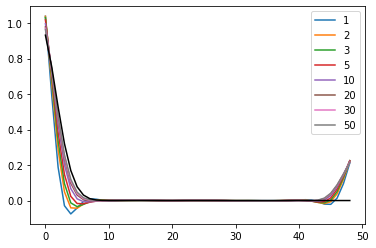

In [25]:
lineObjects = plt.plot(SW_ratio * W_diagmean.T)
plt.plot(np.exp(-0.5*(np.arange(1,num_time)/cwt_scale)**2),
         color='black')
plt.legend(iter(lineObjects), lambdas_diag)

In [26]:
np.sum((SW_ratio[:,None] * W_diagmean 
 - np.array(
     [np.mean(np.diagonal(filter_mat, k)) 
      for k in np.arange(1,num_time)]))**2, 1)

array([0.40569261, 0.27907857, 0.22101022, 0.16661325, 0.12214955,
       0.1005941 , 0.09402915, 0.08919362])

## calibration by permutation

In [30]:
offset_cross=10
offset_auto=10
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.zeros(11), ## lambdas_auto
    np.full((11,), 20), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [31]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [32]:
b_time = np.linspace(rec_time[0], rec_time[1], num_time)
l_time = np.linspace(rec_time[0], rec_time[1], 2*num_time-1)

In [35]:
num_cv = 10

In [36]:
Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
weights_cv = []

for iter_cv in np.arange(num_cv):
    start_cv = time.time()
    
    # random sample
    trial_sample = np.random.choice(num_trial, num_trial, False)
    data_bst = [data[0], data[1][:,:,trial_sample]]

    for iter_est, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
    in enumerate(zip(*lambdas)): 
        if iter_cv > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est],
                        'weight_init': weights_cv[iter_est]}
        elif iter_est > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est-1],
                        'weight_init': weights_cv[iter_est-1]}
        else:
            init_arg = dict()

        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                   lambda_auto, offset_auto, 
                   ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                   **init_arg)
        
        # save result
        Omegas_cv[iter_cv, iter_est] = Omega_est
        if iter_cv == 0:
            weights_cv.append(weight_est)

    sys.__stdout__.write("%d-th cv finished, lapse: %.3fsec.\n"
                         %(iter_cv+1, time.time()-start_cv))
    sys.__stdout__.flush()

1-th iter, nll: 404.101286, change: 0.194417, lapse: 0.156479
2-th iter, nll: 404.094376, change: 0.065464, lapse: 0.167451
3-th iter, nll: 404.088868, change: 0.045126, lapse: 0.211924
4-th iter, nll: 404.084421, change: 0.031628, lapse: 0.240327
5-th iter, nll: 404.080865, change: 0.025008, lapse: 0.170842
6-th iter, nll: 404.078040, change: 0.018769, lapse: 0.235807
7-th iter, nll: 404.075800, change: 0.014962, lapse: 0.188415
8-th iter, nll: 404.074020, change: 0.012742, lapse: 0.271184
9-th iter, nll: 404.072601, change: 0.010581, lapse: 0.249584
10-th iter, nll: 404.071464, change: 0.008689, lapse: 0.197556
11-th iter, nll: 404.070546, change: 0.007074, lapse: 0.141376
12-th iter, nll: 404.069797, change: 0.005701, lapse: 0.282112
13-th iter, nll: 404.069182, change: 0.004728, lapse: 0.279519
14-th iter, nll: 404.068670, change: 0.004563, lapse: 0.239567
15-th iter, nll: 404.068239, change: 0.004417, lapse: 0.299638
16-th iter, nll: 404.067872, change: 0.004256, lapse: 0.319775
1

2-th iter, nll: 404.063544, change: 0.001398, lapse: 0.325073
3-th iter, nll: 404.063537, change: 0.000880, lapse: 0.279556
1-th iter, nll: 404.063366, change: 0.071195, lapse: 0.272327
2-th iter, nll: 404.063349, change: 0.002838, lapse: 0.295329
3-th iter, nll: 404.063338, change: 0.001934, lapse: 0.323376
4-th iter, nll: 404.063329, change: 0.001418, lapse: 0.261261
5-th iter, nll: 404.063322, change: 0.001122, lapse: 0.222799
6-th iter, nll: 404.063315, change: 0.000921, lapse: 0.207560
1-th iter, nll: 404.063071, change: 0.105232, lapse: 0.161435
2-th iter, nll: 404.063026, change: 0.004295, lapse: 0.239361
3-th iter, nll: 404.062999, change: 0.002960, lapse: 0.298435
4-th iter, nll: 404.062981, change: 0.002166, lapse: 0.281129
5-th iter, nll: 404.062967, change: 0.001692, lapse: 0.274074
6-th iter, nll: 404.062957, change: 0.001373, lapse: 0.133186
7-th iter, nll: 404.062948, change: 0.001145, lapse: 0.161844
8-th iter, nll: 404.062942, change: 0.000974, lapse: 0.238433
1-th ite

12-th iter, nll: 404.061936, change: 0.001780, lapse: 0.331161
13-th iter, nll: 404.061929, change: 0.001709, lapse: 0.307498
14-th iter, nll: 404.061923, change: 0.001645, lapse: 0.280911
15-th iter, nll: 404.061917, change: 0.001587, lapse: 0.276335
16-th iter, nll: 404.061912, change: 0.001538, lapse: 0.240655
17-th iter, nll: 404.061908, change: 0.001492, lapse: 0.283417
18-th iter, nll: 404.061904, change: 0.001448, lapse: 0.335416
19-th iter, nll: 404.061900, change: 0.001406, lapse: 0.303395
20-th iter, nll: 404.061897, change: 0.001366, lapse: 0.255361
21-th iter, nll: 404.061893, change: 0.001328, lapse: 0.259379
22-th iter, nll: 404.061890, change: 0.001292, lapse: 0.239354
23-th iter, nll: 404.061888, change: 0.001256, lapse: 0.239125
24-th iter, nll: 404.061885, change: 0.001223, lapse: 0.258042
25-th iter, nll: 404.061883, change: 0.001190, lapse: 0.239378
26-th iter, nll: 404.061880, change: 0.001158, lapse: 0.239277
27-th iter, nll: 404.061878, change: 0.001128, lapse: 0

28-th iter, nll: 404.060792, change: 0.001654, lapse: 0.143907
29-th iter, nll: 404.060787, change: 0.001601, lapse: 0.255581
30-th iter, nll: 404.060782, change: 0.001550, lapse: 0.284679
31-th iter, nll: 404.060777, change: 0.001499, lapse: 0.238118
32-th iter, nll: 404.060773, change: 0.001451, lapse: 0.239371
33-th iter, nll: 404.060769, change: 0.001403, lapse: 0.239388
34-th iter, nll: 404.060765, change: 0.001357, lapse: 0.299145
35-th iter, nll: 404.060761, change: 0.001312, lapse: 0.181715
36-th iter, nll: 404.060758, change: 0.001269, lapse: 0.159889
37-th iter, nll: 404.060754, change: 0.001227, lapse: 0.169556
38-th iter, nll: 404.060751, change: 0.001186, lapse: 0.149368
39-th iter, nll: 404.060748, change: 0.001147, lapse: 0.182087
40-th iter, nll: 404.060745, change: 0.001109, lapse: 0.167919
41-th iter, nll: 404.060743, change: 0.001072, lapse: 0.249665
42-th iter, nll: 404.060740, change: 0.001036, lapse: 0.211573
43-th iter, nll: 404.060737, change: 0.001001, lapse: 0

27-th iter, nll: 404.060448, change: 0.001822, lapse: 0.262884
28-th iter, nll: 404.060441, change: 0.001760, lapse: 0.302611
29-th iter, nll: 404.060435, change: 0.001699, lapse: 0.245470
30-th iter, nll: 404.060429, change: 0.001640, lapse: 0.183456
31-th iter, nll: 404.060423, change: 0.001583, lapse: 0.136616
32-th iter, nll: 404.060418, change: 0.001527, lapse: 0.138693
33-th iter, nll: 404.060413, change: 0.001473, lapse: 0.135945
34-th iter, nll: 404.060408, change: 0.001421, lapse: 0.172882
35-th iter, nll: 404.060403, change: 0.001370, lapse: 0.249338
36-th iter, nll: 404.060399, change: 0.001321, lapse: 0.296359
37-th iter, nll: 404.060395, change: 0.001274, lapse: 0.267957
38-th iter, nll: 404.060391, change: 0.001228, lapse: 0.244902
39-th iter, nll: 404.060387, change: 0.001184, lapse: 0.238992
40-th iter, nll: 404.060384, change: 0.001141, lapse: 0.231820
41-th iter, nll: 404.060380, change: 0.001100, lapse: 0.263036
42-th iter, nll: 404.060377, change: 0.001060, lapse: 0

14-th iter, nll: 404.063253, change: 0.001103, lapse: 0.331149
15-th iter, nll: 404.063248, change: 0.001034, lapse: 0.243697
16-th iter, nll: 404.063244, change: 0.000970, lapse: 0.203634
1-th iter, nll: 404.063114, change: 0.080708, lapse: 0.235966
2-th iter, nll: 404.063054, change: 0.005505, lapse: 0.287426
3-th iter, nll: 404.063013, change: 0.004671, lapse: 0.279289
4-th iter, nll: 404.062981, change: 0.003988, lapse: 0.315154
5-th iter, nll: 404.062956, change: 0.003569, lapse: 0.243539
6-th iter, nll: 404.062935, change: 0.003238, lapse: 0.183618
7-th iter, nll: 404.062917, change: 0.002981, lapse: 0.331830
8-th iter, nll: 404.062901, change: 0.002759, lapse: 0.323601
9-th iter, nll: 404.062888, change: 0.002560, lapse: 0.199560
10-th iter, nll: 404.062876, change: 0.002378, lapse: 0.231935
11-th iter, nll: 404.062865, change: 0.002210, lapse: 0.199550
12-th iter, nll: 404.062856, change: 0.002054, lapse: 0.165392
13-th iter, nll: 404.062848, change: 0.001911, lapse: 0.180309
1

7-th iter, nll: 404.061581, change: 0.004791, lapse: 0.289076
8-th iter, nll: 404.061538, change: 0.004320, lapse: 0.286859
9-th iter, nll: 404.061502, change: 0.003933, lapse: 0.262730
10-th iter, nll: 404.061471, change: 0.003585, lapse: 0.215568
11-th iter, nll: 404.061445, change: 0.003271, lapse: 0.199583
12-th iter, nll: 404.061423, change: 0.002983, lapse: 0.207583
13-th iter, nll: 404.061404, change: 0.002720, lapse: 0.229881
14-th iter, nll: 404.061387, change: 0.002481, lapse: 0.165536
15-th iter, nll: 404.061373, change: 0.002272, lapse: 0.203781
16-th iter, nll: 404.061361, change: 0.002084, lapse: 0.231681
17-th iter, nll: 404.061351, change: 0.001911, lapse: 0.315465
18-th iter, nll: 404.061342, change: 0.001753, lapse: 0.203701
19-th iter, nll: 404.061334, change: 0.001610, lapse: 0.263634
20-th iter, nll: 404.061327, change: 0.001478, lapse: 0.315447
21-th iter, nll: 404.061321, change: 0.001357, lapse: 0.331681
22-th iter, nll: 404.061316, change: 0.001246, lapse: 0.25

1-th iter, nll: 404.062680, change: 0.164235, lapse: 0.146062
2-th iter, nll: 404.062526, change: 0.005792, lapse: 0.135529
3-th iter, nll: 404.062432, change: 0.003939, lapse: 0.175786
4-th iter, nll: 404.062369, change: 0.002844, lapse: 0.245923
5-th iter, nll: 404.062323, change: 0.002192, lapse: 0.237180
6-th iter, nll: 404.062289, change: 0.001787, lapse: 0.246165
7-th iter, nll: 404.062261, change: 0.001518, lapse: 0.237002
8-th iter, nll: 404.062239, change: 0.001327, lapse: 0.235517
9-th iter, nll: 404.062221, change: 0.001182, lapse: 0.239577
10-th iter, nll: 404.062206, change: 0.001065, lapse: 0.219175
11-th iter, nll: 404.062193, change: 0.000996, lapse: 0.249869
1-th iter, nll: 404.062664, change: 0.166121, lapse: 0.262340
2-th iter, nll: 404.062502, change: 0.005896, lapse: 0.251559
3-th iter, nll: 404.062403, change: 0.004003, lapse: 0.242915
4-th iter, nll: 404.062337, change: 0.002887, lapse: 0.310097
5-th iter, nll: 404.062288, change: 0.002224, lapse: 0.323691
6-th i

1-th iter, nll: 404.062261, change: 0.139596, lapse: 0.274605
2-th iter, nll: 404.062059, change: 0.006266, lapse: 0.283472
3-th iter, nll: 404.061935, change: 0.004144, lapse: 0.314913
4-th iter, nll: 404.061850, change: 0.003355, lapse: 0.151076
5-th iter, nll: 404.061789, change: 0.002760, lapse: 0.142018
6-th iter, nll: 404.061743, change: 0.002321, lapse: 0.136186
7-th iter, nll: 404.061707, change: 0.002140, lapse: 0.189642
8-th iter, nll: 404.061678, change: 0.001996, lapse: 0.243694
9-th iter, nll: 404.061653, change: 0.001870, lapse: 0.167566
10-th iter, nll: 404.061633, change: 0.001756, lapse: 0.291802
11-th iter, nll: 404.061616, change: 0.001652, lapse: 0.328750
12-th iter, nll: 404.061601, change: 0.001557, lapse: 0.286690
13-th iter, nll: 404.061588, change: 0.001472, lapse: 0.265406
14-th iter, nll: 404.061576, change: 0.001387, lapse: 0.262954
15-th iter, nll: 404.061566, change: 0.001311, lapse: 0.264245
16-th iter, nll: 404.061557, change: 0.001243, lapse: 0.302543
1

2-th iter, nll: 404.062967, change: 0.004173, lapse: 0.310102
3-th iter, nll: 404.062933, change: 0.003066, lapse: 0.269939
4-th iter, nll: 404.062909, change: 0.002459, lapse: 0.159557
5-th iter, nll: 404.062891, change: 0.002088, lapse: 0.140579
6-th iter, nll: 404.062876, change: 0.001822, lapse: 0.241402
7-th iter, nll: 404.062864, change: 0.001615, lapse: 0.163913
8-th iter, nll: 404.062854, change: 0.001452, lapse: 0.153751
9-th iter, nll: 404.062846, change: 0.001320, lapse: 0.159570
10-th iter, nll: 404.062838, change: 0.001212, lapse: 0.159178
11-th iter, nll: 404.062831, change: 0.001121, lapse: 0.266958
12-th iter, nll: 404.062825, change: 0.001042, lapse: 0.266644
13-th iter, nll: 404.062819, change: 0.000974, lapse: 0.283725
1-th iter, nll: 404.062664, change: 0.120334, lapse: 0.268225
2-th iter, nll: 404.062566, change: 0.005102, lapse: 0.273175
3-th iter, nll: 404.062504, change: 0.003945, lapse: 0.338121
4-th iter, nll: 404.062460, change: 0.003265, lapse: 0.335427
5-th

1-th iter, nll: 404.061805, change: 0.161380, lapse: 0.248428
2-th iter, nll: 404.061578, change: 0.006650, lapse: 0.247468
3-th iter, nll: 404.061434, change: 0.005414, lapse: 0.256702
4-th iter, nll: 404.061333, change: 0.004657, lapse: 0.126373
5-th iter, nll: 404.061258, change: 0.004139, lapse: 0.121405
6-th iter, nll: 404.061201, change: 0.003731, lapse: 0.270611
7-th iter, nll: 404.061155, change: 0.003399, lapse: 0.254632
8-th iter, nll: 404.061117, change: 0.003121, lapse: 0.189479
9-th iter, nll: 404.061086, change: 0.002882, lapse: 0.139604
10-th iter, nll: 404.061059, change: 0.002673, lapse: 0.138085
11-th iter, nll: 404.061037, change: 0.002488, lapse: 0.141388
12-th iter, nll: 404.061017, change: 0.002323, lapse: 0.159463
13-th iter, nll: 404.061000, change: 0.002172, lapse: 0.221225
14-th iter, nll: 404.060985, change: 0.002035, lapse: 0.260476
15-th iter, nll: 404.060972, change: 0.001909, lapse: 0.239584
16-th iter, nll: 404.060961, change: 0.001793, lapse: 0.271148
1

24-th iter, nll: 404.062290, change: 0.001002, lapse: 0.139897
25-th iter, nll: 404.062286, change: 0.000983, lapse: 0.139512
1-th iter, nll: 404.062791, change: 0.133240, lapse: 0.208754
2-th iter, nll: 404.062634, change: 0.007174, lapse: 0.258095
3-th iter, nll: 404.062535, change: 0.004923, lapse: 0.256925
4-th iter, nll: 404.062469, change: 0.003676, lapse: 0.265781
5-th iter, nll: 404.062420, change: 0.003004, lapse: 0.256866
6-th iter, nll: 404.062383, change: 0.002546, lapse: 0.273891
7-th iter, nll: 404.062353, change: 0.002190, lapse: 0.307320
8-th iter, nll: 404.062329, change: 0.001939, lapse: 0.339564
9-th iter, nll: 404.062309, change: 0.001783, lapse: 0.319535
10-th iter, nll: 404.062292, change: 0.001652, lapse: 0.315526
11-th iter, nll: 404.062278, change: 0.001537, lapse: 0.316623
12-th iter, nll: 404.062265, change: 0.001441, lapse: 0.350045
13-th iter, nll: 404.062253, change: 0.001358, lapse: 0.339360
14-th iter, nll: 404.062243, change: 0.001352, lapse: 0.339520
1

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


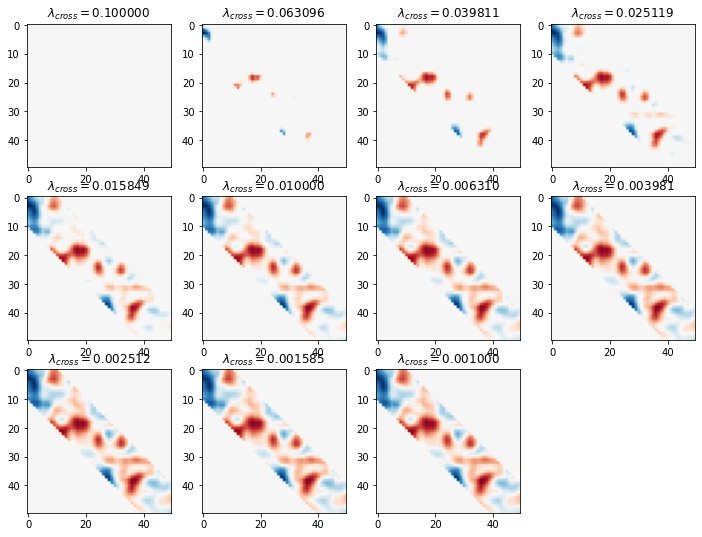

In [41]:
plt.figure(figsize=(12,3*np.ceil(lambdas.shape[-1]/4)))
for iter_lambda, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
in enumerate(zip(*lambdas)):
    plt.subplot(np.ceil(lambdas.shape[-1]/4).astype(int), 4, iter_lambda+1)
    ldn.imshow(Omegas_cv[0, iter_lambda,:num_time,num_time:], identity=True)
    plt.title(r'$\lambda_{cross} = %f$'%lambda_cross)

In [42]:
fds_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/num_cv
fdrs_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/np.sum(time_graph_cross)/num_cv

Text(0, 0.5, 'mean false discovery')

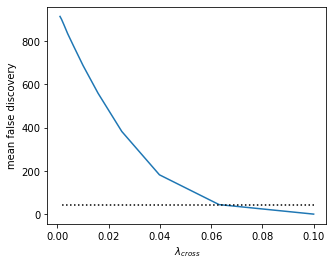

In [43]:
plt.figure(figsize=(5,4))
plt.plot(lambdas[0], fds_cv)
plt.plot(lambdas[0], np.full(lambdas[0].shape, 0.05*np.sum(time_graph_cross)), color='black', linestyle=':')
plt.xlabel(r"$\lambda_{cross}$")
plt.ylabel(r"mean false discovery")

## cv result

In [44]:
id_cv = np.argmax(fdrs_cv[fdrs_cv < 0.05])

In [40]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[id_cv]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

In [44]:
weight_init = [ (np.random.normal(size=dims[0])) for _ in np.arange(num_time)] \
            + [ (np.random.normal(size=dims[0])) for _ in np.arange(num_time)]

In [53]:
Omega_est, Sigma_est, latent_est, weight_est =\
    ldn.fit(data, lambda_diag, lambda_cross, offset_cross,
            lambda_auto, offset_auto, weight_init=weight_init,
            ths_glasso=1e-6, ths_lasso=1e-6, ths=5e-4, verbose=True)

1-th iter, nll: 404.393112, change: 0.124152, lapse: 0.118246
2-th iter, nll: 404.268003, change: 0.809189, lapse: 0.107347
3-th iter, nll: 404.193771, change: 0.768047, lapse: 0.125487
4-th iter, nll: 404.144984, change: 0.693636, lapse: 0.123570
5-th iter, nll: 404.118724, change: 0.823931, lapse: 0.115233
6-th iter, nll: 404.105754, change: 0.575039, lapse: 0.113168
7-th iter, nll: 404.097804, change: 0.254933, lapse: 0.105800
8-th iter, nll: 404.090580, change: 0.326886, lapse: 0.105202
9-th iter, nll: 404.084131, change: 0.428379, lapse: 0.113666
10-th iter, nll: 404.079919, change: 0.173919, lapse: 0.114108
11-th iter, nll: 404.076835, change: 0.053580, lapse: 0.113525
12-th iter, nll: 404.074397, change: 0.023964, lapse: 0.105280
13-th iter, nll: 404.072432, change: 0.013999, lapse: 0.105638
14-th iter, nll: 404.070827, change: 0.011291, lapse: 0.105192
15-th iter, nll: 404.069504, change: 0.010568, lapse: 0.105612
16-th iter, nll: 404.068403, change: 0.009703, lapse: 0.105033
1

## plots

Text(0, 0.5, 'V4 at time $s$ sec.')

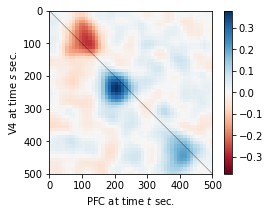

In [57]:
plt.figure(figsize=(4,3))
ldn.imshow(Sigma_est[:num_time,num_time:], time=rec_time, identity=True); plt.colorbar()
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")

Text(0, 0.5, 'V4 at time $s$ sec.')

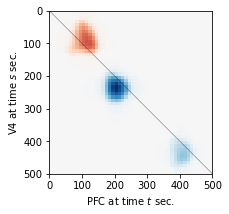

In [58]:
plt.figure(figsize=(3,3))
ldn.imshow(np.linalg.inv(Omega_est)[:num_time,num_time:], time=rec_time, identity=True)
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")

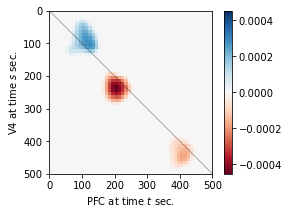

In [59]:
plt.figure(figsize=(4,3))
ldn.imshow(Omega_est[:num_time,num_time:], time=rec_time, identity=True)
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")
plt.colorbar()

# 2. iterate simulation

In [60]:
num_sim = 1000

In [61]:
for iter_sim in range(num_sim): 
    if os.path.exists("%s/result_sim_%.3d.npz"%(save_dir, iter_sim)):
        continue

    start_sim = time.time()

    # initialization
    weight_init = [ (np.random.normal(size=dims[0])) for _ in np.arange(num_time)] \
                + [ (np.random.normal(size=dims[0])) for _ in np.arange(num_time)]

    # random estimation
    Omega_est, Sigma_est, latent_est, weight_est =\
    ldn.fit(data, lambda_diag, lambda_cross, offset_cross,
            lambda_auto, offset_auto, weight_init=weight_init,
            ths_glasso=1e-6, ths_lasso=1e-6, ths=5e-4, verbose=True)

    np.savez("%s/result_sim_%.3d"%(save_dir, iter_sim),
             Omega_est = Omega_est, Sigma_est = Sigma_est,
             weight_init = weight_init, weight_est = weight_est)

    sys.__stdout__.write("%d-th simulation finished, lapse: %.3fsec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()  

1-th iter, nll: 404.385221, change: 0.122000, lapse: 0.123182
2-th iter, nll: 404.228791, change: 0.853340, lapse: 0.107228
3-th iter, nll: 404.152834, change: 0.798755, lapse: 0.115326
4-th iter, nll: 404.127121, change: 0.524476, lapse: 0.106445
5-th iter, nll: 404.114044, change: 0.181636, lapse: 0.106579
6-th iter, nll: 404.105815, change: 0.108809, lapse: 0.106348
7-th iter, nll: 404.099664, change: 0.163943, lapse: 0.106883
8-th iter, nll: 404.094328, change: 0.249228, lapse: 0.106150
9-th iter, nll: 404.089853, change: 0.245556, lapse: 0.106723
10-th iter, nll: 404.086546, change: 0.127617, lapse: 0.106308
11-th iter, nll: 404.084024, change: 0.060246, lapse: 0.108228
12-th iter, nll: 404.081988, change: 0.030505, lapse: 0.106350
13-th iter, nll: 404.080295, change: 0.020058, lapse: 0.106986
14-th iter, nll: 404.078862, change: 0.015079, lapse: 0.106083
15-th iter, nll: 404.077630, change: 0.013496, lapse: 0.106682
16-th iter, nll: 404.076554, change: 0.012798, lapse: 0.106110
1

59-th iter, nll: 404.060230, change: 0.000745, lapse: 0.100656
60-th iter, nll: 404.060227, change: 0.000732, lapse: 0.098249
61-th iter, nll: 404.060225, change: 0.000720, lapse: 0.098447
62-th iter, nll: 404.060222, change: 0.000708, lapse: 0.100566
63-th iter, nll: 404.060220, change: 0.000697, lapse: 0.101557
64-th iter, nll: 404.060218, change: 0.000686, lapse: 0.098024
65-th iter, nll: 404.060216, change: 0.000676, lapse: 0.100072
66-th iter, nll: 404.060214, change: 0.000667, lapse: 0.097655
67-th iter, nll: 404.060212, change: 0.000658, lapse: 0.097908
68-th iter, nll: 404.060210, change: 0.000649, lapse: 0.099906
69-th iter, nll: 404.060208, change: 0.000642, lapse: 0.097713
70-th iter, nll: 404.060206, change: 0.000634, lapse: 0.098484
71-th iter, nll: 404.060204, change: 0.000627, lapse: 0.100491
72-th iter, nll: 404.060203, change: 0.000620, lapse: 0.098806
73-th iter, nll: 404.060201, change: 0.000614, lapse: 0.097791
74-th iter, nll: 404.060199, change: 0.000608, lapse: 0

74-th iter, nll: 404.062903, change: 0.001426, lapse: 0.106671
75-th iter, nll: 404.062880, change: 0.001308, lapse: 0.097269
76-th iter, nll: 404.062859, change: 0.001200, lapse: 0.096991
77-th iter, nll: 404.062839, change: 0.001102, lapse: 0.099085
78-th iter, nll: 404.062821, change: 0.001013, lapse: 0.097160
79-th iter, nll: 404.062804, change: 0.000932, lapse: 0.097226
80-th iter, nll: 404.062788, change: 0.000857, lapse: 0.098736
81-th iter, nll: 404.062773, change: 0.000789, lapse: 0.097914
82-th iter, nll: 404.062760, change: 0.000726, lapse: 0.097331
83-th iter, nll: 404.062747, change: 0.000682, lapse: 0.099328
84-th iter, nll: 404.062735, change: 0.000691, lapse: 0.097237
85-th iter, nll: 404.062724, change: 0.000697, lapse: 0.097103
86-th iter, nll: 404.062714, change: 0.000706, lapse: 0.098906
87-th iter, nll: 404.062704, change: 0.000716, lapse: 0.097160
88-th iter, nll: 404.062696, change: 0.000724, lapse: 0.097407
89-th iter, nll: 404.062687, change: 0.000730, lapse: 0

78-th iter, nll: 404.060788, change: 0.000875, lapse: 0.100449
79-th iter, nll: 404.060785, change: 0.000835, lapse: 0.098356
80-th iter, nll: 404.060782, change: 0.000796, lapse: 0.098149
81-th iter, nll: 404.060779, change: 0.000760, lapse: 0.100302
82-th iter, nll: 404.060776, change: 0.000726, lapse: 0.098221
83-th iter, nll: 404.060774, change: 0.000693, lapse: 0.098570
84-th iter, nll: 404.060772, change: 0.000663, lapse: 0.099890
85-th iter, nll: 404.060770, change: 0.000634, lapse: 0.098248
86-th iter, nll: 404.060768, change: 0.000607, lapse: 0.098212
87-th iter, nll: 404.060766, change: 0.000581, lapse: 0.100133
88-th iter, nll: 404.060764, change: 0.000556, lapse: 0.098019
89-th iter, nll: 404.060763, change: 0.000532, lapse: 0.098252
90-th iter, nll: 404.060761, change: 0.000509, lapse: 0.099905
91-th iter, nll: 404.060760, change: 0.000488, lapse: 0.098791
4-th simulation finished, lapse: 9.521sec.
1-th iter, nll: 404.378103, change: 0.100000, lapse: 0.099752
2-th iter, nl

18-th iter, nll: 404.068480, change: 0.008767, lapse: 0.107758
19-th iter, nll: 404.067830, change: 0.008934, lapse: 0.106710
20-th iter, nll: 404.067217, change: 0.008935, lapse: 0.107302
21-th iter, nll: 404.066634, change: 0.008873, lapse: 0.107061
22-th iter, nll: 404.066079, change: 0.008800, lapse: 0.107217
23-th iter, nll: 404.065553, change: 0.008579, lapse: 0.106782
24-th iter, nll: 404.065057, change: 0.008652, lapse: 0.107024
25-th iter, nll: 404.064592, change: 0.008578, lapse: 0.106526
26-th iter, nll: 404.064160, change: 0.008307, lapse: 0.107379
27-th iter, nll: 404.063762, change: 0.007951, lapse: 0.107522
28-th iter, nll: 404.063398, change: 0.007481, lapse: 0.107135
29-th iter, nll: 404.063066, change: 0.006946, lapse: 0.106605
30-th iter, nll: 404.062764, change: 0.006354, lapse: 0.107075
31-th iter, nll: 404.062492, change: 0.006028, lapse: 0.106320
32-th iter, nll: 404.062246, change: 0.005919, lapse: 0.107641
33-th iter, nll: 404.062026, change: 0.005754, lapse: 0

76-th iter, nll: 404.065315, change: 0.001336, lapse: 0.099458
77-th iter, nll: 404.065291, change: 0.001323, lapse: 0.097331
78-th iter, nll: 404.065267, change: 0.002009, lapse: 0.097603
79-th iter, nll: 404.065243, change: 0.002372, lapse: 0.099257
80-th iter, nll: 404.065220, change: 0.002484, lapse: 0.097273
81-th iter, nll: 404.065197, change: 0.002544, lapse: 0.097950
82-th iter, nll: 404.065175, change: 0.002599, lapse: 0.099375
83-th iter, nll: 404.065152, change: 0.002650, lapse: 0.097440
84-th iter, nll: 404.065130, change: 0.002700, lapse: 0.097108
85-th iter, nll: 404.065108, change: 0.002749, lapse: 0.099445
86-th iter, nll: 404.065086, change: 0.003120, lapse: 0.097819
87-th iter, nll: 404.065063, change: 0.003231, lapse: 0.097811
88-th iter, nll: 404.065040, change: 0.003336, lapse: 0.099778
89-th iter, nll: 404.065017, change: 0.003472, lapse: 0.097538
90-th iter, nll: 404.064992, change: 0.003619, lapse: 0.097700
91-th iter, nll: 404.064967, change: 0.003869, lapse: 0

44-th iter, nll: 404.061200, change: 0.000606, lapse: 0.100168
45-th iter, nll: 404.061191, change: 0.000591, lapse: 0.097367
46-th iter, nll: 404.061183, change: 0.000578, lapse: 0.097647
47-th iter, nll: 404.061176, change: 0.000565, lapse: 0.099982
48-th iter, nll: 404.061169, change: 0.000553, lapse: 0.098216
49-th iter, nll: 404.061163, change: 0.000540, lapse: 0.097617
50-th iter, nll: 404.061158, change: 0.000528, lapse: 0.099891
51-th iter, nll: 404.061153, change: 0.000517, lapse: 0.098140
52-th iter, nll: 404.061148, change: 0.000505, lapse: 0.097886
53-th iter, nll: 404.061144, change: 0.000494, lapse: 0.099591
8-th simulation finished, lapse: 5.570sec.
1-th iter, nll: 404.385462, change: 0.123993, lapse: 0.097975
2-th iter, nll: 404.228171, change: 0.829347, lapse: 0.116587
3-th iter, nll: 404.159820, change: 0.761792, lapse: 0.114261
4-th iter, nll: 404.123998, change: 0.603336, lapse: 0.108657
5-th iter, nll: 404.106875, change: 0.317612, lapse: 0.106109
6-th iter, nll: 4

20-th iter, nll: 404.070367, change: 0.026265, lapse: 0.113610
21-th iter, nll: 404.069125, change: 0.023428, lapse: 0.111364
22-th iter, nll: 404.068053, change: 0.020006, lapse: 0.112541
23-th iter, nll: 404.067145, change: 0.016538, lapse: 0.110022
24-th iter, nll: 404.066385, change: 0.013372, lapse: 0.112407
25-th iter, nll: 404.065752, change: 0.010700, lapse: 0.111948
26-th iter, nll: 404.065225, change: 0.008493, lapse: 0.112930
27-th iter, nll: 404.064784, change: 0.006735, lapse: 0.112535
28-th iter, nll: 404.064412, change: 0.005362, lapse: 0.112985
29-th iter, nll: 404.064098, change: 0.004331, lapse: 0.111683
30-th iter, nll: 404.063830, change: 0.003709, lapse: 0.113355
31-th iter, nll: 404.063601, change: 0.003309, lapse: 0.113031
32-th iter, nll: 404.063402, change: 0.002971, lapse: 0.113281
33-th iter, nll: 404.063230, change: 0.002664, lapse: 0.113561
34-th iter, nll: 404.063079, change: 0.002387, lapse: 0.113466
35-th iter, nll: 404.062946, change: 0.002139, lapse: 0

12-th iter, nll: 404.073616, change: 0.016665, lapse: 0.106196
13-th iter, nll: 404.072294, change: 0.015721, lapse: 0.105731
14-th iter, nll: 404.071201, change: 0.014452, lapse: 0.106056
15-th iter, nll: 404.070283, change: 0.012974, lapse: 0.105555
16-th iter, nll: 404.069504, change: 0.011386, lapse: 0.106093
17-th iter, nll: 404.068837, change: 0.009777, lapse: 0.105700
18-th iter, nll: 404.068264, change: 0.009052, lapse: 0.106163
19-th iter, nll: 404.067767, change: 0.008581, lapse: 0.105805
20-th iter, nll: 404.067336, change: 0.008051, lapse: 0.106115
21-th iter, nll: 404.066958, change: 0.007623, lapse: 0.105588
22-th iter, nll: 404.066624, change: 0.008146, lapse: 0.106210
23-th iter, nll: 404.066325, change: 0.008206, lapse: 0.105568
24-th iter, nll: 404.066056, change: 0.008255, lapse: 0.106209
25-th iter, nll: 404.065811, change: 0.008270, lapse: 0.105665
26-th iter, nll: 404.065587, change: 0.008167, lapse: 0.106120
27-th iter, nll: 404.065378, change: 0.008074, lapse: 0

69-th iter, nll: 404.062615, change: 0.000700, lapse: 0.099795
70-th iter, nll: 404.062610, change: 0.000682, lapse: 0.097858
71-th iter, nll: 404.062606, change: 0.000665, lapse: 0.098269
72-th iter, nll: 404.062602, change: 0.000649, lapse: 0.099688
73-th iter, nll: 404.062599, change: 0.000633, lapse: 0.098239
74-th iter, nll: 404.062595, change: 0.000617, lapse: 0.098138
75-th iter, nll: 404.062592, change: 0.000602, lapse: 0.099974
76-th iter, nll: 404.062589, change: 0.000588, lapse: 0.097873
77-th iter, nll: 404.062586, change: 0.000573, lapse: 0.098000
78-th iter, nll: 404.062583, change: 0.000559, lapse: 0.100326
79-th iter, nll: 404.062581, change: 0.000546, lapse: 0.098269
80-th iter, nll: 404.062578, change: 0.000533, lapse: 0.097835
81-th iter, nll: 404.062576, change: 0.000520, lapse: 0.099873
82-th iter, nll: 404.062573, change: 0.000509, lapse: 0.097785
83-th iter, nll: 404.062571, change: 0.000497, lapse: 0.099421
12-th simulation finished, lapse: 8.699sec.
1-th iter, 

12-th iter, nll: 404.075701, change: 0.024501, lapse: 0.114615
13-th iter, nll: 404.073602, change: 0.024295, lapse: 0.122074
14-th iter, nll: 404.071750, change: 0.022897, lapse: 0.119335
15-th iter, nll: 404.070126, change: 0.021479, lapse: 0.119588
16-th iter, nll: 404.068723, change: 0.019266, lapse: 0.122182
17-th iter, nll: 404.067532, change: 0.017243, lapse: 0.216408
18-th iter, nll: 404.066534, change: 0.014542, lapse: 0.159189
19-th iter, nll: 404.065708, change: 0.011903, lapse: 0.116277
20-th iter, nll: 404.065027, change: 0.009894, lapse: 0.114408
21-th iter, nll: 404.064465, change: 0.008351, lapse: 0.109594
22-th iter, nll: 404.063999, change: 0.006969, lapse: 0.185042
23-th iter, nll: 404.063612, change: 0.005778, lapse: 0.184481
24-th iter, nll: 404.063288, change: 0.004784, lapse: 0.115205
25-th iter, nll: 404.063015, change: 0.003972, lapse: 0.114143
26-th iter, nll: 404.062783, change: 0.003634, lapse: 0.113711
27-th iter, nll: 404.062584, change: 0.003333, lapse: 0

45-th iter, nll: 404.061851, change: 0.003884, lapse: 0.106120
46-th iter, nll: 404.061784, change: 0.003752, lapse: 0.105631
47-th iter, nll: 404.061721, change: 0.003619, lapse: 0.106265
48-th iter, nll: 404.061661, change: 0.003485, lapse: 0.105858
49-th iter, nll: 404.061604, change: 0.003373, lapse: 0.106017
50-th iter, nll: 404.061550, change: 0.003263, lapse: 0.105534
51-th iter, nll: 404.061498, change: 0.003154, lapse: 0.106026
52-th iter, nll: 404.061448, change: 0.003046, lapse: 0.106054
53-th iter, nll: 404.061400, change: 0.002939, lapse: 0.105785
54-th iter, nll: 404.061353, change: 0.002833, lapse: 0.105530
55-th iter, nll: 404.061309, change: 0.002727, lapse: 0.105623
56-th iter, nll: 404.061265, change: 0.002622, lapse: 0.097612
57-th iter, nll: 404.061223, change: 0.002517, lapse: 0.097508
58-th iter, nll: 404.061182, change: 0.002412, lapse: 0.099133
59-th iter, nll: 404.061143, change: 0.002307, lapse: 0.097505
60-th iter, nll: 404.061104, change: 0.002201, lapse: 0

53-th iter, nll: 404.061205, change: 0.002329, lapse: 0.105604
54-th iter, nll: 404.061160, change: 0.002149, lapse: 0.105614
55-th iter, nll: 404.061118, change: 0.001982, lapse: 0.106011
56-th iter, nll: 404.061081, change: 0.001827, lapse: 0.105513
57-th iter, nll: 404.061047, change: 0.001684, lapse: 0.106342
58-th iter, nll: 404.061017, change: 0.001552, lapse: 0.105656
59-th iter, nll: 404.060989, change: 0.001430, lapse: 0.106098
60-th iter, nll: 404.060964, change: 0.001317, lapse: 0.105491
61-th iter, nll: 404.060942, change: 0.001262, lapse: 0.106030
62-th iter, nll: 404.060922, change: 0.001239, lapse: 0.097735
63-th iter, nll: 404.060903, change: 0.001214, lapse: 0.097539
64-th iter, nll: 404.060887, change: 0.001187, lapse: 0.099293
65-th iter, nll: 404.060872, change: 0.001160, lapse: 0.097670
66-th iter, nll: 404.060859, change: 0.001131, lapse: 0.097514
67-th iter, nll: 404.060847, change: 0.001102, lapse: 0.099821
68-th iter, nll: 404.060836, change: 0.001073, lapse: 0

92-th iter, nll: 404.062692, change: 0.000570, lapse: 0.098813
93-th iter, nll: 404.062686, change: 0.000567, lapse: 0.097079
94-th iter, nll: 404.062679, change: 0.000563, lapse: 0.096901
95-th iter, nll: 404.062673, change: 0.000560, lapse: 0.098987
96-th iter, nll: 404.062667, change: 0.000556, lapse: 0.097167
97-th iter, nll: 404.062661, change: 0.000552, lapse: 0.096960
98-th iter, nll: 404.062656, change: 0.000548, lapse: 0.098969
99-th iter, nll: 404.062651, change: 0.000543, lapse: 0.097185
100-th iter, nll: 404.062646, change: 0.000539, lapse: 0.096934
101-th iter, nll: 404.062641, change: 0.000535, lapse: 0.099001
102-th iter, nll: 404.062636, change: 0.000530, lapse: 0.097094
103-th iter, nll: 404.062631, change: 0.000526, lapse: 0.096997
104-th iter, nll: 404.062627, change: 0.000521, lapse: 0.098975
105-th iter, nll: 404.062623, change: 0.000516, lapse: 0.097213
106-th iter, nll: 404.062619, change: 0.000511, lapse: 0.097010
107-th iter, nll: 404.062615, change: 0.000505, 

26-th iter, nll: 404.062717, change: 0.003032, lapse: 0.106220
27-th iter, nll: 404.062530, change: 0.002923, lapse: 0.105453
28-th iter, nll: 404.062368, change: 0.002803, lapse: 0.105898
29-th iter, nll: 404.062227, change: 0.002677, lapse: 0.105605
30-th iter, nll: 404.062104, change: 0.002545, lapse: 0.098374
31-th iter, nll: 404.061996, change: 0.002412, lapse: 0.097601
32-th iter, nll: 404.061901, change: 0.002279, lapse: 0.099318
33-th iter, nll: 404.061817, change: 0.002148, lapse: 0.099198
34-th iter, nll: 404.061743, change: 0.002020, lapse: 0.097625
35-th iter, nll: 404.061677, change: 0.001965, lapse: 0.097540
36-th iter, nll: 404.061619, change: 0.001973, lapse: 0.099319
37-th iter, nll: 404.061566, change: 0.001973, lapse: 0.098471
38-th iter, nll: 404.061520, change: 0.001968, lapse: 0.098437
39-th iter, nll: 404.061478, change: 0.001956, lapse: 0.099759
40-th iter, nll: 404.061440, change: 0.001939, lapse: 0.098435
41-th iter, nll: 404.061407, change: 0.001917, lapse: 0

18-th iter, nll: 404.076423, change: 0.010995, lapse: 0.106452
19-th iter, nll: 404.075256, change: 0.010190, lapse: 0.105812
20-th iter, nll: 404.074197, change: 0.009665, lapse: 0.105986
21-th iter, nll: 404.073240, change: 0.008965, lapse: 0.105634
22-th iter, nll: 404.072380, change: 0.008088, lapse: 0.106117
23-th iter, nll: 404.071609, change: 0.007509, lapse: 0.105838
24-th iter, nll: 404.070916, change: 0.006915, lapse: 0.106004
25-th iter, nll: 404.070293, change: 0.006255, lapse: 0.105723
26-th iter, nll: 404.069729, change: 0.005725, lapse: 0.106049
27-th iter, nll: 404.069215, change: 0.005234, lapse: 0.105766
28-th iter, nll: 404.068741, change: 0.005481, lapse: 0.106045
29-th iter, nll: 404.068302, change: 0.005712, lapse: 0.105649
30-th iter, nll: 404.067892, change: 0.005872, lapse: 0.106095
31-th iter, nll: 404.067504, change: 0.006095, lapse: 0.105553
32-th iter, nll: 404.067135, change: 0.006421, lapse: 0.106090
33-th iter, nll: 404.066782, change: 0.006591, lapse: 0

42-th iter, nll: 404.064817, change: 0.006720, lapse: 0.106099
43-th iter, nll: 404.064633, change: 0.006404, lapse: 0.105644
44-th iter, nll: 404.064462, change: 0.006078, lapse: 0.106147
45-th iter, nll: 404.064301, change: 0.005807, lapse: 0.105526
46-th iter, nll: 404.064152, change: 0.005558, lapse: 0.106016
47-th iter, nll: 404.064014, change: 0.005313, lapse: 0.105599
48-th iter, nll: 404.063887, change: 0.005110, lapse: 0.106053
49-th iter, nll: 404.063769, change: 0.004907, lapse: 0.105547
50-th iter, nll: 404.063661, change: 0.004704, lapse: 0.106061
51-th iter, nll: 404.063562, change: 0.004471, lapse: 0.105662
52-th iter, nll: 404.063472, change: 0.004233, lapse: 0.105982
53-th iter, nll: 404.063389, change: 0.003992, lapse: 0.105602
54-th iter, nll: 404.063314, change: 0.003753, lapse: 0.105943
55-th iter, nll: 404.063245, change: 0.003516, lapse: 0.105519
56-th iter, nll: 404.063183, change: 0.003282, lapse: 0.106073
57-th iter, nll: 404.063127, change: 0.003055, lapse: 0

88-th iter, nll: 404.062407, change: 0.000582, lapse: 0.098990
89-th iter, nll: 404.062404, change: 0.000556, lapse: 0.097389
90-th iter, nll: 404.062401, change: 0.000531, lapse: 0.097055
91-th iter, nll: 404.062399, change: 0.000507, lapse: 0.121081
92-th iter, nll: 404.062396, change: 0.000485, lapse: 0.097699
23-th simulation finished, lapse: 9.630sec.
1-th iter, nll: 404.380201, change: 0.105834, lapse: 0.098135
2-th iter, nll: 404.210516, change: 0.886865, lapse: 0.122829
3-th iter, nll: 404.150211, change: 0.934838, lapse: 0.115041
4-th iter, nll: 404.122519, change: 0.614495, lapse: 0.105631
5-th iter, nll: 404.104902, change: 0.534051, lapse: 0.105969
6-th iter, nll: 404.094722, change: 0.202695, lapse: 0.105323
7-th iter, nll: 404.087817, change: 0.065763, lapse: 0.105680
8-th iter, nll: 404.082694, change: 0.039347, lapse: 0.112904
9-th iter, nll: 404.078778, change: 0.029170, lapse: 0.113295
10-th iter, nll: 404.075756, change: 0.023935, lapse: 0.113068
11-th iter, nll: 404

69-th iter, nll: 404.060324, change: 0.000574, lapse: 0.099124
70-th iter, nll: 404.060320, change: 0.000566, lapse: 0.097394
71-th iter, nll: 404.060316, change: 0.000557, lapse: 0.097237
72-th iter, nll: 404.060312, change: 0.000549, lapse: 0.099319
73-th iter, nll: 404.060308, change: 0.000540, lapse: 0.097426
74-th iter, nll: 404.060305, change: 0.000532, lapse: 0.097674
75-th iter, nll: 404.060302, change: 0.000524, lapse: 0.099052
76-th iter, nll: 404.060299, change: 0.000516, lapse: 0.097293
77-th iter, nll: 404.060296, change: 0.000509, lapse: 0.097304
78-th iter, nll: 404.060293, change: 0.000501, lapse: 0.099262
79-th iter, nll: 404.060290, change: 0.000494, lapse: 0.097176
25-th simulation finished, lapse: 8.120sec.
1-th iter, nll: 404.372922, change: 0.121714, lapse: 0.098361
2-th iter, nll: 404.213901, change: 0.854617, lapse: 0.113981
3-th iter, nll: 404.157529, change: 0.704957, lapse: 0.114490
4-th iter, nll: 404.134253, change: 0.731540, lapse: 0.113765
5-th iter, nll:

14-th iter, nll: 404.075563, change: 0.013928, lapse: 0.105786
15-th iter, nll: 404.074403, change: 0.012383, lapse: 0.105857
16-th iter, nll: 404.073398, change: 0.010844, lapse: 0.105911
17-th iter, nll: 404.072512, change: 0.009382, lapse: 0.105670
18-th iter, nll: 404.071716, change: 0.008157, lapse: 0.105790
19-th iter, nll: 404.070988, change: 0.007452, lapse: 0.105516
20-th iter, nll: 404.070307, change: 0.006741, lapse: 0.106143
21-th iter, nll: 404.069659, change: 0.007208, lapse: 0.105842
22-th iter, nll: 404.069029, change: 0.008166, lapse: 0.105972
23-th iter, nll: 404.068409, change: 0.009179, lapse: 0.112728
24-th iter, nll: 404.067795, change: 0.010169, lapse: 0.106421
25-th iter, nll: 404.067184, change: 0.011037, lapse: 0.105668
26-th iter, nll: 404.066579, change: 0.011674, lapse: 0.105685
27-th iter, nll: 404.065986, change: 0.011985, lapse: 0.105585
28-th iter, nll: 404.065412, change: 0.011925, lapse: 0.105835
29-th iter, nll: 404.064867, change: 0.011474, lapse: 0

47-th iter, nll: 404.061961, change: 0.001832, lapse: 0.106599
48-th iter, nll: 404.061900, change: 0.001657, lapse: 0.098385
49-th iter, nll: 404.061846, change: 0.001518, lapse: 0.098217
50-th iter, nll: 404.061797, change: 0.001389, lapse: 0.100078
51-th iter, nll: 404.061754, change: 0.001269, lapse: 0.098096
52-th iter, nll: 404.061715, change: 0.001193, lapse: 0.098042
53-th iter, nll: 404.061680, change: 0.001174, lapse: 0.100140
54-th iter, nll: 404.061648, change: 0.001155, lapse: 0.098129
55-th iter, nll: 404.061619, change: 0.001134, lapse: 0.098052
56-th iter, nll: 404.061593, change: 0.001113, lapse: 0.100083
57-th iter, nll: 404.061569, change: 0.001095, lapse: 0.098130
58-th iter, nll: 404.061547, change: 0.001086, lapse: 0.098089
59-th iter, nll: 404.061527, change: 0.001076, lapse: 0.100211
60-th iter, nll: 404.061508, change: 0.001065, lapse: 0.098212
61-th iter, nll: 404.061491, change: 0.001054, lapse: 0.098038
62-th iter, nll: 404.061475, change: 0.001043, lapse: 0

68-th iter, nll: 404.063424, change: 0.001172, lapse: 0.100650
69-th iter, nll: 404.063412, change: 0.001130, lapse: 0.098452
70-th iter, nll: 404.063401, change: 0.001091, lapse: 0.098765
71-th iter, nll: 404.063391, change: 0.001054, lapse: 0.100236
72-th iter, nll: 404.063381, change: 0.001018, lapse: 0.098558
73-th iter, nll: 404.063372, change: 0.000985, lapse: 0.098493
74-th iter, nll: 404.063363, change: 0.000953, lapse: 0.100475
75-th iter, nll: 404.063355, change: 0.000938, lapse: 0.098707
76-th iter, nll: 404.063348, change: 0.000924, lapse: 0.098701
77-th iter, nll: 404.063340, change: 0.000909, lapse: 0.100108
78-th iter, nll: 404.063334, change: 0.000894, lapse: 0.098624
79-th iter, nll: 404.063327, change: 0.000881, lapse: 0.098450
80-th iter, nll: 404.063322, change: 0.000868, lapse: 0.100517
81-th iter, nll: 404.063316, change: 0.000857, lapse: 0.098471
82-th iter, nll: 404.063310, change: 0.000846, lapse: 0.098767
83-th iter, nll: 404.063305, change: 0.000834, lapse: 0

50-th iter, nll: 404.064341, change: 0.002749, lapse: 0.106494
51-th iter, nll: 404.064323, change: 0.002866, lapse: 0.106186
52-th iter, nll: 404.064305, change: 0.003004, lapse: 0.106541
53-th iter, nll: 404.064287, change: 0.003141, lapse: 0.106144
54-th iter, nll: 404.064267, change: 0.003287, lapse: 0.106558
55-th iter, nll: 404.064247, change: 0.003437, lapse: 0.106071
56-th iter, nll: 404.064226, change: 0.003594, lapse: 0.106613
57-th iter, nll: 404.064203, change: 0.003769, lapse: 0.106186
58-th iter, nll: 404.064180, change: 0.003917, lapse: 0.106496
59-th iter, nll: 404.064154, change: 0.004064, lapse: 0.106104
60-th iter, nll: 404.064127, change: 0.004194, lapse: 0.106470
61-th iter, nll: 404.064099, change: 0.004310, lapse: 0.106163
62-th iter, nll: 404.064068, change: 0.004410, lapse: 0.106513
63-th iter, nll: 404.064036, change: 0.004499, lapse: 0.106238
64-th iter, nll: 404.064002, change: 0.004573, lapse: 0.106462
65-th iter, nll: 404.063965, change: 0.004669, lapse: 0

25-th iter, nll: 404.062674, change: 0.008674, lapse: 0.106966
26-th iter, nll: 404.062428, change: 0.007986, lapse: 0.106456
27-th iter, nll: 404.062208, change: 0.007322, lapse: 0.107013
28-th iter, nll: 404.062011, change: 0.006658, lapse: 0.106503
29-th iter, nll: 404.061835, change: 0.006014, lapse: 0.106966
30-th iter, nll: 404.061677, change: 0.005471, lapse: 0.106618
31-th iter, nll: 404.061536, change: 0.005099, lapse: 0.106959
32-th iter, nll: 404.061410, change: 0.004730, lapse: 0.106305
33-th iter, nll: 404.061298, change: 0.004369, lapse: 0.106588
34-th iter, nll: 404.061198, change: 0.004024, lapse: 0.106365
35-th iter, nll: 404.061108, change: 0.003700, lapse: 0.107105
36-th iter, nll: 404.061027, change: 0.003397, lapse: 0.106308
37-th iter, nll: 404.060955, change: 0.003118, lapse: 0.107242
38-th iter, nll: 404.060889, change: 0.002861, lapse: 0.106732
39-th iter, nll: 404.060829, change: 0.002632, lapse: 0.106860
40-th iter, nll: 404.060775, change: 0.002422, lapse: 0

48-th iter, nll: 404.060691, change: 0.002479, lapse: 0.106589
49-th iter, nll: 404.060629, change: 0.002277, lapse: 0.106233
50-th iter, nll: 404.060574, change: 0.002106, lapse: 0.106559
51-th iter, nll: 404.060525, change: 0.001946, lapse: 0.106171
52-th iter, nll: 404.060482, change: 0.001798, lapse: 0.106547
53-th iter, nll: 404.060444, change: 0.001661, lapse: 0.106103
54-th iter, nll: 404.060411, change: 0.001535, lapse: 0.106645
55-th iter, nll: 404.060381, change: 0.001419, lapse: 0.106324
56-th iter, nll: 404.060355, change: 0.001313, lapse: 0.106526
57-th iter, nll: 404.060332, change: 0.001215, lapse: 0.106132
58-th iter, nll: 404.060312, change: 0.001125, lapse: 0.106414
59-th iter, nll: 404.060293, change: 0.001043, lapse: 0.106058
60-th iter, nll: 404.060277, change: 0.000968, lapse: 0.106676
61-th iter, nll: 404.060263, change: 0.000900, lapse: 0.106225
62-th iter, nll: 404.060250, change: 0.000838, lapse: 0.106485
63-th iter, nll: 404.060239, change: 0.000780, lapse: 0

110-th iter, nll: 404.060754, change: 0.001871, lapse: 0.099266
111-th iter, nll: 404.060744, change: 0.001783, lapse: 0.097760
112-th iter, nll: 404.060735, change: 0.001700, lapse: 0.097619
113-th iter, nll: 404.060727, change: 0.001621, lapse: 0.099618
114-th iter, nll: 404.060720, change: 0.001545, lapse: 0.097844
115-th iter, nll: 404.060713, change: 0.001474, lapse: 0.097579
116-th iter, nll: 404.060707, change: 0.001406, lapse: 0.099472
117-th iter, nll: 404.060702, change: 0.001341, lapse: 0.097603
118-th iter, nll: 404.060696, change: 0.001280, lapse: 0.097478
119-th iter, nll: 404.060692, change: 0.001222, lapse: 0.099359
120-th iter, nll: 404.060688, change: 0.001167, lapse: 0.100930
121-th iter, nll: 404.060684, change: 0.001114, lapse: 0.097821
122-th iter, nll: 404.060680, change: 0.001065, lapse: 0.099628
123-th iter, nll: 404.060677, change: 0.001018, lapse: 0.097599
124-th iter, nll: 404.060674, change: 0.000974, lapse: 0.097587
125-th iter, nll: 404.060671, change: 0.

37-th iter, nll: 404.061857, change: 0.004455, lapse: 0.107059
38-th iter, nll: 404.061760, change: 0.004303, lapse: 0.106805
39-th iter, nll: 404.061671, change: 0.004166, lapse: 0.106738
40-th iter, nll: 404.061589, change: 0.004017, lapse: 0.106386
41-th iter, nll: 404.061513, change: 0.003865, lapse: 0.107225
42-th iter, nll: 404.061443, change: 0.003740, lapse: 0.106460
43-th iter, nll: 404.061377, change: 0.003608, lapse: 0.107078
44-th iter, nll: 404.061316, change: 0.003474, lapse: 0.106936
45-th iter, nll: 404.061260, change: 0.003338, lapse: 0.107021
46-th iter, nll: 404.061207, change: 0.003198, lapse: 0.106545
47-th iter, nll: 404.061158, change: 0.003057, lapse: 0.107052
48-th iter, nll: 404.061111, change: 0.002916, lapse: 0.106579
49-th iter, nll: 404.061068, change: 0.002778, lapse: 0.107003
50-th iter, nll: 404.061027, change: 0.002646, lapse: 0.106780
51-th iter, nll: 404.060989, change: 0.002527, lapse: 0.106787
52-th iter, nll: 404.060953, change: 0.002413, lapse: 0

63-th iter, nll: 404.063365, change: 0.004047, lapse: 0.106932
64-th iter, nll: 404.063296, change: 0.003816, lapse: 0.106337
65-th iter, nll: 404.063230, change: 0.003600, lapse: 0.107195
66-th iter, nll: 404.063168, change: 0.003390, lapse: 0.106308
67-th iter, nll: 404.063109, change: 0.003194, lapse: 0.106925
68-th iter, nll: 404.063053, change: 0.003000, lapse: 0.106779
69-th iter, nll: 404.063001, change: 0.002812, lapse: 0.107076
70-th iter, nll: 404.062952, change: 0.002630, lapse: 0.106632
71-th iter, nll: 404.062906, change: 0.002455, lapse: 0.107443
72-th iter, nll: 404.062864, change: 0.002289, lapse: 0.106415
73-th iter, nll: 404.062824, change: 0.002135, lapse: 0.107136
74-th iter, nll: 404.062786, change: 0.001990, lapse: 0.106985
75-th iter, nll: 404.062752, change: 0.001853, lapse: 0.106533
76-th iter, nll: 404.062719, change: 0.001725, lapse: 0.106481
77-th iter, nll: 404.062689, change: 0.001615, lapse: 0.107063
78-th iter, nll: 404.062662, change: 0.001507, lapse: 0

14-th iter, nll: 404.085272, change: 0.019350, lapse: 0.106757
15-th iter, nll: 404.083726, change: 0.016123, lapse: 0.106637
16-th iter, nll: 404.082361, change: 0.013440, lapse: 0.106905
17-th iter, nll: 404.081148, change: 0.011054, lapse: 0.106729
18-th iter, nll: 404.080067, change: 0.009304, lapse: 0.106542
19-th iter, nll: 404.079094, change: 0.007908, lapse: 0.106671
20-th iter, nll: 404.078214, change: 0.007287, lapse: 0.106858
21-th iter, nll: 404.077410, change: 0.006727, lapse: 0.106586
22-th iter, nll: 404.076667, change: 0.006285, lapse: 0.107057
23-th iter, nll: 404.075973, change: 0.008256, lapse: 0.108080
24-th iter, nll: 404.075313, change: 0.008685, lapse: 0.107924
25-th iter, nll: 404.074678, change: 0.009013, lapse: 0.107376
26-th iter, nll: 404.074058, change: 0.009239, lapse: 0.107556
27-th iter, nll: 404.073445, change: 0.009490, lapse: 0.107465
28-th iter, nll: 404.072835, change: 0.009650, lapse: 0.107692
29-th iter, nll: 404.072225, change: 0.009710, lapse: 0

145-th iter, nll: 404.062314, change: 0.000506, lapse: 0.099516
146-th iter, nll: 404.062313, change: 0.000502, lapse: 0.097723
147-th iter, nll: 404.062311, change: 0.000498, lapse: 0.097736
38-th simulation finished, lapse: 15.052sec.
1-th iter, nll: 404.379319, change: 0.113833, lapse: 0.098073
2-th iter, nll: 404.219628, change: 0.841240, lapse: 0.114744
3-th iter, nll: 404.155153, change: 0.750746, lapse: 0.114389
4-th iter, nll: 404.127276, change: 0.510722, lapse: 0.114653
5-th iter, nll: 404.112930, change: 0.455494, lapse: 0.106183
6-th iter, nll: 404.102548, change: 0.250488, lapse: 0.106408
7-th iter, nll: 404.092609, change: 0.673588, lapse: 0.114291
8-th iter, nll: 404.087296, change: 0.300205, lapse: 0.106744
9-th iter, nll: 404.083800, change: 0.037631, lapse: 0.106144
10-th iter, nll: 404.081163, change: 0.031623, lapse: 0.106272
11-th iter, nll: 404.079104, change: 0.028363, lapse: 0.106099
12-th iter, nll: 404.077454, change: 0.023060, lapse: 0.106474
13-th iter, nll:

10-th iter, nll: 404.080223, change: 0.203364, lapse: 0.106817
11-th iter, nll: 404.077691, change: 0.058703, lapse: 0.106431
12-th iter, nll: 404.075682, change: 0.024118, lapse: 0.106766
13-th iter, nll: 404.074021, change: 0.018668, lapse: 0.106298
14-th iter, nll: 404.072612, change: 0.015005, lapse: 0.106464
15-th iter, nll: 404.071385, change: 0.012576, lapse: 0.106161
16-th iter, nll: 404.070289, change: 0.013254, lapse: 0.106584
17-th iter, nll: 404.069287, change: 0.014419, lapse: 0.106160
18-th iter, nll: 404.068362, change: 0.015152, lapse: 0.106501
19-th iter, nll: 404.067508, change: 0.015290, lapse: 0.106144
20-th iter, nll: 404.066727, change: 0.014751, lapse: 0.106507
21-th iter, nll: 404.066023, change: 0.013579, lapse: 0.106273
22-th iter, nll: 404.065402, change: 0.012133, lapse: 0.106329
23-th iter, nll: 404.064862, change: 0.010628, lapse: 0.106113
24-th iter, nll: 404.064401, change: 0.009256, lapse: 0.106582
25-th iter, nll: 404.064011, change: 0.008033, lapse: 0

140-th iter, nll: 404.060779, change: 0.001997, lapse: 0.106046
141-th iter, nll: 404.060759, change: 0.001929, lapse: 0.097765
142-th iter, nll: 404.060739, change: 0.001862, lapse: 0.097627
143-th iter, nll: 404.060720, change: 0.001796, lapse: 0.099385
144-th iter, nll: 404.060702, change: 0.001733, lapse: 0.097761
145-th iter, nll: 404.060684, change: 0.001671, lapse: 0.097605
146-th iter, nll: 404.060667, change: 0.001611, lapse: 0.099596
147-th iter, nll: 404.060650, change: 0.001552, lapse: 0.097735
148-th iter, nll: 404.060633, change: 0.001496, lapse: 0.097626
149-th iter, nll: 404.060617, change: 0.001441, lapse: 0.099431
150-th iter, nll: 404.060602, change: 0.001388, lapse: 0.097726
151-th iter, nll: 404.060587, change: 0.001338, lapse: 0.097636
152-th iter, nll: 404.060573, change: 0.001289, lapse: 0.100598
153-th iter, nll: 404.060559, change: 0.001242, lapse: 0.098175
154-th iter, nll: 404.060546, change: 0.001197, lapse: 0.098209
155-th iter, nll: 404.060533, change: 0.

84-th iter, nll: 404.060740, change: 0.000502, lapse: 0.101770
85-th iter, nll: 404.060737, change: 0.000459, lapse: 0.098093
41-th simulation finished, lapse: 9.054sec.
1-th iter, nll: 404.392970, change: 0.122281, lapse: 0.098815
2-th iter, nll: 404.239300, change: 0.858880, lapse: 0.107044
3-th iter, nll: 404.167633, change: 0.912259, lapse: 0.115088
4-th iter, nll: 404.133659, change: 0.536812, lapse: 0.114958
5-th iter, nll: 404.111281, change: 0.602546, lapse: 0.115156
6-th iter, nll: 404.097878, change: 0.273934, lapse: 0.114559
7-th iter, nll: 404.088445, change: 0.256526, lapse: 0.114956
8-th iter, nll: 404.081971, change: 0.213349, lapse: 0.106772
9-th iter, nll: 404.077515, change: 0.095771, lapse: 0.106718
10-th iter, nll: 404.074273, change: 0.042368, lapse: 0.106689
11-th iter, nll: 404.071816, change: 0.026606, lapse: 0.106606
12-th iter, nll: 404.069908, change: 0.019920, lapse: 0.106011
13-th iter, nll: 404.068400, change: 0.015811, lapse: 0.106520
14-th iter, nll: 404

60-th iter, nll: 404.067430, change: 0.003289, lapse: 0.106495
61-th iter, nll: 404.067364, change: 0.004086, lapse: 0.106000
62-th iter, nll: 404.067296, change: 0.004593, lapse: 0.106550
63-th iter, nll: 404.067225, change: 0.005102, lapse: 0.106091
64-th iter, nll: 404.067149, change: 0.006029, lapse: 0.106527
65-th iter, nll: 404.067066, change: 0.006972, lapse: 0.105844
66-th iter, nll: 404.066974, change: 0.007840, lapse: 0.106379
67-th iter, nll: 404.066871, change: 0.008723, lapse: 0.106037
68-th iter, nll: 404.066753, change: 0.009670, lapse: 0.106386
69-th iter, nll: 404.066616, change: 0.010757, lapse: 0.105984
70-th iter, nll: 404.066456, change: 0.011864, lapse: 0.106587
71-th iter, nll: 404.066268, change: 0.012972, lapse: 0.105993
72-th iter, nll: 404.066050, change: 0.013978, lapse: 0.106627
73-th iter, nll: 404.065799, change: 0.014983, lapse: 0.106055
74-th iter, nll: 404.065515, change: 0.015662, lapse: 0.106610
75-th iter, nll: 404.065204, change: 0.015948, lapse: 0

75-th iter, nll: 404.060887, change: 0.001061, lapse: 0.100566
76-th iter, nll: 404.060872, change: 0.001020, lapse: 0.098007
77-th iter, nll: 404.060858, change: 0.000977, lapse: 0.098014
78-th iter, nll: 404.060844, change: 0.000935, lapse: 0.099878
79-th iter, nll: 404.060832, change: 0.000893, lapse: 0.097969
80-th iter, nll: 404.060820, change: 0.000855, lapse: 0.097967
81-th iter, nll: 404.060809, change: 0.000844, lapse: 0.099830
82-th iter, nll: 404.060799, change: 0.000839, lapse: 0.097860
83-th iter, nll: 404.060790, change: 0.000832, lapse: 0.097924
84-th iter, nll: 404.060781, change: 0.000824, lapse: 0.100498
85-th iter, nll: 404.060773, change: 0.000816, lapse: 0.099164
86-th iter, nll: 404.060766, change: 0.000806, lapse: 0.102003
87-th iter, nll: 404.060759, change: 0.000796, lapse: 0.098146
88-th iter, nll: 404.060752, change: 0.000785, lapse: 0.098015
89-th iter, nll: 404.060746, change: 0.000774, lapse: 0.099745
90-th iter, nll: 404.060740, change: 0.000762, lapse: 0

96-th iter, nll: 404.060522, change: 0.001002, lapse: 0.100185
97-th iter, nll: 404.060516, change: 0.000987, lapse: 0.098306
98-th iter, nll: 404.060511, change: 0.000973, lapse: 0.098093
99-th iter, nll: 404.060505, change: 0.000957, lapse: 0.099856
100-th iter, nll: 404.060500, change: 0.000943, lapse: 0.098028
101-th iter, nll: 404.060495, change: 0.000988, lapse: 0.098131
102-th iter, nll: 404.060490, change: 0.000983, lapse: 0.099757
103-th iter, nll: 404.060485, change: 0.000971, lapse: 0.098098
104-th iter, nll: 404.060480, change: 0.000959, lapse: 0.097936
105-th iter, nll: 404.060475, change: 0.000945, lapse: 0.099837
106-th iter, nll: 404.060471, change: 0.000932, lapse: 0.098118
107-th iter, nll: 404.060466, change: 0.000919, lapse: 0.105909
108-th iter, nll: 404.060462, change: 0.000906, lapse: 0.098109
109-th iter, nll: 404.060458, change: 0.000892, lapse: 0.097996
110-th iter, nll: 404.060454, change: 0.000878, lapse: 0.099863
111-th iter, nll: 404.060450, change: 0.0008

14-th iter, nll: 404.072182, change: 0.021461, lapse: 0.106642
15-th iter, nll: 404.070612, change: 0.018067, lapse: 0.105992
16-th iter, nll: 404.069309, change: 0.014491, lapse: 0.106677
17-th iter, nll: 404.068216, change: 0.012135, lapse: 0.106122
18-th iter, nll: 404.067285, change: 0.011728, lapse: 0.106404
19-th iter, nll: 404.066483, change: 0.011215, lapse: 0.105884
20-th iter, nll: 404.065782, change: 0.010820, lapse: 0.106508
21-th iter, nll: 404.065165, change: 0.010306, lapse: 0.105990
22-th iter, nll: 404.064619, change: 0.009737, lapse: 0.106331
23-th iter, nll: 404.064133, change: 0.009087, lapse: 0.105937
24-th iter, nll: 404.063701, change: 0.008439, lapse: 0.106409
25-th iter, nll: 404.063315, change: 0.007818, lapse: 0.105962
26-th iter, nll: 404.062972, change: 0.007157, lapse: 0.106366
27-th iter, nll: 404.062666, change: 0.006513, lapse: 0.105880
28-th iter, nll: 404.062394, change: 0.005933, lapse: 0.106061
29-th iter, nll: 404.062153, change: 0.005363, lapse: 0

28-th iter, nll: 404.065007, change: 0.003098, lapse: 0.107788
29-th iter, nll: 404.064858, change: 0.002830, lapse: 0.106639
30-th iter, nll: 404.064722, change: 0.002593, lapse: 0.108011
31-th iter, nll: 404.064597, change: 0.002383, lapse: 0.106745
32-th iter, nll: 404.064482, change: 0.002207, lapse: 0.107970
33-th iter, nll: 404.064374, change: 0.002077, lapse: 0.106505
34-th iter, nll: 404.064274, change: 0.001955, lapse: 0.107750
35-th iter, nll: 404.064181, change: 0.001989, lapse: 0.106652
36-th iter, nll: 404.064092, change: 0.002047, lapse: 0.099968
37-th iter, nll: 404.064009, change: 0.002092, lapse: 0.098619
38-th iter, nll: 404.063930, change: 0.002125, lapse: 0.099204
39-th iter, nll: 404.063856, change: 0.002146, lapse: 0.100185
40-th iter, nll: 404.063785, change: 0.002155, lapse: 0.099111
41-th iter, nll: 404.063717, change: 0.002153, lapse: 0.098874
42-th iter, nll: 404.063653, change: 0.002141, lapse: 0.101112
43-th iter, nll: 404.063592, change: 0.002119, lapse: 0

39-th iter, nll: 404.060483, change: 0.001021, lapse: 0.099751
40-th iter, nll: 404.060456, change: 0.001025, lapse: 0.097926
41-th iter, nll: 404.060431, change: 0.001027, lapse: 0.097953
42-th iter, nll: 404.060409, change: 0.001025, lapse: 0.099693
43-th iter, nll: 404.060388, change: 0.001022, lapse: 0.097927
44-th iter, nll: 404.060369, change: 0.001016, lapse: 0.097692
45-th iter, nll: 404.060351, change: 0.001009, lapse: 0.099693
46-th iter, nll: 404.060335, change: 0.001000, lapse: 0.097933
47-th iter, nll: 404.060320, change: 0.000990, lapse: 0.097862
48-th iter, nll: 404.060305, change: 0.000978, lapse: 0.099568
49-th iter, nll: 404.060292, change: 0.000966, lapse: 0.097794
50-th iter, nll: 404.060280, change: 0.000953, lapse: 0.097706
51-th iter, nll: 404.060268, change: 0.000938, lapse: 0.099561
52-th iter, nll: 404.060257, change: 0.000924, lapse: 0.097768
53-th iter, nll: 404.060247, change: 0.000908, lapse: 0.097782
54-th iter, nll: 404.060237, change: 0.000893, lapse: 0

85-th iter, nll: 404.060315, change: 0.000541, lapse: 0.099593
86-th iter, nll: 404.060312, change: 0.000531, lapse: 0.097958
87-th iter, nll: 404.060309, change: 0.000521, lapse: 0.097825
88-th iter, nll: 404.060305, change: 0.000510, lapse: 0.099648
89-th iter, nll: 404.060302, change: 0.000500, lapse: 0.097851
90-th iter, nll: 404.060300, change: 0.000491, lapse: 0.097938
50-th simulation finished, lapse: 9.224sec.
1-th iter, nll: 404.385381, change: 0.110755, lapse: 0.098188
2-th iter, nll: 404.230926, change: 0.796737, lapse: 0.106878
3-th iter, nll: 404.174293, change: 0.638490, lapse: 0.114448
4-th iter, nll: 404.145902, change: 0.525517, lapse: 0.107030
5-th iter, nll: 404.124579, change: 0.517416, lapse: 0.114465
6-th iter, nll: 404.109962, change: 0.252850, lapse: 0.116050
7-th iter, nll: 404.099579, change: 0.219718, lapse: 0.107340
8-th iter, nll: 404.092528, change: 0.117185, lapse: 0.106941
9-th iter, nll: 404.087509, change: 0.059786, lapse: 0.106151
10-th iter, nll: 404

125-th iter, nll: 404.063157, change: 0.000643, lapse: 0.099243
126-th iter, nll: 404.063155, change: 0.000626, lapse: 0.097499
127-th iter, nll: 404.063153, change: 0.000610, lapse: 0.097627
128-th iter, nll: 404.063151, change: 0.000593, lapse: 0.098984
129-th iter, nll: 404.063149, change: 0.000577, lapse: 0.103955
130-th iter, nll: 404.063148, change: 0.000560, lapse: 0.099243
131-th iter, nll: 404.063146, change: 0.000544, lapse: 0.097430
132-th iter, nll: 404.063145, change: 0.000528, lapse: 0.097367
133-th iter, nll: 404.063144, change: 0.000512, lapse: 0.099140
134-th iter, nll: 404.063143, change: 0.000496, lapse: 0.097520
51-th simulation finished, lapse: 13.753sec.
1-th iter, nll: 404.375378, change: 0.157164, lapse: 0.098433
2-th iter, nll: 404.208799, change: 0.916626, lapse: 0.114396
3-th iter, nll: 404.155197, change: 0.827036, lapse: 0.114766
4-th iter, nll: 404.129660, change: 0.538582, lapse: 0.114202
5-th iter, nll: 404.112302, change: 0.248898, lapse: 0.106365
6-th 

48-th iter, nll: 404.061438, change: 0.002611, lapse: 0.106543
49-th iter, nll: 404.061401, change: 0.002476, lapse: 0.106158
50-th iter, nll: 404.061367, change: 0.002349, lapse: 0.106508
51-th iter, nll: 404.061337, change: 0.002222, lapse: 0.106101
52-th iter, nll: 404.061309, change: 0.002100, lapse: 0.106577
53-th iter, nll: 404.061285, change: 0.001983, lapse: 0.106160
54-th iter, nll: 404.061262, change: 0.001875, lapse: 0.106499
55-th iter, nll: 404.061242, change: 0.001775, lapse: 0.106081
56-th iter, nll: 404.061224, change: 0.001677, lapse: 0.098989
57-th iter, nll: 404.061207, change: 0.001584, lapse: 0.098174
58-th iter, nll: 404.061192, change: 0.001496, lapse: 0.098101
59-th iter, nll: 404.061179, change: 0.001414, lapse: 0.099908
60-th iter, nll: 404.061167, change: 0.001337, lapse: 0.098053
61-th iter, nll: 404.061155, change: 0.001265, lapse: 0.098010
62-th iter, nll: 404.061145, change: 0.001197, lapse: 0.099884
63-th iter, nll: 404.061136, change: 0.001134, lapse: 0

4-th iter, nll: 404.130861, change: 0.559433, lapse: 0.111754
5-th iter, nll: 404.120481, change: 0.215291, lapse: 0.111932
6-th iter, nll: 404.112512, change: 0.279512, lapse: 0.117377
7-th iter, nll: 404.106123, change: 0.186263, lapse: 0.111202
8-th iter, nll: 404.101098, change: 0.117791, lapse: 0.111782
9-th iter, nll: 404.096985, change: 0.070036, lapse: 0.111097
10-th iter, nll: 404.093500, change: 0.039692, lapse: 0.111686
11-th iter, nll: 404.090491, change: 0.024609, lapse: 0.111465
12-th iter, nll: 404.087864, change: 0.018645, lapse: 0.112089
13-th iter, nll: 404.085544, change: 0.016804, lapse: 0.111925
14-th iter, nll: 404.083471, change: 0.017125, lapse: 0.111751
15-th iter, nll: 404.081600, change: 0.018279, lapse: 0.111245
16-th iter, nll: 404.079895, change: 0.019269, lapse: 0.112408
17-th iter, nll: 404.078332, change: 0.020022, lapse: 0.110902
18-th iter, nll: 404.076893, change: 0.020300, lapse: 0.111201
19-th iter, nll: 404.075570, change: 0.019910, lapse: 0.11132

42-th iter, nll: 404.063263, change: 0.006207, lapse: 0.106200
43-th iter, nll: 404.063001, change: 0.005759, lapse: 0.105672
44-th iter, nll: 404.062771, change: 0.005302, lapse: 0.106118
45-th iter, nll: 404.062570, change: 0.004855, lapse: 0.105559
46-th iter, nll: 404.062393, change: 0.004429, lapse: 0.106219
47-th iter, nll: 404.062238, change: 0.004033, lapse: 0.105500
48-th iter, nll: 404.062102, change: 0.003669, lapse: 0.106308
49-th iter, nll: 404.061982, change: 0.003336, lapse: 0.105590
50-th iter, nll: 404.061876, change: 0.003035, lapse: 0.106260
51-th iter, nll: 404.061783, change: 0.002763, lapse: 0.105745
52-th iter, nll: 404.061701, change: 0.002519, lapse: 0.106050
53-th iter, nll: 404.061628, change: 0.002299, lapse: 0.105687
54-th iter, nll: 404.061564, change: 0.002102, lapse: 0.106105
55-th iter, nll: 404.061507, change: 0.001924, lapse: 0.105742
56-th iter, nll: 404.061456, change: 0.001764, lapse: 0.106096
57-th iter, nll: 404.061411, change: 0.001619, lapse: 0

12-th iter, nll: 404.082497, change: 0.106276, lapse: 0.106171
13-th iter, nll: 404.079739, change: 0.050657, lapse: 0.107422
14-th iter, nll: 404.077489, change: 0.027187, lapse: 0.106891
15-th iter, nll: 404.075634, change: 0.019490, lapse: 0.105988
16-th iter, nll: 404.074085, change: 0.015421, lapse: 0.105995
17-th iter, nll: 404.072772, change: 0.012355, lapse: 0.105670
18-th iter, nll: 404.071643, change: 0.009784, lapse: 0.106083
19-th iter, nll: 404.070659, change: 0.007707, lapse: 0.105587
20-th iter, nll: 404.069793, change: 0.006786, lapse: 0.106090
21-th iter, nll: 404.069025, change: 0.006997, lapse: 0.105566
22-th iter, nll: 404.068339, change: 0.006926, lapse: 0.106150
23-th iter, nll: 404.067725, change: 0.006568, lapse: 0.105673
24-th iter, nll: 404.067173, change: 0.006026, lapse: 0.106058
25-th iter, nll: 404.066673, change: 0.010506, lapse: 0.105576
26-th iter, nll: 404.066215, change: 0.011358, lapse: 0.106019
27-th iter, nll: 404.065792, change: 0.011513, lapse: 0

69-th iter, nll: 404.062249, change: 0.001480, lapse: 0.099604
70-th iter, nll: 404.062237, change: 0.001461, lapse: 0.098397
71-th iter, nll: 404.062225, change: 0.001439, lapse: 0.097880
72-th iter, nll: 404.062214, change: 0.001415, lapse: 0.099644
73-th iter, nll: 404.062203, change: 0.001389, lapse: 0.098005
74-th iter, nll: 404.062194, change: 0.001361, lapse: 0.098047
75-th iter, nll: 404.062185, change: 0.001332, lapse: 0.099538
76-th iter, nll: 404.062176, change: 0.001302, lapse: 0.097998
77-th iter, nll: 404.062168, change: 0.001270, lapse: 0.097836
78-th iter, nll: 404.062161, change: 0.001238, lapse: 0.099741
79-th iter, nll: 404.062154, change: 0.001205, lapse: 0.097783
80-th iter, nll: 404.062148, change: 0.001172, lapse: 0.098284
81-th iter, nll: 404.062142, change: 0.001138, lapse: 0.099747
82-th iter, nll: 404.062137, change: 0.001105, lapse: 0.098088
83-th iter, nll: 404.062132, change: 0.001071, lapse: 0.097868
84-th iter, nll: 404.062127, change: 0.001038, lapse: 0

4-th iter, nll: 404.117497, change: 0.901200, lapse: 0.114335
5-th iter, nll: 404.103427, change: 0.580846, lapse: 0.114003
6-th iter, nll: 404.094085, change: 0.368185, lapse: 0.114398
7-th iter, nll: 404.086597, change: 0.383389, lapse: 0.114164
8-th iter, nll: 404.081456, change: 0.165551, lapse: 0.106483
9-th iter, nll: 404.077400, change: 0.161785, lapse: 0.105978
10-th iter, nll: 404.073922, change: 0.189710, lapse: 0.106328
11-th iter, nll: 404.071156, change: 0.131824, lapse: 0.105887
12-th iter, nll: 404.069063, change: 0.078928, lapse: 0.106137
13-th iter, nll: 404.067451, change: 0.046458, lapse: 0.106033
14-th iter, nll: 404.066184, change: 0.026026, lapse: 0.106448
15-th iter, nll: 404.065177, change: 0.017700, lapse: 0.105895
16-th iter, nll: 404.064368, change: 0.012793, lapse: 0.106507
17-th iter, nll: 404.063714, change: 0.010193, lapse: 0.105661
18-th iter, nll: 404.063181, change: 0.008324, lapse: 0.106112
19-th iter, nll: 404.062743, change: 0.007026, lapse: 0.10570

86-th iter, nll: 404.062633, change: 0.000539, lapse: 0.099499
87-th iter, nll: 404.062628, change: 0.000531, lapse: 0.097611
88-th iter, nll: 404.062623, change: 0.000523, lapse: 0.097488
89-th iter, nll: 404.062619, change: 0.000514, lapse: 0.099328
90-th iter, nll: 404.062615, change: 0.000506, lapse: 0.099148
91-th iter, nll: 404.062611, change: 0.000498, lapse: 0.098057
61-th simulation finished, lapse: 9.449sec.
1-th iter, nll: 404.385767, change: 0.112506, lapse: 0.098593
2-th iter, nll: 404.218850, change: 0.904903, lapse: 0.115222
3-th iter, nll: 404.166546, change: 0.803523, lapse: 0.114849
4-th iter, nll: 404.141397, change: 0.607849, lapse: 0.114733
5-th iter, nll: 404.119855, change: 0.499092, lapse: 0.106779
6-th iter, nll: 404.105576, change: 0.444814, lapse: 0.107270
7-th iter, nll: 404.098370, change: 0.179163, lapse: 0.106700
8-th iter, nll: 404.093923, change: 0.062607, lapse: 0.106855
9-th iter, nll: 404.090675, change: 0.030994, lapse: 0.106486
10-th iter, nll: 404

126-th iter, nll: 404.063189, change: 0.005052, lapse: 0.106461
127-th iter, nll: 404.063108, change: 0.004871, lapse: 0.106207
128-th iter, nll: 404.063030, change: 0.004807, lapse: 0.106441
129-th iter, nll: 404.062955, change: 0.004713, lapse: 0.107048
130-th iter, nll: 404.062883, change: 0.004578, lapse: 0.106431
131-th iter, nll: 404.062816, change: 0.004423, lapse: 0.106013
132-th iter, nll: 404.062752, change: 0.004252, lapse: 0.106596
133-th iter, nll: 404.062692, change: 0.004068, lapse: 0.106194
134-th iter, nll: 404.062636, change: 0.003891, lapse: 0.106461
135-th iter, nll: 404.062584, change: 0.003729, lapse: 0.106046
136-th iter, nll: 404.062537, change: 0.003546, lapse: 0.106295
137-th iter, nll: 404.062492, change: 0.003357, lapse: 0.105958
138-th iter, nll: 404.062452, change: 0.003169, lapse: 0.106438
139-th iter, nll: 404.062415, change: 0.002999, lapse: 0.105855
140-th iter, nll: 404.062381, change: 0.002825, lapse: 0.105976
141-th iter, nll: 404.062350, change: 0.

90-th iter, nll: 404.062623, change: 0.000530, lapse: 0.100183
91-th iter, nll: 404.062618, change: 0.000526, lapse: 0.098512
92-th iter, nll: 404.062614, change: 0.000521, lapse: 0.098595
93-th iter, nll: 404.062610, change: 0.000516, lapse: 0.100199
94-th iter, nll: 404.062606, change: 0.000511, lapse: 0.098519
95-th iter, nll: 404.062603, change: 0.000505, lapse: 0.098443
96-th iter, nll: 404.062599, change: 0.000500, lapse: 0.100355
63-th simulation finished, lapse: 9.879sec.
1-th iter, nll: 404.378434, change: 0.124273, lapse: 0.098912
2-th iter, nll: 404.221031, change: 0.892209, lapse: 0.115716
3-th iter, nll: 404.167570, change: 0.652100, lapse: 0.115413
4-th iter, nll: 404.135751, change: 0.565279, lapse: 0.115736
5-th iter, nll: 404.115428, change: 0.541392, lapse: 0.107346
6-th iter, nll: 404.104692, change: 0.323681, lapse: 0.107795
7-th iter, nll: 404.098559, change: 0.123523, lapse: 0.107132
8-th iter, nll: 404.094381, change: 0.046733, lapse: 0.107220
9-th iter, nll: 404

22-th iter, nll: 404.062707, change: 0.004925, lapse: 0.113129
23-th iter, nll: 404.062429, change: 0.004480, lapse: 0.106362
24-th iter, nll: 404.062187, change: 0.004052, lapse: 0.106464
25-th iter, nll: 404.061974, change: 0.003844, lapse: 0.106338
26-th iter, nll: 404.061788, change: 0.003630, lapse: 0.106453
27-th iter, nll: 404.061625, change: 0.003411, lapse: 0.106668
28-th iter, nll: 404.061481, change: 0.003191, lapse: 0.106762
29-th iter, nll: 404.061355, change: 0.002975, lapse: 0.106199
30-th iter, nll: 404.061244, change: 0.002765, lapse: 0.106495
31-th iter, nll: 404.061146, change: 0.002564, lapse: 0.106160
32-th iter, nll: 404.061059, change: 0.002372, lapse: 0.106777
33-th iter, nll: 404.060983, change: 0.002192, lapse: 0.106352
34-th iter, nll: 404.060915, change: 0.002022, lapse: 0.106288
35-th iter, nll: 404.060855, change: 0.001864, lapse: 0.106266
36-th iter, nll: 404.060802, change: 0.001721, lapse: 0.098694
37-th iter, nll: 404.060754, change: 0.001600, lapse: 0

75-th iter, nll: 404.060826, change: 0.001547, lapse: 0.099746
76-th iter, nll: 404.060812, change: 0.001486, lapse: 0.098173
77-th iter, nll: 404.060799, change: 0.001427, lapse: 0.098815
78-th iter, nll: 404.060787, change: 0.001372, lapse: 0.100671
79-th iter, nll: 404.060775, change: 0.001323, lapse: 0.098850
80-th iter, nll: 404.060764, change: 0.001273, lapse: 0.099228
81-th iter, nll: 404.060754, change: 0.001224, lapse: 0.100103
82-th iter, nll: 404.060744, change: 0.001177, lapse: 0.098360
83-th iter, nll: 404.060734, change: 0.001131, lapse: 0.098183
84-th iter, nll: 404.060725, change: 0.001088, lapse: 0.099895
85-th iter, nll: 404.060717, change: 0.001046, lapse: 0.098139
86-th iter, nll: 404.060709, change: 0.001005, lapse: 0.098209
87-th iter, nll: 404.060701, change: 0.000966, lapse: 0.099956
88-th iter, nll: 404.060694, change: 0.000929, lapse: 0.098189
89-th iter, nll: 404.060686, change: 0.000894, lapse: 0.097955
90-th iter, nll: 404.060680, change: 0.000860, lapse: 0

48-th iter, nll: 404.064608, change: 0.011153, lapse: 0.106149
49-th iter, nll: 404.064453, change: 0.012194, lapse: 0.105841
50-th iter, nll: 404.064282, change: 0.013239, lapse: 0.105922
51-th iter, nll: 404.064095, change: 0.014188, lapse: 0.108227
52-th iter, nll: 404.063891, change: 0.014986, lapse: 0.106018
53-th iter, nll: 404.063673, change: 0.015472, lapse: 0.105872
54-th iter, nll: 404.063445, change: 0.015547, lapse: 0.106468
55-th iter, nll: 404.063214, change: 0.015214, lapse: 0.105757
56-th iter, nll: 404.062985, change: 0.014589, lapse: 0.105805
57-th iter, nll: 404.062766, change: 0.013746, lapse: 0.105751
58-th iter, nll: 404.062563, change: 0.012617, lapse: 0.105911
59-th iter, nll: 404.062379, change: 0.011332, lapse: 0.105672
60-th iter, nll: 404.062216, change: 0.009949, lapse: 0.105916
61-th iter, nll: 404.062074, change: 0.008589, lapse: 0.105741
62-th iter, nll: 404.061953, change: 0.007377, lapse: 0.105859
63-th iter, nll: 404.061850, change: 0.006308, lapse: 0

18-th iter, nll: 404.069846, change: 0.011661, lapse: 0.106975
19-th iter, nll: 404.068924, change: 0.009429, lapse: 0.106664
20-th iter, nll: 404.068150, change: 0.008165, lapse: 0.107285
21-th iter, nll: 404.067498, change: 0.007057, lapse: 0.106571
22-th iter, nll: 404.066946, change: 0.006089, lapse: 0.106952
23-th iter, nll: 404.066476, change: 0.005834, lapse: 0.106626
24-th iter, nll: 404.066075, change: 0.005667, lapse: 0.106893
25-th iter, nll: 404.065730, change: 0.005434, lapse: 0.106680
26-th iter, nll: 404.065432, change: 0.005159, lapse: 0.106855
27-th iter, nll: 404.065173, change: 0.004862, lapse: 0.106522
28-th iter, nll: 404.064946, change: 0.004556, lapse: 0.107043
29-th iter, nll: 404.064747, change: 0.004250, lapse: 0.106568
30-th iter, nll: 404.064571, change: 0.003951, lapse: 0.107006
31-th iter, nll: 404.064414, change: 0.003663, lapse: 0.106313
32-th iter, nll: 404.064274, change: 0.003428, lapse: 0.107004
33-th iter, nll: 404.064148, change: 0.003215, lapse: 0

33-th iter, nll: 404.061076, change: 0.001192, lapse: 0.099341
34-th iter, nll: 404.061042, change: 0.001148, lapse: 0.106906
35-th iter, nll: 404.061011, change: 0.001104, lapse: 0.099335
36-th iter, nll: 404.060983, change: 0.001059, lapse: 0.098740
37-th iter, nll: 404.060959, change: 0.001014, lapse: 0.098940
38-th iter, nll: 404.060937, change: 0.000969, lapse: 0.100439
39-th iter, nll: 404.060917, change: 0.000937, lapse: 0.098673
40-th iter, nll: 404.060899, change: 0.000905, lapse: 0.098837
41-th iter, nll: 404.060882, change: 0.000874, lapse: 0.100353
42-th iter, nll: 404.060867, change: 0.000843, lapse: 0.098699
43-th iter, nll: 404.060854, change: 0.000812, lapse: 0.098813
44-th iter, nll: 404.060841, change: 0.000782, lapse: 0.101223
45-th iter, nll: 404.060830, change: 0.000752, lapse: 0.099135
46-th iter, nll: 404.060820, change: 0.000723, lapse: 0.099038
47-th iter, nll: 404.060810, change: 0.000718, lapse: 0.101082
48-th iter, nll: 404.060801, change: 0.000715, lapse: 0

33-th iter, nll: 404.061888, change: 0.004122, lapse: 0.108257
34-th iter, nll: 404.061786, change: 0.003842, lapse: 0.107114
35-th iter, nll: 404.061696, change: 0.003582, lapse: 0.107635
36-th iter, nll: 404.061616, change: 0.003337, lapse: 0.107220
37-th iter, nll: 404.061544, change: 0.003108, lapse: 0.107767
38-th iter, nll: 404.061479, change: 0.002895, lapse: 0.107093
39-th iter, nll: 404.061421, change: 0.002696, lapse: 0.107549
40-th iter, nll: 404.061369, change: 0.002510, lapse: 0.107252
41-th iter, nll: 404.061323, change: 0.002337, lapse: 0.107750
42-th iter, nll: 404.061281, change: 0.002175, lapse: 0.106907
43-th iter, nll: 404.061243, change: 0.002023, lapse: 0.107553
44-th iter, nll: 404.061208, change: 0.001931, lapse: 0.106868
45-th iter, nll: 404.061177, change: 0.001858, lapse: 0.107750
46-th iter, nll: 404.061149, change: 0.001786, lapse: 0.106910
47-th iter, nll: 404.061124, change: 0.001714, lapse: 0.107473
48-th iter, nll: 404.061101, change: 0.001645, lapse: 0

52-th iter, nll: 404.062942, change: 0.001649, lapse: 0.100715
53-th iter, nll: 404.062920, change: 0.001601, lapse: 0.099026
54-th iter, nll: 404.062899, change: 0.001553, lapse: 0.098903
55-th iter, nll: 404.062879, change: 0.001505, lapse: 0.100784
56-th iter, nll: 404.062860, change: 0.001457, lapse: 0.099061
57-th iter, nll: 404.062842, change: 0.001410, lapse: 0.099515
58-th iter, nll: 404.062825, change: 0.001362, lapse: 0.100845
59-th iter, nll: 404.062809, change: 0.001315, lapse: 0.099104
60-th iter, nll: 404.062793, change: 0.001269, lapse: 0.099018
61-th iter, nll: 404.062779, change: 0.001223, lapse: 0.101078
62-th iter, nll: 404.062765, change: 0.001178, lapse: 0.099220
63-th iter, nll: 404.062752, change: 0.001133, lapse: 0.098876
64-th iter, nll: 404.062739, change: 0.001090, lapse: 0.101037
65-th iter, nll: 404.062728, change: 0.001047, lapse: 0.099055
66-th iter, nll: 404.062716, change: 0.001010, lapse: 0.099204
67-th iter, nll: 404.062706, change: 0.000975, lapse: 0

94-th iter, nll: 404.063049, change: 0.001989, lapse: 0.106891
95-th iter, nll: 404.063026, change: 0.001849, lapse: 0.106275
96-th iter, nll: 404.063005, change: 0.001718, lapse: 0.106431
97-th iter, nll: 404.062986, change: 0.001595, lapse: 0.106351
98-th iter, nll: 404.062969, change: 0.001480, lapse: 0.106859
99-th iter, nll: 404.062953, change: 0.001373, lapse: 0.098435
100-th iter, nll: 404.062939, change: 0.001277, lapse: 0.098417
101-th iter, nll: 404.062927, change: 0.001186, lapse: 0.100352
102-th iter, nll: 404.062915, change: 0.001102, lapse: 0.098595
103-th iter, nll: 404.062905, change: 0.001023, lapse: 0.098280
104-th iter, nll: 404.062895, change: 0.000950, lapse: 0.100371
105-th iter, nll: 404.062887, change: 0.000884, lapse: 0.098183
106-th iter, nll: 404.062879, change: 0.000823, lapse: 0.098216
107-th iter, nll: 404.062872, change: 0.000767, lapse: 0.100270
108-th iter, nll: 404.062865, change: 0.000714, lapse: 0.098371
109-th iter, nll: 404.062859, change: 0.000665

111-th iter, nll: 404.060821, change: 0.000636, lapse: 0.099909
112-th iter, nll: 404.060819, change: 0.000630, lapse: 0.098747
113-th iter, nll: 404.060817, change: 0.000623, lapse: 0.100145
114-th iter, nll: 404.060815, change: 0.000617, lapse: 0.100059
115-th iter, nll: 404.060813, change: 0.000611, lapse: 0.098172
116-th iter, nll: 404.060812, change: 0.000594, lapse: 0.098080
117-th iter, nll: 404.060810, change: 0.000589, lapse: 0.099907
118-th iter, nll: 404.060808, change: 0.000581, lapse: 0.098301
119-th iter, nll: 404.060807, change: 0.000574, lapse: 0.099700
120-th iter, nll: 404.060805, change: 0.000567, lapse: 0.100296
121-th iter, nll: 404.060803, change: 0.000561, lapse: 0.098339
122-th iter, nll: 404.060802, change: 0.000556, lapse: 0.098790
123-th iter, nll: 404.060800, change: 0.000548, lapse: 0.100287
124-th iter, nll: 404.060799, change: 0.000540, lapse: 0.098467
125-th iter, nll: 404.060797, change: 0.000533, lapse: 0.098337
126-th iter, nll: 404.060796, change: 0.

2-th iter, nll: 404.217575, change: 0.875606, lapse: 0.115516
3-th iter, nll: 404.161414, change: 0.688310, lapse: 0.115271
4-th iter, nll: 404.131413, change: 0.678647, lapse: 0.107617
5-th iter, nll: 404.115146, change: 0.375024, lapse: 0.107165
6-th iter, nll: 404.104450, change: 0.414413, lapse: 0.107197
7-th iter, nll: 404.097637, change: 0.163734, lapse: 0.106973
8-th iter, nll: 404.092723, change: 0.087495, lapse: 0.107402
9-th iter, nll: 404.088782, change: 0.128210, lapse: 0.106943
10-th iter, nll: 404.085337, change: 0.176634, lapse: 0.107378
11-th iter, nll: 404.082261, change: 0.199947, lapse: 0.114803
12-th iter, nll: 404.079638, change: 0.166396, lapse: 0.115009
13-th iter, nll: 404.077489, change: 0.101274, lapse: 0.114663
14-th iter, nll: 404.075718, change: 0.056479, lapse: 0.114981
15-th iter, nll: 404.074237, change: 0.031766, lapse: 0.114731
16-th iter, nll: 404.072990, change: 0.020429, lapse: 0.106961
17-th iter, nll: 404.071941, change: 0.014120, lapse: 0.106642


28-th iter, nll: 404.066637, change: 0.006815, lapse: 0.107450
29-th iter, nll: 404.066080, change: 0.007337, lapse: 0.106829
30-th iter, nll: 404.065576, change: 0.007312, lapse: 0.107447
31-th iter, nll: 404.065122, change: 0.007485, lapse: 0.106697
32-th iter, nll: 404.064711, change: 0.007462, lapse: 0.106834
33-th iter, nll: 404.064339, change: 0.007464, lapse: 0.106755
34-th iter, nll: 404.064001, change: 0.007398, lapse: 0.107423
35-th iter, nll: 404.063694, change: 0.007373, lapse: 0.106830
36-th iter, nll: 404.063414, change: 0.007265, lapse: 0.107345
37-th iter, nll: 404.063159, change: 0.007112, lapse: 0.106862
38-th iter, nll: 404.062926, change: 0.006949, lapse: 0.107369
39-th iter, nll: 404.062712, change: 0.006786, lapse: 0.106816
40-th iter, nll: 404.062516, change: 0.006578, lapse: 0.107242
41-th iter, nll: 404.062337, change: 0.006344, lapse: 0.106640
42-th iter, nll: 404.062172, change: 0.006085, lapse: 0.107115
43-th iter, nll: 404.062022, change: 0.005822, lapse: 0

32-th iter, nll: 404.065501, change: 0.009233, lapse: 0.108115
33-th iter, nll: 404.065163, change: 0.007943, lapse: 0.108655
34-th iter, nll: 404.064868, change: 0.006817, lapse: 0.108206
35-th iter, nll: 404.064608, change: 0.006030, lapse: 0.107545
36-th iter, nll: 404.064380, change: 0.005271, lapse: 0.107815
37-th iter, nll: 404.064178, change: 0.004598, lapse: 0.107756
38-th iter, nll: 404.064000, change: 0.004029, lapse: 0.107515
39-th iter, nll: 404.063843, change: 0.003550, lapse: 0.107362
40-th iter, nll: 404.063703, change: 0.003141, lapse: 0.107987
41-th iter, nll: 404.063578, change: 0.002804, lapse: 0.107535
42-th iter, nll: 404.063467, change: 0.002589, lapse: 0.108320
43-th iter, nll: 404.063368, change: 0.002411, lapse: 0.107858
44-th iter, nll: 404.063279, change: 0.002239, lapse: 0.107951
45-th iter, nll: 404.063200, change: 0.002075, lapse: 0.107604
46-th iter, nll: 404.063128, change: 0.001920, lapse: 0.107844
47-th iter, nll: 404.063063, change: 0.001829, lapse: 0

68-th iter, nll: 404.060870, change: 0.002371, lapse: 0.108205
69-th iter, nll: 404.060847, change: 0.002280, lapse: 0.108289
70-th iter, nll: 404.060825, change: 0.002192, lapse: 0.108181
71-th iter, nll: 404.060803, change: 0.002106, lapse: 0.122917
72-th iter, nll: 404.060782, change: 0.002024, lapse: 0.108296
73-th iter, nll: 404.060762, change: 0.001944, lapse: 0.107722
74-th iter, nll: 404.060742, change: 0.001868, lapse: 0.107886
75-th iter, nll: 404.060722, change: 0.001795, lapse: 0.100022
76-th iter, nll: 404.060704, change: 0.001724, lapse: 0.099831
77-th iter, nll: 404.060686, change: 0.001656, lapse: 0.101640
78-th iter, nll: 404.060668, change: 0.001589, lapse: 0.179048
79-th iter, nll: 404.060651, change: 0.001526, lapse: 0.156734
80-th iter, nll: 404.060635, change: 0.001466, lapse: 0.140640
81-th iter, nll: 404.060619, change: 0.001408, lapse: 0.168048
82-th iter, nll: 404.060604, change: 0.001354, lapse: 0.098768
83-th iter, nll: 404.060589, change: 0.001301, lapse: 0

73-th iter, nll: 404.060362, change: 0.000657, lapse: 0.180354
74-th iter, nll: 404.060360, change: 0.000647, lapse: 0.124800
75-th iter, nll: 404.060358, change: 0.000637, lapse: 0.099156
76-th iter, nll: 404.060355, change: 0.000626, lapse: 0.098521
77-th iter, nll: 404.060353, change: 0.000616, lapse: 0.098438
78-th iter, nll: 404.060351, change: 0.000605, lapse: 0.099927
79-th iter, nll: 404.060350, change: 0.000593, lapse: 0.100244
80-th iter, nll: 404.060348, change: 0.000582, lapse: 0.098318
81-th iter, nll: 404.060346, change: 0.000571, lapse: 0.128300
82-th iter, nll: 404.060345, change: 0.000560, lapse: 0.171000
83-th iter, nll: 404.060343, change: 0.000548, lapse: 0.097623
84-th iter, nll: 404.060342, change: 0.000537, lapse: 0.097468
85-th iter, nll: 404.060340, change: 0.000526, lapse: 0.097303
86-th iter, nll: 404.060339, change: 0.000515, lapse: 0.099005
87-th iter, nll: 404.060338, change: 0.000503, lapse: 0.101162
88-th iter, nll: 404.060337, change: 0.000492, lapse: 0

62-th iter, nll: 404.062501, change: 0.000993, lapse: 0.098722
63-th iter, nll: 404.062492, change: 0.000952, lapse: 0.096980
64-th iter, nll: 404.062482, change: 0.000912, lapse: 0.097280
65-th iter, nll: 404.062474, change: 0.000875, lapse: 0.098800
66-th iter, nll: 404.062466, change: 0.000840, lapse: 0.097099
67-th iter, nll: 404.062459, change: 0.000807, lapse: 0.097160
68-th iter, nll: 404.062453, change: 0.000776, lapse: 0.098976
69-th iter, nll: 404.062446, change: 0.000746, lapse: 0.097114
70-th iter, nll: 404.062441, change: 0.000719, lapse: 0.096971
71-th iter, nll: 404.062435, change: 0.000692, lapse: 0.098994
72-th iter, nll: 404.062430, change: 0.000667, lapse: 0.096974
73-th iter, nll: 404.062426, change: 0.000644, lapse: 0.097154
74-th iter, nll: 404.062421, change: 0.000621, lapse: 0.098715
75-th iter, nll: 404.062417, change: 0.000600, lapse: 0.097151
76-th iter, nll: 404.062413, change: 0.000580, lapse: 0.096846
77-th iter, nll: 404.062409, change: 0.000561, lapse: 0

111-th iter, nll: 404.062451, change: 0.000608, lapse: 0.098919
112-th iter, nll: 404.062445, change: 0.000607, lapse: 0.097348
113-th iter, nll: 404.062440, change: 0.000606, lapse: 0.097172
114-th iter, nll: 404.062434, change: 0.000604, lapse: 0.098921
115-th iter, nll: 404.062429, change: 0.000601, lapse: 0.100156
116-th iter, nll: 404.062425, change: 0.000599, lapse: 0.097170
117-th iter, nll: 404.062420, change: 0.000595, lapse: 0.099036
118-th iter, nll: 404.062415, change: 0.000592, lapse: 0.097220
119-th iter, nll: 404.062411, change: 0.000588, lapse: 0.097067
120-th iter, nll: 404.062407, change: 0.000584, lapse: 0.099028
121-th iter, nll: 404.062403, change: 0.000579, lapse: 0.096971
122-th iter, nll: 404.062399, change: 0.000574, lapse: 0.116309
123-th iter, nll: 404.062395, change: 0.000569, lapse: 0.098283
124-th iter, nll: 404.062392, change: 0.000564, lapse: 0.113281
125-th iter, nll: 404.062388, change: 0.000558, lapse: 0.111637
126-th iter, nll: 404.062385, change: 0.

103-th iter, nll: 404.062508, change: 0.001001, lapse: 0.111053
104-th iter, nll: 404.062504, change: 0.000984, lapse: 0.106312
105-th iter, nll: 404.062500, change: 0.000967, lapse: 0.181576
106-th iter, nll: 404.062496, change: 0.000949, lapse: 0.109527
107-th iter, nll: 404.062492, change: 0.000932, lapse: 0.100812
108-th iter, nll: 404.062488, change: 0.000914, lapse: 0.101450
109-th iter, nll: 404.062485, change: 0.000897, lapse: 0.110939
110-th iter, nll: 404.062481, change: 0.000880, lapse: 0.199763
111-th iter, nll: 404.062478, change: 0.000863, lapse: 0.099886
112-th iter, nll: 404.062474, change: 0.000848, lapse: 0.099095
113-th iter, nll: 404.062471, change: 0.000833, lapse: 0.099718
114-th iter, nll: 404.062468, change: 0.000818, lapse: 0.099433
115-th iter, nll: 404.062465, change: 0.000803, lapse: 0.099434
116-th iter, nll: 404.062462, change: 0.000791, lapse: 0.167077
117-th iter, nll: 404.062459, change: 0.000781, lapse: 0.124771
118-th iter, nll: 404.062456, change: 0.

1-th iter, nll: 404.374284, change: 0.111213, lapse: 0.098924
2-th iter, nll: 404.214199, change: 0.833764, lapse: 0.114826
3-th iter, nll: 404.141939, change: 0.934273, lapse: 0.114854
4-th iter, nll: 404.116790, change: 0.498612, lapse: 0.114528
5-th iter, nll: 404.104998, change: 0.193225, lapse: 0.106985
6-th iter, nll: 404.095726, change: 0.334607, lapse: 0.106461
7-th iter, nll: 404.088585, change: 0.231301, lapse: 0.107016
8-th iter, nll: 404.083268, change: 0.101705, lapse: 0.106384
9-th iter, nll: 404.079114, change: 0.041393, lapse: 0.107212
10-th iter, nll: 404.075817, change: 0.021771, lapse: 0.106673
11-th iter, nll: 404.073193, change: 0.018732, lapse: 0.106880
12-th iter, nll: 404.071104, change: 0.016036, lapse: 0.106409
13-th iter, nll: 404.069436, change: 0.013225, lapse: 0.106733
14-th iter, nll: 404.068100, change: 0.012748, lapse: 0.106366
15-th iter, nll: 404.067021, change: 0.012377, lapse: 0.106481
16-th iter, nll: 404.066140, change: 0.011969, lapse: 0.106084
1

18-th iter, nll: 404.073271, change: 0.015180, lapse: 0.106974
19-th iter, nll: 404.072389, change: 0.012365, lapse: 0.106564
20-th iter, nll: 404.071611, change: 0.010753, lapse: 0.107002
21-th iter, nll: 404.070919, change: 0.010100, lapse: 0.106391
22-th iter, nll: 404.070297, change: 0.009769, lapse: 0.107141
23-th iter, nll: 404.069734, change: 0.009417, lapse: 0.106629
24-th iter, nll: 404.069219, change: 0.009076, lapse: 0.106938
25-th iter, nll: 404.068746, change: 0.008759, lapse: 0.106250
26-th iter, nll: 404.068308, change: 0.008476, lapse: 0.106999
27-th iter, nll: 404.067901, change: 0.008127, lapse: 0.106342
28-th iter, nll: 404.067522, change: 0.007701, lapse: 0.107264
29-th iter, nll: 404.067169, change: 0.007224, lapse: 0.106548
30-th iter, nll: 404.066841, change: 0.006708, lapse: 0.107029
31-th iter, nll: 404.066536, change: 0.006173, lapse: 0.106156
32-th iter, nll: 404.066254, change: 0.005625, lapse: 0.107429
33-th iter, nll: 404.065993, change: 0.005126, lapse: 0

67-th iter, nll: 404.062793, change: 0.002360, lapse: 0.106426
68-th iter, nll: 404.062750, change: 0.002191, lapse: 0.106341
69-th iter, nll: 404.062710, change: 0.002033, lapse: 0.106331
70-th iter, nll: 404.062674, change: 0.001883, lapse: 0.112916
71-th iter, nll: 404.062641, change: 0.001744, lapse: 0.106188
72-th iter, nll: 404.062611, change: 0.001622, lapse: 0.106206
73-th iter, nll: 404.062584, change: 0.001508, lapse: 0.106495
74-th iter, nll: 404.062559, change: 0.001401, lapse: 0.106433
75-th iter, nll: 404.062536, change: 0.001301, lapse: 0.106434
76-th iter, nll: 404.062516, change: 0.001207, lapse: 0.106163
77-th iter, nll: 404.062497, change: 0.001121, lapse: 0.106517
78-th iter, nll: 404.062480, change: 0.001040, lapse: 0.106235
79-th iter, nll: 404.062465, change: 0.000966, lapse: 0.106312
80-th iter, nll: 404.062451, change: 0.000932, lapse: 0.098362
81-th iter, nll: 404.062438, change: 0.000871, lapse: 0.098122
82-th iter, nll: 404.062427, change: 0.000813, lapse: 0

19-th iter, nll: 404.070442, change: 0.014381, lapse: 0.106698
20-th iter, nll: 404.069624, change: 0.014309, lapse: 0.106544
21-th iter, nll: 404.068850, change: 0.013926, lapse: 0.107058
22-th iter, nll: 404.068129, change: 0.013215, lapse: 0.106510
23-th iter, nll: 404.067467, change: 0.012207, lapse: 0.106852
24-th iter, nll: 404.066867, change: 0.010999, lapse: 0.106351
25-th iter, nll: 404.066332, change: 0.009720, lapse: 0.106793
26-th iter, nll: 404.065860, change: 0.008522, lapse: 0.106430
27-th iter, nll: 404.065447, change: 0.007381, lapse: 0.106445
28-th iter, nll: 404.065086, change: 0.006300, lapse: 0.106373
29-th iter, nll: 404.064771, change: 0.005318, lapse: 0.106455
30-th iter, nll: 404.064494, change: 0.005057, lapse: 0.106759
31-th iter, nll: 404.064250, change: 0.005026, lapse: 0.106759
32-th iter, nll: 404.064033, change: 0.004970, lapse: 0.106253
33-th iter, nll: 404.063839, change: 0.004906, lapse: 0.106434
34-th iter, nll: 404.063664, change: 0.004878, lapse: 0

46-th iter, nll: 404.069087, change: 0.007847, lapse: 0.106280
47-th iter, nll: 404.068932, change: 0.010750, lapse: 0.106329
48-th iter, nll: 404.068751, change: 0.012494, lapse: 0.106394
49-th iter, nll: 404.068536, change: 0.014403, lapse: 0.106255
50-th iter, nll: 404.068281, change: 0.016207, lapse: 0.107028
51-th iter, nll: 404.067981, change: 0.017835, lapse: 0.106175
52-th iter, nll: 404.067637, change: 0.019155, lapse: 0.106631
53-th iter, nll: 404.067257, change: 0.019752, lapse: 0.106323
54-th iter, nll: 404.066853, change: 0.019656, lapse: 0.106478
55-th iter, nll: 404.066444, change: 0.018902, lapse: 0.106313
56-th iter, nll: 404.066046, change: 0.017542, lapse: 0.106447
57-th iter, nll: 404.065673, change: 0.015678, lapse: 0.106148
58-th iter, nll: 404.065336, change: 0.013615, lapse: 0.106702
59-th iter, nll: 404.065038, change: 0.011561, lapse: 0.106361
60-th iter, nll: 404.064780, change: 0.009650, lapse: 0.106741
61-th iter, nll: 404.064559, change: 0.008216, lapse: 0

175-th iter, nll: 404.060315, change: 0.000649, lapse: 0.100054
176-th iter, nll: 404.060311, change: 0.000649, lapse: 0.098260
177-th iter, nll: 404.060307, change: 0.000650, lapse: 0.098098
178-th iter, nll: 404.060303, change: 0.000652, lapse: 0.099688
179-th iter, nll: 404.060300, change: 0.000654, lapse: 0.098242
180-th iter, nll: 404.060296, change: 0.000656, lapse: 0.098239
181-th iter, nll: 404.060293, change: 0.000659, lapse: 0.099839
182-th iter, nll: 404.060289, change: 0.000661, lapse: 0.098065
183-th iter, nll: 404.060285, change: 0.000663, lapse: 0.098157
184-th iter, nll: 404.060282, change: 0.000666, lapse: 0.099709
185-th iter, nll: 404.060278, change: 0.000668, lapse: 0.098269
186-th iter, nll: 404.060275, change: 0.000670, lapse: 0.097987
187-th iter, nll: 404.060271, change: 0.000672, lapse: 0.100272
188-th iter, nll: 404.060268, change: 0.000673, lapse: 0.098088
189-th iter, nll: 404.060264, change: 0.000675, lapse: 0.098143
190-th iter, nll: 404.060261, change: 0.

70-th iter, nll: 404.063480, change: 0.013540, lapse: 0.107822
71-th iter, nll: 404.063159, change: 0.012212, lapse: 0.106366
72-th iter, nll: 404.062873, change: 0.010903, lapse: 0.107127
73-th iter, nll: 404.062620, change: 0.009566, lapse: 0.106119
74-th iter, nll: 404.062400, change: 0.008265, lapse: 0.108351
75-th iter, nll: 404.062209, change: 0.007109, lapse: 0.106661
76-th iter, nll: 404.062044, change: 0.006248, lapse: 0.107068
77-th iter, nll: 404.061901, change: 0.005473, lapse: 0.106196
78-th iter, nll: 404.061778, change: 0.004802, lapse: 0.107249
79-th iter, nll: 404.061672, change: 0.004182, lapse: 0.106176
80-th iter, nll: 404.061581, change: 0.003636, lapse: 0.107263
81-th iter, nll: 404.061501, change: 0.003163, lapse: 0.106205
82-th iter, nll: 404.061433, change: 0.002755, lapse: 0.107296
83-th iter, nll: 404.061373, change: 0.002408, lapse: 0.106496
84-th iter, nll: 404.061321, change: 0.002123, lapse: 0.107061
85-th iter, nll: 404.061276, change: 0.001939, lapse: 0

30-th iter, nll: 404.061314, change: 0.003563, lapse: 0.106532
31-th iter, nll: 404.061193, change: 0.003111, lapse: 0.116965
32-th iter, nll: 404.061089, change: 0.002721, lapse: 0.117304
33-th iter, nll: 404.060999, change: 0.002386, lapse: 0.114319
34-th iter, nll: 404.060920, change: 0.002098, lapse: 0.119901
35-th iter, nll: 404.060851, change: 0.001850, lapse: 0.116683
36-th iter, nll: 404.060791, change: 0.001636, lapse: 0.099207
37-th iter, nll: 404.060737, change: 0.001451, lapse: 0.099453
38-th iter, nll: 404.060689, change: 0.001290, lapse: 0.098475
39-th iter, nll: 404.060647, change: 0.001150, lapse: 0.099863
40-th iter, nll: 404.060609, change: 0.001029, lapse: 0.098137
41-th iter, nll: 404.060574, change: 0.000947, lapse: 0.097958
42-th iter, nll: 404.060543, change: 0.000944, lapse: 0.099645
43-th iter, nll: 404.060515, change: 0.000939, lapse: 0.097969
44-th iter, nll: 404.060489, change: 0.000932, lapse: 0.101810
45-th iter, nll: 404.060465, change: 0.000925, lapse: 0

74-th iter, nll: 404.062660, change: 0.000648, lapse: 0.099793
75-th iter, nll: 404.062654, change: 0.000633, lapse: 0.098334
76-th iter, nll: 404.062648, change: 0.000618, lapse: 0.098117
77-th iter, nll: 404.062642, change: 0.000603, lapse: 0.099750
78-th iter, nll: 404.062637, change: 0.000588, lapse: 0.098169
79-th iter, nll: 404.062632, change: 0.000574, lapse: 0.098364
80-th iter, nll: 404.062627, change: 0.000560, lapse: 0.099734
81-th iter, nll: 404.062623, change: 0.000547, lapse: 0.097998
82-th iter, nll: 404.062619, change: 0.000534, lapse: 0.097997
83-th iter, nll: 404.062615, change: 0.000521, lapse: 0.099675
84-th iter, nll: 404.062611, change: 0.000508, lapse: 0.098036
85-th iter, nll: 404.062607, change: 0.000496, lapse: 0.098260
95-th simulation finished, lapse: 8.897sec.
1-th iter, nll: 404.385349, change: 0.106599, lapse: 0.098671
2-th iter, nll: 404.220462, change: 0.817774, lapse: 0.115237
3-th iter, nll: 404.154595, change: 0.928664, lapse: 0.114914
4-th iter, nll

37-th iter, nll: 404.063291, change: 0.001007, lapse: 0.099988
38-th iter, nll: 404.063259, change: 0.000927, lapse: 0.099245
39-th iter, nll: 404.063230, change: 0.000854, lapse: 0.098293
40-th iter, nll: 404.063203, change: 0.000795, lapse: 0.100051
41-th iter, nll: 404.063179, change: 0.000767, lapse: 0.098239
42-th iter, nll: 404.063158, change: 0.000740, lapse: 0.098346
43-th iter, nll: 404.063138, change: 0.000714, lapse: 0.099841
44-th iter, nll: 404.063119, change: 0.000688, lapse: 0.098331
45-th iter, nll: 404.063103, change: 0.000663, lapse: 0.098210
46-th iter, nll: 404.063087, change: 0.000639, lapse: 0.100360
47-th iter, nll: 404.063073, change: 0.000628, lapse: 0.098340
48-th iter, nll: 404.063059, change: 0.000621, lapse: 0.098607
49-th iter, nll: 404.063047, change: 0.000613, lapse: 0.100139
50-th iter, nll: 404.063036, change: 0.000605, lapse: 0.098243
51-th iter, nll: 404.063025, change: 0.000596, lapse: 0.098421
52-th iter, nll: 404.063015, change: 0.000587, lapse: 0

54-th iter, nll: 404.062520, change: 0.001320, lapse: 0.098319
55-th iter, nll: 404.062504, change: 0.001213, lapse: 0.098302
56-th iter, nll: 404.062489, change: 0.001115, lapse: 0.106967
57-th iter, nll: 404.062475, change: 0.001024, lapse: 0.098310
58-th iter, nll: 404.062463, change: 0.000942, lapse: 0.097941
59-th iter, nll: 404.062452, change: 0.000866, lapse: 0.099993
60-th iter, nll: 404.062441, change: 0.000807, lapse: 0.097901
61-th iter, nll: 404.062432, change: 0.000782, lapse: 0.098415
62-th iter, nll: 404.062424, change: 0.000758, lapse: 0.099762
63-th iter, nll: 404.062416, change: 0.000735, lapse: 0.098567
64-th iter, nll: 404.062409, change: 0.000712, lapse: 0.097827
65-th iter, nll: 404.062403, change: 0.000690, lapse: 0.100004
66-th iter, nll: 404.062397, change: 0.000669, lapse: 0.098439
67-th iter, nll: 404.062391, change: 0.000648, lapse: 0.098172
68-th iter, nll: 404.062386, change: 0.000628, lapse: 0.099849
69-th iter, nll: 404.062382, change: 0.000608, lapse: 0

110-th iter, nll: 404.063192, change: 0.000604, lapse: 0.099659
111-th iter, nll: 404.063190, change: 0.000600, lapse: 0.098118
112-th iter, nll: 404.063187, change: 0.000596, lapse: 0.097844
113-th iter, nll: 404.063185, change: 0.000593, lapse: 0.100370
114-th iter, nll: 404.063183, change: 0.000589, lapse: 0.098085
115-th iter, nll: 404.063181, change: 0.000586, lapse: 0.098301
116-th iter, nll: 404.063179, change: 0.000584, lapse: 0.099935
117-th iter, nll: 404.063177, change: 0.000581, lapse: 0.098460
118-th iter, nll: 404.063175, change: 0.000578, lapse: 0.098030
119-th iter, nll: 404.063173, change: 0.000576, lapse: 0.100134
120-th iter, nll: 404.063171, change: 0.000574, lapse: 0.097995
121-th iter, nll: 404.063169, change: 0.000571, lapse: 0.098031
122-th iter, nll: 404.063167, change: 0.000569, lapse: 0.099648
123-th iter, nll: 404.063165, change: 0.000567, lapse: 0.098188
124-th iter, nll: 404.063163, change: 0.000565, lapse: 0.098211
125-th iter, nll: 404.063161, change: 0.

21-th iter, nll: 404.071191, change: 0.007586, lapse: 0.105911
22-th iter, nll: 404.070678, change: 0.007717, lapse: 0.105399
23-th iter, nll: 404.070217, change: 0.007980, lapse: 0.106146
24-th iter, nll: 404.069792, change: 0.008182, lapse: 0.105512
25-th iter, nll: 404.069390, change: 0.008433, lapse: 0.105435
26-th iter, nll: 404.069000, change: 0.008605, lapse: 0.105544
27-th iter, nll: 404.068616, change: 0.008760, lapse: 0.105527
28-th iter, nll: 404.068232, change: 0.008887, lapse: 0.105730
29-th iter, nll: 404.067844, change: 0.008969, lapse: 0.105897
30-th iter, nll: 404.067452, change: 0.008963, lapse: 0.105487
31-th iter, nll: 404.067055, change: 0.008886, lapse: 0.105607
32-th iter, nll: 404.066654, change: 0.008785, lapse: 0.105447
33-th iter, nll: 404.066251, change: 0.008779, lapse: 0.105515
34-th iter, nll: 404.065849, change: 0.008746, lapse: 0.105544
35-th iter, nll: 404.065452, change: 0.008566, lapse: 0.105944
36-th iter, nll: 404.065062, change: 0.008340, lapse: 0

51-th iter, nll: 404.061214, change: 0.000696, lapse: 0.098520
52-th iter, nll: 404.061207, change: 0.000667, lapse: 0.096804
53-th iter, nll: 404.061201, change: 0.000638, lapse: 0.096858
54-th iter, nll: 404.061195, change: 0.000610, lapse: 0.098294
55-th iter, nll: 404.061190, change: 0.000583, lapse: 0.096702
56-th iter, nll: 404.061186, change: 0.000558, lapse: 0.096619
57-th iter, nll: 404.061181, change: 0.000533, lapse: 0.098475
58-th iter, nll: 404.061178, change: 0.000509, lapse: 0.097028
59-th iter, nll: 404.061174, change: 0.000486, lapse: 0.097004
103-th simulation finished, lapse: 6.121sec.
1-th iter, nll: 404.383933, change: 0.113526, lapse: 0.097458
2-th iter, nll: 404.214888, change: 0.845236, lapse: 0.113564
3-th iter, nll: 404.147423, change: 0.955977, lapse: 0.113899
4-th iter, nll: 404.123901, change: 0.646572, lapse: 0.113424
5-th iter, nll: 404.109766, change: 0.385906, lapse: 0.106041
6-th iter, nll: 404.098673, change: 0.300939, lapse: 0.105412
7-th iter, nll: 

6-th iter, nll: 404.095432, change: 0.400567, lapse: 0.114023
7-th iter, nll: 404.090319, change: 0.194954, lapse: 0.106045
8-th iter, nll: 404.086564, change: 0.071614, lapse: 0.106363
9-th iter, nll: 404.083499, change: 0.031300, lapse: 0.106427
10-th iter, nll: 404.080867, change: 0.021313, lapse: 0.106238
11-th iter, nll: 404.078538, change: 0.019662, lapse: 0.106284
12-th iter, nll: 404.076434, change: 0.018942, lapse: 0.106322
13-th iter, nll: 404.074517, change: 0.018661, lapse: 0.105934
14-th iter, nll: 404.072764, change: 0.018081, lapse: 0.106410
15-th iter, nll: 404.071161, change: 0.017922, lapse: 0.105977
16-th iter, nll: 404.069706, change: 0.017171, lapse: 0.105953
17-th iter, nll: 404.068401, change: 0.015692, lapse: 0.105945
18-th iter, nll: 404.067247, change: 0.014199, lapse: 0.106019
19-th iter, nll: 404.066240, change: 0.012548, lapse: 0.106227
20-th iter, nll: 404.065370, change: 0.010912, lapse: 0.106596
21-th iter, nll: 404.064627, change: 0.009388, lapse: 0.105

72-th iter, nll: 404.062794, change: 0.000672, lapse: 0.099756
73-th iter, nll: 404.062786, change: 0.000666, lapse: 0.097772
74-th iter, nll: 404.062778, change: 0.000661, lapse: 0.097722
75-th iter, nll: 404.062770, change: 0.000655, lapse: 0.099242
76-th iter, nll: 404.062763, change: 0.000649, lapse: 0.097676
77-th iter, nll: 404.062756, change: 0.000643, lapse: 0.097519
78-th iter, nll: 404.062749, change: 0.000637, lapse: 0.099449
79-th iter, nll: 404.062742, change: 0.000631, lapse: 0.098104
80-th iter, nll: 404.062736, change: 0.000624, lapse: 0.098107
81-th iter, nll: 404.062730, change: 0.000618, lapse: 0.099439
82-th iter, nll: 404.062724, change: 0.000611, lapse: 0.097588
83-th iter, nll: 404.062718, change: 0.000605, lapse: 0.097799
84-th iter, nll: 404.062712, change: 0.000598, lapse: 0.099254
85-th iter, nll: 404.062707, change: 0.000591, lapse: 0.097921
86-th iter, nll: 404.062701, change: 0.000584, lapse: 0.097470
87-th iter, nll: 404.062696, change: 0.000577, lapse: 0

104-th iter, nll: 404.060565, change: 0.000563, lapse: 0.099945
105-th iter, nll: 404.060553, change: 0.000565, lapse: 0.098158
106-th iter, nll: 404.060541, change: 0.000566, lapse: 0.098625
107-th iter, nll: 404.060530, change: 0.000567, lapse: 0.100017
108-th iter, nll: 404.060518, change: 0.000567, lapse: 0.098056
109-th iter, nll: 404.060507, change: 0.000566, lapse: 0.098201
110-th iter, nll: 404.060497, change: 0.000565, lapse: 0.099898
111-th iter, nll: 404.060486, change: 0.000564, lapse: 0.098107
112-th iter, nll: 404.060476, change: 0.000562, lapse: 0.098003
113-th iter, nll: 404.060466, change: 0.000560, lapse: 0.100147
114-th iter, nll: 404.060457, change: 0.000557, lapse: 0.098073
115-th iter, nll: 404.060447, change: 0.000565, lapse: 0.098083
116-th iter, nll: 404.060438, change: 0.000572, lapse: 0.100085
117-th iter, nll: 404.060429, change: 0.000578, lapse: 0.098145
118-th iter, nll: 404.060421, change: 0.000584, lapse: 0.098015
119-th iter, nll: 404.060412, change: 0.

79-th iter, nll: 404.061030, change: 0.000866, lapse: 0.099978
80-th iter, nll: 404.061018, change: 0.000882, lapse: 0.097829
81-th iter, nll: 404.061006, change: 0.000895, lapse: 0.098141
82-th iter, nll: 404.060994, change: 0.000906, lapse: 0.099422
83-th iter, nll: 404.060983, change: 0.000915, lapse: 0.098129
84-th iter, nll: 404.060972, change: 0.000922, lapse: 0.097691
85-th iter, nll: 404.060961, change: 0.000926, lapse: 0.099952
86-th iter, nll: 404.060951, change: 0.000929, lapse: 0.097684
87-th iter, nll: 404.060942, change: 0.000934, lapse: 0.098326
88-th iter, nll: 404.060933, change: 0.000942, lapse: 0.099391
89-th iter, nll: 404.060924, change: 0.000947, lapse: 0.098423
90-th iter, nll: 404.060915, change: 0.000950, lapse: 0.098403
91-th iter, nll: 404.060907, change: 0.000952, lapse: 0.099951
92-th iter, nll: 404.060900, change: 0.000952, lapse: 0.097713
93-th iter, nll: 404.060892, change: 0.000950, lapse: 0.098097
94-th iter, nll: 404.060885, change: 0.000946, lapse: 0

83-th iter, nll: 404.063158, change: 0.003749, lapse: 0.106004
84-th iter, nll: 404.063132, change: 0.003920, lapse: 0.106163
85-th iter, nll: 404.063103, change: 0.004119, lapse: 0.105968
86-th iter, nll: 404.063072, change: 0.004312, lapse: 0.105783
87-th iter, nll: 404.063039, change: 0.004491, lapse: 0.106049
88-th iter, nll: 404.063003, change: 0.004655, lapse: 0.105886
89-th iter, nll: 404.062965, change: 0.004800, lapse: 0.107777
90-th iter, nll: 404.062924, change: 0.004942, lapse: 0.110531
91-th iter, nll: 404.062879, change: 0.005091, lapse: 0.109040
92-th iter, nll: 404.062832, change: 0.005214, lapse: 0.106082
93-th iter, nll: 404.062781, change: 0.005308, lapse: 0.106266
94-th iter, nll: 404.062728, change: 0.005405, lapse: 0.105848
95-th iter, nll: 404.062671, change: 0.005538, lapse: 0.105973
96-th iter, nll: 404.062611, change: 0.005614, lapse: 0.105962
97-th iter, nll: 404.062549, change: 0.005647, lapse: 0.106493
98-th iter, nll: 404.062484, change: 0.005690, lapse: 0

14-th iter, nll: 404.084724, change: 0.010603, lapse: 0.106715
15-th iter, nll: 404.083035, change: 0.010615, lapse: 0.106360
16-th iter, nll: 404.081491, change: 0.010644, lapse: 0.107161
17-th iter, nll: 404.080076, change: 0.010674, lapse: 0.106506
18-th iter, nll: 404.078776, change: 0.010686, lapse: 0.106608
19-th iter, nll: 404.077578, change: 0.010987, lapse: 0.106331
20-th iter, nll: 404.076465, change: 0.013376, lapse: 0.106337
21-th iter, nll: 404.075426, change: 0.015635, lapse: 0.106214
22-th iter, nll: 404.074450, change: 0.016710, lapse: 0.106487
23-th iter, nll: 404.073528, change: 0.017775, lapse: 0.106683
24-th iter, nll: 404.072657, change: 0.018620, lapse: 0.106793
25-th iter, nll: 404.071830, change: 0.018982, lapse: 0.106329
26-th iter, nll: 404.071048, change: 0.019163, lapse: 0.107153
27-th iter, nll: 404.070312, change: 0.018762, lapse: 0.106818
28-th iter, nll: 404.069625, change: 0.017911, lapse: 0.106719
29-th iter, nll: 404.068986, change: 0.016790, lapse: 0

56-th iter, nll: 404.063520, change: 0.001683, lapse: 0.106521
57-th iter, nll: 404.063480, change: 0.001655, lapse: 0.105752
58-th iter, nll: 404.063442, change: 0.001625, lapse: 0.106157
59-th iter, nll: 404.063405, change: 0.001596, lapse: 0.105741
60-th iter, nll: 404.063370, change: 0.001566, lapse: 0.109459
61-th iter, nll: 404.063337, change: 0.001566, lapse: 0.108024
62-th iter, nll: 404.063304, change: 0.001554, lapse: 0.106997
63-th iter, nll: 404.063273, change: 0.001534, lapse: 0.099077
64-th iter, nll: 404.063243, change: 0.001631, lapse: 0.099263
65-th iter, nll: 404.063214, change: 0.001633, lapse: 0.100166
66-th iter, nll: 404.063185, change: 0.001614, lapse: 0.098346
67-th iter, nll: 404.063158, change: 0.001593, lapse: 0.097969
68-th iter, nll: 404.063132, change: 0.001569, lapse: 0.100155
69-th iter, nll: 404.063106, change: 0.001544, lapse: 0.098462
70-th iter, nll: 404.063081, change: 0.001519, lapse: 0.098431
71-th iter, nll: 404.063057, change: 0.001493, lapse: 0

35-th iter, nll: 404.062844, change: 0.002649, lapse: 0.106649
36-th iter, nll: 404.062716, change: 0.002627, lapse: 0.106349
37-th iter, nll: 404.062599, change: 0.002591, lapse: 0.099066
38-th iter, nll: 404.062493, change: 0.002544, lapse: 0.098313
39-th iter, nll: 404.062397, change: 0.002487, lapse: 0.098596
40-th iter, nll: 404.062308, change: 0.002447, lapse: 0.099936
41-th iter, nll: 404.062227, change: 0.002408, lapse: 0.098394
42-th iter, nll: 404.062153, change: 0.002361, lapse: 0.098073
43-th iter, nll: 404.062085, change: 0.002308, lapse: 0.100335
44-th iter, nll: 404.062023, change: 0.002249, lapse: 0.098228
45-th iter, nll: 404.061965, change: 0.002186, lapse: 0.098437
46-th iter, nll: 404.061912, change: 0.002119, lapse: 0.099899
47-th iter, nll: 404.061863, change: 0.002051, lapse: 0.098832
48-th iter, nll: 404.061817, change: 0.001980, lapse: 0.098246
49-th iter, nll: 404.061775, change: 0.001909, lapse: 0.100898
50-th iter, nll: 404.061736, change: 0.001838, lapse: 0

44-th iter, nll: 404.062656, change: 0.000646, lapse: 0.100203
45-th iter, nll: 404.062648, change: 0.000616, lapse: 0.098988
46-th iter, nll: 404.062640, change: 0.000587, lapse: 0.098536
47-th iter, nll: 404.062633, change: 0.000559, lapse: 0.100215
48-th iter, nll: 404.062626, change: 0.000533, lapse: 0.098307
49-th iter, nll: 404.062620, change: 0.000509, lapse: 0.098286
50-th iter, nll: 404.062614, change: 0.000485, lapse: 0.100236
113-th simulation finished, lapse: 5.227sec.
1-th iter, nll: 404.383961, change: 0.121083, lapse: 0.098691
2-th iter, nll: 404.223497, change: 0.847358, lapse: 0.115030
3-th iter, nll: 404.164953, change: 0.838095, lapse: 0.115086
4-th iter, nll: 404.133215, change: 0.810759, lapse: 0.115268
5-th iter, nll: 404.114211, change: 0.601087, lapse: 0.114918
6-th iter, nll: 404.104671, change: 0.242793, lapse: 0.107330
7-th iter, nll: 404.098376, change: 0.148981, lapse: 0.114329
8-th iter, nll: 404.094092, change: 0.070116, lapse: 0.107317
9-th iter, nll: 40

14-th iter, nll: 404.075039, change: 0.010221, lapse: 0.105633
15-th iter, nll: 404.074280, change: 0.007889, lapse: 0.105065
16-th iter, nll: 404.073648, change: 0.006319, lapse: 0.105621
17-th iter, nll: 404.073108, change: 0.005907, lapse: 0.105315
18-th iter, nll: 404.072635, change: 0.005896, lapse: 0.105677
19-th iter, nll: 404.072213, change: 0.006037, lapse: 0.105014
20-th iter, nll: 404.071828, change: 0.006051, lapse: 0.105749
21-th iter, nll: 404.071472, change: 0.005970, lapse: 0.105620
22-th iter, nll: 404.071137, change: 0.005841, lapse: 0.105350
23-th iter, nll: 404.070820, change: 0.006016, lapse: 0.105209
24-th iter, nll: 404.070516, change: 0.006120, lapse: 0.105081
25-th iter, nll: 404.070222, change: 0.006174, lapse: 0.105156
26-th iter, nll: 404.069937, change: 0.006183, lapse: 0.105515
27-th iter, nll: 404.069658, change: 0.006156, lapse: 0.105271
28-th iter, nll: 404.069384, change: 0.006100, lapse: 0.105750
29-th iter, nll: 404.069114, change: 0.006020, lapse: 0

69-th iter, nll: 404.063446, change: 0.000614, lapse: 0.098799
70-th iter, nll: 404.063441, change: 0.000600, lapse: 0.097599
71-th iter, nll: 404.063436, change: 0.000585, lapse: 0.097179
72-th iter, nll: 404.063432, change: 0.000571, lapse: 0.098812
73-th iter, nll: 404.063428, change: 0.000557, lapse: 0.097220
74-th iter, nll: 404.063424, change: 0.000542, lapse: 0.096905
75-th iter, nll: 404.063420, change: 0.000528, lapse: 0.098583
76-th iter, nll: 404.063417, change: 0.000515, lapse: 0.097649
77-th iter, nll: 404.063414, change: 0.000503, lapse: 0.096809
78-th iter, nll: 404.063410, change: 0.000492, lapse: 0.099676
116-th simulation finished, lapse: 7.944sec.
1-th iter, nll: 404.382185, change: 0.119037, lapse: 0.097689
2-th iter, nll: 404.235985, change: 0.799309, lapse: 0.115732
3-th iter, nll: 404.168466, change: 0.891361, lapse: 0.113773
4-th iter, nll: 404.133734, change: 0.731147, lapse: 0.115833
5-th iter, nll: 404.113082, change: 0.511933, lapse: 0.115028
6-th iter, nll:

53-th iter, nll: 404.061192, change: 0.000820, lapse: 0.099473
54-th iter, nll: 404.061171, change: 0.000774, lapse: 0.097401
55-th iter, nll: 404.061152, change: 0.000759, lapse: 0.097271
56-th iter, nll: 404.061135, change: 0.000744, lapse: 0.099382
57-th iter, nll: 404.061120, change: 0.000729, lapse: 0.097581
58-th iter, nll: 404.061105, change: 0.000713, lapse: 0.097493
59-th iter, nll: 404.061092, change: 0.000698, lapse: 0.099271
60-th iter, nll: 404.061081, change: 0.000683, lapse: 0.097556
61-th iter, nll: 404.061070, change: 0.000669, lapse: 0.097413
62-th iter, nll: 404.061060, change: 0.000654, lapse: 0.099257
63-th iter, nll: 404.061051, change: 0.000640, lapse: 0.097202
64-th iter, nll: 404.061042, change: 0.000626, lapse: 0.097347
65-th iter, nll: 404.061034, change: 0.000612, lapse: 0.099987
66-th iter, nll: 404.061027, change: 0.000599, lapse: 0.097661
67-th iter, nll: 404.061020, change: 0.000586, lapse: 0.097788
68-th iter, nll: 404.061013, change: 0.000573, lapse: 0

16-th iter, nll: 404.071158, change: 0.020817, lapse: 0.107701
17-th iter, nll: 404.069984, change: 0.016955, lapse: 0.105556
18-th iter, nll: 404.068999, change: 0.013445, lapse: 0.107030
19-th iter, nll: 404.068176, change: 0.010675, lapse: 0.105767
20-th iter, nll: 404.067485, change: 0.008822, lapse: 0.107555
21-th iter, nll: 404.066904, change: 0.007344, lapse: 0.105841
22-th iter, nll: 404.066413, change: 0.006536, lapse: 0.107761
23-th iter, nll: 404.065996, change: 0.005792, lapse: 0.105500
24-th iter, nll: 404.065641, change: 0.005111, lapse: 0.107077
25-th iter, nll: 404.065335, change: 0.004495, lapse: 0.105507
26-th iter, nll: 404.065072, change: 0.003946, lapse: 0.107625
27-th iter, nll: 404.064844, change: 0.003484, lapse: 0.105405
28-th iter, nll: 404.064645, change: 0.003098, lapse: 0.107178
29-th iter, nll: 404.064472, change: 0.002797, lapse: 0.105294
30-th iter, nll: 404.064319, change: 0.002538, lapse: 0.107321
31-th iter, nll: 404.064184, change: 0.002333, lapse: 0

62-th iter, nll: 404.061653, change: 0.006230, lapse: 0.111881
63-th iter, nll: 404.061537, change: 0.005876, lapse: 0.105907
64-th iter, nll: 404.061435, change: 0.005495, lapse: 0.106071
65-th iter, nll: 404.061345, change: 0.005096, lapse: 0.105649
66-th iter, nll: 404.061267, change: 0.004696, lapse: 0.106220
67-th iter, nll: 404.061198, change: 0.004307, lapse: 0.105512
68-th iter, nll: 404.061138, change: 0.003939, lapse: 0.106320
69-th iter, nll: 404.061085, change: 0.003595, lapse: 0.105350
70-th iter, nll: 404.061038, change: 0.003279, lapse: 0.105895
71-th iter, nll: 404.060997, change: 0.002989, lapse: 0.105280
72-th iter, nll: 404.060961, change: 0.002726, lapse: 0.105825
73-th iter, nll: 404.060930, change: 0.002487, lapse: 0.105538
74-th iter, nll: 404.060902, change: 0.002271, lapse: 0.106120
75-th iter, nll: 404.060877, change: 0.002075, lapse: 0.105312
76-th iter, nll: 404.060856, change: 0.001898, lapse: 0.105947
77-th iter, nll: 404.060836, change: 0.001739, lapse: 0

8-th iter, nll: 404.089732, change: 0.064573, lapse: 0.106682
9-th iter, nll: 404.086387, change: 0.032261, lapse: 0.106101
10-th iter, nll: 404.083440, change: 0.025348, lapse: 0.106619
11-th iter, nll: 404.080798, change: 0.024387, lapse: 0.106224
12-th iter, nll: 404.078423, change: 0.022568, lapse: 0.106495
13-th iter, nll: 404.076296, change: 0.019377, lapse: 0.106012
14-th iter, nll: 404.074400, change: 0.016551, lapse: 0.106490
15-th iter, nll: 404.072720, change: 0.014530, lapse: 0.106602
16-th iter, nll: 404.071239, change: 0.012746, lapse: 0.106670
17-th iter, nll: 404.069940, change: 0.011447, lapse: 0.105969
18-th iter, nll: 404.068806, change: 0.010503, lapse: 0.106739
19-th iter, nll: 404.067819, change: 0.009601, lapse: 0.105939
20-th iter, nll: 404.066964, change: 0.008872, lapse: 0.106706
21-th iter, nll: 404.066224, change: 0.008265, lapse: 0.105927
22-th iter, nll: 404.065585, change: 0.007623, lapse: 0.106739
23-th iter, nll: 404.065035, change: 0.006973, lapse: 0.1

45-th iter, nll: 404.060182, change: 0.000666, lapse: 0.099789
46-th iter, nll: 404.060175, change: 0.000648, lapse: 0.097855
47-th iter, nll: 404.060169, change: 0.000631, lapse: 0.098360
48-th iter, nll: 404.060163, change: 0.000616, lapse: 0.099532
49-th iter, nll: 404.060158, change: 0.000602, lapse: 0.097979
50-th iter, nll: 404.060154, change: 0.000589, lapse: 0.097533
51-th iter, nll: 404.060150, change: 0.000577, lapse: 0.099989
52-th iter, nll: 404.060146, change: 0.000566, lapse: 0.098368
53-th iter, nll: 404.060142, change: 0.000556, lapse: 0.097662
54-th iter, nll: 404.060139, change: 0.000546, lapse: 0.099695
55-th iter, nll: 404.060136, change: 0.000538, lapse: 0.097825
56-th iter, nll: 404.060133, change: 0.000530, lapse: 0.098129
57-th iter, nll: 404.060131, change: 0.000523, lapse: 0.100140
58-th iter, nll: 404.060128, change: 0.000516, lapse: 0.097965
59-th iter, nll: 404.060126, change: 0.000509, lapse: 0.097661
60-th iter, nll: 404.060124, change: 0.000503, lapse: 0

114-th iter, nll: 404.060188, change: 0.001159, lapse: 0.107559
115-th iter, nll: 404.060182, change: 0.001147, lapse: 0.105716
116-th iter, nll: 404.060177, change: 0.001134, lapse: 0.106287
117-th iter, nll: 404.060172, change: 0.001121, lapse: 0.105915
118-th iter, nll: 404.060167, change: 0.001107, lapse: 0.098377
119-th iter, nll: 404.060163, change: 0.001092, lapse: 0.098156
120-th iter, nll: 404.060158, change: 0.001077, lapse: 0.098434
121-th iter, nll: 404.060153, change: 0.001062, lapse: 0.099799
122-th iter, nll: 404.060148, change: 0.001065, lapse: 0.098063
123-th iter, nll: 404.060144, change: 0.001053, lapse: 0.099334
124-th iter, nll: 404.060139, change: 0.001040, lapse: 0.099643
125-th iter, nll: 404.060135, change: 0.001026, lapse: 0.098494
126-th iter, nll: 404.060130, change: 0.001014, lapse: 0.098131
127-th iter, nll: 404.060126, change: 0.001001, lapse: 0.099515
128-th iter, nll: 404.060122, change: 0.000990, lapse: 0.098181
129-th iter, nll: 404.060118, change: 0.

61-th iter, nll: 404.060680, change: 0.001206, lapse: 0.099169
62-th iter, nll: 404.060666, change: 0.001149, lapse: 0.097397
63-th iter, nll: 404.060654, change: 0.001095, lapse: 0.097471
64-th iter, nll: 404.060643, change: 0.001044, lapse: 0.099570
65-th iter, nll: 404.060633, change: 0.000996, lapse: 0.097615
66-th iter, nll: 404.060624, change: 0.000951, lapse: 0.097605
67-th iter, nll: 404.060615, change: 0.000909, lapse: 0.099316
68-th iter, nll: 404.060607, change: 0.000870, lapse: 0.097530
69-th iter, nll: 404.060600, change: 0.000837, lapse: 0.097467
70-th iter, nll: 404.060593, change: 0.000808, lapse: 0.099298
71-th iter, nll: 404.060586, change: 0.000782, lapse: 0.097256
72-th iter, nll: 404.060580, change: 0.000758, lapse: 0.097430
73-th iter, nll: 404.060574, change: 0.000735, lapse: 0.099030
74-th iter, nll: 404.060568, change: 0.000714, lapse: 0.098341
75-th iter, nll: 404.060563, change: 0.000695, lapse: 0.097320
76-th iter, nll: 404.060558, change: 0.000677, lapse: 0

8-th iter, nll: 404.091744, change: 0.069119, lapse: 0.114302
9-th iter, nll: 404.087370, change: 0.042472, lapse: 0.106307
10-th iter, nll: 404.083608, change: 0.036468, lapse: 0.106293
11-th iter, nll: 404.080390, change: 0.032080, lapse: 0.105730
12-th iter, nll: 404.077688, change: 0.028229, lapse: 0.106015
13-th iter, nll: 404.075456, change: 0.022237, lapse: 0.105545
14-th iter, nll: 404.073625, change: 0.016824, lapse: 0.106274
15-th iter, nll: 404.072122, change: 0.014245, lapse: 0.105559
16-th iter, nll: 404.070885, change: 0.011400, lapse: 0.106226
17-th iter, nll: 404.069859, change: 0.010249, lapse: 0.105491
18-th iter, nll: 404.069004, change: 0.009831, lapse: 0.106546
19-th iter, nll: 404.068285, change: 0.009664, lapse: 0.105805
20-th iter, nll: 404.067678, change: 0.009451, lapse: 0.106054
21-th iter, nll: 404.067161, change: 0.009154, lapse: 0.105869
22-th iter, nll: 404.066720, change: 0.008793, lapse: 0.105922
23-th iter, nll: 404.066341, change: 0.008341, lapse: 0.1

65-th iter, nll: 404.060467, change: 0.001395, lapse: 0.098540
66-th iter, nll: 404.060453, change: 0.001351, lapse: 0.097803
67-th iter, nll: 404.060440, change: 0.001308, lapse: 0.097585
68-th iter, nll: 404.060427, change: 0.001268, lapse: 0.099314
69-th iter, nll: 404.060416, change: 0.001230, lapse: 0.101140
70-th iter, nll: 404.060405, change: 0.001193, lapse: 0.119064
71-th iter, nll: 404.060395, change: 0.001159, lapse: 0.102487
72-th iter, nll: 404.060385, change: 0.001126, lapse: 0.101458
73-th iter, nll: 404.060376, change: 0.001095, lapse: 0.117313
74-th iter, nll: 404.060368, change: 0.001066, lapse: 0.142220
75-th iter, nll: 404.060360, change: 0.001038, lapse: 0.104818
76-th iter, nll: 404.060352, change: 0.001011, lapse: 0.113206
77-th iter, nll: 404.060345, change: 0.000986, lapse: 0.104136
78-th iter, nll: 404.060338, change: 0.000963, lapse: 0.100190
79-th iter, nll: 404.060332, change: 0.000944, lapse: 0.100763
80-th iter, nll: 404.060325, change: 0.000934, lapse: 0

57-th iter, nll: 404.062939, change: 0.001454, lapse: 0.101571
58-th iter, nll: 404.062915, change: 0.001388, lapse: 0.100411
59-th iter, nll: 404.062892, change: 0.001327, lapse: 0.134310
60-th iter, nll: 404.062870, change: 0.001279, lapse: 0.113260
61-th iter, nll: 404.062849, change: 0.001257, lapse: 0.105901
62-th iter, nll: 404.062829, change: 0.001235, lapse: 0.109359
63-th iter, nll: 404.062810, change: 0.001213, lapse: 0.111968
64-th iter, nll: 404.062791, change: 0.001190, lapse: 0.144152
65-th iter, nll: 404.062773, change: 0.001167, lapse: 0.127764
66-th iter, nll: 404.062756, change: 0.001144, lapse: 0.099378
67-th iter, nll: 404.062739, change: 0.001121, lapse: 0.099919
68-th iter, nll: 404.062723, change: 0.001098, lapse: 0.101331
69-th iter, nll: 404.062707, change: 0.001074, lapse: 0.099181
70-th iter, nll: 404.062692, change: 0.001051, lapse: 0.106629
71-th iter, nll: 404.062678, change: 0.001027, lapse: 0.217129
72-th iter, nll: 404.062664, change: 0.001003, lapse: 0

83-th iter, nll: 404.061322, change: 0.000731, lapse: 0.099181
84-th iter, nll: 404.061314, change: 0.000736, lapse: 0.097282
85-th iter, nll: 404.061305, change: 0.000739, lapse: 0.097278
86-th iter, nll: 404.061297, change: 0.000752, lapse: 0.099094
87-th iter, nll: 404.061288, change: 0.000767, lapse: 0.097284
88-th iter, nll: 404.061281, change: 0.000781, lapse: 0.097176
89-th iter, nll: 404.061273, change: 0.000794, lapse: 0.098926
90-th iter, nll: 404.061266, change: 0.000805, lapse: 0.097459
91-th iter, nll: 404.061259, change: 0.000814, lapse: 0.097461
92-th iter, nll: 404.061252, change: 0.000823, lapse: 0.098987
93-th iter, nll: 404.061245, change: 0.000829, lapse: 0.097356
94-th iter, nll: 404.061239, change: 0.000835, lapse: 0.097229
95-th iter, nll: 404.061233, change: 0.000839, lapse: 0.099024
96-th iter, nll: 404.061227, change: 0.000842, lapse: 0.097199
97-th iter, nll: 404.061221, change: 0.000844, lapse: 0.097198
98-th iter, nll: 404.061215, change: 0.000845, lapse: 0

17-th iter, nll: 404.068181, change: 0.003994, lapse: 0.105967
18-th iter, nll: 404.067817, change: 0.003822, lapse: 0.105967
19-th iter, nll: 404.067510, change: 0.003662, lapse: 0.105807
20-th iter, nll: 404.067247, change: 0.003495, lapse: 0.105933
21-th iter, nll: 404.067019, change: 0.003284, lapse: 0.106632
22-th iter, nll: 404.066818, change: 0.003061, lapse: 0.105627
23-th iter, nll: 404.066641, change: 0.002884, lapse: 0.106086
24-th iter, nll: 404.066482, change: 0.002687, lapse: 0.105942
25-th iter, nll: 404.066338, change: 0.002523, lapse: 0.105859
26-th iter, nll: 404.066207, change: 0.002422, lapse: 0.105590
27-th iter, nll: 404.066086, change: 0.002328, lapse: 0.106241
28-th iter, nll: 404.065975, change: 0.002239, lapse: 0.105527
29-th iter, nll: 404.065870, change: 0.002157, lapse: 0.106347
30-th iter, nll: 404.065772, change: 0.002080, lapse: 0.105492
31-th iter, nll: 404.065680, change: 0.002008, lapse: 0.106090
32-th iter, nll: 404.065592, change: 0.001941, lapse: 0

147-th iter, nll: 404.062424, change: 0.000631, lapse: 0.099244
148-th iter, nll: 404.062422, change: 0.000621, lapse: 0.097580
149-th iter, nll: 404.062420, change: 0.000611, lapse: 0.097605
150-th iter, nll: 404.062418, change: 0.000601, lapse: 0.100442
151-th iter, nll: 404.062416, change: 0.000592, lapse: 0.097836
152-th iter, nll: 404.062414, change: 0.000582, lapse: 0.097583
153-th iter, nll: 404.062413, change: 0.000573, lapse: 0.099776
154-th iter, nll: 404.062411, change: 0.000563, lapse: 0.097604
155-th iter, nll: 404.062409, change: 0.000554, lapse: 0.097778
156-th iter, nll: 404.062408, change: 0.000545, lapse: 0.099340
157-th iter, nll: 404.062406, change: 0.000535, lapse: 0.098065
158-th iter, nll: 404.062405, change: 0.000526, lapse: 0.097878
159-th iter, nll: 404.062404, change: 0.000517, lapse: 0.099168
160-th iter, nll: 404.062402, change: 0.000508, lapse: 0.097624
161-th iter, nll: 404.062401, change: 0.000499, lapse: 0.097532
132-th simulation finished, lapse: 16.62

52-th iter, nll: 404.061517, change: 0.005308, lapse: 0.106104
53-th iter, nll: 404.061447, change: 0.005186, lapse: 0.105732
54-th iter, nll: 404.061377, change: 0.005044, lapse: 0.106089
55-th iter, nll: 404.061309, change: 0.004881, lapse: 0.105590
56-th iter, nll: 404.061242, change: 0.004711, lapse: 0.106245
57-th iter, nll: 404.061177, change: 0.004541, lapse: 0.105800
58-th iter, nll: 404.061114, change: 0.004365, lapse: 0.106210
59-th iter, nll: 404.061053, change: 0.004187, lapse: 0.105672
60-th iter, nll: 404.060995, change: 0.004000, lapse: 0.106155
61-th iter, nll: 404.060940, change: 0.003800, lapse: 0.105520
62-th iter, nll: 404.060887, change: 0.003606, lapse: 0.106214
63-th iter, nll: 404.060838, change: 0.003411, lapse: 0.105512
64-th iter, nll: 404.060791, change: 0.003209, lapse: 0.105935
65-th iter, nll: 404.060747, change: 0.003008, lapse: 0.105543
66-th iter, nll: 404.060706, change: 0.002849, lapse: 0.105986
67-th iter, nll: 404.060667, change: 0.002727, lapse: 0

79-th iter, nll: 404.060177, change: 0.000581, lapse: 0.099060
80-th iter, nll: 404.060174, change: 0.000560, lapse: 0.097176
81-th iter, nll: 404.060170, change: 0.000540, lapse: 0.097319
82-th iter, nll: 404.060167, change: 0.000520, lapse: 0.099114
83-th iter, nll: 404.060164, change: 0.000501, lapse: 0.097225
84-th iter, nll: 404.060161, change: 0.000482, lapse: 0.097162
135-th simulation finished, lapse: 8.776sec.
1-th iter, nll: 404.379277, change: 0.121482, lapse: 0.097707
2-th iter, nll: 404.219765, change: 0.909623, lapse: 0.113885
3-th iter, nll: 404.161788, change: 0.757072, lapse: 0.114774
4-th iter, nll: 404.138488, change: 0.481239, lapse: 0.113987
5-th iter, nll: 404.124170, change: 0.446520, lapse: 0.106252
6-th iter, nll: 404.113421, change: 0.289369, lapse: 0.105724
7-th iter, nll: 404.105370, change: 0.252966, lapse: 0.107589
8-th iter, nll: 404.099280, change: 0.163889, lapse: 0.106115
9-th iter, nll: 404.094408, change: 0.074464, lapse: 0.106411
10-th iter, nll: 40

26-th iter, nll: 404.067058, change: 0.011719, lapse: 0.105997
27-th iter, nll: 404.066680, change: 0.010793, lapse: 0.111130
28-th iter, nll: 404.066334, change: 0.009796, lapse: 0.106417
29-th iter, nll: 404.066019, change: 0.008776, lapse: 0.105800
30-th iter, nll: 404.065732, change: 0.007778, lapse: 0.106010
31-th iter, nll: 404.065472, change: 0.006999, lapse: 0.105687
32-th iter, nll: 404.065237, change: 0.006286, lapse: 0.105996
33-th iter, nll: 404.065025, change: 0.005611, lapse: 0.105553
34-th iter, nll: 404.064834, change: 0.004978, lapse: 0.106033
35-th iter, nll: 404.064663, change: 0.004405, lapse: 0.105603
36-th iter, nll: 404.064508, change: 0.003900, lapse: 0.106021
37-th iter, nll: 404.064369, change: 0.003640, lapse: 0.105556
38-th iter, nll: 404.064244, change: 0.003388, lapse: 0.106277
39-th iter, nll: 404.064132, change: 0.003147, lapse: 0.105896
40-th iter, nll: 404.064031, change: 0.002920, lapse: 0.105958
41-th iter, nll: 404.063940, change: 0.002710, lapse: 0

157-th iter, nll: 404.062849, change: 0.000689, lapse: 0.099581
158-th iter, nll: 404.062845, change: 0.000687, lapse: 0.097848
159-th iter, nll: 404.062841, change: 0.000684, lapse: 0.097866
160-th iter, nll: 404.062837, change: 0.000682, lapse: 0.099797
161-th iter, nll: 404.062833, change: 0.000680, lapse: 0.097937
162-th iter, nll: 404.062829, change: 0.000678, lapse: 0.097800
163-th iter, nll: 404.062825, change: 0.000675, lapse: 0.099566
164-th iter, nll: 404.062821, change: 0.000672, lapse: 0.097641
165-th iter, nll: 404.062817, change: 0.000669, lapse: 0.097806
166-th iter, nll: 404.062813, change: 0.000666, lapse: 0.099743
167-th iter, nll: 404.062809, change: 0.000662, lapse: 0.097994
168-th iter, nll: 404.062805, change: 0.000658, lapse: 0.097890
169-th iter, nll: 404.062801, change: 0.000653, lapse: 0.099999
170-th iter, nll: 404.062797, change: 0.000648, lapse: 0.098066
171-th iter, nll: 404.062793, change: 0.000643, lapse: 0.097883
172-th iter, nll: 404.062789, change: 0.

13-th iter, nll: 404.070516, change: 0.021667, lapse: 0.105574
14-th iter, nll: 404.069350, change: 0.020548, lapse: 0.105777
15-th iter, nll: 404.068378, change: 0.019036, lapse: 0.105507
16-th iter, nll: 404.067569, change: 0.017046, lapse: 0.105294
17-th iter, nll: 404.066895, change: 0.014946, lapse: 0.105704
18-th iter, nll: 404.066333, change: 0.012839, lapse: 0.105194
19-th iter, nll: 404.065864, change: 0.010884, lapse: 0.105597
20-th iter, nll: 404.065472, change: 0.009165, lapse: 0.105404
21-th iter, nll: 404.065142, change: 0.007697, lapse: 0.105587
22-th iter, nll: 404.064864, change: 0.006613, lapse: 0.105162
23-th iter, nll: 404.064628, change: 0.005773, lapse: 0.105786
24-th iter, nll: 404.064427, change: 0.005036, lapse: 0.105242
25-th iter, nll: 404.064255, change: 0.004399, lapse: 0.105696
26-th iter, nll: 404.064107, change: 0.003854, lapse: 0.106593
27-th iter, nll: 404.063979, change: 0.003400, lapse: 0.105958
28-th iter, nll: 404.063867, change: 0.003026, lapse: 0

66-th iter, nll: 404.062701, change: 0.001977, lapse: 0.098640
67-th iter, nll: 404.062688, change: 0.001869, lapse: 0.097581
68-th iter, nll: 404.062677, change: 0.001768, lapse: 0.097589
69-th iter, nll: 404.062666, change: 0.001678, lapse: 0.099263
70-th iter, nll: 404.062657, change: 0.001589, lapse: 0.097348
71-th iter, nll: 404.062648, change: 0.001505, lapse: 0.097432
72-th iter, nll: 404.062639, change: 0.001425, lapse: 0.099421
73-th iter, nll: 404.062632, change: 0.001349, lapse: 0.097365
74-th iter, nll: 404.062625, change: 0.001279, lapse: 0.100927
75-th iter, nll: 404.062618, change: 0.001212, lapse: 0.099125
76-th iter, nll: 404.062612, change: 0.001149, lapse: 0.097226
77-th iter, nll: 404.062606, change: 0.001090, lapse: 0.097254
78-th iter, nll: 404.062601, change: 0.001034, lapse: 0.099415
79-th iter, nll: 404.062596, change: 0.000982, lapse: 0.097427
80-th iter, nll: 404.062592, change: 0.000932, lapse: 0.097321
81-th iter, nll: 404.062588, change: 0.000886, lapse: 0

21-th iter, nll: 404.061346, change: 0.005104, lapse: 0.105549
22-th iter, nll: 404.061167, change: 0.004275, lapse: 0.105446
23-th iter, nll: 404.061022, change: 0.003576, lapse: 0.105562
24-th iter, nll: 404.060902, change: 0.003046, lapse: 0.105362
25-th iter, nll: 404.060803, change: 0.002631, lapse: 0.105623
26-th iter, nll: 404.060721, change: 0.002280, lapse: 0.105278
27-th iter, nll: 404.060652, change: 0.001984, lapse: 0.105666
28-th iter, nll: 404.060593, change: 0.001734, lapse: 0.105480
29-th iter, nll: 404.060543, change: 0.001522, lapse: 0.105702
30-th iter, nll: 404.060499, change: 0.001342, lapse: 0.105240
31-th iter, nll: 404.060462, change: 0.001188, lapse: 0.105745
32-th iter, nll: 404.060429, change: 0.001059, lapse: 0.105161
33-th iter, nll: 404.060400, change: 0.000954, lapse: 0.105541
34-th iter, nll: 404.060374, change: 0.000938, lapse: 0.105255
35-th iter, nll: 404.060352, change: 0.000924, lapse: 0.098757
36-th iter, nll: 404.060331, change: 0.000910, lapse: 0

76-th iter, nll: 404.063892, change: 0.002431, lapse: 0.099044
77-th iter, nll: 404.063878, change: 0.002510, lapse: 0.097167
78-th iter, nll: 404.063864, change: 0.002653, lapse: 0.097201
79-th iter, nll: 404.063849, change: 0.002788, lapse: 0.099125
80-th iter, nll: 404.063834, change: 0.002890, lapse: 0.097264
81-th iter, nll: 404.063818, change: 0.002983, lapse: 0.097287
82-th iter, nll: 404.063801, change: 0.003068, lapse: 0.099100
83-th iter, nll: 404.063784, change: 0.003154, lapse: 0.097483
84-th iter, nll: 404.063767, change: 0.003240, lapse: 0.097195
85-th iter, nll: 404.063749, change: 0.003329, lapse: 0.098965
86-th iter, nll: 404.063730, change: 0.003426, lapse: 0.097436
87-th iter, nll: 404.063710, change: 0.003524, lapse: 0.098505
88-th iter, nll: 404.063689, change: 0.003630, lapse: 0.099279
89-th iter, nll: 404.063667, change: 0.003734, lapse: 0.097693
90-th iter, nll: 404.063645, change: 0.003833, lapse: 0.097418
91-th iter, nll: 404.063622, change: 0.003922, lapse: 0

46-th iter, nll: 404.065339, change: 0.005166, lapse: 0.105996
47-th iter, nll: 404.065200, change: 0.004895, lapse: 0.105528
48-th iter, nll: 404.065069, change: 0.004618, lapse: 0.105695
49-th iter, nll: 404.064946, change: 0.004328, lapse: 0.105375
50-th iter, nll: 404.064830, change: 0.004089, lapse: 0.105604
51-th iter, nll: 404.064722, change: 0.003878, lapse: 0.110078
52-th iter, nll: 404.064619, change: 0.003665, lapse: 0.105699
53-th iter, nll: 404.064523, change: 0.003454, lapse: 0.105507
54-th iter, nll: 404.064433, change: 0.003246, lapse: 0.106882
55-th iter, nll: 404.064348, change: 0.003044, lapse: 0.105546
56-th iter, nll: 404.064268, change: 0.002851, lapse: 0.105567
57-th iter, nll: 404.064193, change: 0.002681, lapse: 0.105341
58-th iter, nll: 404.064121, change: 0.002518, lapse: 0.105684
59-th iter, nll: 404.064054, change: 0.002358, lapse: 0.105573
60-th iter, nll: 404.063991, change: 0.002206, lapse: 0.105765
61-th iter, nll: 404.063931, change: 0.002061, lapse: 0

73-th iter, nll: 404.060220, change: 0.001098, lapse: 0.105073
74-th iter, nll: 404.060208, change: 0.001006, lapse: 0.105018
75-th iter, nll: 404.060198, change: 0.000922, lapse: 0.098892
76-th iter, nll: 404.060189, change: 0.000846, lapse: 0.097739
77-th iter, nll: 404.060181, change: 0.000777, lapse: 0.097151
78-th iter, nll: 404.060174, change: 0.000714, lapse: 0.098995
79-th iter, nll: 404.060168, change: 0.000657, lapse: 0.097285
80-th iter, nll: 404.060162, change: 0.000609, lapse: 0.097243
81-th iter, nll: 404.060158, change: 0.000573, lapse: 0.098814
82-th iter, nll: 404.060153, change: 0.000544, lapse: 0.097194
83-th iter, nll: 404.060150, change: 0.000514, lapse: 0.097025
84-th iter, nll: 404.060147, change: 0.000485, lapse: 0.099141
145-th simulation finished, lapse: 8.853sec.
1-th iter, nll: 404.381767, change: 0.116039, lapse: 0.097523
2-th iter, nll: 404.224845, change: 0.845510, lapse: 0.107323
3-th iter, nll: 404.152297, change: 1.163505, lapse: 0.113863
4-th iter, nl

7-th iter, nll: 404.098047, change: 0.165507, lapse: 0.106457
8-th iter, nll: 404.091959, change: 0.284730, lapse: 0.106886
9-th iter, nll: 404.086901, change: 0.255576, lapse: 0.114466
10-th iter, nll: 404.083108, change: 0.117011, lapse: 0.105971
11-th iter, nll: 404.080080, change: 0.045275, lapse: 0.114262
12-th iter, nll: 404.077558, change: 0.020032, lapse: 0.105850
13-th iter, nll: 404.075416, change: 0.014661, lapse: 0.105875
14-th iter, nll: 404.073578, change: 0.013362, lapse: 0.105848
15-th iter, nll: 404.071991, change: 0.012202, lapse: 0.105885
16-th iter, nll: 404.070617, change: 0.010943, lapse: 0.105870
17-th iter, nll: 404.069426, change: 0.009647, lapse: 0.107630
18-th iter, nll: 404.068391, change: 0.012908, lapse: 0.106030
19-th iter, nll: 404.067489, change: 0.012644, lapse: 0.106381
20-th iter, nll: 404.066699, change: 0.012776, lapse: 0.105827
21-th iter, nll: 404.066008, change: 0.012671, lapse: 0.106094
22-th iter, nll: 404.065402, change: 0.012409, lapse: 0.10

65-th iter, nll: 404.060467, change: 0.000631, lapse: 0.100143
66-th iter, nll: 404.060456, change: 0.000655, lapse: 0.097839
67-th iter, nll: 404.060445, change: 0.000677, lapse: 0.097703
68-th iter, nll: 404.060434, change: 0.000697, lapse: 0.099363
69-th iter, nll: 404.060424, change: 0.000715, lapse: 0.097564
70-th iter, nll: 404.060414, change: 0.000732, lapse: 0.097615
71-th iter, nll: 404.060405, change: 0.000747, lapse: 0.099309
72-th iter, nll: 404.060396, change: 0.000760, lapse: 0.097852
73-th iter, nll: 404.060387, change: 0.000772, lapse: 0.097670
74-th iter, nll: 404.060379, change: 0.000781, lapse: 0.099598
75-th iter, nll: 404.060371, change: 0.000789, lapse: 0.097841
76-th iter, nll: 404.060363, change: 0.000795, lapse: 0.097558
77-th iter, nll: 404.060355, change: 0.000800, lapse: 0.099444
78-th iter, nll: 404.060348, change: 0.000808, lapse: 0.097835
79-th iter, nll: 404.060341, change: 0.000815, lapse: 0.097549
80-th iter, nll: 404.060335, change: 0.000819, lapse: 0

80-th iter, nll: 404.063443, change: 0.000662, lapse: 0.099660
81-th iter, nll: 404.063439, change: 0.000658, lapse: 0.098110
82-th iter, nll: 404.063435, change: 0.000654, lapse: 0.098219
83-th iter, nll: 404.063431, change: 0.000649, lapse: 0.099775
84-th iter, nll: 404.063428, change: 0.000644, lapse: 0.098240
85-th iter, nll: 404.063425, change: 0.000639, lapse: 0.098121
86-th iter, nll: 404.063422, change: 0.000633, lapse: 0.099677
87-th iter, nll: 404.063419, change: 0.000627, lapse: 0.098088
88-th iter, nll: 404.063416, change: 0.000620, lapse: 0.097891
89-th iter, nll: 404.063413, change: 0.000613, lapse: 0.099584
90-th iter, nll: 404.063411, change: 0.000605, lapse: 0.097976
91-th iter, nll: 404.063408, change: 0.000598, lapse: 0.097883
92-th iter, nll: 404.063406, change: 0.000590, lapse: 0.099752
93-th iter, nll: 404.063404, change: 0.000582, lapse: 0.098052
94-th iter, nll: 404.063402, change: 0.000573, lapse: 0.100522
95-th iter, nll: 404.063400, change: 0.000565, lapse: 0

38-th iter, nll: 404.060607, change: 0.001142, lapse: 0.110521
39-th iter, nll: 404.060577, change: 0.000999, lapse: 0.102227
40-th iter, nll: 404.060550, change: 0.000971, lapse: 0.102993
41-th iter, nll: 404.060527, change: 0.000944, lapse: 0.104533
42-th iter, nll: 404.060506, change: 0.000915, lapse: 0.105666
43-th iter, nll: 404.060488, change: 0.000887, lapse: 0.103965
44-th iter, nll: 404.060472, change: 0.000859, lapse: 0.104324
45-th iter, nll: 404.060458, change: 0.000831, lapse: 0.103454
46-th iter, nll: 404.060445, change: 0.000803, lapse: 0.104528
47-th iter, nll: 404.060433, change: 0.000775, lapse: 0.103291
48-th iter, nll: 404.060423, change: 0.000748, lapse: 0.106070
49-th iter, nll: 404.060413, change: 0.000722, lapse: 0.103280
50-th iter, nll: 404.060404, change: 0.000697, lapse: 0.104066
51-th iter, nll: 404.060396, change: 0.000672, lapse: 0.102585
52-th iter, nll: 404.060389, change: 0.000648, lapse: 0.104878
53-th iter, nll: 404.060382, change: 0.000625, lapse: 0

105-th iter, nll: 404.063698, change: 0.000968, lapse: 0.104693
106-th iter, nll: 404.063672, change: 0.000912, lapse: 0.103808
107-th iter, nll: 404.063647, change: 0.000858, lapse: 0.104533
108-th iter, nll: 404.063623, change: 0.000806, lapse: 0.103976
109-th iter, nll: 404.063599, change: 0.000756, lapse: 0.102821
110-th iter, nll: 404.063576, change: 0.000714, lapse: 0.102473
111-th iter, nll: 404.063553, change: 0.000750, lapse: 0.103426
112-th iter, nll: 404.063532, change: 0.000781, lapse: 0.102338
113-th iter, nll: 404.063511, change: 0.000808, lapse: 0.102597
114-th iter, nll: 404.063491, change: 0.000831, lapse: 0.102081
115-th iter, nll: 404.063471, change: 0.000849, lapse: 0.103012
116-th iter, nll: 404.063453, change: 0.000863, lapse: 0.102366
117-th iter, nll: 404.063435, change: 0.000874, lapse: 0.102733
118-th iter, nll: 404.063417, change: 0.000880, lapse: 0.102039
119-th iter, nll: 404.063401, change: 0.000883, lapse: 0.102741
120-th iter, nll: 404.063385, change: 0.

66-th iter, nll: 404.063932, change: 0.004509, lapse: 0.104228
67-th iter, nll: 404.063894, change: 0.004624, lapse: 0.102916
68-th iter, nll: 404.063856, change: 0.004738, lapse: 0.113192
69-th iter, nll: 404.063818, change: 0.004838, lapse: 0.110861
70-th iter, nll: 404.063779, change: 0.004928, lapse: 0.112661
71-th iter, nll: 404.063739, change: 0.004999, lapse: 0.115849
72-th iter, nll: 404.063700, change: 0.005043, lapse: 0.113229
73-th iter, nll: 404.063659, change: 0.005069, lapse: 0.112788
74-th iter, nll: 404.063619, change: 0.005083, lapse: 0.112332
75-th iter, nll: 404.063578, change: 0.005072, lapse: 0.113055
76-th iter, nll: 404.063538, change: 0.005033, lapse: 0.114108
77-th iter, nll: 404.063497, change: 0.004983, lapse: 0.112598
78-th iter, nll: 404.063456, change: 0.004922, lapse: 0.113795
79-th iter, nll: 404.063416, change: 0.004847, lapse: 0.113365
80-th iter, nll: 404.063376, change: 0.004775, lapse: 0.113621
81-th iter, nll: 404.063336, change: 0.004687, lapse: 0

62-th iter, nll: 404.062480, change: 0.004876, lapse: 0.105795
63-th iter, nll: 404.062431, change: 0.004498, lapse: 0.105748
64-th iter, nll: 404.062387, change: 0.004132, lapse: 0.106001
65-th iter, nll: 404.062350, change: 0.003782, lapse: 0.105396
66-th iter, nll: 404.062317, change: 0.003451, lapse: 0.106104
67-th iter, nll: 404.062289, change: 0.003140, lapse: 0.105641
68-th iter, nll: 404.062264, change: 0.002850, lapse: 0.105803
69-th iter, nll: 404.062243, change: 0.002582, lapse: 0.105378
70-th iter, nll: 404.062224, change: 0.002334, lapse: 0.105721
71-th iter, nll: 404.062208, change: 0.002107, lapse: 0.105534
72-th iter, nll: 404.062194, change: 0.001899, lapse: 0.106425
73-th iter, nll: 404.062182, change: 0.001710, lapse: 0.097488
74-th iter, nll: 404.062172, change: 0.001538, lapse: 0.097450
75-th iter, nll: 404.062162, change: 0.001382, lapse: 0.099396
76-th iter, nll: 404.062154, change: 0.001243, lapse: 0.097420
77-th iter, nll: 404.062147, change: 0.001117, lapse: 0

26-th iter, nll: 404.069208, change: 0.017336, lapse: 0.105816
27-th iter, nll: 404.068643, change: 0.015089, lapse: 0.105265
28-th iter, nll: 404.068126, change: 0.013661, lapse: 0.106210
29-th iter, nll: 404.067651, change: 0.012461, lapse: 0.105281
30-th iter, nll: 404.067212, change: 0.011039, lapse: 0.105821
31-th iter, nll: 404.066805, change: 0.009596, lapse: 0.105842
32-th iter, nll: 404.066424, change: 0.008193, lapse: 0.105843
33-th iter, nll: 404.066064, change: 0.007993, lapse: 0.105242
34-th iter, nll: 404.065722, change: 0.008257, lapse: 0.106425
35-th iter, nll: 404.065392, change: 0.008730, lapse: 0.106664
36-th iter, nll: 404.065074, change: 0.009044, lapse: 0.106721
37-th iter, nll: 404.064766, change: 0.009345, lapse: 0.105776
38-th iter, nll: 404.064468, change: 0.009501, lapse: 0.105986
39-th iter, nll: 404.064181, change: 0.009520, lapse: 0.105366
40-th iter, nll: 404.063905, change: 0.009437, lapse: 0.106491
41-th iter, nll: 404.063642, change: 0.009271, lapse: 0

64-th iter, nll: 404.063342, change: 0.001354, lapse: 0.099213
65-th iter, nll: 404.063326, change: 0.001290, lapse: 0.097303
66-th iter, nll: 404.063311, change: 0.001229, lapse: 0.097482
67-th iter, nll: 404.063297, change: 0.001171, lapse: 0.098782
68-th iter, nll: 404.063284, change: 0.001115, lapse: 0.097320
69-th iter, nll: 404.063272, change: 0.001063, lapse: 0.097144
70-th iter, nll: 404.063262, change: 0.001013, lapse: 0.099370
71-th iter, nll: 404.063252, change: 0.000965, lapse: 0.097549
72-th iter, nll: 404.063242, change: 0.000920, lapse: 0.097304
73-th iter, nll: 404.063234, change: 0.000877, lapse: 0.098754
74-th iter, nll: 404.063226, change: 0.000838, lapse: 0.097314
75-th iter, nll: 404.063218, change: 0.000800, lapse: 0.097142
76-th iter, nll: 404.063211, change: 0.000764, lapse: 0.100983
77-th iter, nll: 404.063205, change: 0.000730, lapse: 0.098784
78-th iter, nll: 404.063199, change: 0.000697, lapse: 0.098786
79-th iter, nll: 404.063194, change: 0.000667, lapse: 0

29-th iter, nll: 404.065501, change: 0.006933, lapse: 0.105415
30-th iter, nll: 404.065284, change: 0.006698, lapse: 0.105687
31-th iter, nll: 404.065085, change: 0.006494, lapse: 0.105621
32-th iter, nll: 404.064900, change: 0.006305, lapse: 0.105741
33-th iter, nll: 404.064730, change: 0.006057, lapse: 0.105967
34-th iter, nll: 404.064573, change: 0.005818, lapse: 0.105325
35-th iter, nll: 404.064428, change: 0.005558, lapse: 0.105649
36-th iter, nll: 404.064294, change: 0.005263, lapse: 0.105510
37-th iter, nll: 404.064171, change: 0.004950, lapse: 0.106275
38-th iter, nll: 404.064058, change: 0.004631, lapse: 0.105440
39-th iter, nll: 404.063954, change: 0.004310, lapse: 0.105559
40-th iter, nll: 404.063859, change: 0.003993, lapse: 0.105387
41-th iter, nll: 404.063772, change: 0.003686, lapse: 0.105641
42-th iter, nll: 404.063693, change: 0.003390, lapse: 0.105992
43-th iter, nll: 404.063621, change: 0.003126, lapse: 0.105720
44-th iter, nll: 404.063555, change: 0.002902, lapse: 0

69-th iter, nll: 404.061133, change: 0.001879, lapse: 0.105495
70-th iter, nll: 404.061106, change: 0.001778, lapse: 0.105241
71-th iter, nll: 404.061081, change: 0.001683, lapse: 0.105711
72-th iter, nll: 404.061057, change: 0.001592, lapse: 0.097326
73-th iter, nll: 404.061035, change: 0.001505, lapse: 0.098552
74-th iter, nll: 404.061015, change: 0.001423, lapse: 0.099314
75-th iter, nll: 404.060996, change: 0.001345, lapse: 0.097561
76-th iter, nll: 404.060978, change: 0.001272, lapse: 0.097606
77-th iter, nll: 404.060962, change: 0.001206, lapse: 0.098996
78-th iter, nll: 404.060946, change: 0.001144, lapse: 0.097428
79-th iter, nll: 404.060932, change: 0.001086, lapse: 0.097519
80-th iter, nll: 404.060919, change: 0.001031, lapse: 0.099603
81-th iter, nll: 404.060907, change: 0.000979, lapse: 0.097358
82-th iter, nll: 404.060896, change: 0.000929, lapse: 0.097571
83-th iter, nll: 404.060885, change: 0.000882, lapse: 0.098789
84-th iter, nll: 404.060876, change: 0.000838, lapse: 0

104-th iter, nll: 404.060923, change: 0.001451, lapse: 0.098742
105-th iter, nll: 404.060914, change: 0.001386, lapse: 0.098301
106-th iter, nll: 404.060906, change: 0.001323, lapse: 0.097761
107-th iter, nll: 404.060899, change: 0.001262, lapse: 0.099261
108-th iter, nll: 404.060892, change: 0.001202, lapse: 0.097956
109-th iter, nll: 404.060886, change: 0.001145, lapse: 0.097419
110-th iter, nll: 404.060880, change: 0.001089, lapse: 0.099752
111-th iter, nll: 404.060875, change: 0.001036, lapse: 0.097529
112-th iter, nll: 404.060869, change: 0.000985, lapse: 0.097498
113-th iter, nll: 404.060865, change: 0.000937, lapse: 0.099133
114-th iter, nll: 404.060860, change: 0.000890, lapse: 0.097572
115-th iter, nll: 404.060856, change: 0.000847, lapse: 0.098014
116-th iter, nll: 404.060852, change: 0.000806, lapse: 0.099240
117-th iter, nll: 404.060848, change: 0.000766, lapse: 0.097432
118-th iter, nll: 404.060844, change: 0.000728, lapse: 0.097378
119-th iter, nll: 404.060841, change: 0.

4-th iter, nll: 404.117328, change: 0.862097, lapse: 0.114055
5-th iter, nll: 404.105036, change: 0.361727, lapse: 0.114254
6-th iter, nll: 404.097173, change: 0.197249, lapse: 0.105761
7-th iter, nll: 404.091178, change: 0.154123, lapse: 0.105676
8-th iter, nll: 404.086188, change: 0.241001, lapse: 0.105983
9-th iter, nll: 404.082240, change: 0.186180, lapse: 0.105965
10-th iter, nll: 404.079171, change: 0.105546, lapse: 0.105887
11-th iter, nll: 404.076618, change: 0.048326, lapse: 0.105632
12-th iter, nll: 404.074414, change: 0.024017, lapse: 0.106163
13-th iter, nll: 404.072487, change: 0.013558, lapse: 0.105640
14-th iter, nll: 404.070801, change: 0.010139, lapse: 0.105740
15-th iter, nll: 404.069336, change: 0.010188, lapse: 0.105820
16-th iter, nll: 404.068073, change: 0.010149, lapse: 0.105922
17-th iter, nll: 404.066994, change: 0.009809, lapse: 0.105613
18-th iter, nll: 404.066079, change: 0.009226, lapse: 0.105900
19-th iter, nll: 404.065307, change: 0.008508, lapse: 0.10619

43-th iter, nll: 404.063581, change: 0.002984, lapse: 0.105983
44-th iter, nll: 404.063483, change: 0.002937, lapse: 0.105608
45-th iter, nll: 404.063392, change: 0.002885, lapse: 0.107070
46-th iter, nll: 404.063308, change: 0.002841, lapse: 0.105700
47-th iter, nll: 404.063231, change: 0.002809, lapse: 0.106137
48-th iter, nll: 404.063160, change: 0.002786, lapse: 0.105712
49-th iter, nll: 404.063094, change: 0.002769, lapse: 0.106086
50-th iter, nll: 404.063032, change: 0.002763, lapse: 0.105624
51-th iter, nll: 404.062975, change: 0.002758, lapse: 0.105985
52-th iter, nll: 404.062922, change: 0.002762, lapse: 0.107841
53-th iter, nll: 404.062872, change: 0.002772, lapse: 0.105956
54-th iter, nll: 404.062826, change: 0.002790, lapse: 0.105196
55-th iter, nll: 404.062782, change: 0.002808, lapse: 0.106030
56-th iter, nll: 404.062740, change: 0.002825, lapse: 0.105463
57-th iter, nll: 404.062701, change: 0.002844, lapse: 0.105519
58-th iter, nll: 404.062663, change: 0.002863, lapse: 0

25-th iter, nll: 404.068076, change: 0.018709, lapse: 0.106597
26-th iter, nll: 404.067455, change: 0.016025, lapse: 0.105759
27-th iter, nll: 404.066924, change: 0.014487, lapse: 0.105971
28-th iter, nll: 404.066471, change: 0.013012, lapse: 0.105670
29-th iter, nll: 404.066085, change: 0.011184, lapse: 0.106320
30-th iter, nll: 404.065755, change: 0.009338, lapse: 0.105694
31-th iter, nll: 404.065471, change: 0.007687, lapse: 0.106012
32-th iter, nll: 404.065224, change: 0.006317, lapse: 0.105691
33-th iter, nll: 404.065007, change: 0.005184, lapse: 0.105899
34-th iter, nll: 404.064815, change: 0.004323, lapse: 0.105519
35-th iter, nll: 404.064643, change: 0.003869, lapse: 0.106073
36-th iter, nll: 404.064488, change: 0.003321, lapse: 0.105980
37-th iter, nll: 404.064347, change: 0.002876, lapse: 0.105746
38-th iter, nll: 404.064216, change: 0.002740, lapse: 0.105691
39-th iter, nll: 404.064095, change: 0.004111, lapse: 0.106019
40-th iter, nll: 404.063981, change: 0.004386, lapse: 0

56-th iter, nll: 404.060900, change: 0.000789, lapse: 0.099764
57-th iter, nll: 404.060890, change: 0.000754, lapse: 0.098112
58-th iter, nll: 404.060882, change: 0.000721, lapse: 0.098217
59-th iter, nll: 404.060874, change: 0.000690, lapse: 0.099499
60-th iter, nll: 404.060867, change: 0.000661, lapse: 0.097845
61-th iter, nll: 404.060860, change: 0.000634, lapse: 0.097560
62-th iter, nll: 404.060854, change: 0.000607, lapse: 0.099549
63-th iter, nll: 404.060848, change: 0.000583, lapse: 0.097588
64-th iter, nll: 404.060843, change: 0.000559, lapse: 0.099055
65-th iter, nll: 404.060838, change: 0.000537, lapse: 0.099641
66-th iter, nll: 404.060834, change: 0.000517, lapse: 0.097876
67-th iter, nll: 404.060830, change: 0.000497, lapse: 0.098296
166-th simulation finished, lapse: 6.957sec.
1-th iter, nll: 404.380780, change: 0.132379, lapse: 0.098537
2-th iter, nll: 404.222441, change: 0.900732, lapse: 0.115012
3-th iter, nll: 404.157896, change: 0.813271, lapse: 0.114652
4-th iter, nl

11-th iter, nll: 404.070784, change: 0.030192, lapse: 0.105905
12-th iter, nll: 404.069392, change: 0.019006, lapse: 0.105776
13-th iter, nll: 404.068290, change: 0.012402, lapse: 0.105982
14-th iter, nll: 404.067399, change: 0.008706, lapse: 0.105495
15-th iter, nll: 404.066663, change: 0.007635, lapse: 0.105479
16-th iter, nll: 404.066048, change: 0.006981, lapse: 0.105455
17-th iter, nll: 404.065528, change: 0.006313, lapse: 0.105687
18-th iter, nll: 404.065086, change: 0.005817, lapse: 0.105627
19-th iter, nll: 404.064710, change: 0.005435, lapse: 0.105463
20-th iter, nll: 404.064387, change: 0.005013, lapse: 0.105463
21-th iter, nll: 404.064111, change: 0.004585, lapse: 0.105611
22-th iter, nll: 404.063874, change: 0.004164, lapse: 0.105211
23-th iter, nll: 404.063670, change: 0.003818, lapse: 0.105658
24-th iter, nll: 404.063495, change: 0.003476, lapse: 0.105578
25-th iter, nll: 404.063343, change: 0.003138, lapse: 0.105912
26-th iter, nll: 404.063213, change: 0.002830, lapse: 0

87-th iter, nll: 404.060998, change: 0.000611, lapse: 0.101535
88-th iter, nll: 404.060989, change: 0.000602, lapse: 0.099106
89-th iter, nll: 404.060981, change: 0.000593, lapse: 0.099338
90-th iter, nll: 404.060973, change: 0.000595, lapse: 0.100166
91-th iter, nll: 404.060965, change: 0.000599, lapse: 0.099114
92-th iter, nll: 404.060957, change: 0.000602, lapse: 0.098280
93-th iter, nll: 404.060950, change: 0.000604, lapse: 0.100400
94-th iter, nll: 404.060943, change: 0.000606, lapse: 0.099268
95-th iter, nll: 404.060936, change: 0.000607, lapse: 0.098625
96-th iter, nll: 404.060929, change: 0.000608, lapse: 0.099987
97-th iter, nll: 404.060923, change: 0.000608, lapse: 0.099568
98-th iter, nll: 404.060917, change: 0.000608, lapse: 0.098191
99-th iter, nll: 404.060911, change: 0.000607, lapse: 0.099756
100-th iter, nll: 404.060905, change: 0.000606, lapse: 0.098589
101-th iter, nll: 404.060899, change: 0.000605, lapse: 0.098026
102-th iter, nll: 404.060894, change: 0.000603, lapse

16-th iter, nll: 404.069674, change: 0.012729, lapse: 0.106814
17-th iter, nll: 404.068955, change: 0.011885, lapse: 0.106625
18-th iter, nll: 404.068344, change: 0.011025, lapse: 0.107179
19-th iter, nll: 404.067817, change: 0.010274, lapse: 0.106413
20-th iter, nll: 404.067357, change: 0.009540, lapse: 0.107163
21-th iter, nll: 404.066949, change: 0.008921, lapse: 0.106228
22-th iter, nll: 404.066585, change: 0.008442, lapse: 0.107381
23-th iter, nll: 404.066258, change: 0.008073, lapse: 0.106643
24-th iter, nll: 404.065962, change: 0.007671, lapse: 0.106962
25-th iter, nll: 404.065693, change: 0.007346, lapse: 0.106230
26-th iter, nll: 404.065448, change: 0.006899, lapse: 0.106869
27-th iter, nll: 404.065225, change: 0.006381, lapse: 0.106064
28-th iter, nll: 404.065021, change: 0.005874, lapse: 0.106658
29-th iter, nll: 404.064835, change: 0.005387, lapse: 0.106392
30-th iter, nll: 404.064664, change: 0.004925, lapse: 0.106811
31-th iter, nll: 404.064508, change: 0.004614, lapse: 0

38-th iter, nll: 404.064661, change: 0.001440, lapse: 0.099923
39-th iter, nll: 404.064601, change: 0.001354, lapse: 0.098743
40-th iter, nll: 404.064545, change: 0.001272, lapse: 0.098187
41-th iter, nll: 404.064493, change: 0.001240, lapse: 0.099727
42-th iter, nll: 404.064444, change: 0.002753, lapse: 0.097688
43-th iter, nll: 404.064397, change: 0.002820, lapse: 0.097652
44-th iter, nll: 404.064353, change: 0.002889, lapse: 0.099350
45-th iter, nll: 404.064311, change: 0.002920, lapse: 0.097643
46-th iter, nll: 404.064271, change: 0.002937, lapse: 0.097907
47-th iter, nll: 404.064233, change: 0.002975, lapse: 0.099663
48-th iter, nll: 404.064196, change: 0.003039, lapse: 0.097872
49-th iter, nll: 404.064160, change: 0.003094, lapse: 0.097981
50-th iter, nll: 404.064126, change: 0.003163, lapse: 0.099661
51-th iter, nll: 404.064092, change: 0.003190, lapse: 0.097680
52-th iter, nll: 404.064059, change: 0.003219, lapse: 0.106303
53-th iter, nll: 404.064027, change: 0.003248, lapse: 0

36-th iter, nll: 404.067227, change: 0.005609, lapse: 0.106321
37-th iter, nll: 404.067006, change: 0.006264, lapse: 0.105529
38-th iter, nll: 404.066776, change: 0.007089, lapse: 0.106179
39-th iter, nll: 404.066532, change: 0.007459, lapse: 0.105521
40-th iter, nll: 404.066277, change: 0.007700, lapse: 0.106335
41-th iter, nll: 404.066011, change: 0.007826, lapse: 0.105917
42-th iter, nll: 404.065738, change: 0.007835, lapse: 0.106519
43-th iter, nll: 404.065463, change: 0.007710, lapse: 0.105511
44-th iter, nll: 404.065191, change: 0.007558, lapse: 0.106113
45-th iter, nll: 404.064928, change: 0.007328, lapse: 0.105475
46-th iter, nll: 404.064679, change: 0.006928, lapse: 0.106265
47-th iter, nll: 404.064449, change: 0.006404, lapse: 0.105372
48-th iter, nll: 404.064239, change: 0.005783, lapse: 0.106267
49-th iter, nll: 404.064050, change: 0.005209, lapse: 0.105367
50-th iter, nll: 404.063883, change: 0.005233, lapse: 0.106136
51-th iter, nll: 404.063736, change: 0.005180, lapse: 0

69-th iter, nll: 404.063512, change: 0.001069, lapse: 0.099167
70-th iter, nll: 404.063489, change: 0.001008, lapse: 0.098482
71-th iter, nll: 404.063467, change: 0.000998, lapse: 0.098309
72-th iter, nll: 404.063446, change: 0.000986, lapse: 0.099763
73-th iter, nll: 404.063427, change: 0.000972, lapse: 0.098411
74-th iter, nll: 404.063408, change: 0.000957, lapse: 0.097673
75-th iter, nll: 404.063391, change: 0.000941, lapse: 0.099064
76-th iter, nll: 404.063375, change: 0.000923, lapse: 0.098822
77-th iter, nll: 404.063360, change: 0.000905, lapse: 0.097588
78-th iter, nll: 404.063345, change: 0.000886, lapse: 0.099698
79-th iter, nll: 404.063332, change: 0.000865, lapse: 0.098292
80-th iter, nll: 404.063319, change: 0.000846, lapse: 0.097646
81-th iter, nll: 404.063307, change: 0.000826, lapse: 0.099102
82-th iter, nll: 404.063296, change: 0.000806, lapse: 0.098470
83-th iter, nll: 404.063285, change: 0.000785, lapse: 0.097465
84-th iter, nll: 404.063275, change: 0.000764, lapse: 0

1-th iter, nll: 404.383666, change: 0.108278, lapse: 0.098734
2-th iter, nll: 404.228440, change: 0.922786, lapse: 0.114213
3-th iter, nll: 404.165418, change: 0.671583, lapse: 0.115082
4-th iter, nll: 404.130042, change: 0.892863, lapse: 0.114034
5-th iter, nll: 404.112708, change: 0.450546, lapse: 0.114553
6-th iter, nll: 404.100432, change: 0.261839, lapse: 0.114021
7-th iter, nll: 404.091836, change: 0.232628, lapse: 0.106500
8-th iter, nll: 404.086082, change: 0.162545, lapse: 0.113762
9-th iter, nll: 404.082006, change: 0.076197, lapse: 0.106397
10-th iter, nll: 404.078933, change: 0.043103, lapse: 0.105824
11-th iter, nll: 404.076519, change: 0.024241, lapse: 0.107992
12-th iter, nll: 404.074579, change: 0.017751, lapse: 0.106305
13-th iter, nll: 404.072999, change: 0.015240, lapse: 0.106290
14-th iter, nll: 404.071700, change: 0.013058, lapse: 0.105848
15-th iter, nll: 404.070623, change: 0.012126, lapse: 0.105987
16-th iter, nll: 404.069723, change: 0.011973, lapse: 0.105860
1

30-th iter, nll: 404.064649, change: 0.004519, lapse: 0.106029
31-th iter, nll: 404.064532, change: 0.004875, lapse: 0.105998
32-th iter, nll: 404.064419, change: 0.005284, lapse: 0.106774
33-th iter, nll: 404.064310, change: 0.005700, lapse: 0.097517
34-th iter, nll: 404.064202, change: 0.006141, lapse: 0.106431
35-th iter, nll: 404.064095, change: 0.006524, lapse: 0.105517
36-th iter, nll: 404.063989, change: 0.006860, lapse: 0.106470
37-th iter, nll: 404.063882, change: 0.007146, lapse: 0.105927
38-th iter, nll: 404.063774, change: 0.007373, lapse: 0.106021
39-th iter, nll: 404.063664, change: 0.007539, lapse: 0.105521
40-th iter, nll: 404.063552, change: 0.007682, lapse: 0.106310
41-th iter, nll: 404.063438, change: 0.007771, lapse: 0.106365
42-th iter, nll: 404.063324, change: 0.007779, lapse: 0.106226
43-th iter, nll: 404.063209, change: 0.007693, lapse: 0.105933
44-th iter, nll: 404.063095, change: 0.007597, lapse: 0.105748
45-th iter, nll: 404.062982, change: 0.007408, lapse: 0

160-th iter, nll: 404.059975, change: 0.000491, lapse: 0.099075
177-th simulation finished, lapse: 16.310sec.
1-th iter, nll: 404.376711, change: 0.119811, lapse: 0.098803
2-th iter, nll: 404.206940, change: 0.821239, lapse: 0.115128
3-th iter, nll: 404.154638, change: 0.684705, lapse: 0.114422
4-th iter, nll: 404.133638, change: 0.389505, lapse: 0.106215
5-th iter, nll: 404.118202, change: 0.301748, lapse: 0.106850
6-th iter, nll: 404.105975, change: 0.291478, lapse: 0.114443
7-th iter, nll: 404.097571, change: 0.268877, lapse: 0.114064
8-th iter, nll: 404.092067, change: 0.109353, lapse: 0.106870
9-th iter, nll: 404.087832, change: 0.043505, lapse: 0.105919
10-th iter, nll: 404.084207, change: 0.030568, lapse: 0.106469
11-th iter, nll: 404.080912, change: 0.034714, lapse: 0.105983
12-th iter, nll: 404.077874, change: 0.036633, lapse: 0.106487
13-th iter, nll: 404.075144, change: 0.035880, lapse: 0.105860
14-th iter, nll: 404.072803, change: 0.031453, lapse: 0.106937
15-th iter, nll: 

59-th iter, nll: 404.060454, change: 0.001247, lapse: 0.100223
60-th iter, nll: 404.060436, change: 0.001224, lapse: 0.098331
61-th iter, nll: 404.060418, change: 0.001201, lapse: 0.097975
62-th iter, nll: 404.060401, change: 0.001179, lapse: 0.099769
63-th iter, nll: 404.060385, change: 0.001171, lapse: 0.097828
64-th iter, nll: 404.060369, change: 0.001168, lapse: 0.098140
65-th iter, nll: 404.060354, change: 0.001158, lapse: 0.099532
66-th iter, nll: 404.060340, change: 0.001146, lapse: 0.098150
67-th iter, nll: 404.060325, change: 0.001132, lapse: 0.097726
68-th iter, nll: 404.060312, change: 0.001117, lapse: 0.100800
69-th iter, nll: 404.060299, change: 0.001102, lapse: 0.097772
70-th iter, nll: 404.060286, change: 0.001087, lapse: 0.098049
71-th iter, nll: 404.060274, change: 0.001075, lapse: 0.099710
72-th iter, nll: 404.060262, change: 0.001061, lapse: 0.097894
73-th iter, nll: 404.060251, change: 0.001046, lapse: 0.098073
74-th iter, nll: 404.060240, change: 0.001031, lapse: 0

58-th iter, nll: 404.062205, change: 0.004358, lapse: 0.106153
59-th iter, nll: 404.062173, change: 0.004425, lapse: 0.105604
60-th iter, nll: 404.062140, change: 0.004491, lapse: 0.106834
61-th iter, nll: 404.062107, change: 0.004538, lapse: 0.105908
62-th iter, nll: 404.062074, change: 0.004574, lapse: 0.105939
63-th iter, nll: 404.062040, change: 0.004606, lapse: 0.106072
64-th iter, nll: 404.062006, change: 0.004620, lapse: 0.106409
65-th iter, nll: 404.061971, change: 0.004615, lapse: 0.105649
66-th iter, nll: 404.061937, change: 0.004585, lapse: 0.106234
67-th iter, nll: 404.061902, change: 0.004550, lapse: 0.105666
68-th iter, nll: 404.061868, change: 0.004490, lapse: 0.106178
69-th iter, nll: 404.061834, change: 0.004411, lapse: 0.105560
70-th iter, nll: 404.061800, change: 0.004323, lapse: 0.106263
71-th iter, nll: 404.061767, change: 0.004247, lapse: 0.106300
72-th iter, nll: 404.061734, change: 0.004160, lapse: 0.106381
73-th iter, nll: 404.061703, change: 0.004060, lapse: 0

6-th iter, nll: 404.097816, change: 0.172417, lapse: 0.107887
7-th iter, nll: 404.091672, change: 0.096751, lapse: 0.107426
8-th iter, nll: 404.087030, change: 0.051924, lapse: 0.107383
9-th iter, nll: 404.083325, change: 0.030943, lapse: 0.106618
10-th iter, nll: 404.080264, change: 0.026418, lapse: 0.106997
11-th iter, nll: 404.077686, change: 0.022498, lapse: 0.106543
12-th iter, nll: 404.075501, change: 0.020119, lapse: 0.106925
13-th iter, nll: 404.073646, change: 0.017350, lapse: 0.107021
14-th iter, nll: 404.072078, change: 0.014372, lapse: 0.107211
15-th iter, nll: 404.070754, change: 0.011467, lapse: 0.106502
16-th iter, nll: 404.069640, change: 0.009065, lapse: 0.106930
17-th iter, nll: 404.068704, change: 0.008190, lapse: 0.106969
18-th iter, nll: 404.067920, change: 0.007304, lapse: 0.111205
19-th iter, nll: 404.067263, change: 0.006694, lapse: 0.106833
20-th iter, nll: 404.066711, change: 0.006296, lapse: 0.106595
21-th iter, nll: 404.066247, change: 0.005919, lapse: 0.106

42-th iter, nll: 404.061011, change: 0.004101, lapse: 0.105404
43-th iter, nll: 404.060944, change: 0.003783, lapse: 0.105178
44-th iter, nll: 404.060884, change: 0.003477, lapse: 0.105628
45-th iter, nll: 404.060829, change: 0.003184, lapse: 0.105311
46-th iter, nll: 404.060779, change: 0.002909, lapse: 0.105553
47-th iter, nll: 404.060734, change: 0.002683, lapse: 0.105390
48-th iter, nll: 404.060694, change: 0.002509, lapse: 0.105567
49-th iter, nll: 404.060656, change: 0.002338, lapse: 0.105792
50-th iter, nll: 404.060623, change: 0.002175, lapse: 0.105855
51-th iter, nll: 404.060592, change: 0.002020, lapse: 0.105283
52-th iter, nll: 404.060564, change: 0.001875, lapse: 0.105665
53-th iter, nll: 404.060539, change: 0.001740, lapse: 0.105279
54-th iter, nll: 404.060516, change: 0.001614, lapse: 0.105760
55-th iter, nll: 404.060494, change: 0.001498, lapse: 0.105279
56-th iter, nll: 404.060475, change: 0.001391, lapse: 0.105704
57-th iter, nll: 404.060457, change: 0.001304, lapse: 0

16-th iter, nll: 404.077835, change: 0.020803, lapse: 0.105613
17-th iter, nll: 404.076288, change: 0.021856, lapse: 0.105179
18-th iter, nll: 404.074802, change: 0.021886, lapse: 0.105834
19-th iter, nll: 404.073380, change: 0.021317, lapse: 0.105196
20-th iter, nll: 404.072033, change: 0.020369, lapse: 0.105702
21-th iter, nll: 404.070779, change: 0.018989, lapse: 0.105025
22-th iter, nll: 404.069636, change: 0.016963, lapse: 0.105865
23-th iter, nll: 404.068613, change: 0.014663, lapse: 0.105496
24-th iter, nll: 404.067709, change: 0.012343, lapse: 0.106455
25-th iter, nll: 404.066919, change: 0.010794, lapse: 0.105532
26-th iter, nll: 404.066233, change: 0.009373, lapse: 0.106043
27-th iter, nll: 404.065639, change: 0.007977, lapse: 0.105115
28-th iter, nll: 404.065127, change: 0.006703, lapse: 0.105795
29-th iter, nll: 404.064684, change: 0.005584, lapse: 0.105291
30-th iter, nll: 404.064300, change: 0.004642, lapse: 0.105660
31-th iter, nll: 404.063966, change: 0.003845, lapse: 0

148-th iter, nll: 404.060312, change: 0.000779, lapse: 0.098934
149-th iter, nll: 404.060309, change: 0.000766, lapse: 0.097044
150-th iter, nll: 404.060307, change: 0.000754, lapse: 0.096895
151-th iter, nll: 404.060304, change: 0.000741, lapse: 0.099102
152-th iter, nll: 404.060302, change: 0.000730, lapse: 0.096999
153-th iter, nll: 404.060299, change: 0.000719, lapse: 0.097072
154-th iter, nll: 404.060297, change: 0.000708, lapse: 0.098962
155-th iter, nll: 404.060295, change: 0.000697, lapse: 0.098186
156-th iter, nll: 404.060292, change: 0.000687, lapse: 0.097316
157-th iter, nll: 404.060290, change: 0.000679, lapse: 0.099007
158-th iter, nll: 404.060288, change: 0.000671, lapse: 0.097269
159-th iter, nll: 404.060286, change: 0.000663, lapse: 0.096984
160-th iter, nll: 404.060284, change: 0.000655, lapse: 0.098796
161-th iter, nll: 404.060282, change: 0.000650, lapse: 0.097106
162-th iter, nll: 404.060280, change: 0.000648, lapse: 0.097063
163-th iter, nll: 404.060278, change: 0.

24-th iter, nll: 404.071492, change: 0.004870, lapse: 0.107182
25-th iter, nll: 404.071097, change: 0.005065, lapse: 0.107019
26-th iter, nll: 404.070734, change: 0.005578, lapse: 0.106644
27-th iter, nll: 404.070395, change: 0.005910, lapse: 0.106995
28-th iter, nll: 404.070076, change: 0.006363, lapse: 0.106752
29-th iter, nll: 404.069773, change: 0.006627, lapse: 0.106431
30-th iter, nll: 404.069481, change: 0.007061, lapse: 0.107155
31-th iter, nll: 404.069196, change: 0.007322, lapse: 0.106332
32-th iter, nll: 404.068911, change: 0.007902, lapse: 0.106505
33-th iter, nll: 404.068623, change: 0.009093, lapse: 0.106841
34-th iter, nll: 404.068326, change: 0.010214, lapse: 0.106814
35-th iter, nll: 404.068013, change: 0.011600, lapse: 0.106507
36-th iter, nll: 404.067681, change: 0.012904, lapse: 0.107300
37-th iter, nll: 404.067324, change: 0.014148, lapse: 0.106692
38-th iter, nll: 404.066941, change: 0.015223, lapse: 0.106884
39-th iter, nll: 404.066531, change: 0.016135, lapse: 0

56-th iter, nll: 404.064852, change: 0.001813, lapse: 0.101216
57-th iter, nll: 404.064834, change: 0.001859, lapse: 0.099173
58-th iter, nll: 404.064817, change: 0.001903, lapse: 0.099508
59-th iter, nll: 404.064801, change: 0.001948, lapse: 0.100908
60-th iter, nll: 404.064786, change: 0.002004, lapse: 0.098797
61-th iter, nll: 404.064770, change: 0.002094, lapse: 0.099028
62-th iter, nll: 404.064756, change: 0.002178, lapse: 0.100388
63-th iter, nll: 404.064741, change: 0.002270, lapse: 0.099236
64-th iter, nll: 404.064726, change: 0.002360, lapse: 0.098675
65-th iter, nll: 404.064712, change: 0.002476, lapse: 0.100823
66-th iter, nll: 404.064697, change: 0.002604, lapse: 0.107316
67-th iter, nll: 404.064682, change: 0.002721, lapse: 0.107083
68-th iter, nll: 404.064666, change: 0.002866, lapse: 0.106419
69-th iter, nll: 404.064650, change: 0.003012, lapse: 0.099247
70-th iter, nll: 404.064632, change: 0.003158, lapse: 0.098717
71-th iter, nll: 404.064614, change: 0.003307, lapse: 0

19-th iter, nll: 404.065921, change: 0.007632, lapse: 0.107453
20-th iter, nll: 404.065417, change: 0.006635, lapse: 0.107355
21-th iter, nll: 404.064996, change: 0.005735, lapse: 0.107728
22-th iter, nll: 404.064643, change: 0.004946, lapse: 0.107193
23-th iter, nll: 404.064344, change: 0.004265, lapse: 0.107965
24-th iter, nll: 404.064089, change: 0.003920, lapse: 0.107442
25-th iter, nll: 404.063871, change: 0.003861, lapse: 0.107768
26-th iter, nll: 404.063681, change: 0.003805, lapse: 0.107005
27-th iter, nll: 404.063516, change: 0.003752, lapse: 0.107412
28-th iter, nll: 404.063371, change: 0.003708, lapse: 0.107171
29-th iter, nll: 404.063242, change: 0.003669, lapse: 0.107305
30-th iter, nll: 404.063127, change: 0.003649, lapse: 0.106880
31-th iter, nll: 404.063023, change: 0.003622, lapse: 0.107595
32-th iter, nll: 404.062929, change: 0.003591, lapse: 0.107044
33-th iter, nll: 404.062842, change: 0.003555, lapse: 0.107390
34-th iter, nll: 404.062763, change: 0.003517, lapse: 0

54-th iter, nll: 404.060272, change: 0.000839, lapse: 0.100632
55-th iter, nll: 404.060259, change: 0.000808, lapse: 0.099094
56-th iter, nll: 404.060247, change: 0.000779, lapse: 0.099066
57-th iter, nll: 404.060236, change: 0.000750, lapse: 0.100462
58-th iter, nll: 404.060225, change: 0.000723, lapse: 0.098334
59-th iter, nll: 404.060215, change: 0.000697, lapse: 0.098793
60-th iter, nll: 404.060206, change: 0.000672, lapse: 0.100375
61-th iter, nll: 404.060197, change: 0.000648, lapse: 0.098614
62-th iter, nll: 404.060188, change: 0.000625, lapse: 0.098236
63-th iter, nll: 404.060180, change: 0.000603, lapse: 0.100641
64-th iter, nll: 404.060173, change: 0.000581, lapse: 0.098252
65-th iter, nll: 404.060166, change: 0.000560, lapse: 0.098474
66-th iter, nll: 404.060159, change: 0.000551, lapse: 0.099964
67-th iter, nll: 404.060153, change: 0.000550, lapse: 0.098940
68-th iter, nll: 404.060147, change: 0.000548, lapse: 0.098338
69-th iter, nll: 404.060141, change: 0.000546, lapse: 0

106-th iter, nll: 404.062395, change: 0.000660, lapse: 0.099212
107-th iter, nll: 404.062393, change: 0.000647, lapse: 0.097972
108-th iter, nll: 404.062391, change: 0.000634, lapse: 0.097881
109-th iter, nll: 404.062389, change: 0.000622, lapse: 0.099461
110-th iter, nll: 404.062388, change: 0.000609, lapse: 0.097270
111-th iter, nll: 404.062386, change: 0.000596, lapse: 0.097445
112-th iter, nll: 404.062385, change: 0.000582, lapse: 0.098980
113-th iter, nll: 404.062383, change: 0.000569, lapse: 0.097440
114-th iter, nll: 404.062382, change: 0.000556, lapse: 0.097357
115-th iter, nll: 404.062381, change: 0.000543, lapse: 0.098999
116-th iter, nll: 404.062380, change: 0.000530, lapse: 0.098658
117-th iter, nll: 404.062379, change: 0.000518, lapse: 0.098713
118-th iter, nll: 404.062377, change: 0.000506, lapse: 0.099535
119-th iter, nll: 404.062377, change: 0.000493, lapse: 0.097557
190-th simulation finished, lapse: 12.264sec.
1-th iter, nll: 404.388950, change: 0.121152, lapse: 0.098

16-th iter, nll: 404.074371, change: 0.022277, lapse: 0.106707
17-th iter, nll: 404.072851, change: 0.019832, lapse: 0.105813
18-th iter, nll: 404.071496, change: 0.017083, lapse: 0.106683
19-th iter, nll: 404.070292, change: 0.014311, lapse: 0.106502
20-th iter, nll: 404.069224, change: 0.011769, lapse: 0.106757
21-th iter, nll: 404.068279, change: 0.009555, lapse: 0.106052
22-th iter, nll: 404.067443, change: 0.008557, lapse: 0.106353
23-th iter, nll: 404.066702, change: 0.008553, lapse: 0.105789
24-th iter, nll: 404.066046, change: 0.008512, lapse: 0.106698
25-th iter, nll: 404.065466, change: 0.008452, lapse: 0.106134
26-th iter, nll: 404.064952, change: 0.008248, lapse: 0.106275
27-th iter, nll: 404.064498, change: 0.007981, lapse: 0.105861
28-th iter, nll: 404.064096, change: 0.007657, lapse: 0.105927
29-th iter, nll: 404.063740, change: 0.007301, lapse: 0.106165
30-th iter, nll: 404.063425, change: 0.006888, lapse: 0.106234
31-th iter, nll: 404.063145, change: 0.006546, lapse: 0

69-th iter, nll: 404.062970, change: 0.000740, lapse: 0.099679
70-th iter, nll: 404.062963, change: 0.000729, lapse: 0.097981
71-th iter, nll: 404.062955, change: 0.000719, lapse: 0.098051
72-th iter, nll: 404.062948, change: 0.000708, lapse: 0.099638
73-th iter, nll: 404.062942, change: 0.000698, lapse: 0.097810
74-th iter, nll: 404.062935, change: 0.000688, lapse: 0.097895
75-th iter, nll: 404.062929, change: 0.000679, lapse: 0.099561
76-th iter, nll: 404.062924, change: 0.000669, lapse: 0.097923
77-th iter, nll: 404.062919, change: 0.000660, lapse: 0.097754
78-th iter, nll: 404.062913, change: 0.000651, lapse: 0.099541
79-th iter, nll: 404.062909, change: 0.000642, lapse: 0.097688
80-th iter, nll: 404.062904, change: 0.000634, lapse: 0.098011
81-th iter, nll: 404.062900, change: 0.000629, lapse: 0.099540
82-th iter, nll: 404.062895, change: 0.000626, lapse: 0.098194
83-th iter, nll: 404.062891, change: 0.000624, lapse: 0.097654
84-th iter, nll: 404.062888, change: 0.000622, lapse: 0

12-th iter, nll: 404.073339, change: 0.026563, lapse: 0.107321
13-th iter, nll: 404.071716, change: 0.019556, lapse: 0.106102
14-th iter, nll: 404.070314, change: 0.015077, lapse: 0.106554
15-th iter, nll: 404.069099, change: 0.015086, lapse: 0.106227
16-th iter, nll: 404.068040, change: 0.014811, lapse: 0.106587
17-th iter, nll: 404.067116, change: 0.014286, lapse: 0.106063
18-th iter, nll: 404.066309, change: 0.013511, lapse: 0.106579
19-th iter, nll: 404.065603, change: 0.012571, lapse: 0.106304
20-th iter, nll: 404.064984, change: 0.011774, lapse: 0.107231
21-th iter, nll: 404.064444, change: 0.010869, lapse: 0.106240
22-th iter, nll: 404.063972, change: 0.009863, lapse: 0.106402
23-th iter, nll: 404.063562, change: 0.008846, lapse: 0.106073
24-th iter, nll: 404.063207, change: 0.008071, lapse: 0.107033
25-th iter, nll: 404.062899, change: 0.007273, lapse: 0.106019
26-th iter, nll: 404.062633, change: 0.006505, lapse: 0.106611
27-th iter, nll: 404.062403, change: 0.005832, lapse: 0

68-th iter, nll: 404.063079, change: 0.000995, lapse: 0.099634
69-th iter, nll: 404.063070, change: 0.000978, lapse: 0.097829
70-th iter, nll: 404.063062, change: 0.000961, lapse: 0.097430
71-th iter, nll: 404.063054, change: 0.000943, lapse: 0.100106
72-th iter, nll: 404.063047, change: 0.000925, lapse: 0.097831
73-th iter, nll: 404.063040, change: 0.000907, lapse: 0.097844
74-th iter, nll: 404.063034, change: 0.000889, lapse: 0.099788
75-th iter, nll: 404.063028, change: 0.000870, lapse: 0.097896
76-th iter, nll: 404.063022, change: 0.000852, lapse: 0.097663
77-th iter, nll: 404.063016, change: 0.000833, lapse: 0.099875
78-th iter, nll: 404.063011, change: 0.000815, lapse: 0.097653
79-th iter, nll: 404.063006, change: 0.000796, lapse: 0.097744
80-th iter, nll: 404.063001, change: 0.000778, lapse: 0.099546
81-th iter, nll: 404.062996, change: 0.000759, lapse: 0.098522
82-th iter, nll: 404.062992, change: 0.000742, lapse: 0.097764
83-th iter, nll: 404.062988, change: 0.000725, lapse: 0

100-th iter, nll: 404.062880, change: 0.000603, lapse: 0.099996
101-th iter, nll: 404.062870, change: 0.000607, lapse: 0.097999
102-th iter, nll: 404.062861, change: 0.000611, lapse: 0.097947
103-th iter, nll: 404.062852, change: 0.000614, lapse: 0.099571
104-th iter, nll: 404.062844, change: 0.000616, lapse: 0.098058
105-th iter, nll: 404.062835, change: 0.000618, lapse: 0.097857
106-th iter, nll: 404.062827, change: 0.000619, lapse: 0.099918
107-th iter, nll: 404.062819, change: 0.000619, lapse: 0.097900
108-th iter, nll: 404.062812, change: 0.000619, lapse: 0.098447
109-th iter, nll: 404.062804, change: 0.000618, lapse: 0.099826
110-th iter, nll: 404.062797, change: 0.000617, lapse: 0.098071
111-th iter, nll: 404.062790, change: 0.000616, lapse: 0.097918
112-th iter, nll: 404.062784, change: 0.000614, lapse: 0.100235
113-th iter, nll: 404.062777, change: 0.000611, lapse: 0.097900
114-th iter, nll: 404.062771, change: 0.000609, lapse: 0.098690
115-th iter, nll: 404.062765, change: 0.

93-th iter, nll: 404.062754, change: 0.001370, lapse: 0.110116
94-th iter, nll: 404.062746, change: 0.001368, lapse: 0.120468
95-th iter, nll: 404.062739, change: 0.001363, lapse: 0.102446
96-th iter, nll: 404.062731, change: 0.001357, lapse: 0.099904
97-th iter, nll: 404.062723, change: 0.001348, lapse: 0.099281
98-th iter, nll: 404.062716, change: 0.001339, lapse: 0.101082
99-th iter, nll: 404.062709, change: 0.001328, lapse: 0.098794
100-th iter, nll: 404.062701, change: 0.001316, lapse: 0.099198
101-th iter, nll: 404.062694, change: 0.001302, lapse: 0.114249
102-th iter, nll: 404.062687, change: 0.001323, lapse: 0.106300
103-th iter, nll: 404.062680, change: 0.001322, lapse: 0.099294
104-th iter, nll: 404.062672, change: 0.001313, lapse: 0.098708
105-th iter, nll: 404.062665, change: 0.001341, lapse: 0.108809
106-th iter, nll: 404.062658, change: 0.001345, lapse: 0.120778
107-th iter, nll: 404.062652, change: 0.001338, lapse: 0.108893
108-th iter, nll: 404.062645, change: 0.001329,

41-th iter, nll: 404.061789, change: 0.001469, lapse: 0.107147
42-th iter, nll: 404.061730, change: 0.001405, lapse: 0.106703
43-th iter, nll: 404.061678, change: 0.001357, lapse: 0.106952
44-th iter, nll: 404.061630, change: 0.001308, lapse: 0.099133
45-th iter, nll: 404.061587, change: 0.001260, lapse: 0.098989
46-th iter, nll: 404.061548, change: 0.001212, lapse: 0.100887
47-th iter, nll: 404.061512, change: 0.001165, lapse: 0.099067
48-th iter, nll: 404.061479, change: 0.001118, lapse: 0.098996
49-th iter, nll: 404.061449, change: 0.001044, lapse: 0.101725
50-th iter, nll: 404.061422, change: 0.001003, lapse: 0.099283
51-th iter, nll: 404.061396, change: 0.000988, lapse: 0.099904
52-th iter, nll: 404.061373, change: 0.000981, lapse: 0.101932
53-th iter, nll: 404.061351, change: 0.000982, lapse: 0.099390
54-th iter, nll: 404.061332, change: 0.000980, lapse: 0.104203
55-th iter, nll: 404.061313, change: 0.000976, lapse: 0.099655
56-th iter, nll: 404.061296, change: 0.000969, lapse: 0

91-th iter, nll: 404.063041, change: 0.003745, lapse: 0.121295
92-th iter, nll: 404.063000, change: 0.003615, lapse: 0.115685
93-th iter, nll: 404.062961, change: 0.003492, lapse: 0.116388
94-th iter, nll: 404.062925, change: 0.003362, lapse: 0.106494
95-th iter, nll: 404.062892, change: 0.003228, lapse: 0.107795
96-th iter, nll: 404.062861, change: 0.003090, lapse: 0.107013
97-th iter, nll: 404.062833, change: 0.002950, lapse: 0.108046
98-th iter, nll: 404.062806, change: 0.002808, lapse: 0.107332
99-th iter, nll: 404.062782, change: 0.002668, lapse: 0.108021
100-th iter, nll: 404.062760, change: 0.002535, lapse: 0.107787
101-th iter, nll: 404.062740, change: 0.002407, lapse: 0.107506
102-th iter, nll: 404.062722, change: 0.002280, lapse: 0.107329
103-th iter, nll: 404.062705, change: 0.002168, lapse: 0.107116
104-th iter, nll: 404.062690, change: 0.002060, lapse: 0.106692
105-th iter, nll: 404.062676, change: 0.001955, lapse: 0.106952
106-th iter, nll: 404.062663, change: 0.001855, l

87-th iter, nll: 404.060786, change: 0.000660, lapse: 0.102328
88-th iter, nll: 404.060784, change: 0.000634, lapse: 0.102824
89-th iter, nll: 404.060782, change: 0.000609, lapse: 0.102418
90-th iter, nll: 404.060781, change: 0.000585, lapse: 0.104338
91-th iter, nll: 404.060779, change: 0.000562, lapse: 0.103417
92-th iter, nll: 404.060778, change: 0.000540, lapse: 0.104535
93-th iter, nll: 404.060777, change: 0.000519, lapse: 0.104404
94-th iter, nll: 404.060775, change: 0.000499, lapse: 0.104140
201-th simulation finished, lapse: 10.124sec.
1-th iter, nll: 404.386435, change: 0.128106, lapse: 0.104035
2-th iter, nll: 404.234638, change: 0.830842, lapse: 0.119863
3-th iter, nll: 404.162173, change: 0.930624, lapse: 0.121654
4-th iter, nll: 404.124309, change: 0.770652, lapse: 0.120803
5-th iter, nll: 404.106066, change: 0.457830, lapse: 0.121811
6-th iter, nll: 404.095744, change: 0.313470, lapse: 0.113351
7-th iter, nll: 404.088975, change: 0.141798, lapse: 0.117302
8-th iter, nll: 

123-th iter, nll: 404.061457, change: 0.004676, lapse: 0.110792
124-th iter, nll: 404.061409, change: 0.004546, lapse: 0.111811
125-th iter, nll: 404.061362, change: 0.004403, lapse: 0.111357
126-th iter, nll: 404.061315, change: 0.004239, lapse: 0.110761
127-th iter, nll: 404.061270, change: 0.004062, lapse: 0.111601
128-th iter, nll: 404.061226, change: 0.003892, lapse: 0.111709
129-th iter, nll: 404.061184, change: 0.003700, lapse: 0.112833
130-th iter, nll: 404.061143, change: 0.003529, lapse: 0.113337
131-th iter, nll: 404.061103, change: 0.003352, lapse: 0.111924
132-th iter, nll: 404.061066, change: 0.003174, lapse: 0.111756
133-th iter, nll: 404.061030, change: 0.003001, lapse: 0.111043
134-th iter, nll: 404.060996, change: 0.002841, lapse: 0.110499
135-th iter, nll: 404.060964, change: 0.002685, lapse: 0.112585
136-th iter, nll: 404.060933, change: 0.002544, lapse: 0.111477
137-th iter, nll: 404.060904, change: 0.002401, lapse: 0.112905
138-th iter, nll: 404.060876, change: 0.

1-th iter, nll: 404.373780, change: 0.133279, lapse: 0.105258
2-th iter, nll: 404.197227, change: 0.898687, lapse: 0.120529
3-th iter, nll: 404.132177, change: 0.894923, lapse: 0.121439
4-th iter, nll: 404.110635, change: 0.453714, lapse: 0.120818
5-th iter, nll: 404.098552, change: 0.240930, lapse: 0.114379
6-th iter, nll: 404.089570, change: 0.227609, lapse: 0.110718
7-th iter, nll: 404.082662, change: 0.194150, lapse: 0.113784
8-th iter, nll: 404.077545, change: 0.120893, lapse: 0.112383
9-th iter, nll: 404.073738, change: 0.051322, lapse: 0.114043
10-th iter, nll: 404.070886, change: 0.023445, lapse: 0.110955
11-th iter, nll: 404.068737, change: 0.014920, lapse: 0.112998
12-th iter, nll: 404.067104, change: 0.011802, lapse: 0.111214
13-th iter, nll: 404.065851, change: 0.010434, lapse: 0.114872
14-th iter, nll: 404.064880, change: 0.009116, lapse: 0.112886
15-th iter, nll: 404.064120, change: 0.007974, lapse: 0.113658
16-th iter, nll: 404.063519, change: 0.007072, lapse: 0.111040
1

30-th iter, nll: 404.062183, change: 0.003390, lapse: 0.108426
31-th iter, nll: 404.062034, change: 0.003237, lapse: 0.105932
32-th iter, nll: 404.061900, change: 0.003076, lapse: 0.108039
33-th iter, nll: 404.061779, change: 0.002910, lapse: 0.106034
34-th iter, nll: 404.061670, change: 0.002743, lapse: 0.108168
35-th iter, nll: 404.061571, change: 0.002579, lapse: 0.106574
36-th iter, nll: 404.061482, change: 0.002419, lapse: 0.107678
37-th iter, nll: 404.061401, change: 0.002264, lapse: 0.105983
38-th iter, nll: 404.061328, change: 0.002116, lapse: 0.107466
39-th iter, nll: 404.061261, change: 0.001975, lapse: 0.106394
40-th iter, nll: 404.061199, change: 0.001841, lapse: 0.107806
41-th iter, nll: 404.061144, change: 0.001716, lapse: 0.106307
42-th iter, nll: 404.061092, change: 0.001597, lapse: 0.108532
43-th iter, nll: 404.061045, change: 0.001486, lapse: 0.106076
44-th iter, nll: 404.061002, change: 0.001422, lapse: 0.108138
45-th iter, nll: 404.060962, change: 0.001405, lapse: 0

30-th iter, nll: 404.061759, change: 0.003202, lapse: 0.108061
31-th iter, nll: 404.061573, change: 0.002943, lapse: 0.106301
32-th iter, nll: 404.061410, change: 0.002709, lapse: 0.108414
33-th iter, nll: 404.061268, change: 0.002487, lapse: 0.106810
34-th iter, nll: 404.061144, change: 0.002285, lapse: 0.108212
35-th iter, nll: 404.061035, change: 0.002103, lapse: 0.107143
36-th iter, nll: 404.060940, change: 0.001932, lapse: 0.107864
37-th iter, nll: 404.060856, change: 0.001775, lapse: 0.106675
38-th iter, nll: 404.060783, change: 0.001630, lapse: 0.108072
39-th iter, nll: 404.060718, change: 0.001528, lapse: 0.106096
40-th iter, nll: 404.060662, change: 0.001453, lapse: 0.108153
41-th iter, nll: 404.060612, change: 0.001379, lapse: 0.106080
42-th iter, nll: 404.060568, change: 0.001307, lapse: 0.108425
43-th iter, nll: 404.060530, change: 0.001238, lapse: 0.106351
44-th iter, nll: 404.060496, change: 0.001172, lapse: 0.107856
45-th iter, nll: 404.060466, change: 0.001107, lapse: 0

101-th iter, nll: 404.061138, change: 0.002460, lapse: 0.107914
102-th iter, nll: 404.061109, change: 0.002298, lapse: 0.106335
103-th iter, nll: 404.061083, change: 0.002143, lapse: 0.108514
104-th iter, nll: 404.061059, change: 0.001998, lapse: 0.106297
105-th iter, nll: 404.061037, change: 0.001860, lapse: 0.108538
106-th iter, nll: 404.061017, change: 0.001730, lapse: 0.106015
107-th iter, nll: 404.060998, change: 0.001609, lapse: 0.108521
108-th iter, nll: 404.060980, change: 0.001495, lapse: 0.105919
109-th iter, nll: 404.060964, change: 0.001390, lapse: 0.108219
110-th iter, nll: 404.060950, change: 0.001293, lapse: 0.106739
111-th iter, nll: 404.060936, change: 0.001203, lapse: 0.108036
112-th iter, nll: 404.060923, change: 0.001120, lapse: 0.105880
113-th iter, nll: 404.060911, change: 0.001043, lapse: 0.099895
114-th iter, nll: 404.060901, change: 0.000973, lapse: 0.098258
115-th iter, nll: 404.060891, change: 0.000908, lapse: 0.098229
116-th iter, nll: 404.060881, change: 0.

105-th iter, nll: 404.060041, change: 0.000786, lapse: 0.100181
106-th iter, nll: 404.060038, change: 0.000777, lapse: 0.098014
107-th iter, nll: 404.060035, change: 0.000769, lapse: 0.097918
108-th iter, nll: 404.060032, change: 0.000760, lapse: 0.099654
109-th iter, nll: 404.060029, change: 0.000752, lapse: 0.098050
110-th iter, nll: 404.060027, change: 0.000744, lapse: 0.097806
111-th iter, nll: 404.060024, change: 0.000736, lapse: 0.099581
112-th iter, nll: 404.060021, change: 0.000728, lapse: 0.097887
113-th iter, nll: 404.060019, change: 0.000720, lapse: 0.097845
114-th iter, nll: 404.060016, change: 0.000711, lapse: 0.099828
115-th iter, nll: 404.060014, change: 0.000702, lapse: 0.098025
116-th iter, nll: 404.060011, change: 0.000694, lapse: 0.098130
117-th iter, nll: 404.060009, change: 0.000685, lapse: 0.099934
118-th iter, nll: 404.060006, change: 0.000676, lapse: 0.098152
119-th iter, nll: 404.060004, change: 0.000667, lapse: 0.097820
120-th iter, nll: 404.060002, change: 0.

96-th iter, nll: 404.060352, change: 0.000930, lapse: 0.099581
97-th iter, nll: 404.060346, change: 0.000889, lapse: 0.098128
98-th iter, nll: 404.060339, change: 0.000850, lapse: 0.097789
99-th iter, nll: 404.060333, change: 0.000813, lapse: 0.099820
100-th iter, nll: 404.060327, change: 0.000777, lapse: 0.098349
101-th iter, nll: 404.060322, change: 0.000743, lapse: 0.098710
102-th iter, nll: 404.060317, change: 0.000711, lapse: 0.099789
103-th iter, nll: 404.060312, change: 0.000680, lapse: 0.098265
104-th iter, nll: 404.060308, change: 0.000650, lapse: 0.098008
105-th iter, nll: 404.060303, change: 0.000622, lapse: 0.099830
106-th iter, nll: 404.060299, change: 0.000596, lapse: 0.098087
107-th iter, nll: 404.060295, change: 0.000570, lapse: 0.098075
108-th iter, nll: 404.060292, change: 0.000546, lapse: 0.099642
109-th iter, nll: 404.060288, change: 0.000522, lapse: 0.098081
110-th iter, nll: 404.060285, change: 0.000508, lapse: 0.098051
111-th iter, nll: 404.060282, change: 0.0005

36-th iter, nll: 404.063825, change: 0.002161, lapse: 0.098701
37-th iter, nll: 404.063742, change: 0.002012, lapse: 0.098475
38-th iter, nll: 404.063665, change: 0.001872, lapse: 0.098151
39-th iter, nll: 404.063595, change: 0.001742, lapse: 0.100168
40-th iter, nll: 404.063529, change: 0.001622, lapse: 0.097978
41-th iter, nll: 404.063469, change: 0.001511, lapse: 0.098191
42-th iter, nll: 404.063412, change: 0.001408, lapse: 0.099630
43-th iter, nll: 404.063359, change: 0.001313, lapse: 0.098245
44-th iter, nll: 404.063309, change: 0.001225, lapse: 0.097953
45-th iter, nll: 404.063262, change: 0.001144, lapse: 0.100459
46-th iter, nll: 404.063218, change: 0.001070, lapse: 0.098076
47-th iter, nll: 404.063176, change: 0.001000, lapse: 0.098144
48-th iter, nll: 404.063136, change: 0.000935, lapse: 0.099768
49-th iter, nll: 404.063098, change: 0.000875, lapse: 0.098198
50-th iter, nll: 404.063062, change: 0.000819, lapse: 0.098025
51-th iter, nll: 404.063028, change: 0.000766, lapse: 0

49-th iter, nll: 404.064696, change: 0.007384, lapse: 0.106421
50-th iter, nll: 404.064576, change: 0.007379, lapse: 0.105951
51-th iter, nll: 404.064459, change: 0.007298, lapse: 0.106820
52-th iter, nll: 404.064344, change: 0.007188, lapse: 0.106118
53-th iter, nll: 404.064233, change: 0.006967, lapse: 0.106525
54-th iter, nll: 404.064126, change: 0.006723, lapse: 0.106529
55-th iter, nll: 404.064023, change: 0.006417, lapse: 0.106344
56-th iter, nll: 404.063925, change: 0.006106, lapse: 0.106040
57-th iter, nll: 404.063833, change: 0.005791, lapse: 0.106424
58-th iter, nll: 404.063746, change: 0.005484, lapse: 0.106297
59-th iter, nll: 404.063664, change: 0.005157, lapse: 0.106459
60-th iter, nll: 404.063588, change: 0.004813, lapse: 0.106018
61-th iter, nll: 404.063518, change: 0.004485, lapse: 0.106543
62-th iter, nll: 404.063453, change: 0.004199, lapse: 0.106131
63-th iter, nll: 404.063393, change: 0.003900, lapse: 0.106581
64-th iter, nll: 404.063338, change: 0.003605, lapse: 0

51-th iter, nll: 404.060674, change: 0.000919, lapse: 0.099798
52-th iter, nll: 404.060653, change: 0.000880, lapse: 0.098000
53-th iter, nll: 404.060633, change: 0.000891, lapse: 0.097949
54-th iter, nll: 404.060615, change: 0.000865, lapse: 0.099807
55-th iter, nll: 404.060598, change: 0.000834, lapse: 0.097863
56-th iter, nll: 404.060582, change: 0.000805, lapse: 0.098168
57-th iter, nll: 404.060567, change: 0.000777, lapse: 0.099786
58-th iter, nll: 404.060553, change: 0.000758, lapse: 0.098337
59-th iter, nll: 404.060540, change: 0.000771, lapse: 0.098606
60-th iter, nll: 404.060527, change: 0.000782, lapse: 0.101052
61-th iter, nll: 404.060516, change: 0.000790, lapse: 0.099320
62-th iter, nll: 404.060505, change: 0.000797, lapse: 0.098197
63-th iter, nll: 404.060494, change: 0.000800, lapse: 0.099923
64-th iter, nll: 404.060485, change: 0.000802, lapse: 0.098351
65-th iter, nll: 404.060476, change: 0.000802, lapse: 0.098023
66-th iter, nll: 404.060467, change: 0.000801, lapse: 0

6-th iter, nll: 404.097427, change: 0.251444, lapse: 0.114404
7-th iter, nll: 404.090255, change: 0.205327, lapse: 0.113832
8-th iter, nll: 404.084872, change: 0.139076, lapse: 0.106496
9-th iter, nll: 404.080747, change: 0.098038, lapse: 0.105947
10-th iter, nll: 404.077551, change: 0.064857, lapse: 0.106140
11-th iter, nll: 404.075036, change: 0.043590, lapse: 0.106277
12-th iter, nll: 404.073029, change: 0.029525, lapse: 0.107049
13-th iter, nll: 404.071411, change: 0.021585, lapse: 0.106061
14-th iter, nll: 404.070099, change: 0.016248, lapse: 0.106422
15-th iter, nll: 404.069027, change: 0.012583, lapse: 0.105643
16-th iter, nll: 404.068146, change: 0.010149, lapse: 0.106537
17-th iter, nll: 404.067417, change: 0.008434, lapse: 0.106297
18-th iter, nll: 404.066810, change: 0.007709, lapse: 0.106726
19-th iter, nll: 404.066300, change: 0.007938, lapse: 0.106081
20-th iter, nll: 404.065870, change: 0.008051, lapse: 0.107304
21-th iter, nll: 404.065505, change: 0.008013, lapse: 0.106

28-th iter, nll: 404.062800, change: 0.003412, lapse: 0.107202
29-th iter, nll: 404.062709, change: 0.003409, lapse: 0.106481
30-th iter, nll: 404.062627, change: 0.003422, lapse: 0.106370
31-th iter, nll: 404.062554, change: 0.003425, lapse: 0.106413
32-th iter, nll: 404.062487, change: 0.003453, lapse: 0.106218
33-th iter, nll: 404.062426, change: 0.003474, lapse: 0.106460
34-th iter, nll: 404.062369, change: 0.003490, lapse: 0.106950
35-th iter, nll: 404.062316, change: 0.003507, lapse: 0.106102
36-th iter, nll: 404.062266, change: 0.003541, lapse: 0.106603
37-th iter, nll: 404.062220, change: 0.003550, lapse: 0.106453
38-th iter, nll: 404.062175, change: 0.003543, lapse: 0.106659
39-th iter, nll: 404.062133, change: 0.003526, lapse: 0.106345
40-th iter, nll: 404.062092, change: 0.003525, lapse: 0.106374
41-th iter, nll: 404.062053, change: 0.003511, lapse: 0.106107
42-th iter, nll: 404.062015, change: 0.003496, lapse: 0.106511
43-th iter, nll: 404.061978, change: 0.003476, lapse: 0

2-th iter, nll: 404.213405, change: 0.943493, lapse: 0.115432
3-th iter, nll: 404.151319, change: 0.868966, lapse: 0.115044
4-th iter, nll: 404.124882, change: 0.486948, lapse: 0.107331
5-th iter, nll: 404.109189, change: 0.412739, lapse: 0.106721
6-th iter, nll: 404.099258, change: 0.262614, lapse: 0.107499
7-th iter, nll: 404.092107, change: 0.317846, lapse: 0.106742
8-th iter, nll: 404.086939, change: 0.162308, lapse: 0.108134
9-th iter, nll: 404.083039, change: 0.071774, lapse: 0.106838
10-th iter, nll: 404.079955, change: 0.031064, lapse: 0.111600
11-th iter, nll: 404.077461, change: 0.025682, lapse: 0.106675
12-th iter, nll: 404.075417, change: 0.023301, lapse: 0.107500
13-th iter, nll: 404.073724, change: 0.020397, lapse: 0.106511
14-th iter, nll: 404.072310, change: 0.017291, lapse: 0.106724
15-th iter, nll: 404.071122, change: 0.014336, lapse: 0.105537
16-th iter, nll: 404.070116, change: 0.011678, lapse: 0.105804
17-th iter, nll: 404.069260, change: 0.009422, lapse: 0.105694


34-th iter, nll: 404.062599, change: 0.004403, lapse: 0.105258
35-th iter, nll: 404.062425, change: 0.004155, lapse: 0.104901
36-th iter, nll: 404.062269, change: 0.003901, lapse: 0.105273
37-th iter, nll: 404.062128, change: 0.003646, lapse: 0.106391
38-th iter, nll: 404.062001, change: 0.003394, lapse: 0.105931
39-th iter, nll: 404.061887, change: 0.003148, lapse: 0.105155
40-th iter, nll: 404.061785, change: 0.002912, lapse: 0.105834
41-th iter, nll: 404.061692, change: 0.002686, lapse: 0.105088
42-th iter, nll: 404.061609, change: 0.002473, lapse: 0.105739
43-th iter, nll: 404.061534, change: 0.002272, lapse: 0.105184
44-th iter, nll: 404.061466, change: 0.002084, lapse: 0.105660
45-th iter, nll: 404.061405, change: 0.001909, lapse: 0.105043
46-th iter, nll: 404.061350, change: 0.001748, lapse: 0.106064
47-th iter, nll: 404.061300, change: 0.001599, lapse: 0.105108
48-th iter, nll: 404.061254, change: 0.001461, lapse: 0.105837
49-th iter, nll: 404.061213, change: 0.001335, lapse: 0

6-th iter, nll: 404.095440, change: 0.200799, lapse: 0.106035
7-th iter, nll: 404.089532, change: 0.186800, lapse: 0.105709
8-th iter, nll: 404.084761, change: 0.262962, lapse: 0.105913
9-th iter, nll: 404.081206, change: 0.171265, lapse: 0.105632
10-th iter, nll: 404.078591, change: 0.097167, lapse: 0.106716
11-th iter, nll: 404.076540, change: 0.041818, lapse: 0.105699
12-th iter, nll: 404.074867, change: 0.023469, lapse: 0.106107
13-th iter, nll: 404.073470, change: 0.014221, lapse: 0.106102
14-th iter, nll: 404.072283, change: 0.012260, lapse: 0.107473
15-th iter, nll: 404.071264, change: 0.011699, lapse: 0.105982
16-th iter, nll: 404.070381, change: 0.011431, lapse: 0.127486
17-th iter, nll: 404.069611, change: 0.011056, lapse: 0.191525
18-th iter, nll: 404.068936, change: 0.010613, lapse: 0.109269
19-th iter, nll: 404.068343, change: 0.010050, lapse: 0.107282
20-th iter, nll: 404.067821, change: 0.009376, lapse: 0.108582
21-th iter, nll: 404.067360, change: 0.008672, lapse: 0.106

40-th iter, nll: 404.063627, change: 0.002089, lapse: 0.108196
41-th iter, nll: 404.063575, change: 0.002025, lapse: 0.106188
42-th iter, nll: 404.063529, change: 0.001958, lapse: 0.108200
43-th iter, nll: 404.063488, change: 0.001890, lapse: 0.098462
44-th iter, nll: 404.063451, change: 0.001821, lapse: 0.098253
45-th iter, nll: 404.063419, change: 0.001752, lapse: 0.100284
46-th iter, nll: 404.063390, change: 0.001683, lapse: 0.098093
47-th iter, nll: 404.063364, change: 0.001615, lapse: 0.098206
48-th iter, nll: 404.063341, change: 0.001548, lapse: 0.100330
49-th iter, nll: 404.063320, change: 0.001483, lapse: 0.098399
50-th iter, nll: 404.063302, change: 0.001420, lapse: 0.098170
51-th iter, nll: 404.063285, change: 0.001358, lapse: 0.100205
52-th iter, nll: 404.063269, change: 0.001299, lapse: 0.100865
53-th iter, nll: 404.063255, change: 0.001242, lapse: 0.098383
54-th iter, nll: 404.063242, change: 0.001187, lapse: 0.100312
55-th iter, nll: 404.063230, change: 0.001134, lapse: 0

97-th iter, nll: 404.060374, change: 0.000591, lapse: 0.099861
98-th iter, nll: 404.060369, change: 0.000576, lapse: 0.098440
99-th iter, nll: 404.060364, change: 0.000562, lapse: 0.097854
100-th iter, nll: 404.060360, change: 0.000548, lapse: 0.099926
101-th iter, nll: 404.060355, change: 0.000534, lapse: 0.098820
102-th iter, nll: 404.060351, change: 0.000520, lapse: 0.098642
103-th iter, nll: 404.060346, change: 0.000506, lapse: 0.099795
104-th iter, nll: 404.060342, change: 0.000492, lapse: 0.098594
222-th simulation finished, lapse: 10.840sec.
1-th iter, nll: 404.381505, change: 0.109945, lapse: 0.100815
2-th iter, nll: 404.232766, change: 0.866216, lapse: 0.114784
3-th iter, nll: 404.169898, change: 0.709156, lapse: 0.123040
4-th iter, nll: 404.141242, change: 0.601320, lapse: 0.114819
5-th iter, nll: 404.124670, change: 0.453264, lapse: 0.117206
6-th iter, nll: 404.111840, change: 0.568655, lapse: 0.114362
7-th iter, nll: 404.103745, change: 0.330200, lapse: 0.116090
8-th iter, 

123-th iter, nll: 404.060990, change: 0.000505, lapse: 0.100288
124-th iter, nll: 404.060987, change: 0.000506, lapse: 0.098923
125-th iter, nll: 404.060984, change: 0.000506, lapse: 0.097909
126-th iter, nll: 404.060981, change: 0.000507, lapse: 0.100658
127-th iter, nll: 404.060978, change: 0.000508, lapse: 0.098150
128-th iter, nll: 404.060976, change: 0.000509, lapse: 0.097788
129-th iter, nll: 404.060973, change: 0.000510, lapse: 0.099901
130-th iter, nll: 404.060970, change: 0.000512, lapse: 0.098025
131-th iter, nll: 404.060968, change: 0.000513, lapse: 0.097824
132-th iter, nll: 404.060965, change: 0.000515, lapse: 0.100009
133-th iter, nll: 404.060963, change: 0.000517, lapse: 0.098100
134-th iter, nll: 404.060960, change: 0.000519, lapse: 0.097992
135-th iter, nll: 404.060958, change: 0.000521, lapse: 0.099801
136-th iter, nll: 404.060955, change: 0.000524, lapse: 0.098031
137-th iter, nll: 404.060953, change: 0.000526, lapse: 0.097788
138-th iter, nll: 404.060950, change: 0.

53-th iter, nll: 404.062088, change: 0.003014, lapse: 0.106253
54-th iter, nll: 404.061999, change: 0.002785, lapse: 0.106355
55-th iter, nll: 404.061919, change: 0.002714, lapse: 0.106356
56-th iter, nll: 404.061845, change: 0.002635, lapse: 0.106280
57-th iter, nll: 404.061778, change: 0.002552, lapse: 0.106794
58-th iter, nll: 404.061717, change: 0.002465, lapse: 0.106782
59-th iter, nll: 404.061659, change: 0.002375, lapse: 0.106751
60-th iter, nll: 404.061606, change: 0.002283, lapse: 0.106650
61-th iter, nll: 404.061556, change: 0.002192, lapse: 0.106716
62-th iter, nll: 404.061510, change: 0.002103, lapse: 0.106304
63-th iter, nll: 404.061466, change: 0.002014, lapse: 0.107792
64-th iter, nll: 404.061424, change: 0.001927, lapse: 0.106438
65-th iter, nll: 404.061384, change: 0.001875, lapse: 0.106978
66-th iter, nll: 404.061346, change: 0.001840, lapse: 0.106211
67-th iter, nll: 404.061310, change: 0.001803, lapse: 0.106456
68-th iter, nll: 404.061275, change: 0.001764, lapse: 0

24-th iter, nll: 404.063441, change: 0.004984, lapse: 0.106941
25-th iter, nll: 404.063297, change: 0.004509, lapse: 0.106650
26-th iter, nll: 404.063173, change: 0.004066, lapse: 0.106917
27-th iter, nll: 404.063065, change: 0.003659, lapse: 0.106979
28-th iter, nll: 404.062971, change: 0.003289, lapse: 0.107010
29-th iter, nll: 404.062889, change: 0.002954, lapse: 0.106800
30-th iter, nll: 404.062818, change: 0.002704, lapse: 0.106769
31-th iter, nll: 404.062756, change: 0.002484, lapse: 0.106607
32-th iter, nll: 404.062702, change: 0.002281, lapse: 0.099046
33-th iter, nll: 404.062654, change: 0.002094, lapse: 0.106436
34-th iter, nll: 404.062612, change: 0.001923, lapse: 0.099045
35-th iter, nll: 404.062575, change: 0.001766, lapse: 0.098693
36-th iter, nll: 404.062542, change: 0.001623, lapse: 0.098287
37-th iter, nll: 404.062513, change: 0.001492, lapse: 0.100223
38-th iter, nll: 404.062488, change: 0.001374, lapse: 0.098789
39-th iter, nll: 404.062465, change: 0.001266, lapse: 0

13-th iter, nll: 404.079991, change: 0.012928, lapse: 0.106017
14-th iter, nll: 404.078292, change: 0.011929, lapse: 0.105657
15-th iter, nll: 404.076753, change: 0.011037, lapse: 0.105978
16-th iter, nll: 404.075354, change: 0.010309, lapse: 0.105568
17-th iter, nll: 404.074083, change: 0.009872, lapse: 0.106060
18-th iter, nll: 404.072932, change: 0.009445, lapse: 0.106307
19-th iter, nll: 404.071894, change: 0.008984, lapse: 0.106094
20-th iter, nll: 404.070953, change: 0.016408, lapse: 0.105780
21-th iter, nll: 404.070090, change: 0.018025, lapse: 0.105976
22-th iter, nll: 404.069289, change: 0.020172, lapse: 0.105854
23-th iter, nll: 404.068536, change: 0.021327, lapse: 0.105940
24-th iter, nll: 404.067823, change: 0.021986, lapse: 0.105593
25-th iter, nll: 404.067148, change: 0.022145, lapse: 0.106172
26-th iter, nll: 404.066516, change: 0.021702, lapse: 0.105776
27-th iter, nll: 404.065932, change: 0.020577, lapse: 0.106121
28-th iter, nll: 404.065401, change: 0.018908, lapse: 0

59-th iter, nll: 404.065024, change: 0.006306, lapse: 0.106508
60-th iter, nll: 404.064938, change: 0.006413, lapse: 0.106096
61-th iter, nll: 404.064851, change: 0.006451, lapse: 0.106569
62-th iter, nll: 404.064762, change: 0.006442, lapse: 0.105570
63-th iter, nll: 404.064672, change: 0.006408, lapse: 0.106287
64-th iter, nll: 404.064580, change: 0.006339, lapse: 0.105745
65-th iter, nll: 404.064489, change: 0.006234, lapse: 0.106555
66-th iter, nll: 404.064397, change: 0.006131, lapse: 0.105882
67-th iter, nll: 404.064306, change: 0.005996, lapse: 0.106130
68-th iter, nll: 404.064217, change: 0.005816, lapse: 0.105721
69-th iter, nll: 404.064129, change: 0.005617, lapse: 0.106670
70-th iter, nll: 404.064043, change: 0.005388, lapse: 0.105689
71-th iter, nll: 404.063960, change: 0.005150, lapse: 0.106133
72-th iter, nll: 404.063879, change: 0.004901, lapse: 0.105720
73-th iter, nll: 404.063801, change: 0.004645, lapse: 0.106107
74-th iter, nll: 404.063726, change: 0.004389, lapse: 0

190-th iter, nll: 404.062323, change: 0.000542, lapse: 0.100271
191-th iter, nll: 404.062322, change: 0.000539, lapse: 0.098296
192-th iter, nll: 404.062320, change: 0.000536, lapse: 0.098028
193-th iter, nll: 404.062318, change: 0.000533, lapse: 0.100383
194-th iter, nll: 404.062317, change: 0.000517, lapse: 0.098152
195-th iter, nll: 404.062315, change: 0.000512, lapse: 0.098344
196-th iter, nll: 404.062314, change: 0.000508, lapse: 0.100008
197-th iter, nll: 404.062312, change: 0.000504, lapse: 0.098465
198-th iter, nll: 404.062311, change: 0.000500, lapse: 0.098143
228-th simulation finished, lapse: 20.243sec.
1-th iter, nll: 404.375796, change: 0.114579, lapse: 0.099486
2-th iter, nll: 404.212985, change: 0.882231, lapse: 0.115575
3-th iter, nll: 404.154056, change: 0.787263, lapse: 0.115283
4-th iter, nll: 404.130764, change: 0.524591, lapse: 0.115395
5-th iter, nll: 404.114617, change: 0.415702, lapse: 0.114744
6-th iter, nll: 404.102763, change: 0.435073, lapse: 0.107594
7-th i

15-th iter, nll: 404.073388, change: 0.013617, lapse: 0.107259
16-th iter, nll: 404.072365, change: 0.014734, lapse: 0.114120
17-th iter, nll: 404.071440, change: 0.015736, lapse: 0.116055
18-th iter, nll: 404.070590, change: 0.016604, lapse: 0.137882
19-th iter, nll: 404.069795, change: 0.017195, lapse: 0.161558
20-th iter, nll: 404.069042, change: 0.017712, lapse: 0.107441
21-th iter, nll: 404.068323, change: 0.017821, lapse: 0.109200
22-th iter, nll: 404.067639, change: 0.017511, lapse: 0.106811
23-th iter, nll: 404.066993, change: 0.016826, lapse: 0.108230
24-th iter, nll: 404.066389, change: 0.015870, lapse: 0.106686
25-th iter, nll: 404.065833, change: 0.014594, lapse: 0.108292
26-th iter, nll: 404.065327, change: 0.013099, lapse: 0.107007
27-th iter, nll: 404.064874, change: 0.011525, lapse: 0.108617
28-th iter, nll: 404.064471, change: 0.009996, lapse: 0.106689
29-th iter, nll: 404.064114, change: 0.008705, lapse: 0.109298
30-th iter, nll: 404.063799, change: 0.007519, lapse: 0

32-th iter, nll: 404.061572, change: 0.002498, lapse: 0.108536
33-th iter, nll: 404.061482, change: 0.002305, lapse: 0.106374
34-th iter, nll: 404.061400, change: 0.002135, lapse: 0.107872
35-th iter, nll: 404.061324, change: 0.001983, lapse: 0.106226
36-th iter, nll: 404.061254, change: 0.001846, lapse: 0.108026
37-th iter, nll: 404.061189, change: 0.001725, lapse: 0.106094
38-th iter, nll: 404.061128, change: 0.001615, lapse: 0.108900
39-th iter, nll: 404.061071, change: 0.001513, lapse: 0.098423
40-th iter, nll: 404.061017, change: 0.001420, lapse: 0.098736
41-th iter, nll: 404.060966, change: 0.001438, lapse: 0.100602
42-th iter, nll: 404.060918, change: 0.001378, lapse: 0.098420
43-th iter, nll: 404.060872, change: 0.001310, lapse: 0.098726
44-th iter, nll: 404.060828, change: 0.001238, lapse: 0.100081
45-th iter, nll: 404.060786, change: 0.001168, lapse: 0.098628
46-th iter, nll: 404.060745, change: 0.001100, lapse: 0.099204
47-th iter, nll: 404.060707, change: 0.001136, lapse: 0

48-th iter, nll: 404.060785, change: 0.002106, lapse: 0.105126
49-th iter, nll: 404.060742, change: 0.002053, lapse: 0.105819
50-th iter, nll: 404.060701, change: 0.002003, lapse: 0.106111
51-th iter, nll: 404.060661, change: 0.001969, lapse: 0.105063
52-th iter, nll: 404.060623, change: 0.001959, lapse: 0.106155
53-th iter, nll: 404.060587, change: 0.001945, lapse: 0.105167
54-th iter, nll: 404.060552, change: 0.001928, lapse: 0.105372
55-th iter, nll: 404.060518, change: 0.001908, lapse: 0.105844
56-th iter, nll: 404.060486, change: 0.001884, lapse: 0.105561
57-th iter, nll: 404.060456, change: 0.001858, lapse: 0.104938
58-th iter, nll: 404.060426, change: 0.001829, lapse: 0.106109
59-th iter, nll: 404.060398, change: 0.001797, lapse: 0.105225
60-th iter, nll: 404.060372, change: 0.001765, lapse: 0.105726
61-th iter, nll: 404.060346, change: 0.001731, lapse: 0.105929
62-th iter, nll: 404.060322, change: 0.001696, lapse: 0.105783
63-th iter, nll: 404.060299, change: 0.001660, lapse: 0

233-th simulation finished, lapse: 7.957sec.
1-th iter, nll: 404.385357, change: 0.110854, lapse: 0.097682
2-th iter, nll: 404.228512, change: 0.929628, lapse: 0.106471
3-th iter, nll: 404.163704, change: 0.677927, lapse: 0.113899
4-th iter, nll: 404.127853, change: 0.885070, lapse: 0.114248
5-th iter, nll: 404.108946, change: 0.322473, lapse: 0.113648
6-th iter, nll: 404.096846, change: 0.338595, lapse: 0.106345
7-th iter, nll: 404.088584, change: 0.166618, lapse: 0.105614
8-th iter, nll: 404.082590, change: 0.120861, lapse: 0.106425
9-th iter, nll: 404.078104, change: 0.065545, lapse: 0.105719
10-th iter, nll: 404.074631, change: 0.036436, lapse: 0.106279
11-th iter, nll: 404.071903, change: 0.024653, lapse: 0.105622
12-th iter, nll: 404.069762, change: 0.018394, lapse: 0.106562
13-th iter, nll: 404.068086, change: 0.014576, lapse: 0.105897
14-th iter, nll: 404.066775, change: 0.012096, lapse: 0.106414
15-th iter, nll: 404.065746, change: 0.011034, lapse: 0.105515
16-th iter, nll: 40

13-th iter, nll: 404.075439, change: 0.023359, lapse: 0.106359
14-th iter, nll: 404.073338, change: 0.022120, lapse: 0.105551
15-th iter, nll: 404.071474, change: 0.022881, lapse: 0.106340
16-th iter, nll: 404.069824, change: 0.022678, lapse: 0.206161
17-th iter, nll: 404.068382, change: 0.021894, lapse: 0.202046
18-th iter, nll: 404.067141, change: 0.020942, lapse: 0.160662
19-th iter, nll: 404.066089, change: 0.018968, lapse: 0.107912
20-th iter, nll: 404.065206, change: 0.016486, lapse: 0.106026
21-th iter, nll: 404.064471, change: 0.013940, lapse: 0.107208
22-th iter, nll: 404.063863, change: 0.011967, lapse: 0.105245
23-th iter, nll: 404.063361, change: 0.010200, lapse: 0.107113
24-th iter, nll: 404.062946, change: 0.008520, lapse: 0.105338
25-th iter, nll: 404.062600, change: 0.007046, lapse: 0.107056
26-th iter, nll: 404.062312, change: 0.005767, lapse: 0.105066
27-th iter, nll: 404.062068, change: 0.005256, lapse: 0.106930
28-th iter, nll: 404.061861, change: 0.005114, lapse: 0

20-th iter, nll: 404.072748, change: 0.005612, lapse: 0.108949
21-th iter, nll: 404.072216, change: 0.005140, lapse: 0.106154
22-th iter, nll: 404.071741, change: 0.004718, lapse: 0.108003
23-th iter, nll: 404.071314, change: 0.004363, lapse: 0.105772
24-th iter, nll: 404.070927, change: 0.004137, lapse: 0.107567
25-th iter, nll: 404.070577, change: 0.004119, lapse: 0.106209
26-th iter, nll: 404.070256, change: 0.004138, lapse: 0.107622
27-th iter, nll: 404.069963, change: 0.004122, lapse: 0.106435
28-th iter, nll: 404.069692, change: 0.004073, lapse: 0.108238
29-th iter, nll: 404.069442, change: 0.003996, lapse: 0.105951
30-th iter, nll: 404.069209, change: 0.003897, lapse: 0.108097
31-th iter, nll: 404.068992, change: 0.003780, lapse: 0.105781
32-th iter, nll: 404.068788, change: 0.003650, lapse: 0.107838
33-th iter, nll: 404.068597, change: 0.003511, lapse: 0.105889
34-th iter, nll: 404.068417, change: 0.003368, lapse: 0.108689
35-th iter, nll: 404.068246, change: 0.003222, lapse: 0

4-th iter, nll: 404.140335, change: 0.452255, lapse: 0.108575
5-th iter, nll: 404.116816, change: 0.569897, lapse: 0.114321
6-th iter, nll: 404.103171, change: 0.682718, lapse: 0.107939
7-th iter, nll: 404.095368, change: 0.228729, lapse: 0.113729
8-th iter, nll: 404.090153, change: 0.121284, lapse: 0.115902
9-th iter, nll: 404.086345, change: 0.057589, lapse: 0.113801
10-th iter, nll: 404.083403, change: 0.029270, lapse: 0.115911
11-th iter, nll: 404.081041, change: 0.020050, lapse: 0.106014
12-th iter, nll: 404.079075, change: 0.017659, lapse: 0.107697
13-th iter, nll: 404.077391, change: 0.016640, lapse: 0.106010
14-th iter, nll: 404.075915, change: 0.015482, lapse: 0.107759
15-th iter, nll: 404.074598, change: 0.014075, lapse: 0.106071
16-th iter, nll: 404.073409, change: 0.012776, lapse: 0.107778
17-th iter, nll: 404.072327, change: 0.013856, lapse: 0.107022
18-th iter, nll: 404.071338, change: 0.015281, lapse: 0.107699
19-th iter, nll: 404.070432, change: 0.016795, lapse: 0.10625

46-th iter, nll: 404.061363, change: 0.001587, lapse: 0.107408
47-th iter, nll: 404.061308, change: 0.001407, lapse: 0.097836
48-th iter, nll: 404.061257, change: 0.001250, lapse: 0.097891
49-th iter, nll: 404.061211, change: 0.001279, lapse: 0.099505
50-th iter, nll: 404.061169, change: 0.001325, lapse: 0.098042
51-th iter, nll: 404.061130, change: 0.001362, lapse: 0.098455
52-th iter, nll: 404.061094, change: 0.001391, lapse: 0.099364
53-th iter, nll: 404.061061, change: 0.001410, lapse: 0.097978
54-th iter, nll: 404.061031, change: 0.001421, lapse: 0.097452
55-th iter, nll: 404.061003, change: 0.001425, lapse: 0.099504
56-th iter, nll: 404.060977, change: 0.001421, lapse: 0.097737
57-th iter, nll: 404.060953, change: 0.001409, lapse: 0.097606
58-th iter, nll: 404.060931, change: 0.001392, lapse: 0.099852
59-th iter, nll: 404.060911, change: 0.001369, lapse: 0.097795
60-th iter, nll: 404.060892, change: 0.001341, lapse: 0.097655
61-th iter, nll: 404.060874, change: 0.001308, lapse: 0

18-th iter, nll: 404.076076, change: 0.010370, lapse: 0.108598
19-th iter, nll: 404.075162, change: 0.011904, lapse: 0.106021
20-th iter, nll: 404.074315, change: 0.012661, lapse: 0.107831
21-th iter, nll: 404.073525, change: 0.013114, lapse: 0.105606
22-th iter, nll: 404.072784, change: 0.013618, lapse: 0.107852
23-th iter, nll: 404.072089, change: 0.013955, lapse: 0.105834
24-th iter, nll: 404.071440, change: 0.013945, lapse: 0.107359
25-th iter, nll: 404.070837, change: 0.013558, lapse: 0.105532
26-th iter, nll: 404.070281, change: 0.012821, lapse: 0.107725
27-th iter, nll: 404.069772, change: 0.011841, lapse: 0.105592
28-th iter, nll: 404.069309, change: 0.010719, lapse: 0.107517
29-th iter, nll: 404.068892, change: 0.009530, lapse: 0.105726
30-th iter, nll: 404.068517, change: 0.008351, lapse: 0.108345
31-th iter, nll: 404.068181, change: 0.007232, lapse: 0.105659
32-th iter, nll: 404.067881, change: 0.006640, lapse: 0.107587
33-th iter, nll: 404.067614, change: 0.006391, lapse: 0

148-th iter, nll: 404.060690, change: 0.000592, lapse: 0.099429
149-th iter, nll: 404.060688, change: 0.000594, lapse: 0.098080
150-th iter, nll: 404.060686, change: 0.000596, lapse: 0.097781
151-th iter, nll: 404.060684, change: 0.000598, lapse: 0.099541
152-th iter, nll: 404.060682, change: 0.000600, lapse: 0.097884
153-th iter, nll: 404.060680, change: 0.000602, lapse: 0.097736
154-th iter, nll: 404.060678, change: 0.000604, lapse: 0.099362
155-th iter, nll: 404.060676, change: 0.000606, lapse: 0.098257
156-th iter, nll: 404.060673, change: 0.000608, lapse: 0.097467
157-th iter, nll: 404.060671, change: 0.000610, lapse: 0.099432
158-th iter, nll: 404.060669, change: 0.000613, lapse: 0.098073
159-th iter, nll: 404.060667, change: 0.000615, lapse: 0.097944
160-th iter, nll: 404.060665, change: 0.000617, lapse: 0.099874
161-th iter, nll: 404.060663, change: 0.000620, lapse: 0.097389
162-th iter, nll: 404.060660, change: 0.000622, lapse: 0.097563
163-th iter, nll: 404.060658, change: 0.

33-th iter, nll: 404.067995, change: 0.012395, lapse: 0.106361
34-th iter, nll: 404.067664, change: 0.012827, lapse: 0.105826
35-th iter, nll: 404.067337, change: 0.013049, lapse: 0.105987
36-th iter, nll: 404.067018, change: 0.013015, lapse: 0.105356
37-th iter, nll: 404.066709, change: 0.012684, lapse: 0.105613
38-th iter, nll: 404.066412, change: 0.012255, lapse: 0.105405
39-th iter, nll: 404.066131, change: 0.011776, lapse: 0.105479
40-th iter, nll: 404.065866, change: 0.011143, lapse: 0.105384
41-th iter, nll: 404.065619, change: 0.010379, lapse: 0.105582
42-th iter, nll: 404.065391, change: 0.009510, lapse: 0.105207
43-th iter, nll: 404.065182, change: 0.008602, lapse: 0.106083
44-th iter, nll: 404.064991, change: 0.007696, lapse: 0.105614
45-th iter, nll: 404.064819, change: 0.006942, lapse: 0.105455
46-th iter, nll: 404.064663, change: 0.006244, lapse: 0.105674
47-th iter, nll: 404.064522, change: 0.005578, lapse: 0.106103
48-th iter, nll: 404.064396, change: 0.004947, lapse: 0

56-th iter, nll: 404.061490, change: 0.001423, lapse: 0.099236
57-th iter, nll: 404.061460, change: 0.001376, lapse: 0.097446
58-th iter, nll: 404.061431, change: 0.001329, lapse: 0.097723
59-th iter, nll: 404.061403, change: 0.001287, lapse: 0.099138
60-th iter, nll: 404.061375, change: 0.001249, lapse: 0.097350
61-th iter, nll: 404.061349, change: 0.001207, lapse: 0.097525
62-th iter, nll: 404.061323, change: 0.001165, lapse: 0.099360
63-th iter, nll: 404.061298, change: 0.001123, lapse: 0.097787
64-th iter, nll: 404.061273, change: 0.001113, lapse: 0.097325
65-th iter, nll: 404.061249, change: 0.001092, lapse: 0.099313
66-th iter, nll: 404.061225, change: 0.001124, lapse: 0.097306
67-th iter, nll: 404.061202, change: 0.001096, lapse: 0.097476
68-th iter, nll: 404.061179, change: 0.001061, lapse: 0.100159
69-th iter, nll: 404.061157, change: 0.001024, lapse: 0.097392
70-th iter, nll: 404.061135, change: 0.000988, lapse: 0.097367
71-th iter, nll: 404.061113, change: 0.000953, lapse: 0

28-th iter, nll: 404.066616, change: 0.013063, lapse: 0.106153
29-th iter, nll: 404.066079, change: 0.011308, lapse: 0.105831
30-th iter, nll: 404.065608, change: 0.009675, lapse: 0.106822
31-th iter, nll: 404.065198, change: 0.008604, lapse: 0.106083
32-th iter, nll: 404.064845, change: 0.007521, lapse: 0.106565
33-th iter, nll: 404.064541, change: 0.006543, lapse: 0.106361
34-th iter, nll: 404.064281, change: 0.005704, lapse: 0.106363
35-th iter, nll: 404.064057, change: 0.004947, lapse: 0.105624
36-th iter, nll: 404.063865, change: 0.004280, lapse: 0.106181
37-th iter, nll: 404.063699, change: 0.003747, lapse: 0.105592
38-th iter, nll: 404.063555, change: 0.003415, lapse: 0.106194
39-th iter, nll: 404.063430, change: 0.003113, lapse: 0.105592
40-th iter, nll: 404.063320, change: 0.002835, lapse: 0.106268
41-th iter, nll: 404.063224, change: 0.002581, lapse: 0.105755
42-th iter, nll: 404.063140, change: 0.002355, lapse: 0.108541
43-th iter, nll: 404.063065, change: 0.002149, lapse: 0

80-th iter, nll: 404.060460, change: 0.002062, lapse: 0.106323
81-th iter, nll: 404.060440, change: 0.001940, lapse: 0.105881
82-th iter, nll: 404.060422, change: 0.001824, lapse: 0.105899
83-th iter, nll: 404.060406, change: 0.001716, lapse: 0.106090
84-th iter, nll: 404.060391, change: 0.001623, lapse: 0.106059
85-th iter, nll: 404.060377, change: 0.001533, lapse: 0.105938
86-th iter, nll: 404.060365, change: 0.001447, lapse: 0.098264
87-th iter, nll: 404.060354, change: 0.001366, lapse: 0.097938
88-th iter, nll: 404.060344, change: 0.001289, lapse: 0.098158
89-th iter, nll: 404.060335, change: 0.001217, lapse: 0.099934
90-th iter, nll: 404.060327, change: 0.001150, lapse: 0.097834
91-th iter, nll: 404.060319, change: 0.001086, lapse: 0.098237
92-th iter, nll: 404.060312, change: 0.001026, lapse: 0.099609
93-th iter, nll: 404.060306, change: 0.000970, lapse: 0.097916
94-th iter, nll: 404.060300, change: 0.000918, lapse: 0.097787
95-th iter, nll: 404.060295, change: 0.000869, lapse: 0

36-th iter, nll: 404.062384, change: 0.003699, lapse: 0.107548
37-th iter, nll: 404.062248, change: 0.003560, lapse: 0.105638
38-th iter, nll: 404.062125, change: 0.003437, lapse: 0.107738
39-th iter, nll: 404.062012, change: 0.003306, lapse: 0.111028
40-th iter, nll: 404.061909, change: 0.003170, lapse: 0.108645
41-th iter, nll: 404.061814, change: 0.003032, lapse: 0.105695
42-th iter, nll: 404.061726, change: 0.002892, lapse: 0.108323
43-th iter, nll: 404.061645, change: 0.002754, lapse: 0.105567
44-th iter, nll: 404.061570, change: 0.002617, lapse: 0.107491
45-th iter, nll: 404.061500, change: 0.002483, lapse: 0.105985
46-th iter, nll: 404.061435, change: 0.002368, lapse: 0.107507
47-th iter, nll: 404.061374, change: 0.002266, lapse: 0.105906
48-th iter, nll: 404.061317, change: 0.002167, lapse: 0.109622
49-th iter, nll: 404.061263, change: 0.002073, lapse: 0.110307
50-th iter, nll: 404.061212, change: 0.001981, lapse: 0.112127
51-th iter, nll: 404.061164, change: 0.001894, lapse: 0

64-th iter, nll: 404.060558, change: 0.000498, lapse: 0.105422
249-th simulation finished, lapse: 7.005sec.
1-th iter, nll: 404.383795, change: 0.125399, lapse: 0.104178
2-th iter, nll: 404.228921, change: 0.833585, lapse: 0.115254
3-th iter, nll: 404.150781, change: 0.968055, lapse: 0.119875
4-th iter, nll: 404.126978, change: 0.520568, lapse: 0.123614
5-th iter, nll: 404.111713, change: 0.468508, lapse: 0.119939
6-th iter, nll: 404.101419, change: 0.250909, lapse: 0.120928
7-th iter, nll: 404.094147, change: 0.298344, lapse: 0.110796
8-th iter, nll: 404.089097, change: 0.156473, lapse: 0.115339
9-th iter, nll: 404.085460, change: 0.073783, lapse: 0.111461
10-th iter, nll: 404.082686, change: 0.030849, lapse: 0.113047
11-th iter, nll: 404.080497, change: 0.017390, lapse: 0.111514
12-th iter, nll: 404.078725, change: 0.015152, lapse: 0.113429
13-th iter, nll: 404.077261, change: 0.013010, lapse: 0.110859
14-th iter, nll: 404.076026, change: 0.010968, lapse: 0.113236
15-th iter, nll: 40

50-th iter, nll: 404.059960, change: 0.000869, lapse: 0.099764
51-th iter, nll: 404.059956, change: 0.000839, lapse: 0.097837
52-th iter, nll: 404.059953, change: 0.000810, lapse: 0.097642
53-th iter, nll: 404.059950, change: 0.000782, lapse: 0.099846
54-th iter, nll: 404.059948, change: 0.000755, lapse: 0.097847
55-th iter, nll: 404.059945, change: 0.000729, lapse: 0.098289
56-th iter, nll: 404.059943, change: 0.000703, lapse: 0.099998
57-th iter, nll: 404.059941, change: 0.000678, lapse: 0.097897
58-th iter, nll: 404.059939, change: 0.000655, lapse: 0.097852
59-th iter, nll: 404.059938, change: 0.000632, lapse: 0.099678
60-th iter, nll: 404.059936, change: 0.000609, lapse: 0.097732
61-th iter, nll: 404.059935, change: 0.000588, lapse: 0.097825
62-th iter, nll: 404.059934, change: 0.000567, lapse: 0.100805
63-th iter, nll: 404.059933, change: 0.000547, lapse: 0.098461
64-th iter, nll: 404.059931, change: 0.000528, lapse: 0.097809
65-th iter, nll: 404.059930, change: 0.000509, lapse: 0

114-th iter, nll: 404.064755, change: 0.000588, lapse: 0.099691
115-th iter, nll: 404.064752, change: 0.000585, lapse: 0.097886
116-th iter, nll: 404.064750, change: 0.000584, lapse: 0.097850
117-th iter, nll: 404.064747, change: 0.000582, lapse: 0.100015
118-th iter, nll: 404.064744, change: 0.000581, lapse: 0.098355
119-th iter, nll: 404.064741, change: 0.000581, lapse: 0.097797
120-th iter, nll: 404.064738, change: 0.000580, lapse: 0.100190
121-th iter, nll: 404.064736, change: 0.000579, lapse: 0.097783
122-th iter, nll: 404.064733, change: 0.000579, lapse: 0.098347
123-th iter, nll: 404.064730, change: 0.000578, lapse: 0.099843
124-th iter, nll: 404.064728, change: 0.000578, lapse: 0.097825
125-th iter, nll: 404.064725, change: 0.000578, lapse: 0.097752
126-th iter, nll: 404.064722, change: 0.000577, lapse: 0.099801
127-th iter, nll: 404.064720, change: 0.000576, lapse: 0.097941
128-th iter, nll: 404.064717, change: 0.000576, lapse: 0.097890
129-th iter, nll: 404.064715, change: 0.

91-th iter, nll: 404.061171, change: 0.001459, lapse: 0.107721
92-th iter, nll: 404.061154, change: 0.001347, lapse: 0.106217
93-th iter, nll: 404.061138, change: 0.001244, lapse: 0.101575
94-th iter, nll: 404.061125, change: 0.001151, lapse: 0.097835
95-th iter, nll: 404.061112, change: 0.001066, lapse: 0.097710
96-th iter, nll: 404.061102, change: 0.000991, lapse: 0.099840
97-th iter, nll: 404.061092, change: 0.000926, lapse: 0.098038
98-th iter, nll: 404.061083, change: 0.000869, lapse: 0.097897
99-th iter, nll: 404.061075, change: 0.000816, lapse: 0.099815
100-th iter, nll: 404.061068, change: 0.000766, lapse: 0.097799
101-th iter, nll: 404.061061, change: 0.000719, lapse: 0.097764
102-th iter, nll: 404.061055, change: 0.000676, lapse: 0.099755
103-th iter, nll: 404.061050, change: 0.000635, lapse: 0.097670
104-th iter, nll: 404.061044, change: 0.000598, lapse: 0.097597
105-th iter, nll: 404.061040, change: 0.000563, lapse: 0.100245
106-th iter, nll: 404.061035, change: 0.000531, l

49-th iter, nll: 404.064053, change: 0.002986, lapse: 0.106725
50-th iter, nll: 404.063978, change: 0.002653, lapse: 0.106261
51-th iter, nll: 404.063911, change: 0.002356, lapse: 0.106489
52-th iter, nll: 404.063852, change: 0.002092, lapse: 0.106399
53-th iter, nll: 404.063799, change: 0.001880, lapse: 0.106362
54-th iter, nll: 404.063752, change: 0.001705, lapse: 0.105929
55-th iter, nll: 404.063709, change: 0.001550, lapse: 0.106694
56-th iter, nll: 404.063671, change: 0.001411, lapse: 0.105938
57-th iter, nll: 404.063637, change: 0.001288, lapse: 0.106784
58-th iter, nll: 404.063607, change: 0.001179, lapse: 0.105982
59-th iter, nll: 404.063579, change: 0.001082, lapse: 0.098777
60-th iter, nll: 404.063554, change: 0.000996, lapse: 0.098091
61-th iter, nll: 404.063532, change: 0.000919, lapse: 0.106345
62-th iter, nll: 404.063511, change: 0.000850, lapse: 0.098425
63-th iter, nll: 404.063493, change: 0.000792, lapse: 0.098028
64-th iter, nll: 404.063476, change: 0.000777, lapse: 0

86-th iter, nll: 404.061332, change: 0.000886, lapse: 0.099859
87-th iter, nll: 404.061317, change: 0.000853, lapse: 0.097726
88-th iter, nll: 404.061302, change: 0.000822, lapse: 0.097785
89-th iter, nll: 404.061287, change: 0.000791, lapse: 0.099704
90-th iter, nll: 404.061273, change: 0.000762, lapse: 0.097818
91-th iter, nll: 404.061260, change: 0.000735, lapse: 0.097723
92-th iter, nll: 404.061247, change: 0.000708, lapse: 0.099858
93-th iter, nll: 404.061234, change: 0.000682, lapse: 0.097731
94-th iter, nll: 404.061221, change: 0.000658, lapse: 0.097930
95-th iter, nll: 404.061209, change: 0.000634, lapse: 0.099791
96-th iter, nll: 404.061197, change: 0.000612, lapse: 0.097780
97-th iter, nll: 404.061185, change: 0.000607, lapse: 0.097593
98-th iter, nll: 404.061174, change: 0.000606, lapse: 0.099889
99-th iter, nll: 404.061163, change: 0.000619, lapse: 0.098507
100-th iter, nll: 404.061153, change: 0.000633, lapse: 0.097585
101-th iter, nll: 404.061143, change: 0.000646, lapse:

20-th iter, nll: 404.067360, change: 0.010251, lapse: 0.106781
21-th iter, nll: 404.066772, change: 0.010424, lapse: 0.106269
22-th iter, nll: 404.066219, change: 0.010438, lapse: 0.106523
23-th iter, nll: 404.065701, change: 0.010247, lapse: 0.106379
24-th iter, nll: 404.065221, change: 0.009849, lapse: 0.106757
25-th iter, nll: 404.064782, change: 0.009297, lapse: 0.106389
26-th iter, nll: 404.064385, change: 0.008700, lapse: 0.106748
27-th iter, nll: 404.064030, change: 0.007956, lapse: 0.106371
28-th iter, nll: 404.063717, change: 0.007126, lapse: 0.106333
29-th iter, nll: 404.063441, change: 0.006259, lapse: 0.106174
30-th iter, nll: 404.063200, change: 0.005422, lapse: 0.106597
31-th iter, nll: 404.062990, change: 0.004646, lapse: 0.106268
32-th iter, nll: 404.062806, change: 0.003945, lapse: 0.106675
33-th iter, nll: 404.062644, change: 0.003559, lapse: 0.106416
34-th iter, nll: 404.062502, change: 0.003555, lapse: 0.109293
35-th iter, nll: 404.062377, change: 0.003536, lapse: 0

3-th iter, nll: 404.143782, change: 0.774455, lapse: 0.117245
4-th iter, nll: 404.117643, change: 0.623286, lapse: 0.114824
5-th iter, nll: 404.106814, change: 0.263973, lapse: 0.107531
6-th iter, nll: 404.099702, change: 0.217738, lapse: 0.106662
7-th iter, nll: 404.094374, change: 0.143096, lapse: 0.107686
8-th iter, nll: 404.090145, change: 0.075098, lapse: 0.106516
9-th iter, nll: 404.086643, change: 0.036800, lapse: 0.107552
10-th iter, nll: 404.083686, change: 0.021386, lapse: 0.106636
11-th iter, nll: 404.081173, change: 0.015469, lapse: 0.107113
12-th iter, nll: 404.079033, change: 0.014193, lapse: 0.106571
13-th iter, nll: 404.077215, change: 0.012314, lapse: 0.107249
14-th iter, nll: 404.075670, change: 0.010593, lapse: 0.106619
15-th iter, nll: 404.074354, change: 0.010450, lapse: 0.107037
16-th iter, nll: 404.073228, change: 0.010436, lapse: 0.106374
17-th iter, nll: 404.072259, change: 0.010221, lapse: 0.107166
18-th iter, nll: 404.071418, change: 0.009808, lapse: 0.106435

6-th iter, nll: 404.097708, change: 0.292733, lapse: 0.114983
7-th iter, nll: 404.090472, change: 0.261371, lapse: 0.106685
8-th iter, nll: 404.085028, change: 0.212765, lapse: 0.115073
9-th iter, nll: 404.081256, change: 0.106218, lapse: 0.114132
10-th iter, nll: 404.078546, change: 0.048454, lapse: 0.106816
11-th iter, nll: 404.076531, change: 0.025709, lapse: 0.106204
12-th iter, nll: 404.074995, change: 0.014839, lapse: 0.106599
13-th iter, nll: 404.073799, change: 0.010104, lapse: 0.106401
14-th iter, nll: 404.072850, change: 0.008821, lapse: 0.106870
15-th iter, nll: 404.072081, change: 0.007948, lapse: 0.106089
16-th iter, nll: 404.071447, change: 0.007115, lapse: 0.106783
17-th iter, nll: 404.070915, change: 0.006330, lapse: 0.106215
18-th iter, nll: 404.070461, change: 0.005612, lapse: 0.107311
19-th iter, nll: 404.070068, change: 0.004970, lapse: 0.105979
20-th iter, nll: 404.069725, change: 0.004472, lapse: 0.109487
21-th iter, nll: 404.069420, change: 0.004042, lapse: 0.106

42-th iter, nll: 404.064598, change: 0.003175, lapse: 0.107051
43-th iter, nll: 404.064465, change: 0.002983, lapse: 0.106197
44-th iter, nll: 404.064343, change: 0.002796, lapse: 0.107507
45-th iter, nll: 404.064232, change: 0.002617, lapse: 0.106361
46-th iter, nll: 404.064130, change: 0.002446, lapse: 0.107077
47-th iter, nll: 404.064036, change: 0.002283, lapse: 0.106162
48-th iter, nll: 404.063950, change: 0.002128, lapse: 0.106710
49-th iter, nll: 404.063871, change: 0.002001, lapse: 0.106014
50-th iter, nll: 404.063799, change: 0.001882, lapse: 0.106884
51-th iter, nll: 404.063732, change: 0.001769, lapse: 0.106114
52-th iter, nll: 404.063670, change: 0.001672, lapse: 0.106929
53-th iter, nll: 404.063613, change: 0.001603, lapse: 0.106575
54-th iter, nll: 404.063561, change: 0.001540, lapse: 0.099231
55-th iter, nll: 404.063513, change: 0.001481, lapse: 0.098262
56-th iter, nll: 404.063468, change: 0.001427, lapse: 0.098412
57-th iter, nll: 404.063427, change: 0.001374, lapse: 0

57-th iter, nll: 404.060408, change: 0.001780, lapse: 0.106713
58-th iter, nll: 404.060386, change: 0.001644, lapse: 0.106421
59-th iter, nll: 404.060366, change: 0.001549, lapse: 0.106582
60-th iter, nll: 404.060347, change: 0.001487, lapse: 0.098205
61-th iter, nll: 404.060330, change: 0.001426, lapse: 0.098196
62-th iter, nll: 404.060315, change: 0.001367, lapse: 0.100089
63-th iter, nll: 404.060301, change: 0.001310, lapse: 0.098381
64-th iter, nll: 404.060288, change: 0.001255, lapse: 0.098805
65-th iter, nll: 404.060276, change: 0.001202, lapse: 0.100475
66-th iter, nll: 404.060265, change: 0.001151, lapse: 0.098086
67-th iter, nll: 404.060255, change: 0.001101, lapse: 0.098612
68-th iter, nll: 404.060246, change: 0.001054, lapse: 0.100034
69-th iter, nll: 404.060238, change: 0.001008, lapse: 0.098208
70-th iter, nll: 404.060230, change: 0.000965, lapse: 0.098536
71-th iter, nll: 404.060223, change: 0.000923, lapse: 0.099794
72-th iter, nll: 404.060216, change: 0.000883, lapse: 0

77-th iter, nll: 404.063305, change: 0.000891, lapse: 0.099922
78-th iter, nll: 404.063295, change: 0.000903, lapse: 0.098413
79-th iter, nll: 404.063286, change: 0.000916, lapse: 0.098087
80-th iter, nll: 404.063278, change: 0.000930, lapse: 0.100382
81-th iter, nll: 404.063269, change: 0.000942, lapse: 0.098498
82-th iter, nll: 404.063261, change: 0.000951, lapse: 0.098205
83-th iter, nll: 404.063254, change: 0.000958, lapse: 0.099028
84-th iter, nll: 404.063247, change: 0.000962, lapse: 0.097327
85-th iter, nll: 404.063240, change: 0.000965, lapse: 0.097119
86-th iter, nll: 404.063233, change: 0.000966, lapse: 0.099193
87-th iter, nll: 404.063227, change: 0.000965, lapse: 0.097227
88-th iter, nll: 404.063221, change: 0.000962, lapse: 0.097312
89-th iter, nll: 404.063216, change: 0.000958, lapse: 0.098998
90-th iter, nll: 404.063211, change: 0.000952, lapse: 0.097683
91-th iter, nll: 404.063206, change: 0.000944, lapse: 0.097441
92-th iter, nll: 404.063201, change: 0.000936, lapse: 0

88-th iter, nll: 404.060041, change: 0.000514, lapse: 0.099994
89-th iter, nll: 404.060039, change: 0.000505, lapse: 0.097945
90-th iter, nll: 404.060036, change: 0.000496, lapse: 0.097698
265-th simulation finished, lapse: 9.324sec.
1-th iter, nll: 404.388374, change: 0.111580, lapse: 0.098533
2-th iter, nll: 404.227732, change: 0.825121, lapse: 0.117422
3-th iter, nll: 404.158102, change: 0.914349, lapse: 0.114444
4-th iter, nll: 404.130384, change: 0.471087, lapse: 0.108332
5-th iter, nll: 404.113015, change: 0.532640, lapse: 0.114183
6-th iter, nll: 404.101983, change: 0.544581, lapse: 0.108864
7-th iter, nll: 404.095257, change: 0.126641, lapse: 0.106440
8-th iter, nll: 404.090201, change: 0.061746, lapse: 0.108024
9-th iter, nll: 404.086083, change: 0.041700, lapse: 0.106351
10-th iter, nll: 404.082640, change: 0.037369, lapse: 0.107871
11-th iter, nll: 404.079773, change: 0.031585, lapse: 0.107555
12-th iter, nll: 404.077409, change: 0.025443, lapse: 0.108044
13-th iter, nll: 40

128-th iter, nll: 404.062602, change: 0.001178, lapse: 0.108356
129-th iter, nll: 404.062597, change: 0.001164, lapse: 0.097959
130-th iter, nll: 404.062592, change: 0.001149, lapse: 0.097480
131-th iter, nll: 404.062587, change: 0.001134, lapse: 0.099816
132-th iter, nll: 404.062582, change: 0.001119, lapse: 0.097775
133-th iter, nll: 404.062577, change: 0.001104, lapse: 0.098023
134-th iter, nll: 404.062572, change: 0.001088, lapse: 0.100255
135-th iter, nll: 404.062568, change: 0.001074, lapse: 0.097734
136-th iter, nll: 404.062563, change: 0.001073, lapse: 0.097674
137-th iter, nll: 404.062559, change: 0.001063, lapse: 0.099763
138-th iter, nll: 404.062554, change: 0.001051, lapse: 0.097886
139-th iter, nll: 404.062550, change: 0.001039, lapse: 0.097708
140-th iter, nll: 404.062545, change: 0.001025, lapse: 0.099931
141-th iter, nll: 404.062541, change: 0.001013, lapse: 0.098350
142-th iter, nll: 404.062537, change: 0.001070, lapse: 0.097816
143-th iter, nll: 404.062533, change: 0.

63-th iter, nll: 404.063221, change: 0.000930, lapse: 0.099392
64-th iter, nll: 404.063213, change: 0.000888, lapse: 0.098159
65-th iter, nll: 404.063207, change: 0.000847, lapse: 0.097596
66-th iter, nll: 404.063200, change: 0.000807, lapse: 0.099271
67-th iter, nll: 404.063194, change: 0.000769, lapse: 0.098281
68-th iter, nll: 404.063189, change: 0.000733, lapse: 0.097581
69-th iter, nll: 404.063184, change: 0.000698, lapse: 0.099517
70-th iter, nll: 404.063180, change: 0.000664, lapse: 0.097905
71-th iter, nll: 404.063176, change: 0.000632, lapse: 0.098133
72-th iter, nll: 404.063172, change: 0.000601, lapse: 0.099321
73-th iter, nll: 404.063168, change: 0.000572, lapse: 0.098423
74-th iter, nll: 404.063165, change: 0.000544, lapse: 0.097345
75-th iter, nll: 404.063162, change: 0.000517, lapse: 0.099579
76-th iter, nll: 404.063159, change: 0.000492, lapse: 0.097274
267-th simulation finished, lapse: 7.891sec.
1-th iter, nll: 404.375757, change: 0.105719, lapse: 0.102163
2-th iter, 

117-th iter, nll: 404.061012, change: 0.000585, lapse: 0.100014
118-th iter, nll: 404.061010, change: 0.000581, lapse: 0.097851
119-th iter, nll: 404.061008, change: 0.000576, lapse: 0.097566
120-th iter, nll: 404.061006, change: 0.000572, lapse: 0.099136
121-th iter, nll: 404.061003, change: 0.000567, lapse: 0.097529
122-th iter, nll: 404.061001, change: 0.000562, lapse: 0.096989
123-th iter, nll: 404.060999, change: 0.000557, lapse: 0.099285
124-th iter, nll: 404.060997, change: 0.000552, lapse: 0.097627
125-th iter, nll: 404.060995, change: 0.000547, lapse: 0.097064
126-th iter, nll: 404.060993, change: 0.000542, lapse: 0.099017
127-th iter, nll: 404.060991, change: 0.000537, lapse: 0.097198
128-th iter, nll: 404.060989, change: 0.000531, lapse: 0.098114
129-th iter, nll: 404.060987, change: 0.000526, lapse: 0.099838
130-th iter, nll: 404.060985, change: 0.000521, lapse: 0.097419
131-th iter, nll: 404.060983, change: 0.000515, lapse: 0.097154
132-th iter, nll: 404.060981, change: 0.

17-th iter, nll: 404.069861, change: 0.010636, lapse: 0.106021
18-th iter, nll: 404.069012, change: 0.009582, lapse: 0.106221
19-th iter, nll: 404.068267, change: 0.008591, lapse: 0.106117
20-th iter, nll: 404.067610, change: 0.008159, lapse: 0.105999
21-th iter, nll: 404.067026, change: 0.008179, lapse: 0.105722
22-th iter, nll: 404.066504, change: 0.008147, lapse: 0.106348
23-th iter, nll: 404.066037, change: 0.008105, lapse: 0.106243
24-th iter, nll: 404.065615, change: 0.008158, lapse: 0.106002
25-th iter, nll: 404.065234, change: 0.008135, lapse: 0.105754
26-th iter, nll: 404.064888, change: 0.008050, lapse: 0.106037
27-th iter, nll: 404.064573, change: 0.007968, lapse: 0.105664
28-th iter, nll: 404.064286, change: 0.007817, lapse: 0.105924
29-th iter, nll: 404.064024, change: 0.007605, lapse: 0.105856
30-th iter, nll: 404.063785, change: 0.007344, lapse: 0.105861
31-th iter, nll: 404.063566, change: 0.007041, lapse: 0.105972
32-th iter, nll: 404.063366, change: 0.006708, lapse: 0

24-th iter, nll: 404.062980, change: 0.009332, lapse: 0.107211
25-th iter, nll: 404.062710, change: 0.009022, lapse: 0.106835
26-th iter, nll: 404.062458, change: 0.008601, lapse: 0.106692
27-th iter, nll: 404.062222, change: 0.008086, lapse: 0.106496
28-th iter, nll: 404.062004, change: 0.007504, lapse: 0.107112
29-th iter, nll: 404.061803, change: 0.006889, lapse: 0.106992
30-th iter, nll: 404.061619, change: 0.006275, lapse: 0.107309
31-th iter, nll: 404.061453, change: 0.005653, lapse: 0.106613
32-th iter, nll: 404.061303, change: 0.005053, lapse: 0.109025
33-th iter, nll: 404.061169, change: 0.004489, lapse: 0.106997
34-th iter, nll: 404.061050, change: 0.003977, lapse: 0.106553
35-th iter, nll: 404.060944, change: 0.003512, lapse: 0.106788
36-th iter, nll: 404.060851, change: 0.003093, lapse: 0.106670
37-th iter, nll: 404.060769, change: 0.002773, lapse: 0.106260
38-th iter, nll: 404.060698, change: 0.002489, lapse: 0.106734
39-th iter, nll: 404.060635, change: 0.002228, lapse: 0

12-th iter, nll: 404.085469, change: 0.177122, lapse: 0.106460
13-th iter, nll: 404.083113, change: 0.200208, lapse: 0.106459
14-th iter, nll: 404.081093, change: 0.129804, lapse: 0.106883
15-th iter, nll: 404.079411, change: 0.090873, lapse: 0.106057
16-th iter, nll: 404.077924, change: 0.050645, lapse: 0.106657
17-th iter, nll: 404.076548, change: 0.028211, lapse: 0.106562
18-th iter, nll: 404.075249, change: 0.022267, lapse: 0.106606
19-th iter, nll: 404.074022, change: 0.022212, lapse: 0.106196
20-th iter, nll: 404.072881, change: 0.021151, lapse: 0.106437
21-th iter, nll: 404.071841, change: 0.019302, lapse: 0.106075
22-th iter, nll: 404.070914, change: 0.016899, lapse: 0.106515
23-th iter, nll: 404.070104, change: 0.014299, lapse: 0.105947
24-th iter, nll: 404.069402, change: 0.011840, lapse: 0.106659
25-th iter, nll: 404.068800, change: 0.009704, lapse: 0.106382
26-th iter, nll: 404.068282, change: 0.008182, lapse: 0.107073
27-th iter, nll: 404.067836, change: 0.008249, lapse: 0

27-th iter, nll: 404.062428, change: 0.007341, lapse: 0.107167
28-th iter, nll: 404.062199, change: 0.006569, lapse: 0.105617
29-th iter, nll: 404.061995, change: 0.005930, lapse: 0.107075
30-th iter, nll: 404.061814, change: 0.005353, lapse: 0.105516
31-th iter, nll: 404.061654, change: 0.004798, lapse: 0.107084
32-th iter, nll: 404.061511, change: 0.004290, lapse: 0.105411
33-th iter, nll: 404.061385, change: 0.003850, lapse: 0.113033
34-th iter, nll: 404.061272, change: 0.003547, lapse: 0.105629
35-th iter, nll: 404.061172, change: 0.003382, lapse: 0.107149
36-th iter, nll: 404.061083, change: 0.003204, lapse: 0.106206
37-th iter, nll: 404.061003, change: 0.003022, lapse: 0.107159
38-th iter, nll: 404.060932, change: 0.002840, lapse: 0.105970
39-th iter, nll: 404.060868, change: 0.002661, lapse: 0.106755
40-th iter, nll: 404.060811, change: 0.002554, lapse: 0.105503
41-th iter, nll: 404.060760, change: 0.002445, lapse: 0.106778
42-th iter, nll: 404.060713, change: 0.002333, lapse: 0

83-th iter, nll: 404.061111, change: 0.000559, lapse: 0.099366
84-th iter, nll: 404.061109, change: 0.000533, lapse: 0.097644
85-th iter, nll: 404.061108, change: 0.000509, lapse: 0.097486
86-th iter, nll: 404.061107, change: 0.000487, lapse: 0.099646
275-th simulation finished, lapse: 9.005sec.
1-th iter, nll: 404.387645, change: 0.112910, lapse: 0.098158
2-th iter, nll: 404.227500, change: 0.933808, lapse: 0.106866
3-th iter, nll: 404.156540, change: 0.962024, lapse: 0.114051
4-th iter, nll: 404.130018, change: 0.630435, lapse: 0.114515
5-th iter, nll: 404.114122, change: 0.331857, lapse: 0.114072
6-th iter, nll: 404.100864, change: 0.483975, lapse: 0.114213
7-th iter, nll: 404.091982, change: 0.288637, lapse: 0.114104
8-th iter, nll: 404.085930, change: 0.100592, lapse: 0.106534
9-th iter, nll: 404.081329, change: 0.060095, lapse: 0.105946
10-th iter, nll: 404.077729, change: 0.038630, lapse: 0.106768
11-th iter, nll: 404.074890, change: 0.025975, lapse: 0.106022
12-th iter, nll: 40

46-th iter, nll: 404.062766, change: 0.001173, lapse: 0.099371
47-th iter, nll: 404.062732, change: 0.001108, lapse: 0.098017
48-th iter, nll: 404.062699, change: 0.001047, lapse: 0.097432
49-th iter, nll: 404.062669, change: 0.000990, lapse: 0.099404
50-th iter, nll: 404.062640, change: 0.000938, lapse: 0.097679
51-th iter, nll: 404.062613, change: 0.000888, lapse: 0.097499
52-th iter, nll: 404.062588, change: 0.000843, lapse: 0.099962
53-th iter, nll: 404.062564, change: 0.000800, lapse: 0.098000
54-th iter, nll: 404.062542, change: 0.000760, lapse: 0.097997
55-th iter, nll: 404.062520, change: 0.000737, lapse: 0.099548
56-th iter, nll: 404.062500, change: 0.000715, lapse: 0.097859
57-th iter, nll: 404.062481, change: 0.000693, lapse: 0.097829
58-th iter, nll: 404.062463, change: 0.000700, lapse: 0.099121
59-th iter, nll: 404.062445, change: 0.000719, lapse: 0.097711
60-th iter, nll: 404.062429, change: 0.000736, lapse: 0.097611
61-th iter, nll: 404.062413, change: 0.000752, lapse: 0

72-th iter, nll: 404.065685, change: 0.001374, lapse: 0.099251
73-th iter, nll: 404.065653, change: 0.001406, lapse: 0.097507
74-th iter, nll: 404.065622, change: 0.001438, lapse: 0.097556
75-th iter, nll: 404.065590, change: 0.001471, lapse: 0.099263
76-th iter, nll: 404.065558, change: 0.001503, lapse: 0.097624
77-th iter, nll: 404.065525, change: 0.001536, lapse: 0.097461
78-th iter, nll: 404.065492, change: 0.001568, lapse: 0.099699
79-th iter, nll: 404.065459, change: 0.001599, lapse: 0.097842
80-th iter, nll: 404.065426, change: 0.001629, lapse: 0.097554
81-th iter, nll: 404.065392, change: 0.001659, lapse: 0.099288
82-th iter, nll: 404.065358, change: 0.001686, lapse: 0.105345
83-th iter, nll: 404.065323, change: 0.001713, lapse: 0.106415
84-th iter, nll: 404.065287, change: 0.001737, lapse: 0.105249
85-th iter, nll: 404.065252, change: 0.001759, lapse: 0.105734
86-th iter, nll: 404.065215, change: 0.001779, lapse: 0.105354
87-th iter, nll: 404.065179, change: 0.002088, lapse: 0

202-th iter, nll: 404.062557, change: 0.000612, lapse: 0.099046
203-th iter, nll: 404.062555, change: 0.000600, lapse: 0.098998
204-th iter, nll: 404.062553, change: 0.000588, lapse: 0.098030
205-th iter, nll: 404.062551, change: 0.000575, lapse: 0.099024
206-th iter, nll: 404.062550, change: 0.000563, lapse: 0.097391
207-th iter, nll: 404.062548, change: 0.000550, lapse: 0.097312
208-th iter, nll: 404.062547, change: 0.000538, lapse: 0.099529
209-th iter, nll: 404.062545, change: 0.000525, lapse: 0.097868
210-th iter, nll: 404.062544, change: 0.000512, lapse: 0.097586
211-th iter, nll: 404.062543, change: 0.000500, lapse: 0.099299
278-th simulation finished, lapse: 21.609sec.
1-th iter, nll: 404.382732, change: 0.134067, lapse: 0.097906
2-th iter, nll: 404.224467, change: 0.828278, lapse: 0.114730
3-th iter, nll: 404.164583, change: 0.763916, lapse: 0.114792
4-th iter, nll: 404.138216, change: 0.624812, lapse: 0.114743
5-th iter, nll: 404.120579, change: 0.426041, lapse: 0.114475
6-th

35-th iter, nll: 404.062728, change: 0.007857, lapse: 0.106016
36-th iter, nll: 404.062474, change: 0.007412, lapse: 0.105746
37-th iter, nll: 404.062254, change: 0.006861, lapse: 0.106570
38-th iter, nll: 404.062062, change: 0.006262, lapse: 0.105289
39-th iter, nll: 404.061894, change: 0.005663, lapse: 0.105861
40-th iter, nll: 404.061748, change: 0.005092, lapse: 0.105835
41-th iter, nll: 404.061619, change: 0.004563, lapse: 0.105922
42-th iter, nll: 404.061505, change: 0.004082, lapse: 0.105479
43-th iter, nll: 404.061404, change: 0.003652, lapse: 0.106149
44-th iter, nll: 404.061315, change: 0.003273, lapse: 0.105382
45-th iter, nll: 404.061235, change: 0.002936, lapse: 0.105599
46-th iter, nll: 404.061163, change: 0.002637, lapse: 0.105690
47-th iter, nll: 404.061099, change: 0.002374, lapse: 0.105917
48-th iter, nll: 404.061041, change: 0.002142, lapse: 0.105498
49-th iter, nll: 404.060988, change: 0.001937, lapse: 0.105487
50-th iter, nll: 404.060941, change: 0.001755, lapse: 0

58-th iter, nll: 404.063172, change: 0.002424, lapse: 0.114271
59-th iter, nll: 404.063131, change: 0.002231, lapse: 0.110458
60-th iter, nll: 404.063093, change: 0.002052, lapse: 0.110630
61-th iter, nll: 404.063059, change: 0.001885, lapse: 0.110039
62-th iter, nll: 404.063027, change: 0.001731, lapse: 0.111356
63-th iter, nll: 404.062998, change: 0.001589, lapse: 0.110684
64-th iter, nll: 404.062971, change: 0.001457, lapse: 0.110935
65-th iter, nll: 404.062946, change: 0.001346, lapse: 0.111543
66-th iter, nll: 404.062923, change: 0.001305, lapse: 0.110964
67-th iter, nll: 404.062902, change: 0.001270, lapse: 0.112675
68-th iter, nll: 404.062882, change: 0.001236, lapse: 0.114780
69-th iter, nll: 404.062863, change: 0.001201, lapse: 0.110405
70-th iter, nll: 404.062845, change: 0.001167, lapse: 0.102989
71-th iter, nll: 404.062829, change: 0.001133, lapse: 0.103073
72-th iter, nll: 404.062814, change: 0.001099, lapse: 0.103698
73-th iter, nll: 404.062799, change: 0.001065, lapse: 0

76-th iter, nll: 404.063527, change: 0.003231, lapse: 0.110142
77-th iter, nll: 404.063505, change: 0.003135, lapse: 0.109652
78-th iter, nll: 404.063484, change: 0.003041, lapse: 0.110649
79-th iter, nll: 404.063463, change: 0.002947, lapse: 0.110591
80-th iter, nll: 404.063444, change: 0.002854, lapse: 0.112624
81-th iter, nll: 404.063425, change: 0.002757, lapse: 0.110662
82-th iter, nll: 404.063407, change: 0.002658, lapse: 0.112616
83-th iter, nll: 404.063390, change: 0.002559, lapse: 0.110836
84-th iter, nll: 404.063373, change: 0.002461, lapse: 0.110587
85-th iter, nll: 404.063358, change: 0.002364, lapse: 0.109942
86-th iter, nll: 404.063343, change: 0.002267, lapse: 0.110207
87-th iter, nll: 404.063329, change: 0.002172, lapse: 0.109977
88-th iter, nll: 404.063315, change: 0.002079, lapse: 0.110899
89-th iter, nll: 404.063302, change: 0.001990, lapse: 0.109987
90-th iter, nll: 404.063290, change: 0.001908, lapse: 0.110141
91-th iter, nll: 404.063279, change: 0.001831, lapse: 0

84-th iter, nll: 404.060584, change: 0.002538, lapse: 0.107064
85-th iter, nll: 404.060558, change: 0.002382, lapse: 0.106068
86-th iter, nll: 404.060535, change: 0.002232, lapse: 0.106503
87-th iter, nll: 404.060514, change: 0.002088, lapse: 0.106017
88-th iter, nll: 404.060496, change: 0.001960, lapse: 0.106798
89-th iter, nll: 404.060479, change: 0.001835, lapse: 0.106296
90-th iter, nll: 404.060464, change: 0.001715, lapse: 0.106494
91-th iter, nll: 404.060451, change: 0.001604, lapse: 0.105977
92-th iter, nll: 404.060439, change: 0.001503, lapse: 0.106796
93-th iter, nll: 404.060428, change: 0.001405, lapse: 0.098712
94-th iter, nll: 404.060419, change: 0.001312, lapse: 0.098235
95-th iter, nll: 404.060410, change: 0.001225, lapse: 0.099807
96-th iter, nll: 404.060402, change: 0.001142, lapse: 0.098207
97-th iter, nll: 404.060395, change: 0.001065, lapse: 0.098135
98-th iter, nll: 404.060389, change: 0.000993, lapse: 0.099811
99-th iter, nll: 404.060383, change: 0.000926, lapse: 0

106-th iter, nll: 404.061128, change: 0.000696, lapse: 0.099909
107-th iter, nll: 404.061126, change: 0.000681, lapse: 0.098262
108-th iter, nll: 404.061125, change: 0.000666, lapse: 0.098274
109-th iter, nll: 404.061123, change: 0.000651, lapse: 0.099772
110-th iter, nll: 404.061121, change: 0.000636, lapse: 0.098191
111-th iter, nll: 404.061120, change: 0.000622, lapse: 0.098174
112-th iter, nll: 404.061118, change: 0.000607, lapse: 0.100286
113-th iter, nll: 404.061117, change: 0.000592, lapse: 0.098572
114-th iter, nll: 404.061115, change: 0.000578, lapse: 0.098452
115-th iter, nll: 404.061114, change: 0.000563, lapse: 0.100199
116-th iter, nll: 404.061113, change: 0.000549, lapse: 0.098269
117-th iter, nll: 404.061112, change: 0.000535, lapse: 0.098270
118-th iter, nll: 404.061111, change: 0.000521, lapse: 0.100092
119-th iter, nll: 404.061110, change: 0.000507, lapse: 0.098477
120-th iter, nll: 404.061109, change: 0.000494, lapse: 0.098177
284-th simulation finished, lapse: 12.23

117-th iter, nll: 404.062728, change: 0.000536, lapse: 0.100475
118-th iter, nll: 404.062724, change: 0.000533, lapse: 0.099207
119-th iter, nll: 404.062720, change: 0.000532, lapse: 0.098498
120-th iter, nll: 404.062717, change: 0.000529, lapse: 0.100093
121-th iter, nll: 404.062714, change: 0.000526, lapse: 0.098309
122-th iter, nll: 404.062711, change: 0.000523, lapse: 0.098386
123-th iter, nll: 404.062708, change: 0.000520, lapse: 0.099953
124-th iter, nll: 404.062706, change: 0.000518, lapse: 0.098459
125-th iter, nll: 404.062704, change: 0.000516, lapse: 0.098268
126-th iter, nll: 404.062701, change: 0.000513, lapse: 0.100107
127-th iter, nll: 404.062699, change: 0.000511, lapse: 0.098752
128-th iter, nll: 404.062697, change: 0.000508, lapse: 0.098874
129-th iter, nll: 404.062695, change: 0.000492, lapse: 0.100117
285-th simulation finished, lapse: 13.412sec.
1-th iter, nll: 404.389940, change: 0.114725, lapse: 0.098913
2-th iter, nll: 404.226700, change: 0.831687, lapse: 0.10755

117-th iter, nll: 404.060792, change: 0.000519, lapse: 0.099801
118-th iter, nll: 404.060791, change: 0.000496, lapse: 0.098477
286-th simulation finished, lapse: 12.386sec.
1-th iter, nll: 404.382234, change: 0.117150, lapse: 0.100026
2-th iter, nll: 404.210423, change: 0.833457, lapse: 0.114120
3-th iter, nll: 404.139306, change: 0.763727, lapse: 0.116474
4-th iter, nll: 404.107721, change: 0.623356, lapse: 0.115607
5-th iter, nll: 404.090453, change: 0.732650, lapse: 0.117134
6-th iter, nll: 404.082753, change: 0.171798, lapse: 0.114156
7-th iter, nll: 404.077444, change: 0.119549, lapse: 0.108742
8-th iter, nll: 404.073694, change: 0.071658, lapse: 0.113825
9-th iter, nll: 404.071018, change: 0.045993, lapse: 0.107458
10-th iter, nll: 404.069070, change: 0.031162, lapse: 0.106274
11-th iter, nll: 404.067617, change: 0.022530, lapse: 0.107593
12-th iter, nll: 404.066509, change: 0.016452, lapse: 0.105965
13-th iter, nll: 404.065645, change: 0.012283, lapse: 0.108768
14-th iter, nll:

51-th iter, nll: 404.061760, change: 0.001478, lapse: 0.107069
52-th iter, nll: 404.061720, change: 0.001481, lapse: 0.104310
53-th iter, nll: 404.061683, change: 0.001481, lapse: 0.105561
54-th iter, nll: 404.061649, change: 0.001480, lapse: 0.103119
55-th iter, nll: 404.061617, change: 0.001489, lapse: 0.106123
56-th iter, nll: 404.061587, change: 0.001496, lapse: 0.104599
57-th iter, nll: 404.061559, change: 0.001500, lapse: 0.106370
58-th iter, nll: 404.061533, change: 0.001501, lapse: 0.104075
59-th iter, nll: 404.061508, change: 0.001500, lapse: 0.104869
60-th iter, nll: 404.061485, change: 0.001497, lapse: 0.102510
61-th iter, nll: 404.061464, change: 0.001492, lapse: 0.104682
62-th iter, nll: 404.061444, change: 0.001485, lapse: 0.102337
63-th iter, nll: 404.061425, change: 0.001476, lapse: 0.105299
64-th iter, nll: 404.061407, change: 0.001465, lapse: 0.102643
65-th iter, nll: 404.061390, change: 0.001453, lapse: 0.106286
66-th iter, nll: 404.061375, change: 0.001440, lapse: 0

68-th iter, nll: 404.060431, change: 0.000779, lapse: 0.105374
69-th iter, nll: 404.060427, change: 0.000774, lapse: 0.102697
70-th iter, nll: 404.060422, change: 0.000771, lapse: 0.107122
71-th iter, nll: 404.060418, change: 0.000768, lapse: 0.102887
72-th iter, nll: 404.060414, change: 0.000766, lapse: 0.103836
73-th iter, nll: 404.060410, change: 0.000763, lapse: 0.102189
74-th iter, nll: 404.060406, change: 0.000761, lapse: 0.103745
75-th iter, nll: 404.060402, change: 0.000759, lapse: 0.102147
76-th iter, nll: 404.060398, change: 0.000757, lapse: 0.104642
77-th iter, nll: 404.060395, change: 0.000756, lapse: 0.102852
78-th iter, nll: 404.060391, change: 0.000754, lapse: 0.104220
79-th iter, nll: 404.060387, change: 0.000753, lapse: 0.102758
80-th iter, nll: 404.060384, change: 0.000752, lapse: 0.103921
81-th iter, nll: 404.060380, change: 0.000750, lapse: 0.102291
82-th iter, nll: 404.060377, change: 0.000749, lapse: 0.104379
83-th iter, nll: 404.060374, change: 0.000747, lapse: 0

75-th iter, nll: 404.060579, change: 0.001721, lapse: 0.107413
76-th iter, nll: 404.060558, change: 0.001576, lapse: 0.105393
77-th iter, nll: 404.060540, change: 0.001443, lapse: 0.107050
78-th iter, nll: 404.060523, change: 0.001322, lapse: 0.105680
79-th iter, nll: 404.060508, change: 0.001210, lapse: 0.107083
80-th iter, nll: 404.060495, change: 0.001108, lapse: 0.105450
81-th iter, nll: 404.060483, change: 0.001015, lapse: 0.099900
82-th iter, nll: 404.060471, change: 0.000930, lapse: 0.097376
83-th iter, nll: 404.060461, change: 0.000853, lapse: 0.097073
84-th iter, nll: 404.060452, change: 0.000784, lapse: 0.099202
85-th iter, nll: 404.060443, change: 0.000729, lapse: 0.097692
86-th iter, nll: 404.060435, change: 0.000728, lapse: 0.097533
87-th iter, nll: 404.060428, change: 0.000727, lapse: 0.099356
88-th iter, nll: 404.060421, change: 0.000727, lapse: 0.105289
89-th iter, nll: 404.060414, change: 0.000726, lapse: 0.099012
90-th iter, nll: 404.060408, change: 0.000726, lapse: 0

1-th iter, nll: 404.382915, change: 0.115306, lapse: 0.100006
2-th iter, nll: 404.216503, change: 0.842537, lapse: 0.114313
3-th iter, nll: 404.148834, change: 0.796115, lapse: 0.116301
4-th iter, nll: 404.121348, change: 0.570516, lapse: 0.105824
5-th iter, nll: 404.108337, change: 0.504511, lapse: 0.108926
6-th iter, nll: 404.101083, change: 0.193508, lapse: 0.107910
7-th iter, nll: 404.096358, change: 0.075410, lapse: 0.107726
8-th iter, nll: 404.092933, change: 0.032642, lapse: 0.106093
9-th iter, nll: 404.090283, change: 0.018485, lapse: 0.107729
10-th iter, nll: 404.088151, change: 0.015552, lapse: 0.105999
11-th iter, nll: 404.086387, change: 0.013418, lapse: 0.107218
12-th iter, nll: 404.084896, change: 0.011675, lapse: 0.106994
13-th iter, nll: 404.083613, change: 0.010197, lapse: 0.107471
14-th iter, nll: 404.082492, change: 0.008859, lapse: 0.105758
15-th iter, nll: 404.081500, change: 0.008703, lapse: 0.107484
16-th iter, nll: 404.080611, change: 0.008540, lapse: 0.106732
1

7-th iter, nll: 404.098090, change: 0.125875, lapse: 0.107647
8-th iter, nll: 404.093812, change: 0.068970, lapse: 0.106545
9-th iter, nll: 404.090563, change: 0.042300, lapse: 0.107503
10-th iter, nll: 404.087978, change: 0.028358, lapse: 0.105877
11-th iter, nll: 404.085841, change: 0.020334, lapse: 0.107414
12-th iter, nll: 404.084013, change: 0.015772, lapse: 0.105851
13-th iter, nll: 404.082400, change: 0.013111, lapse: 0.107826
14-th iter, nll: 404.080932, change: 0.012071, lapse: 0.105910
15-th iter, nll: 404.079549, change: 0.016003, lapse: 0.107289
16-th iter, nll: 404.078205, change: 0.018635, lapse: 0.106024
17-th iter, nll: 404.076870, change: 0.020994, lapse: 0.107218
18-th iter, nll: 404.075526, change: 0.023067, lapse: 0.105410
19-th iter, nll: 404.074173, change: 0.024484, lapse: 0.107755
20-th iter, nll: 404.072828, change: 0.025107, lapse: 0.106157
21-th iter, nll: 404.071517, change: 0.024568, lapse: 0.107256
22-th iter, nll: 404.070278, change: 0.022925, lapse: 0.10

7-th iter, nll: 404.094648, change: 0.149520, lapse: 0.107840
8-th iter, nll: 404.089174, change: 0.086937, lapse: 0.105768
9-th iter, nll: 404.084768, change: 0.050125, lapse: 0.107475
10-th iter, nll: 404.081151, change: 0.035295, lapse: 0.105700
11-th iter, nll: 404.078199, change: 0.031701, lapse: 0.107561
12-th iter, nll: 404.075810, change: 0.027216, lapse: 0.105727
13-th iter, nll: 404.073883, change: 0.022206, lapse: 0.107521
14-th iter, nll: 404.072323, change: 0.017677, lapse: 0.105644
15-th iter, nll: 404.071051, change: 0.014083, lapse: 0.107582
16-th iter, nll: 404.070001, change: 0.011346, lapse: 0.105554
17-th iter, nll: 404.069125, change: 0.010840, lapse: 0.107916
18-th iter, nll: 404.068386, change: 0.010281, lapse: 0.105673
19-th iter, nll: 404.067756, change: 0.009783, lapse: 0.107532
20-th iter, nll: 404.067215, change: 0.009380, lapse: 0.105536
21-th iter, nll: 404.066747, change: 0.008897, lapse: 0.107581
22-th iter, nll: 404.066339, change: 0.008361, lapse: 0.10

23-th iter, nll: 404.069221, change: 0.008103, lapse: 0.107366
24-th iter, nll: 404.068893, change: 0.008820, lapse: 0.106617
25-th iter, nll: 404.068594, change: 0.009535, lapse: 0.108019
26-th iter, nll: 404.068315, change: 0.010272, lapse: 0.105473
27-th iter, nll: 404.068050, change: 0.011143, lapse: 0.106956
28-th iter, nll: 404.067790, change: 0.012019, lapse: 0.105548
29-th iter, nll: 404.067529, change: 0.012995, lapse: 0.107141
30-th iter, nll: 404.067264, change: 0.013843, lapse: 0.105761
31-th iter, nll: 404.066993, change: 0.014508, lapse: 0.107468
32-th iter, nll: 404.066715, change: 0.014924, lapse: 0.105713
33-th iter, nll: 404.066433, change: 0.015101, lapse: 0.108046
34-th iter, nll: 404.066152, change: 0.014880, lapse: 0.105270
35-th iter, nll: 404.065874, change: 0.014289, lapse: 0.107139
36-th iter, nll: 404.065607, change: 0.013481, lapse: 0.105355
37-th iter, nll: 404.065356, change: 0.012497, lapse: 0.107845
38-th iter, nll: 404.065125, change: 0.011317, lapse: 0

59-th iter, nll: 404.064406, change: 0.004122, lapse: 0.105858
60-th iter, nll: 404.064347, change: 0.004169, lapse: 0.105640
61-th iter, nll: 404.064289, change: 0.004191, lapse: 0.105829
62-th iter, nll: 404.064233, change: 0.004179, lapse: 0.105459
63-th iter, nll: 404.064179, change: 0.004137, lapse: 0.105746
64-th iter, nll: 404.064126, change: 0.004072, lapse: 0.105494
65-th iter, nll: 404.064075, change: 0.003986, lapse: 0.105981
66-th iter, nll: 404.064025, change: 0.003881, lapse: 0.105499
67-th iter, nll: 404.063977, change: 0.003758, lapse: 0.106169
68-th iter, nll: 404.063932, change: 0.003628, lapse: 0.105324
69-th iter, nll: 404.063888, change: 0.003487, lapse: 0.105638
70-th iter, nll: 404.063846, change: 0.003338, lapse: 0.105341
71-th iter, nll: 404.063806, change: 0.003184, lapse: 0.106353
72-th iter, nll: 404.063767, change: 0.003028, lapse: 0.105317
73-th iter, nll: 404.063730, change: 0.002874, lapse: 0.105686
74-th iter, nll: 404.063695, change: 0.002727, lapse: 0

75-th iter, nll: 404.062543, change: 0.000792, lapse: 0.099264
76-th iter, nll: 404.062531, change: 0.000750, lapse: 0.097832
77-th iter, nll: 404.062520, change: 0.000714, lapse: 0.097344
78-th iter, nll: 404.062509, change: 0.000678, lapse: 0.100062
79-th iter, nll: 404.062499, change: 0.000645, lapse: 0.097273
80-th iter, nll: 404.062490, change: 0.000613, lapse: 0.098184
81-th iter, nll: 404.062481, change: 0.000584, lapse: 0.099508
82-th iter, nll: 404.062473, change: 0.000557, lapse: 0.098111
83-th iter, nll: 404.062465, change: 0.000532, lapse: 0.097154
84-th iter, nll: 404.062458, change: 0.000508, lapse: 0.099604
85-th iter, nll: 404.062451, change: 0.000486, lapse: 0.097202
297-th simulation finished, lapse: 9.005sec.
1-th iter, nll: 404.377974, change: 0.129935, lapse: 0.099803
2-th iter, nll: 404.215552, change: 0.833838, lapse: 0.114305
3-th iter, nll: 404.156937, change: 0.837268, lapse: 0.115859
4-th iter, nll: 404.129634, change: 0.736850, lapse: 0.106331
5-th iter, nll

18-th iter, nll: 404.071497, change: 0.012229, lapse: 0.107077
19-th iter, nll: 404.070860, change: 0.010307, lapse: 0.105158
20-th iter, nll: 404.070304, change: 0.008614, lapse: 0.107227
21-th iter, nll: 404.069813, change: 0.007145, lapse: 0.105469
22-th iter, nll: 404.069376, change: 0.005883, lapse: 0.106887
23-th iter, nll: 404.068983, change: 0.006311, lapse: 0.105221
24-th iter, nll: 404.068627, change: 0.006467, lapse: 0.107219
25-th iter, nll: 404.068301, change: 0.006567, lapse: 0.105659
26-th iter, nll: 404.068000, change: 0.006627, lapse: 0.107527
27-th iter, nll: 404.067720, change: 0.006719, lapse: 0.105286
28-th iter, nll: 404.067456, change: 0.006830, lapse: 0.107213
29-th iter, nll: 404.067207, change: 0.006947, lapse: 0.105258
30-th iter, nll: 404.066971, change: 0.007071, lapse: 0.107093
31-th iter, nll: 404.066744, change: 0.007179, lapse: 0.105403
32-th iter, nll: 404.066528, change: 0.007247, lapse: 0.108146
33-th iter, nll: 404.066320, change: 0.007243, lapse: 0

150-th iter, nll: 404.062621, change: 0.000787, lapse: 0.099984
151-th iter, nll: 404.062618, change: 0.000777, lapse: 0.098040
152-th iter, nll: 404.062615, change: 0.000767, lapse: 0.097256
153-th iter, nll: 404.062613, change: 0.000757, lapse: 0.099344
154-th iter, nll: 404.062610, change: 0.000747, lapse: 0.097426
155-th iter, nll: 404.062607, change: 0.000738, lapse: 0.097562
156-th iter, nll: 404.062605, change: 0.000728, lapse: 0.100483
157-th iter, nll: 404.062603, change: 0.000719, lapse: 0.098032
158-th iter, nll: 404.062600, change: 0.000709, lapse: 0.097814
159-th iter, nll: 404.062598, change: 0.000699, lapse: 0.099540
160-th iter, nll: 404.062596, change: 0.000689, lapse: 0.097283
161-th iter, nll: 404.062593, change: 0.000679, lapse: 0.097346
162-th iter, nll: 404.062591, change: 0.000669, lapse: 0.099203
163-th iter, nll: 404.062589, change: 0.000659, lapse: 0.097870
164-th iter, nll: 404.062587, change: 0.000650, lapse: 0.098296
165-th iter, nll: 404.062585, change: 0.

99-th iter, nll: 404.061147, change: 0.004027, lapse: 0.107301
100-th iter, nll: 404.061121, change: 0.004034, lapse: 0.105384
101-th iter, nll: 404.061094, change: 0.004031, lapse: 0.113739
102-th iter, nll: 404.061067, change: 0.004015, lapse: 0.105021
103-th iter, nll: 404.061039, change: 0.003987, lapse: 0.106524
104-th iter, nll: 404.061011, change: 0.003945, lapse: 0.104626
105-th iter, nll: 404.060984, change: 0.003918, lapse: 0.106847
106-th iter, nll: 404.060956, change: 0.003889, lapse: 0.104707
107-th iter, nll: 404.060928, change: 0.003837, lapse: 0.106601
108-th iter, nll: 404.060901, change: 0.003783, lapse: 0.104578
109-th iter, nll: 404.060874, change: 0.003715, lapse: 0.106413
110-th iter, nll: 404.060848, change: 0.003641, lapse: 0.104758
111-th iter, nll: 404.060822, change: 0.003561, lapse: 0.106877
112-th iter, nll: 404.060796, change: 0.003472, lapse: 0.104819
113-th iter, nll: 404.060772, change: 0.003380, lapse: 0.106569
114-th iter, nll: 404.060748, change: 0.0

72-th iter, nll: 404.062227, change: 0.000559, lapse: 0.099134
73-th iter, nll: 404.062218, change: 0.000525, lapse: 0.097254
74-th iter, nll: 404.062209, change: 0.000498, lapse: 0.097252
301-th simulation finished, lapse: 7.800sec.
1-th iter, nll: 404.377865, change: 0.144612, lapse: 0.098706
2-th iter, nll: 404.226313, change: 0.880044, lapse: 0.115736
3-th iter, nll: 404.170226, change: 0.887974, lapse: 0.114385
4-th iter, nll: 404.141837, change: 0.391024, lapse: 0.108286
5-th iter, nll: 404.121903, change: 0.341558, lapse: 0.114106
6-th iter, nll: 404.108938, change: 0.217099, lapse: 0.116174
7-th iter, nll: 404.099731, change: 0.227374, lapse: 0.114141
8-th iter, nll: 404.093116, change: 0.161746, lapse: 0.107631
9-th iter, nll: 404.088346, change: 0.095435, lapse: 0.106222
10-th iter, nll: 404.084758, change: 0.043703, lapse: 0.107538
11-th iter, nll: 404.081970, change: 0.025209, lapse: 0.105353
12-th iter, nll: 404.079743, change: 0.019090, lapse: 0.107122
13-th iter, nll: 40

30-th iter, nll: 404.062968, change: 0.002265, lapse: 0.107292
31-th iter, nll: 404.062895, change: 0.002140, lapse: 0.105265
32-th iter, nll: 404.062832, change: 0.002023, lapse: 0.107908
33-th iter, nll: 404.062777, change: 0.001913, lapse: 0.105533
34-th iter, nll: 404.062729, change: 0.001811, lapse: 0.107140
35-th iter, nll: 404.062686, change: 0.001715, lapse: 0.097323
36-th iter, nll: 404.062648, change: 0.001627, lapse: 0.098432
37-th iter, nll: 404.062614, change: 0.001555, lapse: 0.108267
38-th iter, nll: 404.062584, change: 0.001487, lapse: 0.105336
39-th iter, nll: 404.062555, change: 0.001422, lapse: 0.099587
40-th iter, nll: 404.062530, change: 0.001360, lapse: 0.097384
41-th iter, nll: 404.062506, change: 0.001301, lapse: 0.097597
42-th iter, nll: 404.062484, change: 0.001245, lapse: 0.099813
43-th iter, nll: 404.062463, change: 0.001192, lapse: 0.097492
44-th iter, nll: 404.062443, change: 0.001142, lapse: 0.097409
45-th iter, nll: 404.062425, change: 0.001095, lapse: 0

4-th iter, nll: 404.122012, change: 0.470678, lapse: 0.115934
5-th iter, nll: 404.107808, change: 0.305717, lapse: 0.113802
6-th iter, nll: 404.098895, change: 0.197114, lapse: 0.115339
7-th iter, nll: 404.092907, change: 0.114840, lapse: 0.113376
8-th iter, nll: 404.088681, change: 0.068103, lapse: 0.107706
9-th iter, nll: 404.085552, change: 0.035254, lapse: 0.105489
10-th iter, nll: 404.083154, change: 0.020524, lapse: 0.108224
11-th iter, nll: 404.081266, change: 0.012476, lapse: 0.105659
12-th iter, nll: 404.079747, change: 0.010075, lapse: 0.108669
13-th iter, nll: 404.078496, change: 0.009584, lapse: 0.105977
14-th iter, nll: 404.077443, change: 0.009614, lapse: 0.107270
15-th iter, nll: 404.076543, change: 0.009187, lapse: 0.105792
16-th iter, nll: 404.075762, change: 0.008578, lapse: 0.107358
17-th iter, nll: 404.075075, change: 0.007954, lapse: 0.105794
18-th iter, nll: 404.074466, change: 0.007362, lapse: 0.108123
19-th iter, nll: 404.073921, change: 0.006743, lapse: 0.10542

136-th iter, nll: 404.062585, change: 0.000641, lapse: 0.099125
137-th iter, nll: 404.062583, change: 0.000630, lapse: 0.097403
138-th iter, nll: 404.062580, change: 0.000619, lapse: 0.097426
139-th iter, nll: 404.062578, change: 0.000608, lapse: 0.099558
140-th iter, nll: 404.062576, change: 0.000597, lapse: 0.097371
141-th iter, nll: 404.062573, change: 0.000586, lapse: 0.097249
142-th iter, nll: 404.062571, change: 0.000575, lapse: 0.099090
143-th iter, nll: 404.062569, change: 0.000564, lapse: 0.097367
144-th iter, nll: 404.062567, change: 0.000553, lapse: 0.097237
145-th iter, nll: 404.062566, change: 0.000542, lapse: 0.099086
146-th iter, nll: 404.062564, change: 0.000531, lapse: 0.097203
147-th iter, nll: 404.062562, change: 0.000520, lapse: 0.097111
148-th iter, nll: 404.062560, change: 0.000509, lapse: 0.099323
149-th iter, nll: 404.062559, change: 0.000498, lapse: 0.097927
304-th simulation finished, lapse: 15.445sec.
1-th iter, nll: 404.383426, change: 0.118660, lapse: 0.099

51-th iter, nll: 404.060516, change: 0.002938, lapse: 0.107153
52-th iter, nll: 404.060480, change: 0.002683, lapse: 0.105412
53-th iter, nll: 404.060448, change: 0.002452, lapse: 0.107977
54-th iter, nll: 404.060420, change: 0.002241, lapse: 0.106311
55-th iter, nll: 404.060396, change: 0.002050, lapse: 0.107506
56-th iter, nll: 404.060374, change: 0.001876, lapse: 0.105836
57-th iter, nll: 404.060355, change: 0.001718, lapse: 0.107437
58-th iter, nll: 404.060339, change: 0.001575, lapse: 0.105270
59-th iter, nll: 404.060325, change: 0.001446, lapse: 0.110092
60-th iter, nll: 404.060312, change: 0.001328, lapse: 0.105582
61-th iter, nll: 404.060301, change: 0.001221, lapse: 0.107791
62-th iter, nll: 404.060291, change: 0.001123, lapse: 0.105619
63-th iter, nll: 404.060282, change: 0.001035, lapse: 0.107535
64-th iter, nll: 404.060275, change: 0.000954, lapse: 0.105229
65-th iter, nll: 404.060268, change: 0.000880, lapse: 0.107423
66-th iter, nll: 404.060262, change: 0.000813, lapse: 0

37-th iter, nll: 404.067905, change: 0.015623, lapse: 0.107673
38-th iter, nll: 404.067509, change: 0.014975, lapse: 0.105508
39-th iter, nll: 404.067130, change: 0.013964, lapse: 0.107447
40-th iter, nll: 404.066774, change: 0.013055, lapse: 0.105628
41-th iter, nll: 404.066442, change: 0.012043, lapse: 0.107463
42-th iter, nll: 404.066138, change: 0.010948, lapse: 0.105406
43-th iter, nll: 404.065861, change: 0.009773, lapse: 0.109629
44-th iter, nll: 404.065612, change: 0.008612, lapse: 0.106349
45-th iter, nll: 404.065389, change: 0.007506, lapse: 0.107657
46-th iter, nll: 404.065189, change: 0.006568, lapse: 0.105526
47-th iter, nll: 404.065012, change: 0.005758, lapse: 0.107106
48-th iter, nll: 404.064854, change: 0.005039, lapse: 0.105414
49-th iter, nll: 404.064714, change: 0.004397, lapse: 0.107244
50-th iter, nll: 404.064589, change: 0.003834, lapse: 0.105482
51-th iter, nll: 404.064478, change: 0.003345, lapse: 0.108044
52-th iter, nll: 404.064378, change: 0.002918, lapse: 0

1-th iter, nll: 404.383539, change: 0.112629, lapse: 0.098151
2-th iter, nll: 404.220528, change: 0.860339, lapse: 0.114458
3-th iter, nll: 404.156678, change: 0.746717, lapse: 0.115542
4-th iter, nll: 404.125371, change: 0.720189, lapse: 0.114234
5-th iter, nll: 404.112615, change: 0.221934, lapse: 0.115734
6-th iter, nll: 404.104332, change: 0.144051, lapse: 0.113899
7-th iter, nll: 404.097819, change: 0.143847, lapse: 0.107229
8-th iter, nll: 404.092444, change: 0.113974, lapse: 0.105701
9-th iter, nll: 404.087927, change: 0.127122, lapse: 0.108242
10-th iter, nll: 404.084204, change: 0.131648, lapse: 0.105521
11-th iter, nll: 404.081287, change: 0.102014, lapse: 0.107949
12-th iter, nll: 404.079041, change: 0.070260, lapse: 0.105900
13-th iter, nll: 404.077293, change: 0.042646, lapse: 0.108267
14-th iter, nll: 404.075904, change: 0.029792, lapse: 0.105662
15-th iter, nll: 404.074771, change: 0.020524, lapse: 0.107175
16-th iter, nll: 404.073818, change: 0.014562, lapse: 0.105293
1

45-th iter, nll: 404.062008, change: 0.002107, lapse: 0.099268
46-th iter, nll: 404.061980, change: 0.002128, lapse: 0.105045
47-th iter, nll: 404.061953, change: 0.002176, lapse: 0.099209
48-th iter, nll: 404.061928, change: 0.002231, lapse: 0.097384
49-th iter, nll: 404.061903, change: 0.002310, lapse: 0.097264
50-th iter, nll: 404.061880, change: 0.002409, lapse: 0.099181
51-th iter, nll: 404.061858, change: 0.002480, lapse: 0.097416
52-th iter, nll: 404.061836, change: 0.002549, lapse: 0.097160
53-th iter, nll: 404.061815, change: 0.002620, lapse: 0.099095
54-th iter, nll: 404.061794, change: 0.002693, lapse: 0.097162
55-th iter, nll: 404.061774, change: 0.002762, lapse: 0.097108
56-th iter, nll: 404.061754, change: 0.002826, lapse: 0.099642
57-th iter, nll: 404.061734, change: 0.002903, lapse: 0.097322
58-th iter, nll: 404.061714, change: 0.002972, lapse: 0.097377
59-th iter, nll: 404.061694, change: 0.003041, lapse: 0.099703
60-th iter, nll: 404.061674, change: 0.003146, lapse: 0

41-th iter, nll: 404.062589, change: 0.001216, lapse: 0.099506
42-th iter, nll: 404.062550, change: 0.001160, lapse: 0.097778
43-th iter, nll: 404.062514, change: 0.001158, lapse: 0.097580
44-th iter, nll: 404.062481, change: 0.001164, lapse: 0.099840
45-th iter, nll: 404.062449, change: 0.001169, lapse: 0.097501
46-th iter, nll: 404.062419, change: 0.001173, lapse: 0.097980
47-th iter, nll: 404.062390, change: 0.001175, lapse: 0.100157
48-th iter, nll: 404.062362, change: 0.001176, lapse: 0.098590
49-th iter, nll: 404.062336, change: 0.001176, lapse: 0.097601
50-th iter, nll: 404.062311, change: 0.001175, lapse: 0.099724
51-th iter, nll: 404.062286, change: 0.001172, lapse: 0.097672
52-th iter, nll: 404.062263, change: 0.001171, lapse: 0.097839
53-th iter, nll: 404.062240, change: 0.001171, lapse: 0.099552
54-th iter, nll: 404.062217, change: 0.001169, lapse: 0.097586
55-th iter, nll: 404.062196, change: 0.001166, lapse: 0.097624
56-th iter, nll: 404.062175, change: 0.001161, lapse: 0

14-th iter, nll: 404.087894, change: 0.011183, lapse: 0.108037
15-th iter, nll: 404.086272, change: 0.013932, lapse: 0.105750
16-th iter, nll: 404.084695, change: 0.015733, lapse: 0.108300
17-th iter, nll: 404.083136, change: 0.017176, lapse: 0.105660
18-th iter, nll: 404.081573, change: 0.018527, lapse: 0.107537
19-th iter, nll: 404.079995, change: 0.019690, lapse: 0.105732
20-th iter, nll: 404.078401, change: 0.020609, lapse: 0.108244
21-th iter, nll: 404.076803, change: 0.020910, lapse: 0.106933
22-th iter, nll: 404.075225, change: 0.020552, lapse: 0.107942
23-th iter, nll: 404.073694, change: 0.019481, lapse: 0.106057
24-th iter, nll: 404.072239, change: 0.017878, lapse: 0.107531
25-th iter, nll: 404.070885, change: 0.016434, lapse: 0.105931
26-th iter, nll: 404.069646, change: 0.014710, lapse: 0.108002
27-th iter, nll: 404.068529, change: 0.012917, lapse: 0.106631
28-th iter, nll: 404.067534, change: 0.011335, lapse: 0.108512
29-th iter, nll: 404.066653, change: 0.009956, lapse: 0

75-th iter, nll: 404.060434, change: 0.000778, lapse: 0.099629
76-th iter, nll: 404.060426, change: 0.000770, lapse: 0.097729
77-th iter, nll: 404.060418, change: 0.000730, lapse: 0.097465
78-th iter, nll: 404.060411, change: 0.000724, lapse: 0.099403
79-th iter, nll: 404.060404, change: 0.000715, lapse: 0.097559
80-th iter, nll: 404.060398, change: 0.000705, lapse: 0.097458
81-th iter, nll: 404.060391, change: 0.000697, lapse: 0.099087
82-th iter, nll: 404.060385, change: 0.000689, lapse: 0.097476
83-th iter, nll: 404.060380, change: 0.000679, lapse: 0.097284
84-th iter, nll: 404.060374, change: 0.000670, lapse: 0.099228
85-th iter, nll: 404.060369, change: 0.000663, lapse: 0.097784
86-th iter, nll: 404.060364, change: 0.000655, lapse: 0.097729
87-th iter, nll: 404.060359, change: 0.000648, lapse: 0.099154
88-th iter, nll: 404.060354, change: 0.000641, lapse: 0.097425
89-th iter, nll: 404.060349, change: 0.000634, lapse: 0.097544
90-th iter, nll: 404.060345, change: 0.000627, lapse: 0

99-th iter, nll: 404.061069, change: 0.000524, lapse: 0.099335
100-th iter, nll: 404.061067, change: 0.000515, lapse: 0.097824
101-th iter, nll: 404.061066, change: 0.000506, lapse: 0.097519
102-th iter, nll: 404.061064, change: 0.000497, lapse: 0.099716
315-th simulation finished, lapse: 10.393sec.
1-th iter, nll: 404.384369, change: 0.118916, lapse: 0.098554
2-th iter, nll: 404.240226, change: 0.783664, lapse: 0.114980
3-th iter, nll: 404.178623, change: 0.757850, lapse: 0.114404
4-th iter, nll: 404.149126, change: 0.459069, lapse: 0.107054
5-th iter, nll: 404.129910, change: 0.474490, lapse: 0.114938
6-th iter, nll: 404.117602, change: 0.351971, lapse: 0.114435
7-th iter, nll: 404.109154, change: 0.319315, lapse: 0.106082
8-th iter, nll: 404.103476, change: 0.149670, lapse: 0.106486
9-th iter, nll: 404.099420, change: 0.091889, lapse: 0.106100
10-th iter, nll: 404.096309, change: 0.056619, lapse: 0.106492
11-th iter, nll: 404.093839, change: 0.038995, lapse: 0.106015
12-th iter, nll

126-th iter, nll: 404.060116, change: 0.000998, lapse: 0.098755
127-th iter, nll: 404.060110, change: 0.000987, lapse: 0.097352
128-th iter, nll: 404.060105, change: 0.000975, lapse: 0.097331
129-th iter, nll: 404.060100, change: 0.000962, lapse: 0.099076
130-th iter, nll: 404.060095, change: 0.000949, lapse: 0.098167
131-th iter, nll: 404.060091, change: 0.000936, lapse: 0.097723
132-th iter, nll: 404.060086, change: 0.000922, lapse: 0.099458
133-th iter, nll: 404.060082, change: 0.000908, lapse: 0.097636
134-th iter, nll: 404.060078, change: 0.000894, lapse: 0.097116
135-th iter, nll: 404.060073, change: 0.000882, lapse: 0.098929
136-th iter, nll: 404.060069, change: 0.000869, lapse: 0.097606
137-th iter, nll: 404.060066, change: 0.000856, lapse: 0.097214
138-th iter, nll: 404.060062, change: 0.000843, lapse: 0.098689
139-th iter, nll: 404.060058, change: 0.000834, lapse: 0.097031
140-th iter, nll: 404.060055, change: 0.000826, lapse: 0.097439
141-th iter, nll: 404.060051, change: 0.

79-th iter, nll: 404.060211, change: 0.001042, lapse: 0.098976
80-th iter, nll: 404.060202, change: 0.001028, lapse: 0.097778
81-th iter, nll: 404.060193, change: 0.001076, lapse: 0.097512
82-th iter, nll: 404.060184, change: 0.001078, lapse: 0.099170
83-th iter, nll: 404.060176, change: 0.001068, lapse: 0.097793
84-th iter, nll: 404.060168, change: 0.001057, lapse: 0.097278
85-th iter, nll: 404.060161, change: 0.001044, lapse: 0.098995
86-th iter, nll: 404.060153, change: 0.001031, lapse: 0.097266
87-th iter, nll: 404.060146, change: 0.001019, lapse: 0.097521
88-th iter, nll: 404.060139, change: 0.001005, lapse: 0.098926
89-th iter, nll: 404.060132, change: 0.000992, lapse: 0.097481
90-th iter, nll: 404.060126, change: 0.000978, lapse: 0.097757
91-th iter, nll: 404.060120, change: 0.000963, lapse: 0.099381
92-th iter, nll: 404.060114, change: 0.000948, lapse: 0.097321
93-th iter, nll: 404.060108, change: 0.000934, lapse: 0.097388
94-th iter, nll: 404.060102, change: 0.000920, lapse: 0

71-th iter, nll: 404.063757, change: 0.002861, lapse: 0.106978
72-th iter, nll: 404.063704, change: 0.002690, lapse: 0.105151
73-th iter, nll: 404.063654, change: 0.002525, lapse: 0.107396
74-th iter, nll: 404.063607, change: 0.002368, lapse: 0.106072
75-th iter, nll: 404.063564, change: 0.002217, lapse: 0.107144
76-th iter, nll: 404.063523, change: 0.002072, lapse: 0.105293
77-th iter, nll: 404.063485, change: 0.001943, lapse: 0.112025
78-th iter, nll: 404.063449, change: 0.001823, lapse: 0.105113
79-th iter, nll: 404.063416, change: 0.001709, lapse: 0.107849
80-th iter, nll: 404.063384, change: 0.001603, lapse: 0.105623
81-th iter, nll: 404.063355, change: 0.001502, lapse: 0.106850
82-th iter, nll: 404.063327, change: 0.001408, lapse: 0.105780
83-th iter, nll: 404.063302, change: 0.001320, lapse: 0.107082
84-th iter, nll: 404.063277, change: 0.001237, lapse: 0.105047
85-th iter, nll: 404.063254, change: 0.001160, lapse: 0.099301
86-th iter, nll: 404.063233, change: 0.001088, lapse: 0

3-th iter, nll: 404.174191, change: 0.896241, lapse: 0.115903
4-th iter, nll: 404.144371, change: 0.587377, lapse: 0.106495
5-th iter, nll: 404.123901, change: 0.445456, lapse: 0.116170
6-th iter, nll: 404.110431, change: 0.445660, lapse: 0.113870
7-th iter, nll: 404.101969, change: 0.175408, lapse: 0.107563
8-th iter, nll: 404.095665, change: 0.206687, lapse: 0.106015
9-th iter, nll: 404.090660, change: 0.151521, lapse: 0.108204
10-th iter, nll: 404.086714, change: 0.082673, lapse: 0.106118
11-th iter, nll: 404.083576, change: 0.046893, lapse: 0.107890
12-th iter, nll: 404.081050, change: 0.026089, lapse: 0.105857
13-th iter, nll: 404.078994, change: 0.017260, lapse: 0.108319
14-th iter, nll: 404.077303, change: 0.015188, lapse: 0.105958
15-th iter, nll: 404.075901, change: 0.012877, lapse: 0.107810
16-th iter, nll: 404.074731, change: 0.010763, lapse: 0.105706
17-th iter, nll: 404.073747, change: 0.009472, lapse: 0.107562
18-th iter, nll: 404.072914, change: 0.009145, lapse: 0.105911

50-th iter, nll: 404.064437, change: 0.003370, lapse: 0.107167
51-th iter, nll: 404.064407, change: 0.003289, lapse: 0.105146
52-th iter, nll: 404.064377, change: 0.003202, lapse: 0.107208
53-th iter, nll: 404.064348, change: 0.003110, lapse: 0.105237
54-th iter, nll: 404.064320, change: 0.003016, lapse: 0.107927
55-th iter, nll: 404.064293, change: 0.002921, lapse: 0.105218
56-th iter, nll: 404.064265, change: 0.002824, lapse: 0.107325
57-th iter, nll: 404.064239, change: 0.002727, lapse: 0.105681
58-th iter, nll: 404.064213, change: 0.002630, lapse: 0.110564
59-th iter, nll: 404.064188, change: 0.002539, lapse: 0.105745
60-th iter, nll: 404.064163, change: 0.002450, lapse: 0.106791
61-th iter, nll: 404.064139, change: 0.002362, lapse: 0.105352
62-th iter, nll: 404.064115, change: 0.002275, lapse: 0.107778
63-th iter, nll: 404.064092, change: 0.002190, lapse: 0.105233
64-th iter, nll: 404.064069, change: 0.002107, lapse: 0.107033
65-th iter, nll: 404.064047, change: 0.002028, lapse: 0

61-th iter, nll: 404.062616, change: 0.000654, lapse: 0.100568
62-th iter, nll: 404.062610, change: 0.000615, lapse: 0.098637
63-th iter, nll: 404.062605, change: 0.000578, lapse: 0.099239
64-th iter, nll: 404.062600, change: 0.000545, lapse: 0.101349
65-th iter, nll: 404.062595, change: 0.000515, lapse: 0.099040
66-th iter, nll: 404.062591, change: 0.000487, lapse: 0.099745
321-th simulation finished, lapse: 6.863sec.
1-th iter, nll: 404.388804, change: 0.120400, lapse: 0.098937
2-th iter, nll: 404.234081, change: 0.875055, lapse: 0.109021
3-th iter, nll: 404.166714, change: 0.969553, lapse: 0.114939
4-th iter, nll: 404.134941, change: 0.491819, lapse: 0.117067
5-th iter, nll: 404.115949, change: 0.598275, lapse: 0.114985
6-th iter, nll: 404.106999, change: 0.213001, lapse: 0.108585
7-th iter, nll: 404.100948, change: 0.096200, lapse: 0.106701
8-th iter, nll: 404.095701, change: 0.193057, lapse: 0.109238
9-th iter, nll: 404.090544, change: 0.298905, lapse: 0.106882
10-th iter, nll: 40

54-th iter, nll: 404.060812, change: 0.003311, lapse: 0.108093
55-th iter, nll: 404.060767, change: 0.003086, lapse: 0.107194
56-th iter, nll: 404.060726, change: 0.002869, lapse: 0.109162
57-th iter, nll: 404.060689, change: 0.002663, lapse: 0.107111
58-th iter, nll: 404.060655, change: 0.002467, lapse: 0.108472
59-th iter, nll: 404.060625, change: 0.002284, lapse: 0.106595
60-th iter, nll: 404.060598, change: 0.002113, lapse: 0.108135
61-th iter, nll: 404.060573, change: 0.001956, lapse: 0.106986
62-th iter, nll: 404.060551, change: 0.001849, lapse: 0.109505
63-th iter, nll: 404.060531, change: 0.001747, lapse: 0.106030
64-th iter, nll: 404.060513, change: 0.001649, lapse: 0.108918
65-th iter, nll: 404.060497, change: 0.001556, lapse: 0.106904
66-th iter, nll: 404.060483, change: 0.001468, lapse: 0.108005
67-th iter, nll: 404.060470, change: 0.001385, lapse: 0.106366
68-th iter, nll: 404.060458, change: 0.001305, lapse: 0.108435
69-th iter, nll: 404.060448, change: 0.001230, lapse: 0

24-th iter, nll: 404.066236, change: 0.006005, lapse: 0.108172
25-th iter, nll: 404.065679, change: 0.005393, lapse: 0.106533
26-th iter, nll: 404.065196, change: 0.004818, lapse: 0.108013
27-th iter, nll: 404.064777, change: 0.004335, lapse: 0.106467
28-th iter, nll: 404.064412, change: 0.003906, lapse: 0.108305
29-th iter, nll: 404.064093, change: 0.003936, lapse: 0.106466
30-th iter, nll: 404.063814, change: 0.003974, lapse: 0.108202
31-th iter, nll: 404.063568, change: 0.003957, lapse: 0.107718
32-th iter, nll: 404.063352, change: 0.003930, lapse: 0.108909
33-th iter, nll: 404.063159, change: 0.003953, lapse: 0.106281
34-th iter, nll: 404.062988, change: 0.003927, lapse: 0.108414
35-th iter, nll: 404.062835, change: 0.003927, lapse: 0.106247
36-th iter, nll: 404.062697, change: 0.003962, lapse: 0.107794
37-th iter, nll: 404.062571, change: 0.004023, lapse: 0.106142
38-th iter, nll: 404.062457, change: 0.004034, lapse: 0.108470
39-th iter, nll: 404.062353, change: 0.004030, lapse: 0

40-th iter, nll: 404.064168, change: 0.006954, lapse: 0.108381
41-th iter, nll: 404.063962, change: 0.006051, lapse: 0.106612
42-th iter, nll: 404.063784, change: 0.005365, lapse: 0.108310
43-th iter, nll: 404.063631, change: 0.004723, lapse: 0.107036
44-th iter, nll: 404.063497, change: 0.004143, lapse: 0.108794
45-th iter, nll: 404.063378, change: 0.003632, lapse: 0.106575
46-th iter, nll: 404.063274, change: 0.003186, lapse: 0.108821
47-th iter, nll: 404.063180, change: 0.002798, lapse: 0.106756
48-th iter, nll: 404.063096, change: 0.002461, lapse: 0.108840
49-th iter, nll: 404.063020, change: 0.002170, lapse: 0.106486
50-th iter, nll: 404.062951, change: 0.001929, lapse: 0.108649
51-th iter, nll: 404.062888, change: 0.001733, lapse: 0.106286
52-th iter, nll: 404.062829, change: 0.001567, lapse: 0.108401
53-th iter, nll: 404.062775, change: 0.001420, lapse: 0.106288
54-th iter, nll: 404.062725, change: 0.001307, lapse: 0.108346
55-th iter, nll: 404.062679, change: 0.001213, lapse: 0

169-th iter, nll: 404.060762, change: 0.000520, lapse: 0.100097
170-th iter, nll: 404.060761, change: 0.000499, lapse: 0.098088
326-th simulation finished, lapse: 17.681sec.
1-th iter, nll: 404.381262, change: 0.118954, lapse: 0.100699
2-th iter, nll: 404.208662, change: 0.841645, lapse: 0.115711
3-th iter, nll: 404.159137, change: 0.628428, lapse: 0.117020
4-th iter, nll: 404.138159, change: 0.330995, lapse: 0.106743
5-th iter, nll: 404.124966, change: 0.274675, lapse: 0.108407
6-th iter, nll: 404.114701, change: 0.248314, lapse: 0.106543
7-th iter, nll: 404.104379, change: 0.420948, lapse: 0.108568
8-th iter, nll: 404.095157, change: 0.423761, lapse: 0.114387
9-th iter, nll: 404.089205, change: 0.280176, lapse: 0.108610
10-th iter, nll: 404.085154, change: 0.100561, lapse: 0.106731
11-th iter, nll: 404.081937, change: 0.035549, lapse: 0.108232
12-th iter, nll: 404.079230, change: 0.018614, lapse: 0.106358
13-th iter, nll: 404.076890, change: 0.018427, lapse: 0.109292
14-th iter, nll:

24-th iter, nll: 404.071848, change: 0.005171, lapse: 0.108682
25-th iter, nll: 404.071435, change: 0.005212, lapse: 0.106234
26-th iter, nll: 404.071053, change: 0.005204, lapse: 0.107901
27-th iter, nll: 404.070700, change: 0.005156, lapse: 0.106459
28-th iter, nll: 404.070370, change: 0.005073, lapse: 0.108208
29-th iter, nll: 404.070063, change: 0.004960, lapse: 0.106655
30-th iter, nll: 404.069774, change: 0.004822, lapse: 0.108099
31-th iter, nll: 404.069502, change: 0.004665, lapse: 0.107166
32-th iter, nll: 404.069245, change: 0.004492, lapse: 0.108765
33-th iter, nll: 404.069002, change: 0.004306, lapse: 0.106374
34-th iter, nll: 404.068770, change: 0.004111, lapse: 0.107832
35-th iter, nll: 404.068549, change: 0.003910, lapse: 0.106317
36-th iter, nll: 404.068337, change: 0.004316, lapse: 0.108334
37-th iter, nll: 404.068133, change: 0.004592, lapse: 0.106370
38-th iter, nll: 404.067936, change: 0.004769, lapse: 0.107803
39-th iter, nll: 404.067746, change: 0.004939, lapse: 0

155-th iter, nll: 404.062647, change: 0.000886, lapse: 0.100099
156-th iter, nll: 404.062644, change: 0.000870, lapse: 0.097990
157-th iter, nll: 404.062641, change: 0.000854, lapse: 0.098002
158-th iter, nll: 404.062637, change: 0.000839, lapse: 0.100140
159-th iter, nll: 404.062634, change: 0.000826, lapse: 0.097972
160-th iter, nll: 404.062631, change: 0.000812, lapse: 0.098387
161-th iter, nll: 404.062628, change: 0.000799, lapse: 0.101463
162-th iter, nll: 404.062625, change: 0.000789, lapse: 0.098660
163-th iter, nll: 404.062622, change: 0.000779, lapse: 0.098195
164-th iter, nll: 404.062619, change: 0.000770, lapse: 0.100156
165-th iter, nll: 404.062617, change: 0.000760, lapse: 0.098041
166-th iter, nll: 404.062614, change: 0.000751, lapse: 0.098168
167-th iter, nll: 404.062611, change: 0.000743, lapse: 0.099937
168-th iter, nll: 404.062609, change: 0.000732, lapse: 0.098969
169-th iter, nll: 404.062606, change: 0.000723, lapse: 0.098187
170-th iter, nll: 404.062604, change: 0.

93-th iter, nll: 404.061252, change: 0.001566, lapse: 0.100511
94-th iter, nll: 404.061242, change: 0.001498, lapse: 0.098180
95-th iter, nll: 404.061233, change: 0.001430, lapse: 0.098392
96-th iter, nll: 404.061224, change: 0.001365, lapse: 0.100963
97-th iter, nll: 404.061216, change: 0.001304, lapse: 0.098288
98-th iter, nll: 404.061209, change: 0.001246, lapse: 0.098453
99-th iter, nll: 404.061202, change: 0.001190, lapse: 0.100011
100-th iter, nll: 404.061195, change: 0.001136, lapse: 0.098136
101-th iter, nll: 404.061188, change: 0.001085, lapse: 0.098263
102-th iter, nll: 404.061182, change: 0.001036, lapse: 0.100452
103-th iter, nll: 404.061177, change: 0.000990, lapse: 0.097997
104-th iter, nll: 404.061171, change: 0.000945, lapse: 0.098214
105-th iter, nll: 404.061166, change: 0.000902, lapse: 0.099987
106-th iter, nll: 404.061161, change: 0.000862, lapse: 0.098042
107-th iter, nll: 404.061157, change: 0.000823, lapse: 0.097995
108-th iter, nll: 404.061153, change: 0.000786,

36-th iter, nll: 404.064780, change: 0.011036, lapse: 0.107886
37-th iter, nll: 404.064221, change: 0.010431, lapse: 0.106369
38-th iter, nll: 404.063700, change: 0.009793, lapse: 0.107848
39-th iter, nll: 404.063222, change: 0.009266, lapse: 0.106181
40-th iter, nll: 404.062792, change: 0.008618, lapse: 0.107986
41-th iter, nll: 404.062410, change: 0.008115, lapse: 0.108675
42-th iter, nll: 404.062076, change: 0.007474, lapse: 0.108929
43-th iter, nll: 404.061785, change: 0.006804, lapse: 0.106419
44-th iter, nll: 404.061535, change: 0.006203, lapse: 0.107969
45-th iter, nll: 404.061320, change: 0.005636, lapse: 0.106351
46-th iter, nll: 404.061137, change: 0.005065, lapse: 0.107769
47-th iter, nll: 404.060981, change: 0.004546, lapse: 0.106177
48-th iter, nll: 404.060848, change: 0.004062, lapse: 0.109456
49-th iter, nll: 404.060735, change: 0.003634, lapse: 0.106566
50-th iter, nll: 404.060639, change: 0.003248, lapse: 0.108099
51-th iter, nll: 404.060557, change: 0.002892, lapse: 0

3-th iter, nll: 404.166867, change: 0.871308, lapse: 0.116776
4-th iter, nll: 404.126166, change: 0.782779, lapse: 0.114893
5-th iter, nll: 404.109802, change: 0.499528, lapse: 0.109954
6-th iter, nll: 404.100484, change: 0.170800, lapse: 0.115070
7-th iter, nll: 404.093495, change: 0.254957, lapse: 0.116693
8-th iter, nll: 404.088680, change: 0.202026, lapse: 0.114949
9-th iter, nll: 404.085471, change: 0.087052, lapse: 0.116058
10-th iter, nll: 404.083145, change: 0.036594, lapse: 0.106379
11-th iter, nll: 404.081337, change: 0.015854, lapse: 0.108366
12-th iter, nll: 404.079861, change: 0.012519, lapse: 0.107463
13-th iter, nll: 404.078609, change: 0.010188, lapse: 0.109093
14-th iter, nll: 404.077514, change: 0.008493, lapse: 0.106597
15-th iter, nll: 404.076532, change: 0.007524, lapse: 0.108203
16-th iter, nll: 404.075630, change: 0.007335, lapse: 0.106308
17-th iter, nll: 404.074787, change: 0.007107, lapse: 0.108131
18-th iter, nll: 404.073985, change: 0.006843, lapse: 0.106337

134-th iter, nll: 404.059976, change: 0.000559, lapse: 0.099081
135-th iter, nll: 404.059974, change: 0.000548, lapse: 0.097207
136-th iter, nll: 404.059972, change: 0.000538, lapse: 0.096991
137-th iter, nll: 404.059970, change: 0.000528, lapse: 0.099050
138-th iter, nll: 404.059968, change: 0.000517, lapse: 0.097407
139-th iter, nll: 404.059966, change: 0.000507, lapse: 0.097296
140-th iter, nll: 404.059964, change: 0.000496, lapse: 0.099206
332-th simulation finished, lapse: 14.473sec.
1-th iter, nll: 404.377742, change: 0.108426, lapse: 0.097706
2-th iter, nll: 404.225111, change: 0.855425, lapse: 0.116002
3-th iter, nll: 404.168545, change: 0.792201, lapse: 0.113937
4-th iter, nll: 404.146340, change: 0.565294, lapse: 0.115669
5-th iter, nll: 404.131373, change: 0.394022, lapse: 0.106683
6-th iter, nll: 404.116962, change: 0.618851, lapse: 0.115330
7-th iter, nll: 404.107104, change: 0.209667, lapse: 0.114087
8-th iter, nll: 404.100232, change: 0.142024, lapse: 0.115842
9-th iter,

51-th iter, nll: 404.060749, change: 0.003577, lapse: 0.105841
52-th iter, nll: 404.060640, change: 0.003281, lapse: 0.105752
53-th iter, nll: 404.060545, change: 0.002996, lapse: 0.106101
54-th iter, nll: 404.060463, change: 0.002836, lapse: 0.105961
55-th iter, nll: 404.060391, change: 0.002627, lapse: 0.108133
56-th iter, nll: 404.060330, change: 0.002407, lapse: 0.105541
57-th iter, nll: 404.060277, change: 0.002202, lapse: 0.105380
58-th iter, nll: 404.060231, change: 0.002011, lapse: 0.105306
59-th iter, nll: 404.060191, change: 0.001836, lapse: 0.106205
60-th iter, nll: 404.060156, change: 0.001680, lapse: 0.105319
61-th iter, nll: 404.060127, change: 0.001533, lapse: 0.105711
62-th iter, nll: 404.060101, change: 0.001400, lapse: 0.105308
63-th iter, nll: 404.060079, change: 0.001278, lapse: 0.105613
64-th iter, nll: 404.060060, change: 0.001167, lapse: 0.105219
65-th iter, nll: 404.060043, change: 0.001067, lapse: 0.105758
66-th iter, nll: 404.060029, change: 0.000978, lapse: 0

107-th iter, nll: 404.060415, change: 0.001057, lapse: 0.099010
108-th iter, nll: 404.060411, change: 0.001043, lapse: 0.097883
109-th iter, nll: 404.060406, change: 0.001030, lapse: 0.097240
110-th iter, nll: 404.060402, change: 0.001016, lapse: 0.099376
111-th iter, nll: 404.060398, change: 0.001001, lapse: 0.097324
112-th iter, nll: 404.060394, change: 0.000987, lapse: 0.097751
113-th iter, nll: 404.060390, change: 0.000972, lapse: 0.099211
114-th iter, nll: 404.060386, change: 0.000965, lapse: 0.097472
115-th iter, nll: 404.060382, change: 0.000962, lapse: 0.097380
116-th iter, nll: 404.060378, change: 0.000951, lapse: 0.099406
117-th iter, nll: 404.060375, change: 0.000939, lapse: 0.097424
118-th iter, nll: 404.060371, change: 0.000928, lapse: 0.097433
119-th iter, nll: 404.060367, change: 0.000916, lapse: 0.099124
120-th iter, nll: 404.060364, change: 0.000903, lapse: 0.098057
121-th iter, nll: 404.060360, change: 0.000892, lapse: 0.097819
122-th iter, nll: 404.060357, change: 0.

68-th iter, nll: 404.062040, change: 0.001165, lapse: 0.099047
69-th iter, nll: 404.062021, change: 0.001182, lapse: 0.097489
70-th iter, nll: 404.062001, change: 0.001184, lapse: 0.097047
71-th iter, nll: 404.061982, change: 0.001175, lapse: 0.099315
72-th iter, nll: 404.061963, change: 0.001165, lapse: 0.097344
73-th iter, nll: 404.061943, change: 0.001155, lapse: 0.097368
74-th iter, nll: 404.061924, change: 0.001144, lapse: 0.099468
75-th iter, nll: 404.061905, change: 0.001132, lapse: 0.097525
76-th iter, nll: 404.061887, change: 0.001119, lapse: 0.097297
77-th iter, nll: 404.061868, change: 0.001107, lapse: 0.099035
78-th iter, nll: 404.061850, change: 0.001093, lapse: 0.097772
79-th iter, nll: 404.061831, change: 0.001079, lapse: 0.097703
80-th iter, nll: 404.061813, change: 0.001064, lapse: 0.098943
81-th iter, nll: 404.061795, change: 0.001048, lapse: 0.097776
82-th iter, nll: 404.061777, change: 0.001551, lapse: 0.097328
83-th iter, nll: 404.061760, change: 0.002542, lapse: 0

35-th iter, nll: 404.064150, change: 0.005763, lapse: 0.106069
36-th iter, nll: 404.063961, change: 0.005578, lapse: 0.105764
37-th iter, nll: 404.063794, change: 0.005337, lapse: 0.105981
38-th iter, nll: 404.063645, change: 0.005066, lapse: 0.105644
39-th iter, nll: 404.063514, change: 0.004821, lapse: 0.106209
40-th iter, nll: 404.063398, change: 0.004555, lapse: 0.106194
41-th iter, nll: 404.063296, change: 0.004278, lapse: 0.107227
42-th iter, nll: 404.063206, change: 0.004000, lapse: 0.105643
43-th iter, nll: 404.063126, change: 0.003727, lapse: 0.106041
44-th iter, nll: 404.063057, change: 0.003478, lapse: 0.105669
45-th iter, nll: 404.062995, change: 0.003231, lapse: 0.106073
46-th iter, nll: 404.062941, change: 0.003001, lapse: 0.105428
47-th iter, nll: 404.062893, change: 0.002784, lapse: 0.105937
48-th iter, nll: 404.062851, change: 0.002580, lapse: 0.105657
49-th iter, nll: 404.062814, change: 0.002388, lapse: 0.105974
50-th iter, nll: 404.062781, change: 0.002210, lapse: 0

22-th iter, nll: 404.067532, change: 0.010179, lapse: 0.106235
23-th iter, nll: 404.067006, change: 0.008173, lapse: 0.106405
24-th iter, nll: 404.066555, change: 0.007061, lapse: 0.106201
25-th iter, nll: 404.066170, change: 0.006217, lapse: 0.106459
26-th iter, nll: 404.065840, change: 0.005565, lapse: 0.106196
27-th iter, nll: 404.065557, change: 0.005007, lapse: 0.106266
28-th iter, nll: 404.065312, change: 0.004441, lapse: 0.106199
29-th iter, nll: 404.065100, change: 0.003901, lapse: 0.106215
30-th iter, nll: 404.064915, change: 0.003470, lapse: 0.106246
31-th iter, nll: 404.064752, change: 0.003259, lapse: 0.106141
32-th iter, nll: 404.064607, change: 0.003056, lapse: 0.106972
33-th iter, nll: 404.064478, change: 0.002861, lapse: 0.106254
34-th iter, nll: 404.064363, change: 0.002677, lapse: 0.106301
35-th iter, nll: 404.064258, change: 0.002502, lapse: 0.106382
36-th iter, nll: 404.064163, change: 0.002335, lapse: 0.106116
37-th iter, nll: 404.064076, change: 0.002178, lapse: 0

74-th iter, nll: 404.061170, change: 0.002237, lapse: 0.106029
75-th iter, nll: 404.061146, change: 0.002144, lapse: 0.105406
76-th iter, nll: 404.061124, change: 0.002054, lapse: 0.105744
77-th iter, nll: 404.061103, change: 0.001967, lapse: 0.105536
78-th iter, nll: 404.061083, change: 0.001882, lapse: 0.106130
79-th iter, nll: 404.061065, change: 0.001799, lapse: 0.105439
80-th iter, nll: 404.061047, change: 0.001719, lapse: 0.105915
81-th iter, nll: 404.061030, change: 0.001642, lapse: 0.105491
82-th iter, nll: 404.061014, change: 0.001568, lapse: 0.105718
83-th iter, nll: 404.060999, change: 0.001497, lapse: 0.097659
84-th iter, nll: 404.060984, change: 0.001430, lapse: 0.097506
85-th iter, nll: 404.060971, change: 0.001366, lapse: 0.099176
86-th iter, nll: 404.060958, change: 0.001305, lapse: 0.097429
87-th iter, nll: 404.060946, change: 0.001246, lapse: 0.097664
88-th iter, nll: 404.060934, change: 0.001190, lapse: 0.099482
89-th iter, nll: 404.060923, change: 0.001137, lapse: 0

96-th iter, nll: 404.060812, change: 0.000543, lapse: 0.100017
97-th iter, nll: 404.060810, change: 0.000538, lapse: 0.099718
98-th iter, nll: 404.060808, change: 0.000534, lapse: 0.098127
99-th iter, nll: 404.060807, change: 0.000524, lapse: 0.100365
100-th iter, nll: 404.060805, change: 0.000518, lapse: 0.098272
101-th iter, nll: 404.060803, change: 0.000511, lapse: 0.098601
102-th iter, nll: 404.060802, change: 0.000506, lapse: 0.100011
103-th iter, nll: 404.060800, change: 0.000501, lapse: 0.098293
104-th iter, nll: 404.060799, change: 0.000497, lapse: 0.098085
341-th simulation finished, lapse: 10.617sec.
1-th iter, nll: 404.386296, change: 0.125135, lapse: 0.099122
2-th iter, nll: 404.226880, change: 0.793228, lapse: 0.107872
3-th iter, nll: 404.159820, change: 0.748874, lapse: 0.115225
4-th iter, nll: 404.125738, change: 0.641823, lapse: 0.115265
5-th iter, nll: 404.108396, change: 0.435264, lapse: 0.114928
6-th iter, nll: 404.099091, change: 0.263232, lapse: 0.115499
7-th iter,

42-th iter, nll: 404.064305, change: 0.003681, lapse: 0.106895
43-th iter, nll: 404.064208, change: 0.003384, lapse: 0.106430
44-th iter, nll: 404.064119, change: 0.003100, lapse: 0.107023
45-th iter, nll: 404.064038, change: 0.002832, lapse: 0.106325
46-th iter, nll: 404.063964, change: 0.002582, lapse: 0.106353
47-th iter, nll: 404.063896, change: 0.002350, lapse: 0.106387
48-th iter, nll: 404.063834, change: 0.002138, lapse: 0.106878
49-th iter, nll: 404.063776, change: 0.001957, lapse: 0.106386
50-th iter, nll: 404.063723, change: 0.001799, lapse: 0.106880
51-th iter, nll: 404.063673, change: 0.001652, lapse: 0.098891
52-th iter, nll: 404.063627, change: 0.001516, lapse: 0.098414
53-th iter, nll: 404.063584, change: 0.001392, lapse: 0.100209
54-th iter, nll: 404.063543, change: 0.001278, lapse: 0.098223
55-th iter, nll: 404.063504, change: 0.001174, lapse: 0.098396
56-th iter, nll: 404.063468, change: 0.001078, lapse: 0.099983
57-th iter, nll: 404.063434, change: 0.000992, lapse: 0

40-th iter, nll: 404.066703, change: 0.004550, lapse: 0.107064
41-th iter, nll: 404.066448, change: 0.004750, lapse: 0.106525
42-th iter, nll: 404.066189, change: 0.004906, lapse: 0.106957
43-th iter, nll: 404.065929, change: 0.005041, lapse: 0.106471
44-th iter, nll: 404.065667, change: 0.005218, lapse: 0.106842
45-th iter, nll: 404.065405, change: 0.005319, lapse: 0.106398
46-th iter, nll: 404.065143, change: 0.005344, lapse: 0.107014
47-th iter, nll: 404.064883, change: 0.005289, lapse: 0.106855
48-th iter, nll: 404.064626, change: 0.005576, lapse: 0.106834
49-th iter, nll: 404.064373, change: 0.006658, lapse: 0.106508
50-th iter, nll: 404.064125, change: 0.007058, lapse: 0.107047
51-th iter, nll: 404.063884, change: 0.007089, lapse: 0.106619
52-th iter, nll: 404.063653, change: 0.006899, lapse: 0.106995
53-th iter, nll: 404.063432, change: 0.006624, lapse: 0.106608
54-th iter, nll: 404.063223, change: 0.006345, lapse: 0.106927
55-th iter, nll: 404.063028, change: 0.005977, lapse: 0

47-th iter, nll: 404.061557, change: 0.003415, lapse: 0.107589
48-th iter, nll: 404.061472, change: 0.003419, lapse: 0.106625
49-th iter, nll: 404.061394, change: 0.003391, lapse: 0.106996
50-th iter, nll: 404.061324, change: 0.003337, lapse: 0.106415
51-th iter, nll: 404.061261, change: 0.003262, lapse: 0.106845
52-th iter, nll: 404.061203, change: 0.003171, lapse: 0.106252
53-th iter, nll: 404.061151, change: 0.003067, lapse: 0.106478
54-th iter, nll: 404.061104, change: 0.002954, lapse: 0.106162
55-th iter, nll: 404.061061, change: 0.002835, lapse: 0.106536
56-th iter, nll: 404.061022, change: 0.002713, lapse: 0.098428
57-th iter, nll: 404.060987, change: 0.002590, lapse: 0.098357
58-th iter, nll: 404.060955, change: 0.002466, lapse: 0.100342
59-th iter, nll: 404.060927, change: 0.002344, lapse: 0.098450
60-th iter, nll: 404.060900, change: 0.002225, lapse: 0.106759
61-th iter, nll: 404.060877, change: 0.002109, lapse: 0.098380
62-th iter, nll: 404.060855, change: 0.001996, lapse: 0

90-th iter, nll: 404.061729, change: 0.003920, lapse: 0.105034
91-th iter, nll: 404.061706, change: 0.004043, lapse: 0.105047
92-th iter, nll: 404.061681, change: 0.004157, lapse: 0.105015
93-th iter, nll: 404.061656, change: 0.004256, lapse: 0.105041
94-th iter, nll: 404.061631, change: 0.004349, lapse: 0.106107
95-th iter, nll: 404.061604, change: 0.004425, lapse: 0.105111
96-th iter, nll: 404.061577, change: 0.004485, lapse: 0.104926
97-th iter, nll: 404.061549, change: 0.004549, lapse: 0.105038
98-th iter, nll: 404.061521, change: 0.004583, lapse: 0.105227
99-th iter, nll: 404.061493, change: 0.004596, lapse: 0.105036
100-th iter, nll: 404.061464, change: 0.004585, lapse: 0.105037
101-th iter, nll: 404.061434, change: 0.004561, lapse: 0.104959
102-th iter, nll: 404.061405, change: 0.004521, lapse: 0.105092
103-th iter, nll: 404.061375, change: 0.004473, lapse: 0.104962
104-th iter, nll: 404.061345, change: 0.004410, lapse: 0.105095
105-th iter, nll: 404.061316, change: 0.004333, la

221-th iter, nll: 404.060458, change: 0.000589, lapse: 0.098670
222-th iter, nll: 404.060454, change: 0.000581, lapse: 0.096856
223-th iter, nll: 404.060450, change: 0.000574, lapse: 0.096903
224-th iter, nll: 404.060446, change: 0.000566, lapse: 0.098582
225-th iter, nll: 404.060442, change: 0.000557, lapse: 0.096965
226-th iter, nll: 404.060438, change: 0.000549, lapse: 0.097240
227-th iter, nll: 404.060434, change: 0.000540, lapse: 0.098924
228-th iter, nll: 404.060429, change: 0.000531, lapse: 0.097051
229-th iter, nll: 404.060425, change: 0.000530, lapse: 0.097141
230-th iter, nll: 404.060421, change: 0.000528, lapse: 0.098639
231-th iter, nll: 404.060417, change: 0.000527, lapse: 0.097100
232-th iter, nll: 404.060413, change: 0.000525, lapse: 0.096885
233-th iter, nll: 404.060409, change: 0.000523, lapse: 0.098995
234-th iter, nll: 404.060405, change: 0.000521, lapse: 0.096728
235-th iter, nll: 404.060401, change: 0.000518, lapse: 0.097018
236-th iter, nll: 404.060397, change: 0.

17-th iter, nll: 404.070918, change: 0.024516, lapse: 0.106267
18-th iter, nll: 404.069790, change: 0.021645, lapse: 0.106080
19-th iter, nll: 404.068795, change: 0.018685, lapse: 0.106102
20-th iter, nll: 404.067924, change: 0.015551, lapse: 0.105827
21-th iter, nll: 404.067165, change: 0.012615, lapse: 0.106099
22-th iter, nll: 404.066506, change: 0.010053, lapse: 0.106038
23-th iter, nll: 404.065932, change: 0.008017, lapse: 0.106554
24-th iter, nll: 404.065431, change: 0.006396, lapse: 0.105825
25-th iter, nll: 404.064992, change: 0.006691, lapse: 0.106243
26-th iter, nll: 404.064603, change: 0.006956, lapse: 0.105735
27-th iter, nll: 404.064257, change: 0.007222, lapse: 0.106258
28-th iter, nll: 404.063945, change: 0.007473, lapse: 0.105764
29-th iter, nll: 404.063662, change: 0.007707, lapse: 0.106347
30-th iter, nll: 404.063403, change: 0.007839, lapse: 0.105774
31-th iter, nll: 404.063163, change: 0.007991, lapse: 0.106202
32-th iter, nll: 404.062940, change: 0.008119, lapse: 0

58-th iter, nll: 404.063722, change: 0.001562, lapse: 0.107810
59-th iter, nll: 404.063692, change: 0.001456, lapse: 0.112534
60-th iter, nll: 404.063665, change: 0.001356, lapse: 0.107702
61-th iter, nll: 404.063640, change: 0.001263, lapse: 0.105762
62-th iter, nll: 404.063617, change: 0.001180, lapse: 0.107547
63-th iter, nll: 404.063597, change: 0.001102, lapse: 0.098588
64-th iter, nll: 404.063578, change: 0.001028, lapse: 0.097739
65-th iter, nll: 404.063561, change: 0.000960, lapse: 0.100015
66-th iter, nll: 404.063546, change: 0.000895, lapse: 0.097688
67-th iter, nll: 404.063532, change: 0.000839, lapse: 0.097809
68-th iter, nll: 404.063519, change: 0.000785, lapse: 0.099928
69-th iter, nll: 404.063507, change: 0.000734, lapse: 0.097966
70-th iter, nll: 404.063496, change: 0.000686, lapse: 0.097728
71-th iter, nll: 404.063486, change: 0.000643, lapse: 0.099763
72-th iter, nll: 404.063477, change: 0.000602, lapse: 0.097832
73-th iter, nll: 404.063469, change: 0.000564, lapse: 0

50-th iter, nll: 404.063982, change: 0.001958, lapse: 0.105905
51-th iter, nll: 404.063922, change: 0.001811, lapse: 0.105744
52-th iter, nll: 404.063865, change: 0.001677, lapse: 0.098488
53-th iter, nll: 404.063812, change: 0.001554, lapse: 0.097937
54-th iter, nll: 404.063763, change: 0.001442, lapse: 0.098181
55-th iter, nll: 404.063717, change: 0.001339, lapse: 0.100209
56-th iter, nll: 404.063675, change: 0.001315, lapse: 0.098248
57-th iter, nll: 404.063635, change: 0.001298, lapse: 0.097813
58-th iter, nll: 404.063598, change: 0.001279, lapse: 0.099674
59-th iter, nll: 404.063564, change: 0.001256, lapse: 0.097997
60-th iter, nll: 404.063532, change: 0.001230, lapse: 0.098088
61-th iter, nll: 404.063502, change: 0.001202, lapse: 0.099636
62-th iter, nll: 404.063475, change: 0.001172, lapse: 0.098335
63-th iter, nll: 404.063449, change: 0.001141, lapse: 0.097709
64-th iter, nll: 404.063426, change: 0.001109, lapse: 0.099928
65-th iter, nll: 404.063404, change: 0.001075, lapse: 0

96-th iter, nll: 404.060293, change: 0.000704, lapse: 0.099334
97-th iter, nll: 404.060291, change: 0.000693, lapse: 0.097829
98-th iter, nll: 404.060289, change: 0.000683, lapse: 0.097317
99-th iter, nll: 404.060288, change: 0.000673, lapse: 0.099645
100-th iter, nll: 404.060286, change: 0.000663, lapse: 0.097523
101-th iter, nll: 404.060284, change: 0.000654, lapse: 0.097789
102-th iter, nll: 404.060283, change: 0.000645, lapse: 0.099200
103-th iter, nll: 404.060281, change: 0.000636, lapse: 0.097915
104-th iter, nll: 404.060280, change: 0.000627, lapse: 0.097603
105-th iter, nll: 404.060279, change: 0.000619, lapse: 0.099466
106-th iter, nll: 404.060277, change: 0.000610, lapse: 0.097179
107-th iter, nll: 404.060276, change: 0.000580, lapse: 0.097692
108-th iter, nll: 404.060275, change: 0.000571, lapse: 0.099132
109-th iter, nll: 404.060273, change: 0.000560, lapse: 0.097951
110-th iter, nll: 404.060272, change: 0.000551, lapse: 0.097525
111-th iter, nll: 404.060271, change: 0.0005

52-th iter, nll: 404.062703, change: 0.001038, lapse: 0.099499
53-th iter, nll: 404.062680, change: 0.000981, lapse: 0.097560
54-th iter, nll: 404.062658, change: 0.000927, lapse: 0.097284
55-th iter, nll: 404.062638, change: 0.000877, lapse: 0.099414
56-th iter, nll: 404.062620, change: 0.000831, lapse: 0.097425
57-th iter, nll: 404.062603, change: 0.000804, lapse: 0.097491
58-th iter, nll: 404.062587, change: 0.000783, lapse: 0.099469
59-th iter, nll: 404.062572, change: 0.000759, lapse: 0.097635
60-th iter, nll: 404.062558, change: 0.000735, lapse: 0.097324
61-th iter, nll: 404.062545, change: 0.000710, lapse: 0.099272
62-th iter, nll: 404.062533, change: 0.000684, lapse: 0.097771
63-th iter, nll: 404.062522, change: 0.000658, lapse: 0.097487
64-th iter, nll: 404.062512, change: 0.000631, lapse: 0.099129
65-th iter, nll: 404.062502, change: 0.000604, lapse: 0.097417
66-th iter, nll: 404.062493, change: 0.000577, lapse: 0.097476
67-th iter, nll: 404.062485, change: 0.000550, lapse: 0

40-th iter, nll: 404.066955, change: 0.002211, lapse: 0.105698
41-th iter, nll: 404.066900, change: 0.002147, lapse: 0.105896
42-th iter, nll: 404.066851, change: 0.002084, lapse: 0.105967
43-th iter, nll: 404.066805, change: 0.002023, lapse: 0.105651
44-th iter, nll: 404.066763, change: 0.001964, lapse: 0.106138
45-th iter, nll: 404.066724, change: 0.001908, lapse: 0.105871
46-th iter, nll: 404.066688, change: 0.001855, lapse: 0.105924
47-th iter, nll: 404.066655, change: 0.001804, lapse: 0.105653
48-th iter, nll: 404.066624, change: 0.001756, lapse: 0.105967
49-th iter, nll: 404.066594, change: 0.001711, lapse: 0.097838
50-th iter, nll: 404.066566, change: 0.001669, lapse: 0.097483
51-th iter, nll: 404.066540, change: 0.001630, lapse: 0.102020
52-th iter, nll: 404.066514, change: 0.001593, lapse: 0.097654
53-th iter, nll: 404.066490, change: 0.001559, lapse: 0.097847
54-th iter, nll: 404.066466, change: 0.001527, lapse: 0.099146
55-th iter, nll: 404.066442, change: 0.001497, lapse: 0

36-th iter, nll: 404.060525, change: 0.002888, lapse: 0.106082
37-th iter, nll: 404.060440, change: 0.002549, lapse: 0.105867
38-th iter, nll: 404.060368, change: 0.002249, lapse: 0.105902
39-th iter, nll: 404.060307, change: 0.001984, lapse: 0.105729
40-th iter, nll: 404.060255, change: 0.001906, lapse: 0.106034
41-th iter, nll: 404.060211, change: 0.001715, lapse: 0.097825
42-th iter, nll: 404.060173, change: 0.001545, lapse: 0.097586
43-th iter, nll: 404.060141, change: 0.001390, lapse: 0.099565
44-th iter, nll: 404.060113, change: 0.001251, lapse: 0.097610
45-th iter, nll: 404.060089, change: 0.001126, lapse: 0.097705
46-th iter, nll: 404.060069, change: 0.001015, lapse: 0.099329
47-th iter, nll: 404.060051, change: 0.000916, lapse: 0.097768
48-th iter, nll: 404.060036, change: 0.000827, lapse: 0.097739
49-th iter, nll: 404.060022, change: 0.000747, lapse: 0.099400
50-th iter, nll: 404.060011, change: 0.000676, lapse: 0.097687
51-th iter, nll: 404.060001, change: 0.000612, lapse: 0

11-th iter, nll: 404.075742, change: 0.051916, lapse: 0.105678
12-th iter, nll: 404.073369, change: 0.033287, lapse: 0.105451
13-th iter, nll: 404.071484, change: 0.022548, lapse: 0.105522
14-th iter, nll: 404.069973, change: 0.016223, lapse: 0.105658
15-th iter, nll: 404.068754, change: 0.011568, lapse: 0.105420
16-th iter, nll: 404.067759, change: 0.010103, lapse: 0.105348
17-th iter, nll: 404.066938, change: 0.010907, lapse: 0.105587
18-th iter, nll: 404.066249, change: 0.011219, lapse: 0.105269
19-th iter, nll: 404.065662, change: 0.011369, lapse: 0.105650
20-th iter, nll: 404.065153, change: 0.011186, lapse: 0.105190
21-th iter, nll: 404.064706, change: 0.010947, lapse: 0.105636
22-th iter, nll: 404.064309, change: 0.010626, lapse: 0.105204
23-th iter, nll: 404.063951, change: 0.010136, lapse: 0.105705
24-th iter, nll: 404.063628, change: 0.009656, lapse: 0.105162
25-th iter, nll: 404.063334, change: 0.009301, lapse: 0.105662
26-th iter, nll: 404.063068, change: 0.008854, lapse: 0

49-th iter, nll: 404.062532, change: 0.000959, lapse: 0.098728
50-th iter, nll: 404.062504, change: 0.000934, lapse: 0.097190
51-th iter, nll: 404.062479, change: 0.000930, lapse: 0.097084
52-th iter, nll: 404.062456, change: 0.000929, lapse: 0.098696
53-th iter, nll: 404.062435, change: 0.000928, lapse: 0.097058
54-th iter, nll: 404.062416, change: 0.000924, lapse: 0.097041
55-th iter, nll: 404.062398, change: 0.000917, lapse: 0.098810
56-th iter, nll: 404.062381, change: 0.000908, lapse: 0.097194
57-th iter, nll: 404.062365, change: 0.000897, lapse: 0.096949
58-th iter, nll: 404.062351, change: 0.000885, lapse: 0.098727
59-th iter, nll: 404.062338, change: 0.000870, lapse: 0.097103
60-th iter, nll: 404.062326, change: 0.000855, lapse: 0.097217
61-th iter, nll: 404.062314, change: 0.000838, lapse: 0.098584
62-th iter, nll: 404.062304, change: 0.000820, lapse: 0.097157
63-th iter, nll: 404.062294, change: 0.000801, lapse: 0.096789
64-th iter, nll: 404.062285, change: 0.000782, lapse: 0

26-th iter, nll: 404.061156, change: 0.003336, lapse: 0.105944
27-th iter, nll: 404.061033, change: 0.003070, lapse: 0.105708
28-th iter, nll: 404.060928, change: 0.002794, lapse: 0.112334
29-th iter, nll: 404.060838, change: 0.002545, lapse: 0.116198
30-th iter, nll: 404.060761, change: 0.002313, lapse: 0.185333
31-th iter, nll: 404.060694, change: 0.002101, lapse: 0.139451
32-th iter, nll: 404.060636, change: 0.001912, lapse: 0.107857
33-th iter, nll: 404.060586, change: 0.001746, lapse: 0.105389
34-th iter, nll: 404.060542, change: 0.001596, lapse: 0.106952
35-th iter, nll: 404.060504, change: 0.001458, lapse: 0.097780
36-th iter, nll: 404.060470, change: 0.001331, lapse: 0.097648
37-th iter, nll: 404.060441, change: 0.001215, lapse: 0.099360
38-th iter, nll: 404.060415, change: 0.001109, lapse: 0.097223
39-th iter, nll: 404.060392, change: 0.001012, lapse: 0.097110
40-th iter, nll: 404.060372, change: 0.000924, lapse: 0.099503
41-th iter, nll: 404.060355, change: 0.000843, lapse: 0

55-th iter, nll: 404.060530, change: 0.001075, lapse: 0.107383
56-th iter, nll: 404.060500, change: 0.000966, lapse: 0.097469
57-th iter, nll: 404.060474, change: 0.000868, lapse: 0.097646
58-th iter, nll: 404.060451, change: 0.000793, lapse: 0.100264
59-th iter, nll: 404.060430, change: 0.000723, lapse: 0.097206
60-th iter, nll: 404.060411, change: 0.000742, lapse: 0.097330
61-th iter, nll: 404.060394, change: 0.000687, lapse: 0.099806
62-th iter, nll: 404.060379, change: 0.000632, lapse: 0.097659
63-th iter, nll: 404.060365, change: 0.000581, lapse: 0.097546
64-th iter, nll: 404.060353, change: 0.000533, lapse: 0.099665
65-th iter, nll: 404.060341, change: 0.000488, lapse: 0.097544
363-th simulation finished, lapse: 6.885sec.
1-th iter, nll: 404.382468, change: 0.161929, lapse: 0.099902
2-th iter, nll: 404.228152, change: 0.853228, lapse: 0.114123
3-th iter, nll: 404.162929, change: 0.644876, lapse: 0.115624
4-th iter, nll: 404.132406, change: 0.504278, lapse: 0.113460
5-th iter, nll

121-th iter, nll: 404.060402, change: 0.000637, lapse: 0.099794
122-th iter, nll: 404.060398, change: 0.000638, lapse: 0.097048
123-th iter, nll: 404.060395, change: 0.000640, lapse: 0.096872
124-th iter, nll: 404.060391, change: 0.000641, lapse: 0.098858
125-th iter, nll: 404.060388, change: 0.000642, lapse: 0.097365
126-th iter, nll: 404.060384, change: 0.000643, lapse: 0.097493
127-th iter, nll: 404.060380, change: 0.000644, lapse: 0.099002
128-th iter, nll: 404.060377, change: 0.000645, lapse: 0.096899
129-th iter, nll: 404.060373, change: 0.000645, lapse: 0.096890
130-th iter, nll: 404.060369, change: 0.000646, lapse: 0.099063
131-th iter, nll: 404.060365, change: 0.000648, lapse: 0.098053
132-th iter, nll: 404.060362, change: 0.000653, lapse: 0.096990
133-th iter, nll: 404.060358, change: 0.000649, lapse: 0.099253
134-th iter, nll: 404.060354, change: 0.000654, lapse: 0.097167
135-th iter, nll: 404.060350, change: 0.000657, lapse: 0.096999
136-th iter, nll: 404.060347, change: 0.

47-th iter, nll: 404.063356, change: 0.001328, lapse: 0.100029
48-th iter, nll: 404.063323, change: 0.001283, lapse: 0.098155
49-th iter, nll: 404.063291, change: 0.001241, lapse: 0.098366
50-th iter, nll: 404.063262, change: 0.001201, lapse: 0.100090
51-th iter, nll: 404.063236, change: 0.001162, lapse: 0.098736
52-th iter, nll: 404.063211, change: 0.001126, lapse: 0.098176
53-th iter, nll: 404.063187, change: 0.001091, lapse: 0.100078
54-th iter, nll: 404.063165, change: 0.001058, lapse: 0.097922
55-th iter, nll: 404.063145, change: 0.001027, lapse: 0.098022
56-th iter, nll: 404.063125, change: 0.000997, lapse: 0.099866
57-th iter, nll: 404.063107, change: 0.000968, lapse: 0.098039
58-th iter, nll: 404.063089, change: 0.000941, lapse: 0.098557
59-th iter, nll: 404.063073, change: 0.000915, lapse: 0.099938
60-th iter, nll: 404.063057, change: 0.000890, lapse: 0.097950
61-th iter, nll: 404.063042, change: 0.000868, lapse: 0.098319
62-th iter, nll: 404.063028, change: 0.000854, lapse: 0

10-th iter, nll: 404.087542, change: 0.062677, lapse: 0.106786
11-th iter, nll: 404.084927, change: 0.024479, lapse: 0.106390
12-th iter, nll: 404.082779, change: 0.021644, lapse: 0.107009
13-th iter, nll: 404.080945, change: 0.024255, lapse: 0.106139
14-th iter, nll: 404.079333, change: 0.025867, lapse: 0.106599
15-th iter, nll: 404.077901, change: 0.026375, lapse: 0.106056
16-th iter, nll: 404.076625, change: 0.025370, lapse: 0.106632
17-th iter, nll: 404.075504, change: 0.023366, lapse: 0.106058
18-th iter, nll: 404.074531, change: 0.020396, lapse: 0.106594
19-th iter, nll: 404.073699, change: 0.017070, lapse: 0.106194
20-th iter, nll: 404.072990, change: 0.013870, lapse: 0.107250
21-th iter, nll: 404.072385, change: 0.011067, lapse: 0.106094
22-th iter, nll: 404.071864, change: 0.008750, lapse: 0.106543
23-th iter, nll: 404.071409, change: 0.006930, lapse: 0.105953
24-th iter, nll: 404.071005, change: 0.005605, lapse: 0.106479
25-th iter, nll: 404.070640, change: 0.004563, lapse: 0

42-th iter, nll: 404.061231, change: 0.003884, lapse: 0.106827
43-th iter, nll: 404.061174, change: 0.003602, lapse: 0.108578
44-th iter, nll: 404.061123, change: 0.003337, lapse: 0.107355
45-th iter, nll: 404.061078, change: 0.003084, lapse: 0.106604
46-th iter, nll: 404.061038, change: 0.002836, lapse: 0.107831
47-th iter, nll: 404.061002, change: 0.002601, lapse: 0.108156
48-th iter, nll: 404.060971, change: 0.002382, lapse: 0.107020
49-th iter, nll: 404.060943, change: 0.002182, lapse: 0.106960
50-th iter, nll: 404.060919, change: 0.001998, lapse: 0.106546
51-th iter, nll: 404.060897, change: 0.001828, lapse: 0.106450
52-th iter, nll: 404.060878, change: 0.001673, lapse: 0.106839
53-th iter, nll: 404.060861, change: 0.001531, lapse: 0.106704
54-th iter, nll: 404.060846, change: 0.001402, lapse: 0.107332
55-th iter, nll: 404.060832, change: 0.001285, lapse: 0.106368
56-th iter, nll: 404.060821, change: 0.001178, lapse: 0.106866
57-th iter, nll: 404.060810, change: 0.001082, lapse: 0

103-th iter, nll: 404.060377, change: 0.000828, lapse: 0.099461
104-th iter, nll: 404.060369, change: 0.000833, lapse: 0.098078
105-th iter, nll: 404.060362, change: 0.000837, lapse: 0.097668
106-th iter, nll: 404.060355, change: 0.000839, lapse: 0.099634
107-th iter, nll: 404.060348, change: 0.000839, lapse: 0.097677
108-th iter, nll: 404.060342, change: 0.000838, lapse: 0.097984
109-th iter, nll: 404.060335, change: 0.000836, lapse: 0.099424
110-th iter, nll: 404.060329, change: 0.000833, lapse: 0.099005
111-th iter, nll: 404.060324, change: 0.000829, lapse: 0.097948
112-th iter, nll: 404.060318, change: 0.000823, lapse: 0.099782
113-th iter, nll: 404.060313, change: 0.000817, lapse: 0.097913
114-th iter, nll: 404.060308, change: 0.000810, lapse: 0.098548
115-th iter, nll: 404.060303, change: 0.000802, lapse: 0.106067
116-th iter, nll: 404.060299, change: 0.000794, lapse: 0.098357
117-th iter, nll: 404.060295, change: 0.000785, lapse: 0.097775
118-th iter, nll: 404.060290, change: 0.

30-th iter, nll: 404.063728, change: 0.007845, lapse: 0.106674
31-th iter, nll: 404.063493, change: 0.007777, lapse: 0.105969
32-th iter, nll: 404.063269, change: 0.007696, lapse: 0.107243
33-th iter, nll: 404.063056, change: 0.007533, lapse: 0.106269
34-th iter, nll: 404.062854, change: 0.007389, lapse: 0.106499
35-th iter, nll: 404.062663, change: 0.007182, lapse: 0.106212
36-th iter, nll: 404.062482, change: 0.006928, lapse: 0.106496
37-th iter, nll: 404.062311, change: 0.006690, lapse: 0.105943
38-th iter, nll: 404.062149, change: 0.006465, lapse: 0.106618
39-th iter, nll: 404.061998, change: 0.006229, lapse: 0.105972
40-th iter, nll: 404.061856, change: 0.005976, lapse: 0.106563
41-th iter, nll: 404.061723, change: 0.005699, lapse: 0.106176
42-th iter, nll: 404.061600, change: 0.005398, lapse: 0.106760
43-th iter, nll: 404.061486, change: 0.005082, lapse: 0.105906
44-th iter, nll: 404.061381, change: 0.004767, lapse: 0.106539
45-th iter, nll: 404.061283, change: 0.004475, lapse: 0

65-th iter, nll: 404.060722, change: 0.001016, lapse: 0.099527
66-th iter, nll: 404.060715, change: 0.000956, lapse: 0.098379
67-th iter, nll: 404.060708, change: 0.000901, lapse: 0.097959
68-th iter, nll: 404.060702, change: 0.000855, lapse: 0.099648
69-th iter, nll: 404.060697, change: 0.000809, lapse: 0.097899
70-th iter, nll: 404.060692, change: 0.000766, lapse: 0.098564
71-th iter, nll: 404.060688, change: 0.000724, lapse: 0.099760
72-th iter, nll: 404.060684, change: 0.000684, lapse: 0.098154
73-th iter, nll: 404.060681, change: 0.000647, lapse: 0.097987
74-th iter, nll: 404.060678, change: 0.000614, lapse: 0.099986
75-th iter, nll: 404.060675, change: 0.000584, lapse: 0.097891
76-th iter, nll: 404.060672, change: 0.000553, lapse: 0.098381
77-th iter, nll: 404.060670, change: 0.000523, lapse: 0.100670
78-th iter, nll: 404.060668, change: 0.000495, lapse: 0.097906
372-th simulation finished, lapse: 8.230sec.
1-th iter, nll: 404.381025, change: 0.114005, lapse: 0.099133
2-th iter, 

36-th iter, nll: 404.060661, change: 0.004923, lapse: 0.106757
37-th iter, nll: 404.060563, change: 0.004242, lapse: 0.135903
38-th iter, nll: 404.060482, change: 0.003606, lapse: 0.120453
39-th iter, nll: 404.060415, change: 0.003040, lapse: 0.107308
40-th iter, nll: 404.060358, change: 0.002544, lapse: 0.106739
41-th iter, nll: 404.060310, change: 0.002115, lapse: 0.106620
42-th iter, nll: 404.060269, change: 0.001772, lapse: 0.107122
43-th iter, nll: 404.060234, change: 0.001500, lapse: 0.106761
44-th iter, nll: 404.060204, change: 0.001302, lapse: 0.106700
45-th iter, nll: 404.060178, change: 0.001129, lapse: 0.106363
46-th iter, nll: 404.060155, change: 0.000978, lapse: 0.106260
47-th iter, nll: 404.060135, change: 0.000860, lapse: 0.098430
48-th iter, nll: 404.060118, change: 0.000836, lapse: 0.098135
49-th iter, nll: 404.060102, change: 0.000813, lapse: 0.100146
50-th iter, nll: 404.060088, change: 0.000789, lapse: 0.098009
51-th iter, nll: 404.060075, change: 0.000765, lapse: 0

100-th iter, nll: 404.062910, change: 0.000759, lapse: 0.099619
101-th iter, nll: 404.062907, change: 0.000756, lapse: 0.097869
102-th iter, nll: 404.062903, change: 0.000753, lapse: 0.098525
103-th iter, nll: 404.062899, change: 0.000751, lapse: 0.099775
104-th iter, nll: 404.062896, change: 0.000713, lapse: 0.097925
105-th iter, nll: 404.062892, change: 0.000709, lapse: 0.099241
106-th iter, nll: 404.062888, change: 0.000704, lapse: 0.099807
107-th iter, nll: 404.062885, change: 0.000700, lapse: 0.098027
108-th iter, nll: 404.062882, change: 0.000697, lapse: 0.098033
109-th iter, nll: 404.062878, change: 0.000694, lapse: 0.100063
110-th iter, nll: 404.062875, change: 0.000692, lapse: 0.097981
111-th iter, nll: 404.062871, change: 0.000690, lapse: 0.097953
112-th iter, nll: 404.062868, change: 0.000687, lapse: 0.100323
113-th iter, nll: 404.062864, change: 0.000685, lapse: 0.098170
114-th iter, nll: 404.062861, change: 0.000683, lapse: 0.097873
115-th iter, nll: 404.062858, change: 0.

47-th iter, nll: 404.063672, change: 0.006152, lapse: 0.107365
48-th iter, nll: 404.063547, change: 0.006437, lapse: 0.106187
49-th iter, nll: 404.063420, change: 0.006739, lapse: 0.106955
50-th iter, nll: 404.063294, change: 0.006989, lapse: 0.106106
51-th iter, nll: 404.063166, change: 0.007221, lapse: 0.106587
52-th iter, nll: 404.063038, change: 0.007383, lapse: 0.106110
53-th iter, nll: 404.062908, change: 0.007502, lapse: 0.106560
54-th iter, nll: 404.062776, change: 0.007620, lapse: 0.106373
55-th iter, nll: 404.062644, change: 0.007694, lapse: 0.106501
56-th iter, nll: 404.062511, change: 0.007706, lapse: 0.106429
57-th iter, nll: 404.062379, change: 0.007659, lapse: 0.107032
58-th iter, nll: 404.062246, change: 0.007552, lapse: 0.106153
59-th iter, nll: 404.062116, change: 0.007405, lapse: 0.106481
60-th iter, nll: 404.061987, change: 0.007191, lapse: 0.106237
61-th iter, nll: 404.061861, change: 0.006954, lapse: 0.106534
62-th iter, nll: 404.061739, change: 0.006662, lapse: 0

67-th iter, nll: 404.063167, change: 0.000980, lapse: 0.099323
68-th iter, nll: 404.063149, change: 0.001004, lapse: 0.097741
69-th iter, nll: 404.063133, change: 0.001026, lapse: 0.097425
70-th iter, nll: 404.063117, change: 0.001046, lapse: 0.099448
71-th iter, nll: 404.063101, change: 0.001063, lapse: 0.097500
72-th iter, nll: 404.063086, change: 0.001079, lapse: 0.098610
73-th iter, nll: 404.063072, change: 0.001092, lapse: 0.099407
74-th iter, nll: 404.063058, change: 0.001104, lapse: 0.097827
75-th iter, nll: 404.063045, change: 0.001113, lapse: 0.097488
76-th iter, nll: 404.063032, change: 0.001121, lapse: 0.099514
77-th iter, nll: 404.063020, change: 0.001127, lapse: 0.097709
78-th iter, nll: 404.063008, change: 0.001132, lapse: 0.098133
79-th iter, nll: 404.062997, change: 0.001134, lapse: 0.099335
80-th iter, nll: 404.062985, change: 0.001136, lapse: 0.098375
81-th iter, nll: 404.062975, change: 0.001136, lapse: 0.097494
82-th iter, nll: 404.062964, change: 0.001134, lapse: 0

22-th iter, nll: 404.076131, change: 0.006688, lapse: 0.105942
23-th iter, nll: 404.075666, change: 0.007073, lapse: 0.106184
24-th iter, nll: 404.075213, change: 0.007482, lapse: 0.106171
25-th iter, nll: 404.074763, change: 0.007800, lapse: 0.106476
26-th iter, nll: 404.074310, change: 0.008412, lapse: 0.106663
27-th iter, nll: 404.073848, change: 0.008953, lapse: 0.106230
28-th iter, nll: 404.073373, change: 0.009516, lapse: 0.106435
29-th iter, nll: 404.072881, change: 0.010189, lapse: 0.106091
30-th iter, nll: 404.072372, change: 0.010989, lapse: 0.106586
31-th iter, nll: 404.071848, change: 0.011687, lapse: 0.105982
32-th iter, nll: 404.071312, change: 0.012298, lapse: 0.106644
33-th iter, nll: 404.070768, change: 0.012842, lapse: 0.106005
34-th iter, nll: 404.070222, change: 0.013314, lapse: 0.105951
35-th iter, nll: 404.069677, change: 0.013541, lapse: 0.106050
36-th iter, nll: 404.069140, change: 0.013689, lapse: 0.106466
37-th iter, nll: 404.068618, change: 0.013706, lapse: 0

59-th iter, nll: 404.062795, change: 0.001570, lapse: 0.099700
60-th iter, nll: 404.062766, change: 0.001464, lapse: 0.097900
61-th iter, nll: 404.062740, change: 0.001367, lapse: 0.097902
62-th iter, nll: 404.062715, change: 0.001277, lapse: 0.099327
63-th iter, nll: 404.062692, change: 0.001194, lapse: 0.098198
64-th iter, nll: 404.062671, change: 0.001117, lapse: 0.097801
65-th iter, nll: 404.062652, change: 0.001046, lapse: 0.099578
66-th iter, nll: 404.062634, change: 0.000981, lapse: 0.097736
67-th iter, nll: 404.062617, change: 0.000920, lapse: 0.098026
68-th iter, nll: 404.062602, change: 0.000863, lapse: 0.100031
69-th iter, nll: 404.062587, change: 0.000810, lapse: 0.097946
70-th iter, nll: 404.062573, change: 0.000762, lapse: 0.097955
71-th iter, nll: 404.062561, change: 0.000717, lapse: 0.099644
72-th iter, nll: 404.062549, change: 0.000676, lapse: 0.097702
73-th iter, nll: 404.062537, change: 0.000638, lapse: 0.097687
74-th iter, nll: 404.062527, change: 0.000602, lapse: 0

28-th iter, nll: 404.064142, change: 0.003257, lapse: 0.106012
29-th iter, nll: 404.064020, change: 0.002994, lapse: 0.106080
30-th iter, nll: 404.063913, change: 0.002760, lapse: 0.106673
31-th iter, nll: 404.063819, change: 0.002553, lapse: 0.106346
32-th iter, nll: 404.063735, change: 0.002366, lapse: 0.106313
33-th iter, nll: 404.063660, change: 0.002197, lapse: 0.106109
34-th iter, nll: 404.063594, change: 0.002044, lapse: 0.106528
35-th iter, nll: 404.063534, change: 0.001904, lapse: 0.106571
36-th iter, nll: 404.063480, change: 0.001776, lapse: 0.106035
37-th iter, nll: 404.063431, change: 0.001659, lapse: 0.098069
38-th iter, nll: 404.063387, change: 0.001551, lapse: 0.098100
39-th iter, nll: 404.063347, change: 0.001505, lapse: 0.099716
40-th iter, nll: 404.063311, change: 0.001460, lapse: 0.097870
41-th iter, nll: 404.063277, change: 0.001416, lapse: 0.098403
42-th iter, nll: 404.063246, change: 0.001373, lapse: 0.100066
43-th iter, nll: 404.063218, change: 0.001331, lapse: 0

49-th iter, nll: 404.059969, change: 0.000548, lapse: 0.100644
50-th iter, nll: 404.059963, change: 0.000514, lapse: 0.098062
51-th iter, nll: 404.059958, change: 0.000483, lapse: 0.098627
382-th simulation finished, lapse: 5.427sec.
1-th iter, nll: 404.383523, change: 0.128931, lapse: 0.098593
2-th iter, nll: 404.232389, change: 0.853345, lapse: 0.115100
3-th iter, nll: 404.158625, change: 0.861468, lapse: 0.115147
4-th iter, nll: 404.130819, change: 0.438208, lapse: 0.115030
5-th iter, nll: 404.113188, change: 0.384678, lapse: 0.114975
6-th iter, nll: 404.103018, change: 0.228364, lapse: 0.106962
7-th iter, nll: 404.096815, change: 0.112150, lapse: 0.107063
8-th iter, nll: 404.092515, change: 0.056659, lapse: 0.107325
9-th iter, nll: 404.089284, change: 0.031590, lapse: 0.106964
10-th iter, nll: 404.086686, change: 0.021463, lapse: 0.107119
11-th iter, nll: 404.084478, change: 0.016942, lapse: 0.106608
12-th iter, nll: 404.082529, change: 0.014854, lapse: 0.106801
13-th iter, nll: 40

1-th iter, nll: 404.386933, change: 0.104591, lapse: 0.097933
2-th iter, nll: 404.209294, change: 0.888873, lapse: 0.113491
3-th iter, nll: 404.150688, change: 0.831784, lapse: 0.114016
4-th iter, nll: 404.125893, change: 0.479972, lapse: 0.105515
5-th iter, nll: 404.110002, change: 0.372889, lapse: 0.107063
6-th iter, nll: 404.097430, change: 0.618041, lapse: 0.113428
7-th iter, nll: 404.090078, change: 0.378848, lapse: 0.113898
8-th iter, nll: 404.085651, change: 0.078657, lapse: 0.113474
9-th iter, nll: 404.082480, change: 0.049061, lapse: 0.106111
10-th iter, nll: 404.080084, change: 0.029873, lapse: 0.105222
11-th iter, nll: 404.078219, change: 0.019183, lapse: 0.105498
12-th iter, nll: 404.076740, change: 0.013472, lapse: 0.105367
13-th iter, nll: 404.075548, change: 0.010192, lapse: 0.105546
14-th iter, nll: 404.074574, change: 0.008516, lapse: 0.105581
15-th iter, nll: 404.073767, change: 0.007925, lapse: 0.105310
16-th iter, nll: 404.073089, change: 0.007365, lapse: 0.105197
1

35-th iter, nll: 404.062434, change: 0.004973, lapse: 0.107686
36-th iter, nll: 404.062282, change: 0.004598, lapse: 0.105412
37-th iter, nll: 404.062147, change: 0.004225, lapse: 0.106966
38-th iter, nll: 404.062027, change: 0.003878, lapse: 0.105315
39-th iter, nll: 404.061920, change: 0.003551, lapse: 0.107666
40-th iter, nll: 404.061824, change: 0.003251, lapse: 0.106120
41-th iter, nll: 404.061739, change: 0.002989, lapse: 0.107067
42-th iter, nll: 404.061663, change: 0.002824, lapse: 0.105923
43-th iter, nll: 404.061595, change: 0.002647, lapse: 0.107304
44-th iter, nll: 404.061534, change: 0.002482, lapse: 0.105223
45-th iter, nll: 404.061480, change: 0.002641, lapse: 0.106942
46-th iter, nll: 404.061430, change: 0.002500, lapse: 0.105267
47-th iter, nll: 404.061386, change: 0.002350, lapse: 0.106975
48-th iter, nll: 404.061345, change: 0.002205, lapse: 0.108985
49-th iter, nll: 404.061308, change: 0.002067, lapse: 0.107510
50-th iter, nll: 404.061275, change: 0.001937, lapse: 0

166-th iter, nll: 404.060406, change: 0.000710, lapse: 0.099427
167-th iter, nll: 404.060403, change: 0.000703, lapse: 0.097374
168-th iter, nll: 404.060401, change: 0.000695, lapse: 0.097674
169-th iter, nll: 404.060399, change: 0.000687, lapse: 0.100203
170-th iter, nll: 404.060397, change: 0.000680, lapse: 0.097599
171-th iter, nll: 404.060395, change: 0.000672, lapse: 0.097253
172-th iter, nll: 404.060393, change: 0.000664, lapse: 0.099373
173-th iter, nll: 404.060391, change: 0.000656, lapse: 0.097406
174-th iter, nll: 404.060389, change: 0.000649, lapse: 0.097320
175-th iter, nll: 404.060387, change: 0.000641, lapse: 0.099344
176-th iter, nll: 404.060385, change: 0.000634, lapse: 0.098096
177-th iter, nll: 404.060383, change: 0.000627, lapse: 0.097514
178-th iter, nll: 404.060381, change: 0.000620, lapse: 0.099548
179-th iter, nll: 404.060379, change: 0.000612, lapse: 0.097936
180-th iter, nll: 404.060377, change: 0.000604, lapse: 0.097554
181-th iter, nll: 404.060376, change: 0.

101-th iter, nll: 404.060262, change: 0.000674, lapse: 0.103849
102-th iter, nll: 404.060260, change: 0.000664, lapse: 0.102528
103-th iter, nll: 404.060258, change: 0.000653, lapse: 0.104291
104-th iter, nll: 404.060256, change: 0.000643, lapse: 0.101903
105-th iter, nll: 404.060254, change: 0.000632, lapse: 0.104700
106-th iter, nll: 404.060252, change: 0.000622, lapse: 0.101973
107-th iter, nll: 404.060251, change: 0.000612, lapse: 0.104697
108-th iter, nll: 404.060249, change: 0.000601, lapse: 0.103563
109-th iter, nll: 404.060247, change: 0.000591, lapse: 0.104570
110-th iter, nll: 404.060246, change: 0.000580, lapse: 0.102157
111-th iter, nll: 404.060244, change: 0.000570, lapse: 0.106977
112-th iter, nll: 404.060243, change: 0.000560, lapse: 0.104371
113-th iter, nll: 404.060242, change: 0.000551, lapse: 0.105627
114-th iter, nll: 404.060240, change: 0.000541, lapse: 0.102525
115-th iter, nll: 404.060239, change: 0.000532, lapse: 0.104122
116-th iter, nll: 404.060238, change: 0.

28-th iter, nll: 404.065275, change: 0.006382, lapse: 0.108419
29-th iter, nll: 404.065084, change: 0.005990, lapse: 0.110903
30-th iter, nll: 404.064909, change: 0.005583, lapse: 0.108036
31-th iter, nll: 404.064749, change: 0.005177, lapse: 0.105904
32-th iter, nll: 404.064603, change: 0.004781, lapse: 0.108170
33-th iter, nll: 404.064470, change: 0.004399, lapse: 0.105875
34-th iter, nll: 404.064349, change: 0.004027, lapse: 0.107927
35-th iter, nll: 404.064239, change: 0.003673, lapse: 0.106816
36-th iter, nll: 404.064140, change: 0.003343, lapse: 0.108099
37-th iter, nll: 404.064050, change: 0.003041, lapse: 0.106133
38-th iter, nll: 404.063968, change: 0.002764, lapse: 0.107955
39-th iter, nll: 404.063893, change: 0.002510, lapse: 0.106033
40-th iter, nll: 404.063825, change: 0.002280, lapse: 0.108663
41-th iter, nll: 404.063763, change: 0.002082, lapse: 0.106558
42-th iter, nll: 404.063707, change: 0.001991, lapse: 0.108021
43-th iter, nll: 404.063655, change: 0.001903, lapse: 0

25-th iter, nll: 404.067052, change: 0.008816, lapse: 0.108965
26-th iter, nll: 404.066632, change: 0.008783, lapse: 0.106279
27-th iter, nll: 404.066249, change: 0.008805, lapse: 0.107851
28-th iter, nll: 404.065896, change: 0.008769, lapse: 0.106250
29-th iter, nll: 404.065567, change: 0.008794, lapse: 0.107900
30-th iter, nll: 404.065261, change: 0.008760, lapse: 0.106413
31-th iter, nll: 404.064974, change: 0.008639, lapse: 0.108383
32-th iter, nll: 404.064704, change: 0.008519, lapse: 0.106186
33-th iter, nll: 404.064449, change: 0.008264, lapse: 0.108056
34-th iter, nll: 404.064209, change: 0.008033, lapse: 0.107080
35-th iter, nll: 404.063982, change: 0.007803, lapse: 0.109893
36-th iter, nll: 404.063768, change: 0.007476, lapse: 0.106216
37-th iter, nll: 404.063566, change: 0.007124, lapse: 0.107842
38-th iter, nll: 404.063377, change: 0.006828, lapse: 0.106351
39-th iter, nll: 404.063199, change: 0.006489, lapse: 0.108421
40-th iter, nll: 404.063033, change: 0.006115, lapse: 0

24-th iter, nll: 404.066199, change: 0.013123, lapse: 0.108531
25-th iter, nll: 404.065604, change: 0.011002, lapse: 0.106947
26-th iter, nll: 404.065098, change: 0.009157, lapse: 0.109195
27-th iter, nll: 404.064667, change: 0.007721, lapse: 0.106303
28-th iter, nll: 404.064299, change: 0.006455, lapse: 0.108414
29-th iter, nll: 404.063982, change: 0.005381, lapse: 0.106223
30-th iter, nll: 404.063708, change: 0.004743, lapse: 0.107967
31-th iter, nll: 404.063471, change: 0.004408, lapse: 0.107173
32-th iter, nll: 404.063264, change: 0.004093, lapse: 0.108369
33-th iter, nll: 404.063082, change: 0.003795, lapse: 0.106620
34-th iter, nll: 404.062922, change: 0.003515, lapse: 0.108303
35-th iter, nll: 404.062780, change: 0.003315, lapse: 0.106393
36-th iter, nll: 404.062654, change: 0.003144, lapse: 0.108542
37-th iter, nll: 404.062542, change: 0.002976, lapse: 0.106785
38-th iter, nll: 404.062441, change: 0.002803, lapse: 0.108157
39-th iter, nll: 404.062351, change: 0.002634, lapse: 0

155-th iter, nll: 404.060635, change: 0.001128, lapse: 0.099460
156-th iter, nll: 404.060630, change: 0.001122, lapse: 0.097717
157-th iter, nll: 404.060624, change: 0.001114, lapse: 0.097633
158-th iter, nll: 404.060619, change: 0.001105, lapse: 0.100468
159-th iter, nll: 404.060613, change: 0.001096, lapse: 0.098170
160-th iter, nll: 404.060608, change: 0.001089, lapse: 0.098134
161-th iter, nll: 404.060602, change: 0.001080, lapse: 0.100063
162-th iter, nll: 404.060597, change: 0.001071, lapse: 0.098311
163-th iter, nll: 404.060592, change: 0.001060, lapse: 0.098490
164-th iter, nll: 404.060586, change: 0.001049, lapse: 0.100417
165-th iter, nll: 404.060581, change: 0.001059, lapse: 0.098257
166-th iter, nll: 404.060576, change: 0.001056, lapse: 0.098128
167-th iter, nll: 404.060571, change: 0.001052, lapse: 0.100201
168-th iter, nll: 404.060566, change: 0.001076, lapse: 0.098036
169-th iter, nll: 404.060561, change: 0.001078, lapse: 0.098169
170-th iter, nll: 404.060556, change: 0.

45-th iter, nll: 404.063620, change: 0.001995, lapse: 0.100704
46-th iter, nll: 404.063574, change: 0.001901, lapse: 0.098586
47-th iter, nll: 404.063532, change: 0.001812, lapse: 0.098681
48-th iter, nll: 404.063493, change: 0.001730, lapse: 0.102512
49-th iter, nll: 404.063456, change: 0.001653, lapse: 0.098440
50-th iter, nll: 404.063422, change: 0.001581, lapse: 0.098366
51-th iter, nll: 404.063389, change: 0.001514, lapse: 0.100560
52-th iter, nll: 404.063359, change: 0.001450, lapse: 0.098408
53-th iter, nll: 404.063331, change: 0.001390, lapse: 0.098145
54-th iter, nll: 404.063304, change: 0.001334, lapse: 0.100415
55-th iter, nll: 404.063279, change: 0.001281, lapse: 0.099553
56-th iter, nll: 404.063255, change: 0.001230, lapse: 0.099081
57-th iter, nll: 404.063232, change: 0.001182, lapse: 0.100187
58-th iter, nll: 404.063211, change: 0.001136, lapse: 0.098200
59-th iter, nll: 404.063191, change: 0.001093, lapse: 0.098075
60-th iter, nll: 404.063171, change: 0.001051, lapse: 0

78-th iter, nll: 404.063206, change: 0.000645, lapse: 0.100134
79-th iter, nll: 404.063197, change: 0.000629, lapse: 0.098229
80-th iter, nll: 404.063189, change: 0.000613, lapse: 0.098186
81-th iter, nll: 404.063182, change: 0.000597, lapse: 0.100575
82-th iter, nll: 404.063174, change: 0.000581, lapse: 0.098484
83-th iter, nll: 404.063167, change: 0.000565, lapse: 0.098010
84-th iter, nll: 404.063161, change: 0.000550, lapse: 0.100731
85-th iter, nll: 404.063155, change: 0.000535, lapse: 0.098092
86-th iter, nll: 404.063149, change: 0.000520, lapse: 0.097923
87-th iter, nll: 404.063143, change: 0.000505, lapse: 0.100036
88-th iter, nll: 404.063138, change: 0.000491, lapse: 0.097970
392-th simulation finished, lapse: 9.185sec.
1-th iter, nll: 404.390427, change: 0.121247, lapse: 0.100859
2-th iter, nll: 404.235850, change: 0.887896, lapse: 0.106905
3-th iter, nll: 404.157488, change: 0.741881, lapse: 0.116806
4-th iter, nll: 404.124265, change: 0.643598, lapse: 0.115078
5-th iter, nll

120-th iter, nll: 404.062723, change: 0.000617, lapse: 0.100101
121-th iter, nll: 404.062719, change: 0.000584, lapse: 0.098344
122-th iter, nll: 404.062716, change: 0.000552, lapse: 0.097950
123-th iter, nll: 404.062714, change: 0.000522, lapse: 0.100296
124-th iter, nll: 404.062711, change: 0.000493, lapse: 0.098246
393-th simulation finished, lapse: 13.162sec.
1-th iter, nll: 404.380514, change: 0.116293, lapse: 0.100594
2-th iter, nll: 404.221634, change: 0.869642, lapse: 0.115349
3-th iter, nll: 404.159711, change: 0.797327, lapse: 0.117324
4-th iter, nll: 404.126279, change: 1.021529, lapse: 0.114636
5-th iter, nll: 404.112962, change: 0.319209, lapse: 0.109819
6-th iter, nll: 404.103634, change: 0.318390, lapse: 0.106824
7-th iter, nll: 404.097073, change: 0.192061, lapse: 0.108625
8-th iter, nll: 404.092179, change: 0.202514, lapse: 0.106599
9-th iter, nll: 404.088280, change: 0.166868, lapse: 0.108416
10-th iter, nll: 404.085113, change: 0.098815, lapse: 0.106920
11-th iter, n

38-th iter, nll: 404.065016, change: 0.004530, lapse: 0.110512
39-th iter, nll: 404.064900, change: 0.004323, lapse: 0.106232
40-th iter, nll: 404.064794, change: 0.004110, lapse: 0.108701
41-th iter, nll: 404.064697, change: 0.003898, lapse: 0.106290
42-th iter, nll: 404.064608, change: 0.003712, lapse: 0.108475
43-th iter, nll: 404.064526, change: 0.003567, lapse: 0.106300
44-th iter, nll: 404.064451, change: 0.003419, lapse: 0.108601
45-th iter, nll: 404.064381, change: 0.003272, lapse: 0.106300
46-th iter, nll: 404.064317, change: 0.003126, lapse: 0.108436
47-th iter, nll: 404.064257, change: 0.002982, lapse: 0.106435
48-th iter, nll: 404.064202, change: 0.002844, lapse: 0.108499
49-th iter, nll: 404.064150, change: 0.002711, lapse: 0.106271
50-th iter, nll: 404.064102, change: 0.002583, lapse: 0.108503
51-th iter, nll: 404.064057, change: 0.002463, lapse: 0.106235
52-th iter, nll: 404.064015, change: 0.002348, lapse: 0.108647
53-th iter, nll: 404.063975, change: 0.002240, lapse: 0

39-th iter, nll: 404.062585, change: 0.002208, lapse: 0.107241
40-th iter, nll: 404.062542, change: 0.002037, lapse: 0.105382
41-th iter, nll: 404.062504, change: 0.001881, lapse: 0.107249
42-th iter, nll: 404.062469, change: 0.001738, lapse: 0.105350
43-th iter, nll: 404.062438, change: 0.001606, lapse: 0.107396
44-th iter, nll: 404.062409, change: 0.001485, lapse: 0.105909
45-th iter, nll: 404.062383, change: 0.001375, lapse: 0.107334
46-th iter, nll: 404.062360, change: 0.001274, lapse: 0.105544
47-th iter, nll: 404.062338, change: 0.001197, lapse: 0.108046
48-th iter, nll: 404.062318, change: 0.001135, lapse: 0.105441
49-th iter, nll: 404.062300, change: 0.001076, lapse: 0.108094
50-th iter, nll: 404.062284, change: 0.001021, lapse: 0.105664
51-th iter, nll: 404.062269, change: 0.000969, lapse: 0.107524
52-th iter, nll: 404.062255, change: 0.000920, lapse: 0.098090
53-th iter, nll: 404.062242, change: 0.000881, lapse: 0.097286
54-th iter, nll: 404.062230, change: 0.000852, lapse: 0

100-th iter, nll: 404.061935, change: 0.001362, lapse: 0.104506
101-th iter, nll: 404.061931, change: 0.001419, lapse: 0.102755
102-th iter, nll: 404.061927, change: 0.001502, lapse: 0.103879
103-th iter, nll: 404.061922, change: 0.001573, lapse: 0.102078
104-th iter, nll: 404.061917, change: 0.001644, lapse: 0.103811
105-th iter, nll: 404.061912, change: 0.001721, lapse: 0.101765
106-th iter, nll: 404.061907, change: 0.001807, lapse: 0.104149
107-th iter, nll: 404.061901, change: 0.001900, lapse: 0.101748
108-th iter, nll: 404.061895, change: 0.001994, lapse: 0.103583
109-th iter, nll: 404.061889, change: 0.002089, lapse: 0.105893
110-th iter, nll: 404.061882, change: 0.002190, lapse: 0.103837
111-th iter, nll: 404.061874, change: 0.002297, lapse: 0.101833
112-th iter, nll: 404.061865, change: 0.002423, lapse: 0.111789
113-th iter, nll: 404.061856, change: 0.002562, lapse: 0.110076
114-th iter, nll: 404.061846, change: 0.002718, lapse: 0.111462
115-th iter, nll: 404.061835, change: 0.

4-th iter, nll: 404.116164, change: 0.737687, lapse: 0.116450
5-th iter, nll: 404.099135, change: 0.454106, lapse: 0.114230
6-th iter, nll: 404.090057, change: 0.241305, lapse: 0.115870
7-th iter, nll: 404.084691, change: 0.082882, lapse: 0.113986
8-th iter, nll: 404.080901, change: 0.049055, lapse: 0.116282
9-th iter, nll: 404.077998, change: 0.027370, lapse: 0.106170
10-th iter, nll: 404.075683, change: 0.016063, lapse: 0.108011
11-th iter, nll: 404.073795, change: 0.009601, lapse: 0.106622
12-th iter, nll: 404.072232, change: 0.008821, lapse: 0.108266
13-th iter, nll: 404.070924, change: 0.008444, lapse: 0.106350
14-th iter, nll: 404.069819, change: 0.007819, lapse: 0.107845
15-th iter, nll: 404.068878, change: 0.007075, lapse: 0.105944
16-th iter, nll: 404.068073, change: 0.006849, lapse: 0.108104
17-th iter, nll: 404.067379, change: 0.006692, lapse: 0.106310
18-th iter, nll: 404.066781, change: 0.006436, lapse: 0.107932
19-th iter, nll: 404.066262, change: 0.006097, lapse: 0.10610

135-th iter, nll: 404.060739, change: 0.000513, lapse: 0.103717
136-th iter, nll: 404.060736, change: 0.000516, lapse: 0.101695
137-th iter, nll: 404.060733, change: 0.000519, lapse: 0.103574
138-th iter, nll: 404.060730, change: 0.000522, lapse: 0.101933
139-th iter, nll: 404.060728, change: 0.000525, lapse: 0.103683
140-th iter, nll: 404.060725, change: 0.000528, lapse: 0.102102
141-th iter, nll: 404.060722, change: 0.000531, lapse: 0.104476
142-th iter, nll: 404.060720, change: 0.000534, lapse: 0.101935
143-th iter, nll: 404.060717, change: 0.000537, lapse: 0.103897
144-th iter, nll: 404.060715, change: 0.000540, lapse: 0.101580
145-th iter, nll: 404.060712, change: 0.000543, lapse: 0.103712
146-th iter, nll: 404.060710, change: 0.000546, lapse: 0.101652
147-th iter, nll: 404.060707, change: 0.000549, lapse: 0.104018
148-th iter, nll: 404.060705, change: 0.000552, lapse: 0.101974
149-th iter, nll: 404.060702, change: 0.000555, lapse: 0.103590
150-th iter, nll: 404.060700, change: 0.

51-th iter, nll: 404.060264, change: 0.001444, lapse: 0.110063
52-th iter, nll: 404.060236, change: 0.001283, lapse: 0.111434
53-th iter, nll: 404.060211, change: 0.001141, lapse: 0.102502
54-th iter, nll: 404.060189, change: 0.001016, lapse: 0.102023
55-th iter, nll: 404.060170, change: 0.000906, lapse: 0.102990
56-th iter, nll: 404.060152, change: 0.000808, lapse: 0.101982
57-th iter, nll: 404.060136, change: 0.000731, lapse: 0.102389
58-th iter, nll: 404.060122, change: 0.000720, lapse: 0.102664
59-th iter, nll: 404.060109, change: 0.000709, lapse: 0.102531
60-th iter, nll: 404.060097, change: 0.000698, lapse: 0.101794
61-th iter, nll: 404.060086, change: 0.000687, lapse: 0.102612
62-th iter, nll: 404.060076, change: 0.000675, lapse: 0.101807
63-th iter, nll: 404.060067, change: 0.000663, lapse: 0.102481
64-th iter, nll: 404.060059, change: 0.000652, lapse: 0.102306
65-th iter, nll: 404.060051, change: 0.000649, lapse: 0.102200
66-th iter, nll: 404.060043, change: 0.000644, lapse: 0

98-th iter, nll: 404.060591, change: 0.000648, lapse: 0.102602
99-th iter, nll: 404.060589, change: 0.000651, lapse: 0.104116
100-th iter, nll: 404.060587, change: 0.000655, lapse: 0.102674
101-th iter, nll: 404.060586, change: 0.000659, lapse: 0.102108
102-th iter, nll: 404.060584, change: 0.000663, lapse: 0.103034
103-th iter, nll: 404.060582, change: 0.000667, lapse: 0.102111
104-th iter, nll: 404.060580, change: 0.000672, lapse: 0.103043
105-th iter, nll: 404.060579, change: 0.000677, lapse: 0.102312
106-th iter, nll: 404.060577, change: 0.000682, lapse: 0.102434
107-th iter, nll: 404.060575, change: 0.000688, lapse: 0.098210
108-th iter, nll: 404.060574, change: 0.000694, lapse: 0.098550
109-th iter, nll: 404.060572, change: 0.000700, lapse: 0.100251
110-th iter, nll: 404.060571, change: 0.000706, lapse: 0.097995
111-th iter, nll: 404.060569, change: 0.000713, lapse: 0.098023
112-th iter, nll: 404.060568, change: 0.000721, lapse: 0.098851
113-th iter, nll: 404.060566, change: 0.00

45-th iter, nll: 404.062158, change: 0.008773, lapse: 0.105920
46-th iter, nll: 404.062018, change: 0.008864, lapse: 0.109515
47-th iter, nll: 404.061876, change: 0.008888, lapse: 0.105567
48-th iter, nll: 404.061732, change: 0.008809, lapse: 0.104923
49-th iter, nll: 404.061590, change: 0.008639, lapse: 0.105762
50-th iter, nll: 404.061449, change: 0.008375, lapse: 0.105052
51-th iter, nll: 404.061312, change: 0.008029, lapse: 0.105478
52-th iter, nll: 404.061180, change: 0.007624, lapse: 0.105623
53-th iter, nll: 404.061055, change: 0.007194, lapse: 0.105739
54-th iter, nll: 404.060936, change: 0.006720, lapse: 0.104981
55-th iter, nll: 404.060826, change: 0.006223, lapse: 0.105745
56-th iter, nll: 404.060724, change: 0.005717, lapse: 0.105014
57-th iter, nll: 404.060631, change: 0.005216, lapse: 0.105059
58-th iter, nll: 404.060547, change: 0.004730, lapse: 0.105118
59-th iter, nll: 404.060471, change: 0.004268, lapse: 0.105837
60-th iter, nll: 404.060403, change: 0.003835, lapse: 0

21-th iter, nll: 404.063745, change: 0.006443, lapse: 0.106997
22-th iter, nll: 404.063236, change: 0.005818, lapse: 0.105416
23-th iter, nll: 404.062805, change: 0.005167, lapse: 0.107036
24-th iter, nll: 404.062441, change: 0.004718, lapse: 0.105427
25-th iter, nll: 404.062130, change: 0.004391, lapse: 0.107026
26-th iter, nll: 404.061865, change: 0.004059, lapse: 0.107635
27-th iter, nll: 404.061638, change: 0.003733, lapse: 0.107201
28-th iter, nll: 404.061442, change: 0.003418, lapse: 0.105392
29-th iter, nll: 404.061273, change: 0.003248, lapse: 0.107024
30-th iter, nll: 404.061127, change: 0.003085, lapse: 0.105266
31-th iter, nll: 404.060999, change: 0.002920, lapse: 0.107168
32-th iter, nll: 404.060887, change: 0.002754, lapse: 0.105220
33-th iter, nll: 404.060789, change: 0.002591, lapse: 0.111170
34-th iter, nll: 404.060703, change: 0.002430, lapse: 0.105862
35-th iter, nll: 404.060628, change: 0.002275, lapse: 0.107044
36-th iter, nll: 404.060560, change: 0.002125, lapse: 0

78-th iter, nll: 404.062749, change: 0.000778, lapse: 0.098849
79-th iter, nll: 404.062743, change: 0.000767, lapse: 0.096779
80-th iter, nll: 404.062738, change: 0.000756, lapse: 0.097168
81-th iter, nll: 404.062733, change: 0.000744, lapse: 0.099687
82-th iter, nll: 404.062729, change: 0.000733, lapse: 0.097119
83-th iter, nll: 404.062724, change: 0.000721, lapse: 0.097440
84-th iter, nll: 404.062720, change: 0.000710, lapse: 0.099740
85-th iter, nll: 404.062716, change: 0.000698, lapse: 0.096768
86-th iter, nll: 404.062712, change: 0.000687, lapse: 0.097124
87-th iter, nll: 404.062708, change: 0.000675, lapse: 0.098867
88-th iter, nll: 404.062705, change: 0.000664, lapse: 0.096920
89-th iter, nll: 404.062702, change: 0.000653, lapse: 0.096977
90-th iter, nll: 404.062699, change: 0.000641, lapse: 0.099207
91-th iter, nll: 404.062696, change: 0.000630, lapse: 0.096882
92-th iter, nll: 404.062693, change: 0.000619, lapse: 0.096944
93-th iter, nll: 404.062690, change: 0.000607, lapse: 0

19-th iter, nll: 404.065940, change: 0.012118, lapse: 0.106971
20-th iter, nll: 404.065328, change: 0.009886, lapse: 0.105447
21-th iter, nll: 404.064815, change: 0.008027, lapse: 0.107213
22-th iter, nll: 404.064384, change: 0.006470, lapse: 0.105367
23-th iter, nll: 404.064018, change: 0.005202, lapse: 0.107159
24-th iter, nll: 404.063707, change: 0.004688, lapse: 0.105244
25-th iter, nll: 404.063440, change: 0.004552, lapse: 0.107177
26-th iter, nll: 404.063210, change: 0.004412, lapse: 0.105620
27-th iter, nll: 404.063009, change: 0.004280, lapse: 0.107316
28-th iter, nll: 404.062833, change: 0.004157, lapse: 0.105433
29-th iter, nll: 404.062678, change: 0.004018, lapse: 0.107053
30-th iter, nll: 404.062542, change: 0.003875, lapse: 0.105295
31-th iter, nll: 404.062420, change: 0.003733, lapse: 0.107416
32-th iter, nll: 404.062311, change: 0.003589, lapse: 0.106156
33-th iter, nll: 404.062214, change: 0.003445, lapse: 0.107238
34-th iter, nll: 404.062126, change: 0.003308, lapse: 0

71-th iter, nll: 404.060657, change: 0.000622, lapse: 0.104705
72-th iter, nll: 404.060653, change: 0.000618, lapse: 0.102157
73-th iter, nll: 404.060649, change: 0.000621, lapse: 0.104585
74-th iter, nll: 404.060645, change: 0.000624, lapse: 0.102624
75-th iter, nll: 404.060642, change: 0.000626, lapse: 0.104061
76-th iter, nll: 404.060638, change: 0.000629, lapse: 0.101965
77-th iter, nll: 404.060635, change: 0.000632, lapse: 0.103857
78-th iter, nll: 404.060631, change: 0.000636, lapse: 0.101967
79-th iter, nll: 404.060627, change: 0.000639, lapse: 0.103831
80-th iter, nll: 404.060624, change: 0.000642, lapse: 0.101716
81-th iter, nll: 404.060620, change: 0.000645, lapse: 0.104224
82-th iter, nll: 404.060617, change: 0.000648, lapse: 0.101889
83-th iter, nll: 404.060613, change: 0.000651, lapse: 0.104027
84-th iter, nll: 404.060610, change: 0.000654, lapse: 0.101763
85-th iter, nll: 404.060607, change: 0.000656, lapse: 0.103846
86-th iter, nll: 404.060603, change: 0.000658, lapse: 0

58-th iter, nll: 404.067261, change: 0.001040, lapse: 0.099118
59-th iter, nll: 404.067215, change: 0.001010, lapse: 0.097385
60-th iter, nll: 404.067169, change: 0.001054, lapse: 0.097181
61-th iter, nll: 404.067122, change: 0.001151, lapse: 0.099497
62-th iter, nll: 404.067075, change: 0.001257, lapse: 0.097340
63-th iter, nll: 404.067026, change: 0.001373, lapse: 0.097164
64-th iter, nll: 404.066976, change: 0.001519, lapse: 0.099356
65-th iter, nll: 404.066925, change: 0.001684, lapse: 0.105067
66-th iter, nll: 404.066872, change: 0.001862, lapse: 0.107247
67-th iter, nll: 404.066816, change: 0.005003, lapse: 0.106088
68-th iter, nll: 404.066757, change: 0.005400, lapse: 0.107897
69-th iter, nll: 404.066692, change: 0.006883, lapse: 0.106148
70-th iter, nll: 404.066622, change: 0.007747, lapse: 0.107048
71-th iter, nll: 404.066543, change: 0.008555, lapse: 0.105479
72-th iter, nll: 404.066452, change: 0.009422, lapse: 0.107692
73-th iter, nll: 404.066347, change: 0.010545, lapse: 0

76-th iter, nll: 404.062932, change: 0.001179, lapse: 0.107414
77-th iter, nll: 404.062920, change: 0.001185, lapse: 0.105115
78-th iter, nll: 404.062908, change: 0.001179, lapse: 0.107276
79-th iter, nll: 404.062896, change: 0.001172, lapse: 0.097902
80-th iter, nll: 404.062884, change: 0.001163, lapse: 0.097260
81-th iter, nll: 404.062873, change: 0.001253, lapse: 0.099024
82-th iter, nll: 404.062862, change: 0.001252, lapse: 0.097153
83-th iter, nll: 404.062851, change: 0.001247, lapse: 0.097153
84-th iter, nll: 404.062841, change: 0.001242, lapse: 0.099047
85-th iter, nll: 404.062831, change: 0.001234, lapse: 0.097391
86-th iter, nll: 404.062821, change: 0.001226, lapse: 0.097167
87-th iter, nll: 404.062811, change: 0.001216, lapse: 0.099137
88-th iter, nll: 404.062802, change: 0.001251, lapse: 0.097136
89-th iter, nll: 404.062792, change: 0.001255, lapse: 0.097000
90-th iter, nll: 404.062783, change: 0.001248, lapse: 0.099171
91-th iter, nll: 404.062774, change: 0.001307, lapse: 0

25-th iter, nll: 404.064920, change: 0.005526, lapse: 0.107215
26-th iter, nll: 404.064523, change: 0.005476, lapse: 0.105239
27-th iter, nll: 404.064162, change: 0.005518, lapse: 0.107086
28-th iter, nll: 404.063834, change: 0.005519, lapse: 0.105829
29-th iter, nll: 404.063537, change: 0.005470, lapse: 0.107162
30-th iter, nll: 404.063267, change: 0.005378, lapse: 0.105151
31-th iter, nll: 404.063022, change: 0.005246, lapse: 0.107373
32-th iter, nll: 404.062801, change: 0.005082, lapse: 0.106456
33-th iter, nll: 404.062601, change: 0.004891, lapse: 0.108846
34-th iter, nll: 404.062420, change: 0.004678, lapse: 0.105326
35-th iter, nll: 404.062257, change: 0.004450, lapse: 0.107537
36-th iter, nll: 404.062110, change: 0.004211, lapse: 0.105111
37-th iter, nll: 404.061978, change: 0.003967, lapse: 0.107275
38-th iter, nll: 404.061859, change: 0.003721, lapse: 0.105203
39-th iter, nll: 404.061753, change: 0.003477, lapse: 0.108048
40-th iter, nll: 404.061657, change: 0.003238, lapse: 0

10-th iter, nll: 404.082327, change: 0.021976, lapse: 0.108501
11-th iter, nll: 404.079883, change: 0.015905, lapse: 0.105612
12-th iter, nll: 404.077971, change: 0.011356, lapse: 0.108000
13-th iter, nll: 404.076444, change: 0.008198, lapse: 0.105348
14-th iter, nll: 404.075197, change: 0.007250, lapse: 0.107527
15-th iter, nll: 404.074157, change: 0.007358, lapse: 0.105644
16-th iter, nll: 404.073275, change: 0.007415, lapse: 0.107560
17-th iter, nll: 404.072516, change: 0.007351, lapse: 0.106001
18-th iter, nll: 404.071856, change: 0.007150, lapse: 0.107898
19-th iter, nll: 404.071278, change: 0.006821, lapse: 0.105390
20-th iter, nll: 404.070771, change: 0.006391, lapse: 0.107705
21-th iter, nll: 404.070323, change: 0.005893, lapse: 0.105253
22-th iter, nll: 404.069927, change: 0.005357, lapse: 0.107234
23-th iter, nll: 404.069576, change: 0.005010, lapse: 0.105733
24-th iter, nll: 404.069264, change: 0.004673, lapse: 0.107071
25-th iter, nll: 404.068988, change: 0.004346, lapse: 0

140-th iter, nll: 404.060272, change: 0.000546, lapse: 0.104041
141-th iter, nll: 404.060271, change: 0.000505, lapse: 0.101833
142-th iter, nll: 404.060270, change: 0.000498, lapse: 0.104573
412-th simulation finished, lapse: 15.135sec.
1-th iter, nll: 404.380626, change: 0.106034, lapse: 0.102173
2-th iter, nll: 404.204033, change: 0.844963, lapse: 0.120668
3-th iter, nll: 404.153119, change: 0.750161, lapse: 0.119063
4-th iter, nll: 404.128350, change: 0.783189, lapse: 0.112573
5-th iter, nll: 404.113704, change: 0.386283, lapse: 0.118668
6-th iter, nll: 404.104855, change: 0.203589, lapse: 0.112192
7-th iter, nll: 404.098903, change: 0.087769, lapse: 0.110236
8-th iter, nll: 404.094525, change: 0.047098, lapse: 0.113570
9-th iter, nll: 404.091135, change: 0.032094, lapse: 0.110190
10-th iter, nll: 404.088423, change: 0.022322, lapse: 0.112474
11-th iter, nll: 404.086204, change: 0.017135, lapse: 0.110655
12-th iter, nll: 404.084356, change: 0.014798, lapse: 0.112345
13-th iter, nll

128-th iter, nll: 404.060307, change: 0.001640, lapse: 0.102487
129-th iter, nll: 404.060294, change: 0.001569, lapse: 0.101893
130-th iter, nll: 404.060282, change: 0.001500, lapse: 0.102516
131-th iter, nll: 404.060271, change: 0.001435, lapse: 0.101876
132-th iter, nll: 404.060260, change: 0.001374, lapse: 0.102513
133-th iter, nll: 404.060249, change: 0.001315, lapse: 0.103328
134-th iter, nll: 404.060240, change: 0.001259, lapse: 0.102482
135-th iter, nll: 404.060230, change: 0.001206, lapse: 0.102019
136-th iter, nll: 404.060221, change: 0.001156, lapse: 0.102417
137-th iter, nll: 404.060213, change: 0.001108, lapse: 0.101889
138-th iter, nll: 404.060204, change: 0.001063, lapse: 0.102556
139-th iter, nll: 404.060196, change: 0.001044, lapse: 0.101827
140-th iter, nll: 404.060189, change: 0.001033, lapse: 0.102530
141-th iter, nll: 404.060181, change: 0.001020, lapse: 0.102009
142-th iter, nll: 404.060174, change: 0.001008, lapse: 0.102495
143-th iter, nll: 404.060168, change: 0.

56-th iter, nll: 404.064080, change: 0.005572, lapse: 0.111258
57-th iter, nll: 404.064010, change: 0.005331, lapse: 0.109926
58-th iter, nll: 404.063943, change: 0.005068, lapse: 0.111020
59-th iter, nll: 404.063881, change: 0.004806, lapse: 0.110081
60-th iter, nll: 404.063822, change: 0.004527, lapse: 0.110157
61-th iter, nll: 404.063768, change: 0.004242, lapse: 0.109841
62-th iter, nll: 404.063718, change: 0.003990, lapse: 0.110608
63-th iter, nll: 404.063671, change: 0.003755, lapse: 0.109938
64-th iter, nll: 404.063628, change: 0.003538, lapse: 0.110038
65-th iter, nll: 404.063589, change: 0.003312, lapse: 0.110287
66-th iter, nll: 404.063553, change: 0.003094, lapse: 0.110242
67-th iter, nll: 404.063520, change: 0.002886, lapse: 0.110103
68-th iter, nll: 404.063489, change: 0.002692, lapse: 0.110138
69-th iter, nll: 404.063462, change: 0.002506, lapse: 0.109876
70-th iter, nll: 404.063437, change: 0.002330, lapse: 0.110314
71-th iter, nll: 404.063414, change: 0.002163, lapse: 0

97-th iter, nll: 404.063389, change: 0.001273, lapse: 0.098887
98-th iter, nll: 404.063375, change: 0.001232, lapse: 0.096736
99-th iter, nll: 404.063361, change: 0.001192, lapse: 0.096959
100-th iter, nll: 404.063348, change: 0.001152, lapse: 0.098646
101-th iter, nll: 404.063336, change: 0.001112, lapse: 0.099136
102-th iter, nll: 404.063324, change: 0.001074, lapse: 0.096983
103-th iter, nll: 404.063312, change: 0.001036, lapse: 0.098797
104-th iter, nll: 404.063302, change: 0.000999, lapse: 0.096725
105-th iter, nll: 404.063291, change: 0.000963, lapse: 0.096763
106-th iter, nll: 404.063281, change: 0.000927, lapse: 0.098507
107-th iter, nll: 404.063272, change: 0.000893, lapse: 0.096836
108-th iter, nll: 404.063263, change: 0.000859, lapse: 0.097990
109-th iter, nll: 404.063254, change: 0.000827, lapse: 0.098603
110-th iter, nll: 404.063246, change: 0.000796, lapse: 0.096780
111-th iter, nll: 404.063238, change: 0.000765, lapse: 0.097030
112-th iter, nll: 404.063230, change: 0.000

33-th iter, nll: 404.063401, change: 0.006700, lapse: 0.106121
34-th iter, nll: 404.063192, change: 0.006170, lapse: 0.104919
35-th iter, nll: 404.063007, change: 0.005626, lapse: 0.106050
36-th iter, nll: 404.062843, change: 0.005094, lapse: 0.105386
37-th iter, nll: 404.062698, change: 0.004643, lapse: 0.105525
38-th iter, nll: 404.062569, change: 0.004262, lapse: 0.104989
39-th iter, nll: 404.062454, change: 0.003906, lapse: 0.105995
40-th iter, nll: 404.062350, change: 0.003581, lapse: 0.105746
41-th iter, nll: 404.062257, change: 0.003286, lapse: 0.105284
42-th iter, nll: 404.062173, change: 0.003022, lapse: 0.105265
43-th iter, nll: 404.062096, change: 0.002788, lapse: 0.105598
44-th iter, nll: 404.062026, change: 0.002579, lapse: 0.105051
45-th iter, nll: 404.061962, change: 0.002394, lapse: 0.105908
46-th iter, nll: 404.061902, change: 0.002230, lapse: 0.097027
47-th iter, nll: 404.061847, change: 0.002096, lapse: 0.097131
48-th iter, nll: 404.061796, change: 0.001981, lapse: 0

76-th iter, nll: 404.064747, change: 0.004137, lapse: 0.105704
77-th iter, nll: 404.064687, change: 0.004308, lapse: 0.105167
78-th iter, nll: 404.064623, change: 0.004467, lapse: 0.105434
79-th iter, nll: 404.064556, change: 0.004621, lapse: 0.105263
80-th iter, nll: 404.064485, change: 0.004757, lapse: 0.105562
81-th iter, nll: 404.064410, change: 0.004874, lapse: 0.105234
82-th iter, nll: 404.064332, change: 0.004981, lapse: 0.105649
83-th iter, nll: 404.064252, change: 0.005066, lapse: 0.105651
84-th iter, nll: 404.064168, change: 0.005137, lapse: 0.105268
85-th iter, nll: 404.064083, change: 0.005182, lapse: 0.105389
86-th iter, nll: 404.063996, change: 0.005207, lapse: 0.105494
87-th iter, nll: 404.063909, change: 0.005195, lapse: 0.105315
88-th iter, nll: 404.063821, change: 0.005152, lapse: 0.105640
89-th iter, nll: 404.063734, change: 0.005074, lapse: 0.105389
90-th iter, nll: 404.063648, change: 0.004962, lapse: 0.105639
91-th iter, nll: 404.063564, change: 0.004821, lapse: 0

84-th iter, nll: 404.061599, change: 0.003954, lapse: 0.106762
85-th iter, nll: 404.061552, change: 0.003762, lapse: 0.105655
86-th iter, nll: 404.061509, change: 0.003568, lapse: 0.106159
87-th iter, nll: 404.061468, change: 0.003375, lapse: 0.105624
88-th iter, nll: 404.061430, change: 0.003182, lapse: 0.107693
89-th iter, nll: 404.061395, change: 0.002997, lapse: 0.105857
90-th iter, nll: 404.061363, change: 0.002830, lapse: 0.105898
91-th iter, nll: 404.061334, change: 0.002668, lapse: 0.105512
92-th iter, nll: 404.061307, change: 0.002510, lapse: 0.106066
93-th iter, nll: 404.061283, change: 0.002358, lapse: 0.106022
94-th iter, nll: 404.061261, change: 0.002220, lapse: 0.105741
95-th iter, nll: 404.061240, change: 0.002095, lapse: 0.105693
96-th iter, nll: 404.061222, change: 0.001977, lapse: 0.105994
97-th iter, nll: 404.061205, change: 0.001863, lapse: 0.105767
98-th iter, nll: 404.061190, change: 0.001753, lapse: 0.106075
99-th iter, nll: 404.061177, change: 0.001649, lapse: 0

96-th iter, nll: 404.062406, change: 0.000674, lapse: 0.098696
97-th iter, nll: 404.062402, change: 0.000659, lapse: 0.096984
98-th iter, nll: 404.062398, change: 0.000643, lapse: 0.097082
99-th iter, nll: 404.062394, change: 0.000629, lapse: 0.099034
100-th iter, nll: 404.062391, change: 0.000614, lapse: 0.097060
101-th iter, nll: 404.062387, change: 0.000600, lapse: 0.096866
102-th iter, nll: 404.062384, change: 0.000586, lapse: 0.098809
103-th iter, nll: 404.062381, change: 0.000572, lapse: 0.096835
104-th iter, nll: 404.062378, change: 0.000559, lapse: 0.096882
105-th iter, nll: 404.062375, change: 0.000545, lapse: 0.098760
106-th iter, nll: 404.062372, change: 0.000532, lapse: 0.097027
107-th iter, nll: 404.062370, change: 0.000520, lapse: 0.096838
108-th iter, nll: 404.062367, change: 0.000507, lapse: 0.099845
109-th iter, nll: 404.062365, change: 0.000495, lapse: 0.097138
420-th simulation finished, lapse: 11.199sec.
1-th iter, nll: 404.383568, change: 0.116779, lapse: 0.098599


4-th iter, nll: 404.120845, change: 0.562195, lapse: 0.113922
5-th iter, nll: 404.104685, change: 0.439692, lapse: 0.114002
6-th iter, nll: 404.094949, change: 0.225706, lapse: 0.119431
7-th iter, nll: 404.088534, change: 0.097106, lapse: 0.113521
8-th iter, nll: 404.083876, change: 0.042877, lapse: 0.106089
9-th iter, nll: 404.080235, change: 0.023335, lapse: 0.105434
10-th iter, nll: 404.077233, change: 0.022189, lapse: 0.105668
11-th iter, nll: 404.074673, change: 0.022652, lapse: 0.105571
12-th iter, nll: 404.072467, change: 0.021755, lapse: 0.105562
13-th iter, nll: 404.070577, change: 0.019371, lapse: 0.105202
14-th iter, nll: 404.068982, change: 0.017659, lapse: 0.106027
15-th iter, nll: 404.067657, change: 0.015804, lapse: 0.105321
16-th iter, nll: 404.066566, change: 0.013486, lapse: 0.105620
17-th iter, nll: 404.065669, change: 0.011093, lapse: 0.105228
18-th iter, nll: 404.064929, change: 0.010254, lapse: 0.105706
19-th iter, nll: 404.064315, change: 0.009357, lapse: 0.10529

78-th iter, nll: 404.063350, change: 0.001780, lapse: 0.105482
79-th iter, nll: 404.063328, change: 0.001563, lapse: 0.105170
80-th iter, nll: 404.063308, change: 0.001375, lapse: 0.098798
81-th iter, nll: 404.063291, change: 0.001212, lapse: 0.097272
82-th iter, nll: 404.063275, change: 0.001070, lapse: 0.097489
83-th iter, nll: 404.063261, change: 0.000947, lapse: 0.099047
84-th iter, nll: 404.063248, change: 0.000844, lapse: 0.097453
85-th iter, nll: 404.063237, change: 0.000754, lapse: 0.097126
86-th iter, nll: 404.063226, change: 0.000676, lapse: 0.099224
87-th iter, nll: 404.063216, change: 0.000608, lapse: 0.097271
88-th iter, nll: 404.063207, change: 0.000564, lapse: 0.097112
89-th iter, nll: 404.063199, change: 0.000555, lapse: 0.099065
90-th iter, nll: 404.063192, change: 0.000547, lapse: 0.097067
91-th iter, nll: 404.063185, change: 0.000539, lapse: 0.097509
92-th iter, nll: 404.063178, change: 0.000530, lapse: 0.099129
93-th iter, nll: 404.063172, change: 0.000521, lapse: 0

28-th iter, nll: 404.072347, change: 0.005174, lapse: 0.108789
29-th iter, nll: 404.072113, change: 0.004882, lapse: 0.106368
30-th iter, nll: 404.071897, change: 0.004589, lapse: 0.109419
31-th iter, nll: 404.071698, change: 0.004299, lapse: 0.106160
32-th iter, nll: 404.071513, change: 0.004019, lapse: 0.108323
33-th iter, nll: 404.071341, change: 0.003749, lapse: 0.106011
34-th iter, nll: 404.071179, change: 0.003493, lapse: 0.107930
35-th iter, nll: 404.071028, change: 0.003250, lapse: 0.106140
36-th iter, nll: 404.070885, change: 0.003022, lapse: 0.107994
37-th iter, nll: 404.070749, change: 0.002809, lapse: 0.106440
38-th iter, nll: 404.070619, change: 0.002614, lapse: 0.108473
39-th iter, nll: 404.070494, change: 0.002540, lapse: 0.106044
40-th iter, nll: 404.070374, change: 0.002496, lapse: 0.108269
41-th iter, nll: 404.070258, change: 0.002472, lapse: 0.106147
42-th iter, nll: 404.070145, change: 0.002438, lapse: 0.107928
43-th iter, nll: 404.070035, change: 0.002689, lapse: 0

27-th iter, nll: 404.068622, change: 0.004020, lapse: 0.106782
28-th iter, nll: 404.068270, change: 0.003884, lapse: 0.106190
29-th iter, nll: 404.067939, change: 0.003854, lapse: 0.106631
30-th iter, nll: 404.067625, change: 0.004013, lapse: 0.106162
31-th iter, nll: 404.067327, change: 0.004275, lapse: 0.106549
32-th iter, nll: 404.067041, change: 0.004550, lapse: 0.106333
33-th iter, nll: 404.066764, change: 0.008125, lapse: 0.106672
34-th iter, nll: 404.066492, change: 0.009338, lapse: 0.106104
35-th iter, nll: 404.066220, change: 0.010276, lapse: 0.106535
36-th iter, nll: 404.065943, change: 0.011442, lapse: 0.106051
37-th iter, nll: 404.065656, change: 0.012619, lapse: 0.106664
38-th iter, nll: 404.065355, change: 0.013784, lapse: 0.106282
39-th iter, nll: 404.065038, change: 0.014983, lapse: 0.106383
40-th iter, nll: 404.064703, change: 0.015811, lapse: 0.106603
41-th iter, nll: 404.064354, change: 0.016299, lapse: 0.106856
42-th iter, nll: 404.063996, change: 0.016488, lapse: 0

427-th simulation finished, lapse: 8.568sec.
1-th iter, nll: 404.381611, change: 0.100318, lapse: 0.098569
2-th iter, nll: 404.221502, change: 0.880861, lapse: 0.115418
3-th iter, nll: 404.158769, change: 0.864692, lapse: 0.114713
4-th iter, nll: 404.128591, change: 0.711252, lapse: 0.114897
5-th iter, nll: 404.111176, change: 0.388477, lapse: 0.114781
6-th iter, nll: 404.096010, change: 0.442531, lapse: 0.114708
7-th iter, nll: 404.085524, change: 0.335651, lapse: 0.114634
8-th iter, nll: 404.079423, change: 0.126679, lapse: 0.114983
9-th iter, nll: 404.075279, change: 0.050226, lapse: 0.114661
10-th iter, nll: 404.072215, change: 0.026076, lapse: 0.106809
11-th iter, nll: 404.069871, change: 0.018525, lapse: 0.106377
12-th iter, nll: 404.068054, change: 0.015829, lapse: 0.106466
13-th iter, nll: 404.066636, change: 0.013588, lapse: 0.106441
14-th iter, nll: 404.065526, change: 0.011614, lapse: 0.106780
15-th iter, nll: 404.064652, change: 0.009601, lapse: 0.106313
16-th iter, nll: 40

61-th iter, nll: 404.060620, change: 0.001164, lapse: 0.099913
62-th iter, nll: 404.060600, change: 0.001127, lapse: 0.097957
63-th iter, nll: 404.060581, change: 0.001093, lapse: 0.097931
64-th iter, nll: 404.060564, change: 0.001060, lapse: 0.099573
65-th iter, nll: 404.060549, change: 0.001028, lapse: 0.097993
66-th iter, nll: 404.060534, change: 0.000999, lapse: 0.097781
67-th iter, nll: 404.060520, change: 0.000971, lapse: 0.099630
68-th iter, nll: 404.060508, change: 0.000944, lapse: 0.098075
69-th iter, nll: 404.060496, change: 0.000918, lapse: 0.097795
70-th iter, nll: 404.060485, change: 0.000893, lapse: 0.099707
71-th iter, nll: 404.060474, change: 0.000870, lapse: 0.097914
72-th iter, nll: 404.060465, change: 0.000847, lapse: 0.097744
73-th iter, nll: 404.060456, change: 0.000826, lapse: 0.099672
74-th iter, nll: 404.060447, change: 0.000806, lapse: 0.098069
75-th iter, nll: 404.060439, change: 0.000803, lapse: 0.097962
76-th iter, nll: 404.060432, change: 0.000800, lapse: 0

70-th iter, nll: 404.062489, change: 0.000836, lapse: 0.099782
71-th iter, nll: 404.062479, change: 0.000812, lapse: 0.098224
72-th iter, nll: 404.062470, change: 0.000789, lapse: 0.098035
73-th iter, nll: 404.062461, change: 0.000765, lapse: 0.099625
74-th iter, nll: 404.062453, change: 0.000743, lapse: 0.098178
75-th iter, nll: 404.062446, change: 0.000721, lapse: 0.097881
76-th iter, nll: 404.062438, change: 0.000699, lapse: 0.099840
77-th iter, nll: 404.062432, change: 0.000678, lapse: 0.097864
78-th iter, nll: 404.062425, change: 0.000657, lapse: 0.097983
79-th iter, nll: 404.062419, change: 0.000637, lapse: 0.099691
80-th iter, nll: 404.062414, change: 0.000617, lapse: 0.098102
81-th iter, nll: 404.062409, change: 0.000598, lapse: 0.097937
82-th iter, nll: 404.062403, change: 0.000579, lapse: 0.099753
83-th iter, nll: 404.062399, change: 0.000561, lapse: 0.100255
84-th iter, nll: 404.062394, change: 0.000544, lapse: 0.098276
85-th iter, nll: 404.062390, change: 0.000526, lapse: 0

36-th iter, nll: 404.064372, change: 0.003457, lapse: 0.106289
37-th iter, nll: 404.064248, change: 0.003373, lapse: 0.106096
38-th iter, nll: 404.064139, change: 0.003280, lapse: 0.106594
39-th iter, nll: 404.064043, change: 0.003180, lapse: 0.106122
40-th iter, nll: 404.063958, change: 0.003074, lapse: 0.106438
41-th iter, nll: 404.063883, change: 0.002966, lapse: 0.106389
42-th iter, nll: 404.063816, change: 0.002857, lapse: 0.106330
43-th iter, nll: 404.063756, change: 0.002747, lapse: 0.106224
44-th iter, nll: 404.063703, change: 0.002638, lapse: 0.106318
45-th iter, nll: 404.063654, change: 0.002532, lapse: 0.105914
46-th iter, nll: 404.063611, change: 0.002427, lapse: 0.098341
47-th iter, nll: 404.063571, change: 0.002325, lapse: 0.103150
48-th iter, nll: 404.063535, change: 0.002227, lapse: 0.099374
49-th iter, nll: 404.063501, change: 0.002132, lapse: 0.098222
50-th iter, nll: 404.063470, change: 0.002041, lapse: 0.097963
51-th iter, nll: 404.063442, change: 0.001953, lapse: 0

168-th iter, nll: 404.060162, change: 0.000511, lapse: 0.099889
169-th iter, nll: 404.060161, change: 0.000507, lapse: 0.097848
170-th iter, nll: 404.060159, change: 0.000476, lapse: 0.098129
432-th simulation finished, lapse: 17.590sec.
1-th iter, nll: 404.377261, change: 0.112629, lapse: 0.098557
2-th iter, nll: 404.204403, change: 0.857714, lapse: 0.115510
3-th iter, nll: 404.137422, change: 0.824832, lapse: 0.114664
4-th iter, nll: 404.110816, change: 0.548477, lapse: 0.115045
5-th iter, nll: 404.097484, change: 0.325148, lapse: 0.114922
6-th iter, nll: 404.090399, change: 0.157684, lapse: 0.107038
7-th iter, nll: 404.085813, change: 0.067338, lapse: 0.106545
8-th iter, nll: 404.082469, change: 0.034439, lapse: 0.106992
9-th iter, nll: 404.079881, change: 0.020994, lapse: 0.106839
10-th iter, nll: 404.077794, change: 0.014265, lapse: 0.107198
11-th iter, nll: 404.076056, change: 0.013881, lapse: 0.106331
12-th iter, nll: 404.074574, change: 0.014102, lapse: 0.107191
13-th iter, nll

44-th iter, nll: 404.061492, change: 0.003332, lapse: 0.106111
45-th iter, nll: 404.061412, change: 0.003199, lapse: 0.106183
46-th iter, nll: 404.061336, change: 0.003061, lapse: 0.106477
47-th iter, nll: 404.061265, change: 0.002923, lapse: 0.106174
48-th iter, nll: 404.061197, change: 0.002806, lapse: 0.106571
49-th iter, nll: 404.061133, change: 0.002692, lapse: 0.106163
50-th iter, nll: 404.061073, change: 0.002579, lapse: 0.106519
51-th iter, nll: 404.061016, change: 0.002466, lapse: 0.106171
52-th iter, nll: 404.060962, change: 0.002361, lapse: 0.106589
53-th iter, nll: 404.060912, change: 0.002260, lapse: 0.106517
54-th iter, nll: 404.060865, change: 0.002163, lapse: 0.106692
55-th iter, nll: 404.060820, change: 0.002067, lapse: 0.106167
56-th iter, nll: 404.060779, change: 0.001974, lapse: 0.106459
57-th iter, nll: 404.060740, change: 0.001884, lapse: 0.106129
58-th iter, nll: 404.060703, change: 0.001797, lapse: 0.106483
59-th iter, nll: 404.060669, change: 0.001712, lapse: 0

84-th iter, nll: 404.062681, change: 0.002345, lapse: 0.106735
85-th iter, nll: 404.062644, change: 0.002116, lapse: 0.106115
86-th iter, nll: 404.062612, change: 0.001908, lapse: 0.106540
87-th iter, nll: 404.062583, change: 0.001725, lapse: 0.106100
88-th iter, nll: 404.062558, change: 0.001596, lapse: 0.106504
89-th iter, nll: 404.062535, change: 0.001474, lapse: 0.105920
90-th iter, nll: 404.062516, change: 0.001361, lapse: 0.106697
91-th iter, nll: 404.062499, change: 0.001255, lapse: 0.105917
92-th iter, nll: 404.062484, change: 0.001158, lapse: 0.106867
93-th iter, nll: 404.062471, change: 0.001069, lapse: 0.105911
94-th iter, nll: 404.062459, change: 0.000986, lapse: 0.098341
95-th iter, nll: 404.062449, change: 0.000910, lapse: 0.098139
96-th iter, nll: 404.062440, change: 0.000852, lapse: 0.098241
97-th iter, nll: 404.062432, change: 0.000800, lapse: 0.099806
98-th iter, nll: 404.062426, change: 0.000750, lapse: 0.098195
99-th iter, nll: 404.062420, change: 0.000702, lapse: 0

110-th iter, nll: 404.063097, change: 0.002919, lapse: 0.108575
111-th iter, nll: 404.063051, change: 0.002587, lapse: 0.107014
112-th iter, nll: 404.063011, change: 0.002301, lapse: 0.108856
113-th iter, nll: 404.062976, change: 0.002051, lapse: 0.106236
114-th iter, nll: 404.062945, change: 0.001840, lapse: 0.107890
115-th iter, nll: 404.062919, change: 0.001663, lapse: 0.106268
116-th iter, nll: 404.062895, change: 0.001506, lapse: 0.107978
117-th iter, nll: 404.062874, change: 0.001391, lapse: 0.106367
118-th iter, nll: 404.062855, change: 0.001299, lapse: 0.107965
119-th iter, nll: 404.062838, change: 0.001214, lapse: 0.106210
120-th iter, nll: 404.062823, change: 0.001136, lapse: 0.108013
121-th iter, nll: 404.062809, change: 0.001064, lapse: 0.106328
122-th iter, nll: 404.062797, change: 0.000997, lapse: 0.100161
123-th iter, nll: 404.062786, change: 0.000949, lapse: 0.106046
124-th iter, nll: 404.062776, change: 0.000931, lapse: 0.100198
125-th iter, nll: 404.062766, change: 0.

8-th iter, nll: 404.087084, change: 0.079292, lapse: 0.116197
9-th iter, nll: 404.082789, change: 0.043021, lapse: 0.106530
10-th iter, nll: 404.079505, change: 0.036067, lapse: 0.108398
11-th iter, nll: 404.076962, change: 0.029631, lapse: 0.106454
12-th iter, nll: 404.074979, change: 0.023453, lapse: 0.108397
13-th iter, nll: 404.073420, change: 0.018171, lapse: 0.106175
14-th iter, nll: 404.072185, change: 0.014046, lapse: 0.108067
15-th iter, nll: 404.071198, change: 0.010976, lapse: 0.107061
16-th iter, nll: 404.070401, change: 0.008726, lapse: 0.107927
17-th iter, nll: 404.069751, change: 0.007068, lapse: 0.106231
18-th iter, nll: 404.069215, change: 0.006236, lapse: 0.107880
19-th iter, nll: 404.068768, change: 0.005649, lapse: 0.107720
20-th iter, nll: 404.068392, change: 0.005108, lapse: 0.108913
21-th iter, nll: 404.068071, change: 0.004606, lapse: 0.107315
22-th iter, nll: 404.067794, change: 0.004203, lapse: 0.108599
23-th iter, nll: 404.067552, change: 0.004066, lapse: 0.1

43-th iter, nll: 404.064192, change: 0.003274, lapse: 0.108426
44-th iter, nll: 404.064114, change: 0.003148, lapse: 0.106261
45-th iter, nll: 404.064044, change: 0.003015, lapse: 0.107912
46-th iter, nll: 404.063979, change: 0.002879, lapse: 0.098478
47-th iter, nll: 404.063921, change: 0.002742, lapse: 0.098125
48-th iter, nll: 404.063868, change: 0.002606, lapse: 0.100158
49-th iter, nll: 404.063820, change: 0.002471, lapse: 0.098167
50-th iter, nll: 404.063776, change: 0.002338, lapse: 0.098995
51-th iter, nll: 404.063737, change: 0.002209, lapse: 0.100167
52-th iter, nll: 404.063701, change: 0.002083, lapse: 0.098600
53-th iter, nll: 404.063669, change: 0.001962, lapse: 0.098053
54-th iter, nll: 404.063639, change: 0.001845, lapse: 0.100799
55-th iter, nll: 404.063613, change: 0.001734, lapse: 0.098056
56-th iter, nll: 404.063589, change: 0.001628, lapse: 0.098378
57-th iter, nll: 404.063567, change: 0.001527, lapse: 0.100124
58-th iter, nll: 404.063548, change: 0.001432, lapse: 0

96-th iter, nll: 404.062717, change: 0.000874, lapse: 0.100163
97-th iter, nll: 404.062712, change: 0.000861, lapse: 0.098149
98-th iter, nll: 404.062707, change: 0.000846, lapse: 0.097965
99-th iter, nll: 404.062703, change: 0.000831, lapse: 0.100104
100-th iter, nll: 404.062698, change: 0.000817, lapse: 0.098066
101-th iter, nll: 404.062694, change: 0.000802, lapse: 0.097989
102-th iter, nll: 404.062689, change: 0.000787, lapse: 0.100501
103-th iter, nll: 404.062685, change: 0.000773, lapse: 0.098219
104-th iter, nll: 404.062681, change: 0.000794, lapse: 0.098116
105-th iter, nll: 404.062677, change: 0.000784, lapse: 0.100310
106-th iter, nll: 404.062673, change: 0.000773, lapse: 0.098036
107-th iter, nll: 404.062669, change: 0.000761, lapse: 0.098630
108-th iter, nll: 404.062665, change: 0.000749, lapse: 0.099928
109-th iter, nll: 404.062661, change: 0.000736, lapse: 0.098565
110-th iter, nll: 404.062657, change: 0.000724, lapse: 0.098784
111-th iter, nll: 404.062653, change: 0.0007

13-th iter, nll: 404.085122, change: 0.032044, lapse: 0.109151
14-th iter, nll: 404.082651, change: 0.032567, lapse: 0.106489
15-th iter, nll: 404.080465, change: 0.030630, lapse: 0.108553
16-th iter, nll: 404.078571, change: 0.027018, lapse: 0.106302
17-th iter, nll: 404.076964, change: 0.023218, lapse: 0.108142
18-th iter, nll: 404.075613, change: 0.019347, lapse: 0.106309
19-th iter, nll: 404.074481, change: 0.015814, lapse: 0.108086
20-th iter, nll: 404.073532, change: 0.012911, lapse: 0.106345
21-th iter, nll: 404.072729, change: 0.010467, lapse: 0.108232
22-th iter, nll: 404.072043, change: 0.008651, lapse: 0.105983
23-th iter, nll: 404.071450, change: 0.007252, lapse: 0.108239
24-th iter, nll: 404.070930, change: 0.006043, lapse: 0.106087
25-th iter, nll: 404.070467, change: 0.006179, lapse: 0.108082
26-th iter, nll: 404.070049, change: 0.006622, lapse: 0.106292
27-th iter, nll: 404.069666, change: 0.007034, lapse: 0.108080
28-th iter, nll: 404.069310, change: 0.007855, lapse: 0

145-th iter, nll: 404.062699, change: 0.000517, lapse: 0.100395
146-th iter, nll: 404.062697, change: 0.000515, lapse: 0.097939
147-th iter, nll: 404.062695, change: 0.000499, lapse: 0.098027
442-th simulation finished, lapse: 15.190sec.
1-th iter, nll: 404.373259, change: 0.117047, lapse: 0.098561
2-th iter, nll: 404.204524, change: 0.821771, lapse: 0.116897
3-th iter, nll: 404.146814, change: 0.916568, lapse: 0.115687
4-th iter, nll: 404.121703, change: 0.647790, lapse: 0.116843
5-th iter, nll: 404.109153, change: 0.515178, lapse: 0.114916
6-th iter, nll: 404.101566, change: 0.190348, lapse: 0.108735
7-th iter, nll: 404.095637, change: 0.287989, lapse: 0.106592
8-th iter, nll: 404.090383, change: 0.335786, lapse: 0.109212
9-th iter, nll: 404.086304, change: 0.227791, lapse: 0.106710
10-th iter, nll: 404.083342, change: 0.092754, lapse: 0.109053
11-th iter, nll: 404.081048, change: 0.040637, lapse: 0.107223
12-th iter, nll: 404.079210, change: 0.021331, lapse: 0.108517
13-th iter, nll

12-th iter, nll: 404.086906, change: 0.021171, lapse: 0.108449
13-th iter, nll: 404.084945, change: 0.017375, lapse: 0.106494
14-th iter, nll: 404.083278, change: 0.015401, lapse: 0.108476
15-th iter, nll: 404.081839, change: 0.013687, lapse: 0.106842
16-th iter, nll: 404.080564, change: 0.015456, lapse: 0.108407
17-th iter, nll: 404.079401, change: 0.018759, lapse: 0.106359
18-th iter, nll: 404.078306, change: 0.020713, lapse: 0.108236
19-th iter, nll: 404.077239, change: 0.022328, lapse: 0.106372
20-th iter, nll: 404.076182, change: 0.024012, lapse: 0.110176
21-th iter, nll: 404.075126, change: 0.024600, lapse: 0.106807
22-th iter, nll: 404.074086, change: 0.024798, lapse: 0.108181
23-th iter, nll: 404.073087, change: 0.023882, lapse: 0.106390
24-th iter, nll: 404.072156, change: 0.022525, lapse: 0.107796
25-th iter, nll: 404.071308, change: 0.020391, lapse: 0.106509
26-th iter, nll: 404.070549, change: 0.017602, lapse: 0.107890
27-th iter, nll: 404.069872, change: 0.015211, lapse: 0

51-th iter, nll: 404.060832, change: 0.000675, lapse: 0.099940
52-th iter, nll: 404.060817, change: 0.000664, lapse: 0.097977
53-th iter, nll: 404.060802, change: 0.000653, lapse: 0.098074
54-th iter, nll: 404.060788, change: 0.000643, lapse: 0.100012
55-th iter, nll: 404.060775, change: 0.000633, lapse: 0.098665
56-th iter, nll: 404.060762, change: 0.000625, lapse: 0.098122
57-th iter, nll: 404.060750, change: 0.000620, lapse: 0.100564
58-th iter, nll: 404.060738, change: 0.000613, lapse: 0.098029
59-th iter, nll: 404.060726, change: 0.000605, lapse: 0.098663
60-th iter, nll: 404.060715, change: 0.000598, lapse: 0.099982
61-th iter, nll: 404.060704, change: 0.000591, lapse: 0.098148
62-th iter, nll: 404.060694, change: 0.000584, lapse: 0.098305
63-th iter, nll: 404.060684, change: 0.000578, lapse: 0.100105
64-th iter, nll: 404.060674, change: 0.000572, lapse: 0.098181
65-th iter, nll: 404.060665, change: 0.000569, lapse: 0.098071
66-th iter, nll: 404.060656, change: 0.000574, lapse: 0

13-th iter, nll: 404.086599, change: 0.046338, lapse: 0.108901
14-th iter, nll: 404.084347, change: 0.040534, lapse: 0.107023
15-th iter, nll: 404.082223, change: 0.037065, lapse: 0.108617
16-th iter, nll: 404.080257, change: 0.033456, lapse: 0.106430
17-th iter, nll: 404.078482, change: 0.029126, lapse: 0.108402
18-th iter, nll: 404.076919, change: 0.024210, lapse: 0.106507
19-th iter, nll: 404.075567, change: 0.019247, lapse: 0.109535
20-th iter, nll: 404.074411, change: 0.016498, lapse: 0.106587
21-th iter, nll: 404.073424, change: 0.014099, lapse: 0.118224
22-th iter, nll: 404.072579, change: 0.011804, lapse: 0.119472
23-th iter, nll: 404.071848, change: 0.009900, lapse: 0.193547
24-th iter, nll: 404.071211, change: 0.008283, lapse: 0.209808
25-th iter, nll: 404.070649, change: 0.006970, lapse: 0.122079
26-th iter, nll: 404.070150, change: 0.005952, lapse: 0.108824
27-th iter, nll: 404.069704, change: 0.005072, lapse: 0.106643
28-th iter, nll: 404.069301, change: 0.004594, lapse: 0

35-th iter, nll: 404.061812, change: 0.004285, lapse: 0.109012
36-th iter, nll: 404.061712, change: 0.004282, lapse: 0.105997
37-th iter, nll: 404.061618, change: 0.004267, lapse: 0.109151
38-th iter, nll: 404.061532, change: 0.004260, lapse: 0.108122
39-th iter, nll: 404.061450, change: 0.004226, lapse: 0.107664
40-th iter, nll: 404.061374, change: 0.004166, lapse: 0.106596
41-th iter, nll: 404.061303, change: 0.004088, lapse: 0.108525
42-th iter, nll: 404.061236, change: 0.003997, lapse: 0.106085
43-th iter, nll: 404.061172, change: 0.003892, lapse: 0.107772
44-th iter, nll: 404.061113, change: 0.003774, lapse: 0.106787
45-th iter, nll: 404.061058, change: 0.003647, lapse: 0.107757
46-th iter, nll: 404.061005, change: 0.003513, lapse: 0.106309
47-th iter, nll: 404.060956, change: 0.003383, lapse: 0.108461
48-th iter, nll: 404.060911, change: 0.003308, lapse: 0.105942
49-th iter, nll: 404.060868, change: 0.003222, lapse: 0.107784
50-th iter, nll: 404.060828, change: 0.003128, lapse: 0

73-th iter, nll: 404.060380, change: 0.000824, lapse: 0.099894
74-th iter, nll: 404.060369, change: 0.000825, lapse: 0.098517
75-th iter, nll: 404.060359, change: 0.000826, lapse: 0.098006
76-th iter, nll: 404.060348, change: 0.000825, lapse: 0.100378
77-th iter, nll: 404.060339, change: 0.000824, lapse: 0.098300
78-th iter, nll: 404.060329, change: 0.000822, lapse: 0.098404
79-th iter, nll: 404.060320, change: 0.000819, lapse: 0.100014
80-th iter, nll: 404.060312, change: 0.000816, lapse: 0.099377
81-th iter, nll: 404.060303, change: 0.000812, lapse: 0.098043
82-th iter, nll: 404.060295, change: 0.000807, lapse: 0.100389
83-th iter, nll: 404.060287, change: 0.000801, lapse: 0.098936
84-th iter, nll: 404.060280, change: 0.000795, lapse: 0.098644
85-th iter, nll: 404.060273, change: 0.000789, lapse: 0.100110
86-th iter, nll: 404.060266, change: 0.000782, lapse: 0.098827
87-th iter, nll: 404.060259, change: 0.000775, lapse: 0.098446
88-th iter, nll: 404.060253, change: 0.000767, lapse: 0

82-th iter, nll: 404.061647, change: 0.003998, lapse: 0.100504
83-th iter, nll: 404.061627, change: 0.004049, lapse: 0.098332
84-th iter, nll: 404.061606, change: 0.004086, lapse: 0.098560
85-th iter, nll: 404.061585, change: 0.004111, lapse: 0.101047
86-th iter, nll: 404.061563, change: 0.004135, lapse: 0.106269
87-th iter, nll: 404.061541, change: 0.004138, lapse: 0.108290
88-th iter, nll: 404.061518, change: 0.004136, lapse: 0.106007
89-th iter, nll: 404.061495, change: 0.004132, lapse: 0.108638
90-th iter, nll: 404.061472, change: 0.004122, lapse: 0.106390
91-th iter, nll: 404.061448, change: 0.004109, lapse: 0.108013
92-th iter, nll: 404.061424, change: 0.004083, lapse: 0.106143
93-th iter, nll: 404.061400, change: 0.004043, lapse: 0.108021
94-th iter, nll: 404.061376, change: 0.003985, lapse: 0.106740
95-th iter, nll: 404.061353, change: 0.003932, lapse: 0.108081
96-th iter, nll: 404.061329, change: 0.003873, lapse: 0.106574
97-th iter, nll: 404.061306, change: 0.003804, lapse: 0

65-th iter, nll: 404.061020, change: 0.001199, lapse: 0.100484
66-th iter, nll: 404.061006, change: 0.001194, lapse: 0.098066
67-th iter, nll: 404.060994, change: 0.001187, lapse: 0.098135
68-th iter, nll: 404.060982, change: 0.001180, lapse: 0.100097
69-th iter, nll: 404.060970, change: 0.001172, lapse: 0.098404
70-th iter, nll: 404.060959, change: 0.001162, lapse: 0.098103
71-th iter, nll: 404.060949, change: 0.001152, lapse: 0.100002
72-th iter, nll: 404.060939, change: 0.001141, lapse: 0.098001
73-th iter, nll: 404.060930, change: 0.001130, lapse: 0.098792
74-th iter, nll: 404.060921, change: 0.001118, lapse: 0.099948
75-th iter, nll: 404.060912, change: 0.001105, lapse: 0.098021
76-th iter, nll: 404.060904, change: 0.001092, lapse: 0.097905
77-th iter, nll: 404.060896, change: 0.001078, lapse: 0.100238
78-th iter, nll: 404.060889, change: 0.001065, lapse: 0.098537
79-th iter, nll: 404.060882, change: 0.001050, lapse: 0.097947
80-th iter, nll: 404.060875, change: 0.001036, lapse: 0

76-th iter, nll: 404.061078, change: 0.002931, lapse: 0.108143
77-th iter, nll: 404.061060, change: 0.002816, lapse: 0.106958
78-th iter, nll: 404.061043, change: 0.002714, lapse: 0.108110
79-th iter, nll: 404.061026, change: 0.002609, lapse: 0.106143
80-th iter, nll: 404.061011, change: 0.002504, lapse: 0.108137
81-th iter, nll: 404.060997, change: 0.002398, lapse: 0.106042
82-th iter, nll: 404.060983, change: 0.002292, lapse: 0.108137
83-th iter, nll: 404.060971, change: 0.002189, lapse: 0.106115
84-th iter, nll: 404.060959, change: 0.002087, lapse: 0.108097
85-th iter, nll: 404.060948, change: 0.001991, lapse: 0.106901
86-th iter, nll: 404.060937, change: 0.001902, lapse: 0.100179
87-th iter, nll: 404.060927, change: 0.001817, lapse: 0.098331
88-th iter, nll: 404.060918, change: 0.001732, lapse: 0.098142
89-th iter, nll: 404.060909, change: 0.001650, lapse: 0.100202
90-th iter, nll: 404.060901, change: 0.001571, lapse: 0.098119
91-th iter, nll: 404.060894, change: 0.001495, lapse: 0

4-th iter, nll: 404.132684, change: 0.584536, lapse: 0.116941
5-th iter, nll: 404.115349, change: 0.420947, lapse: 0.114543
6-th iter, nll: 404.104416, change: 0.315357, lapse: 0.116714
7-th iter, nll: 404.097346, change: 0.163672, lapse: 0.114427
8-th iter, nll: 404.092454, change: 0.073852, lapse: 0.116604
9-th iter, nll: 404.088741, change: 0.041305, lapse: 0.114389
10-th iter, nll: 404.085757, change: 0.029026, lapse: 0.108652
11-th iter, nll: 404.083269, change: 0.021937, lapse: 0.107200
12-th iter, nll: 404.081143, change: 0.018148, lapse: 0.108557
13-th iter, nll: 404.079291, change: 0.015404, lapse: 0.106392
14-th iter, nll: 404.077657, change: 0.013277, lapse: 0.108563
15-th iter, nll: 404.076205, change: 0.011305, lapse: 0.106508
16-th iter, nll: 404.074907, change: 0.009884, lapse: 0.108718
17-th iter, nll: 404.073742, change: 0.008560, lapse: 0.106390
18-th iter, nll: 404.072693, change: 0.008048, lapse: 0.108535
19-th iter, nll: 404.071744, change: 0.008691, lapse: 0.10722

67-th iter, nll: 404.060064, change: 0.000803, lapse: 0.100207
68-th iter, nll: 404.060050, change: 0.000755, lapse: 0.098625
69-th iter, nll: 404.060038, change: 0.000714, lapse: 0.104588
70-th iter, nll: 404.060028, change: 0.000678, lapse: 0.098592
71-th iter, nll: 404.060018, change: 0.000644, lapse: 0.098092
72-th iter, nll: 404.060009, change: 0.000593, lapse: 0.100437
73-th iter, nll: 404.060001, change: 0.000558, lapse: 0.097939
74-th iter, nll: 404.059994, change: 0.000526, lapse: 0.098694
75-th iter, nll: 404.059987, change: 0.000498, lapse: 0.100002
455-th simulation finished, lapse: 8.016sec.
1-th iter, nll: 404.377118, change: 0.124308, lapse: 0.098408
2-th iter, nll: 404.206522, change: 0.814356, lapse: 0.117301
3-th iter, nll: 404.136769, change: 0.745084, lapse: 0.114909
4-th iter, nll: 404.110394, change: 0.512511, lapse: 0.116825
5-th iter, nll: 404.099429, change: 0.209714, lapse: 0.106237
6-th iter, nll: 404.093180, change: 0.057958, lapse: 0.108408
7-th iter, nll: 

34-th iter, nll: 404.063905, change: 0.006248, lapse: 0.108179
35-th iter, nll: 404.063638, change: 0.005840, lapse: 0.106999
36-th iter, nll: 404.063394, change: 0.005830, lapse: 0.108504
37-th iter, nll: 404.063171, change: 0.005797, lapse: 0.106510
38-th iter, nll: 404.062967, change: 0.005714, lapse: 0.108238
39-th iter, nll: 404.062779, change: 0.005637, lapse: 0.106319
40-th iter, nll: 404.062607, change: 0.005541, lapse: 0.108677
41-th iter, nll: 404.062449, change: 0.005400, lapse: 0.106736
42-th iter, nll: 404.062304, change: 0.005233, lapse: 0.108072
43-th iter, nll: 404.062172, change: 0.005032, lapse: 0.106617
44-th iter, nll: 404.062050, change: 0.004810, lapse: 0.108515
45-th iter, nll: 404.061939, change: 0.004575, lapse: 0.106322
46-th iter, nll: 404.061838, change: 0.004332, lapse: 0.107798
47-th iter, nll: 404.061746, change: 0.004086, lapse: 0.106673
48-th iter, nll: 404.061662, change: 0.003840, lapse: 0.108288
49-th iter, nll: 404.061586, change: 0.003600, lapse: 0

59-th iter, nll: 404.063306, change: 0.001580, lapse: 0.107818
60-th iter, nll: 404.063283, change: 0.001452, lapse: 0.105980
61-th iter, nll: 404.063260, change: 0.001334, lapse: 0.107603
62-th iter, nll: 404.063240, change: 0.001233, lapse: 0.105844
63-th iter, nll: 404.063221, change: 0.001138, lapse: 0.109969
64-th iter, nll: 404.063204, change: 0.001051, lapse: 0.106108
65-th iter, nll: 404.063187, change: 0.000973, lapse: 0.107909
66-th iter, nll: 404.063172, change: 0.000899, lapse: 0.098001
67-th iter, nll: 404.063157, change: 0.000834, lapse: 0.107680
68-th iter, nll: 404.063144, change: 0.000800, lapse: 0.105871
69-th iter, nll: 404.063131, change: 0.000791, lapse: 0.107526
70-th iter, nll: 404.063118, change: 0.001050, lapse: 0.106642
71-th iter, nll: 404.063106, change: 0.001052, lapse: 0.107679
72-th iter, nll: 404.063095, change: 0.001045, lapse: 0.105741
73-th iter, nll: 404.063084, change: 0.001039, lapse: 0.107614
74-th iter, nll: 404.063074, change: 0.001146, lapse: 0

8-th iter, nll: 404.083910, change: 0.044130, lapse: 0.112326
9-th iter, nll: 404.080510, change: 0.028860, lapse: 0.111038
10-th iter, nll: 404.077877, change: 0.020290, lapse: 0.112219
11-th iter, nll: 404.075787, change: 0.015637, lapse: 0.110730
12-th iter, nll: 404.074085, change: 0.012458, lapse: 0.112529
13-th iter, nll: 404.072665, change: 0.009897, lapse: 0.110351
14-th iter, nll: 404.071450, change: 0.009485, lapse: 0.112160
15-th iter, nll: 404.070391, change: 0.008925, lapse: 0.110141
16-th iter, nll: 404.069451, change: 0.008479, lapse: 0.112403
17-th iter, nll: 404.068604, change: 0.008192, lapse: 0.110299
18-th iter, nll: 404.067834, change: 0.007817, lapse: 0.112327
19-th iter, nll: 404.067130, change: 0.007675, lapse: 0.110366
20-th iter, nll: 404.066484, change: 0.007535, lapse: 0.112183
21-th iter, nll: 404.065889, change: 0.007389, lapse: 0.110263
22-th iter, nll: 404.065343, change: 0.007797, lapse: 0.112201
23-th iter, nll: 404.064842, change: 0.008068, lapse: 0.1

55-th iter, nll: 404.064874, change: 0.004494, lapse: 0.106959
56-th iter, nll: 404.064817, change: 0.004601, lapse: 0.105173
57-th iter, nll: 404.064760, change: 0.004695, lapse: 0.107174
58-th iter, nll: 404.064701, change: 0.004761, lapse: 0.105249
59-th iter, nll: 404.064641, change: 0.004797, lapse: 0.107109
60-th iter, nll: 404.064579, change: 0.004805, lapse: 0.105162
61-th iter, nll: 404.064517, change: 0.004788, lapse: 0.107764
62-th iter, nll: 404.064454, change: 0.004745, lapse: 0.105068
63-th iter, nll: 404.064391, change: 0.004692, lapse: 0.107036
64-th iter, nll: 404.064327, change: 0.004612, lapse: 0.105171
65-th iter, nll: 404.064263, change: 0.004507, lapse: 0.107147
66-th iter, nll: 404.064199, change: 0.004395, lapse: 0.105487
67-th iter, nll: 404.064136, change: 0.004260, lapse: 0.107193
68-th iter, nll: 404.064074, change: 0.004112, lapse: 0.105330
69-th iter, nll: 404.064012, change: 0.003949, lapse: 0.107577
70-th iter, nll: 404.063952, change: 0.003772, lapse: 0

184-th iter, nll: 404.062315, change: 0.000513, lapse: 0.099077
185-th iter, nll: 404.062313, change: 0.000509, lapse: 0.097042
186-th iter, nll: 404.062312, change: 0.000505, lapse: 0.097507
187-th iter, nll: 404.062310, change: 0.000501, lapse: 0.098790
188-th iter, nll: 404.062309, change: 0.000497, lapse: 0.097447
460-th simulation finished, lapse: 19.266sec.
1-th iter, nll: 404.378352, change: 0.120552, lapse: 0.099847
2-th iter, nll: 404.215143, change: 0.916841, lapse: 0.106527
3-th iter, nll: 404.164697, change: 0.869956, lapse: 0.115523
4-th iter, nll: 404.140775, change: 0.494217, lapse: 0.105852
5-th iter, nll: 404.125425, change: 0.278969, lapse: 0.107310
6-th iter, nll: 404.115333, change: 0.278150, lapse: 0.105741
7-th iter, nll: 404.108396, change: 0.159289, lapse: 0.107426
8-th iter, nll: 404.103368, change: 0.088964, lapse: 0.105580
9-th iter, nll: 404.099421, change: 0.051696, lapse: 0.107477
10-th iter, nll: 404.096153, change: 0.031509, lapse: 0.105481
11-th iter, n

125-th iter, nll: 404.062743, change: 0.001537, lapse: 0.106649
126-th iter, nll: 404.062730, change: 0.001445, lapse: 0.097246
127-th iter, nll: 404.062717, change: 0.001356, lapse: 0.097030
128-th iter, nll: 404.062706, change: 0.001274, lapse: 0.099169
129-th iter, nll: 404.062695, change: 0.001197, lapse: 0.097103
130-th iter, nll: 404.062686, change: 0.001125, lapse: 0.096850
131-th iter, nll: 404.062676, change: 0.001057, lapse: 0.099083
132-th iter, nll: 404.062668, change: 0.000995, lapse: 0.097061
133-th iter, nll: 404.062660, change: 0.000936, lapse: 0.097011
134-th iter, nll: 404.062653, change: 0.000881, lapse: 0.099351
135-th iter, nll: 404.062646, change: 0.000830, lapse: 0.097448
136-th iter, nll: 404.062640, change: 0.000782, lapse: 0.097224
137-th iter, nll: 404.062634, change: 0.000737, lapse: 0.099068
138-th iter, nll: 404.062629, change: 0.000695, lapse: 0.097936
139-th iter, nll: 404.062624, change: 0.000656, lapse: 0.097283
140-th iter, nll: 404.062619, change: 0.

110-th iter, nll: 404.060694, change: 0.000689, lapse: 0.099177
111-th iter, nll: 404.060690, change: 0.000678, lapse: 0.097698
112-th iter, nll: 404.060687, change: 0.000667, lapse: 0.097678
113-th iter, nll: 404.060684, change: 0.000655, lapse: 0.099238
114-th iter, nll: 404.060681, change: 0.000644, lapse: 0.097841
115-th iter, nll: 404.060679, change: 0.000632, lapse: 0.097285
116-th iter, nll: 404.060676, change: 0.000620, lapse: 0.098982
117-th iter, nll: 404.060673, change: 0.000608, lapse: 0.097156
118-th iter, nll: 404.060671, change: 0.000596, lapse: 0.097213
119-th iter, nll: 404.060669, change: 0.000584, lapse: 0.099005
120-th iter, nll: 404.060667, change: 0.000572, lapse: 0.097340
121-th iter, nll: 404.060665, change: 0.000560, lapse: 0.096989
122-th iter, nll: 404.060663, change: 0.000548, lapse: 0.099066
123-th iter, nll: 404.060661, change: 0.000535, lapse: 0.097189
124-th iter, nll: 404.060659, change: 0.000524, lapse: 0.097379
125-th iter, nll: 404.060657, change: 0.

26-th iter, nll: 404.070521, change: 0.017838, lapse: 0.108170
27-th iter, nll: 404.070023, change: 0.018823, lapse: 0.107068
28-th iter, nll: 404.069501, change: 0.019149, lapse: 0.107647
29-th iter, nll: 404.068972, change: 0.018799, lapse: 0.105433
30-th iter, nll: 404.068450, change: 0.017806, lapse: 0.107301
31-th iter, nll: 404.067952, change: 0.016317, lapse: 0.105494
32-th iter, nll: 404.067489, change: 0.014490, lapse: 0.106944
33-th iter, nll: 404.067068, change: 0.013401, lapse: 0.105412
34-th iter, nll: 404.066690, change: 0.012452, lapse: 0.107049
35-th iter, nll: 404.066351, change: 0.011603, lapse: 0.105362
36-th iter, nll: 404.066050, change: 0.010824, lapse: 0.107844
37-th iter, nll: 404.065780, change: 0.009941, lapse: 0.106151
38-th iter, nll: 404.065538, change: 0.009129, lapse: 0.107020
39-th iter, nll: 404.065319, change: 0.008595, lapse: 0.105340
40-th iter, nll: 404.065121, change: 0.008028, lapse: 0.107237
41-th iter, nll: 404.064940, change: 0.007460, lapse: 0

464-th simulation finished, lapse: 16.025sec.
1-th iter, nll: 404.381130, change: 0.128914, lapse: 0.097801
2-th iter, nll: 404.207025, change: 0.874514, lapse: 0.114338
3-th iter, nll: 404.145015, change: 0.706791, lapse: 0.114331
4-th iter, nll: 404.119134, change: 0.533768, lapse: 0.114112
5-th iter, nll: 404.104369, change: 0.283157, lapse: 0.105793
6-th iter, nll: 404.094503, change: 0.341253, lapse: 0.105932
7-th iter, nll: 404.087867, change: 0.221688, lapse: 0.105496
8-th iter, nll: 404.083238, change: 0.091688, lapse: 0.105906
9-th iter, nll: 404.079689, change: 0.038179, lapse: 0.105346
10-th iter, nll: 404.076849, change: 0.028340, lapse: 0.105700
11-th iter, nll: 404.074539, change: 0.025144, lapse: 0.105457
12-th iter, nll: 404.072646, change: 0.021174, lapse: 0.105807
13-th iter, nll: 404.071091, change: 0.017093, lapse: 0.105619
14-th iter, nll: 404.069807, change: 0.013328, lapse: 0.105695
15-th iter, nll: 404.068740, change: 0.010761, lapse: 0.105188
16-th iter, nll: 4

7-th iter, nll: 404.093266, change: 0.242881, lapse: 0.106117
8-th iter, nll: 404.087927, change: 0.364945, lapse: 0.105913
9-th iter, nll: 404.083605, change: 0.323049, lapse: 0.105827
10-th iter, nll: 404.080463, change: 0.139050, lapse: 0.105429
11-th iter, nll: 404.078068, change: 0.061609, lapse: 0.105618
12-th iter, nll: 404.076158, change: 0.030247, lapse: 0.105636
13-th iter, nll: 404.074604, change: 0.017366, lapse: 0.106257
14-th iter, nll: 404.073320, change: 0.011918, lapse: 0.106061
15-th iter, nll: 404.072245, change: 0.010367, lapse: 0.105698
16-th iter, nll: 404.071338, change: 0.008947, lapse: 0.105505
17-th iter, nll: 404.070563, change: 0.007692, lapse: 0.105372
18-th iter, nll: 404.069897, change: 0.006921, lapse: 0.105505
19-th iter, nll: 404.069320, change: 0.006024, lapse: 0.105557
20-th iter, nll: 404.068814, change: 0.005391, lapse: 0.105481
21-th iter, nll: 404.068368, change: 0.005560, lapse: 0.105486
22-th iter, nll: 404.067972, change: 0.005358, lapse: 0.10

42-th iter, nll: 404.060774, change: 0.008848, lapse: 0.107627
43-th iter, nll: 404.060632, change: 0.007452, lapse: 0.105414
44-th iter, nll: 404.060517, change: 0.006252, lapse: 0.107805
45-th iter, nll: 404.060423, change: 0.005232, lapse: 0.106040
46-th iter, nll: 404.060346, change: 0.004377, lapse: 0.107187
47-th iter, nll: 404.060284, change: 0.003665, lapse: 0.105235
48-th iter, nll: 404.060233, change: 0.003077, lapse: 0.107091
49-th iter, nll: 404.060191, change: 0.002607, lapse: 0.105312
50-th iter, nll: 404.060157, change: 0.002208, lapse: 0.107150
51-th iter, nll: 404.060128, change: 0.001887, lapse: 0.107428
52-th iter, nll: 404.060104, change: 0.001615, lapse: 0.107512
53-th iter, nll: 404.060084, change: 0.001385, lapse: 0.106002
54-th iter, nll: 404.060067, change: 0.001209, lapse: 0.107246
55-th iter, nll: 404.060053, change: 0.001059, lapse: 0.105943
56-th iter, nll: 404.060040, change: 0.000929, lapse: 0.107231
57-th iter, nll: 404.060029, change: 0.000815, lapse: 0

21-th iter, nll: 404.071315, change: 0.027474, lapse: 0.107311
22-th iter, nll: 404.070146, change: 0.027816, lapse: 0.105117
23-th iter, nll: 404.069045, change: 0.026573, lapse: 0.107274
24-th iter, nll: 404.068032, change: 0.024347, lapse: 0.105584
25-th iter, nll: 404.067123, change: 0.021324, lapse: 0.106813
26-th iter, nll: 404.066325, change: 0.018686, lapse: 0.105110
27-th iter, nll: 404.065633, change: 0.015595, lapse: 0.107148
28-th iter, nll: 404.065038, change: 0.012598, lapse: 0.105119
29-th iter, nll: 404.064527, change: 0.010107, lapse: 0.107952
30-th iter, nll: 404.064087, change: 0.008181, lapse: 0.105271
31-th iter, nll: 404.063708, change: 0.006534, lapse: 0.107060
32-th iter, nll: 404.063380, change: 0.005190, lapse: 0.105140
33-th iter, nll: 404.063095, change: 0.004192, lapse: 0.107033
34-th iter, nll: 404.062847, change: 0.004135, lapse: 0.105803
35-th iter, nll: 404.062629, change: 0.003897, lapse: 0.106583
36-th iter, nll: 404.062437, change: 0.003639, lapse: 0

60-th iter, nll: 404.061806, change: 0.002194, lapse: 0.099806
61-th iter, nll: 404.061795, change: 0.002255, lapse: 0.097639
62-th iter, nll: 404.061785, change: 0.002313, lapse: 0.097779
63-th iter, nll: 404.061775, change: 0.002371, lapse: 0.100146
64-th iter, nll: 404.061764, change: 0.002429, lapse: 0.097294
65-th iter, nll: 404.061753, change: 0.002486, lapse: 0.097295
66-th iter, nll: 404.061743, change: 0.002561, lapse: 0.107266
67-th iter, nll: 404.061732, change: 0.002628, lapse: 0.105496
68-th iter, nll: 404.061720, change: 0.002693, lapse: 0.107490
69-th iter, nll: 404.061708, change: 0.002754, lapse: 0.105775
70-th iter, nll: 404.061696, change: 0.002823, lapse: 0.107291
71-th iter, nll: 404.061684, change: 0.002891, lapse: 0.105480
72-th iter, nll: 404.061671, change: 0.002963, lapse: 0.107370
73-th iter, nll: 404.061657, change: 0.003028, lapse: 0.106073
74-th iter, nll: 404.061643, change: 0.003087, lapse: 0.107131
75-th iter, nll: 404.061629, change: 0.003142, lapse: 0

191-th iter, nll: 404.060230, change: 0.000511, lapse: 0.099332
192-th iter, nll: 404.060229, change: 0.000498, lapse: 0.097819
470-th simulation finished, lapse: 19.634sec.
1-th iter, nll: 404.384466, change: 0.112872, lapse: 0.099226
2-th iter, nll: 404.211079, change: 0.945707, lapse: 0.113875
3-th iter, nll: 404.155852, change: 0.749627, lapse: 0.115341
4-th iter, nll: 404.131516, change: 0.701993, lapse: 0.113475
5-th iter, nll: 404.119002, change: 0.425798, lapse: 0.107937
6-th iter, nll: 404.109908, change: 0.299009, lapse: 0.105397
7-th iter, nll: 404.103282, change: 0.236458, lapse: 0.107769
8-th iter, nll: 404.098090, change: 0.150925, lapse: 0.105205
9-th iter, nll: 404.092829, change: 0.237893, lapse: 0.107197
10-th iter, nll: 404.086880, change: 0.384975, lapse: 0.105782
11-th iter, nll: 404.082162, change: 0.325644, lapse: 0.115317
12-th iter, nll: 404.079149, change: 0.123147, lapse: 0.105121
13-th iter, nll: 404.076946, change: 0.043027, lapse: 0.107334
14-th iter, nll:

43-th iter, nll: 404.063799, change: 0.002060, lapse: 0.107417
44-th iter, nll: 404.063764, change: 0.001901, lapse: 0.104854
45-th iter, nll: 404.063734, change: 0.001756, lapse: 0.107254
46-th iter, nll: 404.063706, change: 0.001621, lapse: 0.105668
47-th iter, nll: 404.063682, change: 0.001496, lapse: 0.106661
48-th iter, nll: 404.063661, change: 0.001381, lapse: 0.097072
49-th iter, nll: 404.063641, change: 0.001275, lapse: 0.097016
50-th iter, nll: 404.063624, change: 0.001180, lapse: 0.098835
51-th iter, nll: 404.063608, change: 0.001108, lapse: 0.096926
52-th iter, nll: 404.063595, change: 0.001041, lapse: 0.097880
53-th iter, nll: 404.063582, change: 0.000980, lapse: 0.098938
54-th iter, nll: 404.063570, change: 0.000924, lapse: 0.097795
55-th iter, nll: 404.063560, change: 0.000872, lapse: 0.096986
56-th iter, nll: 404.063551, change: 0.000826, lapse: 0.098807
57-th iter, nll: 404.063542, change: 0.000783, lapse: 0.096925
58-th iter, nll: 404.063534, change: 0.000753, lapse: 0

173-th iter, nll: 404.062970, change: 0.001255, lapse: 0.098819
174-th iter, nll: 404.062963, change: 0.001261, lapse: 0.096972
175-th iter, nll: 404.062957, change: 0.001259, lapse: 0.097171
176-th iter, nll: 404.062950, change: 0.001258, lapse: 0.098755
177-th iter, nll: 404.062944, change: 0.001255, lapse: 0.097025
178-th iter, nll: 404.062937, change: 0.001250, lapse: 0.096858
179-th iter, nll: 404.062931, change: 0.001244, lapse: 0.098894
180-th iter, nll: 404.062924, change: 0.001266, lapse: 0.097201
181-th iter, nll: 404.062918, change: 0.001274, lapse: 0.097454
182-th iter, nll: 404.062911, change: 0.001269, lapse: 0.099074
183-th iter, nll: 404.062905, change: 0.001313, lapse: 0.096967
184-th iter, nll: 404.062898, change: 0.001313, lapse: 0.097074
185-th iter, nll: 404.062892, change: 0.001312, lapse: 0.099158
186-th iter, nll: 404.062885, change: 0.001308, lapse: 0.096850
187-th iter, nll: 404.062879, change: 0.001302, lapse: 0.096839
188-th iter, nll: 404.062873, change: 0.

31-th iter, nll: 404.061581, change: 0.006030, lapse: 0.107052
32-th iter, nll: 404.061424, change: 0.005498, lapse: 0.105059
33-th iter, nll: 404.061288, change: 0.005018, lapse: 0.106970
34-th iter, nll: 404.061171, change: 0.004529, lapse: 0.105259
35-th iter, nll: 404.061069, change: 0.004093, lapse: 0.107029
36-th iter, nll: 404.060982, change: 0.003672, lapse: 0.105248
37-th iter, nll: 404.060906, change: 0.003312, lapse: 0.106590
38-th iter, nll: 404.060840, change: 0.002973, lapse: 0.105150
39-th iter, nll: 404.060782, change: 0.002662, lapse: 0.107368
40-th iter, nll: 404.060732, change: 0.002381, lapse: 0.105073
41-th iter, nll: 404.060688, change: 0.002131, lapse: 0.107100
42-th iter, nll: 404.060649, change: 0.001907, lapse: 0.106764
43-th iter, nll: 404.060615, change: 0.001707, lapse: 0.109349
44-th iter, nll: 404.060584, change: 0.001528, lapse: 0.106298
45-th iter, nll: 404.060557, change: 0.001369, lapse: 0.100932
46-th iter, nll: 404.060533, change: 0.001228, lapse: 0

87-th iter, nll: 404.062687, change: 0.001081, lapse: 0.100220
88-th iter, nll: 404.062678, change: 0.001012, lapse: 0.098527
89-th iter, nll: 404.062670, change: 0.000949, lapse: 0.098193
90-th iter, nll: 404.062662, change: 0.000894, lapse: 0.100207
91-th iter, nll: 404.062655, change: 0.000841, lapse: 0.098544
92-th iter, nll: 404.062649, change: 0.000809, lapse: 0.098222
93-th iter, nll: 404.062643, change: 0.000780, lapse: 0.100221
94-th iter, nll: 404.062637, change: 0.000751, lapse: 0.099136
95-th iter, nll: 404.062632, change: 0.000724, lapse: 0.098134
96-th iter, nll: 404.062627, change: 0.000698, lapse: 0.101793
97-th iter, nll: 404.062623, change: 0.000673, lapse: 0.104165
98-th iter, nll: 404.062619, change: 0.000649, lapse: 0.100249
99-th iter, nll: 404.062615, change: 0.000626, lapse: 0.098179
100-th iter, nll: 404.062611, change: 0.000604, lapse: 0.098284
101-th iter, nll: 404.062607, change: 0.000582, lapse: 0.100427
102-th iter, nll: 404.062604, change: 0.000562, lapse

20-th iter, nll: 404.076166, change: 0.011933, lapse: 0.106859
21-th iter, nll: 404.075082, change: 0.010730, lapse: 0.106943
22-th iter, nll: 404.074089, change: 0.009505, lapse: 0.107433
23-th iter, nll: 404.073173, change: 0.010065, lapse: 0.106621
24-th iter, nll: 404.072314, change: 0.010500, lapse: 0.106889
25-th iter, nll: 404.071498, change: 0.011261, lapse: 0.106750
26-th iter, nll: 404.070711, change: 0.012191, lapse: 0.106774
27-th iter, nll: 404.069941, change: 0.012946, lapse: 0.106498
28-th iter, nll: 404.069183, change: 0.013471, lapse: 0.107056
29-th iter, nll: 404.068435, change: 0.013800, lapse: 0.106639
30-th iter, nll: 404.067702, change: 0.013777, lapse: 0.106856
31-th iter, nll: 404.066988, change: 0.013421, lapse: 0.106654
32-th iter, nll: 404.066301, change: 0.012728, lapse: 0.106912
33-th iter, nll: 404.065649, change: 0.011800, lapse: 0.106590
34-th iter, nll: 404.065039, change: 0.010765, lapse: 0.106929
35-th iter, nll: 404.064475, change: 0.009693, lapse: 0

54-th iter, nll: 404.061042, change: 0.005278, lapse: 0.108664
55-th iter, nll: 404.060932, change: 0.004992, lapse: 0.106439
56-th iter, nll: 404.060830, change: 0.004695, lapse: 0.108544
57-th iter, nll: 404.060738, change: 0.004386, lapse: 0.106494
58-th iter, nll: 404.060654, change: 0.004077, lapse: 0.108693
59-th iter, nll: 404.060577, change: 0.003773, lapse: 0.106321
60-th iter, nll: 404.060509, change: 0.003500, lapse: 0.108601
61-th iter, nll: 404.060447, change: 0.003229, lapse: 0.106345
62-th iter, nll: 404.060391, change: 0.002969, lapse: 0.108746
63-th iter, nll: 404.060342, change: 0.002719, lapse: 0.106306
64-th iter, nll: 404.060298, change: 0.002484, lapse: 0.108945
65-th iter, nll: 404.060258, change: 0.002268, lapse: 0.106473
66-th iter, nll: 404.060224, change: 0.002078, lapse: 0.108641
67-th iter, nll: 404.060193, change: 0.001900, lapse: 0.106218
68-th iter, nll: 404.060165, change: 0.001735, lapse: 0.108028
69-th iter, nll: 404.060141, change: 0.001584, lapse: 0

102-th iter, nll: 404.063621, change: 0.000869, lapse: 0.100180
103-th iter, nll: 404.063605, change: 0.000833, lapse: 0.097353
104-th iter, nll: 404.063589, change: 0.000818, lapse: 0.097455
105-th iter, nll: 404.063574, change: 0.000829, lapse: 0.099410
106-th iter, nll: 404.063560, change: 0.000841, lapse: 0.097826
107-th iter, nll: 404.063546, change: 0.000853, lapse: 0.097584
108-th iter, nll: 404.063532, change: 0.000865, lapse: 0.099687
109-th iter, nll: 404.063519, change: 0.000788, lapse: 0.098173
110-th iter, nll: 404.063507, change: 0.000797, lapse: 0.097424
111-th iter, nll: 404.063495, change: 0.000802, lapse: 0.099171
112-th iter, nll: 404.063483, change: 0.000807, lapse: 0.097455
113-th iter, nll: 404.063472, change: 0.000815, lapse: 0.097053
114-th iter, nll: 404.063461, change: 0.000823, lapse: 0.099385
115-th iter, nll: 404.063451, change: 0.000832, lapse: 0.097462
116-th iter, nll: 404.063441, change: 0.000841, lapse: 0.097276
117-th iter, nll: 404.063431, change: 0.

92-th iter, nll: 404.060589, change: 0.000751, lapse: 0.098929
93-th iter, nll: 404.060585, change: 0.000749, lapse: 0.097326
94-th iter, nll: 404.060581, change: 0.000748, lapse: 0.097209
95-th iter, nll: 404.060578, change: 0.000746, lapse: 0.099162
96-th iter, nll: 404.060574, change: 0.000744, lapse: 0.097078
97-th iter, nll: 404.060571, change: 0.000742, lapse: 0.097029
98-th iter, nll: 404.060567, change: 0.000740, lapse: 0.098975
99-th iter, nll: 404.060563, change: 0.000738, lapse: 0.097285
100-th iter, nll: 404.060560, change: 0.000735, lapse: 0.099270
101-th iter, nll: 404.060556, change: 0.000733, lapse: 0.099456
102-th iter, nll: 404.060552, change: 0.000730, lapse: 0.097162
103-th iter, nll: 404.060548, change: 0.000727, lapse: 0.097164
104-th iter, nll: 404.060545, change: 0.000724, lapse: 0.098985
105-th iter, nll: 404.060541, change: 0.000720, lapse: 0.097080
106-th iter, nll: 404.060537, change: 0.000716, lapse: 0.096974
107-th iter, nll: 404.060533, change: 0.000712, 

75-th iter, nll: 404.060707, change: 0.000583, lapse: 0.099066
76-th iter, nll: 404.060704, change: 0.000563, lapse: 0.097204
77-th iter, nll: 404.060701, change: 0.000543, lapse: 0.097190
78-th iter, nll: 404.060699, change: 0.000524, lapse: 0.098976
79-th iter, nll: 404.060697, change: 0.000506, lapse: 0.097245
80-th iter, nll: 404.060695, change: 0.000488, lapse: 0.097149
480-th simulation finished, lapse: 8.274sec.
1-th iter, nll: 404.382711, change: 0.101357, lapse: 0.097792
2-th iter, nll: 404.226194, change: 0.848545, lapse: 0.113847
3-th iter, nll: 404.166229, change: 1.001750, lapse: 0.114288
4-th iter, nll: 404.137079, change: 0.541872, lapse: 0.113736
5-th iter, nll: 404.116053, change: 0.810881, lapse: 0.114282
6-th iter, nll: 404.104584, change: 0.261666, lapse: 0.107037
7-th iter, nll: 404.097750, change: 0.143854, lapse: 0.106863
8-th iter, nll: 404.093004, change: 0.076962, lapse: 0.106286
9-th iter, nll: 404.089449, change: 0.047913, lapse: 0.106902
10-th iter, nll: 40

126-th iter, nll: 404.063094, change: 0.000903, lapse: 0.098802
127-th iter, nll: 404.063089, change: 0.000892, lapse: 0.097133
128-th iter, nll: 404.063085, change: 0.000881, lapse: 0.097031
129-th iter, nll: 404.063080, change: 0.000869, lapse: 0.098873
130-th iter, nll: 404.063076, change: 0.000858, lapse: 0.097152
131-th iter, nll: 404.063072, change: 0.000846, lapse: 0.097383
132-th iter, nll: 404.063067, change: 0.000834, lapse: 0.098868
133-th iter, nll: 404.063063, change: 0.000822, lapse: 0.097221
134-th iter, nll: 404.063060, change: 0.000810, lapse: 0.097086
135-th iter, nll: 404.063056, change: 0.000798, lapse: 0.098962
136-th iter, nll: 404.063052, change: 0.000785, lapse: 0.097164
137-th iter, nll: 404.063048, change: 0.000773, lapse: 0.097285
138-th iter, nll: 404.063045, change: 0.000760, lapse: 0.098826
139-th iter, nll: 404.063041, change: 0.000747, lapse: 0.097231
140-th iter, nll: 404.063038, change: 0.000735, lapse: 0.097617
141-th iter, nll: 404.063035, change: 0.

93-th iter, nll: 404.063482, change: 0.001195, lapse: 0.103504
94-th iter, nll: 404.063474, change: 0.001145, lapse: 0.097682
95-th iter, nll: 404.063467, change: 0.001098, lapse: 0.097298
96-th iter, nll: 404.063461, change: 0.001053, lapse: 0.099071
97-th iter, nll: 404.063455, change: 0.001010, lapse: 0.097219
98-th iter, nll: 404.063449, change: 0.000969, lapse: 0.097321
99-th iter, nll: 404.063443, change: 0.000930, lapse: 0.099471
100-th iter, nll: 404.063438, change: 0.000893, lapse: 0.097302
101-th iter, nll: 404.063433, change: 0.000857, lapse: 0.097322
102-th iter, nll: 404.063429, change: 0.000823, lapse: 0.098960
103-th iter, nll: 404.063425, change: 0.000790, lapse: 0.097308
104-th iter, nll: 404.063421, change: 0.000759, lapse: 0.097122
105-th iter, nll: 404.063417, change: 0.000729, lapse: 0.099250
106-th iter, nll: 404.063413, change: 0.000701, lapse: 0.097333
107-th iter, nll: 404.063410, change: 0.000674, lapse: 0.097365
108-th iter, nll: 404.063407, change: 0.000648,

12-th iter, nll: 404.079629, change: 0.015457, lapse: 0.105763
13-th iter, nll: 404.078418, change: 0.010666, lapse: 0.105305
14-th iter, nll: 404.077439, change: 0.007717, lapse: 0.105609
15-th iter, nll: 404.076636, change: 0.005815, lapse: 0.105644
16-th iter, nll: 404.075967, change: 0.005629, lapse: 0.106155
17-th iter, nll: 404.075401, change: 0.005502, lapse: 0.105295
18-th iter, nll: 404.074913, change: 0.005437, lapse: 0.105795
19-th iter, nll: 404.074485, change: 0.005396, lapse: 0.105173
20-th iter, nll: 404.074100, change: 0.005324, lapse: 0.105816
21-th iter, nll: 404.073748, change: 0.005245, lapse: 0.105208
22-th iter, nll: 404.073417, change: 0.005167, lapse: 0.106170
23-th iter, nll: 404.073094, change: 0.008411, lapse: 0.105208
24-th iter, nll: 404.072763, change: 0.010484, lapse: 0.105728
25-th iter, nll: 404.072406, change: 0.012549, lapse: 0.105432
26-th iter, nll: 404.072003, change: 0.014938, lapse: 0.105561
27-th iter, nll: 404.071528, change: 0.017506, lapse: 0

41-th iter, nll: 404.060768, change: 0.001429, lapse: 0.099342
42-th iter, nll: 404.060741, change: 0.001378, lapse: 0.097810
43-th iter, nll: 404.060718, change: 0.001328, lapse: 0.097927
44-th iter, nll: 404.060697, change: 0.001281, lapse: 0.099268
45-th iter, nll: 404.060679, change: 0.001237, lapse: 0.097584
46-th iter, nll: 404.060663, change: 0.001194, lapse: 0.098993
47-th iter, nll: 404.060649, change: 0.001154, lapse: 0.099630
48-th iter, nll: 404.060636, change: 0.001116, lapse: 0.097347
49-th iter, nll: 404.060625, change: 0.001080, lapse: 0.097406
50-th iter, nll: 404.060615, change: 0.001047, lapse: 0.099136
51-th iter, nll: 404.060606, change: 0.001021, lapse: 0.097526
52-th iter, nll: 404.060598, change: 0.000997, lapse: 0.097353
53-th iter, nll: 404.060590, change: 0.000974, lapse: 0.099321
54-th iter, nll: 404.060584, change: 0.000952, lapse: 0.097349
55-th iter, nll: 404.060577, change: 0.000932, lapse: 0.097516
56-th iter, nll: 404.060572, change: 0.000913, lapse: 0

59-th iter, nll: 404.061223, change: 0.001016, lapse: 0.099268
60-th iter, nll: 404.061211, change: 0.000946, lapse: 0.096977
61-th iter, nll: 404.061200, change: 0.000882, lapse: 0.097266
62-th iter, nll: 404.061191, change: 0.000823, lapse: 0.098869
63-th iter, nll: 404.061182, change: 0.000769, lapse: 0.097578
64-th iter, nll: 404.061174, change: 0.000719, lapse: 0.096843
65-th iter, nll: 404.061167, change: 0.000672, lapse: 0.098955
66-th iter, nll: 404.061161, change: 0.000629, lapse: 0.097012
67-th iter, nll: 404.061156, change: 0.000589, lapse: 0.097388
68-th iter, nll: 404.061151, change: 0.000570, lapse: 0.098654
69-th iter, nll: 404.061146, change: 0.000552, lapse: 0.097304
70-th iter, nll: 404.061142, change: 0.000535, lapse: 0.097223
71-th iter, nll: 404.061139, change: 0.000519, lapse: 0.099360
72-th iter, nll: 404.061135, change: 0.000502, lapse: 0.096797
73-th iter, nll: 404.061132, change: 0.000486, lapse: 0.097668
486-th simulation finished, lapse: 7.603sec.
1-th iter,

19-th iter, nll: 404.069311, change: 0.015111, lapse: 0.108187
20-th iter, nll: 404.068053, change: 0.012157, lapse: 0.105966
21-th iter, nll: 404.066976, change: 0.009627, lapse: 0.108049
22-th iter, nll: 404.066056, change: 0.007551, lapse: 0.106169
23-th iter, nll: 404.065267, change: 0.006455, lapse: 0.108070
24-th iter, nll: 404.064589, change: 0.006401, lapse: 0.105904
25-th iter, nll: 404.064003, change: 0.006232, lapse: 0.108420
26-th iter, nll: 404.063496, change: 0.006012, lapse: 0.106571
27-th iter, nll: 404.063057, change: 0.005757, lapse: 0.108294
28-th iter, nll: 404.062674, change: 0.005482, lapse: 0.105936
29-th iter, nll: 404.062340, change: 0.005202, lapse: 0.107913
30-th iter, nll: 404.062049, change: 0.004901, lapse: 0.106987
31-th iter, nll: 404.061794, change: 0.004594, lapse: 0.107930
32-th iter, nll: 404.061570, change: 0.004277, lapse: 0.105787
33-th iter, nll: 404.061375, change: 0.003961, lapse: 0.108030
34-th iter, nll: 404.061204, change: 0.003661, lapse: 0

91-th iter, nll: 404.060575, change: 0.001112, lapse: 0.100096
92-th iter, nll: 404.060569, change: 0.001102, lapse: 0.097980
93-th iter, nll: 404.060563, change: 0.001091, lapse: 0.097656
94-th iter, nll: 404.060557, change: 0.001079, lapse: 0.100123
95-th iter, nll: 404.060551, change: 0.001066, lapse: 0.097749
96-th iter, nll: 404.060545, change: 0.001053, lapse: 0.097658
97-th iter, nll: 404.060540, change: 0.001039, lapse: 0.099611
98-th iter, nll: 404.060534, change: 0.001025, lapse: 0.097768
99-th iter, nll: 404.060529, change: 0.001011, lapse: 0.097449
100-th iter, nll: 404.060524, change: 0.000996, lapse: 0.099913
101-th iter, nll: 404.060519, change: 0.000981, lapse: 0.097575
102-th iter, nll: 404.060514, change: 0.000966, lapse: 0.097909
103-th iter, nll: 404.060509, change: 0.000966, lapse: 0.099747
104-th iter, nll: 404.060504, change: 0.000955, lapse: 0.097703
105-th iter, nll: 404.060500, change: 0.000943, lapse: 0.097531
106-th iter, nll: 404.060495, change: 0.000932, l

61-th iter, nll: 404.062850, change: 0.000522, lapse: 0.099785
62-th iter, nll: 404.062844, change: 0.000489, lapse: 0.097904
490-th simulation finished, lapse: 6.595sec.
1-th iter, nll: 404.382476, change: 0.120583, lapse: 0.100189
2-th iter, nll: 404.221276, change: 0.859453, lapse: 0.117199
3-th iter, nll: 404.158695, change: 1.092903, lapse: 0.116267
4-th iter, nll: 404.132121, change: 0.816723, lapse: 0.114893
5-th iter, nll: 404.119226, change: 0.449332, lapse: 0.109219
6-th iter, nll: 404.111598, change: 0.168358, lapse: 0.106670
7-th iter, nll: 404.106379, change: 0.089637, lapse: 0.108147
8-th iter, nll: 404.102102, change: 0.149946, lapse: 0.106270
9-th iter, nll: 404.098167, change: 0.206128, lapse: 0.110231
10-th iter, nll: 404.094725, change: 0.169299, lapse: 0.106357
11-th iter, nll: 404.091900, change: 0.095980, lapse: 0.107954
12-th iter, nll: 404.089544, change: 0.051548, lapse: 0.106227
13-th iter, nll: 404.087538, change: 0.029310, lapse: 0.108403
14-th iter, nll: 40

16-th iter, nll: 404.068069, change: 0.007081, lapse: 0.107978
17-th iter, nll: 404.067327, change: 0.006886, lapse: 0.106539
18-th iter, nll: 404.066696, change: 0.006548, lapse: 0.108383
19-th iter, nll: 404.066156, change: 0.006128, lapse: 0.106417
20-th iter, nll: 404.065691, change: 0.005671, lapse: 0.108442
21-th iter, nll: 404.065291, change: 0.005207, lapse: 0.106138
22-th iter, nll: 404.064945, change: 0.004752, lapse: 0.107976
23-th iter, nll: 404.064644, change: 0.004320, lapse: 0.106049
24-th iter, nll: 404.064382, change: 0.003917, lapse: 0.108037
25-th iter, nll: 404.064153, change: 0.003544, lapse: 0.106329
26-th iter, nll: 404.063953, change: 0.003203, lapse: 0.108713
27-th iter, nll: 404.063777, change: 0.002893, lapse: 0.106895
28-th iter, nll: 404.063621, change: 0.003412, lapse: 0.107891
29-th iter, nll: 404.063484, change: 0.003336, lapse: 0.106196
30-th iter, nll: 404.063361, change: 0.003689, lapse: 0.107898
31-th iter, nll: 404.063252, change: 0.003590, lapse: 0

147-th iter, nll: 404.059987, change: 0.000701, lapse: 0.099879
148-th iter, nll: 404.059984, change: 0.000692, lapse: 0.097765
149-th iter, nll: 404.059981, change: 0.000682, lapse: 0.097927
150-th iter, nll: 404.059978, change: 0.000671, lapse: 0.099785
151-th iter, nll: 404.059975, change: 0.000661, lapse: 0.098172
152-th iter, nll: 404.059972, change: 0.000650, lapse: 0.097689
153-th iter, nll: 404.059969, change: 0.000640, lapse: 0.102002
154-th iter, nll: 404.059967, change: 0.000631, lapse: 0.098023
155-th iter, nll: 404.059964, change: 0.000622, lapse: 0.097930
156-th iter, nll: 404.059962, change: 0.000612, lapse: 0.099803
157-th iter, nll: 404.059960, change: 0.000602, lapse: 0.098712
158-th iter, nll: 404.059958, change: 0.000592, lapse: 0.098088
159-th iter, nll: 404.059956, change: 0.000582, lapse: 0.099992
160-th iter, nll: 404.059954, change: 0.000571, lapse: 0.097777
161-th iter, nll: 404.059952, change: 0.000561, lapse: 0.098171
162-th iter, nll: 404.059950, change: 0.

109-th iter, nll: 404.059965, change: 0.000499, lapse: 0.100058
493-th simulation finished, lapse: 11.241sec.
1-th iter, nll: 404.384023, change: 0.109367, lapse: 0.098450
2-th iter, nll: 404.232633, change: 0.851054, lapse: 0.109431
3-th iter, nll: 404.175244, change: 0.794989, lapse: 0.114739
4-th iter, nll: 404.141378, change: 0.696303, lapse: 0.117264
5-th iter, nll: 404.121781, change: 0.439042, lapse: 0.115942
6-th iter, nll: 404.111008, change: 0.235815, lapse: 0.110014
7-th iter, nll: 404.103226, change: 0.220289, lapse: 0.106593
8-th iter, nll: 404.097002, change: 0.288726, lapse: 0.108402
9-th iter, nll: 404.092437, change: 0.182267, lapse: 0.106294
10-th iter, nll: 404.089114, change: 0.093700, lapse: 0.108212
11-th iter, nll: 404.086510, change: 0.040577, lapse: 0.106773
12-th iter, nll: 404.084397, change: 0.021261, lapse: 0.108168
13-th iter, nll: 404.082654, change: 0.012282, lapse: 0.106347
14-th iter, nll: 404.081199, change: 0.008322, lapse: 0.108046
15-th iter, nll: 

10-th iter, nll: 404.087420, change: 0.029049, lapse: 0.108160
11-th iter, nll: 404.084622, change: 0.025872, lapse: 0.106106
12-th iter, nll: 404.082390, change: 0.021793, lapse: 0.108143
13-th iter, nll: 404.080610, change: 0.017574, lapse: 0.106049
14-th iter, nll: 404.079182, change: 0.013932, lapse: 0.108171
15-th iter, nll: 404.078022, change: 0.011481, lapse: 0.105834
16-th iter, nll: 404.077059, change: 0.009793, lapse: 0.113176
17-th iter, nll: 404.076238, change: 0.008791, lapse: 0.105923
18-th iter, nll: 404.075516, change: 0.007842, lapse: 0.108659
19-th iter, nll: 404.074858, change: 0.006966, lapse: 0.106017
20-th iter, nll: 404.074237, change: 0.006214, lapse: 0.107961
21-th iter, nll: 404.073633, change: 0.006421, lapse: 0.105942
22-th iter, nll: 404.073032, change: 0.007277, lapse: 0.108854
23-th iter, nll: 404.072424, change: 0.008152, lapse: 0.106532
24-th iter, nll: 404.071807, change: 0.008990, lapse: 0.107587
25-th iter, nll: 404.071182, change: 0.009717, lapse: 0

142-th iter, nll: 404.060197, change: 0.001057, lapse: 0.099876
143-th iter, nll: 404.060188, change: 0.001054, lapse: 0.097788
144-th iter, nll: 404.060179, change: 0.001042, lapse: 0.098320
145-th iter, nll: 404.060171, change: 0.001029, lapse: 0.099742
146-th iter, nll: 404.060163, change: 0.001016, lapse: 0.097952
147-th iter, nll: 404.060156, change: 0.001004, lapse: 0.097678
148-th iter, nll: 404.060149, change: 0.000992, lapse: 0.099874
149-th iter, nll: 404.060142, change: 0.001041, lapse: 0.097764
150-th iter, nll: 404.060136, change: 0.001040, lapse: 0.098890
151-th iter, nll: 404.060130, change: 0.001031, lapse: 0.099578
152-th iter, nll: 404.060124, change: 0.001020, lapse: 0.098187
153-th iter, nll: 404.060118, change: 0.001009, lapse: 0.097822
154-th iter, nll: 404.060113, change: 0.000997, lapse: 0.099773
155-th iter, nll: 404.060108, change: 0.000986, lapse: 0.097639
156-th iter, nll: 404.060103, change: 0.000973, lapse: 0.098091
157-th iter, nll: 404.060098, change: 0.

67-th iter, nll: 404.060346, change: 0.001548, lapse: 0.098575
68-th iter, nll: 404.060337, change: 0.001471, lapse: 0.096961
69-th iter, nll: 404.060329, change: 0.001399, lapse: 0.096983
70-th iter, nll: 404.060321, change: 0.001330, lapse: 0.099185
71-th iter, nll: 404.060313, change: 0.001264, lapse: 0.097070
72-th iter, nll: 404.060307, change: 0.001203, lapse: 0.097286
73-th iter, nll: 404.060300, change: 0.001145, lapse: 0.098743
74-th iter, nll: 404.060295, change: 0.001090, lapse: 0.096921
75-th iter, nll: 404.060289, change: 0.001039, lapse: 0.097086
76-th iter, nll: 404.060284, change: 0.000990, lapse: 0.098547
77-th iter, nll: 404.060280, change: 0.000943, lapse: 0.097458
78-th iter, nll: 404.060276, change: 0.000899, lapse: 0.096826
79-th iter, nll: 404.060272, change: 0.000858, lapse: 0.098953
80-th iter, nll: 404.060268, change: 0.000818, lapse: 0.096964
81-th iter, nll: 404.060265, change: 0.000781, lapse: 0.097032
82-th iter, nll: 404.060261, change: 0.000745, lapse: 0

37-th iter, nll: 404.060901, change: 0.001522, lapse: 0.105845
38-th iter, nll: 404.060854, change: 0.001434, lapse: 0.097514
39-th iter, nll: 404.060811, change: 0.001349, lapse: 0.097509
40-th iter, nll: 404.060773, change: 0.001268, lapse: 0.099262
41-th iter, nll: 404.060738, change: 0.001191, lapse: 0.105436
42-th iter, nll: 404.060707, change: 0.001117, lapse: 0.098536
43-th iter, nll: 404.060678, change: 0.001048, lapse: 0.097579
44-th iter, nll: 404.060652, change: 0.000982, lapse: 0.097284
45-th iter, nll: 404.060628, change: 0.000967, lapse: 0.099477
46-th iter, nll: 404.060605, change: 0.000966, lapse: 0.097295
47-th iter, nll: 404.060585, change: 0.000962, lapse: 0.097424
48-th iter, nll: 404.060566, change: 0.000956, lapse: 0.098982
49-th iter, nll: 404.060548, change: 0.000957, lapse: 0.097475
50-th iter, nll: 404.060532, change: 0.000959, lapse: 0.097543
51-th iter, nll: 404.060517, change: 0.000959, lapse: 0.099184
52-th iter, nll: 404.060503, change: 0.000957, lapse: 0

56-th iter, nll: 404.061330, change: 0.004469, lapse: 0.105825
57-th iter, nll: 404.061299, change: 0.004538, lapse: 0.105253
58-th iter, nll: 404.061268, change: 0.004593, lapse: 0.105849
59-th iter, nll: 404.061236, change: 0.004636, lapse: 0.105215
60-th iter, nll: 404.061203, change: 0.004659, lapse: 0.106414
61-th iter, nll: 404.061170, change: 0.004669, lapse: 0.105292
62-th iter, nll: 404.061137, change: 0.004666, lapse: 0.105737
63-th iter, nll: 404.061103, change: 0.004641, lapse: 0.105179
64-th iter, nll: 404.061069, change: 0.004612, lapse: 0.105805
65-th iter, nll: 404.061035, change: 0.004557, lapse: 0.105426
66-th iter, nll: 404.061001, change: 0.004489, lapse: 0.105574
67-th iter, nll: 404.060967, change: 0.004403, lapse: 0.105282
68-th iter, nll: 404.060934, change: 0.004306, lapse: 0.105723
69-th iter, nll: 404.060901, change: 0.004194, lapse: 0.105337
70-th iter, nll: 404.060869, change: 0.004065, lapse: 0.105598
71-th iter, nll: 404.060838, change: 0.003927, lapse: 0

70-th iter, nll: 404.060822, change: 0.001067, lapse: 0.105703
71-th iter, nll: 404.060808, change: 0.000981, lapse: 0.105305
72-th iter, nll: 404.060796, change: 0.000901, lapse: 0.098679
73-th iter, nll: 404.060786, change: 0.000828, lapse: 0.097355
74-th iter, nll: 404.060776, change: 0.000762, lapse: 0.097587
75-th iter, nll: 404.060768, change: 0.000701, lapse: 0.098946
76-th iter, nll: 404.060761, change: 0.000645, lapse: 0.097538
77-th iter, nll: 404.060755, change: 0.000595, lapse: 0.097454
78-th iter, nll: 404.060749, change: 0.000548, lapse: 0.099226
79-th iter, nll: 404.060745, change: 0.000506, lapse: 0.097201
80-th iter, nll: 404.060740, change: 0.000467, lapse: 0.097298
500-th simulation finished, lapse: 8.433sec.
1-th iter, nll: 404.382648, change: 0.129113, lapse: 0.097719
2-th iter, nll: 404.222998, change: 0.882088, lapse: 0.114292
3-th iter, nll: 404.165982, change: 0.815428, lapse: 0.114387
4-th iter, nll: 404.135062, change: 0.831078, lapse: 0.114223
5-th iter, nll

19-th iter, nll: 404.069486, change: 0.005452, lapse: 0.105529
20-th iter, nll: 404.069065, change: 0.005076, lapse: 0.105376
21-th iter, nll: 404.068708, change: 0.005628, lapse: 0.105546
22-th iter, nll: 404.068399, change: 0.005842, lapse: 0.105122
23-th iter, nll: 404.068128, change: 0.006040, lapse: 0.105757
24-th iter, nll: 404.067886, change: 0.006241, lapse: 0.105487
25-th iter, nll: 404.067666, change: 0.006468, lapse: 0.105512
26-th iter, nll: 404.067463, change: 0.006778, lapse: 0.105326
27-th iter, nll: 404.067273, change: 0.007039, lapse: 0.105572
28-th iter, nll: 404.067093, change: 0.007242, lapse: 0.105840
29-th iter, nll: 404.066921, change: 0.007394, lapse: 0.105792
30-th iter, nll: 404.066754, change: 0.007505, lapse: 0.105285
31-th iter, nll: 404.066590, change: 0.007596, lapse: 0.105616
32-th iter, nll: 404.066429, change: 0.007712, lapse: 0.105476
33-th iter, nll: 404.066270, change: 0.007779, lapse: 0.105448
34-th iter, nll: 404.066114, change: 0.007773, lapse: 0

15-th iter, nll: 404.079988, change: 0.010689, lapse: 0.105984
16-th iter, nll: 404.078809, change: 0.009889, lapse: 0.105384
17-th iter, nll: 404.077747, change: 0.009025, lapse: 0.105626
18-th iter, nll: 404.076786, change: 0.008182, lapse: 0.105340
19-th iter, nll: 404.075915, change: 0.008001, lapse: 0.105520
20-th iter, nll: 404.075124, change: 0.007696, lapse: 0.105224
21-th iter, nll: 404.074402, change: 0.008028, lapse: 0.105696
22-th iter, nll: 404.073746, change: 0.007878, lapse: 0.105317
23-th iter, nll: 404.073147, change: 0.007677, lapse: 0.105769
24-th iter, nll: 404.072603, change: 0.007326, lapse: 0.105272
25-th iter, nll: 404.072107, change: 0.006885, lapse: 0.105735
26-th iter, nll: 404.071658, change: 0.006371, lapse: 0.105513
27-th iter, nll: 404.071249, change: 0.006107, lapse: 0.105806
28-th iter, nll: 404.070878, change: 0.005604, lapse: 0.105187
29-th iter, nll: 404.070540, change: 0.005097, lapse: 0.105704
30-th iter, nll: 404.070233, change: 0.004607, lapse: 0

43-th iter, nll: 404.066330, change: 0.007213, lapse: 0.105747
44-th iter, nll: 404.066114, change: 0.007042, lapse: 0.105205
45-th iter, nll: 404.065912, change: 0.006834, lapse: 0.105716
46-th iter, nll: 404.065724, change: 0.006585, lapse: 0.105125
47-th iter, nll: 404.065547, change: 0.006313, lapse: 0.105736
48-th iter, nll: 404.065382, change: 0.006025, lapse: 0.105105
49-th iter, nll: 404.065228, change: 0.005705, lapse: 0.105988
50-th iter, nll: 404.065083, change: 0.005374, lapse: 0.105307
51-th iter, nll: 404.064948, change: 0.005042, lapse: 0.105540
52-th iter, nll: 404.064821, change: 0.004730, lapse: 0.105135
53-th iter, nll: 404.064702, change: 0.004443, lapse: 0.106169
54-th iter, nll: 404.064590, change: 0.004158, lapse: 0.105064
55-th iter, nll: 404.064486, change: 0.003879, lapse: 0.105453
56-th iter, nll: 404.064389, change: 0.003610, lapse: 0.105218
57-th iter, nll: 404.064297, change: 0.003352, lapse: 0.105725
58-th iter, nll: 404.064212, change: 0.003107, lapse: 0

80-th iter, nll: 404.060007, change: 0.000698, lapse: 0.099752
81-th iter, nll: 404.060005, change: 0.000687, lapse: 0.098187
82-th iter, nll: 404.060002, change: 0.000675, lapse: 0.098071
83-th iter, nll: 404.060000, change: 0.000663, lapse: 0.099980
84-th iter, nll: 404.059997, change: 0.000651, lapse: 0.098066
85-th iter, nll: 404.059995, change: 0.000639, lapse: 0.098238
86-th iter, nll: 404.059993, change: 0.000627, lapse: 0.099907
87-th iter, nll: 404.059991, change: 0.000616, lapse: 0.098088
88-th iter, nll: 404.059989, change: 0.000604, lapse: 0.098163
89-th iter, nll: 404.059986, change: 0.000596, lapse: 0.099864
90-th iter, nll: 404.059984, change: 0.000587, lapse: 0.098164
91-th iter, nll: 404.059983, change: 0.000578, lapse: 0.098026
92-th iter, nll: 404.059981, change: 0.000570, lapse: 0.100183
93-th iter, nll: 404.059979, change: 0.000561, lapse: 0.098155
94-th iter, nll: 404.059977, change: 0.000552, lapse: 0.098167
95-th iter, nll: 404.059975, change: 0.000543, lapse: 0

19-th iter, nll: 404.071448, change: 0.010664, lapse: 0.106440
20-th iter, nll: 404.070547, change: 0.017415, lapse: 0.105773
21-th iter, nll: 404.069672, change: 0.023483, lapse: 0.106130
22-th iter, nll: 404.068803, change: 0.025805, lapse: 0.105737
23-th iter, nll: 404.067937, change: 0.026778, lapse: 0.106563
24-th iter, nll: 404.067077, change: 0.027019, lapse: 0.106600
25-th iter, nll: 404.066243, change: 0.026251, lapse: 0.106642
26-th iter, nll: 404.065454, change: 0.024766, lapse: 0.106550
27-th iter, nll: 404.064731, change: 0.022630, lapse: 0.105949
28-th iter, nll: 404.064090, change: 0.019859, lapse: 0.106843
29-th iter, nll: 404.063536, change: 0.017015, lapse: 0.106236
30-th iter, nll: 404.063064, change: 0.014195, lapse: 0.105608
31-th iter, nll: 404.062668, change: 0.011781, lapse: 0.106129
32-th iter, nll: 404.062336, change: 0.009746, lapse: 0.105788
33-th iter, nll: 404.062059, change: 0.007937, lapse: 0.106307
34-th iter, nll: 404.061827, change: 0.006447, lapse: 0

48-th iter, nll: 404.063059, change: 0.001790, lapse: 0.112866
49-th iter, nll: 404.063021, change: 0.001772, lapse: 0.112738
50-th iter, nll: 404.062984, change: 0.001747, lapse: 0.110777
51-th iter, nll: 404.062950, change: 0.001723, lapse: 0.110795
52-th iter, nll: 404.062917, change: 0.001695, lapse: 0.110986
53-th iter, nll: 404.062885, change: 0.001666, lapse: 0.111032
54-th iter, nll: 404.062855, change: 0.001636, lapse: 0.111118
55-th iter, nll: 404.062827, change: 0.001607, lapse: 0.102097
56-th iter, nll: 404.062799, change: 0.001573, lapse: 0.102324
57-th iter, nll: 404.062773, change: 0.001536, lapse: 0.102094
58-th iter, nll: 404.062749, change: 0.001498, lapse: 0.102324
59-th iter, nll: 404.062725, change: 0.001460, lapse: 0.102089
60-th iter, nll: 404.062703, change: 0.001421, lapse: 0.102643
61-th iter, nll: 404.062681, change: 0.001389, lapse: 0.102086
62-th iter, nll: 404.062661, change: 0.001368, lapse: 0.102393
63-th iter, nll: 404.062642, change: 0.001346, lapse: 0

75-th iter, nll: 404.063960, change: 0.002262, lapse: 0.105166
76-th iter, nll: 404.063946, change: 0.002359, lapse: 0.102561
77-th iter, nll: 404.063931, change: 0.002418, lapse: 0.104128
78-th iter, nll: 404.063917, change: 0.002467, lapse: 0.102643
79-th iter, nll: 404.063903, change: 0.002650, lapse: 0.104520
80-th iter, nll: 404.063888, change: 0.002749, lapse: 0.097533
81-th iter, nll: 404.063873, change: 0.002842, lapse: 0.097111
82-th iter, nll: 404.063858, change: 0.002941, lapse: 0.106947
83-th iter, nll: 404.063843, change: 0.003034, lapse: 0.104830
84-th iter, nll: 404.063827, change: 0.003132, lapse: 0.098802
85-th iter, nll: 404.063811, change: 0.003252, lapse: 0.096925
86-th iter, nll: 404.063793, change: 0.003363, lapse: 0.096809
87-th iter, nll: 404.063776, change: 0.003469, lapse: 0.099100
88-th iter, nll: 404.063757, change: 0.003568, lapse: 0.096927
89-th iter, nll: 404.063738, change: 0.003668, lapse: 0.096839
90-th iter, nll: 404.063718, change: 0.003767, lapse: 0

51-th iter, nll: 404.064992, change: 0.007535, lapse: 0.106723
52-th iter, nll: 404.064834, change: 0.007076, lapse: 0.106069
53-th iter, nll: 404.064682, change: 0.006573, lapse: 0.105850
54-th iter, nll: 404.064538, change: 0.006034, lapse: 0.105747
55-th iter, nll: 404.064403, change: 0.005483, lapse: 0.106010
56-th iter, nll: 404.064277, change: 0.004944, lapse: 0.105894
57-th iter, nll: 404.064160, change: 0.004489, lapse: 0.105914
58-th iter, nll: 404.064053, change: 0.004051, lapse: 0.105541
59-th iter, nll: 404.063955, change: 0.003638, lapse: 0.106200
60-th iter, nll: 404.063865, change: 0.003255, lapse: 0.106146
61-th iter, nll: 404.063783, change: 0.002905, lapse: 0.106293
62-th iter, nll: 404.063708, change: 0.002590, lapse: 0.105678
63-th iter, nll: 404.063640, change: 0.002307, lapse: 0.106087
64-th iter, nll: 404.063578, change: 0.002056, lapse: 0.106596
65-th iter, nll: 404.063521, change: 0.001832, lapse: 0.106572
66-th iter, nll: 404.063470, change: 0.001731, lapse: 0

7-th iter, nll: 404.102772, change: 0.135060, lapse: 0.105936
8-th iter, nll: 404.097999, change: 0.107160, lapse: 0.105440
9-th iter, nll: 404.094242, change: 0.074063, lapse: 0.106124
10-th iter, nll: 404.091185, change: 0.048265, lapse: 0.105360
11-th iter, nll: 404.088611, change: 0.030213, lapse: 0.106084
12-th iter, nll: 404.086366, change: 0.021747, lapse: 0.105496
13-th iter, nll: 404.084350, change: 0.017607, lapse: 0.106134
14-th iter, nll: 404.082496, change: 0.015824, lapse: 0.105457
15-th iter, nll: 404.080761, change: 0.015240, lapse: 0.105955
16-th iter, nll: 404.079117, change: 0.015219, lapse: 0.105436
17-th iter, nll: 404.077547, change: 0.015368, lapse: 0.106043
18-th iter, nll: 404.076051, change: 0.015411, lapse: 0.105556
19-th iter, nll: 404.074631, change: 0.015157, lapse: 0.105901
20-th iter, nll: 404.073294, change: 0.014504, lapse: 0.105687
21-th iter, nll: 404.072041, change: 0.013482, lapse: 0.105993
22-th iter, nll: 404.070883, change: 0.012920, lapse: 0.10

24-th iter, nll: 404.066949, change: 0.004666, lapse: 0.105716
25-th iter, nll: 404.066722, change: 0.003630, lapse: 0.105224
26-th iter, nll: 404.066525, change: 0.003399, lapse: 0.105712
27-th iter, nll: 404.066351, change: 0.003254, lapse: 0.105280
28-th iter, nll: 404.066197, change: 0.003127, lapse: 0.105673
29-th iter, nll: 404.066058, change: 0.003015, lapse: 0.105242
30-th iter, nll: 404.065932, change: 0.002914, lapse: 0.105719
31-th iter, nll: 404.065817, change: 0.003479, lapse: 0.105484
32-th iter, nll: 404.065712, change: 0.003514, lapse: 0.105658
33-th iter, nll: 404.065615, change: 0.003484, lapse: 0.105258
34-th iter, nll: 404.065524, change: 0.003539, lapse: 0.105712
35-th iter, nll: 404.065439, change: 0.003597, lapse: 0.105272
36-th iter, nll: 404.065360, change: 0.003617, lapse: 0.105688
37-th iter, nll: 404.065285, change: 0.003627, lapse: 0.105716
38-th iter, nll: 404.065214, change: 0.003790, lapse: 0.105842
39-th iter, nll: 404.065147, change: 0.003820, lapse: 0

14-th iter, nll: 404.071799, change: 0.016065, lapse: 0.106609
15-th iter, nll: 404.070584, change: 0.017671, lapse: 0.106679
16-th iter, nll: 404.069540, change: 0.019215, lapse: 0.106508
17-th iter, nll: 404.068625, change: 0.020573, lapse: 0.106126
18-th iter, nll: 404.067807, change: 0.021348, lapse: 0.106474
19-th iter, nll: 404.067067, change: 0.021377, lapse: 0.106138
20-th iter, nll: 404.066398, change: 0.021159, lapse: 0.106515
21-th iter, nll: 404.065799, change: 0.020415, lapse: 0.106274
22-th iter, nll: 404.065269, change: 0.018929, lapse: 0.106337
23-th iter, nll: 404.064807, change: 0.017035, lapse: 0.106127
24-th iter, nll: 404.064410, change: 0.014905, lapse: 0.106408
25-th iter, nll: 404.064075, change: 0.013117, lapse: 0.106193
26-th iter, nll: 404.063793, change: 0.011313, lapse: 0.106384
27-th iter, nll: 404.063559, change: 0.009604, lapse: 0.106056
28-th iter, nll: 404.063364, change: 0.008098, lapse: 0.106519
29-th iter, nll: 404.063201, change: 0.006968, lapse: 0

144-th iter, nll: 404.060862, change: 0.003064, lapse: 0.106152
145-th iter, nll: 404.060836, change: 0.002973, lapse: 0.105699
146-th iter, nll: 404.060811, change: 0.002880, lapse: 0.106112
147-th iter, nll: 404.060787, change: 0.002784, lapse: 0.105934
148-th iter, nll: 404.060763, change: 0.002689, lapse: 0.105816
149-th iter, nll: 404.060740, change: 0.002600, lapse: 0.105502
150-th iter, nll: 404.060718, change: 0.002508, lapse: 0.106140
151-th iter, nll: 404.060696, change: 0.002416, lapse: 0.105622
152-th iter, nll: 404.060675, change: 0.002323, lapse: 0.106205
153-th iter, nll: 404.060656, change: 0.002231, lapse: 0.105866
154-th iter, nll: 404.060637, change: 0.002141, lapse: 0.106060
155-th iter, nll: 404.060618, change: 0.002053, lapse: 0.105603
156-th iter, nll: 404.060601, change: 0.001968, lapse: 0.106238
157-th iter, nll: 404.060584, change: 0.001887, lapse: 0.105649
158-th iter, nll: 404.060568, change: 0.001809, lapse: 0.098344
159-th iter, nll: 404.060553, change: 0.

85-th iter, nll: 404.060265, change: 0.000845, lapse: 0.099498
86-th iter, nll: 404.060259, change: 0.000826, lapse: 0.097871
87-th iter, nll: 404.060253, change: 0.000806, lapse: 0.097686
88-th iter, nll: 404.060248, change: 0.000787, lapse: 0.099421
89-th iter, nll: 404.060242, change: 0.000767, lapse: 0.097777
90-th iter, nll: 404.060237, change: 0.000748, lapse: 0.097792
91-th iter, nll: 404.060233, change: 0.000729, lapse: 0.100153
92-th iter, nll: 404.060228, change: 0.000709, lapse: 0.097871
93-th iter, nll: 404.060224, change: 0.000690, lapse: 0.097662
94-th iter, nll: 404.060219, change: 0.000677, lapse: 0.099445
95-th iter, nll: 404.060215, change: 0.000665, lapse: 0.097713
96-th iter, nll: 404.060212, change: 0.000657, lapse: 0.098001
97-th iter, nll: 404.060208, change: 0.000648, lapse: 0.099323
98-th iter, nll: 404.060204, change: 0.000640, lapse: 0.097695
99-th iter, nll: 404.060201, change: 0.000633, lapse: 0.097739
100-th iter, nll: 404.060198, change: 0.000626, lapse: 

1-th iter, nll: 404.383593, change: 0.106468, lapse: 0.098571
2-th iter, nll: 404.229462, change: 0.871815, lapse: 0.114529
3-th iter, nll: 404.158779, change: 0.960757, lapse: 0.114786
4-th iter, nll: 404.130681, change: 0.753477, lapse: 0.114624
5-th iter, nll: 404.114968, change: 0.468634, lapse: 0.106846
6-th iter, nll: 404.102727, change: 0.344805, lapse: 0.114447
7-th iter, nll: 404.093385, change: 0.297478, lapse: 0.106695
8-th iter, nll: 404.087377, change: 0.196882, lapse: 0.106193
9-th iter, nll: 404.083528, change: 0.087921, lapse: 0.106390
10-th iter, nll: 404.080729, change: 0.034793, lapse: 0.106292
11-th iter, nll: 404.078546, change: 0.017934, lapse: 0.106309
12-th iter, nll: 404.076779, change: 0.016054, lapse: 0.106383
13-th iter, nll: 404.075314, change: 0.014106, lapse: 0.106359
14-th iter, nll: 404.074085, change: 0.012150, lapse: 0.106173
15-th iter, nll: 404.073042, change: 0.010529, lapse: 0.106422
16-th iter, nll: 404.072149, change: 0.009142, lapse: 0.106072
1

53-th iter, nll: 404.063938, change: 0.001569, lapse: 0.106326
54-th iter, nll: 404.063902, change: 0.001848, lapse: 0.106140
55-th iter, nll: 404.063868, change: 0.001848, lapse: 0.105846
56-th iter, nll: 404.063835, change: 0.002010, lapse: 0.106760
57-th iter, nll: 404.063804, change: 0.002085, lapse: 0.106752
58-th iter, nll: 404.063775, change: 0.002328, lapse: 0.105797
59-th iter, nll: 404.063746, change: 0.002332, lapse: 0.106003
60-th iter, nll: 404.063718, change: 0.002496, lapse: 0.105893
61-th iter, nll: 404.063692, change: 0.002551, lapse: 0.105866
62-th iter, nll: 404.063666, change: 0.002555, lapse: 0.106294
63-th iter, nll: 404.063641, change: 0.002526, lapse: 0.106267
64-th iter, nll: 404.063617, change: 0.002508, lapse: 0.105980
65-th iter, nll: 404.063594, change: 0.002486, lapse: 0.106069
66-th iter, nll: 404.063571, change: 0.002462, lapse: 0.106118
67-th iter, nll: 404.063549, change: 0.002427, lapse: 0.106507
68-th iter, nll: 404.063528, change: 0.002398, lapse: 0

75-th iter, nll: 404.062433, change: 0.000638, lapse: 0.098804
76-th iter, nll: 404.062428, change: 0.000613, lapse: 0.096909
77-th iter, nll: 404.062423, change: 0.000589, lapse: 0.096809
78-th iter, nll: 404.062418, change: 0.000566, lapse: 0.099015
79-th iter, nll: 404.062414, change: 0.000544, lapse: 0.097151
80-th iter, nll: 404.062410, change: 0.000523, lapse: 0.096940
81-th iter, nll: 404.062406, change: 0.000503, lapse: 0.098886
82-th iter, nll: 404.062403, change: 0.000484, lapse: 0.096921
519-th simulation finished, lapse: 8.785sec.
1-th iter, nll: 404.384287, change: 0.119227, lapse: 0.099472
2-th iter, nll: 404.230881, change: 0.819865, lapse: 0.113830
3-th iter, nll: 404.156092, change: 0.899780, lapse: 0.115842
4-th iter, nll: 404.127520, change: 0.455396, lapse: 0.114392
5-th iter, nll: 404.114252, change: 0.254237, lapse: 0.107528
6-th iter, nll: 404.105883, change: 0.132455, lapse: 0.105544
7-th iter, nll: 404.099576, change: 0.081541, lapse: 0.107498
8-th iter, nll: 4

8-th iter, nll: 404.083296, change: 0.048097, lapse: 0.108292
9-th iter, nll: 404.079954, change: 0.031975, lapse: 0.106114
10-th iter, nll: 404.077255, change: 0.020503, lapse: 0.107989
11-th iter, nll: 404.075037, change: 0.015680, lapse: 0.110337
12-th iter, nll: 404.073193, change: 0.013220, lapse: 0.108400
13-th iter, nll: 404.071643, change: 0.010982, lapse: 0.106431
14-th iter, nll: 404.070327, change: 0.009876, lapse: 0.108850
15-th iter, nll: 404.069200, change: 0.009566, lapse: 0.105950
16-th iter, nll: 404.068228, change: 0.009467, lapse: 0.108155
17-th iter, nll: 404.067384, change: 0.009057, lapse: 0.106039
18-th iter, nll: 404.066649, change: 0.008516, lapse: 0.108013
19-th iter, nll: 404.066005, change: 0.007984, lapse: 0.106306
20-th iter, nll: 404.065439, change: 0.007355, lapse: 0.108025
21-th iter, nll: 404.064941, change: 0.006715, lapse: 0.105877
22-th iter, nll: 404.064501, change: 0.006164, lapse: 0.107897
23-th iter, nll: 404.064112, change: 0.005643, lapse: 0.1

46-th iter, nll: 404.061201, change: 0.001240, lapse: 0.099978
47-th iter, nll: 404.061158, change: 0.001198, lapse: 0.098304
48-th iter, nll: 404.061118, change: 0.001173, lapse: 0.098088
49-th iter, nll: 404.061081, change: 0.001146, lapse: 0.099982
50-th iter, nll: 404.061047, change: 0.001117, lapse: 0.098297
51-th iter, nll: 404.061016, change: 0.001088, lapse: 0.098067
52-th iter, nll: 404.060987, change: 0.001105, lapse: 0.100126
53-th iter, nll: 404.060960, change: 0.001117, lapse: 0.097915
54-th iter, nll: 404.060935, change: 0.001122, lapse: 0.098076
55-th iter, nll: 404.060913, change: 0.001123, lapse: 0.100061
56-th iter, nll: 404.060892, change: 0.001118, lapse: 0.097946
57-th iter, nll: 404.060873, change: 0.001116, lapse: 0.098146
58-th iter, nll: 404.060855, change: 0.001111, lapse: 0.100220
59-th iter, nll: 404.060839, change: 0.001102, lapse: 0.097770
60-th iter, nll: 404.060825, change: 0.001089, lapse: 0.098131
61-th iter, nll: 404.060811, change: 0.001073, lapse: 0

91-th iter, nll: 404.060350, change: 0.000766, lapse: 0.099354
92-th iter, nll: 404.060346, change: 0.000747, lapse: 0.097459
93-th iter, nll: 404.060343, change: 0.000739, lapse: 0.097534
94-th iter, nll: 404.060339, change: 0.000728, lapse: 0.099329
95-th iter, nll: 404.060336, change: 0.000718, lapse: 0.104766
96-th iter, nll: 404.060333, change: 0.000709, lapse: 0.099866
97-th iter, nll: 404.060329, change: 0.000701, lapse: 0.097629
98-th iter, nll: 404.060326, change: 0.000690, lapse: 0.098112
99-th iter, nll: 404.060323, change: 0.000681, lapse: 0.099443
100-th iter, nll: 404.060320, change: 0.000672, lapse: 0.097662
101-th iter, nll: 404.060318, change: 0.000664, lapse: 0.097466
102-th iter, nll: 404.060315, change: 0.000656, lapse: 0.099473
103-th iter, nll: 404.060312, change: 0.000648, lapse: 0.097524
104-th iter, nll: 404.060310, change: 0.000639, lapse: 0.097510
105-th iter, nll: 404.060307, change: 0.000631, lapse: 0.099504
106-th iter, nll: 404.060305, change: 0.000624, l

101-th iter, nll: 404.060777, change: 0.000592, lapse: 0.099525
102-th iter, nll: 404.060775, change: 0.000565, lapse: 0.097044
103-th iter, nll: 404.060774, change: 0.000539, lapse: 0.097319
104-th iter, nll: 404.060773, change: 0.000515, lapse: 0.099169
105-th iter, nll: 404.060772, change: 0.000492, lapse: 0.097442
524-th simulation finished, lapse: 11.092sec.
1-th iter, nll: 404.377355, change: 0.123569, lapse: 0.100557
2-th iter, nll: 404.212440, change: 0.926662, lapse: 0.114859
3-th iter, nll: 404.147894, change: 0.855698, lapse: 0.117117
4-th iter, nll: 404.120938, change: 1.020476, lapse: 0.114937
5-th iter, nll: 404.110175, change: 0.203407, lapse: 0.109666
6-th iter, nll: 404.101899, change: 0.325261, lapse: 0.107888
7-th iter, nll: 404.095704, change: 0.274353, lapse: 0.107932
8-th iter, nll: 404.091468, change: 0.108089, lapse: 0.106488
9-th iter, nll: 404.088273, change: 0.037096, lapse: 0.108295
10-th iter, nll: 404.085719, change: 0.017830, lapse: 0.106478
11-th iter, n

28-th iter, nll: 404.061503, change: 0.002239, lapse: 0.112426
29-th iter, nll: 404.061406, change: 0.002029, lapse: 0.110175
30-th iter, nll: 404.061322, change: 0.001842, lapse: 0.111752
31-th iter, nll: 404.061249, change: 0.001677, lapse: 0.110547
32-th iter, nll: 404.061185, change: 0.001540, lapse: 0.103431
33-th iter, nll: 404.061129, change: 0.001425, lapse: 0.102320
34-th iter, nll: 404.061081, change: 0.001320, lapse: 0.104410
35-th iter, nll: 404.061038, change: 0.001246, lapse: 0.102480
36-th iter, nll: 404.061001, change: 0.001193, lapse: 0.103584
37-th iter, nll: 404.060968, change: 0.001141, lapse: 0.102844
38-th iter, nll: 404.060939, change: 0.001090, lapse: 0.105417
39-th iter, nll: 404.060914, change: 0.001039, lapse: 0.102974
40-th iter, nll: 404.060892, change: 0.000989, lapse: 0.103694
41-th iter, nll: 404.060872, change: 0.000941, lapse: 0.102242
42-th iter, nll: 404.060855, change: 0.000893, lapse: 0.103780
43-th iter, nll: 404.060840, change: 0.000848, lapse: 0

47-th iter, nll: 404.063318, change: 0.001570, lapse: 0.106222
48-th iter, nll: 404.063299, change: 0.001485, lapse: 0.106227
49-th iter, nll: 404.063282, change: 0.001405, lapse: 0.106448
50-th iter, nll: 404.063266, change: 0.001330, lapse: 0.099636
51-th iter, nll: 404.063251, change: 0.001259, lapse: 0.098068
52-th iter, nll: 404.063238, change: 0.001198, lapse: 0.100157
53-th iter, nll: 404.063225, change: 0.001178, lapse: 0.106061
54-th iter, nll: 404.063214, change: 0.001158, lapse: 0.098792
55-th iter, nll: 404.063204, change: 0.001137, lapse: 0.098282
56-th iter, nll: 404.063194, change: 0.001070, lapse: 0.098394
57-th iter, nll: 404.063186, change: 0.001047, lapse: 0.100309
58-th iter, nll: 404.063178, change: 0.001024, lapse: 0.098404
59-th iter, nll: 404.063170, change: 0.001001, lapse: 0.098381
60-th iter, nll: 404.063164, change: 0.000978, lapse: 0.100033
61-th iter, nll: 404.063157, change: 0.000954, lapse: 0.098103
62-th iter, nll: 404.063152, change: 0.000932, lapse: 0

8-th iter, nll: 404.098551, change: 0.118603, lapse: 0.106495
9-th iter, nll: 404.093975, change: 0.140065, lapse: 0.106122
10-th iter, nll: 404.089922, change: 0.121841, lapse: 0.106485
11-th iter, nll: 404.086363, change: 0.081998, lapse: 0.106273
12-th iter, nll: 404.083262, change: 0.060304, lapse: 0.106458
13-th iter, nll: 404.080571, change: 0.041246, lapse: 0.105863
14-th iter, nll: 404.078244, change: 0.028161, lapse: 0.106518
15-th iter, nll: 404.076231, change: 0.020824, lapse: 0.105744
16-th iter, nll: 404.074484, change: 0.020360, lapse: 0.106213
17-th iter, nll: 404.072964, change: 0.019564, lapse: 0.105912
18-th iter, nll: 404.071644, change: 0.018311, lapse: 0.106442
19-th iter, nll: 404.070499, change: 0.017250, lapse: 0.105738
20-th iter, nll: 404.069512, change: 0.015965, lapse: 0.106344
21-th iter, nll: 404.068662, change: 0.014329, lapse: 0.105747
22-th iter, nll: 404.067933, change: 0.012600, lapse: 0.106231
23-th iter, nll: 404.067311, change: 0.010896, lapse: 0.1

139-th iter, nll: 404.062662, change: 0.000629, lapse: 0.099229
140-th iter, nll: 404.062659, change: 0.000628, lapse: 0.097483
141-th iter, nll: 404.062656, change: 0.000626, lapse: 0.097677
142-th iter, nll: 404.062653, change: 0.000625, lapse: 0.099301
143-th iter, nll: 404.062650, change: 0.000623, lapse: 0.097644
144-th iter, nll: 404.062647, change: 0.000621, lapse: 0.097442
145-th iter, nll: 404.062643, change: 0.000619, lapse: 0.099302
146-th iter, nll: 404.062640, change: 0.000617, lapse: 0.097556
147-th iter, nll: 404.062637, change: 0.000615, lapse: 0.097463
148-th iter, nll: 404.062634, change: 0.000612, lapse: 0.099246
149-th iter, nll: 404.062631, change: 0.000610, lapse: 0.097793
150-th iter, nll: 404.062627, change: 0.000608, lapse: 0.097430
151-th iter, nll: 404.062624, change: 0.000606, lapse: 0.099271
152-th iter, nll: 404.062621, change: 0.000604, lapse: 0.097379
153-th iter, nll: 404.062618, change: 0.000601, lapse: 0.097628
154-th iter, nll: 404.062614, change: 0.

38-th iter, nll: 404.065899, change: 0.002217, lapse: 0.109373
39-th iter, nll: 404.065775, change: 0.001969, lapse: 0.107899
40-th iter, nll: 404.065663, change: 0.001790, lapse: 0.107891
41-th iter, nll: 404.065561, change: 0.001761, lapse: 0.105906
42-th iter, nll: 404.065469, change: 0.001736, lapse: 0.108083
43-th iter, nll: 404.065386, change: 0.001707, lapse: 0.106007
44-th iter, nll: 404.065310, change: 0.001675, lapse: 0.108173
45-th iter, nll: 404.065240, change: 0.001642, lapse: 0.106007
46-th iter, nll: 404.065176, change: 0.001606, lapse: 0.107837
47-th iter, nll: 404.065116, change: 0.001581, lapse: 0.106017
48-th iter, nll: 404.065061, change: 0.001559, lapse: 0.108318
49-th iter, nll: 404.065011, change: 0.001534, lapse: 0.105541
50-th iter, nll: 404.064963, change: 0.001507, lapse: 0.106910
51-th iter, nll: 404.064918, change: 0.001478, lapse: 0.097772
52-th iter, nll: 404.064877, change: 0.001447, lapse: 0.097381
53-th iter, nll: 404.064837, change: 0.001414, lapse: 0

12-th iter, nll: 404.076788, change: 0.033980, lapse: 0.107533
13-th iter, nll: 404.074328, change: 0.030951, lapse: 0.105608
14-th iter, nll: 404.072288, change: 0.026150, lapse: 0.107604
15-th iter, nll: 404.070636, change: 0.021254, lapse: 0.105762
16-th iter, nll: 404.069317, change: 0.017379, lapse: 0.107522
17-th iter, nll: 404.068268, change: 0.013934, lapse: 0.105962
18-th iter, nll: 404.067432, change: 0.011541, lapse: 0.107753
19-th iter, nll: 404.066761, change: 0.009393, lapse: 0.105921
20-th iter, nll: 404.066218, change: 0.007587, lapse: 0.108028
21-th iter, nll: 404.065773, change: 0.006130, lapse: 0.105583
22-th iter, nll: 404.065405, change: 0.004998, lapse: 0.107371
23-th iter, nll: 404.065097, change: 0.004433, lapse: 0.106540
24-th iter, nll: 404.064837, change: 0.004081, lapse: 0.107537
25-th iter, nll: 404.064614, change: 0.003749, lapse: 0.106076
26-th iter, nll: 404.064422, change: 0.003454, lapse: 0.107392
27-th iter, nll: 404.064254, change: 0.003209, lapse: 0

39-th iter, nll: 404.065452, change: 0.004648, lapse: 0.107462
40-th iter, nll: 404.065351, change: 0.004439, lapse: 0.104719
41-th iter, nll: 404.065256, change: 0.004223, lapse: 0.106619
42-th iter, nll: 404.065166, change: 0.004017, lapse: 0.104672
43-th iter, nll: 404.065083, change: 0.003831, lapse: 0.106725
44-th iter, nll: 404.065005, change: 0.003654, lapse: 0.104893
45-th iter, nll: 404.064931, change: 0.003469, lapse: 0.106745
46-th iter, nll: 404.064863, change: 0.003282, lapse: 0.104638
47-th iter, nll: 404.064799, change: 0.003096, lapse: 0.106395
48-th iter, nll: 404.064740, change: 0.002914, lapse: 0.104601
49-th iter, nll: 404.064684, change: 0.002738, lapse: 0.106667
50-th iter, nll: 404.064632, change: 0.002573, lapse: 0.104597
51-th iter, nll: 404.064583, change: 0.002437, lapse: 0.106188
52-th iter, nll: 404.064537, change: 0.002304, lapse: 0.104661
53-th iter, nll: 404.064494, change: 0.002173, lapse: 0.106626
54-th iter, nll: 404.064454, change: 0.002047, lapse: 0

11-th iter, nll: 404.075991, change: 0.020802, lapse: 0.108144
12-th iter, nll: 404.074509, change: 0.014329, lapse: 0.106167
13-th iter, nll: 404.073250, change: 0.012034, lapse: 0.107959
14-th iter, nll: 404.072163, change: 0.011007, lapse: 0.107445
15-th iter, nll: 404.071218, change: 0.009990, lapse: 0.108150
16-th iter, nll: 404.070393, change: 0.009066, lapse: 0.106925
17-th iter, nll: 404.069671, change: 0.008083, lapse: 0.108029
18-th iter, nll: 404.069039, change: 0.007086, lapse: 0.106113
19-th iter, nll: 404.068485, change: 0.006147, lapse: 0.108018
20-th iter, nll: 404.067998, change: 0.005302, lapse: 0.106062
21-th iter, nll: 404.067568, change: 0.004567, lapse: 0.108767
22-th iter, nll: 404.067189, change: 0.003992, lapse: 0.106168
23-th iter, nll: 404.066853, change: 0.003519, lapse: 0.108210
24-th iter, nll: 404.066555, change: 0.003106, lapse: 0.107157
25-th iter, nll: 404.066288, change: 0.002747, lapse: 0.108594
26-th iter, nll: 404.066050, change: 0.002522, lapse: 0

142-th iter, nll: 404.060784, change: 0.003257, lapse: 0.107306
143-th iter, nll: 404.060752, change: 0.003162, lapse: 0.105623
144-th iter, nll: 404.060721, change: 0.003071, lapse: 0.107304
145-th iter, nll: 404.060692, change: 0.002993, lapse: 0.106092
146-th iter, nll: 404.060664, change: 0.002913, lapse: 0.107174
147-th iter, nll: 404.060638, change: 0.002819, lapse: 0.105950
148-th iter, nll: 404.060613, change: 0.002720, lapse: 0.107345
149-th iter, nll: 404.060590, change: 0.002616, lapse: 0.105404
150-th iter, nll: 404.060569, change: 0.002510, lapse: 0.107156
151-th iter, nll: 404.060549, change: 0.002403, lapse: 0.105411
152-th iter, nll: 404.060530, change: 0.002296, lapse: 0.107072
153-th iter, nll: 404.060513, change: 0.002189, lapse: 0.105297
154-th iter, nll: 404.060497, change: 0.002084, lapse: 0.107443
155-th iter, nll: 404.060482, change: 0.001995, lapse: 0.105254
156-th iter, nll: 404.060468, change: 0.001904, lapse: 0.107284
157-th iter, nll: 404.060456, change: 0.

21-th iter, nll: 404.066777, change: 0.010921, lapse: 0.108122
22-th iter, nll: 404.066148, change: 0.009632, lapse: 0.105970
23-th iter, nll: 404.065585, change: 0.008294, lapse: 0.107727
24-th iter, nll: 404.065088, change: 0.007311, lapse: 0.105924
25-th iter, nll: 404.064651, change: 0.006954, lapse: 0.107828
26-th iter, nll: 404.064271, change: 0.006501, lapse: 0.106314
27-th iter, nll: 404.063942, change: 0.006004, lapse: 0.107712
28-th iter, nll: 404.063658, change: 0.005487, lapse: 0.106089
29-th iter, nll: 404.063414, change: 0.005008, lapse: 0.108164
30-th iter, nll: 404.063204, change: 0.004564, lapse: 0.105988
31-th iter, nll: 404.063024, change: 0.004119, lapse: 0.107518
32-th iter, nll: 404.062869, change: 0.003723, lapse: 0.105914
33-th iter, nll: 404.062736, change: 0.003353, lapse: 0.107398
34-th iter, nll: 404.062622, change: 0.003004, lapse: 0.105526
35-th iter, nll: 404.062524, change: 0.002685, lapse: 0.107836
36-th iter, nll: 404.062438, change: 0.002568, lapse: 0

35-th iter, nll: 404.064001, change: 0.001816, lapse: 0.107605
36-th iter, nll: 404.063938, change: 0.001649, lapse: 0.105605
37-th iter, nll: 404.063881, change: 0.001502, lapse: 0.107587
38-th iter, nll: 404.063829, change: 0.001371, lapse: 0.105392
39-th iter, nll: 404.063782, change: 0.001254, lapse: 0.107309
40-th iter, nll: 404.063739, change: 0.001174, lapse: 0.097685
41-th iter, nll: 404.063699, change: 0.001100, lapse: 0.097766
42-th iter, nll: 404.063663, change: 0.001036, lapse: 0.099535
43-th iter, nll: 404.063629, change: 0.000981, lapse: 0.097740
44-th iter, nll: 404.063598, change: 0.000929, lapse: 0.097391
45-th iter, nll: 404.063570, change: 0.000878, lapse: 0.099604
46-th iter, nll: 404.063543, change: 0.000832, lapse: 0.098382
47-th iter, nll: 404.063518, change: 0.000789, lapse: 0.097508
48-th iter, nll: 404.063495, change: 0.000774, lapse: 0.099755
49-th iter, nll: 404.063474, change: 0.000772, lapse: 0.097587
50-th iter, nll: 404.063454, change: 0.000769, lapse: 0

84-th iter, nll: 404.063653, change: 0.001392, lapse: 0.099225
85-th iter, nll: 404.063632, change: 0.001364, lapse: 0.097236
86-th iter, nll: 404.063612, change: 0.001336, lapse: 0.097464
87-th iter, nll: 404.063593, change: 0.001307, lapse: 0.098653
88-th iter, nll: 404.063576, change: 0.001278, lapse: 0.097162
89-th iter, nll: 404.063559, change: 0.001249, lapse: 0.096986
90-th iter, nll: 404.063544, change: 0.001220, lapse: 0.099650
91-th iter, nll: 404.063529, change: 0.001191, lapse: 0.097189
92-th iter, nll: 404.063515, change: 0.001163, lapse: 0.097498
93-th iter, nll: 404.063502, change: 0.001134, lapse: 0.098757
94-th iter, nll: 404.063490, change: 0.001105, lapse: 0.097257
95-th iter, nll: 404.063479, change: 0.001077, lapse: 0.096953
96-th iter, nll: 404.063468, change: 0.001049, lapse: 0.099333
97-th iter, nll: 404.063458, change: 0.001022, lapse: 0.096944
98-th iter, nll: 404.063448, change: 0.000994, lapse: 0.097394
99-th iter, nll: 404.063439, change: 0.000968, lapse: 0

78-th iter, nll: 404.063257, change: 0.000574, lapse: 0.098648
79-th iter, nll: 404.063251, change: 0.000558, lapse: 0.097579
80-th iter, nll: 404.063244, change: 0.000543, lapse: 0.097495
81-th iter, nll: 404.063238, change: 0.000528, lapse: 0.098537
82-th iter, nll: 404.063233, change: 0.000513, lapse: 0.096613
83-th iter, nll: 404.063227, change: 0.000498, lapse: 0.097492
541-th simulation finished, lapse: 8.685sec.
1-th iter, nll: 404.375401, change: 0.106432, lapse: 0.099508
2-th iter, nll: 404.215014, change: 0.850615, lapse: 0.113974
3-th iter, nll: 404.158670, change: 0.715228, lapse: 0.113667
4-th iter, nll: 404.128852, change: 0.488673, lapse: 0.113775
5-th iter, nll: 404.111451, change: 0.294607, lapse: 0.105832
6-th iter, nll: 404.100753, change: 0.282855, lapse: 0.113285
7-th iter, nll: 404.093924, change: 0.139327, lapse: 0.105561
8-th iter, nll: 404.088844, change: 0.054265, lapse: 0.105259
9-th iter, nll: 404.084675, change: 0.030479, lapse: 0.105780
10-th iter, nll: 40

50-th iter, nll: 404.061155, change: 0.000899, lapse: 0.099117
51-th iter, nll: 404.061150, change: 0.000869, lapse: 0.097273
52-th iter, nll: 404.061145, change: 0.000839, lapse: 0.097339
53-th iter, nll: 404.061141, change: 0.000811, lapse: 0.098814
54-th iter, nll: 404.061137, change: 0.000783, lapse: 0.097741
55-th iter, nll: 404.061133, change: 0.000757, lapse: 0.096695
56-th iter, nll: 404.061130, change: 0.000732, lapse: 0.098916
57-th iter, nll: 404.061127, change: 0.000707, lapse: 0.097147
58-th iter, nll: 404.061125, change: 0.000683, lapse: 0.097002
59-th iter, nll: 404.061122, change: 0.000660, lapse: 0.098797
60-th iter, nll: 404.061120, change: 0.000638, lapse: 0.097210
61-th iter, nll: 404.061118, change: 0.000617, lapse: 0.096799
62-th iter, nll: 404.061116, change: 0.000597, lapse: 0.098795
63-th iter, nll: 404.061114, change: 0.000577, lapse: 0.096833
64-th iter, nll: 404.061112, change: 0.000558, lapse: 0.096949
65-th iter, nll: 404.061111, change: 0.000539, lapse: 0

22-th iter, nll: 404.064599, change: 0.004733, lapse: 0.107001
23-th iter, nll: 404.064386, change: 0.004268, lapse: 0.105237
24-th iter, nll: 404.064202, change: 0.003846, lapse: 0.107027
25-th iter, nll: 404.064043, change: 0.003457, lapse: 0.105377
26-th iter, nll: 404.063905, change: 0.003097, lapse: 0.106920
27-th iter, nll: 404.063784, change: 0.002763, lapse: 0.105297
28-th iter, nll: 404.063677, change: 0.002456, lapse: 0.107134
29-th iter, nll: 404.063582, change: 0.002305, lapse: 0.105072
30-th iter, nll: 404.063498, change: 0.002200, lapse: 0.107074
31-th iter, nll: 404.063423, change: 0.002111, lapse: 0.105021
32-th iter, nll: 404.063355, change: 0.002045, lapse: 0.107547
33-th iter, nll: 404.063294, change: 0.001981, lapse: 0.104980
34-th iter, nll: 404.063238, change: 0.001918, lapse: 0.106579
35-th iter, nll: 404.063188, change: 0.001857, lapse: 0.104870
36-th iter, nll: 404.063142, change: 0.001798, lapse: 0.106821
37-th iter, nll: 404.063100, change: 0.001739, lapse: 0

66-th iter, nll: 404.060348, change: 0.000502, lapse: 0.099972
67-th iter, nll: 404.060345, change: 0.000477, lapse: 0.097411
546-th simulation finished, lapse: 7.016sec.
1-th iter, nll: 404.378325, change: 0.128436, lapse: 0.099818
2-th iter, nll: 404.207306, change: 0.825142, lapse: 0.106615
3-th iter, nll: 404.154810, change: 0.773288, lapse: 0.116015
4-th iter, nll: 404.129207, change: 0.547966, lapse: 0.113553
5-th iter, nll: 404.115239, change: 0.282439, lapse: 0.115873
6-th iter, nll: 404.106198, change: 0.172295, lapse: 0.105489
7-th iter, nll: 404.099770, change: 0.080921, lapse: 0.115329
8-th iter, nll: 404.094775, change: 0.051272, lapse: 0.105592
9-th iter, nll: 404.090712, change: 0.029480, lapse: 0.107334
10-th iter, nll: 404.087336, change: 0.017525, lapse: 0.105295
11-th iter, nll: 404.084500, change: 0.014430, lapse: 0.107190
12-th iter, nll: 404.082102, change: 0.012545, lapse: 0.105315
13-th iter, nll: 404.080063, change: 0.011624, lapse: 0.107044
14-th iter, nll: 40

31-th iter, nll: 404.064634, change: 0.004291, lapse: 0.106810
32-th iter, nll: 404.064449, change: 0.003695, lapse: 0.104880
33-th iter, nll: 404.064287, change: 0.003202, lapse: 0.106678
34-th iter, nll: 404.064148, change: 0.002952, lapse: 0.104985
35-th iter, nll: 404.064027, change: 0.002761, lapse: 0.106645
36-th iter, nll: 404.063921, change: 0.002568, lapse: 0.106054
37-th iter, nll: 404.063830, change: 0.002377, lapse: 0.107130
38-th iter, nll: 404.063750, change: 0.002192, lapse: 0.105053
39-th iter, nll: 404.063680, change: 0.002015, lapse: 0.107480
40-th iter, nll: 404.063619, change: 0.001847, lapse: 0.105065
41-th iter, nll: 404.063565, change: 0.001689, lapse: 0.106536
42-th iter, nll: 404.063519, change: 0.001541, lapse: 0.105054
43-th iter, nll: 404.063477, change: 0.001403, lapse: 0.107534
44-th iter, nll: 404.063441, change: 0.001276, lapse: 0.105877
45-th iter, nll: 404.063409, change: 0.001158, lapse: 0.106528
46-th iter, nll: 404.063381, change: 0.001050, lapse: 0

12-th iter, nll: 404.077715, change: 0.022327, lapse: 0.107577
13-th iter, nll: 404.075406, change: 0.022267, lapse: 0.105443
14-th iter, nll: 404.073304, change: 0.021884, lapse: 0.108163
15-th iter, nll: 404.071408, change: 0.021351, lapse: 0.105331
16-th iter, nll: 404.069724, change: 0.019229, lapse: 0.107322
17-th iter, nll: 404.068255, change: 0.016522, lapse: 0.105232
18-th iter, nll: 404.066993, change: 0.013724, lapse: 0.107727
19-th iter, nll: 404.065923, change: 0.010692, lapse: 0.105298
20-th iter, nll: 404.065025, change: 0.008285, lapse: 0.107310
21-th iter, nll: 404.064276, change: 0.007904, lapse: 0.105362
22-th iter, nll: 404.063654, change: 0.007353, lapse: 0.107150
23-th iter, nll: 404.063138, change: 0.006580, lapse: 0.105534
24-th iter, nll: 404.062710, change: 0.005710, lapse: 0.107323
25-th iter, nll: 404.062354, change: 0.004886, lapse: 0.105376
26-th iter, nll: 404.062057, change: 0.004222, lapse: 0.106999
27-th iter, nll: 404.061808, change: 0.003596, lapse: 0

46-th iter, nll: 404.060257, change: 0.001603, lapse: 0.106978
47-th iter, nll: 404.060233, change: 0.001513, lapse: 0.097390
48-th iter, nll: 404.060211, change: 0.001427, lapse: 0.097884
49-th iter, nll: 404.060191, change: 0.001346, lapse: 0.100108
50-th iter, nll: 404.060173, change: 0.001269, lapse: 0.098083
51-th iter, nll: 404.060156, change: 0.001380, lapse: 0.098024
52-th iter, nll: 404.060141, change: 0.001319, lapse: 0.100403
53-th iter, nll: 404.060127, change: 0.001254, lapse: 0.098034
54-th iter, nll: 404.060114, change: 0.001191, lapse: 0.097986
55-th iter, nll: 404.060102, change: 0.001132, lapse: 0.100956
56-th iter, nll: 404.060091, change: 0.001077, lapse: 0.098020
57-th iter, nll: 404.060081, change: 0.001024, lapse: 0.097983
58-th iter, nll: 404.060072, change: 0.000974, lapse: 0.100126
59-th iter, nll: 404.060063, change: 0.000927, lapse: 0.098066
60-th iter, nll: 404.060055, change: 0.000922, lapse: 0.098265
61-th iter, nll: 404.060048, change: 0.000916, lapse: 0

83-th iter, nll: 404.060610, change: 0.000522, lapse: 0.100322
84-th iter, nll: 404.060609, change: 0.000503, lapse: 0.097863
85-th iter, nll: 404.060608, change: 0.000484, lapse: 0.098247
552-th simulation finished, lapse: 8.866sec.
1-th iter, nll: 404.389786, change: 0.128441, lapse: 0.125816
2-th iter, nll: 404.220164, change: 0.880792, lapse: 0.117775
3-th iter, nll: 404.156467, change: 0.793307, lapse: 0.115229
4-th iter, nll: 404.127944, change: 0.583616, lapse: 0.116894
5-th iter, nll: 404.106642, change: 0.532274, lapse: 0.114647
6-th iter, nll: 404.091277, change: 0.477966, lapse: 0.117522
7-th iter, nll: 404.082641, change: 0.422017, lapse: 0.106658
8-th iter, nll: 404.077587, change: 0.126274, lapse: 0.109169
9-th iter, nll: 404.074098, change: 0.033462, lapse: 0.107881
10-th iter, nll: 404.071533, change: 0.018543, lapse: 0.108849
11-th iter, nll: 404.069601, change: 0.018122, lapse: 0.106454
12-th iter, nll: 404.068124, change: 0.016766, lapse: 0.108556
13-th iter, nll: 40

65-th iter, nll: 404.062758, change: 0.000926, lapse: 0.099542
66-th iter, nll: 404.062747, change: 0.000899, lapse: 0.097324
67-th iter, nll: 404.062736, change: 0.000872, lapse: 0.097427
68-th iter, nll: 404.062726, change: 0.000847, lapse: 0.099226
69-th iter, nll: 404.062717, change: 0.000821, lapse: 0.097374
70-th iter, nll: 404.062708, change: 0.000796, lapse: 0.097302
71-th iter, nll: 404.062699, change: 0.000772, lapse: 0.099994
72-th iter, nll: 404.062691, change: 0.000748, lapse: 0.097268
73-th iter, nll: 404.062684, change: 0.000724, lapse: 0.097680
74-th iter, nll: 404.062676, change: 0.000702, lapse: 0.099273
75-th iter, nll: 404.062669, change: 0.000679, lapse: 0.097467
76-th iter, nll: 404.062663, change: 0.000657, lapse: 0.097776
77-th iter, nll: 404.062656, change: 0.000636, lapse: 0.099350
78-th iter, nll: 404.062650, change: 0.000615, lapse: 0.097733
79-th iter, nll: 404.062645, change: 0.000596, lapse: 0.098201
80-th iter, nll: 404.062639, change: 0.000582, lapse: 0

109-th iter, nll: 404.060497, change: 0.000909, lapse: 0.100190
110-th iter, nll: 404.060493, change: 0.000905, lapse: 0.097373
111-th iter, nll: 404.060489, change: 0.000897, lapse: 0.097504
112-th iter, nll: 404.060485, change: 0.000887, lapse: 0.099263
113-th iter, nll: 404.060481, change: 0.000918, lapse: 0.097347
114-th iter, nll: 404.060477, change: 0.000921, lapse: 0.097144
115-th iter, nll: 404.060473, change: 0.000915, lapse: 0.099732
116-th iter, nll: 404.060469, change: 0.000907, lapse: 0.097522
117-th iter, nll: 404.060466, change: 0.000898, lapse: 0.097168
118-th iter, nll: 404.060462, change: 0.000888, lapse: 0.099295
119-th iter, nll: 404.060459, change: 0.000879, lapse: 0.097212
120-th iter, nll: 404.060455, change: 0.000869, lapse: 0.097229
121-th iter, nll: 404.060452, change: 0.000859, lapse: 0.099123
122-th iter, nll: 404.060449, change: 0.000849, lapse: 0.104718
123-th iter, nll: 404.060445, change: 0.000838, lapse: 0.110580
124-th iter, nll: 404.060442, change: 0.

75-th iter, nll: 404.060020, change: 0.000935, lapse: 0.099499
76-th iter, nll: 404.060012, change: 0.000898, lapse: 0.097178
77-th iter, nll: 404.060005, change: 0.000865, lapse: 0.097253
78-th iter, nll: 404.059999, change: 0.000833, lapse: 0.099010
79-th iter, nll: 404.059993, change: 0.000802, lapse: 0.097301
80-th iter, nll: 404.059988, change: 0.000773, lapse: 0.097451
81-th iter, nll: 404.059983, change: 0.000744, lapse: 0.099528
82-th iter, nll: 404.059978, change: 0.000717, lapse: 0.097438
83-th iter, nll: 404.059974, change: 0.000690, lapse: 0.097278
84-th iter, nll: 404.059971, change: 0.000665, lapse: 0.099094
85-th iter, nll: 404.059967, change: 0.000641, lapse: 0.097505
86-th iter, nll: 404.059964, change: 0.000618, lapse: 0.097730
87-th iter, nll: 404.059961, change: 0.000595, lapse: 0.099414
88-th iter, nll: 404.059958, change: 0.000573, lapse: 0.097565
89-th iter, nll: 404.059956, change: 0.000553, lapse: 0.098016
90-th iter, nll: 404.059954, change: 0.000533, lapse: 0

11-th iter, nll: 404.085237, change: 0.016125, lapse: 0.107412
12-th iter, nll: 404.083655, change: 0.013474, lapse: 0.105176
13-th iter, nll: 404.082322, change: 0.010793, lapse: 0.107245
14-th iter, nll: 404.081177, change: 0.008528, lapse: 0.105668
15-th iter, nll: 404.080171, change: 0.008966, lapse: 0.111553
16-th iter, nll: 404.079269, change: 0.009311, lapse: 0.105134
17-th iter, nll: 404.078443, change: 0.009557, lapse: 0.107216
18-th iter, nll: 404.077671, change: 0.009672, lapse: 0.105544
19-th iter, nll: 404.076937, change: 0.009666, lapse: 0.107068
20-th iter, nll: 404.076229, change: 0.009548, lapse: 0.105807
21-th iter, nll: 404.075540, change: 0.009331, lapse: 0.107207
22-th iter, nll: 404.074865, change: 0.009026, lapse: 0.107792
23-th iter, nll: 404.074204, change: 0.008645, lapse: 0.107095
24-th iter, nll: 404.073558, change: 0.008200, lapse: 0.105473
25-th iter, nll: 404.072932, change: 0.007775, lapse: 0.106923
26-th iter, nll: 404.072330, change: 0.007401, lapse: 0

141-th iter, nll: 404.063430, change: 0.000952, lapse: 0.098887
142-th iter, nll: 404.063427, change: 0.000903, lapse: 0.097106
143-th iter, nll: 404.063423, change: 0.000857, lapse: 0.097023
144-th iter, nll: 404.063420, change: 0.000814, lapse: 0.098720
145-th iter, nll: 404.063417, change: 0.000774, lapse: 0.097178
146-th iter, nll: 404.063414, change: 0.000735, lapse: 0.096943
147-th iter, nll: 404.063412, change: 0.000699, lapse: 0.098791
148-th iter, nll: 404.063410, change: 0.000665, lapse: 0.097002
149-th iter, nll: 404.063408, change: 0.000633, lapse: 0.097024
150-th iter, nll: 404.063406, change: 0.000602, lapse: 0.098930
151-th iter, nll: 404.063404, change: 0.000574, lapse: 0.097052
152-th iter, nll: 404.063403, change: 0.000547, lapse: 0.097162
153-th iter, nll: 404.063401, change: 0.000521, lapse: 0.098642
154-th iter, nll: 404.063400, change: 0.000497, lapse: 0.097074
558-th simulation finished, lapse: 16.031sec.
1-th iter, nll: 404.375044, change: 0.104007, lapse: 0.097

35-th iter, nll: 404.063825, change: 0.002635, lapse: 0.106935
36-th iter, nll: 404.063750, change: 0.002355, lapse: 0.106313
37-th iter, nll: 404.063685, change: 0.002106, lapse: 0.106812
38-th iter, nll: 404.063627, change: 0.001884, lapse: 0.110277
39-th iter, nll: 404.063575, change: 0.001687, lapse: 0.107128
40-th iter, nll: 404.063528, change: 0.001513, lapse: 0.106206
41-th iter, nll: 404.063487, change: 0.001358, lapse: 0.106688
42-th iter, nll: 404.063449, change: 0.001264, lapse: 0.098358
43-th iter, nll: 404.063414, change: 0.001230, lapse: 0.098760
44-th iter, nll: 404.063383, change: 0.001201, lapse: 0.100072
45-th iter, nll: 404.063354, change: 0.001171, lapse: 0.098429
46-th iter, nll: 404.063327, change: 0.001142, lapse: 0.098170
47-th iter, nll: 404.063302, change: 0.001112, lapse: 0.100131
48-th iter, nll: 404.063278, change: 0.001083, lapse: 0.099574
49-th iter, nll: 404.063256, change: 0.001054, lapse: 0.098340
50-th iter, nll: 404.063235, change: 0.001025, lapse: 0

167-th iter, nll: 404.062361, change: 0.000565, lapse: 0.098665
168-th iter, nll: 404.062359, change: 0.000554, lapse: 0.097092
169-th iter, nll: 404.062357, change: 0.000543, lapse: 0.096767
170-th iter, nll: 404.062356, change: 0.000532, lapse: 0.098461
171-th iter, nll: 404.062354, change: 0.000521, lapse: 0.096817
172-th iter, nll: 404.062353, change: 0.000510, lapse: 0.097133
173-th iter, nll: 404.062351, change: 0.000500, lapse: 0.098534
560-th simulation finished, lapse: 17.543sec.
1-th iter, nll: 404.386303, change: 0.111335, lapse: 0.097748
2-th iter, nll: 404.230614, change: 0.891751, lapse: 0.114164
3-th iter, nll: 404.167814, change: 0.860313, lapse: 0.113591
4-th iter, nll: 404.139858, change: 0.597779, lapse: 0.114145
5-th iter, nll: 404.123786, change: 0.320510, lapse: 0.106116
6-th iter, nll: 404.112213, change: 0.388271, lapse: 0.106149
7-th iter, nll: 404.103853, change: 0.439831, lapse: 0.105696
8-th iter, nll: 404.098362, change: 0.147045, lapse: 0.106181
9-th iter,

123-th iter, nll: 404.062957, change: 0.001294, lapse: 0.098979
124-th iter, nll: 404.062951, change: 0.001289, lapse: 0.096992
125-th iter, nll: 404.062944, change: 0.001284, lapse: 0.097381
126-th iter, nll: 404.062937, change: 0.001277, lapse: 0.098581
127-th iter, nll: 404.062931, change: 0.001269, lapse: 0.097219
128-th iter, nll: 404.062924, change: 0.001259, lapse: 0.096807
129-th iter, nll: 404.062918, change: 0.001300, lapse: 0.098765
130-th iter, nll: 404.062911, change: 0.001306, lapse: 0.097301
131-th iter, nll: 404.062905, change: 0.001324, lapse: 0.096966
132-th iter, nll: 404.062898, change: 0.001346, lapse: 0.098569
133-th iter, nll: 404.062892, change: 0.001343, lapse: 0.097142
134-th iter, nll: 404.062885, change: 0.001338, lapse: 0.096956
135-th iter, nll: 404.062879, change: 0.001331, lapse: 0.099112
136-th iter, nll: 404.062873, change: 0.001322, lapse: 0.097006
137-th iter, nll: 404.062866, change: 0.001312, lapse: 0.096788
138-th iter, nll: 404.062860, change: 0.

31-th iter, nll: 404.070554, change: 0.005876, lapse: 0.105712
32-th iter, nll: 404.070188, change: 0.006353, lapse: 0.105620
33-th iter, nll: 404.069830, change: 0.006825, lapse: 0.105935
34-th iter, nll: 404.069481, change: 0.007265, lapse: 0.105910
35-th iter, nll: 404.069143, change: 0.007597, lapse: 0.105769
36-th iter, nll: 404.068818, change: 0.007808, lapse: 0.105249
37-th iter, nll: 404.068506, change: 0.007896, lapse: 0.105823
38-th iter, nll: 404.068207, change: 0.008188, lapse: 0.105439
39-th iter, nll: 404.067921, change: 0.008278, lapse: 0.106074
40-th iter, nll: 404.067649, change: 0.008211, lapse: 0.105546
41-th iter, nll: 404.067393, change: 0.007923, lapse: 0.105489
42-th iter, nll: 404.067154, change: 0.007499, lapse: 0.105583
43-th iter, nll: 404.066933, change: 0.006986, lapse: 0.105504
44-th iter, nll: 404.066730, change: 0.006463, lapse: 0.105581
45-th iter, nll: 404.066544, change: 0.005931, lapse: 0.105541
46-th iter, nll: 404.066375, change: 0.005383, lapse: 0

1-th iter, nll: 404.380836, change: 0.133283, lapse: 0.098830
2-th iter, nll: 404.226251, change: 0.866647, lapse: 0.113807
3-th iter, nll: 404.157202, change: 0.867400, lapse: 0.114678
4-th iter, nll: 404.130635, change: 0.517488, lapse: 0.113950
5-th iter, nll: 404.112689, change: 0.569851, lapse: 0.114490
6-th iter, nll: 404.101479, change: 0.439960, lapse: 0.105616
7-th iter, nll: 404.094065, change: 0.284966, lapse: 0.106147
8-th iter, nll: 404.088813, change: 0.112875, lapse: 0.105449
9-th iter, nll: 404.084762, change: 0.047539, lapse: 0.106440
10-th iter, nll: 404.081484, change: 0.022651, lapse: 0.105598
11-th iter, nll: 404.078767, change: 0.017348, lapse: 0.106109
12-th iter, nll: 404.076480, change: 0.012793, lapse: 0.105313
13-th iter, nll: 404.074532, change: 0.012852, lapse: 0.105769
14-th iter, nll: 404.072861, change: 0.012655, lapse: 0.105298
15-th iter, nll: 404.071423, change: 0.012082, lapse: 0.105928
16-th iter, nll: 404.070183, change: 0.011192, lapse: 0.105267
1

131-th iter, nll: 404.060705, change: 0.000693, lapse: 0.099400
132-th iter, nll: 404.060696, change: 0.000702, lapse: 0.097975
133-th iter, nll: 404.060687, change: 0.000710, lapse: 0.097693
134-th iter, nll: 404.060678, change: 0.000717, lapse: 0.099855
135-th iter, nll: 404.060669, change: 0.000722, lapse: 0.097751
136-th iter, nll: 404.060661, change: 0.000727, lapse: 0.098020
137-th iter, nll: 404.060652, change: 0.000730, lapse: 0.099597
138-th iter, nll: 404.060644, change: 0.000732, lapse: 0.098061
139-th iter, nll: 404.060636, change: 0.000734, lapse: 0.098336
140-th iter, nll: 404.060628, change: 0.000734, lapse: 0.099804
141-th iter, nll: 404.060620, change: 0.000733, lapse: 0.098071
142-th iter, nll: 404.060612, change: 0.000732, lapse: 0.097880
143-th iter, nll: 404.060604, change: 0.000729, lapse: 0.099478
144-th iter, nll: 404.060597, change: 0.000726, lapse: 0.097942
145-th iter, nll: 404.060589, change: 0.000723, lapse: 0.097700
146-th iter, nll: 404.060582, change: 0.

82-th iter, nll: 404.062870, change: 0.000900, lapse: 0.098667
83-th iter, nll: 404.062865, change: 0.000894, lapse: 0.097062
84-th iter, nll: 404.062860, change: 0.000888, lapse: 0.096802
85-th iter, nll: 404.062856, change: 0.000880, lapse: 0.098871
86-th iter, nll: 404.062852, change: 0.000872, lapse: 0.096809
87-th iter, nll: 404.062848, change: 0.000863, lapse: 0.096977
88-th iter, nll: 404.062844, change: 0.000853, lapse: 0.098584
89-th iter, nll: 404.062840, change: 0.000843, lapse: 0.096915
90-th iter, nll: 404.062837, change: 0.000832, lapse: 0.096755
91-th iter, nll: 404.062834, change: 0.000820, lapse: 0.098801
92-th iter, nll: 404.062831, change: 0.000808, lapse: 0.096978
93-th iter, nll: 404.062828, change: 0.000796, lapse: 0.097075
94-th iter, nll: 404.062825, change: 0.000783, lapse: 0.098842
95-th iter, nll: 404.062822, change: 0.000770, lapse: 0.096882
96-th iter, nll: 404.062820, change: 0.000756, lapse: 0.096955
97-th iter, nll: 404.062817, change: 0.000742, lapse: 0

99-th iter, nll: 404.060502, change: 0.000675, lapse: 0.098875
100-th iter, nll: 404.060497, change: 0.000660, lapse: 0.097193
101-th iter, nll: 404.060493, change: 0.000645, lapse: 0.096964
102-th iter, nll: 404.060488, change: 0.000630, lapse: 0.099006
103-th iter, nll: 404.060483, change: 0.000615, lapse: 0.097047
104-th iter, nll: 404.060479, change: 0.000601, lapse: 0.097296
105-th iter, nll: 404.060475, change: 0.000586, lapse: 0.099051
106-th iter, nll: 404.060470, change: 0.000572, lapse: 0.097272
107-th iter, nll: 404.060466, change: 0.000558, lapse: 0.097051
108-th iter, nll: 404.060462, change: 0.000544, lapse: 0.098954
109-th iter, nll: 404.060458, change: 0.000530, lapse: 0.097147
110-th iter, nll: 404.060454, change: 0.000516, lapse: 0.097511
111-th iter, nll: 404.060450, change: 0.000503, lapse: 0.098929
112-th iter, nll: 404.060447, change: 0.000489, lapse: 0.097033
565-th simulation finished, lapse: 11.436sec.
1-th iter, nll: 404.380273, change: 0.118733, lapse: 0.0978

23-th iter, nll: 404.072919, change: 0.022399, lapse: 0.106307
24-th iter, nll: 404.072172, change: 0.022786, lapse: 0.105497
25-th iter, nll: 404.071398, change: 0.022013, lapse: 0.106127
26-th iter, nll: 404.070628, change: 0.020180, lapse: 0.105885
27-th iter, nll: 404.069892, change: 0.017713, lapse: 0.106601
28-th iter, nll: 404.069212, change: 0.015022, lapse: 0.106382
29-th iter, nll: 404.068600, change: 0.012262, lapse: 0.106178
30-th iter, nll: 404.068055, change: 0.009971, lapse: 0.105859
31-th iter, nll: 404.067572, change: 0.008404, lapse: 0.105912
32-th iter, nll: 404.067144, change: 0.007445, lapse: 0.105781
33-th iter, nll: 404.066761, change: 0.007506, lapse: 0.105974
34-th iter, nll: 404.066416, change: 0.007520, lapse: 0.105572
35-th iter, nll: 404.066102, change: 0.007637, lapse: 0.106182
36-th iter, nll: 404.065815, change: 0.007748, lapse: 0.105851
37-th iter, nll: 404.065550, change: 0.007684, lapse: 0.105915
38-th iter, nll: 404.065305, change: 0.007516, lapse: 0

69-th iter, nll: 404.063881, change: 0.003428, lapse: 0.106272
70-th iter, nll: 404.063826, change: 0.003281, lapse: 0.105812
71-th iter, nll: 404.063774, change: 0.003142, lapse: 0.105956
72-th iter, nll: 404.063725, change: 0.002996, lapse: 0.106054
73-th iter, nll: 404.063679, change: 0.002847, lapse: 0.105732
74-th iter, nll: 404.063636, change: 0.002699, lapse: 0.105486
75-th iter, nll: 404.063596, change: 0.002553, lapse: 0.106297
76-th iter, nll: 404.063559, change: 0.002438, lapse: 0.105598
77-th iter, nll: 404.063525, change: 0.002325, lapse: 0.106144
78-th iter, nll: 404.063492, change: 0.002213, lapse: 0.105704
79-th iter, nll: 404.063462, change: 0.002103, lapse: 0.106633
80-th iter, nll: 404.063435, change: 0.001997, lapse: 0.105631
81-th iter, nll: 404.063409, change: 0.001895, lapse: 0.106237
82-th iter, nll: 404.063385, change: 0.001796, lapse: 0.105629
83-th iter, nll: 404.063363, change: 0.001702, lapse: 0.106089
84-th iter, nll: 404.063342, change: 0.001611, lapse: 0

95-th iter, nll: 404.061171, change: 0.000597, lapse: 0.098788
96-th iter, nll: 404.061168, change: 0.000587, lapse: 0.097147
97-th iter, nll: 404.061166, change: 0.000577, lapse: 0.096953
98-th iter, nll: 404.061163, change: 0.000567, lapse: 0.098727
99-th iter, nll: 404.061161, change: 0.000557, lapse: 0.096823
100-th iter, nll: 404.061159, change: 0.000547, lapse: 0.096938
101-th iter, nll: 404.061156, change: 0.000537, lapse: 0.098505
102-th iter, nll: 404.061154, change: 0.000527, lapse: 0.096642
103-th iter, nll: 404.061152, change: 0.000517, lapse: 0.096656
104-th iter, nll: 404.061150, change: 0.000507, lapse: 0.098525
105-th iter, nll: 404.061149, change: 0.000497, lapse: 0.096709
569-th simulation finished, lapse: 10.696sec.
1-th iter, nll: 404.391173, change: 0.123519, lapse: 0.098193
2-th iter, nll: 404.231133, change: 0.902212, lapse: 0.105900
3-th iter, nll: 404.165172, change: 0.820934, lapse: 0.114407
4-th iter, nll: 404.135765, change: 0.458891, lapse: 0.113531
5-th it

120-th iter, nll: 404.061600, change: 0.004177, lapse: 0.105554
121-th iter, nll: 404.061573, change: 0.004158, lapse: 0.105154
122-th iter, nll: 404.061546, change: 0.004127, lapse: 0.105829
123-th iter, nll: 404.061518, change: 0.004092, lapse: 0.105220
124-th iter, nll: 404.061491, change: 0.004047, lapse: 0.105771
125-th iter, nll: 404.061464, change: 0.003989, lapse: 0.105787
126-th iter, nll: 404.061437, change: 0.003930, lapse: 0.105639
127-th iter, nll: 404.061411, change: 0.003861, lapse: 0.105218
128-th iter, nll: 404.061385, change: 0.003791, lapse: 0.105977
129-th iter, nll: 404.061359, change: 0.003728, lapse: 0.105344
130-th iter, nll: 404.061335, change: 0.003653, lapse: 0.105619
131-th iter, nll: 404.061310, change: 0.003566, lapse: 0.106165
132-th iter, nll: 404.061287, change: 0.003470, lapse: 0.107072
133-th iter, nll: 404.061264, change: 0.003382, lapse: 0.105555
134-th iter, nll: 404.061242, change: 0.003280, lapse: 0.106213
135-th iter, nll: 404.061221, change: 0.

70-th iter, nll: 404.063140, change: 0.003326, lapse: 0.105749
71-th iter, nll: 404.063093, change: 0.003047, lapse: 0.105259
72-th iter, nll: 404.063050, change: 0.002787, lapse: 0.105678
73-th iter, nll: 404.063011, change: 0.002544, lapse: 0.105506
74-th iter, nll: 404.062976, change: 0.002336, lapse: 0.105441
75-th iter, nll: 404.062944, change: 0.002148, lapse: 0.105200
76-th iter, nll: 404.062916, change: 0.001973, lapse: 0.105742
77-th iter, nll: 404.062890, change: 0.001814, lapse: 0.105331
78-th iter, nll: 404.062867, change: 0.001720, lapse: 0.105606
79-th iter, nll: 404.062846, change: 0.001656, lapse: 0.105293
80-th iter, nll: 404.062827, change: 0.001591, lapse: 0.106246
81-th iter, nll: 404.062810, change: 0.001526, lapse: 0.105593
82-th iter, nll: 404.062794, change: 0.001463, lapse: 0.105355
83-th iter, nll: 404.062780, change: 0.001401, lapse: 0.097451
84-th iter, nll: 404.062768, change: 0.001340, lapse: 0.097418
85-th iter, nll: 404.062756, change: 0.001283, lapse: 0

94-th iter, nll: 404.064592, change: 0.005685, lapse: 0.105597
95-th iter, nll: 404.064554, change: 0.006007, lapse: 0.105443
96-th iter, nll: 404.064511, change: 0.006295, lapse: 0.105548
97-th iter, nll: 404.064462, change: 0.006602, lapse: 0.105520
98-th iter, nll: 404.064409, change: 0.006961, lapse: 0.105565
99-th iter, nll: 404.064350, change: 0.007273, lapse: 0.105520
100-th iter, nll: 404.064286, change: 0.007524, lapse: 0.105819
101-th iter, nll: 404.064216, change: 0.007749, lapse: 0.105304
102-th iter, nll: 404.064141, change: 0.007882, lapse: 0.105798
103-th iter, nll: 404.064059, change: 0.008022, lapse: 0.105332
104-th iter, nll: 404.063972, change: 0.008086, lapse: 0.108098
105-th iter, nll: 404.063881, change: 0.008078, lapse: 0.105431
106-th iter, nll: 404.063786, change: 0.008003, lapse: 0.105747
107-th iter, nll: 404.063689, change: 0.007835, lapse: 0.105426
108-th iter, nll: 404.063592, change: 0.007616, lapse: 0.105945
109-th iter, nll: 404.063497, change: 0.007351

62-th iter, nll: 404.063233, change: 0.004256, lapse: 0.105725
63-th iter, nll: 404.063184, change: 0.004519, lapse: 0.105571
64-th iter, nll: 404.063132, change: 0.004790, lapse: 0.105973
65-th iter, nll: 404.063078, change: 0.005025, lapse: 0.105999
66-th iter, nll: 404.063020, change: 0.005251, lapse: 0.106278
67-th iter, nll: 404.062959, change: 0.005448, lapse: 0.137444
68-th iter, nll: 404.062893, change: 0.005627, lapse: 0.113272
69-th iter, nll: 404.062824, change: 0.005807, lapse: 0.114962
70-th iter, nll: 404.062749, change: 0.006012, lapse: 0.107999
71-th iter, nll: 404.062671, change: 0.006156, lapse: 0.105847
72-th iter, nll: 404.062587, change: 0.006272, lapse: 0.105944
73-th iter, nll: 404.062499, change: 0.006356, lapse: 0.105555
74-th iter, nll: 404.062408, change: 0.006372, lapse: 0.106225
75-th iter, nll: 404.062313, change: 0.006394, lapse: 0.105503
76-th iter, nll: 404.062215, change: 0.006404, lapse: 0.106227
77-th iter, nll: 404.062115, change: 0.006366, lapse: 0

80-th iter, nll: 404.060376, change: 0.000717, lapse: 0.099449
81-th iter, nll: 404.060372, change: 0.000693, lapse: 0.097712
82-th iter, nll: 404.060369, change: 0.000671, lapse: 0.097519
83-th iter, nll: 404.060365, change: 0.000649, lapse: 0.099475
84-th iter, nll: 404.060362, change: 0.000629, lapse: 0.097505
85-th iter, nll: 404.060360, change: 0.000611, lapse: 0.097640
86-th iter, nll: 404.060357, change: 0.000593, lapse: 0.099152
87-th iter, nll: 404.060354, change: 0.000576, lapse: 0.097774
88-th iter, nll: 404.060352, change: 0.000560, lapse: 0.097526
89-th iter, nll: 404.060350, change: 0.000546, lapse: 0.099930
90-th iter, nll: 404.060348, change: 0.000532, lapse: 0.097432
91-th iter, nll: 404.060346, change: 0.000518, lapse: 0.097524
92-th iter, nll: 404.060344, change: 0.000506, lapse: 0.099140
93-th iter, nll: 404.060342, change: 0.000494, lapse: 0.097789
574-th simulation finished, lapse: 9.709sec.
1-th iter, nll: 404.380472, change: 0.120893, lapse: 0.099339
2-th iter, 

36-th iter, nll: 404.061651, change: 0.003416, lapse: 0.105813
37-th iter, nll: 404.061595, change: 0.003368, lapse: 0.105639
38-th iter, nll: 404.061543, change: 0.003310, lapse: 0.107667
39-th iter, nll: 404.061494, change: 0.003243, lapse: 0.105702
40-th iter, nll: 404.061449, change: 0.003170, lapse: 0.105917
41-th iter, nll: 404.061407, change: 0.003091, lapse: 0.106062
42-th iter, nll: 404.061367, change: 0.003019, lapse: 0.106321
43-th iter, nll: 404.061329, change: 0.002938, lapse: 0.105926
44-th iter, nll: 404.061294, change: 0.002859, lapse: 0.106069
45-th iter, nll: 404.061260, change: 0.002776, lapse: 0.105569
46-th iter, nll: 404.061228, change: 0.002693, lapse: 0.105978
47-th iter, nll: 404.061198, change: 0.002618, lapse: 0.105917
48-th iter, nll: 404.061169, change: 0.002537, lapse: 0.105884
49-th iter, nll: 404.061142, change: 0.002454, lapse: 0.105863
50-th iter, nll: 404.061116, change: 0.002370, lapse: 0.106027
51-th iter, nll: 404.061092, change: 0.002286, lapse: 0

29-th iter, nll: 404.065222, change: 0.005850, lapse: 0.106155
30-th iter, nll: 404.065083, change: 0.005862, lapse: 0.105897
31-th iter, nll: 404.064954, change: 0.005882, lapse: 0.105844
32-th iter, nll: 404.064834, change: 0.005872, lapse: 0.105947
33-th iter, nll: 404.064722, change: 0.005842, lapse: 0.105943
34-th iter, nll: 404.064617, change: 0.005790, lapse: 0.105939
35-th iter, nll: 404.064518, change: 0.005717, lapse: 0.105864
36-th iter, nll: 404.064424, change: 0.005619, lapse: 0.106081
37-th iter, nll: 404.064335, change: 0.005495, lapse: 0.106086
38-th iter, nll: 404.064252, change: 0.005359, lapse: 0.105844
39-th iter, nll: 404.064172, change: 0.005247, lapse: 0.105957
40-th iter, nll: 404.064097, change: 0.005119, lapse: 0.105811
41-th iter, nll: 404.064026, change: 0.004978, lapse: 0.106555
42-th iter, nll: 404.063959, change: 0.004821, lapse: 0.105752
43-th iter, nll: 404.063895, change: 0.004647, lapse: 0.106007
44-th iter, nll: 404.063836, change: 0.004462, lapse: 0

75-th iter, nll: 404.064268, change: 0.002920, lapse: 0.106290
76-th iter, nll: 404.064240, change: 0.002858, lapse: 0.105587
77-th iter, nll: 404.064213, change: 0.002791, lapse: 0.106844
78-th iter, nll: 404.064186, change: 0.002720, lapse: 0.105680
79-th iter, nll: 404.064160, change: 0.002645, lapse: 0.105958
80-th iter, nll: 404.064134, change: 0.002565, lapse: 0.105640
81-th iter, nll: 404.064108, change: 0.002484, lapse: 0.106110
82-th iter, nll: 404.064084, change: 0.002405, lapse: 0.105762
83-th iter, nll: 404.064059, change: 0.002326, lapse: 0.106049
84-th iter, nll: 404.064035, change: 0.002246, lapse: 0.105454
85-th iter, nll: 404.064011, change: 0.002167, lapse: 0.105522
86-th iter, nll: 404.063988, change: 0.002091, lapse: 0.105651
87-th iter, nll: 404.063965, change: 0.002016, lapse: 0.105766
88-th iter, nll: 404.063943, change: 0.001941, lapse: 0.105527
89-th iter, nll: 404.063921, change: 0.001870, lapse: 0.105649
90-th iter, nll: 404.063899, change: 0.001801, lapse: 0

42-th iter, nll: 404.064643, change: 0.005631, lapse: 0.108223
43-th iter, nll: 404.064357, change: 0.005419, lapse: 0.106198
44-th iter, nll: 404.064098, change: 0.005178, lapse: 0.106630
45-th iter, nll: 404.063863, change: 0.004916, lapse: 0.106203
46-th iter, nll: 404.063651, change: 0.004640, lapse: 0.107044
47-th iter, nll: 404.063458, change: 0.004356, lapse: 0.106440
48-th iter, nll: 404.063284, change: 0.004071, lapse: 0.107106
49-th iter, nll: 404.063125, change: 0.003790, lapse: 0.106396
50-th iter, nll: 404.062980, change: 0.003755, lapse: 0.107089
51-th iter, nll: 404.062848, change: 0.003793, lapse: 0.106088
52-th iter, nll: 404.062726, change: 0.003801, lapse: 0.106598
53-th iter, nll: 404.062614, change: 0.003847, lapse: 0.106659
54-th iter, nll: 404.062510, change: 0.003898, lapse: 0.106823
55-th iter, nll: 404.062413, change: 0.003930, lapse: 0.106359
56-th iter, nll: 404.062323, change: 0.003947, lapse: 0.107172
57-th iter, nll: 404.062238, change: 0.003952, lapse: 0

11-th iter, nll: 404.074530, change: 0.014060, lapse: 0.105713
12-th iter, nll: 404.073112, change: 0.013101, lapse: 0.105838
13-th iter, nll: 404.071954, change: 0.011920, lapse: 0.105870
14-th iter, nll: 404.070998, change: 0.010611, lapse: 0.105353
15-th iter, nll: 404.070199, change: 0.009277, lapse: 0.106102
16-th iter, nll: 404.069523, change: 0.008257, lapse: 0.105552
17-th iter, nll: 404.068945, change: 0.007241, lapse: 0.105716
18-th iter, nll: 404.068444, change: 0.006282, lapse: 0.105294
19-th iter, nll: 404.068003, change: 0.005443, lapse: 0.105568
20-th iter, nll: 404.067611, change: 0.004712, lapse: 0.105340
21-th iter, nll: 404.067254, change: 0.004504, lapse: 0.105601
22-th iter, nll: 404.066925, change: 0.005259, lapse: 0.106157
23-th iter, nll: 404.066615, change: 0.005986, lapse: 0.105518
24-th iter, nll: 404.066317, change: 0.006835, lapse: 0.105219
25-th iter, nll: 404.066025, change: 0.007707, lapse: 0.105758
26-th iter, nll: 404.065735, change: 0.008540, lapse: 0

75-th iter, nll: 404.062450, change: 0.000759, lapse: 0.099452
76-th iter, nll: 404.062446, change: 0.000745, lapse: 0.097632
77-th iter, nll: 404.062441, change: 0.000731, lapse: 0.097785
78-th iter, nll: 404.062437, change: 0.000717, lapse: 0.099293
79-th iter, nll: 404.062433, change: 0.000703, lapse: 0.097385
80-th iter, nll: 404.062430, change: 0.000689, lapse: 0.097616
81-th iter, nll: 404.062426, change: 0.000675, lapse: 0.099247
82-th iter, nll: 404.062423, change: 0.000661, lapse: 0.097732
83-th iter, nll: 404.062420, change: 0.000647, lapse: 0.097659
84-th iter, nll: 404.062417, change: 0.000634, lapse: 0.099259
85-th iter, nll: 404.062414, change: 0.000621, lapse: 0.097743
86-th iter, nll: 404.062411, change: 0.000608, lapse: 0.097629
87-th iter, nll: 404.062408, change: 0.000595, lapse: 0.099310
88-th iter, nll: 404.062406, change: 0.000582, lapse: 0.097641
89-th iter, nll: 404.062404, change: 0.000569, lapse: 0.097522
90-th iter, nll: 404.062401, change: 0.000557, lapse: 0

47-th iter, nll: 404.064450, change: 0.001768, lapse: 0.106790
48-th iter, nll: 404.064406, change: 0.001790, lapse: 0.106143
49-th iter, nll: 404.064366, change: 0.001815, lapse: 0.106567
50-th iter, nll: 404.064330, change: 0.001897, lapse: 0.106087
51-th iter, nll: 404.064298, change: 0.001961, lapse: 0.106109
52-th iter, nll: 404.064268, change: 0.002025, lapse: 0.106029
53-th iter, nll: 404.064241, change: 0.002113, lapse: 0.106738
54-th iter, nll: 404.064216, change: 0.002218, lapse: 0.106154
55-th iter, nll: 404.064192, change: 0.002343, lapse: 0.098499
56-th iter, nll: 404.064170, change: 0.002460, lapse: 0.098252
57-th iter, nll: 404.064148, change: 0.002578, lapse: 0.097947
58-th iter, nll: 404.064127, change: 0.002704, lapse: 0.099780
59-th iter, nll: 404.064106, change: 0.002840, lapse: 0.105816
60-th iter, nll: 404.064085, change: 0.002976, lapse: 0.106183
61-th iter, nll: 404.064063, change: 0.003131, lapse: 0.106072
62-th iter, nll: 404.064042, change: 0.003285, lapse: 0

25-th iter, nll: 404.072586, change: 0.019025, lapse: 0.107955
26-th iter, nll: 404.071845, change: 0.018792, lapse: 0.108014
27-th iter, nll: 404.071141, change: 0.018028, lapse: 0.107031
28-th iter, nll: 404.070482, change: 0.016700, lapse: 0.107187
29-th iter, nll: 404.069873, change: 0.015016, lapse: 0.116567
30-th iter, nll: 404.069313, change: 0.013176, lapse: 0.122940
31-th iter, nll: 404.068800, change: 0.011471, lapse: 0.111544
32-th iter, nll: 404.068327, change: 0.010044, lapse: 0.106470
33-th iter, nll: 404.067890, change: 0.008718, lapse: 0.106396
34-th iter, nll: 404.067483, change: 0.007468, lapse: 0.106158
35-th iter, nll: 404.067102, change: 0.006344, lapse: 0.106637
36-th iter, nll: 404.066742, change: 0.006193, lapse: 0.105920
37-th iter, nll: 404.066401, change: 0.006224, lapse: 0.106708
38-th iter, nll: 404.066076, change: 0.006297, lapse: 0.105825
39-th iter, nll: 404.065766, change: 0.006392, lapse: 0.106758
40-th iter, nll: 404.065471, change: 0.006705, lapse: 0

157-th iter, nll: 404.059945, change: 0.000493, lapse: 0.100355
584-th simulation finished, lapse: 16.410sec.
1-th iter, nll: 404.378123, change: 0.107395, lapse: 0.098634
2-th iter, nll: 404.198952, change: 0.888591, lapse: 0.115737
3-th iter, nll: 404.144866, change: 0.871732, lapse: 0.114678
4-th iter, nll: 404.126581, change: 0.450566, lapse: 0.114804
5-th iter, nll: 404.113679, change: 0.467213, lapse: 0.107089
6-th iter, nll: 404.104438, change: 0.170387, lapse: 0.107186
7-th iter, nll: 404.096554, change: 0.281580, lapse: 0.106382
8-th iter, nll: 404.090199, change: 0.245457, lapse: 0.107080
9-th iter, nll: 404.085587, change: 0.144783, lapse: 0.106554
10-th iter, nll: 404.082089, change: 0.081216, lapse: 0.106970
11-th iter, nll: 404.079260, change: 0.037249, lapse: 0.106364
12-th iter, nll: 404.076895, change: 0.020887, lapse: 0.106842
13-th iter, nll: 404.074891, change: 0.018672, lapse: 0.106414
14-th iter, nll: 404.073185, change: 0.016823, lapse: 0.106794
15-th iter, nll: 

130-th iter, nll: 404.062605, change: 0.001138, lapse: 0.099626
131-th iter, nll: 404.062600, change: 0.001126, lapse: 0.098058
132-th iter, nll: 404.062595, change: 0.001113, lapse: 0.097923
133-th iter, nll: 404.062590, change: 0.001099, lapse: 0.099855
134-th iter, nll: 404.062585, change: 0.001086, lapse: 0.098052
135-th iter, nll: 404.062580, change: 0.001072, lapse: 0.098089
136-th iter, nll: 404.062575, change: 0.001058, lapse: 0.099811
137-th iter, nll: 404.062570, change: 0.001049, lapse: 0.098198
138-th iter, nll: 404.062565, change: 0.001040, lapse: 0.098130
139-th iter, nll: 404.062561, change: 0.001030, lapse: 0.099722
140-th iter, nll: 404.062556, change: 0.001019, lapse: 0.097959
141-th iter, nll: 404.062552, change: 0.001009, lapse: 0.097953
142-th iter, nll: 404.062547, change: 0.000998, lapse: 0.099843
143-th iter, nll: 404.062543, change: 0.001051, lapse: 0.098070
144-th iter, nll: 404.062538, change: 0.001049, lapse: 0.098204
145-th iter, nll: 404.062534, change: 0.

64-th iter, nll: 404.062397, change: 0.000603, lapse: 0.100649
65-th iter, nll: 404.062395, change: 0.000586, lapse: 0.097916
66-th iter, nll: 404.062393, change: 0.000570, lapse: 0.097963
67-th iter, nll: 404.062391, change: 0.000554, lapse: 0.099594
68-th iter, nll: 404.062389, change: 0.000538, lapse: 0.098530
69-th iter, nll: 404.062388, change: 0.000522, lapse: 0.097831
70-th iter, nll: 404.062386, change: 0.000507, lapse: 0.106280
71-th iter, nll: 404.062384, change: 0.000492, lapse: 0.098113
586-th simulation finished, lapse: 7.265sec.
1-th iter, nll: 404.375223, change: 0.112498, lapse: 0.098492
2-th iter, nll: 404.204146, change: 0.820605, lapse: 0.114493
3-th iter, nll: 404.137732, change: 0.901449, lapse: 0.114874
4-th iter, nll: 404.113696, change: 0.666186, lapse: 0.114096
5-th iter, nll: 404.098923, change: 0.776316, lapse: 0.114460
6-th iter, nll: 404.092443, change: 0.100831, lapse: 0.114175
7-th iter, nll: 404.087734, change: 0.049657, lapse: 0.106446
8-th iter, nll: 4

123-th iter, nll: 404.062436, change: 0.000907, lapse: 0.100100
124-th iter, nll: 404.062432, change: 0.000895, lapse: 0.097947
125-th iter, nll: 404.062428, change: 0.000883, lapse: 0.097854
126-th iter, nll: 404.062425, change: 0.000871, lapse: 0.099514
127-th iter, nll: 404.062421, change: 0.000859, lapse: 0.098106
128-th iter, nll: 404.062418, change: 0.000846, lapse: 0.097684
129-th iter, nll: 404.062414, change: 0.000834, lapse: 0.099537
130-th iter, nll: 404.062411, change: 0.000821, lapse: 0.097645
131-th iter, nll: 404.062408, change: 0.000808, lapse: 0.097942
132-th iter, nll: 404.062404, change: 0.000795, lapse: 0.099350
133-th iter, nll: 404.062401, change: 0.000782, lapse: 0.097884
134-th iter, nll: 404.062398, change: 0.000769, lapse: 0.098019
135-th iter, nll: 404.062396, change: 0.000757, lapse: 0.099494
136-th iter, nll: 404.062393, change: 0.000744, lapse: 0.097916
137-th iter, nll: 404.062390, change: 0.000731, lapse: 0.097577
138-th iter, nll: 404.062387, change: 0.

96-th iter, nll: 404.062548, change: 0.003698, lapse: 0.106422
97-th iter, nll: 404.062526, change: 0.003818, lapse: 0.105860
98-th iter, nll: 404.062501, change: 0.003923, lapse: 0.106532
99-th iter, nll: 404.062475, change: 0.004054, lapse: 0.105919
100-th iter, nll: 404.062447, change: 0.004172, lapse: 0.106851
101-th iter, nll: 404.062417, change: 0.004254, lapse: 0.106077
102-th iter, nll: 404.062385, change: 0.004341, lapse: 0.106533
103-th iter, nll: 404.062351, change: 0.004385, lapse: 0.106017
104-th iter, nll: 404.062316, change: 0.004414, lapse: 0.106592
105-th iter, nll: 404.062279, change: 0.004424, lapse: 0.106494
106-th iter, nll: 404.062241, change: 0.004408, lapse: 0.106128
107-th iter, nll: 404.062202, change: 0.004363, lapse: 0.106158
108-th iter, nll: 404.062162, change: 0.004302, lapse: 0.106468
109-th iter, nll: 404.062121, change: 0.004248, lapse: 0.105859
110-th iter, nll: 404.062080, change: 0.004170, lapse: 0.106131
111-th iter, nll: 404.062038, change: 0.0040

20-th iter, nll: 404.066505, change: 0.008028, lapse: 0.106505
21-th iter, nll: 404.066027, change: 0.006703, lapse: 0.106131
22-th iter, nll: 404.065626, change: 0.005589, lapse: 0.106622
23-th iter, nll: 404.065288, change: 0.004689, lapse: 0.105820
24-th iter, nll: 404.065000, change: 0.004283, lapse: 0.106686
25-th iter, nll: 404.064753, change: 0.003935, lapse: 0.105978
26-th iter, nll: 404.064539, change: 0.003609, lapse: 0.107260
27-th iter, nll: 404.064352, change: 0.003337, lapse: 0.106269
28-th iter, nll: 404.064189, change: 0.003236, lapse: 0.106413
29-th iter, nll: 404.064044, change: 0.003135, lapse: 0.105856
30-th iter, nll: 404.063916, change: 0.003042, lapse: 0.106404
31-th iter, nll: 404.063802, change: 0.002961, lapse: 0.105914
32-th iter, nll: 404.063700, change: 0.002879, lapse: 0.106437
33-th iter, nll: 404.063608, change: 0.002795, lapse: 0.105900
34-th iter, nll: 404.063525, change: 0.002701, lapse: 0.106458
35-th iter, nll: 404.063450, change: 0.002612, lapse: 0

68-th iter, nll: 404.064175, change: 0.001230, lapse: 0.099547
69-th iter, nll: 404.064159, change: 0.001265, lapse: 0.097668
70-th iter, nll: 404.064143, change: 0.001279, lapse: 0.097907
71-th iter, nll: 404.064127, change: 0.001290, lapse: 0.099674
72-th iter, nll: 404.064112, change: 0.001404, lapse: 0.098063
73-th iter, nll: 404.064097, change: 0.001530, lapse: 0.097891
74-th iter, nll: 404.064083, change: 0.001556, lapse: 0.099689
75-th iter, nll: 404.064069, change: 0.001578, lapse: 0.097887
76-th iter, nll: 404.064055, change: 0.001596, lapse: 0.098031
77-th iter, nll: 404.064041, change: 0.001614, lapse: 0.099699
78-th iter, nll: 404.064028, change: 0.001636, lapse: 0.097709
79-th iter, nll: 404.064015, change: 0.001662, lapse: 0.097830
80-th iter, nll: 404.064001, change: 0.001682, lapse: 0.099753
81-th iter, nll: 404.063988, change: 0.001871, lapse: 0.098064
82-th iter, nll: 404.063975, change: 0.001922, lapse: 0.097988
83-th iter, nll: 404.063962, change: 0.001965, lapse: 0

26-th iter, nll: 404.067182, change: 0.014424, lapse: 0.106511
27-th iter, nll: 404.066651, change: 0.014431, lapse: 0.106255
28-th iter, nll: 404.066125, change: 0.014129, lapse: 0.107203
29-th iter, nll: 404.065609, change: 0.013469, lapse: 0.105959
30-th iter, nll: 404.065110, change: 0.012593, lapse: 0.106358
31-th iter, nll: 404.064638, change: 0.011437, lapse: 0.105956
32-th iter, nll: 404.064197, change: 0.010489, lapse: 0.106551
33-th iter, nll: 404.063793, change: 0.009789, lapse: 0.106062
34-th iter, nll: 404.063428, change: 0.009252, lapse: 0.107026
35-th iter, nll: 404.063102, change: 0.008580, lapse: 0.106201
36-th iter, nll: 404.062814, change: 0.007887, lapse: 0.106523
37-th iter, nll: 404.062561, change: 0.007096, lapse: 0.105723
38-th iter, nll: 404.062341, change: 0.006286, lapse: 0.106293
39-th iter, nll: 404.062150, change: 0.005507, lapse: 0.105960
40-th iter, nll: 404.061985, change: 0.004782, lapse: 0.106498
41-th iter, nll: 404.061842, change: 0.004124, lapse: 0

591-th simulation finished, lapse: 15.741sec.
1-th iter, nll: 404.377025, change: 0.113460, lapse: 0.098655
2-th iter, nll: 404.218030, change: 0.908928, lapse: 0.115121
3-th iter, nll: 404.148081, change: 0.964012, lapse: 0.114551
4-th iter, nll: 404.120441, change: 0.483874, lapse: 0.114894
5-th iter, nll: 404.106195, change: 0.383983, lapse: 0.114514
6-th iter, nll: 404.097940, change: 0.271350, lapse: 0.107013
7-th iter, nll: 404.092568, change: 0.172129, lapse: 0.106299
8-th iter, nll: 404.088227, change: 0.145556, lapse: 0.106503
9-th iter, nll: 404.083279, change: 0.306789, lapse: 0.106253
10-th iter, nll: 404.078782, change: 0.319994, lapse: 0.114658
11-th iter, nll: 404.075819, change: 0.145747, lapse: 0.114015
12-th iter, nll: 404.073689, change: 0.056818, lapse: 0.115124
13-th iter, nll: 404.072039, change: 0.029096, lapse: 0.106673
14-th iter, nll: 404.070717, change: 0.016935, lapse: 0.125146
15-th iter, nll: 404.069632, change: 0.011751, lapse: 0.124333
16-th iter, nll: 4

132-th iter, nll: 404.060797, change: 0.000798, lapse: 0.099902
133-th iter, nll: 404.060793, change: 0.000764, lapse: 0.098016
134-th iter, nll: 404.060790, change: 0.000731, lapse: 0.097933
135-th iter, nll: 404.060787, change: 0.000700, lapse: 0.100014
136-th iter, nll: 404.060785, change: 0.000671, lapse: 0.104444
137-th iter, nll: 404.060782, change: 0.000642, lapse: 0.099863
138-th iter, nll: 404.060780, change: 0.000618, lapse: 0.097872
139-th iter, nll: 404.060778, change: 0.000593, lapse: 0.098843
140-th iter, nll: 404.060776, change: 0.000569, lapse: 0.099768
141-th iter, nll: 404.060774, change: 0.000545, lapse: 0.097922
142-th iter, nll: 404.060772, change: 0.000523, lapse: 0.098094
143-th iter, nll: 404.060770, change: 0.000502, lapse: 0.100000
144-th iter, nll: 404.060769, change: 0.000482, lapse: 0.097885
592-th simulation finished, lapse: 15.050sec.
1-th iter, nll: 404.384115, change: 0.114085, lapse: 0.100648
2-th iter, nll: 404.225956, change: 0.862317, lapse: 0.11504

32-th iter, nll: 404.069427, change: 0.005090, lapse: 0.107703
33-th iter, nll: 404.069289, change: 0.005050, lapse: 0.105971
34-th iter, nll: 404.069155, change: 0.004998, lapse: 0.107511
35-th iter, nll: 404.069023, change: 0.004937, lapse: 0.105862
36-th iter, nll: 404.068892, change: 0.004869, lapse: 0.107659
37-th iter, nll: 404.068761, change: 0.004796, lapse: 0.105991
38-th iter, nll: 404.068629, change: 0.005337, lapse: 0.107493
39-th iter, nll: 404.068493, change: 0.006115, lapse: 0.105897
40-th iter, nll: 404.068351, change: 0.006662, lapse: 0.107468
41-th iter, nll: 404.068203, change: 0.007181, lapse: 0.105704
42-th iter, nll: 404.068044, change: 0.007767, lapse: 0.107840
43-th iter, nll: 404.067873, change: 0.008293, lapse: 0.106033
44-th iter, nll: 404.067687, change: 0.008886, lapse: 0.107555
45-th iter, nll: 404.067484, change: 0.009412, lapse: 0.105920
46-th iter, nll: 404.067265, change: 0.009840, lapse: 0.107950
47-th iter, nll: 404.067028, change: 0.010323, lapse: 0

77-th iter, nll: 404.060847, change: 0.000563, lapse: 0.100069
78-th iter, nll: 404.060844, change: 0.000556, lapse: 0.098717
79-th iter, nll: 404.060841, change: 0.000549, lapse: 0.098022
80-th iter, nll: 404.060838, change: 0.000541, lapse: 0.101146
81-th iter, nll: 404.060835, change: 0.000534, lapse: 0.098187
82-th iter, nll: 404.060832, change: 0.000526, lapse: 0.098510
83-th iter, nll: 404.060830, change: 0.000519, lapse: 0.100125
84-th iter, nll: 404.060827, change: 0.000511, lapse: 0.098302
85-th iter, nll: 404.060825, change: 0.000503, lapse: 0.098165
86-th iter, nll: 404.060823, change: 0.000496, lapse: 0.100696
595-th simulation finished, lapse: 8.895sec.
1-th iter, nll: 404.374321, change: 0.121567, lapse: 0.098942
2-th iter, nll: 404.209638, change: 0.864998, lapse: 0.117539
3-th iter, nll: 404.163563, change: 0.672960, lapse: 0.114323
4-th iter, nll: 404.140582, change: 0.491824, lapse: 0.116335
5-th iter, nll: 404.121741, change: 0.780543, lapse: 0.114548
6-th iter, nll:

49-th iter, nll: 404.064370, change: 0.003134, lapse: 0.107954
50-th iter, nll: 404.064285, change: 0.002835, lapse: 0.106239
51-th iter, nll: 404.064208, change: 0.002554, lapse: 0.107881
52-th iter, nll: 404.064139, change: 0.002294, lapse: 0.105845
53-th iter, nll: 404.064076, change: 0.002054, lapse: 0.108233
54-th iter, nll: 404.064019, change: 0.001842, lapse: 0.105789
55-th iter, nll: 404.063968, change: 0.001666, lapse: 0.108002
56-th iter, nll: 404.063922, change: 0.001512, lapse: 0.106105
57-th iter, nll: 404.063881, change: 0.001369, lapse: 0.110212
58-th iter, nll: 404.063843, change: 0.001238, lapse: 0.106123
59-th iter, nll: 404.063809, change: 0.001122, lapse: 0.100287
60-th iter, nll: 404.063778, change: 0.001083, lapse: 0.098087
61-th iter, nll: 404.063750, change: 0.001050, lapse: 0.097914
62-th iter, nll: 404.063724, change: 0.001016, lapse: 0.100118
63-th iter, nll: 404.063701, change: 0.000982, lapse: 0.098547
64-th iter, nll: 404.063680, change: 0.000949, lapse: 0

8-th iter, nll: 404.093342, change: 0.250275, lapse: 0.116891
9-th iter, nll: 404.088693, change: 0.087744, lapse: 0.107041
10-th iter, nll: 404.085074, change: 0.033409, lapse: 0.108455
11-th iter, nll: 404.082077, change: 0.021683, lapse: 0.106359
12-th iter, nll: 404.079506, change: 0.021291, lapse: 0.108446
13-th iter, nll: 404.077247, change: 0.021261, lapse: 0.106344
14-th iter, nll: 404.075236, change: 0.020593, lapse: 0.108587
15-th iter, nll: 404.073443, change: 0.019145, lapse: 0.106912
16-th iter, nll: 404.071849, change: 0.017395, lapse: 0.108273
17-th iter, nll: 404.070440, change: 0.016184, lapse: 0.106423
18-th iter, nll: 404.069201, change: 0.014530, lapse: 0.108228
19-th iter, nll: 404.068115, change: 0.012931, lapse: 0.106043
20-th iter, nll: 404.067166, change: 0.011204, lapse: 0.108169
21-th iter, nll: 404.066339, change: 0.009707, lapse: 0.106094
22-th iter, nll: 404.065619, change: 0.008845, lapse: 0.107947
23-th iter, nll: 404.064995, change: 0.008037, lapse: 0.1

22-th iter, nll: 404.065630, change: 0.007634, lapse: 0.108914
23-th iter, nll: 404.065210, change: 0.006389, lapse: 0.106206
24-th iter, nll: 404.064868, change: 0.005301, lapse: 0.108691
25-th iter, nll: 404.064588, change: 0.004374, lapse: 0.105901
26-th iter, nll: 404.064357, change: 0.003598, lapse: 0.108087
27-th iter, nll: 404.064165, change: 0.002954, lapse: 0.105933
28-th iter, nll: 404.064004, change: 0.002523, lapse: 0.108063
29-th iter, nll: 404.063868, change: 0.002272, lapse: 0.105831
30-th iter, nll: 404.063753, change: 0.002088, lapse: 0.107749
31-th iter, nll: 404.063654, change: 0.001932, lapse: 0.105963
32-th iter, nll: 404.063569, change: 0.001786, lapse: 0.099813
33-th iter, nll: 404.063496, change: 0.001648, lapse: 0.098459
34-th iter, nll: 404.063432, change: 0.001520, lapse: 0.098025
35-th iter, nll: 404.063377, change: 0.001400, lapse: 0.100051
36-th iter, nll: 404.063328, change: 0.001380, lapse: 0.098056
37-th iter, nll: 404.063285, change: 0.001363, lapse: 0

69-th iter, nll: 404.062294, change: 0.000486, lapse: 0.099981
601-th simulation finished, lapse: 7.227sec.
1-th iter, nll: 404.373750, change: 0.106884, lapse: 0.098419
2-th iter, nll: 404.209062, change: 0.919869, lapse: 0.118039
3-th iter, nll: 404.142544, change: 0.848436, lapse: 0.115416
4-th iter, nll: 404.112982, change: 0.423346, lapse: 0.116627
5-th iter, nll: 404.096220, change: 0.493436, lapse: 0.114746
6-th iter, nll: 404.087076, change: 0.310347, lapse: 0.116768
7-th iter, nll: 404.080809, change: 0.369539, lapse: 0.115043
8-th iter, nll: 404.076797, change: 0.166438, lapse: 0.108697
9-th iter, nll: 404.073927, change: 0.082960, lapse: 0.106908
10-th iter, nll: 404.071734, change: 0.045506, lapse: 0.108824
11-th iter, nll: 404.070038, change: 0.026231, lapse: 0.107123
12-th iter, nll: 404.068712, change: 0.017088, lapse: 0.107786
13-th iter, nll: 404.067654, change: 0.011854, lapse: 0.106287
14-th iter, nll: 404.066798, change: 0.009745, lapse: 0.107864
15-th iter, nll: 40

72-th iter, nll: 404.061882, change: 0.000643, lapse: 0.100106
73-th iter, nll: 404.061871, change: 0.000617, lapse: 0.097853
74-th iter, nll: 404.061861, change: 0.000592, lapse: 0.098154
75-th iter, nll: 404.061850, change: 0.000593, lapse: 0.099920
76-th iter, nll: 404.061840, change: 0.000596, lapse: 0.097944
77-th iter, nll: 404.061829, change: 0.000598, lapse: 0.097760
78-th iter, nll: 404.061819, change: 0.000599, lapse: 0.100324
79-th iter, nll: 404.061808, change: 0.000600, lapse: 0.097880
80-th iter, nll: 404.061798, change: 0.000601, lapse: 0.098040
81-th iter, nll: 404.061787, change: 0.000601, lapse: 0.099815
82-th iter, nll: 404.061777, change: 0.000600, lapse: 0.098095
83-th iter, nll: 404.061766, change: 0.000600, lapse: 0.098053
84-th iter, nll: 404.061755, change: 0.000607, lapse: 0.100209
85-th iter, nll: 404.061744, change: 0.000614, lapse: 0.097880
86-th iter, nll: 404.061733, change: 0.000621, lapse: 0.098377
87-th iter, nll: 404.061722, change: 0.000627, lapse: 0

18-th iter, nll: 404.070177, change: 0.019779, lapse: 0.112402
19-th iter, nll: 404.069089, change: 0.016688, lapse: 0.115431
20-th iter, nll: 404.068159, change: 0.013416, lapse: 0.114061
21-th iter, nll: 404.067375, change: 0.010549, lapse: 0.109457
22-th iter, nll: 404.066717, change: 0.008211, lapse: 0.107027
23-th iter, nll: 404.066166, change: 0.006405, lapse: 0.106328
24-th iter, nll: 404.065703, change: 0.005092, lapse: 0.106626
25-th iter, nll: 404.065312, change: 0.004402, lapse: 0.106109
26-th iter, nll: 404.064979, change: 0.003813, lapse: 0.107272
27-th iter, nll: 404.064693, change: 0.003315, lapse: 0.106111
28-th iter, nll: 404.064447, change: 0.002983, lapse: 0.106642
29-th iter, nll: 404.064233, change: 0.002795, lapse: 0.106100
30-th iter, nll: 404.064046, change: 0.002615, lapse: 0.106605
31-th iter, nll: 404.063881, change: 0.002444, lapse: 0.106298
32-th iter, nll: 404.063736, change: 0.002283, lapse: 0.106847
33-th iter, nll: 404.063607, change: 0.002132, lapse: 0

3-th iter, nll: 404.155526, change: 0.870851, lapse: 0.113767
4-th iter, nll: 404.121063, change: 0.816076, lapse: 0.105636
5-th iter, nll: 404.104633, change: 0.463530, lapse: 0.114087
6-th iter, nll: 404.095934, change: 0.128263, lapse: 0.105510
7-th iter, nll: 404.089618, change: 0.075838, lapse: 0.105314
8-th iter, nll: 404.084698, change: 0.063684, lapse: 0.113637
9-th iter, nll: 404.080791, change: 0.047916, lapse: 0.105594
10-th iter, nll: 404.077662, change: 0.035934, lapse: 0.105544
11-th iter, nll: 404.075137, change: 0.027967, lapse: 0.105463
12-th iter, nll: 404.073087, change: 0.021794, lapse: 0.105677
13-th iter, nll: 404.071413, change: 0.017188, lapse: 0.106082
14-th iter, nll: 404.070036, change: 0.013656, lapse: 0.105343
15-th iter, nll: 404.068897, change: 0.010855, lapse: 0.105636
16-th iter, nll: 404.067948, change: 0.008635, lapse: 0.105254
17-th iter, nll: 404.067152, change: 0.006862, lapse: 0.105714
18-th iter, nll: 404.066481, change: 0.005879, lapse: 0.105308

22-th iter, nll: 404.065767, change: 0.005739, lapse: 0.106755
23-th iter, nll: 404.065404, change: 0.005492, lapse: 0.106065
24-th iter, nll: 404.065080, change: 0.005221, lapse: 0.106568
25-th iter, nll: 404.064789, change: 0.004923, lapse: 0.106071
26-th iter, nll: 404.064526, change: 0.004608, lapse: 0.106584
27-th iter, nll: 404.064289, change: 0.004283, lapse: 0.106514
28-th iter, nll: 404.064075, change: 0.003958, lapse: 0.106945
29-th iter, nll: 404.063880, change: 0.003739, lapse: 0.106370
30-th iter, nll: 404.063704, change: 0.003508, lapse: 0.106791
31-th iter, nll: 404.063544, change: 0.003270, lapse: 0.106131
32-th iter, nll: 404.063399, change: 0.003029, lapse: 0.107147
33-th iter, nll: 404.063267, change: 0.002792, lapse: 0.106049
34-th iter, nll: 404.063148, change: 0.002562, lapse: 0.106710
35-th iter, nll: 404.063039, change: 0.002342, lapse: 0.106076
36-th iter, nll: 404.062941, change: 0.002201, lapse: 0.106521
37-th iter, nll: 404.062852, change: 0.002095, lapse: 0

16-th iter, nll: 404.070676, change: 0.013681, lapse: 0.106506
17-th iter, nll: 404.069652, change: 0.012495, lapse: 0.106386
18-th iter, nll: 404.068771, change: 0.012399, lapse: 0.106940
19-th iter, nll: 404.068008, change: 0.011959, lapse: 0.106143
20-th iter, nll: 404.067343, change: 0.011531, lapse: 0.106551
21-th iter, nll: 404.066763, change: 0.010910, lapse: 0.105978
22-th iter, nll: 404.066256, change: 0.010152, lapse: 0.106808
23-th iter, nll: 404.065813, change: 0.009227, lapse: 0.106145
24-th iter, nll: 404.065426, change: 0.008246, lapse: 0.106508
25-th iter, nll: 404.065089, change: 0.007253, lapse: 0.106135
26-th iter, nll: 404.064794, change: 0.006295, lapse: 0.107756
27-th iter, nll: 404.064537, change: 0.005403, lapse: 0.106247
28-th iter, nll: 404.064313, change: 0.004597, lapse: 0.106461
29-th iter, nll: 404.064118, change: 0.004056, lapse: 0.106207
30-th iter, nll: 404.063948, change: 0.003824, lapse: 0.106898
31-th iter, nll: 404.063800, change: 0.003596, lapse: 0

62-th iter, nll: 404.061226, change: 0.000701, lapse: 0.099831
63-th iter, nll: 404.061219, change: 0.000664, lapse: 0.098256
64-th iter, nll: 404.061212, change: 0.000628, lapse: 0.098016
65-th iter, nll: 404.061206, change: 0.000594, lapse: 0.099929
66-th iter, nll: 404.061201, change: 0.000561, lapse: 0.098214
67-th iter, nll: 404.061196, change: 0.000530, lapse: 0.098666
68-th iter, nll: 404.061191, change: 0.000500, lapse: 0.100118
69-th iter, nll: 404.061187, change: 0.000472, lapse: 0.098278
609-th simulation finished, lapse: 7.227sec.
1-th iter, nll: 404.377575, change: 0.116139, lapse: 0.099143
2-th iter, nll: 404.219444, change: 0.825065, lapse: 0.115001
3-th iter, nll: 404.148996, change: 0.896775, lapse: 0.115560
4-th iter, nll: 404.126279, change: 0.594683, lapse: 0.114764
5-th iter, nll: 404.114695, change: 0.280339, lapse: 0.115202
6-th iter, nll: 404.105380, change: 0.298337, lapse: 0.114785
7-th iter, nll: 404.097191, change: 0.319087, lapse: 0.114817
8-th iter, nll: 4

30-th iter, nll: 404.064219, change: 0.002392, lapse: 0.105731
31-th iter, nll: 404.064056, change: 0.002208, lapse: 0.106049
32-th iter, nll: 404.063911, change: 0.002061, lapse: 0.105789
33-th iter, nll: 404.063781, change: 0.001920, lapse: 0.105991
34-th iter, nll: 404.063664, change: 0.001849, lapse: 0.105747
35-th iter, nll: 404.063558, change: 0.001791, lapse: 0.106107
36-th iter, nll: 404.063462, change: 0.001732, lapse: 0.105632
37-th iter, nll: 404.063374, change: 0.001673, lapse: 0.097926
38-th iter, nll: 404.063294, change: 0.001614, lapse: 0.097406
39-th iter, nll: 404.063220, change: 0.001555, lapse: 0.099665
40-th iter, nll: 404.063152, change: 0.001498, lapse: 0.105367
41-th iter, nll: 404.063090, change: 0.001442, lapse: 0.106369
42-th iter, nll: 404.063031, change: 0.001387, lapse: 0.097451
43-th iter, nll: 404.062977, change: 0.001334, lapse: 0.098153
44-th iter, nll: 404.062926, change: 0.001284, lapse: 0.099357
45-th iter, nll: 404.062879, change: 0.001240, lapse: 0

56-th iter, nll: 404.062814, change: 0.001195, lapse: 0.099372
57-th iter, nll: 404.062781, change: 0.001196, lapse: 0.097640
58-th iter, nll: 404.062750, change: 0.001193, lapse: 0.097922
59-th iter, nll: 404.062721, change: 0.001186, lapse: 0.099206
60-th iter, nll: 404.062694, change: 0.001176, lapse: 0.097542
61-th iter, nll: 404.062668, change: 0.001163, lapse: 0.097350
62-th iter, nll: 404.062644, change: 0.001148, lapse: 0.099678
63-th iter, nll: 404.062621, change: 0.001131, lapse: 0.097572
64-th iter, nll: 404.062600, change: 0.001111, lapse: 0.097658
65-th iter, nll: 404.062580, change: 0.001091, lapse: 0.099102
66-th iter, nll: 404.062561, change: 0.001069, lapse: 0.098013
67-th iter, nll: 404.062544, change: 0.001046, lapse: 0.097447
68-th iter, nll: 404.062527, change: 0.001022, lapse: 0.099295
69-th iter, nll: 404.062511, change: 0.000997, lapse: 0.097584
70-th iter, nll: 404.062497, change: 0.000972, lapse: 0.097564
71-th iter, nll: 404.062483, change: 0.000946, lapse: 0

9-th iter, nll: 404.081659, change: 0.030644, lapse: 0.106685
10-th iter, nll: 404.078925, change: 0.026489, lapse: 0.106088
11-th iter, nll: 404.076734, change: 0.021827, lapse: 0.106178
12-th iter, nll: 404.074960, change: 0.017286, lapse: 0.105867
13-th iter, nll: 404.073503, change: 0.013319, lapse: 0.106166
14-th iter, nll: 404.072287, change: 0.010417, lapse: 0.105919
15-th iter, nll: 404.071253, change: 0.009388, lapse: 0.105835
16-th iter, nll: 404.070360, change: 0.009284, lapse: 0.105725
17-th iter, nll: 404.069577, change: 0.008742, lapse: 0.106094
18-th iter, nll: 404.068883, change: 0.008073, lapse: 0.105902
19-th iter, nll: 404.068263, change: 0.007903, lapse: 0.106547
20-th iter, nll: 404.067707, change: 0.007773, lapse: 0.105730
21-th iter, nll: 404.067207, change: 0.007591, lapse: 0.106169
22-th iter, nll: 404.066758, change: 0.007393, lapse: 0.106038
23-th iter, nll: 404.066353, change: 0.007185, lapse: 0.105690
24-th iter, nll: 404.065989, change: 0.006925, lapse: 0.

51-th iter, nll: 404.061229, change: 0.001156, lapse: 0.098983
52-th iter, nll: 404.061216, change: 0.001099, lapse: 0.097466
53-th iter, nll: 404.061205, change: 0.001046, lapse: 0.097457
54-th iter, nll: 404.061195, change: 0.000995, lapse: 0.099081
55-th iter, nll: 404.061186, change: 0.000946, lapse: 0.097613
56-th iter, nll: 404.061178, change: 0.000901, lapse: 0.097423
57-th iter, nll: 404.061171, change: 0.000857, lapse: 0.099342
58-th iter, nll: 404.061164, change: 0.000816, lapse: 0.097310
59-th iter, nll: 404.061158, change: 0.000778, lapse: 0.097318
60-th iter, nll: 404.061153, change: 0.000741, lapse: 0.099349
61-th iter, nll: 404.061148, change: 0.000706, lapse: 0.097537
62-th iter, nll: 404.061144, change: 0.000673, lapse: 0.097345
63-th iter, nll: 404.061140, change: 0.000642, lapse: 0.099442
64-th iter, nll: 404.061136, change: 0.000613, lapse: 0.097443
65-th iter, nll: 404.061133, change: 0.000586, lapse: 0.097879
66-th iter, nll: 404.061130, change: 0.000559, lapse: 0

113-th iter, nll: 404.061660, change: 0.003911, lapse: 0.105522
114-th iter, nll: 404.061635, change: 0.004022, lapse: 0.105211
115-th iter, nll: 404.061609, change: 0.004124, lapse: 0.105618
116-th iter, nll: 404.061580, change: 0.004230, lapse: 0.105534
117-th iter, nll: 404.061549, change: 0.004328, lapse: 0.105295
118-th iter, nll: 404.061516, change: 0.004381, lapse: 0.105038
119-th iter, nll: 404.061482, change: 0.004446, lapse: 0.105097
120-th iter, nll: 404.061446, change: 0.004490, lapse: 0.104918
121-th iter, nll: 404.061408, change: 0.004502, lapse: 0.105252
122-th iter, nll: 404.061369, change: 0.004487, lapse: 0.105075
123-th iter, nll: 404.061329, change: 0.004450, lapse: 0.105161
124-th iter, nll: 404.061288, change: 0.004393, lapse: 0.104993
125-th iter, nll: 404.061246, change: 0.004343, lapse: 0.105142
126-th iter, nll: 404.061204, change: 0.004264, lapse: 0.104964
127-th iter, nll: 404.061162, change: 0.004170, lapse: 0.105192
128-th iter, nll: 404.061120, change: 0.

30-th iter, nll: 404.062229, change: 0.004348, lapse: 0.105727
31-th iter, nll: 404.061965, change: 0.003856, lapse: 0.105120
32-th iter, nll: 404.061735, change: 0.003421, lapse: 0.105676
33-th iter, nll: 404.061536, change: 0.003029, lapse: 0.105209
34-th iter, nll: 404.061361, change: 0.002676, lapse: 0.105710
35-th iter, nll: 404.061209, change: 0.002366, lapse: 0.105324
36-th iter, nll: 404.061074, change: 0.002101, lapse: 0.105591
37-th iter, nll: 404.060956, change: 0.001858, lapse: 0.105136
38-th iter, nll: 404.060851, change: 0.001779, lapse: 0.105604
39-th iter, nll: 404.060759, change: 0.001716, lapse: 0.105026
40-th iter, nll: 404.060676, change: 0.001645, lapse: 0.105509
41-th iter, nll: 404.060603, change: 0.001568, lapse: 0.097319
42-th iter, nll: 404.060538, change: 0.001487, lapse: 0.097102
43-th iter, nll: 404.060480, change: 0.001405, lapse: 0.106742
44-th iter, nll: 404.060428, change: 0.001322, lapse: 0.105008
45-th iter, nll: 404.060382, change: 0.001239, lapse: 0

17-th iter, nll: 404.067470, change: 0.011585, lapse: 0.106075
18-th iter, nll: 404.066578, change: 0.009407, lapse: 0.105334
19-th iter, nll: 404.065846, change: 0.007621, lapse: 0.106455
20-th iter, nll: 404.065240, change: 0.006625, lapse: 0.105474
21-th iter, nll: 404.064735, change: 0.005881, lapse: 0.105931
22-th iter, nll: 404.064311, change: 0.005770, lapse: 0.105239
23-th iter, nll: 404.063952, change: 0.006750, lapse: 0.105717
24-th iter, nll: 404.063645, change: 0.007083, lapse: 0.105869
25-th iter, nll: 404.063380, change: 0.006949, lapse: 0.105967
26-th iter, nll: 404.063149, change: 0.006796, lapse: 0.105340
27-th iter, nll: 404.062946, change: 0.006693, lapse: 0.106133
28-th iter, nll: 404.062765, change: 0.006565, lapse: 0.105274
29-th iter, nll: 404.062603, change: 0.006436, lapse: 0.105747
30-th iter, nll: 404.062456, change: 0.006269, lapse: 0.105397
31-th iter, nll: 404.062322, change: 0.006098, lapse: 0.105491
32-th iter, nll: 404.062198, change: 0.005989, lapse: 0

63-th iter, nll: 404.062604, change: 0.000909, lapse: 0.099363
64-th iter, nll: 404.062597, change: 0.000841, lapse: 0.097903
65-th iter, nll: 404.062591, change: 0.000779, lapse: 0.097483
66-th iter, nll: 404.062585, change: 0.000722, lapse: 0.099457
67-th iter, nll: 404.062580, change: 0.000669, lapse: 0.097501
68-th iter, nll: 404.062575, change: 0.000621, lapse: 0.097871
69-th iter, nll: 404.062571, change: 0.000576, lapse: 0.099228
70-th iter, nll: 404.062567, change: 0.000534, lapse: 0.097590
71-th iter, nll: 404.062564, change: 0.000496, lapse: 0.097547
620-th simulation finished, lapse: 7.465sec.
1-th iter, nll: 404.393722, change: 0.147028, lapse: 0.098092
2-th iter, nll: 404.241803, change: 0.901374, lapse: 0.106721
3-th iter, nll: 404.168267, change: 0.990609, lapse: 0.114674
4-th iter, nll: 404.137891, change: 0.479277, lapse: 0.114636
5-th iter, nll: 404.117880, change: 0.526529, lapse: 0.106905
6-th iter, nll: 404.103948, change: 0.650754, lapse: 0.107285
7-th iter, nll: 

27-th iter, nll: 404.064296, change: 0.002004, lapse: 0.105523
28-th iter, nll: 404.064196, change: 0.001828, lapse: 0.104948
29-th iter, nll: 404.064110, change: 0.001661, lapse: 0.105318
30-th iter, nll: 404.064035, change: 0.001511, lapse: 0.104872
31-th iter, nll: 404.063969, change: 0.001379, lapse: 0.105933
32-th iter, nll: 404.063911, change: 0.001260, lapse: 0.096965
33-th iter, nll: 404.063860, change: 0.001205, lapse: 0.097199
34-th iter, nll: 404.063815, change: 0.001185, lapse: 0.098716
35-th iter, nll: 404.063775, change: 0.001160, lapse: 0.097063
36-th iter, nll: 404.063739, change: 0.001133, lapse: 0.096980
37-th iter, nll: 404.063707, change: 0.001103, lapse: 0.098896
38-th iter, nll: 404.063678, change: 0.001072, lapse: 0.096884
39-th iter, nll: 404.063653, change: 0.001040, lapse: 0.096961
40-th iter, nll: 404.063629, change: 0.001006, lapse: 0.098708
41-th iter, nll: 404.063609, change: 0.000972, lapse: 0.097092
42-th iter, nll: 404.063590, change: 0.000938, lapse: 0

45-th iter, nll: 404.062657, change: 0.004715, lapse: 0.105737
46-th iter, nll: 404.062572, change: 0.004866, lapse: 0.105085
47-th iter, nll: 404.062487, change: 0.005016, lapse: 0.105785
48-th iter, nll: 404.062401, change: 0.005136, lapse: 0.105345
49-th iter, nll: 404.062316, change: 0.005212, lapse: 0.105618
50-th iter, nll: 404.062230, change: 0.005265, lapse: 0.105140
51-th iter, nll: 404.062144, change: 0.005290, lapse: 0.105788
52-th iter, nll: 404.062057, change: 0.005382, lapse: 0.105071
53-th iter, nll: 404.061969, change: 0.005451, lapse: 0.105698
54-th iter, nll: 404.061881, change: 0.005463, lapse: 0.105156
55-th iter, nll: 404.061792, change: 0.005433, lapse: 0.105369
56-th iter, nll: 404.061704, change: 0.005377, lapse: 0.105350
57-th iter, nll: 404.061616, change: 0.005363, lapse: 0.105598
58-th iter, nll: 404.061529, change: 0.005302, lapse: 0.106220
59-th iter, nll: 404.061443, change: 0.005200, lapse: 0.105622
60-th iter, nll: 404.061360, change: 0.005070, lapse: 0

72-th iter, nll: 404.061856, change: 0.001894, lapse: 0.105134
73-th iter, nll: 404.061834, change: 0.001837, lapse: 0.105077
74-th iter, nll: 404.061813, change: 0.001787, lapse: 0.105269
75-th iter, nll: 404.061792, change: 0.001738, lapse: 0.105105
76-th iter, nll: 404.061771, change: 0.001689, lapse: 0.100273
77-th iter, nll: 404.061751, change: 0.001641, lapse: 0.097234
78-th iter, nll: 404.061730, change: 0.001593, lapse: 0.097196
79-th iter, nll: 404.061710, change: 0.001545, lapse: 0.099027
80-th iter, nll: 404.061691, change: 0.001497, lapse: 0.097159
81-th iter, nll: 404.061671, change: 0.001450, lapse: 0.097344
82-th iter, nll: 404.061652, change: 0.001402, lapse: 0.098759
83-th iter, nll: 404.061633, change: 0.001364, lapse: 0.097117
84-th iter, nll: 404.061614, change: 0.001331, lapse: 0.097180
85-th iter, nll: 404.061595, change: 0.001299, lapse: 0.099035
86-th iter, nll: 404.061576, change: 0.001268, lapse: 0.099645
87-th iter, nll: 404.061557, change: 0.001239, lapse: 0

29-th iter, nll: 404.066876, change: 0.003424, lapse: 0.105688
30-th iter, nll: 404.066608, change: 0.003349, lapse: 0.105222
31-th iter, nll: 404.066363, change: 0.003790, lapse: 0.105760
32-th iter, nll: 404.066138, change: 0.004012, lapse: 0.105198
33-th iter, nll: 404.065932, change: 0.004185, lapse: 0.105752
34-th iter, nll: 404.065740, change: 0.004359, lapse: 0.105276
35-th iter, nll: 404.065561, change: 0.004532, lapse: 0.105500
36-th iter, nll: 404.065393, change: 0.004709, lapse: 0.105296
37-th iter, nll: 404.065234, change: 0.004919, lapse: 0.105675
38-th iter, nll: 404.065082, change: 0.005225, lapse: 0.105181
39-th iter, nll: 404.064935, change: 0.005538, lapse: 0.105868
40-th iter, nll: 404.064793, change: 0.005787, lapse: 0.105168
41-th iter, nll: 404.064654, change: 0.006044, lapse: 0.105670
42-th iter, nll: 404.064516, change: 0.006298, lapse: 0.105207
43-th iter, nll: 404.064378, change: 0.006521, lapse: 0.106025
44-th iter, nll: 404.064240, change: 0.006714, lapse: 0

52-th iter, nll: 404.061137, change: 0.000702, lapse: 0.099281
53-th iter, nll: 404.061131, change: 0.000710, lapse: 0.097884
54-th iter, nll: 404.061126, change: 0.000717, lapse: 0.097700
55-th iter, nll: 404.061121, change: 0.000724, lapse: 0.098989
56-th iter, nll: 404.061117, change: 0.000688, lapse: 0.097444
57-th iter, nll: 404.061113, change: 0.000687, lapse: 0.097433
58-th iter, nll: 404.061109, change: 0.000689, lapse: 0.099236
59-th iter, nll: 404.061106, change: 0.000694, lapse: 0.097198
60-th iter, nll: 404.061103, change: 0.000699, lapse: 0.097126
61-th iter, nll: 404.061100, change: 0.000705, lapse: 0.099191
62-th iter, nll: 404.061097, change: 0.000712, lapse: 0.097323
63-th iter, nll: 404.061094, change: 0.000718, lapse: 0.097561
64-th iter, nll: 404.061092, change: 0.000729, lapse: 0.099021
65-th iter, nll: 404.061089, change: 0.000738, lapse: 0.097424
66-th iter, nll: 404.061087, change: 0.000749, lapse: 0.097457
67-th iter, nll: 404.061085, change: 0.000760, lapse: 0

61-th iter, nll: 404.061978, change: 0.007485, lapse: 0.104995
62-th iter, nll: 404.061830, change: 0.007218, lapse: 0.105189
63-th iter, nll: 404.061688, change: 0.006893, lapse: 0.105241
64-th iter, nll: 404.061554, change: 0.006526, lapse: 0.104948
65-th iter, nll: 404.061429, change: 0.006131, lapse: 0.105605
66-th iter, nll: 404.061312, change: 0.005729, lapse: 0.105648
67-th iter, nll: 404.061204, change: 0.005309, lapse: 0.106335
68-th iter, nll: 404.061106, change: 0.004892, lapse: 0.105712
69-th iter, nll: 404.061016, change: 0.004479, lapse: 0.106228
70-th iter, nll: 404.060936, change: 0.004082, lapse: 0.105613
71-th iter, nll: 404.060864, change: 0.003704, lapse: 0.106216
72-th iter, nll: 404.060799, change: 0.003349, lapse: 0.105531
73-th iter, nll: 404.060742, change: 0.003020, lapse: 0.106327
74-th iter, nll: 404.060692, change: 0.002720, lapse: 0.105842
75-th iter, nll: 404.060647, change: 0.002446, lapse: 0.106045
76-th iter, nll: 404.060608, change: 0.002197, lapse: 0

96-th iter, nll: 404.061342, change: 0.004104, lapse: 0.105948
97-th iter, nll: 404.061317, change: 0.004150, lapse: 0.104920
98-th iter, nll: 404.061292, change: 0.004202, lapse: 0.105219
99-th iter, nll: 404.061266, change: 0.004269, lapse: 0.105052
100-th iter, nll: 404.061239, change: 0.004311, lapse: 0.105763
101-th iter, nll: 404.061212, change: 0.004370, lapse: 0.105039
102-th iter, nll: 404.061184, change: 0.004425, lapse: 0.105839
103-th iter, nll: 404.061155, change: 0.004436, lapse: 0.105123
104-th iter, nll: 404.061126, change: 0.004437, lapse: 0.105772
105-th iter, nll: 404.061096, change: 0.004433, lapse: 0.105117
106-th iter, nll: 404.061066, change: 0.004433, lapse: 0.105622
107-th iter, nll: 404.061036, change: 0.004402, lapse: 0.105042
108-th iter, nll: 404.061006, change: 0.004350, lapse: 0.105717
109-th iter, nll: 404.060975, change: 0.004289, lapse: 0.105114
110-th iter, nll: 404.060945, change: 0.004230, lapse: 0.105725
111-th iter, nll: 404.060915, change: 0.0041

64-th iter, nll: 404.061277, change: 0.004147, lapse: 0.105984
65-th iter, nll: 404.061222, change: 0.003682, lapse: 0.105423
66-th iter, nll: 404.061173, change: 0.003272, lapse: 0.105457
67-th iter, nll: 404.061130, change: 0.002913, lapse: 0.105424
68-th iter, nll: 404.061092, change: 0.002602, lapse: 0.106360
69-th iter, nll: 404.061059, change: 0.002333, lapse: 0.105377
70-th iter, nll: 404.061029, change: 0.002115, lapse: 0.105946
71-th iter, nll: 404.061003, change: 0.001923, lapse: 0.105493
72-th iter, nll: 404.060979, change: 0.001752, lapse: 0.105392
73-th iter, nll: 404.060958, change: 0.001600, lapse: 0.105591
74-th iter, nll: 404.060938, change: 0.001465, lapse: 0.105415
75-th iter, nll: 404.060921, change: 0.001344, lapse: 0.105590
76-th iter, nll: 404.060905, change: 0.001236, lapse: 0.105476
77-th iter, nll: 404.060891, change: 0.001150, lapse: 0.106033
78-th iter, nll: 404.060878, change: 0.001105, lapse: 0.097923
79-th iter, nll: 404.060867, change: 0.001060, lapse: 0

100-th iter, nll: 404.062616, change: 0.000784, lapse: 0.099645
101-th iter, nll: 404.062604, change: 0.000784, lapse: 0.097823
102-th iter, nll: 404.062593, change: 0.000783, lapse: 0.098022
103-th iter, nll: 404.062582, change: 0.000781, lapse: 0.099479
104-th iter, nll: 404.062572, change: 0.000778, lapse: 0.098497
105-th iter, nll: 404.062563, change: 0.000774, lapse: 0.097571
106-th iter, nll: 404.062553, change: 0.000770, lapse: 0.099509
107-th iter, nll: 404.062545, change: 0.000765, lapse: 0.097680
108-th iter, nll: 404.062536, change: 0.000760, lapse: 0.097893
109-th iter, nll: 404.062528, change: 0.000753, lapse: 0.099498
110-th iter, nll: 404.062520, change: 0.000746, lapse: 0.097943
111-th iter, nll: 404.062513, change: 0.000739, lapse: 0.097663
112-th iter, nll: 404.062506, change: 0.000731, lapse: 0.099702
113-th iter, nll: 404.062500, change: 0.000723, lapse: 0.097758
114-th iter, nll: 404.062493, change: 0.000714, lapse: 0.097909
115-th iter, nll: 404.062487, change: 0.

95-th iter, nll: 404.062687, change: 0.000891, lapse: 0.099629
96-th iter, nll: 404.062681, change: 0.000878, lapse: 0.097970
97-th iter, nll: 404.062675, change: 0.000865, lapse: 0.097769
98-th iter, nll: 404.062670, change: 0.000853, lapse: 0.099700
99-th iter, nll: 404.062664, change: 0.000841, lapse: 0.097804
100-th iter, nll: 404.062659, change: 0.000828, lapse: 0.098138
101-th iter, nll: 404.062654, change: 0.000816, lapse: 0.099527
102-th iter, nll: 404.062649, change: 0.000804, lapse: 0.097921
103-th iter, nll: 404.062644, change: 0.000791, lapse: 0.097750
104-th iter, nll: 404.062639, change: 0.000779, lapse: 0.099815
105-th iter, nll: 404.062635, change: 0.000767, lapse: 0.097837
106-th iter, nll: 404.062631, change: 0.000755, lapse: 0.097933
107-th iter, nll: 404.062626, change: 0.000743, lapse: 0.099417
108-th iter, nll: 404.062623, change: 0.000731, lapse: 0.097963
109-th iter, nll: 404.062619, change: 0.000718, lapse: 0.097752
110-th iter, nll: 404.062615, change: 0.00070

97-th iter, nll: 404.060321, change: 0.000651, lapse: 0.099576
98-th iter, nll: 404.060317, change: 0.000652, lapse: 0.097981
99-th iter, nll: 404.060313, change: 0.000653, lapse: 0.097728
100-th iter, nll: 404.060309, change: 0.000653, lapse: 0.100080
101-th iter, nll: 404.060305, change: 0.000653, lapse: 0.098076
102-th iter, nll: 404.060301, change: 0.000653, lapse: 0.097937
103-th iter, nll: 404.060297, change: 0.000654, lapse: 0.099705
104-th iter, nll: 404.060294, change: 0.000657, lapse: 0.098489
105-th iter, nll: 404.060290, change: 0.000660, lapse: 0.098189
106-th iter, nll: 404.060286, change: 0.000662, lapse: 0.099568
107-th iter, nll: 404.060283, change: 0.000664, lapse: 0.097890
108-th iter, nll: 404.060279, change: 0.000667, lapse: 0.098112
109-th iter, nll: 404.060276, change: 0.000669, lapse: 0.099619
110-th iter, nll: 404.060272, change: 0.000671, lapse: 0.098004
111-th iter, nll: 404.060269, change: 0.000673, lapse: 0.097831
112-th iter, nll: 404.060265, change: 0.000

71-th iter, nll: 404.061250, change: 0.000751, lapse: 0.099874
72-th iter, nll: 404.061242, change: 0.000752, lapse: 0.097735
73-th iter, nll: 404.061234, change: 0.000753, lapse: 0.097849
74-th iter, nll: 404.061227, change: 0.000753, lapse: 0.099684
75-th iter, nll: 404.061220, change: 0.000753, lapse: 0.097932
76-th iter, nll: 404.061214, change: 0.000752, lapse: 0.097691
77-th iter, nll: 404.061207, change: 0.000750, lapse: 0.099706
78-th iter, nll: 404.061201, change: 0.000748, lapse: 0.097656
79-th iter, nll: 404.061195, change: 0.000746, lapse: 0.100339
80-th iter, nll: 404.061190, change: 0.000743, lapse: 0.099576
81-th iter, nll: 404.061184, change: 0.000740, lapse: 0.097921
82-th iter, nll: 404.061179, change: 0.000736, lapse: 0.097715
83-th iter, nll: 404.061174, change: 0.000732, lapse: 0.099912
84-th iter, nll: 404.061169, change: 0.000728, lapse: 0.097773
85-th iter, nll: 404.061165, change: 0.000723, lapse: 0.097646
86-th iter, nll: 404.061160, change: 0.000718, lapse: 0

87-th iter, nll: 404.059961, change: 0.000573, lapse: 0.099577
88-th iter, nll: 404.059959, change: 0.000558, lapse: 0.097843
89-th iter, nll: 404.059958, change: 0.000544, lapse: 0.097872
90-th iter, nll: 404.059957, change: 0.000530, lapse: 0.099500
91-th iter, nll: 404.059955, change: 0.000517, lapse: 0.097744
92-th iter, nll: 404.059954, change: 0.000504, lapse: 0.097627
93-th iter, nll: 404.059953, change: 0.000491, lapse: 0.099693
635-th simulation finished, lapse: 9.518sec.
1-th iter, nll: 404.381675, change: 0.137077, lapse: 0.098690
2-th iter, nll: 404.225621, change: 0.909631, lapse: 0.114893
3-th iter, nll: 404.160240, change: 0.776659, lapse: 0.114542
4-th iter, nll: 404.126425, change: 0.715551, lapse: 0.115036
5-th iter, nll: 404.112695, change: 0.481155, lapse: 0.107380
6-th iter, nll: 404.104627, change: 0.161565, lapse: 0.106710
7-th iter, nll: 404.097507, change: 0.290759, lapse: 0.106372
8-th iter, nll: 404.090317, change: 0.474641, lapse: 0.114219
9-th iter, nll: 40

57-th iter, nll: 404.063385, change: 0.001162, lapse: 0.099452
58-th iter, nll: 404.063353, change: 0.001139, lapse: 0.098145
59-th iter, nll: 404.063323, change: 0.001116, lapse: 0.097702
60-th iter, nll: 404.063294, change: 0.001093, lapse: 0.099593
61-th iter, nll: 404.063266, change: 0.001069, lapse: 0.097996
62-th iter, nll: 404.063240, change: 0.001045, lapse: 0.097940
63-th iter, nll: 404.063215, change: 0.001021, lapse: 0.099552
64-th iter, nll: 404.063191, change: 0.000996, lapse: 0.097794
65-th iter, nll: 404.063168, change: 0.000971, lapse: 0.097924
66-th iter, nll: 404.063146, change: 0.000946, lapse: 0.099581
67-th iter, nll: 404.063125, change: 0.000921, lapse: 0.097953
68-th iter, nll: 404.063105, change: 0.000896, lapse: 0.097850
69-th iter, nll: 404.063086, change: 0.000871, lapse: 0.099856
70-th iter, nll: 404.063067, change: 0.000846, lapse: 0.097806
71-th iter, nll: 404.063049, change: 0.000821, lapse: 0.097898
72-th iter, nll: 404.063032, change: 0.000796, lapse: 0

3-th iter, nll: 404.152023, change: 0.821842, lapse: 0.115020
4-th iter, nll: 404.119135, change: 0.869189, lapse: 0.114490
5-th iter, nll: 404.104159, change: 0.331102, lapse: 0.114469
6-th iter, nll: 404.094228, change: 0.325260, lapse: 0.114432
7-th iter, nll: 404.087793, change: 0.189428, lapse: 0.106884
8-th iter, nll: 404.083452, change: 0.083986, lapse: 0.106164
9-th iter, nll: 404.080275, change: 0.028811, lapse: 0.106577
10-th iter, nll: 404.077843, change: 0.021116, lapse: 0.106271
11-th iter, nll: 404.075922, change: 0.018528, lapse: 0.106456
12-th iter, nll: 404.074361, change: 0.016413, lapse: 0.106091
13-th iter, nll: 404.073059, change: 0.014869, lapse: 0.106553
14-th iter, nll: 404.071951, change: 0.013713, lapse: 0.106188
15-th iter, nll: 404.070988, change: 0.012674, lapse: 0.108096
16-th iter, nll: 404.070137, change: 0.011672, lapse: 0.106026
17-th iter, nll: 404.069372, change: 0.010727, lapse: 0.106428
18-th iter, nll: 404.068676, change: 0.009784, lapse: 0.105922

74-th iter, nll: 404.063531, change: 0.001905, lapse: 0.106832
75-th iter, nll: 404.063494, change: 0.001855, lapse: 0.106075
76-th iter, nll: 404.063460, change: 0.001805, lapse: 0.106622
77-th iter, nll: 404.063429, change: 0.001755, lapse: 0.106119
78-th iter, nll: 404.063400, change: 0.001706, lapse: 0.106592
79-th iter, nll: 404.063374, change: 0.001658, lapse: 0.106016
80-th iter, nll: 404.063350, change: 0.001611, lapse: 0.106620
81-th iter, nll: 404.063328, change: 0.001566, lapse: 0.105904
82-th iter, nll: 404.063307, change: 0.001523, lapse: 0.106744
83-th iter, nll: 404.063288, change: 0.001482, lapse: 0.097960
84-th iter, nll: 404.063270, change: 0.001442, lapse: 0.098298
85-th iter, nll: 404.063253, change: 0.001403, lapse: 0.099849
86-th iter, nll: 404.063237, change: 0.001365, lapse: 0.098185
87-th iter, nll: 404.063223, change: 0.001328, lapse: 0.097911
88-th iter, nll: 404.063209, change: 0.001293, lapse: 0.099852
89-th iter, nll: 404.063196, change: 0.001259, lapse: 0

4-th iter, nll: 404.121563, change: 0.841246, lapse: 0.115256
5-th iter, nll: 404.106811, change: 0.365771, lapse: 0.114384
6-th iter, nll: 404.096531, change: 0.356144, lapse: 0.114791
7-th iter, nll: 404.089325, change: 0.292973, lapse: 0.106560
8-th iter, nll: 404.084453, change: 0.173185, lapse: 0.106827
9-th iter, nll: 404.080996, change: 0.076994, lapse: 0.106320
10-th iter, nll: 404.078341, change: 0.036156, lapse: 0.106477
11-th iter, nll: 404.076219, change: 0.030696, lapse: 0.106235
12-th iter, nll: 404.074479, change: 0.025489, lapse: 0.106414
13-th iter, nll: 404.073023, change: 0.020724, lapse: 0.106268
14-th iter, nll: 404.071785, change: 0.016721, lapse: 0.106497
15-th iter, nll: 404.070717, change: 0.013514, lapse: 0.106230
16-th iter, nll: 404.069787, change: 0.010997, lapse: 0.106554
17-th iter, nll: 404.068969, change: 0.009034, lapse: 0.106130
18-th iter, nll: 404.068244, change: 0.007499, lapse: 0.106485
19-th iter, nll: 404.067598, change: 0.006663, lapse: 0.10611

641-th simulation finished, lapse: 13.619sec.
1-th iter, nll: 404.383597, change: 0.132844, lapse: 0.098433
2-th iter, nll: 404.210665, change: 0.927500, lapse: 0.115337
3-th iter, nll: 404.140111, change: 0.804352, lapse: 0.114656
4-th iter, nll: 404.115894, change: 0.727638, lapse: 0.114918
5-th iter, nll: 404.102733, change: 0.383486, lapse: 0.106518
6-th iter, nll: 404.094052, change: 0.364824, lapse: 0.107302
7-th iter, nll: 404.088364, change: 0.146406, lapse: 0.106327
8-th iter, nll: 404.084252, change: 0.068442, lapse: 0.106972
9-th iter, nll: 404.081053, change: 0.035500, lapse: 0.106184
10-th iter, nll: 404.078456, change: 0.025635, lapse: 0.106901
11-th iter, nll: 404.076281, change: 0.026343, lapse: 0.106647
12-th iter, nll: 404.074421, change: 0.026723, lapse: 0.106830
13-th iter, nll: 404.072824, change: 0.026167, lapse: 0.106074
14-th iter, nll: 404.071452, change: 0.024146, lapse: 0.106559
15-th iter, nll: 404.070279, change: 0.021951, lapse: 0.107846
16-th iter, nll: 4

14-th iter, nll: 404.080331, change: 0.022966, lapse: 0.107009
15-th iter, nll: 404.078637, change: 0.020564, lapse: 0.106409
16-th iter, nll: 404.077161, change: 0.017717, lapse: 0.106814
17-th iter, nll: 404.075883, change: 0.014975, lapse: 0.106237
18-th iter, nll: 404.074779, change: 0.012164, lapse: 0.107088
19-th iter, nll: 404.073820, change: 0.009765, lapse: 0.106360
20-th iter, nll: 404.072981, change: 0.007786, lapse: 0.106687
21-th iter, nll: 404.072240, change: 0.006791, lapse: 0.106070
22-th iter, nll: 404.071579, change: 0.006444, lapse: 0.106723
23-th iter, nll: 404.070987, change: 0.006062, lapse: 0.106191
24-th iter, nll: 404.070451, change: 0.005690, lapse: 0.106413
25-th iter, nll: 404.069965, change: 0.005275, lapse: 0.106524
26-th iter, nll: 404.069522, change: 0.004833, lapse: 0.106718
27-th iter, nll: 404.069117, change: 0.004379, lapse: 0.106249
28-th iter, nll: 404.068746, change: 0.003927, lapse: 0.106425
29-th iter, nll: 404.068405, change: 0.003486, lapse: 0

26-th iter, nll: 404.067050, change: 0.003406, lapse: 0.105845
27-th iter, nll: 404.066812, change: 0.003320, lapse: 0.105573
28-th iter, nll: 404.066606, change: 0.003149, lapse: 0.105349
29-th iter, nll: 404.066426, change: 0.002958, lapse: 0.105442
30-th iter, nll: 404.066267, change: 0.002775, lapse: 0.106533
31-th iter, nll: 404.066128, change: 0.002600, lapse: 0.105877
32-th iter, nll: 404.066004, change: 0.002433, lapse: 0.106679
33-th iter, nll: 404.065893, change: 0.002275, lapse: 0.105754
34-th iter, nll: 404.065793, change: 0.002125, lapse: 0.105999
35-th iter, nll: 404.065702, change: 0.001983, lapse: 0.105730
36-th iter, nll: 404.065619, change: 0.001850, lapse: 0.106279
37-th iter, nll: 404.065543, change: 0.001724, lapse: 0.105352
38-th iter, nll: 404.065471, change: 0.001607, lapse: 0.105565
39-th iter, nll: 404.065404, change: 0.001615, lapse: 0.105386
40-th iter, nll: 404.065340, change: 0.001672, lapse: 0.105530
41-th iter, nll: 404.065278, change: 0.001741, lapse: 0

70-th iter, nll: 404.060897, change: 0.000524, lapse: 0.099300
71-th iter, nll: 404.060892, change: 0.000529, lapse: 0.097172
72-th iter, nll: 404.060887, change: 0.000512, lapse: 0.097362
73-th iter, nll: 404.060883, change: 0.000507, lapse: 0.098873
74-th iter, nll: 404.060879, change: 0.000503, lapse: 0.097125
75-th iter, nll: 404.060875, change: 0.000498, lapse: 0.097219
645-th simulation finished, lapse: 7.781sec.
1-th iter, nll: 404.381725, change: 0.122112, lapse: 0.099596
2-th iter, nll: 404.229376, change: 0.834000, lapse: 0.113932
3-th iter, nll: 404.158386, change: 0.815965, lapse: 0.114506
4-th iter, nll: 404.130229, change: 0.546589, lapse: 0.113506
5-th iter, nll: 404.116090, change: 0.230819, lapse: 0.114325
6-th iter, nll: 404.106547, change: 0.197251, lapse: 0.113724
7-th iter, nll: 404.099613, change: 0.209937, lapse: 0.113913
8-th iter, nll: 404.094251, change: 0.162588, lapse: 0.113686
9-th iter, nll: 404.089844, change: 0.183318, lapse: 0.106016
10-th iter, nll: 40

15-th iter, nll: 404.071253, change: 0.010268, lapse: 0.106173
16-th iter, nll: 404.069962, change: 0.010209, lapse: 0.106307
17-th iter, nll: 404.068825, change: 0.010370, lapse: 0.106090
18-th iter, nll: 404.067821, change: 0.010557, lapse: 0.105808
19-th iter, nll: 404.066932, change: 0.010801, lapse: 0.105948
20-th iter, nll: 404.066145, change: 0.010849, lapse: 0.106453
21-th iter, nll: 404.065450, change: 0.010676, lapse: 0.106466
22-th iter, nll: 404.064840, change: 0.010279, lapse: 0.106068
23-th iter, nll: 404.064308, change: 0.009740, lapse: 0.106259
24-th iter, nll: 404.063846, change: 0.009140, lapse: 0.105731
25-th iter, nll: 404.063448, change: 0.008410, lapse: 0.106053
26-th iter, nll: 404.063107, change: 0.007606, lapse: 0.105955
27-th iter, nll: 404.062816, change: 0.006781, lapse: 0.105830
28-th iter, nll: 404.062569, change: 0.005975, lapse: 0.105994
29-th iter, nll: 404.062358, change: 0.005218, lapse: 0.105737
30-th iter, nll: 404.062179, change: 0.004527, lapse: 0

67-th iter, nll: 404.063309, change: 0.000910, lapse: 0.099312
68-th iter, nll: 404.063301, change: 0.000896, lapse: 0.097497
69-th iter, nll: 404.063295, change: 0.000881, lapse: 0.097469
70-th iter, nll: 404.063288, change: 0.000865, lapse: 0.099115
71-th iter, nll: 404.063283, change: 0.000850, lapse: 0.097280
72-th iter, nll: 404.063277, change: 0.000834, lapse: 0.097607
73-th iter, nll: 404.063272, change: 0.000818, lapse: 0.099032
74-th iter, nll: 404.063268, change: 0.000802, lapse: 0.097447
75-th iter, nll: 404.063263, change: 0.000786, lapse: 0.097257
76-th iter, nll: 404.063259, change: 0.000769, lapse: 0.099124
77-th iter, nll: 404.063255, change: 0.000753, lapse: 0.097239
78-th iter, nll: 404.063252, change: 0.000737, lapse: 0.097432
79-th iter, nll: 404.063248, change: 0.000720, lapse: 0.099170
80-th iter, nll: 404.063245, change: 0.000704, lapse: 0.097655
81-th iter, nll: 404.063242, change: 0.000688, lapse: 0.097292
82-th iter, nll: 404.063239, change: 0.000672, lapse: 0

28-th iter, nll: 404.066406, change: 0.007537, lapse: 0.106217
29-th iter, nll: 404.065879, change: 0.006889, lapse: 0.105586
30-th iter, nll: 404.065430, change: 0.006216, lapse: 0.106128
31-th iter, nll: 404.065048, change: 0.005545, lapse: 0.106920
32-th iter, nll: 404.064724, change: 0.004900, lapse: 0.105784
33-th iter, nll: 404.064449, change: 0.004295, lapse: 0.105896
34-th iter, nll: 404.064215, change: 0.003737, lapse: 0.105882
35-th iter, nll: 404.064017, change: 0.003362, lapse: 0.105664
36-th iter, nll: 404.063849, change: 0.003069, lapse: 0.105934
37-th iter, nll: 404.063707, change: 0.002798, lapse: 0.105547
38-th iter, nll: 404.063585, change: 0.002550, lapse: 0.106755
39-th iter, nll: 404.063481, change: 0.002324, lapse: 0.105501
40-th iter, nll: 404.063393, change: 0.002118, lapse: 0.106183
41-th iter, nll: 404.063316, change: 0.001930, lapse: 0.105513
42-th iter, nll: 404.063251, change: 0.001760, lapse: 0.098501
43-th iter, nll: 404.063194, change: 0.001605, lapse: 0

11-th iter, nll: 404.079573, change: 0.056027, lapse: 0.106306
12-th iter, nll: 404.077368, change: 0.032820, lapse: 0.105734
13-th iter, nll: 404.075521, change: 0.028502, lapse: 0.106068
14-th iter, nll: 404.074003, change: 0.023394, lapse: 0.105597
15-th iter, nll: 404.072772, change: 0.020556, lapse: 0.107031
16-th iter, nll: 404.071781, change: 0.017709, lapse: 0.107152
17-th iter, nll: 404.070978, change: 0.014389, lapse: 0.106278
18-th iter, nll: 404.070323, change: 0.011289, lapse: 0.105769
19-th iter, nll: 404.069781, change: 0.008867, lapse: 0.106319
20-th iter, nll: 404.069324, change: 0.007121, lapse: 0.105491
21-th iter, nll: 404.068935, change: 0.005631, lapse: 0.106180
22-th iter, nll: 404.068597, change: 0.004413, lapse: 0.105235
23-th iter, nll: 404.068300, change: 0.004233, lapse: 0.106022
24-th iter, nll: 404.068036, change: 0.004378, lapse: 0.105427
25-th iter, nll: 404.067798, change: 0.004578, lapse: 0.105912
26-th iter, nll: 404.067581, change: 0.004810, lapse: 0

38-th iter, nll: 404.061233, change: 0.002183, lapse: 0.098271
39-th iter, nll: 404.061177, change: 0.002014, lapse: 0.097854
40-th iter, nll: 404.061128, change: 0.001859, lapse: 0.097497
41-th iter, nll: 404.061084, change: 0.001714, lapse: 0.099351
42-th iter, nll: 404.061045, change: 0.001578, lapse: 0.097560
43-th iter, nll: 404.061010, change: 0.001453, lapse: 0.097710
44-th iter, nll: 404.060978, change: 0.001336, lapse: 0.099380
45-th iter, nll: 404.060950, change: 0.001243, lapse: 0.097652
46-th iter, nll: 404.060924, change: 0.001202, lapse: 0.097516
47-th iter, nll: 404.060901, change: 0.001180, lapse: 0.099421
48-th iter, nll: 404.060880, change: 0.001159, lapse: 0.097879
49-th iter, nll: 404.060860, change: 0.001138, lapse: 0.097510
50-th iter, nll: 404.060843, change: 0.001120, lapse: 0.099483
51-th iter, nll: 404.060826, change: 0.001103, lapse: 0.097440
52-th iter, nll: 404.060811, change: 0.001086, lapse: 0.097598
53-th iter, nll: 404.060797, change: 0.001070, lapse: 0

52-th iter, nll: 404.060109, change: 0.000883, lapse: 0.099612
53-th iter, nll: 404.060102, change: 0.000859, lapse: 0.097762
54-th iter, nll: 404.060097, change: 0.000835, lapse: 0.097471
55-th iter, nll: 404.060091, change: 0.000812, lapse: 0.099446
56-th iter, nll: 404.060086, change: 0.000790, lapse: 0.098318
57-th iter, nll: 404.060081, change: 0.000771, lapse: 0.098780
58-th iter, nll: 404.060077, change: 0.000753, lapse: 0.099359
59-th iter, nll: 404.060072, change: 0.000735, lapse: 0.097525
60-th iter, nll: 404.060068, change: 0.000718, lapse: 0.097674
61-th iter, nll: 404.060065, change: 0.000701, lapse: 0.099233
62-th iter, nll: 404.060061, change: 0.000685, lapse: 0.097775
63-th iter, nll: 404.060058, change: 0.000668, lapse: 0.097468
64-th iter, nll: 404.060054, change: 0.000653, lapse: 0.099484
65-th iter, nll: 404.060051, change: 0.000637, lapse: 0.097579
66-th iter, nll: 404.060048, change: 0.000622, lapse: 0.097720
67-th iter, nll: 404.060045, change: 0.000607, lapse: 0

107-th iter, nll: 404.062703, change: 0.000656, lapse: 0.098787
108-th iter, nll: 404.062700, change: 0.000646, lapse: 0.096817
109-th iter, nll: 404.062697, change: 0.000635, lapse: 0.097005
110-th iter, nll: 404.062694, change: 0.000625, lapse: 0.098395
111-th iter, nll: 404.062692, change: 0.000614, lapse: 0.097187
112-th iter, nll: 404.062689, change: 0.000604, lapse: 0.096808
113-th iter, nll: 404.062687, change: 0.000593, lapse: 0.098958
114-th iter, nll: 404.062685, change: 0.000582, lapse: 0.097009
115-th iter, nll: 404.062683, change: 0.000572, lapse: 0.097051
116-th iter, nll: 404.062681, change: 0.000561, lapse: 0.098405
117-th iter, nll: 404.062679, change: 0.000551, lapse: 0.096976
118-th iter, nll: 404.062677, change: 0.000540, lapse: 0.096844
119-th iter, nll: 404.062675, change: 0.000530, lapse: 0.098680
120-th iter, nll: 404.062673, change: 0.000519, lapse: 0.096889
121-th iter, nll: 404.062671, change: 0.000509, lapse: 0.097210
122-th iter, nll: 404.062670, change: 0.

115-th iter, nll: 404.062969, change: 0.000547, lapse: 0.098779
116-th iter, nll: 404.062966, change: 0.000546, lapse: 0.097059
117-th iter, nll: 404.062964, change: 0.000546, lapse: 0.097195
118-th iter, nll: 404.062962, change: 0.000545, lapse: 0.099034
119-th iter, nll: 404.062959, change: 0.000545, lapse: 0.097017
120-th iter, nll: 404.062957, change: 0.000545, lapse: 0.096956
121-th iter, nll: 404.062955, change: 0.000545, lapse: 0.105764
122-th iter, nll: 404.062953, change: 0.000545, lapse: 0.097114
123-th iter, nll: 404.062950, change: 0.000545, lapse: 0.097043
124-th iter, nll: 404.062948, change: 0.000537, lapse: 0.098805
125-th iter, nll: 404.062946, change: 0.000538, lapse: 0.096996
126-th iter, nll: 404.062944, change: 0.000539, lapse: 0.097512
127-th iter, nll: 404.062941, change: 0.000538, lapse: 0.098701
128-th iter, nll: 404.062939, change: 0.000538, lapse: 0.097135
129-th iter, nll: 404.062937, change: 0.000539, lapse: 0.096909
130-th iter, nll: 404.062935, change: 0.

73-th iter, nll: 404.063882, change: 0.003230, lapse: 0.105273
74-th iter, nll: 404.063789, change: 0.003003, lapse: 0.107460
75-th iter, nll: 404.063704, change: 0.002811, lapse: 0.105859
76-th iter, nll: 404.063628, change: 0.002684, lapse: 0.104961
77-th iter, nll: 404.063558, change: 0.002590, lapse: 0.105902
78-th iter, nll: 404.063494, change: 0.002495, lapse: 0.105042
79-th iter, nll: 404.063436, change: 0.002401, lapse: 0.105548
80-th iter, nll: 404.063384, change: 0.002308, lapse: 0.105016
81-th iter, nll: 404.063335, change: 0.002216, lapse: 0.106707
82-th iter, nll: 404.063291, change: 0.002128, lapse: 0.105024
83-th iter, nll: 404.063249, change: 0.002039, lapse: 0.105321
84-th iter, nll: 404.063211, change: 0.001952, lapse: 0.105331
85-th iter, nll: 404.063176, change: 0.001880, lapse: 0.105541
86-th iter, nll: 404.063143, change: 0.001809, lapse: 0.105221
87-th iter, nll: 404.063111, change: 0.001739, lapse: 0.105570
88-th iter, nll: 404.063082, change: 0.001670, lapse: 0

15-th iter, nll: 404.073391, change: 0.016046, lapse: 0.105419
16-th iter, nll: 404.072318, change: 0.015415, lapse: 0.105389
17-th iter, nll: 404.071377, change: 0.014556, lapse: 0.105524
18-th iter, nll: 404.070538, change: 0.013540, lapse: 0.105480
19-th iter, nll: 404.069783, change: 0.012359, lapse: 0.105481
20-th iter, nll: 404.069098, change: 0.011039, lapse: 0.105247
21-th iter, nll: 404.068472, change: 0.009743, lapse: 0.105641
22-th iter, nll: 404.067897, change: 0.008603, lapse: 0.105232
23-th iter, nll: 404.067368, change: 0.008159, lapse: 0.112284
24-th iter, nll: 404.066879, change: 0.008275, lapse: 0.105515
25-th iter, nll: 404.066427, change: 0.008246, lapse: 0.106199
26-th iter, nll: 404.066009, change: 0.008099, lapse: 0.105217
27-th iter, nll: 404.065623, change: 0.007799, lapse: 0.105688
28-th iter, nll: 404.065267, change: 0.007400, lapse: 0.105091
29-th iter, nll: 404.064942, change: 0.006934, lapse: 0.105733
30-th iter, nll: 404.064645, change: 0.006445, lapse: 0

69-th iter, nll: 404.059972, change: 0.000745, lapse: 0.098684
70-th iter, nll: 404.059969, change: 0.000715, lapse: 0.097246
71-th iter, nll: 404.059966, change: 0.000687, lapse: 0.096978
72-th iter, nll: 404.059963, change: 0.000660, lapse: 0.099307
73-th iter, nll: 404.059961, change: 0.000634, lapse: 0.097150
74-th iter, nll: 404.059959, change: 0.000609, lapse: 0.097142
75-th iter, nll: 404.059957, change: 0.000585, lapse: 0.098751
76-th iter, nll: 404.059955, change: 0.000562, lapse: 0.097200
77-th iter, nll: 404.059953, change: 0.000540, lapse: 0.096980
78-th iter, nll: 404.059951, change: 0.000518, lapse: 0.098706
79-th iter, nll: 404.059950, change: 0.000498, lapse: 0.097095
659-th simulation finished, lapse: 8.191sec.
1-th iter, nll: 404.373814, change: 0.141645, lapse: 0.099147
2-th iter, nll: 404.207745, change: 0.809618, lapse: 0.113833
3-th iter, nll: 404.149517, change: 0.941368, lapse: 0.114790
4-th iter, nll: 404.128853, change: 0.564997, lapse: 0.105730
5-th iter, nll

120-th iter, nll: 404.060258, change: 0.000501, lapse: 0.099174
121-th iter, nll: 404.060255, change: 0.000497, lapse: 0.097880
660-th simulation finished, lapse: 12.293sec.
1-th iter, nll: 404.391853, change: 0.111245, lapse: 0.102288
2-th iter, nll: 404.244011, change: 0.908456, lapse: 0.113040
3-th iter, nll: 404.166858, change: 0.777888, lapse: 0.121133
4-th iter, nll: 404.127746, change: 0.752770, lapse: 0.114793
5-th iter, nll: 404.110325, change: 0.484238, lapse: 0.115921
6-th iter, nll: 404.100899, change: 0.163172, lapse: 0.113600
7-th iter, nll: 404.094194, change: 0.064113, lapse: 0.106184
8-th iter, nll: 404.088995, change: 0.033043, lapse: 0.105584
9-th iter, nll: 404.084833, change: 0.027890, lapse: 0.106181
10-th iter, nll: 404.081453, change: 0.024327, lapse: 0.105833
11-th iter, nll: 404.078689, change: 0.020874, lapse: 0.105917
12-th iter, nll: 404.076417, change: 0.017341, lapse: 0.105394
13-th iter, nll: 404.074541, change: 0.014410, lapse: 0.105636
14-th iter, nll:

51-th iter, nll: 404.061546, change: 0.005234, lapse: 0.105545
52-th iter, nll: 404.061476, change: 0.005002, lapse: 0.105242
53-th iter, nll: 404.061410, change: 0.004760, lapse: 0.105587
54-th iter, nll: 404.061347, change: 0.004515, lapse: 0.105299
55-th iter, nll: 404.061288, change: 0.004270, lapse: 0.105662
56-th iter, nll: 404.061232, change: 0.004027, lapse: 0.105290
57-th iter, nll: 404.061179, change: 0.003786, lapse: 0.105634
58-th iter, nll: 404.061130, change: 0.003561, lapse: 0.105279
59-th iter, nll: 404.061084, change: 0.003340, lapse: 0.106466
60-th iter, nll: 404.061042, change: 0.003126, lapse: 0.105332
61-th iter, nll: 404.061002, change: 0.002922, lapse: 0.105559
62-th iter, nll: 404.060966, change: 0.002728, lapse: 0.105125
63-th iter, nll: 404.060932, change: 0.002544, lapse: 0.105761
64-th iter, nll: 404.060900, change: 0.002372, lapse: 0.105257
65-th iter, nll: 404.060871, change: 0.002209, lapse: 0.106521
66-th iter, nll: 404.060844, change: 0.002057, lapse: 0

84-th iter, nll: 404.063242, change: 0.000771, lapse: 0.098524
85-th iter, nll: 404.063233, change: 0.000743, lapse: 0.096829
86-th iter, nll: 404.063224, change: 0.000717, lapse: 0.096952
87-th iter, nll: 404.063216, change: 0.000692, lapse: 0.098459
88-th iter, nll: 404.063209, change: 0.000668, lapse: 0.097069
89-th iter, nll: 404.063202, change: 0.000645, lapse: 0.096900
90-th iter, nll: 404.063196, change: 0.000622, lapse: 0.098563
91-th iter, nll: 404.063190, change: 0.000600, lapse: 0.097010
92-th iter, nll: 404.063184, change: 0.000578, lapse: 0.096882
93-th iter, nll: 404.063179, change: 0.000558, lapse: 0.098684
94-th iter, nll: 404.063173, change: 0.000538, lapse: 0.096925
95-th iter, nll: 404.063169, change: 0.000519, lapse: 0.097029
96-th iter, nll: 404.063164, change: 0.000500, lapse: 0.098608
97-th iter, nll: 404.063160, change: 0.000484, lapse: 0.096872
663-th simulation finished, lapse: 10.101sec.
1-th iter, nll: 404.386011, change: 0.113066, lapse: 0.097536
2-th iter,

54-th iter, nll: 404.063460, change: 0.003835, lapse: 0.107165
55-th iter, nll: 404.063412, change: 0.003607, lapse: 0.106102
56-th iter, nll: 404.063368, change: 0.003417, lapse: 0.106832
57-th iter, nll: 404.063327, change: 0.003219, lapse: 0.106458
58-th iter, nll: 404.063290, change: 0.003026, lapse: 0.107020
59-th iter, nll: 404.063257, change: 0.002835, lapse: 0.106102
60-th iter, nll: 404.063226, change: 0.002651, lapse: 0.107388
61-th iter, nll: 404.063198, change: 0.002481, lapse: 0.106179
62-th iter, nll: 404.063172, change: 0.002322, lapse: 0.106782
63-th iter, nll: 404.063149, change: 0.002170, lapse: 0.106216
64-th iter, nll: 404.063127, change: 0.002027, lapse: 0.107135
65-th iter, nll: 404.063108, change: 0.001892, lapse: 0.106310
66-th iter, nll: 404.063090, change: 0.001767, lapse: 0.107419
67-th iter, nll: 404.063073, change: 0.001648, lapse: 0.106522
68-th iter, nll: 404.063058, change: 0.001536, lapse: 0.106994
69-th iter, nll: 404.063045, change: 0.001431, lapse: 0

6-th iter, nll: 404.108008, change: 0.430833, lapse: 0.114489
7-th iter, nll: 404.099221, change: 0.327566, lapse: 0.114099
8-th iter, nll: 404.092644, change: 0.307098, lapse: 0.106510
9-th iter, nll: 404.088250, change: 0.135037, lapse: 0.106305
10-th iter, nll: 404.085054, change: 0.052066, lapse: 0.106359
11-th iter, nll: 404.082566, change: 0.025470, lapse: 0.106239
12-th iter, nll: 404.080553, change: 0.012983, lapse: 0.106351
13-th iter, nll: 404.078880, change: 0.011804, lapse: 0.106050
14-th iter, nll: 404.077464, change: 0.012754, lapse: 0.106572
15-th iter, nll: 404.076244, change: 0.012850, lapse: 0.106149
16-th iter, nll: 404.075175, change: 0.013343, lapse: 0.109014
17-th iter, nll: 404.074225, change: 0.013957, lapse: 0.106299
18-th iter, nll: 404.073368, change: 0.014494, lapse: 0.106565
19-th iter, nll: 404.072583, change: 0.015034, lapse: 0.105990
20-th iter, nll: 404.071852, change: 0.015533, lapse: 0.106340
21-th iter, nll: 404.071166, change: 0.015802, lapse: 0.105

137-th iter, nll: 404.060305, change: 0.000512, lapse: 0.099619
138-th iter, nll: 404.060302, change: 0.000503, lapse: 0.098031
139-th iter, nll: 404.060299, change: 0.000493, lapse: 0.097580
667-th simulation finished, lapse: 14.592sec.
1-th iter, nll: 404.386193, change: 0.112810, lapse: 0.098380
2-th iter, nll: 404.226860, change: 0.775611, lapse: 0.115006
3-th iter, nll: 404.155329, change: 0.806285, lapse: 0.114413
4-th iter, nll: 404.123010, change: 0.627587, lapse: 0.114785
5-th iter, nll: 404.104974, change: 0.404206, lapse: 0.114683
6-th iter, nll: 404.094744, change: 0.193482, lapse: 0.114811
7-th iter, nll: 404.088321, change: 0.091956, lapse: 0.114345
8-th iter, nll: 404.083944, change: 0.041931, lapse: 0.107195
9-th iter, nll: 404.080778, change: 0.019288, lapse: 0.106321
10-th iter, nll: 404.078385, change: 0.014686, lapse: 0.107030
11-th iter, nll: 404.076511, change: 0.012178, lapse: 0.106229
12-th iter, nll: 404.075001, change: 0.009885, lapse: 0.106582
13-th iter, nll

60-th iter, nll: 404.063109, change: 0.001176, lapse: 0.099853
61-th iter, nll: 404.063090, change: 0.001159, lapse: 0.098313
62-th iter, nll: 404.063073, change: 0.001140, lapse: 0.097939
63-th iter, nll: 404.063056, change: 0.001119, lapse: 0.100036
64-th iter, nll: 404.063041, change: 0.001098, lapse: 0.097985
65-th iter, nll: 404.063027, change: 0.001076, lapse: 0.104607
66-th iter, nll: 404.063014, change: 0.001053, lapse: 0.098128
67-th iter, nll: 404.063001, change: 0.001029, lapse: 0.098278
68-th iter, nll: 404.062990, change: 0.001006, lapse: 0.099749
69-th iter, nll: 404.062979, change: 0.000981, lapse: 0.098112
70-th iter, nll: 404.062969, change: 0.000957, lapse: 0.097853
71-th iter, nll: 404.062959, change: 0.000933, lapse: 0.100079
72-th iter, nll: 404.062950, change: 0.000908, lapse: 0.097929
73-th iter, nll: 404.062942, change: 0.000884, lapse: 0.098433
74-th iter, nll: 404.062935, change: 0.000860, lapse: 0.099652
75-th iter, nll: 404.062927, change: 0.000836, lapse: 0

99-th iter, nll: 404.060986, change: 0.000592, lapse: 0.100164
100-th iter, nll: 404.060984, change: 0.000586, lapse: 0.098239
101-th iter, nll: 404.060982, change: 0.000581, lapse: 0.098083
102-th iter, nll: 404.060979, change: 0.000576, lapse: 0.100000
103-th iter, nll: 404.060977, change: 0.000571, lapse: 0.098139
104-th iter, nll: 404.060975, change: 0.000567, lapse: 0.098294
105-th iter, nll: 404.060973, change: 0.000563, lapse: 0.100099
106-th iter, nll: 404.060970, change: 0.000559, lapse: 0.098308
107-th iter, nll: 404.060968, change: 0.000556, lapse: 0.098280
108-th iter, nll: 404.060966, change: 0.000553, lapse: 0.099984
109-th iter, nll: 404.060963, change: 0.000550, lapse: 0.098182
110-th iter, nll: 404.060961, change: 0.000548, lapse: 0.098501
111-th iter, nll: 404.060959, change: 0.000546, lapse: 0.099779
112-th iter, nll: 404.060956, change: 0.000544, lapse: 0.098365
113-th iter, nll: 404.060954, change: 0.000542, lapse: 0.098090
114-th iter, nll: 404.060952, change: 0.0

54-th iter, nll: 404.062705, change: 0.002059, lapse: 0.098606
55-th iter, nll: 404.062682, change: 0.002150, lapse: 0.097363
56-th iter, nll: 404.062660, change: 0.002216, lapse: 0.106207
57-th iter, nll: 404.062639, change: 0.002282, lapse: 0.105235
58-th iter, nll: 404.062618, change: 0.002347, lapse: 0.104849
59-th iter, nll: 404.062597, change: 0.002416, lapse: 0.105269
60-th iter, nll: 404.062576, change: 0.002493, lapse: 0.104849
61-th iter, nll: 404.062555, change: 0.002569, lapse: 0.105356
62-th iter, nll: 404.062534, change: 0.002657, lapse: 0.105072
63-th iter, nll: 404.062513, change: 0.002813, lapse: 0.105839
64-th iter, nll: 404.062491, change: 0.002951, lapse: 0.105089
65-th iter, nll: 404.062468, change: 0.003103, lapse: 0.105120
66-th iter, nll: 404.062444, change: 0.003263, lapse: 0.107349
67-th iter, nll: 404.062420, change: 0.003408, lapse: 0.105623
68-th iter, nll: 404.062394, change: 0.003546, lapse: 0.105060
69-th iter, nll: 404.062368, change: 0.003737, lapse: 0

9-th iter, nll: 404.078042, change: 0.036048, lapse: 0.113414
10-th iter, nll: 404.074685, change: 0.028258, lapse: 0.105431
11-th iter, nll: 404.071981, change: 0.021421, lapse: 0.105809
12-th iter, nll: 404.069803, change: 0.016389, lapse: 0.105630
13-th iter, nll: 404.068051, change: 0.012852, lapse: 0.105484
14-th iter, nll: 404.066641, change: 0.011913, lapse: 0.105288
15-th iter, nll: 404.065507, change: 0.010855, lapse: 0.105532
16-th iter, nll: 404.064594, change: 0.009747, lapse: 0.105273
17-th iter, nll: 404.063858, change: 0.008653, lapse: 0.105546
18-th iter, nll: 404.063264, change: 0.007696, lapse: 0.105376
19-th iter, nll: 404.062784, change: 0.006791, lapse: 0.105425
20-th iter, nll: 404.062395, change: 0.005956, lapse: 0.105066
21-th iter, nll: 404.062079, change: 0.005200, lapse: 0.105156
22-th iter, nll: 404.061821, change: 0.004524, lapse: 0.105362
23-th iter, nll: 404.061611, change: 0.003966, lapse: 0.105572
24-th iter, nll: 404.061438, change: 0.003487, lapse: 0.

22-th iter, nll: 404.067762, change: 0.023859, lapse: 0.105560
23-th iter, nll: 404.066729, change: 0.022070, lapse: 0.106037
24-th iter, nll: 404.065814, change: 0.019939, lapse: 0.105804
25-th iter, nll: 404.065021, change: 0.017178, lapse: 0.105269
26-th iter, nll: 404.064347, change: 0.014291, lapse: 0.105654
27-th iter, nll: 404.063780, change: 0.011664, lapse: 0.105332
28-th iter, nll: 404.063306, change: 0.009290, lapse: 0.105569
29-th iter, nll: 404.062913, change: 0.007270, lapse: 0.105261
30-th iter, nll: 404.062586, change: 0.005648, lapse: 0.105618
31-th iter, nll: 404.062314, change: 0.004363, lapse: 0.105347
32-th iter, nll: 404.062087, change: 0.003361, lapse: 0.105571
33-th iter, nll: 404.061898, change: 0.002753, lapse: 0.105376
34-th iter, nll: 404.061739, change: 0.002603, lapse: 0.105566
35-th iter, nll: 404.061605, change: 0.002423, lapse: 0.105206
36-th iter, nll: 404.061492, change: 0.002242, lapse: 0.105403
37-th iter, nll: 404.061396, change: 0.002065, lapse: 0

92-th iter, nll: 404.062352, change: 0.000504, lapse: 0.098767
93-th iter, nll: 404.062349, change: 0.000484, lapse: 0.096966
674-th simulation finished, lapse: 9.749sec.
1-th iter, nll: 404.377357, change: 0.130973, lapse: 0.098038
2-th iter, nll: 404.218419, change: 0.870799, lapse: 0.113740
3-th iter, nll: 404.164613, change: 0.651695, lapse: 0.113834
4-th iter, nll: 404.136735, change: 0.732657, lapse: 0.113520
5-th iter, nll: 404.117496, change: 0.518224, lapse: 0.113912
6-th iter, nll: 404.106360, change: 0.474458, lapse: 0.105558
7-th iter, nll: 404.099655, change: 0.161621, lapse: 0.105996
8-th iter, nll: 404.094853, change: 0.057013, lapse: 0.105477
9-th iter, nll: 404.090976, change: 0.028099, lapse: 0.105393
10-th iter, nll: 404.087675, change: 0.023990, lapse: 0.105304
11-th iter, nll: 404.084805, change: 0.024051, lapse: 0.105611
12-th iter, nll: 404.082299, change: 0.023335, lapse: 0.105420
13-th iter, nll: 404.080119, change: 0.021786, lapse: 0.105546
14-th iter, nll: 40

55-th iter, nll: 404.063625, change: 0.001326, lapse: 0.098688
56-th iter, nll: 404.063585, change: 0.001533, lapse: 0.097050
57-th iter, nll: 404.063547, change: 0.001514, lapse: 0.096884
58-th iter, nll: 404.063511, change: 0.001457, lapse: 0.099003
59-th iter, nll: 404.063475, change: 0.001401, lapse: 0.097042
60-th iter, nll: 404.063441, change: 0.001345, lapse: 0.096731
61-th iter, nll: 404.063408, change: 0.001296, lapse: 0.098623
62-th iter, nll: 404.063377, change: 0.001247, lapse: 0.096915
63-th iter, nll: 404.063346, change: 0.001199, lapse: 0.097230
64-th iter, nll: 404.063316, change: 0.001152, lapse: 0.098568
65-th iter, nll: 404.063287, change: 0.001108, lapse: 0.097132
66-th iter, nll: 404.063259, change: 0.001064, lapse: 0.096724
67-th iter, nll: 404.063231, change: 0.001023, lapse: 0.098646
68-th iter, nll: 404.063205, change: 0.000983, lapse: 0.096950
69-th iter, nll: 404.063179, change: 0.000944, lapse: 0.096809
70-th iter, nll: 404.063154, change: 0.000907, lapse: 0

184-th iter, nll: 404.062126, change: 0.000599, lapse: 0.098712
185-th iter, nll: 404.062124, change: 0.000588, lapse: 0.096922
186-th iter, nll: 404.062122, change: 0.000577, lapse: 0.096885
187-th iter, nll: 404.062120, change: 0.000566, lapse: 0.098619
188-th iter, nll: 404.062118, change: 0.000555, lapse: 0.097008
189-th iter, nll: 404.062117, change: 0.000544, lapse: 0.096719
190-th iter, nll: 404.062115, change: 0.000533, lapse: 0.098455
191-th iter, nll: 404.062114, change: 0.000523, lapse: 0.096913
192-th iter, nll: 404.062112, change: 0.000512, lapse: 0.097394
193-th iter, nll: 404.062110, change: 0.000502, lapse: 0.098357
194-th iter, nll: 404.062109, change: 0.000492, lapse: 0.096990
676-th simulation finished, lapse: 19.478sec.
1-th iter, nll: 404.376638, change: 0.110030, lapse: 0.098028
2-th iter, nll: 404.200432, change: 0.877069, lapse: 0.113807
3-th iter, nll: 404.148664, change: 0.916749, lapse: 0.113843
4-th iter, nll: 404.127339, change: 0.365930, lapse: 0.105533
5-

121-th iter, nll: 404.060150, change: 0.000505, lapse: 0.098888
122-th iter, nll: 404.060148, change: 0.000483, lapse: 0.097016
677-th simulation finished, lapse: 12.738sec.
1-th iter, nll: 404.386022, change: 0.125960, lapse: 0.098525
2-th iter, nll: 404.223472, change: 0.815071, lapse: 0.113660
3-th iter, nll: 404.154342, change: 0.700914, lapse: 0.114614
4-th iter, nll: 404.125500, change: 0.613322, lapse: 0.113685
5-th iter, nll: 404.110274, change: 0.435266, lapse: 0.113923
6-th iter, nll: 404.100394, change: 0.367329, lapse: 0.113290
7-th iter, nll: 404.094166, change: 0.131277, lapse: 0.105948
8-th iter, nll: 404.089543, change: 0.073379, lapse: 0.105335
9-th iter, nll: 404.085839, change: 0.039300, lapse: 0.105586
10-th iter, nll: 404.082802, change: 0.035696, lapse: 0.105247
11-th iter, nll: 404.080302, change: 0.030831, lapse: 0.105677
12-th iter, nll: 404.078237, change: 0.025202, lapse: 0.105219
13-th iter, nll: 404.076524, change: 0.020880, lapse: 0.105697
14-th iter, nll:

66-th iter, nll: 404.062731, change: 0.000732, lapse: 0.098524
67-th iter, nll: 404.062727, change: 0.000724, lapse: 0.096959
68-th iter, nll: 404.062724, change: 0.000714, lapse: 0.096959
69-th iter, nll: 404.062721, change: 0.000705, lapse: 0.098825
70-th iter, nll: 404.062719, change: 0.000696, lapse: 0.096764
71-th iter, nll: 404.062716, change: 0.000687, lapse: 0.096911
72-th iter, nll: 404.062713, change: 0.000678, lapse: 0.098467
73-th iter, nll: 404.062711, change: 0.000669, lapse: 0.096918
74-th iter, nll: 404.062708, change: 0.000661, lapse: 0.096803
75-th iter, nll: 404.062706, change: 0.000653, lapse: 0.099188
76-th iter, nll: 404.062704, change: 0.000632, lapse: 0.097169
77-th iter, nll: 404.062702, change: 0.000625, lapse: 0.096852
78-th iter, nll: 404.062700, change: 0.000617, lapse: 0.100721
79-th iter, nll: 404.062698, change: 0.000610, lapse: 0.097039
80-th iter, nll: 404.062696, change: 0.000603, lapse: 0.097035
81-th iter, nll: 404.062694, change: 0.000596, lapse: 0

12-th iter, nll: 404.076007, change: 0.020091, lapse: 0.106137
13-th iter, nll: 404.074333, change: 0.019490, lapse: 0.105886
14-th iter, nll: 404.072894, change: 0.018455, lapse: 0.105875
15-th iter, nll: 404.071649, change: 0.016899, lapse: 0.105872
16-th iter, nll: 404.070568, change: 0.014981, lapse: 0.106308
17-th iter, nll: 404.069627, change: 0.013326, lapse: 0.105385
18-th iter, nll: 404.068804, change: 0.011676, lapse: 0.105562
19-th iter, nll: 404.068082, change: 0.010136, lapse: 0.105453
20-th iter, nll: 404.067446, change: 0.009422, lapse: 0.105734
21-th iter, nll: 404.066886, change: 0.009346, lapse: 0.105415
22-th iter, nll: 404.066390, change: 0.009091, lapse: 0.105682
23-th iter, nll: 404.065950, change: 0.008662, lapse: 0.105310
24-th iter, nll: 404.065558, change: 0.008113, lapse: 0.105810
25-th iter, nll: 404.065208, change: 0.007491, lapse: 0.105391
26-th iter, nll: 404.064894, change: 0.006835, lapse: 0.105614
27-th iter, nll: 404.064610, change: 0.006294, lapse: 0

59-th iter, nll: 404.060782, change: 0.000730, lapse: 0.099003
60-th iter, nll: 404.060764, change: 0.000690, lapse: 0.105484
61-th iter, nll: 404.060747, change: 0.000654, lapse: 0.105717
62-th iter, nll: 404.060730, change: 0.000620, lapse: 0.097133
63-th iter, nll: 404.060715, change: 0.000589, lapse: 0.096793
64-th iter, nll: 404.060699, change: 0.000561, lapse: 0.098880
65-th iter, nll: 404.060685, change: 0.000534, lapse: 0.097010
66-th iter, nll: 404.060670, change: 0.000509, lapse: 0.097205
67-th iter, nll: 404.060657, change: 0.000486, lapse: 0.098937
682-th simulation finished, lapse: 7.047sec.
1-th iter, nll: 404.381808, change: 0.109745, lapse: 0.100529
2-th iter, nll: 404.222604, change: 0.788518, lapse: 0.114797
3-th iter, nll: 404.154688, change: 0.801418, lapse: 0.113898
4-th iter, nll: 404.124692, change: 0.617258, lapse: 0.114626
5-th iter, nll: 404.110099, change: 0.487387, lapse: 0.106206
6-th iter, nll: 404.100115, change: 0.320666, lapse: 0.106310
7-th iter, nll: 

18-th iter, nll: 404.072994, change: 0.017306, lapse: 0.106128
19-th iter, nll: 404.071877, change: 0.013842, lapse: 0.105445
20-th iter, nll: 404.070940, change: 0.010850, lapse: 0.106056
21-th iter, nll: 404.070158, change: 0.008503, lapse: 0.105411
22-th iter, nll: 404.069503, change: 0.006917, lapse: 0.105696
23-th iter, nll: 404.068953, change: 0.005656, lapse: 0.105301
24-th iter, nll: 404.068490, change: 0.004731, lapse: 0.105629
25-th iter, nll: 404.068097, change: 0.004201, lapse: 0.105819
26-th iter, nll: 404.067761, change: 0.003697, lapse: 0.105737
27-th iter, nll: 404.067473, change: 0.003237, lapse: 0.105471
28-th iter, nll: 404.067223, change: 0.002826, lapse: 0.105546
29-th iter, nll: 404.067005, change: 0.002463, lapse: 0.105398
30-th iter, nll: 404.066813, change: 0.002213, lapse: 0.105561
31-th iter, nll: 404.066643, change: 0.002024, lapse: 0.105392
32-th iter, nll: 404.066492, change: 0.001856, lapse: 0.105601
33-th iter, nll: 404.066356, change: 0.001706, lapse: 0

148-th iter, nll: 404.063149, change: 0.001030, lapse: 0.098679
149-th iter, nll: 404.063136, change: 0.000992, lapse: 0.096949
150-th iter, nll: 404.063124, change: 0.000956, lapse: 0.096965
151-th iter, nll: 404.063112, change: 0.000921, lapse: 0.098599
152-th iter, nll: 404.063101, change: 0.000887, lapse: 0.097129
153-th iter, nll: 404.063090, change: 0.000854, lapse: 0.096991
154-th iter, nll: 404.063079, change: 0.000822, lapse: 0.098945
155-th iter, nll: 404.063069, change: 0.000799, lapse: 0.097010
156-th iter, nll: 404.063060, change: 0.000800, lapse: 0.096915
157-th iter, nll: 404.063050, change: 0.000799, lapse: 0.098605
158-th iter, nll: 404.063042, change: 0.000796, lapse: 0.096971
159-th iter, nll: 404.063034, change: 0.000792, lapse: 0.096796
160-th iter, nll: 404.063026, change: 0.000785, lapse: 0.098743
161-th iter, nll: 404.063018, change: 0.000778, lapse: 0.096977
162-th iter, nll: 404.063011, change: 0.000769, lapse: 0.097396
163-th iter, nll: 404.063004, change: 0.

98-th iter, nll: 404.060166, change: 0.000571, lapse: 0.098955
99-th iter, nll: 404.060164, change: 0.000562, lapse: 0.097190
100-th iter, nll: 404.060161, change: 0.000553, lapse: 0.097228
101-th iter, nll: 404.060159, change: 0.000544, lapse: 0.101745
102-th iter, nll: 404.060157, change: 0.000535, lapse: 0.097282
103-th iter, nll: 404.060155, change: 0.000525, lapse: 0.097274
104-th iter, nll: 404.060153, change: 0.000516, lapse: 0.098973
105-th iter, nll: 404.060151, change: 0.000506, lapse: 0.097095
106-th iter, nll: 404.060149, change: 0.000497, lapse: 0.097217
685-th simulation finished, lapse: 10.748sec.
1-th iter, nll: 404.385947, change: 0.110606, lapse: 0.097753
2-th iter, nll: 404.228983, change: 0.863876, lapse: 0.113917
3-th iter, nll: 404.159227, change: 0.838100, lapse: 0.114530
4-th iter, nll: 404.127534, change: 0.730622, lapse: 0.113690
5-th iter, nll: 404.112376, change: 0.531766, lapse: 0.114594
6-th iter, nll: 404.103659, change: 0.222777, lapse: 0.105664
7-th ite

10-th iter, nll: 404.080937, change: 0.038635, lapse: 0.106084
11-th iter, nll: 404.078131, change: 0.032507, lapse: 0.105808
12-th iter, nll: 404.075886, change: 0.027196, lapse: 0.105855
13-th iter, nll: 404.074084, change: 0.022136, lapse: 0.105397
14-th iter, nll: 404.072620, change: 0.017680, lapse: 0.105664
15-th iter, nll: 404.071415, change: 0.013944, lapse: 0.105554
16-th iter, nll: 404.070410, change: 0.010968, lapse: 0.105993
17-th iter, nll: 404.069558, change: 0.008587, lapse: 0.105742
18-th iter, nll: 404.068827, change: 0.006890, lapse: 0.105939
19-th iter, nll: 404.068192, change: 0.005609, lapse: 0.105099
20-th iter, nll: 404.067633, change: 0.004987, lapse: 0.105817
21-th iter, nll: 404.067138, change: 0.004643, lapse: 0.105661
22-th iter, nll: 404.066695, change: 0.004592, lapse: 0.106005
23-th iter, nll: 404.066297, change: 0.004693, lapse: 0.105596
24-th iter, nll: 404.065936, change: 0.004751, lapse: 0.105794
25-th iter, nll: 404.065608, change: 0.004766, lapse: 0

49-th iter, nll: 404.063640, change: 0.001734, lapse: 0.105783
50-th iter, nll: 404.063611, change: 0.001640, lapse: 0.105435
51-th iter, nll: 404.063584, change: 0.001550, lapse: 0.105511
52-th iter, nll: 404.063559, change: 0.001463, lapse: 0.099148
53-th iter, nll: 404.063535, change: 0.001381, lapse: 0.097681
54-th iter, nll: 404.063513, change: 0.001304, lapse: 0.099307
55-th iter, nll: 404.063493, change: 0.001263, lapse: 0.097451
56-th iter, nll: 404.063473, change: 0.001240, lapse: 0.097488
57-th iter, nll: 404.063455, change: 0.001216, lapse: 0.099158
58-th iter, nll: 404.063438, change: 0.001192, lapse: 0.097651
59-th iter, nll: 404.063422, change: 0.001167, lapse: 0.097405
60-th iter, nll: 404.063406, change: 0.001142, lapse: 0.099383
61-th iter, nll: 404.063392, change: 0.001117, lapse: 0.097335
62-th iter, nll: 404.063378, change: 0.001091, lapse: 0.097473
63-th iter, nll: 404.063365, change: 0.001065, lapse: 0.099100
64-th iter, nll: 404.063353, change: 0.001039, lapse: 0

93-th iter, nll: 404.061200, change: 0.001304, lapse: 0.099465
94-th iter, nll: 404.061193, change: 0.001240, lapse: 0.097526
95-th iter, nll: 404.061187, change: 0.001181, lapse: 0.097513
96-th iter, nll: 404.061181, change: 0.001138, lapse: 0.099638
97-th iter, nll: 404.061175, change: 0.001097, lapse: 0.097585
98-th iter, nll: 404.061170, change: 0.001056, lapse: 0.097460
99-th iter, nll: 404.061165, change: 0.001017, lapse: 0.099275
100-th iter, nll: 404.061161, change: 0.000979, lapse: 0.097659
101-th iter, nll: 404.061157, change: 0.000943, lapse: 0.097605
102-th iter, nll: 404.061153, change: 0.000908, lapse: 0.099272
103-th iter, nll: 404.061150, change: 0.000874, lapse: 0.097513
104-th iter, nll: 404.061147, change: 0.000842, lapse: 0.097535
105-th iter, nll: 404.061144, change: 0.000811, lapse: 0.099209
106-th iter, nll: 404.061141, change: 0.000781, lapse: 0.098127
107-th iter, nll: 404.061138, change: 0.000752, lapse: 0.097464
108-th iter, nll: 404.061136, change: 0.000724,

107-th iter, nll: 404.063009, change: 0.000643, lapse: 0.099168
108-th iter, nll: 404.063005, change: 0.000645, lapse: 0.097653
109-th iter, nll: 404.063000, change: 0.000647, lapse: 0.097934
110-th iter, nll: 404.062996, change: 0.000649, lapse: 0.099488
111-th iter, nll: 404.062992, change: 0.000651, lapse: 0.097509
112-th iter, nll: 404.062988, change: 0.000654, lapse: 0.097581
113-th iter, nll: 404.062984, change: 0.000656, lapse: 0.099123
114-th iter, nll: 404.062980, change: 0.000658, lapse: 0.097619
115-th iter, nll: 404.062976, change: 0.000660, lapse: 0.097480
116-th iter, nll: 404.062973, change: 0.000662, lapse: 0.099562
117-th iter, nll: 404.062969, change: 0.000664, lapse: 0.097548
118-th iter, nll: 404.062965, change: 0.000667, lapse: 0.097633
119-th iter, nll: 404.062962, change: 0.000669, lapse: 0.099242
120-th iter, nll: 404.062958, change: 0.000671, lapse: 0.097754
121-th iter, nll: 404.062955, change: 0.000673, lapse: 0.097422
122-th iter, nll: 404.062951, change: 0.

46-th iter, nll: 404.061925, change: 0.002364, lapse: 0.106024
47-th iter, nll: 404.061877, change: 0.002244, lapse: 0.105513
48-th iter, nll: 404.061833, change: 0.002128, lapse: 0.106127
49-th iter, nll: 404.061792, change: 0.002016, lapse: 0.105467
50-th iter, nll: 404.061754, change: 0.001909, lapse: 0.105611
51-th iter, nll: 404.061719, change: 0.001807, lapse: 0.097623
52-th iter, nll: 404.061686, change: 0.001709, lapse: 0.097500
53-th iter, nll: 404.061656, change: 0.001615, lapse: 0.099174
54-th iter, nll: 404.061627, change: 0.001527, lapse: 0.097525
55-th iter, nll: 404.061601, change: 0.001443, lapse: 0.097503
56-th iter, nll: 404.061576, change: 0.001363, lapse: 0.099201
57-th iter, nll: 404.061553, change: 0.001288, lapse: 0.097449
58-th iter, nll: 404.061531, change: 0.001217, lapse: 0.097463
59-th iter, nll: 404.061510, change: 0.001149, lapse: 0.099046
60-th iter, nll: 404.061490, change: 0.001086, lapse: 0.097561
61-th iter, nll: 404.061472, change: 0.001026, lapse: 0

50-th iter, nll: 404.063498, change: 0.001760, lapse: 0.105187
51-th iter, nll: 404.063427, change: 0.001713, lapse: 0.104902
52-th iter, nll: 404.063363, change: 0.001666, lapse: 0.105199
53-th iter, nll: 404.063304, change: 0.001619, lapse: 0.104993
54-th iter, nll: 404.063250, change: 0.001573, lapse: 0.107486
55-th iter, nll: 404.063201, change: 0.001537, lapse: 0.097286
56-th iter, nll: 404.063156, change: 0.001501, lapse: 0.097053
57-th iter, nll: 404.063115, change: 0.001465, lapse: 0.100461
58-th iter, nll: 404.063077, change: 0.001664, lapse: 0.104788
59-th iter, nll: 404.063042, change: 0.001699, lapse: 0.105348
60-th iter, nll: 404.063010, change: 0.001737, lapse: 0.104836
61-th iter, nll: 404.062981, change: 0.001728, lapse: 0.105255
62-th iter, nll: 404.062953, change: 0.001700, lapse: 0.105109
63-th iter, nll: 404.062927, change: 0.001670, lapse: 0.105132
64-th iter, nll: 404.062903, change: 0.001638, lapse: 0.104856
65-th iter, nll: 404.062881, change: 0.001606, lapse: 0

33-th iter, nll: 404.064505, change: 0.003572, lapse: 0.106105
34-th iter, nll: 404.064407, change: 0.003420, lapse: 0.118013
35-th iter, nll: 404.064319, change: 0.003276, lapse: 0.119908
36-th iter, nll: 404.064240, change: 0.003135, lapse: 0.106189
37-th iter, nll: 404.064169, change: 0.002999, lapse: 0.110605
38-th iter, nll: 404.064105, change: 0.002870, lapse: 0.106477
39-th iter, nll: 404.064047, change: 0.002744, lapse: 0.106633
40-th iter, nll: 404.063994, change: 0.002622, lapse: 0.105723
41-th iter, nll: 404.063946, change: 0.002509, lapse: 0.106055
42-th iter, nll: 404.063903, change: 0.002396, lapse: 0.105601
43-th iter, nll: 404.063862, change: 0.002287, lapse: 0.106301
44-th iter, nll: 404.063826, change: 0.002186, lapse: 0.105921
45-th iter, nll: 404.063792, change: 0.002090, lapse: 0.105730
46-th iter, nll: 404.063761, change: 0.002000, lapse: 0.106363
47-th iter, nll: 404.063732, change: 0.001926, lapse: 0.098226
48-th iter, nll: 404.063705, change: 0.001854, lapse: 0

83-th iter, nll: 404.063296, change: 0.001222, lapse: 0.098883
84-th iter, nll: 404.063285, change: 0.001170, lapse: 0.097307
85-th iter, nll: 404.063274, change: 0.001121, lapse: 0.097212
86-th iter, nll: 404.063264, change: 0.001073, lapse: 0.098935
87-th iter, nll: 404.063255, change: 0.001029, lapse: 0.097310
88-th iter, nll: 404.063247, change: 0.000985, lapse: 0.097352
89-th iter, nll: 404.063238, change: 0.000944, lapse: 0.099115
90-th iter, nll: 404.063231, change: 0.000904, lapse: 0.097789
91-th iter, nll: 404.063224, change: 0.000866, lapse: 0.097335
92-th iter, nll: 404.063217, change: 0.000829, lapse: 0.099653
93-th iter, nll: 404.063211, change: 0.000793, lapse: 0.097481
94-th iter, nll: 404.063205, change: 0.000760, lapse: 0.097383
95-th iter, nll: 404.063199, change: 0.000727, lapse: 0.099094
96-th iter, nll: 404.063194, change: 0.000696, lapse: 0.097493
97-th iter, nll: 404.063190, change: 0.000666, lapse: 0.097625
98-th iter, nll: 404.063185, change: 0.000637, lapse: 0

111-th iter, nll: 404.062728, change: 0.000534, lapse: 0.098996
112-th iter, nll: 404.062725, change: 0.000532, lapse: 0.096952
113-th iter, nll: 404.062721, change: 0.000529, lapse: 0.096786
114-th iter, nll: 404.062717, change: 0.000525, lapse: 0.098977
115-th iter, nll: 404.062714, change: 0.000521, lapse: 0.097198
116-th iter, nll: 404.062711, change: 0.000517, lapse: 0.097070
117-th iter, nll: 404.062708, change: 0.000513, lapse: 0.098805
118-th iter, nll: 404.062705, change: 0.000508, lapse: 0.097096
119-th iter, nll: 404.062702, change: 0.000503, lapse: 0.097211
120-th iter, nll: 404.062699, change: 0.000497, lapse: 0.098754
695-th simulation finished, lapse: 12.202sec.
1-th iter, nll: 404.378598, change: 0.110285, lapse: 0.098126
2-th iter, nll: 404.215019, change: 0.837974, lapse: 0.114762
3-th iter, nll: 404.141911, change: 0.820655, lapse: 0.114369
4-th iter, nll: 404.112800, change: 0.613841, lapse: 0.114727
5-th iter, nll: 404.099017, change: 0.170474, lapse: 0.114219
6-th

12-th iter, nll: 404.074952, change: 0.030676, lapse: 0.106318
13-th iter, nll: 404.072428, change: 0.028509, lapse: 0.105418
14-th iter, nll: 404.070340, change: 0.025792, lapse: 0.105414
15-th iter, nll: 404.068622, change: 0.022519, lapse: 0.105387
16-th iter, nll: 404.067213, change: 0.018967, lapse: 0.105547
17-th iter, nll: 404.066063, change: 0.015721, lapse: 0.105769
18-th iter, nll: 404.065124, change: 0.013074, lapse: 0.105809
19-th iter, nll: 404.064358, change: 0.011045, lapse: 0.105521
20-th iter, nll: 404.063731, change: 0.009206, lapse: 0.105498
21-th iter, nll: 404.063217, change: 0.007802, lapse: 0.105442
22-th iter, nll: 404.062794, change: 0.006717, lapse: 0.106363
23-th iter, nll: 404.062444, change: 0.005749, lapse: 0.105299
24-th iter, nll: 404.062153, change: 0.004964, lapse: 0.105688
25-th iter, nll: 404.061910, change: 0.004268, lapse: 0.105226
26-th iter, nll: 404.061706, change: 0.003817, lapse: 0.105686
27-th iter, nll: 404.061534, change: 0.003453, lapse: 0

80-th iter, nll: 404.060571, change: 0.000803, lapse: 0.099233
81-th iter, nll: 404.060560, change: 0.000793, lapse: 0.097481
82-th iter, nll: 404.060550, change: 0.000783, lapse: 0.097432
83-th iter, nll: 404.060540, change: 0.000771, lapse: 0.099394
84-th iter, nll: 404.060531, change: 0.000759, lapse: 0.097416
85-th iter, nll: 404.060521, change: 0.000746, lapse: 0.097368
86-th iter, nll: 404.060512, change: 0.000733, lapse: 0.099132
87-th iter, nll: 404.060504, change: 0.000719, lapse: 0.097405
88-th iter, nll: 404.060495, change: 0.000704, lapse: 0.097268
89-th iter, nll: 404.060487, change: 0.000692, lapse: 0.099131
90-th iter, nll: 404.060479, change: 0.000681, lapse: 0.097414
91-th iter, nll: 404.060471, change: 0.000669, lapse: 0.097364
92-th iter, nll: 404.060464, change: 0.000657, lapse: 0.099116
93-th iter, nll: 404.060457, change: 0.000645, lapse: 0.097676
94-th iter, nll: 404.060450, change: 0.000632, lapse: 0.097437
95-th iter, nll: 404.060443, change: 0.000618, lapse: 0

19-th iter, nll: 404.073178, change: 0.020653, lapse: 0.106701
20-th iter, nll: 404.072224, change: 0.019784, lapse: 0.106043
21-th iter, nll: 404.071342, change: 0.018131, lapse: 0.106608
22-th iter, nll: 404.070540, change: 0.016013, lapse: 0.106044
23-th iter, nll: 404.069817, change: 0.013661, lapse: 0.106414
24-th iter, nll: 404.069173, change: 0.011305, lapse: 0.106014
25-th iter, nll: 404.068601, change: 0.009184, lapse: 0.106502
26-th iter, nll: 404.068095, change: 0.007690, lapse: 0.105930
27-th iter, nll: 404.067646, change: 0.006548, lapse: 0.106515
28-th iter, nll: 404.067248, change: 0.005719, lapse: 0.106074
29-th iter, nll: 404.066892, change: 0.005631, lapse: 0.106464
30-th iter, nll: 404.066575, change: 0.005830, lapse: 0.106144
31-th iter, nll: 404.066290, change: 0.005820, lapse: 0.106411
32-th iter, nll: 404.066033, change: 0.005848, lapse: 0.106139
33-th iter, nll: 404.065802, change: 0.005834, lapse: 0.106460
34-th iter, nll: 404.065592, change: 0.005758, lapse: 0

4-th iter, nll: 404.126945, change: 0.500979, lapse: 0.114858
5-th iter, nll: 404.107144, change: 0.523645, lapse: 0.114714
6-th iter, nll: 404.095079, change: 0.532335, lapse: 0.114612
7-th iter, nll: 404.088788, change: 0.234836, lapse: 0.106011
8-th iter, nll: 404.084573, change: 0.074560, lapse: 0.106560
9-th iter, nll: 404.081394, change: 0.028942, lapse: 0.106102
10-th iter, nll: 404.078852, change: 0.026725, lapse: 0.106710
11-th iter, nll: 404.076739, change: 0.025466, lapse: 0.106264
12-th iter, nll: 404.074940, change: 0.023499, lapse: 0.106521
13-th iter, nll: 404.073395, change: 0.021124, lapse: 0.106163
14-th iter, nll: 404.072066, change: 0.018605, lapse: 0.106446
15-th iter, nll: 404.070924, change: 0.015836, lapse: 0.106218
16-th iter, nll: 404.069944, change: 0.013144, lapse: 0.106366
17-th iter, nll: 404.069105, change: 0.010770, lapse: 0.106257
18-th iter, nll: 404.068387, change: 0.008931, lapse: 0.106217
19-th iter, nll: 404.067769, change: 0.007340, lapse: 0.10594

134-th iter, nll: 404.060346, change: 0.000667, lapse: 0.099504
135-th iter, nll: 404.060341, change: 0.000670, lapse: 0.097729
136-th iter, nll: 404.060337, change: 0.000674, lapse: 0.097908
137-th iter, nll: 404.060333, change: 0.000677, lapse: 0.099640
138-th iter, nll: 404.060328, change: 0.000681, lapse: 0.097820
139-th iter, nll: 404.060324, change: 0.000647, lapse: 0.097863
140-th iter, nll: 404.060320, change: 0.000647, lapse: 0.099314
141-th iter, nll: 404.060316, change: 0.000648, lapse: 0.097839
142-th iter, nll: 404.060312, change: 0.000650, lapse: 0.097713
143-th iter, nll: 404.060307, change: 0.000653, lapse: 0.099529
144-th iter, nll: 404.060303, change: 0.000655, lapse: 0.097861
145-th iter, nll: 404.060299, change: 0.000657, lapse: 0.097769
146-th iter, nll: 404.060295, change: 0.000660, lapse: 0.099391
147-th iter, nll: 404.060292, change: 0.000662, lapse: 0.097942
148-th iter, nll: 404.060288, change: 0.000665, lapse: 0.097760
149-th iter, nll: 404.060284, change: 0.

67-th iter, nll: 404.059979, change: 0.000578, lapse: 0.099720
68-th iter, nll: 404.059974, change: 0.000556, lapse: 0.097740
69-th iter, nll: 404.059969, change: 0.000534, lapse: 0.097906
70-th iter, nll: 404.059964, change: 0.000514, lapse: 0.099501
71-th iter, nll: 404.059960, change: 0.000494, lapse: 0.098057
702-th simulation finished, lapse: 7.451sec.
1-th iter, nll: 404.385606, change: 0.135731, lapse: 0.098956
2-th iter, nll: 404.238792, change: 0.910410, lapse: 0.114701
3-th iter, nll: 404.171311, change: 0.984172, lapse: 0.115313
4-th iter, nll: 404.130723, change: 0.766597, lapse: 0.114563
5-th iter, nll: 404.113589, change: 0.455541, lapse: 0.114965
6-th iter, nll: 404.102429, change: 0.377816, lapse: 0.106432
7-th iter, nll: 404.094443, change: 0.417138, lapse: 0.114734
8-th iter, nll: 404.089596, change: 0.142438, lapse: 0.114254
9-th iter, nll: 404.086098, change: 0.042560, lapse: 0.114457
10-th iter, nll: 404.083370, change: 0.022484, lapse: 0.106154
11-th iter, nll: 40

126-th iter, nll: 404.060215, change: 0.000650, lapse: 0.099605
127-th iter, nll: 404.060211, change: 0.000640, lapse: 0.097760
128-th iter, nll: 404.060207, change: 0.000630, lapse: 0.097698
129-th iter, nll: 404.060203, change: 0.000620, lapse: 0.099610
130-th iter, nll: 404.060199, change: 0.000610, lapse: 0.097901
131-th iter, nll: 404.060195, change: 0.000599, lapse: 0.097764
132-th iter, nll: 404.060192, change: 0.000589, lapse: 0.099544
133-th iter, nll: 404.060189, change: 0.000578, lapse: 0.097770
134-th iter, nll: 404.060185, change: 0.000568, lapse: 0.097788
135-th iter, nll: 404.060182, change: 0.000558, lapse: 0.099519
136-th iter, nll: 404.060179, change: 0.000548, lapse: 0.097803
137-th iter, nll: 404.060177, change: 0.000538, lapse: 0.097688
138-th iter, nll: 404.060174, change: 0.000528, lapse: 0.099628
139-th iter, nll: 404.060171, change: 0.000518, lapse: 0.097769
140-th iter, nll: 404.060169, change: 0.000508, lapse: 0.097813
141-th iter, nll: 404.060166, change: 0.

25-th iter, nll: 404.066989, change: 0.015929, lapse: 0.106453
26-th iter, nll: 404.066393, change: 0.014060, lapse: 0.106362
27-th iter, nll: 404.065873, change: 0.012026, lapse: 0.107114
28-th iter, nll: 404.065425, change: 0.010147, lapse: 0.106167
29-th iter, nll: 404.065043, change: 0.008626, lapse: 0.106551
30-th iter, nll: 404.064717, change: 0.007250, lapse: 0.106539
31-th iter, nll: 404.064438, change: 0.006051, lapse: 0.106387
32-th iter, nll: 404.064200, change: 0.005040, lapse: 0.106201
33-th iter, nll: 404.063994, change: 0.004204, lapse: 0.106458
34-th iter, nll: 404.063817, change: 0.003570, lapse: 0.106120
35-th iter, nll: 404.063662, change: 0.003132, lapse: 0.107280
36-th iter, nll: 404.063526, change: 0.002887, lapse: 0.106195
37-th iter, nll: 404.063406, change: 0.002711, lapse: 0.106734
38-th iter, nll: 404.063300, change: 0.002554, lapse: 0.106085
39-th iter, nll: 404.063205, change: 0.002411, lapse: 0.106718
40-th iter, nll: 404.063121, change: 0.002279, lapse: 0

62-th iter, nll: 404.062227, change: 0.006476, lapse: 0.106664
63-th iter, nll: 404.062134, change: 0.006201, lapse: 0.105761
64-th iter, nll: 404.062044, change: 0.005887, lapse: 0.106608
65-th iter, nll: 404.061957, change: 0.005555, lapse: 0.106058
66-th iter, nll: 404.061874, change: 0.005216, lapse: 0.106500
67-th iter, nll: 404.061793, change: 0.004887, lapse: 0.106134
68-th iter, nll: 404.061716, change: 0.004583, lapse: 0.106227
69-th iter, nll: 404.061643, change: 0.004300, lapse: 0.105842
70-th iter, nll: 404.061572, change: 0.004056, lapse: 0.106341
71-th iter, nll: 404.061505, change: 0.003819, lapse: 0.105915
72-th iter, nll: 404.061440, change: 0.003585, lapse: 0.106122
73-th iter, nll: 404.061379, change: 0.003361, lapse: 0.105862
74-th iter, nll: 404.061321, change: 0.003148, lapse: 0.106154
75-th iter, nll: 404.061265, change: 0.002946, lapse: 0.106156
76-th iter, nll: 404.061212, change: 0.002756, lapse: 0.106263
77-th iter, nll: 404.061161, change: 0.002578, lapse: 0

68-th iter, nll: 404.060630, change: 0.000971, lapse: 0.099830
69-th iter, nll: 404.060621, change: 0.000965, lapse: 0.098157
70-th iter, nll: 404.060611, change: 0.000958, lapse: 0.098114
71-th iter, nll: 404.060602, change: 0.000951, lapse: 0.099571
72-th iter, nll: 404.060594, change: 0.000943, lapse: 0.097947
73-th iter, nll: 404.060585, change: 0.000933, lapse: 0.098244
74-th iter, nll: 404.060577, change: 0.000924, lapse: 0.099913
75-th iter, nll: 404.060569, change: 0.000913, lapse: 0.097789
76-th iter, nll: 404.060562, change: 0.000902, lapse: 0.097942
77-th iter, nll: 404.060554, change: 0.000890, lapse: 0.099650
78-th iter, nll: 404.060547, change: 0.000878, lapse: 0.098150
79-th iter, nll: 404.060540, change: 0.000865, lapse: 0.098682
80-th iter, nll: 404.060533, change: 0.000852, lapse: 0.099827
81-th iter, nll: 404.060526, change: 0.000839, lapse: 0.098267
82-th iter, nll: 404.060520, change: 0.000826, lapse: 0.098228
83-th iter, nll: 404.060514, change: 0.000813, lapse: 0

11-th iter, nll: 404.084905, change: 0.026377, lapse: 0.115135
12-th iter, nll: 404.081788, change: 0.023188, lapse: 0.114311
13-th iter, nll: 404.079085, change: 0.019039, lapse: 0.114392
14-th iter, nll: 404.076737, change: 0.017707, lapse: 0.106643
15-th iter, nll: 404.074693, change: 0.016396, lapse: 0.106855
16-th iter, nll: 404.072916, change: 0.014846, lapse: 0.106543
17-th iter, nll: 404.071375, change: 0.013187, lapse: 0.106915
18-th iter, nll: 404.070040, change: 0.011753, lapse: 0.106359
19-th iter, nll: 404.068888, change: 0.010543, lapse: 0.106470
20-th iter, nll: 404.067893, change: 0.009756, lapse: 0.106318
21-th iter, nll: 404.067035, change: 0.009141, lapse: 0.106483
22-th iter, nll: 404.066293, change: 0.008450, lapse: 0.106199
23-th iter, nll: 404.065651, change: 0.007768, lapse: 0.106566
24-th iter, nll: 404.065093, change: 0.007065, lapse: 0.106498
25-th iter, nll: 404.064606, change: 0.006399, lapse: 0.106869
26-th iter, nll: 404.064181, change: 0.005757, lapse: 0

20-th iter, nll: 404.073758, change: 0.020529, lapse: 0.107208
21-th iter, nll: 404.072697, change: 0.021090, lapse: 0.106816
22-th iter, nll: 404.071663, change: 0.020908, lapse: 0.106842
23-th iter, nll: 404.070667, change: 0.020156, lapse: 0.106751
24-th iter, nll: 404.069724, change: 0.018738, lapse: 0.107545
25-th iter, nll: 404.068848, change: 0.016706, lapse: 0.107229
26-th iter, nll: 404.068048, change: 0.014609, lapse: 0.107123
27-th iter, nll: 404.067329, change: 0.012613, lapse: 0.106575
28-th iter, nll: 404.066690, change: 0.010540, lapse: 0.107041
29-th iter, nll: 404.066127, change: 0.008621, lapse: 0.106923
30-th iter, nll: 404.065633, change: 0.007987, lapse: 0.107456
31-th iter, nll: 404.065202, change: 0.007536, lapse: 0.106684
32-th iter, nll: 404.064826, change: 0.006972, lapse: 0.106946
33-th iter, nll: 404.064500, change: 0.006392, lapse: 0.106560
34-th iter, nll: 404.064217, change: 0.005808, lapse: 0.106869
35-th iter, nll: 404.063972, change: 0.005225, lapse: 0

6-th iter, nll: 404.101498, change: 0.261367, lapse: 0.113504
7-th iter, nll: 404.092819, change: 0.208519, lapse: 0.105440
8-th iter, nll: 404.086380, change: 0.170105, lapse: 0.106012
9-th iter, nll: 404.081755, change: 0.100968, lapse: 0.105407
10-th iter, nll: 404.078385, change: 0.055881, lapse: 0.105994
11-th iter, nll: 404.075856, change: 0.027502, lapse: 0.105414
12-th iter, nll: 404.073902, change: 0.015089, lapse: 0.105628
13-th iter, nll: 404.072354, change: 0.010158, lapse: 0.105237
14-th iter, nll: 404.071097, change: 0.009523, lapse: 0.105640
15-th iter, nll: 404.070054, change: 0.008871, lapse: 0.105066
16-th iter, nll: 404.069175, change: 0.008246, lapse: 0.105559
17-th iter, nll: 404.068423, change: 0.007701, lapse: 0.105157
18-th iter, nll: 404.067774, change: 0.007228, lapse: 0.105842
19-th iter, nll: 404.067208, change: 0.006812, lapse: 0.105167
20-th iter, nll: 404.066714, change: 0.006473, lapse: 0.105783
21-th iter, nll: 404.066279, change: 0.006122, lapse: 0.105

1-th iter, nll: 404.380712, change: 0.123116, lapse: 0.098982
2-th iter, nll: 404.206946, change: 0.903258, lapse: 0.114892
3-th iter, nll: 404.151898, change: 0.732527, lapse: 0.114940
4-th iter, nll: 404.126687, change: 0.457481, lapse: 0.114574
5-th iter, nll: 404.107012, change: 0.870924, lapse: 0.114897
6-th iter, nll: 404.098181, change: 0.208950, lapse: 0.106515
7-th iter, nll: 404.092084, change: 0.073538, lapse: 0.106931
8-th iter, nll: 404.087323, change: 0.044538, lapse: 0.110924
9-th iter, nll: 404.083448, change: 0.035005, lapse: 0.106606
10-th iter, nll: 404.080235, change: 0.031589, lapse: 0.106292
11-th iter, nll: 404.077565, change: 0.026842, lapse: 0.107123
12-th iter, nll: 404.075344, change: 0.023286, lapse: 0.106353
13-th iter, nll: 404.073497, change: 0.019843, lapse: 0.107584
14-th iter, nll: 404.071959, change: 0.017535, lapse: 0.106189
15-th iter, nll: 404.070673, change: 0.015684, lapse: 0.106541
16-th iter, nll: 404.069594, change: 0.013405, lapse: 0.106058
1

10-th iter, nll: 404.073044, change: 0.029965, lapse: 0.106890
11-th iter, nll: 404.071058, change: 0.024522, lapse: 0.105897
12-th iter, nll: 404.069503, change: 0.020512, lapse: 0.106574
13-th iter, nll: 404.068261, change: 0.017567, lapse: 0.105908
14-th iter, nll: 404.067252, change: 0.015363, lapse: 0.105901
15-th iter, nll: 404.066418, change: 0.013644, lapse: 0.106052
16-th iter, nll: 404.065720, change: 0.012237, lapse: 0.106272
17-th iter, nll: 404.065129, change: 0.011038, lapse: 0.106236
18-th iter, nll: 404.064622, change: 0.009986, lapse: 0.106424
19-th iter, nll: 404.064185, change: 0.009050, lapse: 0.105987
20-th iter, nll: 404.063805, change: 0.008209, lapse: 0.106423
21-th iter, nll: 404.063471, change: 0.007481, lapse: 0.105632
22-th iter, nll: 404.063178, change: 0.006886, lapse: 0.106590
23-th iter, nll: 404.062917, change: 0.006344, lapse: 0.105562
24-th iter, nll: 404.062686, change: 0.005849, lapse: 0.106223
25-th iter, nll: 404.062480, change: 0.005491, lapse: 0

75-th iter, nll: 404.060926, change: 0.001261, lapse: 0.098805
76-th iter, nll: 404.060914, change: 0.001237, lapse: 0.096856
77-th iter, nll: 404.060903, change: 0.001214, lapse: 0.096900
78-th iter, nll: 404.060892, change: 0.001192, lapse: 0.098773
79-th iter, nll: 404.060883, change: 0.001170, lapse: 0.096932
80-th iter, nll: 404.060874, change: 0.001109, lapse: 0.096900
81-th iter, nll: 404.060865, change: 0.001084, lapse: 0.105508
82-th iter, nll: 404.060858, change: 0.001061, lapse: 0.097159
83-th iter, nll: 404.060851, change: 0.001038, lapse: 0.097192
84-th iter, nll: 404.060844, change: 0.001015, lapse: 0.098797
85-th iter, nll: 404.060838, change: 0.000991, lapse: 0.096924
86-th iter, nll: 404.060832, change: 0.000968, lapse: 0.096840
87-th iter, nll: 404.060827, change: 0.000915, lapse: 0.098653
88-th iter, nll: 404.060822, change: 0.000897, lapse: 0.096950
89-th iter, nll: 404.060817, change: 0.000877, lapse: 0.096839
90-th iter, nll: 404.060813, change: 0.000853, lapse: 0

3-th iter, nll: 404.152506, change: 0.777488, lapse: 0.114856
4-th iter, nll: 404.127855, change: 0.453872, lapse: 0.106674
5-th iter, nll: 404.112293, change: 0.588494, lapse: 0.106619
6-th iter, nll: 404.102638, change: 0.346800, lapse: 0.106320
7-th iter, nll: 404.095127, change: 0.243940, lapse: 0.106477
8-th iter, nll: 404.089284, change: 0.186618, lapse: 0.106358
9-th iter, nll: 404.084861, change: 0.090658, lapse: 0.106464
10-th iter, nll: 404.081323, change: 0.041312, lapse: 0.106566
11-th iter, nll: 404.078404, change: 0.025316, lapse: 0.106237
12-th iter, nll: 404.075971, change: 0.024279, lapse: 0.106282
13-th iter, nll: 404.073938, change: 0.022899, lapse: 0.106544
14-th iter, nll: 404.072245, change: 0.021031, lapse: 0.106335
15-th iter, nll: 404.070836, change: 0.018648, lapse: 0.106355
16-th iter, nll: 404.069663, change: 0.016316, lapse: 0.106220
17-th iter, nll: 404.068688, change: 0.014432, lapse: 0.106237
18-th iter, nll: 404.067879, change: 0.012343, lapse: 0.106295

24-th iter, nll: 404.062597, change: 0.004862, lapse: 0.106265
25-th iter, nll: 404.062345, change: 0.004432, lapse: 0.105865
26-th iter, nll: 404.062128, change: 0.004032, lapse: 0.106175
27-th iter, nll: 404.061938, change: 0.003665, lapse: 0.106023
28-th iter, nll: 404.061771, change: 0.003330, lapse: 0.106588
29-th iter, nll: 404.061625, change: 0.003026, lapse: 0.105982
30-th iter, nll: 404.061494, change: 0.002753, lapse: 0.106600
31-th iter, nll: 404.061378, change: 0.002507, lapse: 0.105895
32-th iter, nll: 404.061274, change: 0.002284, lapse: 0.106117
33-th iter, nll: 404.061180, change: 0.002083, lapse: 0.105754
34-th iter, nll: 404.061094, change: 0.001901, lapse: 0.106266
35-th iter, nll: 404.061017, change: 0.001739, lapse: 0.104735
36-th iter, nll: 404.060946, change: 0.001598, lapse: 0.099248
37-th iter, nll: 404.060882, change: 0.001467, lapse: 0.097902
38-th iter, nll: 404.060822, change: 0.001348, lapse: 0.097809
39-th iter, nll: 404.060767, change: 0.001266, lapse: 0

4-th iter, nll: 404.124799, change: 0.979632, lapse: 0.115659
5-th iter, nll: 404.107591, change: 0.381635, lapse: 0.114566
6-th iter, nll: 404.096668, change: 0.390854, lapse: 0.115316
7-th iter, nll: 404.089214, change: 0.262094, lapse: 0.106692
8-th iter, nll: 404.083996, change: 0.119639, lapse: 0.107001
9-th iter, nll: 404.080099, change: 0.087751, lapse: 0.106481
10-th iter, nll: 404.077113, change: 0.057005, lapse: 0.106541
11-th iter, nll: 404.074792, change: 0.034789, lapse: 0.107666
12-th iter, nll: 404.072966, change: 0.023426, lapse: 0.106828
13-th iter, nll: 404.071516, change: 0.015133, lapse: 0.107030
14-th iter, nll: 404.070355, change: 0.011801, lapse: 0.106681
15-th iter, nll: 404.069415, change: 0.010022, lapse: 0.106509
16-th iter, nll: 404.068647, change: 0.008490, lapse: 0.106357
17-th iter, nll: 404.068012, change: 0.007246, lapse: 0.106282
18-th iter, nll: 404.067482, change: 0.007152, lapse: 0.106642
19-th iter, nll: 404.067032, change: 0.007190, lapse: 0.10625

30-th iter, nll: 404.069448, change: 0.003809, lapse: 0.106254
31-th iter, nll: 404.069243, change: 0.004033, lapse: 0.105870
32-th iter, nll: 404.069051, change: 0.004178, lapse: 0.106187
33-th iter, nll: 404.068869, change: 0.004340, lapse: 0.105804
34-th iter, nll: 404.068693, change: 0.004472, lapse: 0.106761
35-th iter, nll: 404.068520, change: 0.004768, lapse: 0.105904
36-th iter, nll: 404.068350, change: 0.005048, lapse: 0.106171
37-th iter, nll: 404.068179, change: 0.005226, lapse: 0.105819
38-th iter, nll: 404.068005, change: 0.005442, lapse: 0.106235
39-th iter, nll: 404.067828, change: 0.005601, lapse: 0.105890
40-th iter, nll: 404.067644, change: 0.006466, lapse: 0.106564
41-th iter, nll: 404.067453, change: 0.008776, lapse: 0.105817
42-th iter, nll: 404.067251, change: 0.009279, lapse: 0.106257
43-th iter, nll: 404.067035, change: 0.011724, lapse: 0.112739
44-th iter, nll: 404.066797, change: 0.013829, lapse: 0.106567
45-th iter, nll: 404.066535, change: 0.015130, lapse: 0

50-th iter, nll: 404.063142, change: 0.000705, lapse: 0.099505
51-th iter, nll: 404.063125, change: 0.000676, lapse: 0.097837
52-th iter, nll: 404.063109, change: 0.000648, lapse: 0.097971
53-th iter, nll: 404.063095, change: 0.000622, lapse: 0.099492
54-th iter, nll: 404.063082, change: 0.000597, lapse: 0.097889
55-th iter, nll: 404.063069, change: 0.000574, lapse: 0.097770
56-th iter, nll: 404.063058, change: 0.000552, lapse: 0.099469
57-th iter, nll: 404.063048, change: 0.000536, lapse: 0.098138
58-th iter, nll: 404.063038, change: 0.000533, lapse: 0.097699
59-th iter, nll: 404.063029, change: 0.000553, lapse: 0.099535
60-th iter, nll: 404.063020, change: 0.000572, lapse: 0.097870
61-th iter, nll: 404.063013, change: 0.000591, lapse: 0.097775
62-th iter, nll: 404.063005, change: 0.000610, lapse: 0.099539
63-th iter, nll: 404.062998, change: 0.000628, lapse: 0.097722
64-th iter, nll: 404.062991, change: 0.000645, lapse: 0.097793
65-th iter, nll: 404.062985, change: 0.000663, lapse: 0

72-th iter, nll: 404.062250, change: 0.000754, lapse: 0.100030
73-th iter, nll: 404.062240, change: 0.000739, lapse: 0.097811
74-th iter, nll: 404.062231, change: 0.000725, lapse: 0.098172
75-th iter, nll: 404.062222, change: 0.000710, lapse: 0.099621
76-th iter, nll: 404.062214, change: 0.000694, lapse: 0.097952
77-th iter, nll: 404.062206, change: 0.000679, lapse: 0.097644
78-th iter, nll: 404.062198, change: 0.000663, lapse: 0.099529
79-th iter, nll: 404.062191, change: 0.000648, lapse: 0.097768
80-th iter, nll: 404.062184, change: 0.000632, lapse: 0.097767
81-th iter, nll: 404.062178, change: 0.000617, lapse: 0.099511
82-th iter, nll: 404.062172, change: 0.000601, lapse: 0.097945
83-th iter, nll: 404.062166, change: 0.000586, lapse: 0.097747
84-th iter, nll: 404.062161, change: 0.000570, lapse: 0.106686
85-th iter, nll: 404.062156, change: 0.000555, lapse: 0.097910
86-th iter, nll: 404.062151, change: 0.000540, lapse: 0.098041
87-th iter, nll: 404.062146, change: 0.000524, lapse: 0

114-th iter, nll: 404.061291, change: 0.005539, lapse: 0.106682
115-th iter, nll: 404.061215, change: 0.005431, lapse: 0.106300
116-th iter, nll: 404.061139, change: 0.005320, lapse: 0.106604
117-th iter, nll: 404.061063, change: 0.005177, lapse: 0.106244
118-th iter, nll: 404.060989, change: 0.005009, lapse: 0.106621
119-th iter, nll: 404.060916, change: 0.004822, lapse: 0.106514
120-th iter, nll: 404.060845, change: 0.004644, lapse: 0.106472
121-th iter, nll: 404.060776, change: 0.004515, lapse: 0.106123
122-th iter, nll: 404.060709, change: 0.004418, lapse: 0.106477
123-th iter, nll: 404.060646, change: 0.004299, lapse: 0.106285
124-th iter, nll: 404.060586, change: 0.004162, lapse: 0.106646
125-th iter, nll: 404.060529, change: 0.004013, lapse: 0.107215
126-th iter, nll: 404.060476, change: 0.003852, lapse: 0.106878
127-th iter, nll: 404.060426, change: 0.003689, lapse: 0.106140
128-th iter, nll: 404.060380, change: 0.003545, lapse: 0.106832
129-th iter, nll: 404.060337, change: 0.

6-th iter, nll: 404.103830, change: 0.551016, lapse: 0.114867
7-th iter, nll: 404.097060, change: 0.167898, lapse: 0.106520
8-th iter, nll: 404.091701, change: 0.132011, lapse: 0.106708
9-th iter, nll: 404.087418, change: 0.079353, lapse: 0.106408
10-th iter, nll: 404.083931, change: 0.037797, lapse: 0.106402
11-th iter, nll: 404.081055, change: 0.019614, lapse: 0.106370
12-th iter, nll: 404.078658, change: 0.017109, lapse: 0.106513
13-th iter, nll: 404.076644, change: 0.015364, lapse: 0.106109
14-th iter, nll: 404.074934, change: 0.014439, lapse: 0.106698
15-th iter, nll: 404.073467, change: 0.013931, lapse: 0.106091
16-th iter, nll: 404.072187, change: 0.015080, lapse: 0.106863
17-th iter, nll: 404.071043, change: 0.018233, lapse: 0.113318
18-th iter, nll: 404.069995, change: 0.020297, lapse: 0.106675
19-th iter, nll: 404.069009, change: 0.021657, lapse: 0.106244
20-th iter, nll: 404.068067, change: 0.022529, lapse: 0.106677
21-th iter, nll: 404.067170, change: 0.023076, lapse: 0.106

70-th iter, nll: 404.061927, change: 0.004936, lapse: 0.106944
71-th iter, nll: 404.061879, change: 0.004994, lapse: 0.105702
72-th iter, nll: 404.061829, change: 0.005028, lapse: 0.106233
73-th iter, nll: 404.061776, change: 0.005036, lapse: 0.105907
74-th iter, nll: 404.061722, change: 0.005040, lapse: 0.106021
75-th iter, nll: 404.061666, change: 0.005009, lapse: 0.105773
76-th iter, nll: 404.061608, change: 0.004952, lapse: 0.106136
77-th iter, nll: 404.061550, change: 0.004889, lapse: 0.105897
78-th iter, nll: 404.061491, change: 0.004798, lapse: 0.106007
79-th iter, nll: 404.061432, change: 0.004679, lapse: 0.105907
80-th iter, nll: 404.061373, change: 0.004539, lapse: 0.105990
81-th iter, nll: 404.061315, change: 0.004369, lapse: 0.105848
82-th iter, nll: 404.061258, change: 0.004187, lapse: 0.106057
83-th iter, nll: 404.061202, change: 0.003992, lapse: 0.105715
84-th iter, nll: 404.061147, change: 0.003793, lapse: 0.106152
85-th iter, nll: 404.061094, change: 0.003613, lapse: 0

52-th iter, nll: 404.060805, change: 0.001858, lapse: 0.106491
53-th iter, nll: 404.060780, change: 0.001776, lapse: 0.106187
54-th iter, nll: 404.060757, change: 0.001811, lapse: 0.098728
55-th iter, nll: 404.060735, change: 0.001749, lapse: 0.098482
56-th iter, nll: 404.060715, change: 0.001681, lapse: 0.097847
57-th iter, nll: 404.060695, change: 0.001614, lapse: 0.100082
58-th iter, nll: 404.060676, change: 0.001552, lapse: 0.097862
59-th iter, nll: 404.060658, change: 0.001490, lapse: 0.098257
60-th iter, nll: 404.060640, change: 0.001430, lapse: 0.099478
61-th iter, nll: 404.060624, change: 0.001372, lapse: 0.098649
62-th iter, nll: 404.060608, change: 0.001317, lapse: 0.105403
63-th iter, nll: 404.060593, change: 0.001265, lapse: 0.098617
64-th iter, nll: 404.060579, change: 0.001213, lapse: 0.097845
65-th iter, nll: 404.060565, change: 0.001163, lapse: 0.100226
66-th iter, nll: 404.060552, change: 0.001115, lapse: 0.098085
67-th iter, nll: 404.060540, change: 0.001069, lapse: 0

70-th iter, nll: 404.060861, change: 0.000743, lapse: 0.099729
71-th iter, nll: 404.060856, change: 0.000727, lapse: 0.097790
72-th iter, nll: 404.060851, change: 0.000711, lapse: 0.098004
73-th iter, nll: 404.060846, change: 0.000695, lapse: 0.099585
74-th iter, nll: 404.060841, change: 0.000680, lapse: 0.098117
75-th iter, nll: 404.060837, change: 0.000664, lapse: 0.097828
76-th iter, nll: 404.060833, change: 0.000649, lapse: 0.099773
77-th iter, nll: 404.060829, change: 0.000634, lapse: 0.097879
78-th iter, nll: 404.060826, change: 0.000619, lapse: 0.097905
79-th iter, nll: 404.060822, change: 0.000605, lapse: 0.099684
80-th iter, nll: 404.060819, change: 0.000590, lapse: 0.098225
81-th iter, nll: 404.060816, change: 0.000576, lapse: 0.098012
82-th iter, nll: 404.060813, change: 0.000562, lapse: 0.099872
83-th iter, nll: 404.060810, change: 0.000549, lapse: 0.097787
84-th iter, nll: 404.060808, change: 0.000535, lapse: 0.098042
85-th iter, nll: 404.060805, change: 0.000522, lapse: 0

5-th iter, nll: 404.128269, change: 0.686653, lapse: 0.115101
6-th iter, nll: 404.114377, change: 0.471561, lapse: 0.106222
7-th iter, nll: 404.103718, change: 0.340330, lapse: 0.106994
8-th iter, nll: 404.095941, change: 0.342171, lapse: 0.114454
9-th iter, nll: 404.090374, change: 0.220902, lapse: 0.107159
10-th iter, nll: 404.085980, change: 0.192654, lapse: 0.106137
11-th iter, nll: 404.082554, change: 0.106775, lapse: 0.106739
12-th iter, nll: 404.079702, change: 0.052760, lapse: 0.106256
13-th iter, nll: 404.077214, change: 0.032628, lapse: 0.106717
14-th iter, nll: 404.075024, change: 0.034597, lapse: 0.106189
15-th iter, nll: 404.073114, change: 0.034352, lapse: 0.106649
16-th iter, nll: 404.071501, change: 0.031050, lapse: 0.106370
17-th iter, nll: 404.070178, change: 0.027445, lapse: 0.113590
18-th iter, nll: 404.069115, change: 0.022611, lapse: 0.106639
19-th iter, nll: 404.068268, change: 0.018865, lapse: 0.106762
20-th iter, nll: 404.067592, change: 0.015547, lapse: 0.1064

64-th iter, nll: 404.060140, change: 0.002121, lapse: 0.106186
65-th iter, nll: 404.060115, change: 0.001962, lapse: 0.105691
66-th iter, nll: 404.060094, change: 0.001816, lapse: 0.106286
67-th iter, nll: 404.060075, change: 0.001679, lapse: 0.105699
68-th iter, nll: 404.060058, change: 0.001553, lapse: 0.106175
69-th iter, nll: 404.060043, change: 0.001436, lapse: 0.105654
70-th iter, nll: 404.060030, change: 0.001327, lapse: 0.106332
71-th iter, nll: 404.060018, change: 0.001226, lapse: 0.105984
72-th iter, nll: 404.060008, change: 0.001133, lapse: 0.098343
73-th iter, nll: 404.059999, change: 0.001047, lapse: 0.097775
74-th iter, nll: 404.059991, change: 0.000968, lapse: 0.097512
75-th iter, nll: 404.059984, change: 0.000894, lapse: 0.099609
76-th iter, nll: 404.059978, change: 0.000827, lapse: 0.097621
77-th iter, nll: 404.059973, change: 0.000765, lapse: 0.097666
78-th iter, nll: 404.059968, change: 0.000707, lapse: 0.099396
79-th iter, nll: 404.059964, change: 0.000655, lapse: 0

112-th iter, nll: 404.061140, change: 0.000667, lapse: 0.099687
113-th iter, nll: 404.061134, change: 0.000661, lapse: 0.097970
114-th iter, nll: 404.061128, change: 0.000655, lapse: 0.097799
115-th iter, nll: 404.061123, change: 0.000649, lapse: 0.099683
116-th iter, nll: 404.061117, change: 0.000643, lapse: 0.097850
117-th iter, nll: 404.061111, change: 0.000639, lapse: 0.097869
118-th iter, nll: 404.061106, change: 0.000637, lapse: 0.099626
119-th iter, nll: 404.061101, change: 0.000635, lapse: 0.098025
120-th iter, nll: 404.061095, change: 0.000632, lapse: 0.097854
121-th iter, nll: 404.061090, change: 0.000629, lapse: 0.099488
122-th iter, nll: 404.061085, change: 0.000625, lapse: 0.097862
123-th iter, nll: 404.061080, change: 0.000622, lapse: 0.097759
124-th iter, nll: 404.061075, change: 0.000618, lapse: 0.106560
125-th iter, nll: 404.061071, change: 0.000613, lapse: 0.098196
126-th iter, nll: 404.061066, change: 0.000608, lapse: 0.098367
127-th iter, nll: 404.061061, change: 0.

85-th iter, nll: 404.065592, change: 0.000614, lapse: 0.106580
86-th iter, nll: 404.065578, change: 0.000609, lapse: 0.098006
87-th iter, nll: 404.065563, change: 0.000604, lapse: 0.097889
88-th iter, nll: 404.065549, change: 0.000598, lapse: 0.099805
89-th iter, nll: 404.065535, change: 0.000592, lapse: 0.097971
90-th iter, nll: 404.065521, change: 0.000586, lapse: 0.097769
91-th iter, nll: 404.065508, change: 0.000581, lapse: 0.099782
92-th iter, nll: 404.065495, change: 0.000576, lapse: 0.097821
93-th iter, nll: 404.065482, change: 0.000570, lapse: 0.098155
94-th iter, nll: 404.065469, change: 0.000565, lapse: 0.099526
95-th iter, nll: 404.065456, change: 0.000559, lapse: 0.097976
96-th iter, nll: 404.065444, change: 0.000553, lapse: 0.097734
97-th iter, nll: 404.065432, change: 0.000555, lapse: 0.099687
98-th iter, nll: 404.065420, change: 0.000562, lapse: 0.097836
99-th iter, nll: 404.065408, change: 0.000569, lapse: 0.097954
100-th iter, nll: 404.065396, change: 0.000576, lapse: 

214-th iter, nll: 404.062762, change: 0.003141, lapse: 0.106461
215-th iter, nll: 404.062731, change: 0.003036, lapse: 0.105715
216-th iter, nll: 404.062702, change: 0.002922, lapse: 0.106262
217-th iter, nll: 404.062676, change: 0.002803, lapse: 0.105747
218-th iter, nll: 404.062651, change: 0.002682, lapse: 0.106134
219-th iter, nll: 404.062628, change: 0.002559, lapse: 0.105572
220-th iter, nll: 404.062607, change: 0.002436, lapse: 0.106368
221-th iter, nll: 404.062587, change: 0.002314, lapse: 0.105645
222-th iter, nll: 404.062569, change: 0.002196, lapse: 0.106252
223-th iter, nll: 404.062552, change: 0.002097, lapse: 0.105844
224-th iter, nll: 404.062537, change: 0.001996, lapse: 0.106277
225-th iter, nll: 404.062523, change: 0.001898, lapse: 0.105840
226-th iter, nll: 404.062510, change: 0.001804, lapse: 0.106155
227-th iter, nll: 404.062498, change: 0.001714, lapse: 0.105966
228-th iter, nll: 404.062487, change: 0.001628, lapse: 0.106017
229-th iter, nll: 404.062477, change: 0.

92-th iter, nll: 404.060922, change: 0.004654, lapse: 0.106737
93-th iter, nll: 404.060846, change: 0.004351, lapse: 0.106566
94-th iter, nll: 404.060776, change: 0.004048, lapse: 0.107128
95-th iter, nll: 404.060710, change: 0.003752, lapse: 0.112769
96-th iter, nll: 404.060649, change: 0.003463, lapse: 0.106869
97-th iter, nll: 404.060594, change: 0.003185, lapse: 0.106682
98-th iter, nll: 404.060543, change: 0.002959, lapse: 0.107018
99-th iter, nll: 404.060497, change: 0.002798, lapse: 0.106262
100-th iter, nll: 404.060455, change: 0.002635, lapse: 0.106425
101-th iter, nll: 404.060418, change: 0.002473, lapse: 0.106671
102-th iter, nll: 404.060384, change: 0.002315, lapse: 0.107014
103-th iter, nll: 404.060354, change: 0.002163, lapse: 0.106237
104-th iter, nll: 404.060327, change: 0.002017, lapse: 0.106529
105-th iter, nll: 404.060303, change: 0.001877, lapse: 0.106718
106-th iter, nll: 404.060282, change: 0.001746, lapse: 0.106949
107-th iter, nll: 404.060263, change: 0.001623, 

5-th iter, nll: 404.104050, change: 0.881119, lapse: 0.114844
6-th iter, nll: 404.095642, change: 0.372539, lapse: 0.106551
7-th iter, nll: 404.089579, change: 0.340583, lapse: 0.107141
8-th iter, nll: 404.085444, change: 0.146720, lapse: 0.106634
9-th iter, nll: 404.082304, change: 0.060090, lapse: 0.107007
10-th iter, nll: 404.079703, change: 0.029495, lapse: 0.107059
11-th iter, nll: 404.077455, change: 0.029851, lapse: 0.106550
12-th iter, nll: 404.075487, change: 0.029452, lapse: 0.106385
13-th iter, nll: 404.073780, change: 0.027180, lapse: 0.107278
14-th iter, nll: 404.072331, change: 0.023411, lapse: 0.106352
15-th iter, nll: 404.071123, change: 0.019664, lapse: 0.106548
16-th iter, nll: 404.070128, change: 0.015987, lapse: 0.106533
17-th iter, nll: 404.069308, change: 0.012424, lapse: 0.106967
18-th iter, nll: 404.068629, change: 0.009439, lapse: 0.106162
19-th iter, nll: 404.068057, change: 0.007290, lapse: 0.107456
20-th iter, nll: 404.067566, change: 0.006519, lapse: 0.1060

48-th iter, nll: 404.061655, change: 0.001602, lapse: 0.099042
49-th iter, nll: 404.061617, change: 0.001539, lapse: 0.098639
50-th iter, nll: 404.061582, change: 0.001477, lapse: 0.098599
51-th iter, nll: 404.061550, change: 0.001418, lapse: 0.106991
52-th iter, nll: 404.061520, change: 0.001360, lapse: 0.098801
53-th iter, nll: 404.061493, change: 0.001305, lapse: 0.098361
54-th iter, nll: 404.061467, change: 0.001252, lapse: 0.100320
55-th iter, nll: 404.061444, change: 0.001203, lapse: 0.098387
56-th iter, nll: 404.061422, change: 0.001155, lapse: 0.098521
57-th iter, nll: 404.061401, change: 0.001142, lapse: 0.100423
58-th iter, nll: 404.061382, change: 0.001148, lapse: 0.098522
59-th iter, nll: 404.061365, change: 0.001153, lapse: 0.098318
60-th iter, nll: 404.061348, change: 0.001155, lapse: 0.100253
61-th iter, nll: 404.061333, change: 0.001157, lapse: 0.098282
62-th iter, nll: 404.061319, change: 0.001156, lapse: 0.098351
63-th iter, nll: 404.061305, change: 0.001154, lapse: 0

72-th iter, nll: 404.063429, change: 0.000609, lapse: 0.099893
73-th iter, nll: 404.063426, change: 0.000589, lapse: 0.098052
74-th iter, nll: 404.063423, change: 0.000570, lapse: 0.099667
75-th iter, nll: 404.063420, change: 0.000551, lapse: 0.099768
76-th iter, nll: 404.063418, change: 0.000533, lapse: 0.098251
77-th iter, nll: 404.063415, change: 0.000516, lapse: 0.098076
78-th iter, nll: 404.063413, change: 0.000499, lapse: 0.098472
739-th simulation finished, lapse: 8.102sec.
1-th iter, nll: 404.393337, change: 0.119718, lapse: 0.097393
2-th iter, nll: 404.253791, change: 0.945493, lapse: 0.106137
3-th iter, nll: 404.178719, change: 0.732282, lapse: 0.113794
4-th iter, nll: 404.146051, change: 0.468755, lapse: 0.105994
5-th iter, nll: 404.125085, change: 0.730679, lapse: 0.105564
6-th iter, nll: 404.114952, change: 0.235694, lapse: 0.106152
7-th iter, nll: 404.107846, change: 0.187528, lapse: 0.105563
8-th iter, nll: 404.101524, change: 0.244971, lapse: 0.106126
9-th iter, nll: 40

2-th iter, nll: 404.223931, change: 0.853428, lapse: 0.114554
3-th iter, nll: 404.148898, change: 1.008098, lapse: 0.113998
4-th iter, nll: 404.120205, change: 0.507095, lapse: 0.114517
5-th iter, nll: 404.103449, change: 0.389966, lapse: 0.113662
6-th iter, nll: 404.092631, change: 0.354042, lapse: 0.106044
7-th iter, nll: 404.086157, change: 0.161130, lapse: 0.105688
8-th iter, nll: 404.081904, change: 0.066071, lapse: 0.106197
9-th iter, nll: 404.078817, change: 0.032462, lapse: 0.105659
10-th iter, nll: 404.076430, change: 0.020778, lapse: 0.106306
11-th iter, nll: 404.074508, change: 0.021003, lapse: 0.111977
12-th iter, nll: 404.072909, change: 0.022300, lapse: 0.106343
13-th iter, nll: 404.071545, change: 0.022869, lapse: 0.105346
14-th iter, nll: 404.070364, change: 0.022843, lapse: 0.105710
15-th iter, nll: 404.069330, change: 0.022948, lapse: 0.105425
16-th iter, nll: 404.068419, change: 0.022272, lapse: 0.105813
17-th iter, nll: 404.067619, change: 0.020838, lapse: 0.105321


7-th iter, nll: 404.090200, change: 0.246340, lapse: 0.106211
8-th iter, nll: 404.085309, change: 0.163561, lapse: 0.105489
9-th iter, nll: 404.081779, change: 0.084112, lapse: 0.113972
10-th iter, nll: 404.079077, change: 0.050993, lapse: 0.105681
11-th iter, nll: 404.076885, change: 0.029461, lapse: 0.106098
12-th iter, nll: 404.075022, change: 0.018154, lapse: 0.112016
13-th iter, nll: 404.073376, change: 0.017058, lapse: 0.106099
14-th iter, nll: 404.071880, change: 0.018199, lapse: 0.105418
15-th iter, nll: 404.070503, change: 0.018820, lapse: 0.106146
16-th iter, nll: 404.069239, change: 0.019717, lapse: 0.105244
17-th iter, nll: 404.068097, change: 0.020084, lapse: 0.105748
18-th iter, nll: 404.067086, change: 0.019552, lapse: 0.105351
19-th iter, nll: 404.066214, change: 0.018177, lapse: 0.105544
20-th iter, nll: 404.065482, change: 0.016165, lapse: 0.105194
21-th iter, nll: 404.064880, change: 0.013820, lapse: 0.105757
22-th iter, nll: 404.064393, change: 0.011451, lapse: 0.10

137-th iter, nll: 404.060010, change: 0.000577, lapse: 0.098674
138-th iter, nll: 404.060007, change: 0.000574, lapse: 0.097052
139-th iter, nll: 404.060003, change: 0.000570, lapse: 0.097175
140-th iter, nll: 404.060000, change: 0.000566, lapse: 0.098105
141-th iter, nll: 404.059997, change: 0.000562, lapse: 0.097272
142-th iter, nll: 404.059994, change: 0.000557, lapse: 0.097220
143-th iter, nll: 404.059992, change: 0.000552, lapse: 0.098274
144-th iter, nll: 404.059989, change: 0.000547, lapse: 0.097329
145-th iter, nll: 404.059986, change: 0.000541, lapse: 0.096969
146-th iter, nll: 404.059984, change: 0.000535, lapse: 0.098306
147-th iter, nll: 404.059981, change: 0.000530, lapse: 0.097113
148-th iter, nll: 404.059979, change: 0.000523, lapse: 0.097129
149-th iter, nll: 404.059977, change: 0.000517, lapse: 0.098153
150-th iter, nll: 404.059975, change: 0.000511, lapse: 0.097444
151-th iter, nll: 404.059973, change: 0.000504, lapse: 0.097037
152-th iter, nll: 404.059971, change: 0.

48-th iter, nll: 404.064387, change: 0.003530, lapse: 0.105364
49-th iter, nll: 404.064307, change: 0.003276, lapse: 0.105706
50-th iter, nll: 404.064233, change: 0.003035, lapse: 0.105173
51-th iter, nll: 404.064164, change: 0.002808, lapse: 0.105136
52-th iter, nll: 404.064100, change: 0.002595, lapse: 0.105836
53-th iter, nll: 404.064041, change: 0.002398, lapse: 0.104868
54-th iter, nll: 404.063985, change: 0.002216, lapse: 0.105253
55-th iter, nll: 404.063934, change: 0.002048, lapse: 0.105705
56-th iter, nll: 404.063886, change: 0.001892, lapse: 0.105169
57-th iter, nll: 404.063841, change: 0.001752, lapse: 0.104933
58-th iter, nll: 404.063799, change: 0.001634, lapse: 0.112455
59-th iter, nll: 404.063760, change: 0.001530, lapse: 0.105102
60-th iter, nll: 404.063724, change: 0.001432, lapse: 0.105006
61-th iter, nll: 404.063689, change: 0.001377, lapse: 0.105681
62-th iter, nll: 404.063657, change: 0.001304, lapse: 0.105276
63-th iter, nll: 404.063627, change: 0.001230, lapse: 0

15-th iter, nll: 404.070115, change: 0.020505, lapse: 0.107001
16-th iter, nll: 404.069038, change: 0.021552, lapse: 0.106498
17-th iter, nll: 404.068070, change: 0.021974, lapse: 0.106979
18-th iter, nll: 404.067189, change: 0.021475, lapse: 0.106256
19-th iter, nll: 404.066385, change: 0.020532, lapse: 0.106913
20-th iter, nll: 404.065657, change: 0.020807, lapse: 0.106464
21-th iter, nll: 404.065005, change: 0.020054, lapse: 0.107026
22-th iter, nll: 404.064430, change: 0.018490, lapse: 0.106136
23-th iter, nll: 404.063927, change: 0.016394, lapse: 0.106688
24-th iter, nll: 404.063491, change: 0.014174, lapse: 0.106252
25-th iter, nll: 404.063116, change: 0.012944, lapse: 0.106757
26-th iter, nll: 404.062795, change: 0.011686, lapse: 0.106225
27-th iter, nll: 404.062521, change: 0.010224, lapse: 0.106827
28-th iter, nll: 404.062289, change: 0.008727, lapse: 0.106283
29-th iter, nll: 404.062092, change: 0.007363, lapse: 0.106569
30-th iter, nll: 404.061924, change: 0.006173, lapse: 0

12-th iter, nll: 404.087091, change: 0.038243, lapse: 0.106904
13-th iter, nll: 404.083907, change: 0.083810, lapse: 0.106517
14-th iter, nll: 404.080631, change: 0.170085, lapse: 0.106796
15-th iter, nll: 404.077105, change: 0.272954, lapse: 0.106601
16-th iter, nll: 404.074237, change: 0.231620, lapse: 0.106867
17-th iter, nll: 404.072308, change: 0.113192, lapse: 0.106532
18-th iter, nll: 404.070888, change: 0.045841, lapse: 0.106912
19-th iter, nll: 404.069773, change: 0.021003, lapse: 0.106707
20-th iter, nll: 404.068871, change: 0.010496, lapse: 0.106842
21-th iter, nll: 404.068124, change: 0.008690, lapse: 0.106475
22-th iter, nll: 404.067493, change: 0.008995, lapse: 0.106884
23-th iter, nll: 404.066948, change: 0.009239, lapse: 0.106493
24-th iter, nll: 404.066466, change: 0.009524, lapse: 0.106867
25-th iter, nll: 404.066033, change: 0.009684, lapse: 0.113290
26-th iter, nll: 404.065636, change: 0.009723, lapse: 0.106877
27-th iter, nll: 404.065266, change: 0.009727, lapse: 0

143-th iter, nll: 404.060425, change: 0.000535, lapse: 0.099408
144-th iter, nll: 404.060421, change: 0.000533, lapse: 0.105082
145-th iter, nll: 404.060417, change: 0.000532, lapse: 0.099174
146-th iter, nll: 404.060413, change: 0.000530, lapse: 0.098119
147-th iter, nll: 404.060409, change: 0.000528, lapse: 0.098149
148-th iter, nll: 404.060405, change: 0.000525, lapse: 0.099520
149-th iter, nll: 404.060401, change: 0.000523, lapse: 0.098118
150-th iter, nll: 404.060397, change: 0.000520, lapse: 0.098310
151-th iter, nll: 404.060393, change: 0.000517, lapse: 0.099351
152-th iter, nll: 404.060389, change: 0.000513, lapse: 0.098292
153-th iter, nll: 404.060385, change: 0.000510, lapse: 0.098211
154-th iter, nll: 404.060382, change: 0.000506, lapse: 0.099536
155-th iter, nll: 404.060378, change: 0.000502, lapse: 0.097977
156-th iter, nll: 404.060374, change: 0.000498, lapse: 0.098191
748-th simulation finished, lapse: 15.973sec.
1-th iter, nll: 404.376088, change: 0.108295, lapse: 0.098

13-th iter, nll: 404.068876, change: 0.011369, lapse: 0.107124
14-th iter, nll: 404.067868, change: 0.009864, lapse: 0.106429
15-th iter, nll: 404.067053, change: 0.008450, lapse: 0.106847
16-th iter, nll: 404.066387, change: 0.007163, lapse: 0.106382
17-th iter, nll: 404.065834, change: 0.006023, lapse: 0.107004
18-th iter, nll: 404.065369, change: 0.005630, lapse: 0.106176
19-th iter, nll: 404.064976, change: 0.005321, lapse: 0.106620
20-th iter, nll: 404.064638, change: 0.005218, lapse: 0.106531
21-th iter, nll: 404.064346, change: 0.005012, lapse: 0.107033
22-th iter, nll: 404.064091, change: 0.004801, lapse: 0.106513
23-th iter, nll: 404.063866, change: 0.004697, lapse: 0.106927
24-th iter, nll: 404.063665, change: 0.004659, lapse: 0.106100
25-th iter, nll: 404.063483, change: 0.004680, lapse: 0.106623
26-th iter, nll: 404.063319, change: 0.004686, lapse: 0.106328
27-th iter, nll: 404.063169, change: 0.004701, lapse: 0.113698
28-th iter, nll: 404.063030, change: 0.004736, lapse: 0

49-th iter, nll: 404.060649, change: 0.002054, lapse: 0.104876
50-th iter, nll: 404.060611, change: 0.001886, lapse: 0.104625
51-th iter, nll: 404.060577, change: 0.001733, lapse: 0.104656
52-th iter, nll: 404.060547, change: 0.001592, lapse: 0.105053
53-th iter, nll: 404.060520, change: 0.001461, lapse: 0.104974
54-th iter, nll: 404.060495, change: 0.001339, lapse: 0.104827
55-th iter, nll: 404.060473, change: 0.001227, lapse: 0.105029
56-th iter, nll: 404.060453, change: 0.001124, lapse: 0.104462
57-th iter, nll: 404.060435, change: 0.001029, lapse: 0.105021
58-th iter, nll: 404.060418, change: 0.000942, lapse: 0.096787
59-th iter, nll: 404.060403, change: 0.000862, lapse: 0.105737
60-th iter, nll: 404.060389, change: 0.000789, lapse: 0.104669
61-th iter, nll: 404.060376, change: 0.000722, lapse: 0.104619
62-th iter, nll: 404.060365, change: 0.000661, lapse: 0.097031
63-th iter, nll: 404.060354, change: 0.000605, lapse: 0.096606
64-th iter, nll: 404.060344, change: 0.000579, lapse: 0

21-th iter, nll: 404.064768, change: 0.008150, lapse: 0.105416
22-th iter, nll: 404.064228, change: 0.007636, lapse: 0.105121
23-th iter, nll: 404.063757, change: 0.007099, lapse: 0.105722
24-th iter, nll: 404.063346, change: 0.006559, lapse: 0.105112
25-th iter, nll: 404.062987, change: 0.006180, lapse: 0.121768
26-th iter, nll: 404.062674, change: 0.006025, lapse: 0.119619
27-th iter, nll: 404.062399, change: 0.005771, lapse: 0.119873
28-th iter, nll: 404.062159, change: 0.005512, lapse: 0.107317
29-th iter, nll: 404.061949, change: 0.005229, lapse: 0.127399
30-th iter, nll: 404.061764, change: 0.004923, lapse: 0.105983
31-th iter, nll: 404.061602, change: 0.004610, lapse: 0.107351
32-th iter, nll: 404.061460, change: 0.004297, lapse: 0.105758
33-th iter, nll: 404.061336, change: 0.003991, lapse: 0.107531
34-th iter, nll: 404.061226, change: 0.003699, lapse: 0.105820
35-th iter, nll: 404.061129, change: 0.003444, lapse: 0.107461
36-th iter, nll: 404.061044, change: 0.003192, lapse: 0

80-th iter, nll: 404.062706, change: 0.001860, lapse: 0.099577
81-th iter, nll: 404.062687, change: 0.001794, lapse: 0.097518
82-th iter, nll: 404.062669, change: 0.001727, lapse: 0.097763
83-th iter, nll: 404.062652, change: 0.001662, lapse: 0.099520
84-th iter, nll: 404.062636, change: 0.001597, lapse: 0.097753
85-th iter, nll: 404.062621, change: 0.001534, lapse: 0.097450
86-th iter, nll: 404.062607, change: 0.001472, lapse: 0.099698
87-th iter, nll: 404.062594, change: 0.001411, lapse: 0.097485
88-th iter, nll: 404.062581, change: 0.001352, lapse: 0.097697
89-th iter, nll: 404.062569, change: 0.001295, lapse: 0.099521
90-th iter, nll: 404.062557, change: 0.001240, lapse: 0.097709
91-th iter, nll: 404.062546, change: 0.001186, lapse: 0.097467
92-th iter, nll: 404.062536, change: 0.001134, lapse: 0.099793
93-th iter, nll: 404.062526, change: 0.001084, lapse: 0.097567
94-th iter, nll: 404.062517, change: 0.001036, lapse: 0.098408
95-th iter, nll: 404.062508, change: 0.000990, lapse: 0

100-th iter, nll: 404.060867, change: 0.000796, lapse: 0.099805
101-th iter, nll: 404.060862, change: 0.000789, lapse: 0.098630
102-th iter, nll: 404.060857, change: 0.000781, lapse: 0.097683
103-th iter, nll: 404.060853, change: 0.000773, lapse: 0.099687
104-th iter, nll: 404.060848, change: 0.000765, lapse: 0.097827
105-th iter, nll: 404.060844, change: 0.000755, lapse: 0.097833
106-th iter, nll: 404.060840, change: 0.000746, lapse: 0.099712
107-th iter, nll: 404.060836, change: 0.000736, lapse: 0.098222
108-th iter, nll: 404.060832, change: 0.000726, lapse: 0.097753
109-th iter, nll: 404.060828, change: 0.000716, lapse: 0.099968
110-th iter, nll: 404.060825, change: 0.000705, lapse: 0.098764
111-th iter, nll: 404.060821, change: 0.000695, lapse: 0.097685
112-th iter, nll: 404.060818, change: 0.000684, lapse: 0.099819
113-th iter, nll: 404.060815, change: 0.000673, lapse: 0.097657
114-th iter, nll: 404.060812, change: 0.000662, lapse: 0.097645
115-th iter, nll: 404.060809, change: 0.

100-th iter, nll: 404.060809, change: 0.000566, lapse: 0.099727
101-th iter, nll: 404.060806, change: 0.000559, lapse: 0.097688
102-th iter, nll: 404.060803, change: 0.000552, lapse: 0.097636
103-th iter, nll: 404.060801, change: 0.000545, lapse: 0.099572
104-th iter, nll: 404.060798, change: 0.000538, lapse: 0.103935
105-th iter, nll: 404.060796, change: 0.000531, lapse: 0.099782
106-th iter, nll: 404.060794, change: 0.000523, lapse: 0.097746
107-th iter, nll: 404.060792, change: 0.000516, lapse: 0.097532
108-th iter, nll: 404.060789, change: 0.000508, lapse: 0.099601
109-th iter, nll: 404.060787, change: 0.000500, lapse: 0.097858
110-th iter, nll: 404.060786, change: 0.000493, lapse: 0.097738
756-th simulation finished, lapse: 11.315sec.
1-th iter, nll: 404.383845, change: 0.118060, lapse: 0.098189
2-th iter, nll: 404.238025, change: 0.885904, lapse: 0.116152
3-th iter, nll: 404.174835, change: 0.622261, lapse: 0.106368
4-th iter, nll: 404.134847, change: 0.848849, lapse: 0.115725
5-

121-th iter, nll: 404.060375, change: 0.000590, lapse: 0.099646
122-th iter, nll: 404.060373, change: 0.000583, lapse: 0.097592
123-th iter, nll: 404.060371, change: 0.000575, lapse: 0.097827
124-th iter, nll: 404.060370, change: 0.000567, lapse: 0.099669
125-th iter, nll: 404.060368, change: 0.000559, lapse: 0.097703
126-th iter, nll: 404.060367, change: 0.000551, lapse: 0.097629
127-th iter, nll: 404.060366, change: 0.000544, lapse: 0.100490
128-th iter, nll: 404.060364, change: 0.000536, lapse: 0.097799
129-th iter, nll: 404.060363, change: 0.000528, lapse: 0.097653
130-th iter, nll: 404.060361, change: 0.000520, lapse: 0.099480
131-th iter, nll: 404.060360, change: 0.000512, lapse: 0.097721
132-th iter, nll: 404.060359, change: 0.000504, lapse: 0.097670
133-th iter, nll: 404.060358, change: 0.000497, lapse: 0.100001
757-th simulation finished, lapse: 13.528sec.
1-th iter, nll: 404.379665, change: 0.127300, lapse: 0.098658
2-th iter, nll: 404.225845, change: 0.819732, lapse: 0.10893

26-th iter, nll: 404.064432, change: 0.004925, lapse: 0.108459
27-th iter, nll: 404.064214, change: 0.004754, lapse: 0.105751
28-th iter, nll: 404.064018, change: 0.004579, lapse: 0.107677
29-th iter, nll: 404.063841, change: 0.004405, lapse: 0.105803
30-th iter, nll: 404.063679, change: 0.004254, lapse: 0.109765
31-th iter, nll: 404.063532, change: 0.005267, lapse: 0.125666
32-th iter, nll: 404.063394, change: 0.005472, lapse: 0.132186
33-th iter, nll: 404.063266, change: 0.006025, lapse: 0.163066
34-th iter, nll: 404.063144, change: 0.006244, lapse: 0.187476
35-th iter, nll: 404.063027, change: 0.006528, lapse: 0.105393
36-th iter, nll: 404.062914, change: 0.006764, lapse: 0.105521
37-th iter, nll: 404.062803, change: 0.006967, lapse: 0.104633
38-th iter, nll: 404.062694, change: 0.007208, lapse: 0.104950
39-th iter, nll: 404.062586, change: 0.007438, lapse: 0.104761
40-th iter, nll: 404.062478, change: 0.007603, lapse: 0.105104
41-th iter, nll: 404.062371, change: 0.007699, lapse: 0

65-th iter, nll: 404.061466, change: 0.001420, lapse: 0.105918
66-th iter, nll: 404.061437, change: 0.001254, lapse: 0.104877
67-th iter, nll: 404.061412, change: 0.001112, lapse: 0.105238
68-th iter, nll: 404.061390, change: 0.000991, lapse: 0.104844
69-th iter, nll: 404.061370, change: 0.000910, lapse: 0.098438
70-th iter, nll: 404.061352, change: 0.000852, lapse: 0.096845
71-th iter, nll: 404.061336, change: 0.000799, lapse: 0.096660
72-th iter, nll: 404.061321, change: 0.000755, lapse: 0.098473
73-th iter, nll: 404.061308, change: 0.000732, lapse: 0.096610
74-th iter, nll: 404.061296, change: 0.000708, lapse: 0.106600
75-th iter, nll: 404.061285, change: 0.000685, lapse: 0.104568
76-th iter, nll: 404.061276, change: 0.000663, lapse: 0.105346
77-th iter, nll: 404.061266, change: 0.000641, lapse: 0.104459
78-th iter, nll: 404.061258, change: 0.000619, lapse: 0.104800
79-th iter, nll: 404.061250, change: 0.000606, lapse: 0.096672
80-th iter, nll: 404.061243, change: 0.000593, lapse: 0

109-th iter, nll: 404.062899, change: 0.000717, lapse: 0.098468
110-th iter, nll: 404.062896, change: 0.000717, lapse: 0.097115
111-th iter, nll: 404.062892, change: 0.000717, lapse: 0.096798
112-th iter, nll: 404.062889, change: 0.000717, lapse: 0.098502
113-th iter, nll: 404.062885, change: 0.000716, lapse: 0.097166
114-th iter, nll: 404.062882, change: 0.000715, lapse: 0.102736
115-th iter, nll: 404.062878, change: 0.000714, lapse: 0.098587
116-th iter, nll: 404.062875, change: 0.000713, lapse: 0.097140
117-th iter, nll: 404.062871, change: 0.000712, lapse: 0.096710
118-th iter, nll: 404.062867, change: 0.000711, lapse: 0.098476
119-th iter, nll: 404.062864, change: 0.000709, lapse: 0.097058
120-th iter, nll: 404.062860, change: 0.000707, lapse: 0.096772
121-th iter, nll: 404.062856, change: 0.000705, lapse: 0.098510
122-th iter, nll: 404.062852, change: 0.000702, lapse: 0.097193
123-th iter, nll: 404.062848, change: 0.000700, lapse: 0.096826
124-th iter, nll: 404.062845, change: 0.

75-th iter, nll: 404.063700, change: 0.003526, lapse: 0.105076
76-th iter, nll: 404.063641, change: 0.003752, lapse: 0.104685
77-th iter, nll: 404.063581, change: 0.004000, lapse: 0.105150
78-th iter, nll: 404.063518, change: 0.004233, lapse: 0.104669
79-th iter, nll: 404.063452, change: 0.004484, lapse: 0.104726
80-th iter, nll: 404.063384, change: 0.004732, lapse: 0.104813
81-th iter, nll: 404.063312, change: 0.004970, lapse: 0.105270
82-th iter, nll: 404.063237, change: 0.005243, lapse: 0.104802
83-th iter, nll: 404.063157, change: 0.005520, lapse: 0.105319
84-th iter, nll: 404.063072, change: 0.005767, lapse: 0.104857
85-th iter, nll: 404.062983, change: 0.006017, lapse: 0.105310
86-th iter, nll: 404.062889, change: 0.006220, lapse: 0.104816
87-th iter, nll: 404.062791, change: 0.006370, lapse: 0.105385
88-th iter, nll: 404.062689, change: 0.006474, lapse: 0.104802
89-th iter, nll: 404.062584, change: 0.006536, lapse: 0.105099
90-th iter, nll: 404.062475, change: 0.006557, lapse: 0

204-th iter, nll: 404.060094, change: 0.000963, lapse: 0.098337
205-th iter, nll: 404.060090, change: 0.000951, lapse: 0.096433
206-th iter, nll: 404.060086, change: 0.000938, lapse: 0.096547
207-th iter, nll: 404.060082, change: 0.000925, lapse: 0.098313
208-th iter, nll: 404.060079, change: 0.000912, lapse: 0.096623
209-th iter, nll: 404.060075, change: 0.000898, lapse: 0.096403
210-th iter, nll: 404.060071, change: 0.000885, lapse: 0.098334
211-th iter, nll: 404.060068, change: 0.000872, lapse: 0.096531
212-th iter, nll: 404.060064, change: 0.000859, lapse: 0.096433
213-th iter, nll: 404.060061, change: 0.000848, lapse: 0.098205
214-th iter, nll: 404.060058, change: 0.000841, lapse: 0.096709
215-th iter, nll: 404.060054, change: 0.000833, lapse: 0.096422
216-th iter, nll: 404.060051, change: 0.000826, lapse: 0.098421
217-th iter, nll: 404.060048, change: 0.000818, lapse: 0.096443
218-th iter, nll: 404.060045, change: 0.000810, lapse: 0.096799
219-th iter, nll: 404.060042, change: 0.

80-th iter, nll: 404.060942, change: 0.001846, lapse: 0.098071
81-th iter, nll: 404.060930, change: 0.001769, lapse: 0.096675
82-th iter, nll: 404.060918, change: 0.001694, lapse: 0.096644
83-th iter, nll: 404.060908, change: 0.001622, lapse: 0.098510
84-th iter, nll: 404.060897, change: 0.001553, lapse: 0.096609
85-th iter, nll: 404.060887, change: 0.001486, lapse: 0.096802
86-th iter, nll: 404.060878, change: 0.001422, lapse: 0.098628
87-th iter, nll: 404.060870, change: 0.001360, lapse: 0.096842
88-th iter, nll: 404.060862, change: 0.001301, lapse: 0.096632
89-th iter, nll: 404.060854, change: 0.001244, lapse: 0.098713
90-th iter, nll: 404.060847, change: 0.001189, lapse: 0.096593
91-th iter, nll: 404.060840, change: 0.001137, lapse: 0.096846
92-th iter, nll: 404.060834, change: 0.001087, lapse: 0.098452
93-th iter, nll: 404.060828, change: 0.001041, lapse: 0.096727
94-th iter, nll: 404.060822, change: 0.000997, lapse: 0.096782
95-th iter, nll: 404.060817, change: 0.000956, lapse: 0

99-th iter, nll: 404.062769, change: 0.003002, lapse: 0.106379
100-th iter, nll: 404.062740, change: 0.002854, lapse: 0.105824
101-th iter, nll: 404.062714, change: 0.002709, lapse: 0.106187
102-th iter, nll: 404.062689, change: 0.002568, lapse: 0.105692
103-th iter, nll: 404.062666, change: 0.002433, lapse: 0.106329
104-th iter, nll: 404.062644, change: 0.002302, lapse: 0.106037
105-th iter, nll: 404.062624, change: 0.002184, lapse: 0.106366
106-th iter, nll: 404.062605, change: 0.002069, lapse: 0.106134
107-th iter, nll: 404.062588, change: 0.001959, lapse: 0.106445
108-th iter, nll: 404.062571, change: 0.001854, lapse: 0.105809
109-th iter, nll: 404.062556, change: 0.001755, lapse: 0.106759
110-th iter, nll: 404.062542, change: 0.001661, lapse: 0.098161
111-th iter, nll: 404.062529, change: 0.001572, lapse: 0.097586
112-th iter, nll: 404.062517, change: 0.001487, lapse: 0.099687
113-th iter, nll: 404.062506, change: 0.001409, lapse: 0.097747
114-th iter, nll: 404.062495, change: 0.0

94-th iter, nll: 404.062999, change: 0.000638, lapse: 0.099541
95-th iter, nll: 404.062992, change: 0.000634, lapse: 0.097729
96-th iter, nll: 404.062985, change: 0.000628, lapse: 0.097733
97-th iter, nll: 404.062979, change: 0.000621, lapse: 0.099459
98-th iter, nll: 404.062973, change: 0.000613, lapse: 0.097781
99-th iter, nll: 404.062967, change: 0.000604, lapse: 0.097594
100-th iter, nll: 404.062962, change: 0.000598, lapse: 0.099485
101-th iter, nll: 404.062957, change: 0.000591, lapse: 0.097669
102-th iter, nll: 404.062952, change: 0.000583, lapse: 0.098127
103-th iter, nll: 404.062948, change: 0.000574, lapse: 0.099475
104-th iter, nll: 404.062944, change: 0.000564, lapse: 0.097624
105-th iter, nll: 404.062940, change: 0.000554, lapse: 0.097631
106-th iter, nll: 404.062936, change: 0.000542, lapse: 0.099528
107-th iter, nll: 404.062933, change: 0.000531, lapse: 0.097623
108-th iter, nll: 404.062929, change: 0.000519, lapse: 0.097605
109-th iter, nll: 404.062926, change: 0.000506

115-th iter, nll: 404.063629, change: 0.006497, lapse: 0.105060
116-th iter, nll: 404.063526, change: 0.006361, lapse: 0.104609
117-th iter, nll: 404.063423, change: 0.006182, lapse: 0.104756
118-th iter, nll: 404.063321, change: 0.005963, lapse: 0.104394
119-th iter, nll: 404.063220, change: 0.005708, lapse: 0.104982
120-th iter, nll: 404.063122, change: 0.005425, lapse: 0.104655
121-th iter, nll: 404.063028, change: 0.005125, lapse: 0.104869
122-th iter, nll: 404.062938, change: 0.004807, lapse: 0.104433
123-th iter, nll: 404.062854, change: 0.004479, lapse: 0.105105
124-th iter, nll: 404.062775, change: 0.004240, lapse: 0.104648
125-th iter, nll: 404.062702, change: 0.004050, lapse: 0.104712
126-th iter, nll: 404.062634, change: 0.003871, lapse: 0.104394
127-th iter, nll: 404.062572, change: 0.003665, lapse: 0.105034
128-th iter, nll: 404.062516, change: 0.003463, lapse: 0.104585
129-th iter, nll: 404.062465, change: 0.003252, lapse: 0.104784
130-th iter, nll: 404.062419, change: 0.

91-th iter, nll: 404.060264, change: 0.001219, lapse: 0.105637
92-th iter, nll: 404.060258, change: 0.001203, lapse: 0.104931
93-th iter, nll: 404.060251, change: 0.001188, lapse: 0.105335
94-th iter, nll: 404.060245, change: 0.001173, lapse: 0.105044
95-th iter, nll: 404.060239, change: 0.001158, lapse: 0.105253
96-th iter, nll: 404.060232, change: 0.001221, lapse: 0.105436
97-th iter, nll: 404.060226, change: 0.001219, lapse: 0.105545
98-th iter, nll: 404.060220, change: 0.001207, lapse: 0.104970
99-th iter, nll: 404.060215, change: 0.001235, lapse: 0.105270
100-th iter, nll: 404.060209, change: 0.001234, lapse: 0.104942
101-th iter, nll: 404.060203, change: 0.001223, lapse: 0.105797
102-th iter, nll: 404.060197, change: 0.001211, lapse: 0.104960
103-th iter, nll: 404.060192, change: 0.001198, lapse: 0.105310
104-th iter, nll: 404.060186, change: 0.001185, lapse: 0.105027
105-th iter, nll: 404.060181, change: 0.001170, lapse: 0.105418
106-th iter, nll: 404.060176, change: 0.001155, l

46-th iter, nll: 404.062893, change: 0.001803, lapse: 0.105402
47-th iter, nll: 404.062835, change: 0.001771, lapse: 0.104972
48-th iter, nll: 404.062784, change: 0.001731, lapse: 0.105231
49-th iter, nll: 404.062739, change: 0.001686, lapse: 0.104834
50-th iter, nll: 404.062699, change: 0.001637, lapse: 0.105332
51-th iter, nll: 404.062665, change: 0.001585, lapse: 0.104848
52-th iter, nll: 404.062634, change: 0.001533, lapse: 0.105293
53-th iter, nll: 404.062608, change: 0.001480, lapse: 0.097073
54-th iter, nll: 404.062584, change: 0.001427, lapse: 0.097024
55-th iter, nll: 404.062563, change: 0.001375, lapse: 0.098564
56-th iter, nll: 404.062544, change: 0.001324, lapse: 0.096925
57-th iter, nll: 404.062527, change: 0.001275, lapse: 0.096675
58-th iter, nll: 404.062513, change: 0.001227, lapse: 0.098809
59-th iter, nll: 404.062499, change: 0.001180, lapse: 0.096754
60-th iter, nll: 404.062488, change: 0.001135, lapse: 0.096802
61-th iter, nll: 404.062477, change: 0.001092, lapse: 0

143-th iter, nll: 404.061887, change: 0.002400, lapse: 0.104997
144-th iter, nll: 404.061867, change: 0.002316, lapse: 0.104655
145-th iter, nll: 404.061848, change: 0.002233, lapse: 0.104814
146-th iter, nll: 404.061828, change: 0.002151, lapse: 0.104751
147-th iter, nll: 404.061809, change: 0.002070, lapse: 0.105145
148-th iter, nll: 404.061791, change: 0.001992, lapse: 0.104692
149-th iter, nll: 404.061772, change: 0.001915, lapse: 0.105155
150-th iter, nll: 404.061754, change: 0.001840, lapse: 0.104766
151-th iter, nll: 404.061736, change: 0.001768, lapse: 0.105227
152-th iter, nll: 404.061718, change: 0.001699, lapse: 0.104816
153-th iter, nll: 404.061700, change: 0.001632, lapse: 0.105014
154-th iter, nll: 404.061683, change: 0.001568, lapse: 0.096715
155-th iter, nll: 404.061666, change: 0.001507, lapse: 0.096692
156-th iter, nll: 404.061648, change: 0.001448, lapse: 0.098012
157-th iter, nll: 404.061632, change: 0.001391, lapse: 0.096731
158-th iter, nll: 404.061615, change: 0.

85-th iter, nll: 404.063047, change: 0.000793, lapse: 0.098108
86-th iter, nll: 404.063042, change: 0.000779, lapse: 0.097021
87-th iter, nll: 404.063037, change: 0.000765, lapse: 0.096717
88-th iter, nll: 404.063033, change: 0.000750, lapse: 0.098231
89-th iter, nll: 404.063028, change: 0.000735, lapse: 0.098372
90-th iter, nll: 404.063024, change: 0.000720, lapse: 0.096993
91-th iter, nll: 404.063020, change: 0.000704, lapse: 0.098068
92-th iter, nll: 404.063016, change: 0.000688, lapse: 0.097007
93-th iter, nll: 404.063012, change: 0.000673, lapse: 0.096878
94-th iter, nll: 404.063008, change: 0.000657, lapse: 0.098518
95-th iter, nll: 404.063005, change: 0.000641, lapse: 0.096907
96-th iter, nll: 404.063001, change: 0.000625, lapse: 0.096972
97-th iter, nll: 404.062998, change: 0.000610, lapse: 0.098197
98-th iter, nll: 404.062995, change: 0.000594, lapse: 0.096796
99-th iter, nll: 404.062991, change: 0.000579, lapse: 0.096853
100-th iter, nll: 404.062988, change: 0.000563, lapse: 

56-th iter, nll: 404.062814, change: 0.000892, lapse: 0.102703
57-th iter, nll: 404.062796, change: 0.000839, lapse: 0.097023
58-th iter, nll: 404.062779, change: 0.000811, lapse: 0.096966
59-th iter, nll: 404.062764, change: 0.000785, lapse: 0.098183
60-th iter, nll: 404.062750, change: 0.000762, lapse: 0.097057
61-th iter, nll: 404.062737, change: 0.000744, lapse: 0.096758
62-th iter, nll: 404.062725, change: 0.000726, lapse: 0.098143
63-th iter, nll: 404.062714, change: 0.000708, lapse: 0.097172
64-th iter, nll: 404.062704, change: 0.000691, lapse: 0.096886
65-th iter, nll: 404.062694, change: 0.000675, lapse: 0.098151
66-th iter, nll: 404.062685, change: 0.000658, lapse: 0.096930
67-th iter, nll: 404.062677, change: 0.000643, lapse: 0.096883
68-th iter, nll: 404.062669, change: 0.000627, lapse: 0.098096
69-th iter, nll: 404.062662, change: 0.000613, lapse: 0.097007
70-th iter, nll: 404.062655, change: 0.000598, lapse: 0.096803
71-th iter, nll: 404.062648, change: 0.000584, lapse: 0

110-th iter, nll: 404.062280, change: 0.003166, lapse: 0.098384
111-th iter, nll: 404.062263, change: 0.003254, lapse: 0.097036
112-th iter, nll: 404.062245, change: 0.003331, lapse: 0.096937
113-th iter, nll: 404.062226, change: 0.003398, lapse: 0.106292
114-th iter, nll: 404.062207, change: 0.003457, lapse: 0.104980
115-th iter, nll: 404.062187, change: 0.003516, lapse: 0.105228
116-th iter, nll: 404.062166, change: 0.003580, lapse: 0.097117
117-th iter, nll: 404.062144, change: 0.003633, lapse: 0.105979
118-th iter, nll: 404.062122, change: 0.003673, lapse: 0.104903
119-th iter, nll: 404.062099, change: 0.003715, lapse: 0.105284
120-th iter, nll: 404.062075, change: 0.003735, lapse: 0.104959
121-th iter, nll: 404.062051, change: 0.003743, lapse: 0.105199
122-th iter, nll: 404.062026, change: 0.003754, lapse: 0.104962
123-th iter, nll: 404.062001, change: 0.003757, lapse: 0.105336
124-th iter, nll: 404.061975, change: 0.003753, lapse: 0.104825
125-th iter, nll: 404.061949, change: 0.

55-th iter, nll: 404.066724, change: 0.003375, lapse: 0.098508
56-th iter, nll: 404.066684, change: 0.003751, lapse: 0.104883
57-th iter, nll: 404.066642, change: 0.004139, lapse: 0.105710
58-th iter, nll: 404.066598, change: 0.003990, lapse: 0.104815
59-th iter, nll: 404.066551, change: 0.004257, lapse: 0.110869
60-th iter, nll: 404.066501, change: 0.004568, lapse: 0.104941
61-th iter, nll: 404.066448, change: 0.002472, lapse: 0.105814
62-th iter, nll: 404.066391, change: 0.002591, lapse: 0.104928
63-th iter, nll: 404.066330, change: 0.002707, lapse: 0.105176
64-th iter, nll: 404.066264, change: 0.002823, lapse: 0.104885
65-th iter, nll: 404.066193, change: 0.002935, lapse: 0.105258
66-th iter, nll: 404.066117, change: 0.003043, lapse: 0.104849
67-th iter, nll: 404.066034, change: 0.003140, lapse: 0.105257
68-th iter, nll: 404.065945, change: 0.003225, lapse: 0.105254
69-th iter, nll: 404.065849, change: 0.003310, lapse: 0.105552
70-th iter, nll: 404.065746, change: 0.003382, lapse: 0

185-th iter, nll: 404.059983, change: 0.000572, lapse: 0.098219
186-th iter, nll: 404.059982, change: 0.000563, lapse: 0.096905
187-th iter, nll: 404.059980, change: 0.000553, lapse: 0.096872
188-th iter, nll: 404.059979, change: 0.000544, lapse: 0.098203
189-th iter, nll: 404.059977, change: 0.000535, lapse: 0.097124
190-th iter, nll: 404.059976, change: 0.000526, lapse: 0.096897
191-th iter, nll: 404.059974, change: 0.000517, lapse: 0.098096
192-th iter, nll: 404.059973, change: 0.000508, lapse: 0.097021
193-th iter, nll: 404.059972, change: 0.000499, lapse: 0.096888
773-th simulation finished, lapse: 19.725sec.
1-th iter, nll: 404.361195, change: 0.124298, lapse: 0.097471
2-th iter, nll: 404.192455, change: 0.861875, lapse: 0.113640
3-th iter, nll: 404.146722, change: 0.933368, lapse: 0.106385
4-th iter, nll: 404.124855, change: 0.591636, lapse: 0.113790
5-th iter, nll: 404.112885, change: 0.433970, lapse: 0.105843
6-th iter, nll: 404.105830, change: 0.194464, lapse: 0.105302
7-th i

41-th iter, nll: 404.061676, change: 0.006843, lapse: 0.105544
42-th iter, nll: 404.061583, change: 0.006895, lapse: 0.104838
43-th iter, nll: 404.061487, change: 0.006893, lapse: 0.105236
44-th iter, nll: 404.061390, change: 0.006846, lapse: 0.104946
45-th iter, nll: 404.061293, change: 0.006760, lapse: 0.105532
46-th iter, nll: 404.061195, change: 0.006624, lapse: 0.105067
47-th iter, nll: 404.061098, change: 0.006462, lapse: 0.105387
48-th iter, nll: 404.061002, change: 0.006232, lapse: 0.105098
49-th iter, nll: 404.060909, change: 0.005962, lapse: 0.105654
50-th iter, nll: 404.060819, change: 0.005731, lapse: 0.105048
51-th iter, nll: 404.060732, change: 0.005469, lapse: 0.105729
52-th iter, nll: 404.060651, change: 0.005178, lapse: 0.105041
53-th iter, nll: 404.060574, change: 0.004865, lapse: 0.105214
54-th iter, nll: 404.060503, change: 0.004541, lapse: 0.105010
55-th iter, nll: 404.060437, change: 0.004210, lapse: 0.105233
56-th iter, nll: 404.060377, change: 0.003893, lapse: 0

93-th iter, nll: 404.061209, change: 0.002677, lapse: 0.105858
94-th iter, nll: 404.061189, change: 0.002586, lapse: 0.105786
95-th iter, nll: 404.061169, change: 0.002495, lapse: 0.106477
96-th iter, nll: 404.061150, change: 0.002403, lapse: 0.106989
97-th iter, nll: 404.061132, change: 0.002312, lapse: 0.105784
98-th iter, nll: 404.061114, change: 0.002223, lapse: 0.105751
99-th iter, nll: 404.061097, change: 0.002138, lapse: 0.106138
100-th iter, nll: 404.061081, change: 0.002057, lapse: 0.105758
101-th iter, nll: 404.061065, change: 0.001975, lapse: 0.106097
102-th iter, nll: 404.061050, change: 0.001895, lapse: 0.105733
103-th iter, nll: 404.061036, change: 0.001817, lapse: 0.098249
104-th iter, nll: 404.061022, change: 0.001742, lapse: 0.097912
105-th iter, nll: 404.061009, change: 0.001668, lapse: 0.098693
106-th iter, nll: 404.060997, change: 0.001598, lapse: 0.099064
107-th iter, nll: 404.060985, change: 0.001531, lapse: 0.097959
108-th iter, nll: 404.060974, change: 0.001468,

89-th iter, nll: 404.060737, change: 0.001223, lapse: 0.106524
90-th iter, nll: 404.060715, change: 0.001136, lapse: 0.106274
91-th iter, nll: 404.060694, change: 0.001055, lapse: 0.106585
92-th iter, nll: 404.060674, change: 0.001017, lapse: 0.110130
93-th iter, nll: 404.060656, change: 0.001006, lapse: 0.098819
94-th iter, nll: 404.060639, change: 0.000996, lapse: 0.098609
95-th iter, nll: 404.060622, change: 0.000986, lapse: 0.112794
96-th iter, nll: 404.060606, change: 0.000976, lapse: 0.098449
97-th iter, nll: 404.060591, change: 0.000966, lapse: 0.098367
98-th iter, nll: 404.060577, change: 0.000956, lapse: 0.099581
99-th iter, nll: 404.060564, change: 0.000947, lapse: 0.098384
100-th iter, nll: 404.060551, change: 0.000937, lapse: 0.098322
101-th iter, nll: 404.060539, change: 0.000929, lapse: 0.110147
102-th iter, nll: 404.060527, change: 0.000862, lapse: 0.101653
103-th iter, nll: 404.060516, change: 0.000852, lapse: 0.108313
104-th iter, nll: 404.060505, change: 0.000841, lap

78-th iter, nll: 404.060013, change: 0.000641, lapse: 0.098666
79-th iter, nll: 404.060009, change: 0.000611, lapse: 0.098184
80-th iter, nll: 404.060004, change: 0.000583, lapse: 0.110286
81-th iter, nll: 404.060000, change: 0.000557, lapse: 0.097838
82-th iter, nll: 404.059996, change: 0.000532, lapse: 0.097955
83-th iter, nll: 404.059993, change: 0.000508, lapse: 0.099297
84-th iter, nll: 404.059989, change: 0.000487, lapse: 0.098110
778-th simulation finished, lapse: 9.423sec.
1-th iter, nll: 404.376991, change: 0.112625, lapse: 0.099244
2-th iter, nll: 404.209608, change: 0.894874, lapse: 0.130250
3-th iter, nll: 404.149857, change: 0.859897, lapse: 0.131393
4-th iter, nll: 404.123299, change: 0.702012, lapse: 0.114912
5-th iter, nll: 404.107871, change: 0.382948, lapse: 0.121565
6-th iter, nll: 404.099593, change: 0.157093, lapse: 0.114623
7-th iter, nll: 404.094243, change: 0.054328, lapse: 0.107095
8-th iter, nll: 404.090288, change: 0.025427, lapse: 0.106711
9-th iter, nll: 40

1-th iter, nll: 404.378171, change: 0.127018, lapse: 0.099152
2-th iter, nll: 404.217197, change: 0.827110, lapse: 0.114934
3-th iter, nll: 404.148423, change: 0.898205, lapse: 0.152559
4-th iter, nll: 404.125394, change: 0.476691, lapse: 0.160904
5-th iter, nll: 404.113800, change: 0.233590, lapse: 0.107436
6-th iter, nll: 404.105718, change: 0.234899, lapse: 0.106693
7-th iter, nll: 404.099539, change: 0.269631, lapse: 0.106992
8-th iter, nll: 404.095156, change: 0.157381, lapse: 0.106561
9-th iter, nll: 404.091875, change: 0.077716, lapse: 0.118731
10-th iter, nll: 404.089202, change: 0.034109, lapse: 0.106388
11-th iter, nll: 404.086933, change: 0.017262, lapse: 0.106801
12-th iter, nll: 404.084961, change: 0.012887, lapse: 0.106581
13-th iter, nll: 404.083226, change: 0.012382, lapse: 0.107093
14-th iter, nll: 404.081680, change: 0.011801, lapse: 0.106596
15-th iter, nll: 404.080290, change: 0.011232, lapse: 0.150138
16-th iter, nll: 404.079028, change: 0.010758, lapse: 0.106512
1

51-th iter, nll: 404.061339, change: 0.001277, lapse: 0.098743
52-th iter, nll: 404.061323, change: 0.001249, lapse: 0.097572
53-th iter, nll: 404.061308, change: 0.001229, lapse: 0.097727
54-th iter, nll: 404.061294, change: 0.001204, lapse: 0.098726
55-th iter, nll: 404.061280, change: 0.001176, lapse: 0.097507
56-th iter, nll: 404.061268, change: 0.001144, lapse: 0.097492
57-th iter, nll: 404.061256, change: 0.001110, lapse: 0.098812
58-th iter, nll: 404.061246, change: 0.001074, lapse: 0.124313
59-th iter, nll: 404.061236, change: 0.001037, lapse: 0.099891
60-th iter, nll: 404.061226, change: 0.000997, lapse: 0.099706
61-th iter, nll: 404.061218, change: 0.000957, lapse: 0.097960
62-th iter, nll: 404.061210, change: 0.000917, lapse: 0.117905
63-th iter, nll: 404.061202, change: 0.000876, lapse: 0.099617
64-th iter, nll: 404.061196, change: 0.000835, lapse: 0.099941
65-th iter, nll: 404.061189, change: 0.000794, lapse: 0.111902
66-th iter, nll: 404.061184, change: 0.000754, lapse: 0

109-th iter, nll: 404.060262, change: 0.000951, lapse: 0.117916
110-th iter, nll: 404.060255, change: 0.000942, lapse: 0.188941
111-th iter, nll: 404.060249, change: 0.000931, lapse: 0.098602
112-th iter, nll: 404.060243, change: 0.000920, lapse: 0.097261
113-th iter, nll: 404.060237, change: 0.000907, lapse: 0.097401
114-th iter, nll: 404.060232, change: 0.000894, lapse: 0.098495
115-th iter, nll: 404.060227, change: 0.000881, lapse: 0.097421
116-th iter, nll: 404.060222, change: 0.000867, lapse: 0.097117
117-th iter, nll: 404.060217, change: 0.000852, lapse: 0.098582
118-th iter, nll: 404.060212, change: 0.000837, lapse: 0.097190
119-th iter, nll: 404.060208, change: 0.000821, lapse: 0.097192
120-th iter, nll: 404.060204, change: 0.000806, lapse: 0.118953
121-th iter, nll: 404.060200, change: 0.000790, lapse: 0.097232
122-th iter, nll: 404.060196, change: 0.000774, lapse: 0.097176
123-th iter, nll: 404.060193, change: 0.000757, lapse: 0.098458
124-th iter, nll: 404.060189, change: 0.

11-th iter, nll: 404.085679, change: 0.182526, lapse: 0.159366
12-th iter, nll: 404.083451, change: 0.087295, lapse: 0.129577
13-th iter, nll: 404.081608, change: 0.038789, lapse: 0.116221
14-th iter, nll: 404.079984, change: 0.022572, lapse: 0.105439
15-th iter, nll: 404.078506, change: 0.016017, lapse: 0.105802
16-th iter, nll: 404.077136, change: 0.016854, lapse: 0.105475
17-th iter, nll: 404.075851, change: 0.017475, lapse: 0.105617
18-th iter, nll: 404.074643, change: 0.017750, lapse: 0.105476
19-th iter, nll: 404.073508, change: 0.017656, lapse: 0.105662
20-th iter, nll: 404.072448, change: 0.017082, lapse: 0.105392
21-th iter, nll: 404.071466, change: 0.016048, lapse: 0.123964
22-th iter, nll: 404.070566, change: 0.014692, lapse: 0.105284
23-th iter, nll: 404.069749, change: 0.013123, lapse: 0.105733
24-th iter, nll: 404.069011, change: 0.011493, lapse: 0.105218
25-th iter, nll: 404.068350, change: 0.009922, lapse: 0.105716
26-th iter, nll: 404.067760, change: 0.008484, lapse: 0

55-th iter, nll: 404.060608, change: 0.000993, lapse: 0.110520
56-th iter, nll: 404.060595, change: 0.000957, lapse: 0.097284
57-th iter, nll: 404.060582, change: 0.000922, lapse: 0.097249
58-th iter, nll: 404.060569, change: 0.000890, lapse: 0.098913
59-th iter, nll: 404.060558, change: 0.000860, lapse: 0.097613
60-th iter, nll: 404.060547, change: 0.000831, lapse: 0.097285
61-th iter, nll: 404.060537, change: 0.000805, lapse: 0.098875
62-th iter, nll: 404.060527, change: 0.000779, lapse: 0.097435
63-th iter, nll: 404.060518, change: 0.000756, lapse: 0.097277
64-th iter, nll: 404.060509, change: 0.000733, lapse: 0.098993
65-th iter, nll: 404.060501, change: 0.000712, lapse: 0.097840
66-th iter, nll: 404.060493, change: 0.000692, lapse: 0.097311
67-th iter, nll: 404.060485, change: 0.000673, lapse: 0.098869
68-th iter, nll: 404.060478, change: 0.000655, lapse: 0.097331
69-th iter, nll: 404.060471, change: 0.000637, lapse: 0.097190
70-th iter, nll: 404.060464, change: 0.000621, lapse: 0

103-th iter, nll: 404.060821, change: 0.000659, lapse: 0.098109
104-th iter, nll: 404.060820, change: 0.000648, lapse: 0.096994
105-th iter, nll: 404.060818, change: 0.000638, lapse: 0.096917
106-th iter, nll: 404.060816, change: 0.000629, lapse: 0.106578
107-th iter, nll: 404.060815, change: 0.000620, lapse: 0.099699
108-th iter, nll: 404.060813, change: 0.000609, lapse: 0.099872
109-th iter, nll: 404.060812, change: 0.000599, lapse: 0.099928
110-th iter, nll: 404.060810, change: 0.000590, lapse: 0.099624
111-th iter, nll: 404.060809, change: 0.000581, lapse: 0.099921
112-th iter, nll: 404.060807, change: 0.000573, lapse: 0.098162
113-th iter, nll: 404.060806, change: 0.000565, lapse: 0.097060
114-th iter, nll: 404.060805, change: 0.000558, lapse: 0.096978
115-th iter, nll: 404.060803, change: 0.000551, lapse: 0.104444
116-th iter, nll: 404.060802, change: 0.000544, lapse: 0.097092
117-th iter, nll: 404.060801, change: 0.000537, lapse: 0.096797
118-th iter, nll: 404.060800, change: 0.

51-th iter, nll: 404.060906, change: 0.003264, lapse: 0.105697
52-th iter, nll: 404.060850, change: 0.003075, lapse: 0.105144
53-th iter, nll: 404.060798, change: 0.002885, lapse: 0.105332
54-th iter, nll: 404.060752, change: 0.002707, lapse: 0.105406
55-th iter, nll: 404.060709, change: 0.002536, lapse: 0.105586
56-th iter, nll: 404.060671, change: 0.002374, lapse: 0.105046
57-th iter, nll: 404.060636, change: 0.002219, lapse: 0.111979
58-th iter, nll: 404.060605, change: 0.002068, lapse: 0.214141
59-th iter, nll: 404.060577, change: 0.001924, lapse: 0.214525
60-th iter, nll: 404.060551, change: 0.001789, lapse: 0.126272
61-th iter, nll: 404.060528, change: 0.001661, lapse: 0.106838
62-th iter, nll: 404.060507, change: 0.001542, lapse: 0.106365
63-th iter, nll: 404.060488, change: 0.001431, lapse: 0.106554
64-th iter, nll: 404.060471, change: 0.001327, lapse: 0.106470
65-th iter, nll: 404.060455, change: 0.001231, lapse: 0.106773
66-th iter, nll: 404.060441, change: 0.001184, lapse: 0

75-th iter, nll: 404.061004, change: 0.000921, lapse: 0.098964
76-th iter, nll: 404.060992, change: 0.000907, lapse: 0.097684
77-th iter, nll: 404.060980, change: 0.000853, lapse: 0.108522
78-th iter, nll: 404.060969, change: 0.000837, lapse: 0.169143
79-th iter, nll: 404.060959, change: 0.000821, lapse: 0.098027
80-th iter, nll: 404.060949, change: 0.000805, lapse: 0.097507
81-th iter, nll: 404.060939, change: 0.000788, lapse: 0.097525
82-th iter, nll: 404.060930, change: 0.000773, lapse: 0.098807
83-th iter, nll: 404.060921, change: 0.000760, lapse: 0.097930
84-th iter, nll: 404.060913, change: 0.000747, lapse: 0.097625
85-th iter, nll: 404.060905, change: 0.000733, lapse: 0.098742
86-th iter, nll: 404.060897, change: 0.000696, lapse: 0.135019
87-th iter, nll: 404.060890, change: 0.000685, lapse: 0.099792
88-th iter, nll: 404.060883, change: 0.000672, lapse: 0.111041
89-th iter, nll: 404.060877, change: 0.000659, lapse: 0.099787
90-th iter, nll: 404.060871, change: 0.000647, lapse: 0

13-th iter, nll: 404.086986, change: 0.025718, lapse: 0.108021
14-th iter, nll: 404.085520, change: 0.021515, lapse: 0.107366
15-th iter, nll: 404.084167, change: 0.018387, lapse: 0.108039
16-th iter, nll: 404.082902, change: 0.016140, lapse: 0.107383
17-th iter, nll: 404.081701, change: 0.014647, lapse: 0.108000
18-th iter, nll: 404.080547, change: 0.014740, lapse: 0.107404
19-th iter, nll: 404.079429, change: 0.015583, lapse: 0.107837
20-th iter, nll: 404.078334, change: 0.016453, lapse: 0.107434
21-th iter, nll: 404.077256, change: 0.017317, lapse: 0.107977
22-th iter, nll: 404.076193, change: 0.018702, lapse: 0.107477
23-th iter, nll: 404.075145, change: 0.019661, lapse: 0.107926
24-th iter, nll: 404.074111, change: 0.020107, lapse: 0.107293
25-th iter, nll: 404.073100, change: 0.020072, lapse: 0.108034
26-th iter, nll: 404.072120, change: 0.019802, lapse: 0.107471
27-th iter, nll: 404.071183, change: 0.019251, lapse: 0.107924
28-th iter, nll: 404.070299, change: 0.018124, lapse: 0

42-th iter, nll: 404.060582, change: 0.001208, lapse: 0.101161
43-th iter, nll: 404.060551, change: 0.001175, lapse: 0.099318
44-th iter, nll: 404.060522, change: 0.001143, lapse: 0.099425
45-th iter, nll: 404.060496, change: 0.001111, lapse: 0.100901
46-th iter, nll: 404.060473, change: 0.001080, lapse: 0.099283
47-th iter, nll: 404.060451, change: 0.001048, lapse: 0.099292
48-th iter, nll: 404.060431, change: 0.001016, lapse: 0.101076
49-th iter, nll: 404.060413, change: 0.000985, lapse: 0.099206
50-th iter, nll: 404.060396, change: 0.000954, lapse: 0.099306
51-th iter, nll: 404.060380, change: 0.000924, lapse: 0.100904
52-th iter, nll: 404.060365, change: 0.000894, lapse: 0.099396
53-th iter, nll: 404.060352, change: 0.000866, lapse: 0.099119
54-th iter, nll: 404.060339, change: 0.000838, lapse: 0.101091
55-th iter, nll: 404.060327, change: 0.000811, lapse: 0.099185
56-th iter, nll: 404.060316, change: 0.000784, lapse: 0.099278
57-th iter, nll: 404.060306, change: 0.000770, lapse: 0

2-th iter, nll: 404.219844, change: 0.875484, lapse: 0.116131
3-th iter, nll: 404.154889, change: 0.729492, lapse: 0.116120
4-th iter, nll: 404.127879, change: 0.554405, lapse: 0.115861
5-th iter, nll: 404.108156, change: 0.429301, lapse: 0.115383
6-th iter, nll: 404.094552, change: 0.363179, lapse: 0.116046
7-th iter, nll: 404.086595, change: 0.207469, lapse: 0.115211
8-th iter, nll: 404.081360, change: 0.092278, lapse: 0.115713
9-th iter, nll: 404.077512, change: 0.044524, lapse: 0.107414
10-th iter, nll: 404.074538, change: 0.022372, lapse: 0.108104
11-th iter, nll: 404.072195, change: 0.014865, lapse: 0.107156
12-th iter, nll: 404.070321, change: 0.012985, lapse: 0.107670
13-th iter, nll: 404.068803, change: 0.011139, lapse: 0.107156
14-th iter, nll: 404.067560, change: 0.009683, lapse: 0.108016
15-th iter, nll: 404.066533, change: 0.008356, lapse: 0.107158
16-th iter, nll: 404.065677, change: 0.007274, lapse: 0.108224
17-th iter, nll: 404.064959, change: 0.007008, lapse: 0.107169


27-th iter, nll: 404.070704, change: 0.004857, lapse: 0.107451
28-th iter, nll: 404.070385, change: 0.004904, lapse: 0.107047
29-th iter, nll: 404.070095, change: 0.005208, lapse: 0.107512
30-th iter, nll: 404.069828, change: 0.005635, lapse: 0.106976
31-th iter, nll: 404.069582, change: 0.006000, lapse: 0.107504
32-th iter, nll: 404.069352, change: 0.006446, lapse: 0.106949
33-th iter, nll: 404.069133, change: 0.006933, lapse: 0.107525
34-th iter, nll: 404.068921, change: 0.007543, lapse: 0.106981
35-th iter, nll: 404.068713, change: 0.008163, lapse: 0.107528
36-th iter, nll: 404.068506, change: 0.008787, lapse: 0.107076
37-th iter, nll: 404.068295, change: 0.009430, lapse: 0.107442
38-th iter, nll: 404.068078, change: 0.010169, lapse: 0.107059
39-th iter, nll: 404.067854, change: 0.010814, lapse: 0.107487
40-th iter, nll: 404.067618, change: 0.011453, lapse: 0.106921
41-th iter, nll: 404.067371, change: 0.012137, lapse: 0.107646
42-th iter, nll: 404.067113, change: 0.012599, lapse: 0

45-th iter, nll: 404.061409, change: 0.005164, lapse: 0.106646
46-th iter, nll: 404.061342, change: 0.004985, lapse: 0.106157
47-th iter, nll: 404.061278, change: 0.004793, lapse: 0.106629
48-th iter, nll: 404.061217, change: 0.004591, lapse: 0.105746
49-th iter, nll: 404.061159, change: 0.004409, lapse: 0.106297
50-th iter, nll: 404.061104, change: 0.004220, lapse: 0.106099
51-th iter, nll: 404.061051, change: 0.004025, lapse: 0.106039
52-th iter, nll: 404.061002, change: 0.003831, lapse: 0.105684
53-th iter, nll: 404.060956, change: 0.003637, lapse: 0.106435
54-th iter, nll: 404.060912, change: 0.003445, lapse: 0.105728
55-th iter, nll: 404.060871, change: 0.003257, lapse: 0.106232
56-th iter, nll: 404.060832, change: 0.003074, lapse: 0.105866
57-th iter, nll: 404.060796, change: 0.002906, lapse: 0.106163
58-th iter, nll: 404.060762, change: 0.002745, lapse: 0.105658
59-th iter, nll: 404.060731, change: 0.002591, lapse: 0.106315
60-th iter, nll: 404.060702, change: 0.002444, lapse: 0

20-th iter, nll: 404.067255, change: 0.008269, lapse: 0.107569
21-th iter, nll: 404.066638, change: 0.008191, lapse: 0.106410
22-th iter, nll: 404.066086, change: 0.008227, lapse: 0.107093
23-th iter, nll: 404.065590, change: 0.008164, lapse: 0.106450
24-th iter, nll: 404.065146, change: 0.007927, lapse: 0.107128
25-th iter, nll: 404.064745, change: 0.007771, lapse: 0.106326
26-th iter, nll: 404.064383, change: 0.007551, lapse: 0.106997
27-th iter, nll: 404.064055, change: 0.007235, lapse: 0.106438
28-th iter, nll: 404.063758, change: 0.006888, lapse: 0.107165
29-th iter, nll: 404.063488, change: 0.006579, lapse: 0.106392
30-th iter, nll: 404.063242, change: 0.006247, lapse: 0.107006
31-th iter, nll: 404.063017, change: 0.006034, lapse: 0.106143
32-th iter, nll: 404.062812, change: 0.005845, lapse: 0.106843
33-th iter, nll: 404.062625, change: 0.005624, lapse: 0.106527
34-th iter, nll: 404.062453, change: 0.005398, lapse: 0.106980
35-th iter, nll: 404.062295, change: 0.005198, lapse: 0

24-th iter, nll: 404.075398, change: 0.011257, lapse: 0.107454
25-th iter, nll: 404.074434, change: 0.012343, lapse: 0.107209
26-th iter, nll: 404.073474, change: 0.013370, lapse: 0.107177
27-th iter, nll: 404.072520, change: 0.014265, lapse: 0.107055
28-th iter, nll: 404.071572, change: 0.015001, lapse: 0.107410
29-th iter, nll: 404.070635, change: 0.015508, lapse: 0.107099
30-th iter, nll: 404.069719, change: 0.015613, lapse: 0.107514
31-th iter, nll: 404.068833, change: 0.015349, lapse: 0.106927
32-th iter, nll: 404.067991, change: 0.014544, lapse: 0.107527
33-th iter, nll: 404.067203, change: 0.013354, lapse: 0.107012
34-th iter, nll: 404.066474, change: 0.012167, lapse: 0.107999
35-th iter, nll: 404.065806, change: 0.011332, lapse: 0.107010
36-th iter, nll: 404.065201, change: 0.010354, lapse: 0.107509
37-th iter, nll: 404.064654, change: 0.009272, lapse: 0.107101
38-th iter, nll: 404.064163, change: 0.008161, lapse: 0.107356
39-th iter, nll: 404.063723, change: 0.007093, lapse: 0

4-th iter, nll: 404.136280, change: 0.566706, lapse: 0.116334
5-th iter, nll: 404.118061, change: 0.332143, lapse: 0.115017
6-th iter, nll: 404.104632, change: 0.362428, lapse: 0.107540
7-th iter, nll: 404.095476, change: 0.200138, lapse: 0.107256
8-th iter, nll: 404.089281, change: 0.102855, lapse: 0.107351
9-th iter, nll: 404.084860, change: 0.054195, lapse: 0.106840
10-th iter, nll: 404.081566, change: 0.032359, lapse: 0.107653
11-th iter, nll: 404.079006, change: 0.019800, lapse: 0.107249
12-th iter, nll: 404.076937, change: 0.016218, lapse: 0.107246
13-th iter, nll: 404.075208, change: 0.015477, lapse: 0.107104
14-th iter, nll: 404.073727, change: 0.014874, lapse: 0.107442
15-th iter, nll: 404.072436, change: 0.014096, lapse: 0.106611
16-th iter, nll: 404.071301, change: 0.013082, lapse: 0.107765
17-th iter, nll: 404.070298, change: 0.011854, lapse: 0.106730
18-th iter, nll: 404.069410, change: 0.010624, lapse: 0.107806
19-th iter, nll: 404.068623, change: 0.010122, lapse: 0.10699

50-th iter, nll: 404.062449, change: 0.003042, lapse: 0.107052
51-th iter, nll: 404.062397, change: 0.002845, lapse: 0.106742
52-th iter, nll: 404.062348, change: 0.002945, lapse: 0.107786
53-th iter, nll: 404.062304, change: 0.003065, lapse: 0.106539
54-th iter, nll: 404.062262, change: 0.003184, lapse: 0.107164
55-th iter, nll: 404.062223, change: 0.003293, lapse: 0.106434
56-th iter, nll: 404.062186, change: 0.003390, lapse: 0.107263
57-th iter, nll: 404.062151, change: 0.003478, lapse: 0.106527
58-th iter, nll: 404.062117, change: 0.003563, lapse: 0.108450
59-th iter, nll: 404.062083, change: 0.003633, lapse: 0.111813
60-th iter, nll: 404.062051, change: 0.003695, lapse: 0.111609
61-th iter, nll: 404.062019, change: 0.003762, lapse: 0.111501
62-th iter, nll: 404.061988, change: 0.003834, lapse: 0.112277
63-th iter, nll: 404.061956, change: 0.003885, lapse: 0.110337
64-th iter, nll: 404.061925, change: 0.003922, lapse: 0.111543
65-th iter, nll: 404.061895, change: 0.003946, lapse: 0

33-th iter, nll: 404.064443, change: 0.003170, lapse: 0.106952
34-th iter, nll: 404.064295, change: 0.003014, lapse: 0.105945
35-th iter, nll: 404.064160, change: 0.002856, lapse: 0.106482
36-th iter, nll: 404.064037, change: 0.002697, lapse: 0.105873
37-th iter, nll: 404.063925, change: 0.002544, lapse: 0.106679
38-th iter, nll: 404.063822, change: 0.002394, lapse: 0.105874
39-th iter, nll: 404.063728, change: 0.002250, lapse: 0.106457
40-th iter, nll: 404.063641, change: 0.002113, lapse: 0.106123
41-th iter, nll: 404.063561, change: 0.002001, lapse: 0.106624
42-th iter, nll: 404.063488, change: 0.001961, lapse: 0.106064
43-th iter, nll: 404.063421, change: 0.001920, lapse: 0.106622
44-th iter, nll: 404.063358, change: 0.001878, lapse: 0.105850
45-th iter, nll: 404.063300, change: 0.001835, lapse: 0.098567
46-th iter, nll: 404.063247, change: 0.001791, lapse: 0.097973
47-th iter, nll: 404.063198, change: 0.001748, lapse: 0.098269
48-th iter, nll: 404.063152, change: 0.001704, lapse: 0

80-th iter, nll: 404.060800, change: 0.000530, lapse: 0.099812
81-th iter, nll: 404.060797, change: 0.000520, lapse: 0.097975
82-th iter, nll: 404.060795, change: 0.000510, lapse: 0.098269
83-th iter, nll: 404.060793, change: 0.000467, lapse: 0.099622
804-th simulation finished, lapse: 8.702sec.
1-th iter, nll: 404.379551, change: 0.113707, lapse: 0.098472
2-th iter, nll: 404.225452, change: 0.883740, lapse: 0.115948
3-th iter, nll: 404.164653, change: 0.979260, lapse: 0.114898
4-th iter, nll: 404.136687, change: 0.866233, lapse: 0.115510
5-th iter, nll: 404.117751, change: 0.582111, lapse: 0.106912
6-th iter, nll: 404.105849, change: 0.399859, lapse: 0.107514
7-th iter, nll: 404.099574, change: 0.144941, lapse: 0.106635
8-th iter, nll: 404.095332, change: 0.057951, lapse: 0.107012
9-th iter, nll: 404.092068, change: 0.029015, lapse: 0.106688
10-th iter, nll: 404.089413, change: 0.017096, lapse: 0.107330
11-th iter, nll: 404.087179, change: 0.014949, lapse: 0.106423
12-th iter, nll: 40

96-th iter, nll: 404.060977, change: 0.000581, lapse: 0.099403
97-th iter, nll: 404.060974, change: 0.000577, lapse: 0.098304
98-th iter, nll: 404.060972, change: 0.000573, lapse: 0.098287
99-th iter, nll: 404.060969, change: 0.000568, lapse: 0.099415
100-th iter, nll: 404.060966, change: 0.000563, lapse: 0.098255
101-th iter, nll: 404.060964, change: 0.000559, lapse: 0.098286
102-th iter, nll: 404.060962, change: 0.000554, lapse: 0.099489
103-th iter, nll: 404.060959, change: 0.000549, lapse: 0.098229
104-th iter, nll: 404.060957, change: 0.000545, lapse: 0.098207
105-th iter, nll: 404.060954, change: 0.000540, lapse: 0.099414
106-th iter, nll: 404.060952, change: 0.000535, lapse: 0.098352
107-th iter, nll: 404.060950, change: 0.000530, lapse: 0.098135
108-th iter, nll: 404.060947, change: 0.000525, lapse: 0.099479
109-th iter, nll: 404.060945, change: 0.000520, lapse: 0.098319
110-th iter, nll: 404.060943, change: 0.000515, lapse: 0.098268
111-th iter, nll: 404.060941, change: 0.0005

114-th iter, nll: 404.060344, change: 0.000817, lapse: 0.098883
115-th iter, nll: 404.060339, change: 0.000816, lapse: 0.097474
116-th iter, nll: 404.060333, change: 0.000814, lapse: 0.097353
117-th iter, nll: 404.060328, change: 0.000811, lapse: 0.098495
118-th iter, nll: 404.060323, change: 0.000807, lapse: 0.097370
119-th iter, nll: 404.060319, change: 0.000803, lapse: 0.097419
120-th iter, nll: 404.060314, change: 0.000797, lapse: 0.098668
121-th iter, nll: 404.060310, change: 0.000791, lapse: 0.097533
122-th iter, nll: 404.060306, change: 0.000785, lapse: 0.097359
123-th iter, nll: 404.060302, change: 0.000778, lapse: 0.098687
124-th iter, nll: 404.060298, change: 0.000770, lapse: 0.097380
125-th iter, nll: 404.060294, change: 0.000762, lapse: 0.097412
126-th iter, nll: 404.060291, change: 0.000753, lapse: 0.098658
127-th iter, nll: 404.060287, change: 0.000744, lapse: 0.097572
128-th iter, nll: 404.060284, change: 0.000734, lapse: 0.097304
129-th iter, nll: 404.060281, change: 0.

95-th iter, nll: 404.062874, change: 0.000812, lapse: 0.098791
96-th iter, nll: 404.062859, change: 0.000837, lapse: 0.097657
97-th iter, nll: 404.062845, change: 0.000859, lapse: 0.097507
98-th iter, nll: 404.062831, change: 0.000878, lapse: 0.098782
99-th iter, nll: 404.062818, change: 0.000894, lapse: 0.097679
100-th iter, nll: 404.062805, change: 0.000908, lapse: 0.097528
101-th iter, nll: 404.062792, change: 0.000919, lapse: 0.098942
102-th iter, nll: 404.062780, change: 0.000928, lapse: 0.097662
103-th iter, nll: 404.062768, change: 0.000935, lapse: 0.097630
104-th iter, nll: 404.062757, change: 0.000939, lapse: 0.098881
105-th iter, nll: 404.062746, change: 0.000942, lapse: 0.097549
106-th iter, nll: 404.062735, change: 0.000943, lapse: 0.097640
107-th iter, nll: 404.062725, change: 0.000942, lapse: 0.098928
108-th iter, nll: 404.062715, change: 0.000940, lapse: 0.097500
109-th iter, nll: 404.062705, change: 0.000936, lapse: 0.097525
110-th iter, nll: 404.062695, change: 0.00093

20-th iter, nll: 404.079349, change: 0.006429, lapse: 0.106214
21-th iter, nll: 404.078871, change: 0.005998, lapse: 0.105670
22-th iter, nll: 404.078450, change: 0.005640, lapse: 0.106637
23-th iter, nll: 404.078076, change: 0.005347, lapse: 0.105631
24-th iter, nll: 404.077739, change: 0.005109, lapse: 0.106150
25-th iter, nll: 404.077432, change: 0.004916, lapse: 0.105626
26-th iter, nll: 404.077149, change: 0.004789, lapse: 0.106175
27-th iter, nll: 404.076886, change: 0.004707, lapse: 0.105713
28-th iter, nll: 404.076637, change: 0.004646, lapse: 0.106023
29-th iter, nll: 404.076400, change: 0.004599, lapse: 0.105547
30-th iter, nll: 404.076172, change: 0.004561, lapse: 0.106233
31-th iter, nll: 404.075952, change: 0.004525, lapse: 0.105797
32-th iter, nll: 404.075736, change: 0.004487, lapse: 0.106043
33-th iter, nll: 404.075525, change: 0.004442, lapse: 0.105978
34-th iter, nll: 404.075317, change: 0.004387, lapse: 0.105889
35-th iter, nll: 404.075112, change: 0.004318, lapse: 0

34-th iter, nll: 404.066193, change: 0.010147, lapse: 0.105949
35-th iter, nll: 404.065598, change: 0.009555, lapse: 0.106218
36-th iter, nll: 404.065049, change: 0.008786, lapse: 0.106258
37-th iter, nll: 404.064546, change: 0.007928, lapse: 0.106098
38-th iter, nll: 404.064090, change: 0.007040, lapse: 0.106199
39-th iter, nll: 404.063678, change: 0.006199, lapse: 0.106191
40-th iter, nll: 404.063311, change: 0.006284, lapse: 0.106254
41-th iter, nll: 404.062985, change: 0.006312, lapse: 0.106055
42-th iter, nll: 404.062697, change: 0.006167, lapse: 0.106567
43-th iter, nll: 404.062445, change: 0.005891, lapse: 0.106186
44-th iter, nll: 404.062225, change: 0.005520, lapse: 0.107265
45-th iter, nll: 404.062033, change: 0.005092, lapse: 0.106777
46-th iter, nll: 404.061866, change: 0.004636, lapse: 0.106183
47-th iter, nll: 404.061721, change: 0.004177, lapse: 0.105781
48-th iter, nll: 404.061594, change: 0.003730, lapse: 0.106096
49-th iter, nll: 404.061483, change: 0.003308, lapse: 0

62-th iter, nll: 404.059950, change: 0.000568, lapse: 0.098854
63-th iter, nll: 404.059947, change: 0.000534, lapse: 0.097895
64-th iter, nll: 404.059944, change: 0.000506, lapse: 0.098006
65-th iter, nll: 404.059941, change: 0.000479, lapse: 0.099006
811-th simulation finished, lapse: 6.853sec.
1-th iter, nll: 404.381582, change: 0.115325, lapse: 0.098334
2-th iter, nll: 404.224153, change: 0.900817, lapse: 0.107492
3-th iter, nll: 404.171815, change: 0.601344, lapse: 0.114398
4-th iter, nll: 404.139984, change: 0.802800, lapse: 0.114973
5-th iter, nll: 404.123464, change: 0.370706, lapse: 0.106453
6-th iter, nll: 404.111067, change: 0.330282, lapse: 0.107020
7-th iter, nll: 404.102290, change: 0.188315, lapse: 0.106187
8-th iter, nll: 404.095027, change: 0.239711, lapse: 0.106459
9-th iter, nll: 404.088675, change: 0.209777, lapse: 0.111843
10-th iter, nll: 404.083566, change: 0.164312, lapse: 0.106782
11-th iter, nll: 404.079689, change: 0.098656, lapse: 0.107093
12-th iter, nll: 40

129-th iter, nll: 404.060777, change: 0.000981, lapse: 0.099753
130-th iter, nll: 404.060765, change: 0.000952, lapse: 0.098472
131-th iter, nll: 404.060752, change: 0.000923, lapse: 0.098518
132-th iter, nll: 404.060740, change: 0.000894, lapse: 0.099535
133-th iter, nll: 404.060728, change: 0.000864, lapse: 0.098460
134-th iter, nll: 404.060715, change: 0.000834, lapse: 0.098223
135-th iter, nll: 404.060703, change: 0.000803, lapse: 0.099738
136-th iter, nll: 404.060691, change: 0.000772, lapse: 0.098413
137-th iter, nll: 404.060679, change: 0.000741, lapse: 0.098321
138-th iter, nll: 404.060667, change: 0.000709, lapse: 0.099550
139-th iter, nll: 404.060656, change: 0.000677, lapse: 0.098485
140-th iter, nll: 404.060644, change: 0.000645, lapse: 0.098293
141-th iter, nll: 404.060632, change: 0.000612, lapse: 0.099577
142-th iter, nll: 404.060621, change: 0.000579, lapse: 0.098437
143-th iter, nll: 404.060610, change: 0.000546, lapse: 0.098338
144-th iter, nll: 404.060598, change: 0.

26-th iter, nll: 404.064953, change: 0.008427, lapse: 0.106498
27-th iter, nll: 404.064554, change: 0.008385, lapse: 0.106288
28-th iter, nll: 404.064187, change: 0.008293, lapse: 0.106303
29-th iter, nll: 404.063849, change: 0.008558, lapse: 0.106245
30-th iter, nll: 404.063538, change: 0.008451, lapse: 0.106481
31-th iter, nll: 404.063250, change: 0.008263, lapse: 0.106043
32-th iter, nll: 404.062983, change: 0.008109, lapse: 0.106530
33-th iter, nll: 404.062733, change: 0.008043, lapse: 0.112924
34-th iter, nll: 404.062501, change: 0.007904, lapse: 0.106207
35-th iter, nll: 404.062285, change: 0.007706, lapse: 0.106398
36-th iter, nll: 404.062083, change: 0.007465, lapse: 0.106367
37-th iter, nll: 404.061894, change: 0.007243, lapse: 0.106237
38-th iter, nll: 404.061718, change: 0.006999, lapse: 0.106830
39-th iter, nll: 404.061555, change: 0.006710, lapse: 0.106450
40-th iter, nll: 404.061403, change: 0.006441, lapse: 0.106158
41-th iter, nll: 404.061262, change: 0.006147, lapse: 0

71-th iter, nll: 404.062977, change: 0.000764, lapse: 0.099634
72-th iter, nll: 404.062967, change: 0.000756, lapse: 0.098523
73-th iter, nll: 404.062959, change: 0.000748, lapse: 0.098628
74-th iter, nll: 404.062951, change: 0.000741, lapse: 0.099958
75-th iter, nll: 404.062944, change: 0.000734, lapse: 0.098418
76-th iter, nll: 404.062937, change: 0.000725, lapse: 0.098499
77-th iter, nll: 404.062931, change: 0.000717, lapse: 0.099631
78-th iter, nll: 404.062926, change: 0.000709, lapse: 0.098501
79-th iter, nll: 404.062920, change: 0.000702, lapse: 0.098505
80-th iter, nll: 404.062916, change: 0.000693, lapse: 0.099669
81-th iter, nll: 404.062911, change: 0.000685, lapse: 0.098536
82-th iter, nll: 404.062907, change: 0.000677, lapse: 0.098456
83-th iter, nll: 404.062903, change: 0.000670, lapse: 0.099689
84-th iter, nll: 404.062900, change: 0.000664, lapse: 0.098478
85-th iter, nll: 404.062896, change: 0.000658, lapse: 0.098571
86-th iter, nll: 404.062893, change: 0.000652, lapse: 0

89-th iter, nll: 404.063350, change: 0.000885, lapse: 0.099054
90-th iter, nll: 404.063336, change: 0.000904, lapse: 0.097502
91-th iter, nll: 404.063323, change: 0.000921, lapse: 0.097677
92-th iter, nll: 404.063310, change: 0.000936, lapse: 0.098781
93-th iter, nll: 404.063297, change: 0.000950, lapse: 0.097555
94-th iter, nll: 404.063285, change: 0.000963, lapse: 0.100994
95-th iter, nll: 404.063273, change: 0.000974, lapse: 0.098835
96-th iter, nll: 404.063261, change: 0.000983, lapse: 0.097409
97-th iter, nll: 404.063250, change: 0.000991, lapse: 0.097913
98-th iter, nll: 404.063239, change: 0.000998, lapse: 0.098670
99-th iter, nll: 404.063229, change: 0.001003, lapse: 0.097885
100-th iter, nll: 404.063219, change: 0.001007, lapse: 0.097453
101-th iter, nll: 404.063209, change: 0.001010, lapse: 0.098898
102-th iter, nll: 404.063199, change: 0.001012, lapse: 0.097400
103-th iter, nll: 404.063190, change: 0.001013, lapse: 0.097535
104-th iter, nll: 404.063180, change: 0.001012, lap

69-th iter, nll: 404.062941, change: 0.000721, lapse: 0.099881
70-th iter, nll: 404.062933, change: 0.000671, lapse: 0.097798
71-th iter, nll: 404.062925, change: 0.000625, lapse: 0.097810
72-th iter, nll: 404.062918, change: 0.000583, lapse: 0.099758
73-th iter, nll: 404.062912, change: 0.000546, lapse: 0.097995
74-th iter, nll: 404.062906, change: 0.000512, lapse: 0.097763
75-th iter, nll: 404.062901, change: 0.000480, lapse: 0.099926
817-th simulation finished, lapse: 7.940sec.
1-th iter, nll: 404.371948, change: 0.111497, lapse: 0.098354
2-th iter, nll: 404.212692, change: 0.854808, lapse: 0.115741
3-th iter, nll: 404.156066, change: 0.785403, lapse: 0.114415
4-th iter, nll: 404.126798, change: 0.534926, lapse: 0.115161
5-th iter, nll: 404.111592, change: 0.321970, lapse: 0.114780
6-th iter, nll: 404.099635, change: 0.364453, lapse: 0.106847
7-th iter, nll: 404.090410, change: 0.412423, lapse: 0.114548
8-th iter, nll: 404.084663, change: 0.153444, lapse: 0.107222
9-th iter, nll: 40

125-th iter, nll: 404.062388, change: 0.000529, lapse: 0.100751
126-th iter, nll: 404.062386, change: 0.000516, lapse: 0.098465
127-th iter, nll: 404.062385, change: 0.000502, lapse: 0.098708
128-th iter, nll: 404.062384, change: 0.000490, lapse: 0.100199
818-th simulation finished, lapse: 13.089sec.
1-th iter, nll: 404.381736, change: 0.116941, lapse: 0.099070
2-th iter, nll: 404.228745, change: 0.821757, lapse: 0.107879
3-th iter, nll: 404.160995, change: 0.819199, lapse: 0.115776
4-th iter, nll: 404.129853, change: 0.545246, lapse: 0.115689
5-th iter, nll: 404.111058, change: 0.492952, lapse: 0.115144
6-th iter, nll: 404.100792, change: 0.328877, lapse: 0.107580
7-th iter, nll: 404.094916, change: 0.124418, lapse: 0.107081
8-th iter, nll: 404.090917, change: 0.058702, lapse: 0.107461
9-th iter, nll: 404.087845, change: 0.034543, lapse: 0.106991
10-th iter, nll: 404.085172, change: 0.070641, lapse: 0.107479
11-th iter, nll: 404.082295, change: 0.174610, lapse: 0.106900
12-th iter, nl

6-th iter, nll: 404.100479, change: 0.377565, lapse: 0.114669
7-th iter, nll: 404.091978, change: 0.530910, lapse: 0.114352
8-th iter, nll: 404.086805, change: 0.176310, lapse: 0.106427
9-th iter, nll: 404.082927, change: 0.041176, lapse: 0.106300
10-th iter, nll: 404.079686, change: 0.036836, lapse: 0.106754
11-th iter, nll: 404.076894, change: 0.037491, lapse: 0.106619
12-th iter, nll: 404.074495, change: 0.035608, lapse: 0.106721
13-th iter, nll: 404.072474, change: 0.032965, lapse: 0.106329
14-th iter, nll: 404.070809, change: 0.028049, lapse: 0.106291
15-th iter, nll: 404.069460, change: 0.022668, lapse: 0.106122
16-th iter, nll: 404.068379, change: 0.018606, lapse: 0.106544
17-th iter, nll: 404.067517, change: 0.014708, lapse: 0.106279
18-th iter, nll: 404.066829, change: 0.011403, lapse: 0.106336
19-th iter, nll: 404.066276, change: 0.009151, lapse: 0.106108
20-th iter, nll: 404.065829, change: 0.007278, lapse: 0.106505
21-th iter, nll: 404.065466, change: 0.006382, lapse: 0.106

32-th iter, nll: 404.064665, change: 0.008410, lapse: 0.107464
33-th iter, nll: 404.064470, change: 0.007142, lapse: 0.107065
34-th iter, nll: 404.064305, change: 0.006055, lapse: 0.107329
35-th iter, nll: 404.064164, change: 0.005127, lapse: 0.107026
36-th iter, nll: 404.064044, change: 0.004322, lapse: 0.107504
37-th iter, nll: 404.063941, change: 0.003660, lapse: 0.107466
38-th iter, nll: 404.063852, change: 0.003109, lapse: 0.107516
39-th iter, nll: 404.063775, change: 0.002651, lapse: 0.107104
40-th iter, nll: 404.063707, change: 0.002269, lapse: 0.107453
41-th iter, nll: 404.063647, change: 0.001955, lapse: 0.107043
42-th iter, nll: 404.063594, change: 0.001811, lapse: 0.107937
43-th iter, nll: 404.063547, change: 0.001623, lapse: 0.107114
44-th iter, nll: 404.063505, change: 0.001608, lapse: 0.107230
45-th iter, nll: 404.063468, change: 0.001599, lapse: 0.099046
46-th iter, nll: 404.063434, change: 0.001596, lapse: 0.099087
47-th iter, nll: 404.063403, change: 0.001418, lapse: 0

162-th iter, nll: 404.062512, change: 0.000991, lapse: 0.100802
163-th iter, nll: 404.062508, change: 0.000977, lapse: 0.099129
164-th iter, nll: 404.062504, change: 0.000963, lapse: 0.098975
165-th iter, nll: 404.062500, change: 0.000949, lapse: 0.100449
166-th iter, nll: 404.062497, change: 0.000934, lapse: 0.099084
167-th iter, nll: 404.062493, change: 0.000919, lapse: 0.098805
168-th iter, nll: 404.062490, change: 0.000905, lapse: 0.100831
169-th iter, nll: 404.062486, change: 0.000890, lapse: 0.098956
170-th iter, nll: 404.062483, change: 0.000874, lapse: 0.099074
171-th iter, nll: 404.062480, change: 0.000859, lapse: 0.100579
172-th iter, nll: 404.062477, change: 0.000844, lapse: 0.099060
173-th iter, nll: 404.062473, change: 0.000832, lapse: 0.098798
174-th iter, nll: 404.062470, change: 0.000819, lapse: 0.100809
175-th iter, nll: 404.062467, change: 0.000805, lapse: 0.099134
176-th iter, nll: 404.062464, change: 0.000792, lapse: 0.099076
177-th iter, nll: 404.062462, change: 0.

83-th iter, nll: 404.062367, change: 0.000511, lapse: 0.099564
84-th iter, nll: 404.062364, change: 0.000501, lapse: 0.097647
85-th iter, nll: 404.062362, change: 0.000490, lapse: 0.097839
822-th simulation finished, lapse: 8.768sec.
1-th iter, nll: 404.376414, change: 0.106659, lapse: 0.098473
2-th iter, nll: 404.219748, change: 0.880328, lapse: 0.107248
3-th iter, nll: 404.164324, change: 1.010035, lapse: 0.114827
4-th iter, nll: 404.137123, change: 0.572831, lapse: 0.115328
5-th iter, nll: 404.120207, change: 0.500114, lapse: 0.107030
6-th iter, nll: 404.109399, change: 0.369670, lapse: 0.107243
7-th iter, nll: 404.101728, change: 0.461604, lapse: 0.106897
8-th iter, nll: 404.097017, change: 0.194678, lapse: 0.107156
9-th iter, nll: 404.093760, change: 0.062995, lapse: 0.106416
10-th iter, nll: 404.091217, change: 0.031610, lapse: 0.113505
11-th iter, nll: 404.089110, change: 0.022724, lapse: 0.106347
12-th iter, nll: 404.087275, change: 0.021731, lapse: 0.107371
13-th iter, nll: 40

128-th iter, nll: 404.064193, change: 0.001213, lapse: 0.099859
129-th iter, nll: 404.064189, change: 0.001242, lapse: 0.098332
130-th iter, nll: 404.064184, change: 0.001273, lapse: 0.098106
131-th iter, nll: 404.064179, change: 0.001302, lapse: 0.099594
132-th iter, nll: 404.064175, change: 0.001329, lapse: 0.098016
133-th iter, nll: 404.064170, change: 0.001402, lapse: 0.097802
134-th iter, nll: 404.064165, change: 0.001452, lapse: 0.099817
135-th iter, nll: 404.064160, change: 0.001491, lapse: 0.097843
136-th iter, nll: 404.064155, change: 0.001551, lapse: 0.098074
137-th iter, nll: 404.064150, change: 0.001596, lapse: 0.099507
138-th iter, nll: 404.064145, change: 0.001637, lapse: 0.098063
139-th iter, nll: 404.064139, change: 0.001675, lapse: 0.097800
140-th iter, nll: 404.064134, change: 0.001711, lapse: 0.100058
141-th iter, nll: 404.064128, change: 0.001745, lapse: 0.097931
142-th iter, nll: 404.064122, change: 0.001777, lapse: 0.097928
143-th iter, nll: 404.064116, change: 0.

259-th iter, nll: 404.062455, change: 0.000969, lapse: 0.099844
260-th iter, nll: 404.062450, change: 0.000963, lapse: 0.097878
261-th iter, nll: 404.062445, change: 0.000956, lapse: 0.097983
262-th iter, nll: 404.062440, change: 0.000948, lapse: 0.099697
263-th iter, nll: 404.062435, change: 0.000939, lapse: 0.097926
264-th iter, nll: 404.062431, change: 0.000929, lapse: 0.098010
265-th iter, nll: 404.062427, change: 0.000917, lapse: 0.100118
266-th iter, nll: 404.062423, change: 0.000905, lapse: 0.098083
267-th iter, nll: 404.062419, change: 0.000892, lapse: 0.097774
268-th iter, nll: 404.062415, change: 0.000878, lapse: 0.099782
269-th iter, nll: 404.062412, change: 0.000863, lapse: 0.097927
270-th iter, nll: 404.062409, change: 0.000848, lapse: 0.097932
271-th iter, nll: 404.062406, change: 0.000833, lapse: 0.099733
272-th iter, nll: 404.062403, change: 0.000817, lapse: 0.097999
273-th iter, nll: 404.062401, change: 0.000801, lapse: 0.097838
274-th iter, nll: 404.062398, change: 0.

30-th iter, nll: 404.065215, change: 0.004439, lapse: 0.106408
31-th iter, nll: 404.064967, change: 0.004007, lapse: 0.106189
32-th iter, nll: 404.064743, change: 0.003604, lapse: 0.106423
33-th iter, nll: 404.064540, change: 0.003253, lapse: 0.106019
34-th iter, nll: 404.064357, change: 0.002943, lapse: 0.106840
35-th iter, nll: 404.064191, change: 0.002660, lapse: 0.106090
36-th iter, nll: 404.064040, change: 0.002401, lapse: 0.106602
37-th iter, nll: 404.063903, change: 0.002166, lapse: 0.106203
38-th iter, nll: 404.063778, change: 0.002039, lapse: 0.106452
39-th iter, nll: 404.063664, change: 0.001931, lapse: 0.106227
40-th iter, nll: 404.063561, change: 0.001829, lapse: 0.106441
41-th iter, nll: 404.063466, change: 0.001731, lapse: 0.106247
42-th iter, nll: 404.063379, change: 0.001636, lapse: 0.106467
43-th iter, nll: 404.063300, change: 0.001576, lapse: 0.106231
44-th iter, nll: 404.063228, change: 0.001531, lapse: 0.106472
45-th iter, nll: 404.063162, change: 0.001484, lapse: 0

67-th iter, nll: 404.060919, change: 0.000762, lapse: 0.099572
68-th iter, nll: 404.060913, change: 0.000761, lapse: 0.097713
69-th iter, nll: 404.060906, change: 0.000758, lapse: 0.097568
70-th iter, nll: 404.060900, change: 0.000755, lapse: 0.099560
71-th iter, nll: 404.060894, change: 0.000752, lapse: 0.097545
72-th iter, nll: 404.060888, change: 0.000748, lapse: 0.097526
73-th iter, nll: 404.060883, change: 0.000744, lapse: 0.099315
74-th iter, nll: 404.060877, change: 0.000739, lapse: 0.097508
75-th iter, nll: 404.060872, change: 0.000734, lapse: 0.097646
76-th iter, nll: 404.060867, change: 0.000728, lapse: 0.099323
77-th iter, nll: 404.060862, change: 0.000722, lapse: 0.097651
78-th iter, nll: 404.060857, change: 0.000716, lapse: 0.097831
79-th iter, nll: 404.060852, change: 0.000709, lapse: 0.099447
80-th iter, nll: 404.060847, change: 0.000702, lapse: 0.097647
81-th iter, nll: 404.060843, change: 0.000695, lapse: 0.097765
82-th iter, nll: 404.060839, change: 0.000687, lapse: 0

198-th iter, nll: 404.060512, change: 0.000656, lapse: 0.099692
199-th iter, nll: 404.060509, change: 0.000653, lapse: 0.097870
200-th iter, nll: 404.060505, change: 0.000649, lapse: 0.097891
201-th iter, nll: 404.060501, change: 0.000646, lapse: 0.099657
202-th iter, nll: 404.060497, change: 0.000642, lapse: 0.098089
203-th iter, nll: 404.060493, change: 0.000637, lapse: 0.097884
204-th iter, nll: 404.060489, change: 0.000633, lapse: 0.099684
205-th iter, nll: 404.060485, change: 0.000628, lapse: 0.097896
206-th iter, nll: 404.060480, change: 0.000622, lapse: 0.097975
207-th iter, nll: 404.060476, change: 0.000617, lapse: 0.099594
208-th iter, nll: 404.060472, change: 0.000611, lapse: 0.097990
209-th iter, nll: 404.060468, change: 0.000605, lapse: 0.098380
210-th iter, nll: 404.060464, change: 0.000598, lapse: 0.099755
211-th iter, nll: 404.060460, change: 0.000591, lapse: 0.097973
212-th iter, nll: 404.060456, change: 0.000584, lapse: 0.097820
213-th iter, nll: 404.060452, change: 0.

23-th iter, nll: 404.066638, change: 0.008342, lapse: 0.107120
24-th iter, nll: 404.066083, change: 0.008797, lapse: 0.106717
25-th iter, nll: 404.065594, change: 0.008543, lapse: 0.106778
26-th iter, nll: 404.065165, change: 0.008065, lapse: 0.106607
27-th iter, nll: 404.064790, change: 0.007513, lapse: 0.106925
28-th iter, nll: 404.064463, change: 0.006926, lapse: 0.106759
29-th iter, nll: 404.064177, change: 0.006344, lapse: 0.106815
30-th iter, nll: 404.063928, change: 0.005754, lapse: 0.106646
31-th iter, nll: 404.063711, change: 0.005210, lapse: 0.106867
32-th iter, nll: 404.063522, change: 0.004688, lapse: 0.107250
33-th iter, nll: 404.063357, change: 0.004199, lapse: 0.107153
34-th iter, nll: 404.063213, change: 0.003750, lapse: 0.106619
35-th iter, nll: 404.063087, change: 0.003343, lapse: 0.107071
36-th iter, nll: 404.062976, change: 0.002980, lapse: 0.106542
37-th iter, nll: 404.062879, change: 0.002657, lapse: 0.107155
38-th iter, nll: 404.062792, change: 0.002368, lapse: 0

6-th iter, nll: 404.095145, change: 0.310236, lapse: 0.106666
7-th iter, nll: 404.088621, change: 0.125197, lapse: 0.106090
8-th iter, nll: 404.083688, change: 0.043802, lapse: 0.106617
9-th iter, nll: 404.079692, change: 0.034416, lapse: 0.106131
10-th iter, nll: 404.076349, change: 0.033350, lapse: 0.106496
11-th iter, nll: 404.073530, change: 0.031680, lapse: 0.105900
12-th iter, nll: 404.071173, change: 0.028150, lapse: 0.106723
13-th iter, nll: 404.069240, change: 0.027759, lapse: 0.105923
14-th iter, nll: 404.067684, change: 0.026153, lapse: 0.106843
15-th iter, nll: 404.066452, change: 0.022500, lapse: 0.105826
16-th iter, nll: 404.065484, change: 0.018003, lapse: 0.106131
17-th iter, nll: 404.064724, change: 0.013883, lapse: 0.105759
18-th iter, nll: 404.064124, change: 0.011212, lapse: 0.106015
19-th iter, nll: 404.063647, change: 0.008739, lapse: 0.105807
20-th iter, nll: 404.063262, change: 0.006655, lapse: 0.106863
21-th iter, nll: 404.062947, change: 0.005766, lapse: 0.105

31-th iter, nll: 404.063339, change: 0.007421, lapse: 0.106014
32-th iter, nll: 404.063195, change: 0.006954, lapse: 0.105938
33-th iter, nll: 404.063064, change: 0.006476, lapse: 0.106314
34-th iter, nll: 404.062943, change: 0.006005, lapse: 0.105943
35-th iter, nll: 404.062832, change: 0.005560, lapse: 0.106204
36-th iter, nll: 404.062729, change: 0.005128, lapse: 0.105936
37-th iter, nll: 404.062634, change: 0.004734, lapse: 0.105997
38-th iter, nll: 404.062546, change: 0.004403, lapse: 0.106166
39-th iter, nll: 404.062464, change: 0.004092, lapse: 0.106028
40-th iter, nll: 404.062388, change: 0.003805, lapse: 0.106019
41-th iter, nll: 404.062316, change: 0.003539, lapse: 0.106112
42-th iter, nll: 404.062248, change: 0.003290, lapse: 0.105874
43-th iter, nll: 404.062185, change: 0.003058, lapse: 0.105919
44-th iter, nll: 404.062124, change: 0.002844, lapse: 0.105817
45-th iter, nll: 404.062067, change: 0.002646, lapse: 0.106393
46-th iter, nll: 404.062013, change: 0.002465, lapse: 0

163-th iter, nll: 404.060337, change: 0.000608, lapse: 0.099574
164-th iter, nll: 404.060335, change: 0.000606, lapse: 0.097688
165-th iter, nll: 404.060332, change: 0.000603, lapse: 0.097754
166-th iter, nll: 404.060329, change: 0.000600, lapse: 0.099392
167-th iter, nll: 404.060327, change: 0.000597, lapse: 0.098224
168-th iter, nll: 404.060324, change: 0.000594, lapse: 0.097737
169-th iter, nll: 404.060322, change: 0.000575, lapse: 0.099570
170-th iter, nll: 404.060320, change: 0.000571, lapse: 0.097694
171-th iter, nll: 404.060317, change: 0.000567, lapse: 0.097683
172-th iter, nll: 404.060315, change: 0.000564, lapse: 0.099460
173-th iter, nll: 404.060313, change: 0.000561, lapse: 0.097757
174-th iter, nll: 404.060311, change: 0.000558, lapse: 0.097733
175-th iter, nll: 404.060309, change: 0.000554, lapse: 0.099441
176-th iter, nll: 404.060307, change: 0.000550, lapse: 0.097774
177-th iter, nll: 404.060305, change: 0.000547, lapse: 0.097751
178-th iter, nll: 404.060303, change: 0.

25-th iter, nll: 404.065418, change: 0.006400, lapse: 0.106337
26-th iter, nll: 404.065064, change: 0.005801, lapse: 0.106100
27-th iter, nll: 404.064762, change: 0.005608, lapse: 0.106279
28-th iter, nll: 404.064502, change: 0.005347, lapse: 0.106091
29-th iter, nll: 404.064280, change: 0.005047, lapse: 0.106319
30-th iter, nll: 404.064087, change: 0.004731, lapse: 0.106022
31-th iter, nll: 404.063920, change: 0.004407, lapse: 0.106573
32-th iter, nll: 404.063775, change: 0.004169, lapse: 0.105893
33-th iter, nll: 404.063648, change: 0.003930, lapse: 0.106357
34-th iter, nll: 404.063536, change: 0.003693, lapse: 0.105748
35-th iter, nll: 404.063438, change: 0.003462, lapse: 0.106096
36-th iter, nll: 404.063351, change: 0.003240, lapse: 0.105783
37-th iter, nll: 404.063273, change: 0.003027, lapse: 0.106022
38-th iter, nll: 404.063203, change: 0.002826, lapse: 0.105774
39-th iter, nll: 404.063141, change: 0.002637, lapse: 0.106018
40-th iter, nll: 404.063085, change: 0.002458, lapse: 0

64-th iter, nll: 404.063597, change: 0.000916, lapse: 0.099787
65-th iter, nll: 404.063577, change: 0.000899, lapse: 0.098003
66-th iter, nll: 404.063557, change: 0.000881, lapse: 0.097925
67-th iter, nll: 404.063537, change: 0.000864, lapse: 0.099591
68-th iter, nll: 404.063518, change: 0.000847, lapse: 0.097935
69-th iter, nll: 404.063500, change: 0.000830, lapse: 0.097808
70-th iter, nll: 404.063482, change: 0.000813, lapse: 0.099761
71-th iter, nll: 404.063464, change: 0.000798, lapse: 0.097899
72-th iter, nll: 404.063447, change: 0.000782, lapse: 0.097965
73-th iter, nll: 404.063431, change: 0.000766, lapse: 0.099710
74-th iter, nll: 404.063414, change: 0.000750, lapse: 0.097919
75-th iter, nll: 404.063399, change: 0.000734, lapse: 0.097764
76-th iter, nll: 404.063383, change: 0.000718, lapse: 0.099783
77-th iter, nll: 404.063368, change: 0.000703, lapse: 0.097816
78-th iter, nll: 404.063354, change: 0.000687, lapse: 0.098000
79-th iter, nll: 404.063340, change: 0.000682, lapse: 0

57-th iter, nll: 404.063276, change: 0.001068, lapse: 0.099462
58-th iter, nll: 404.063262, change: 0.001002, lapse: 0.097980
59-th iter, nll: 404.063250, change: 0.000945, lapse: 0.097830
60-th iter, nll: 404.063239, change: 0.000891, lapse: 0.099492
61-th iter, nll: 404.063229, change: 0.000839, lapse: 0.097687
62-th iter, nll: 404.063221, change: 0.000790, lapse: 0.098224
63-th iter, nll: 404.063213, change: 0.000743, lapse: 0.099451
64-th iter, nll: 404.063206, change: 0.000699, lapse: 0.097956
65-th iter, nll: 404.063199, change: 0.000657, lapse: 0.097637
66-th iter, nll: 404.063194, change: 0.000618, lapse: 0.099380
67-th iter, nll: 404.063188, change: 0.000581, lapse: 0.098341
68-th iter, nll: 404.063184, change: 0.000546, lapse: 0.097706
69-th iter, nll: 404.063180, change: 0.000515, lapse: 0.099613
70-th iter, nll: 404.063176, change: 0.000486, lapse: 0.097684
834-th simulation finished, lapse: 7.298sec.
1-th iter, nll: 404.384466, change: 0.111174, lapse: 0.098808
2-th iter, 

38-th iter, nll: 404.062786, change: 0.001909, lapse: 0.106552
39-th iter, nll: 404.062742, change: 0.001863, lapse: 0.105863
40-th iter, nll: 404.062701, change: 0.001820, lapse: 0.106627
41-th iter, nll: 404.062665, change: 0.001776, lapse: 0.106004
42-th iter, nll: 404.062632, change: 0.001729, lapse: 0.098598
43-th iter, nll: 404.062602, change: 0.001684, lapse: 0.098152
44-th iter, nll: 404.062575, change: 0.001642, lapse: 0.098150
45-th iter, nll: 404.062549, change: 0.001601, lapse: 0.099637
46-th iter, nll: 404.062526, change: 0.001561, lapse: 0.098094
47-th iter, nll: 404.062505, change: 0.001521, lapse: 0.098113
48-th iter, nll: 404.062486, change: 0.001483, lapse: 0.099611
49-th iter, nll: 404.062468, change: 0.001373, lapse: 0.098508
50-th iter, nll: 404.062451, change: 0.001334, lapse: 0.098071
51-th iter, nll: 404.062436, change: 0.001297, lapse: 0.099691
52-th iter, nll: 404.062421, change: 0.001260, lapse: 0.098081
53-th iter, nll: 404.062408, change: 0.001222, lapse: 0

167-th iter, nll: 404.061074, change: 0.002345, lapse: 0.106395
168-th iter, nll: 404.061057, change: 0.002270, lapse: 0.105763
169-th iter, nll: 404.061040, change: 0.002194, lapse: 0.106123
170-th iter, nll: 404.061023, change: 0.002120, lapse: 0.106132
171-th iter, nll: 404.061008, change: 0.002045, lapse: 0.098061
172-th iter, nll: 404.060993, change: 0.001972, lapse: 0.097916
173-th iter, nll: 404.060978, change: 0.001900, lapse: 0.097858
174-th iter, nll: 404.060965, change: 0.001832, lapse: 0.099456
175-th iter, nll: 404.060952, change: 0.001764, lapse: 0.098122
176-th iter, nll: 404.060939, change: 0.001697, lapse: 0.098020
177-th iter, nll: 404.060927, change: 0.001632, lapse: 0.099434
178-th iter, nll: 404.060916, change: 0.001569, lapse: 0.098097
179-th iter, nll: 404.060905, change: 0.001508, lapse: 0.097882
180-th iter, nll: 404.060895, change: 0.001450, lapse: 0.099461
181-th iter, nll: 404.060885, change: 0.001393, lapse: 0.098008
182-th iter, nll: 404.060876, change: 0.

31-th iter, nll: 404.062755, change: 0.005773, lapse: 0.106431
32-th iter, nll: 404.062546, change: 0.005424, lapse: 0.105784
33-th iter, nll: 404.062355, change: 0.005063, lapse: 0.106896
34-th iter, nll: 404.062181, change: 0.004701, lapse: 0.106254
35-th iter, nll: 404.062023, change: 0.004359, lapse: 0.106542
36-th iter, nll: 404.061878, change: 0.004127, lapse: 0.105802
37-th iter, nll: 404.061746, change: 0.003910, lapse: 0.106153
38-th iter, nll: 404.061625, change: 0.003688, lapse: 0.105939
39-th iter, nll: 404.061515, change: 0.003468, lapse: 0.106753
40-th iter, nll: 404.061414, change: 0.003251, lapse: 0.106058
41-th iter, nll: 404.061322, change: 0.003043, lapse: 0.106559
42-th iter, nll: 404.061239, change: 0.002842, lapse: 0.105945
43-th iter, nll: 404.061162, change: 0.002650, lapse: 0.106558
44-th iter, nll: 404.061093, change: 0.002467, lapse: 0.105729
45-th iter, nll: 404.061030, change: 0.002295, lapse: 0.106174
46-th iter, nll: 404.060972, change: 0.002132, lapse: 0

12-th iter, nll: 404.081392, change: 0.044414, lapse: 0.106645
13-th iter, nll: 404.079215, change: 0.029459, lapse: 0.106441
14-th iter, nll: 404.077157, change: 0.031439, lapse: 0.106351
15-th iter, nll: 404.075209, change: 0.032496, lapse: 0.106346
16-th iter, nll: 404.073410, change: 0.031101, lapse: 0.106246
17-th iter, nll: 404.071809, change: 0.027627, lapse: 0.106212
18-th iter, nll: 404.070435, change: 0.022947, lapse: 0.106357
19-th iter, nll: 404.069286, change: 0.018113, lapse: 0.106362
20-th iter, nll: 404.068337, change: 0.014090, lapse: 0.106256
21-th iter, nll: 404.067554, change: 0.010729, lapse: 0.106209
22-th iter, nll: 404.066904, change: 0.009361, lapse: 0.106453
23-th iter, nll: 404.066360, change: 0.009062, lapse: 0.105986
24-th iter, nll: 404.065897, change: 0.008692, lapse: 0.106635
25-th iter, nll: 404.065500, change: 0.008289, lapse: 0.106227
26-th iter, nll: 404.065153, change: 0.007881, lapse: 0.106319
27-th iter, nll: 404.064847, change: 0.007478, lapse: 0

59-th iter, nll: 404.063223, change: 0.001242, lapse: 0.099726
60-th iter, nll: 404.063203, change: 0.001203, lapse: 0.098044
61-th iter, nll: 404.063184, change: 0.001166, lapse: 0.097809
62-th iter, nll: 404.063166, change: 0.001131, lapse: 0.099695
63-th iter, nll: 404.063149, change: 0.001097, lapse: 0.097888
64-th iter, nll: 404.063133, change: 0.001064, lapse: 0.098391
65-th iter, nll: 404.063118, change: 0.001033, lapse: 0.105362
66-th iter, nll: 404.063103, change: 0.001003, lapse: 0.098033
67-th iter, nll: 404.063089, change: 0.000974, lapse: 0.097884
68-th iter, nll: 404.063076, change: 0.000946, lapse: 0.099862
69-th iter, nll: 404.063063, change: 0.000920, lapse: 0.097813
70-th iter, nll: 404.063051, change: 0.000895, lapse: 0.098423
71-th iter, nll: 404.063039, change: 0.000870, lapse: 0.099654
72-th iter, nll: 404.063028, change: 0.000847, lapse: 0.097984
73-th iter, nll: 404.063017, change: 0.000825, lapse: 0.097786
74-th iter, nll: 404.063007, change: 0.000803, lapse: 0

189-th iter, nll: 404.060740, change: 0.000718, lapse: 0.099878
190-th iter, nll: 404.060739, change: 0.000688, lapse: 0.097998
191-th iter, nll: 404.060738, change: 0.000660, lapse: 0.097818
192-th iter, nll: 404.060736, change: 0.000633, lapse: 0.099821
193-th iter, nll: 404.060735, change: 0.000607, lapse: 0.097924
194-th iter, nll: 404.060734, change: 0.000583, lapse: 0.098036
195-th iter, nll: 404.060733, change: 0.000559, lapse: 0.099839
196-th iter, nll: 404.060732, change: 0.000537, lapse: 0.098098
197-th iter, nll: 404.060732, change: 0.000516, lapse: 0.097890
198-th iter, nll: 404.060731, change: 0.000496, lapse: 0.099794
840-th simulation finished, lapse: 20.271sec.
1-th iter, nll: 404.382448, change: 0.107222, lapse: 0.098609
2-th iter, nll: 404.204249, change: 0.873975, lapse: 0.115445
3-th iter, nll: 404.147157, change: 0.907916, lapse: 0.114794
4-th iter, nll: 404.122113, change: 0.806088, lapse: 0.115369
5-th iter, nll: 404.109405, change: 0.257191, lapse: 0.114790
6-th

121-th iter, nll: 404.060925, change: 0.000566, lapse: 0.100808
122-th iter, nll: 404.060923, change: 0.000568, lapse: 0.098023
123-th iter, nll: 404.060921, change: 0.000569, lapse: 0.098149
124-th iter, nll: 404.060918, change: 0.000548, lapse: 0.100078
125-th iter, nll: 404.060916, change: 0.000548, lapse: 0.098163
126-th iter, nll: 404.060914, change: 0.000546, lapse: 0.098053
127-th iter, nll: 404.060912, change: 0.000546, lapse: 0.099935
128-th iter, nll: 404.060909, change: 0.000546, lapse: 0.098133
129-th iter, nll: 404.060907, change: 0.000546, lapse: 0.097918
130-th iter, nll: 404.060905, change: 0.000547, lapse: 0.099795
131-th iter, nll: 404.060903, change: 0.000547, lapse: 0.097915
132-th iter, nll: 404.060901, change: 0.000548, lapse: 0.100138
133-th iter, nll: 404.060898, change: 0.000548, lapse: 0.099767
134-th iter, nll: 404.060896, change: 0.000549, lapse: 0.097936
135-th iter, nll: 404.060894, change: 0.000550, lapse: 0.098030
136-th iter, nll: 404.060892, change: 0.

28-th iter, nll: 404.065558, change: 0.003345, lapse: 0.107008
29-th iter, nll: 404.065408, change: 0.003053, lapse: 0.110969
30-th iter, nll: 404.065276, change: 0.002791, lapse: 0.107484
31-th iter, nll: 404.065159, change: 0.002549, lapse: 0.106633
32-th iter, nll: 404.065054, change: 0.002324, lapse: 0.106846
33-th iter, nll: 404.064961, change: 0.002119, lapse: 0.106500
34-th iter, nll: 404.064876, change: 0.001983, lapse: 0.106995
35-th iter, nll: 404.064798, change: 0.001857, lapse: 0.106485
36-th iter, nll: 404.064727, change: 0.001746, lapse: 0.106982
37-th iter, nll: 404.064662, change: 0.001642, lapse: 0.106813
38-th iter, nll: 404.064600, change: 0.001560, lapse: 0.106755
39-th iter, nll: 404.064543, change: 0.001632, lapse: 0.106642
40-th iter, nll: 404.064488, change: 0.001701, lapse: 0.106902
41-th iter, nll: 404.064436, change: 0.001769, lapse: 0.098733
42-th iter, nll: 404.064386, change: 0.001834, lapse: 0.098350
43-th iter, nll: 404.064337, change: 0.001895, lapse: 0

32-th iter, nll: 404.060941, change: 0.002231, lapse: 0.106035
33-th iter, nll: 404.060872, change: 0.002269, lapse: 0.098158
34-th iter, nll: 404.060809, change: 0.002292, lapse: 0.097566
35-th iter, nll: 404.060752, change: 0.002302, lapse: 0.099610
36-th iter, nll: 404.060701, change: 0.002300, lapse: 0.097648
37-th iter, nll: 404.060655, change: 0.002286, lapse: 0.097687
38-th iter, nll: 404.060612, change: 0.002261, lapse: 0.099266
39-th iter, nll: 404.060574, change: 0.002227, lapse: 0.097866
40-th iter, nll: 404.060540, change: 0.002185, lapse: 0.097502
41-th iter, nll: 404.060509, change: 0.002136, lapse: 0.099314
42-th iter, nll: 404.060481, change: 0.002081, lapse: 0.097466
43-th iter, nll: 404.060456, change: 0.002021, lapse: 0.097723
44-th iter, nll: 404.060433, change: 0.001957, lapse: 0.099426
45-th iter, nll: 404.060413, change: 0.001891, lapse: 0.097539
46-th iter, nll: 404.060395, change: 0.001823, lapse: 0.097688
47-th iter, nll: 404.060378, change: 0.001753, lapse: 0

2-th iter, nll: 404.231723, change: 0.899391, lapse: 0.108775
3-th iter, nll: 404.163075, change: 0.893221, lapse: 0.114668
4-th iter, nll: 404.132743, change: 0.791530, lapse: 0.114781
5-th iter, nll: 404.118176, change: 0.445087, lapse: 0.106584
6-th iter, nll: 404.107503, change: 0.216265, lapse: 0.106841
7-th iter, nll: 404.096843, change: 0.447922, lapse: 0.106307
8-th iter, nll: 404.089820, change: 0.399219, lapse: 0.106660
9-th iter, nll: 404.085221, change: 0.078548, lapse: 0.106178
10-th iter, nll: 404.081512, change: 0.043349, lapse: 0.106500
11-th iter, nll: 404.078435, change: 0.030892, lapse: 0.106132
12-th iter, nll: 404.075875, change: 0.028156, lapse: 0.106424
13-th iter, nll: 404.073763, change: 0.024242, lapse: 0.106113
14-th iter, nll: 404.072036, change: 0.019900, lapse: 0.106531
15-th iter, nll: 404.070634, change: 0.015714, lapse: 0.106078
16-th iter, nll: 404.069496, change: 0.012111, lapse: 0.106542
17-th iter, nll: 404.068567, change: 0.009231, lapse: 0.105946


132-th iter, nll: 404.062350, change: 0.000609, lapse: 0.099343
133-th iter, nll: 404.062347, change: 0.000607, lapse: 0.097789
134-th iter, nll: 404.062345, change: 0.000603, lapse: 0.097831
135-th iter, nll: 404.062343, change: 0.000600, lapse: 0.099668
136-th iter, nll: 404.062341, change: 0.000597, lapse: 0.097761
137-th iter, nll: 404.062339, change: 0.000594, lapse: 0.097744
138-th iter, nll: 404.062337, change: 0.000589, lapse: 0.099617
139-th iter, nll: 404.062335, change: 0.000585, lapse: 0.097776
140-th iter, nll: 404.062333, change: 0.000581, lapse: 0.097682
141-th iter, nll: 404.062331, change: 0.000577, lapse: 0.099372
142-th iter, nll: 404.062329, change: 0.000573, lapse: 0.097848
143-th iter, nll: 404.062327, change: 0.000568, lapse: 0.097973
144-th iter, nll: 404.062325, change: 0.000564, lapse: 0.099625
145-th iter, nll: 404.062324, change: 0.000559, lapse: 0.097616
146-th iter, nll: 404.062322, change: 0.000555, lapse: 0.097818
147-th iter, nll: 404.062320, change: 0.

104-th iter, nll: 404.060867, change: 0.001746, lapse: 0.098376
105-th iter, nll: 404.060859, change: 0.001671, lapse: 0.097504
106-th iter, nll: 404.060853, change: 0.001599, lapse: 0.097580
107-th iter, nll: 404.060847, change: 0.001528, lapse: 0.099053
108-th iter, nll: 404.060841, change: 0.001460, lapse: 0.097469
109-th iter, nll: 404.060836, change: 0.001395, lapse: 0.097748
110-th iter, nll: 404.060831, change: 0.001337, lapse: 0.098996
111-th iter, nll: 404.060826, change: 0.001281, lapse: 0.097475
112-th iter, nll: 404.060821, change: 0.001225, lapse: 0.097286
113-th iter, nll: 404.060817, change: 0.001172, lapse: 0.099113
114-th iter, nll: 404.060813, change: 0.001121, lapse: 0.097295
115-th iter, nll: 404.060810, change: 0.001073, lapse: 0.097685
116-th iter, nll: 404.060807, change: 0.001027, lapse: 0.099048
117-th iter, nll: 404.060803, change: 0.000983, lapse: 0.097570
118-th iter, nll: 404.060800, change: 0.000940, lapse: 0.097342
119-th iter, nll: 404.060798, change: 0.

40-th iter, nll: 404.063143, change: 0.006232, lapse: 0.106097
41-th iter, nll: 404.063073, change: 0.006478, lapse: 0.105609
42-th iter, nll: 404.063000, change: 0.006732, lapse: 0.106080
43-th iter, nll: 404.062925, change: 0.006947, lapse: 0.105611
44-th iter, nll: 404.062847, change: 0.007121, lapse: 0.106253
45-th iter, nll: 404.062767, change: 0.007286, lapse: 0.105597
46-th iter, nll: 404.062684, change: 0.007365, lapse: 0.106133
47-th iter, nll: 404.062599, change: 0.007369, lapse: 0.105534
48-th iter, nll: 404.062513, change: 0.007328, lapse: 0.106240
49-th iter, nll: 404.062426, change: 0.007333, lapse: 0.105540
50-th iter, nll: 404.062338, change: 0.007252, lapse: 0.106235
51-th iter, nll: 404.062252, change: 0.007097, lapse: 0.105473
52-th iter, nll: 404.062166, change: 0.006882, lapse: 0.106156
53-th iter, nll: 404.062082, change: 0.006621, lapse: 0.105575
54-th iter, nll: 404.062001, change: 0.006326, lapse: 0.106187
55-th iter, nll: 404.061922, change: 0.006003, lapse: 0

20-th iter, nll: 404.066295, change: 0.003593, lapse: 0.106121
21-th iter, nll: 404.065953, change: 0.003154, lapse: 0.107048
22-th iter, nll: 404.065660, change: 0.002870, lapse: 0.108136
23-th iter, nll: 404.065404, change: 0.002609, lapse: 0.107254
24-th iter, nll: 404.065180, change: 0.002427, lapse: 0.107869
25-th iter, nll: 404.064982, change: 0.002289, lapse: 0.107458
26-th iter, nll: 404.064804, change: 0.002151, lapse: 0.107726
27-th iter, nll: 404.064644, change: 0.002017, lapse: 0.108544
28-th iter, nll: 404.064498, change: 0.001888, lapse: 0.107613
29-th iter, nll: 404.064364, change: 0.001766, lapse: 0.099366
30-th iter, nll: 404.064240, change: 0.002447, lapse: 0.099257
31-th iter, nll: 404.064125, change: 0.002914, lapse: 0.101083
32-th iter, nll: 404.064017, change: 0.002877, lapse: 0.099325
33-th iter, nll: 404.063915, change: 0.002970, lapse: 0.099153
34-th iter, nll: 404.063818, change: 0.003036, lapse: 0.100984
35-th iter, nll: 404.063725, change: 0.003245, lapse: 0

66-th iter, nll: 404.060315, change: 0.000953, lapse: 0.099210
67-th iter, nll: 404.060307, change: 0.000897, lapse: 0.097785
68-th iter, nll: 404.060300, change: 0.000843, lapse: 0.097469
69-th iter, nll: 404.060294, change: 0.000799, lapse: 0.099304
70-th iter, nll: 404.060288, change: 0.000761, lapse: 0.097514
71-th iter, nll: 404.060283, change: 0.000725, lapse: 0.097760
72-th iter, nll: 404.060278, change: 0.000690, lapse: 0.099447
73-th iter, nll: 404.060273, change: 0.000657, lapse: 0.097645
74-th iter, nll: 404.060269, change: 0.000626, lapse: 0.097498
75-th iter, nll: 404.060265, change: 0.000597, lapse: 0.099233
76-th iter, nll: 404.060262, change: 0.000569, lapse: 0.097771
77-th iter, nll: 404.060259, change: 0.000545, lapse: 0.097721
78-th iter, nll: 404.060256, change: 0.000522, lapse: 0.099250
79-th iter, nll: 404.060253, change: 0.000501, lapse: 0.097796
80-th iter, nll: 404.060251, change: 0.000480, lapse: 0.097599
851-th simulation finished, lapse: 8.438sec.
1-th iter,

117-th iter, nll: 404.060112, change: 0.000761, lapse: 0.105699
118-th iter, nll: 404.060105, change: 0.000760, lapse: 0.102974
119-th iter, nll: 404.060099, change: 0.000758, lapse: 0.103529
120-th iter, nll: 404.060092, change: 0.000755, lapse: 0.102719
121-th iter, nll: 404.060086, change: 0.000751, lapse: 0.103189
122-th iter, nll: 404.060080, change: 0.000747, lapse: 0.102786
123-th iter, nll: 404.060074, change: 0.000742, lapse: 0.103142
124-th iter, nll: 404.060068, change: 0.000737, lapse: 0.102932
125-th iter, nll: 404.060063, change: 0.000730, lapse: 0.103038
126-th iter, nll: 404.060058, change: 0.000724, lapse: 0.102771
127-th iter, nll: 404.060053, change: 0.000717, lapse: 0.103107
128-th iter, nll: 404.060048, change: 0.000709, lapse: 0.102847
129-th iter, nll: 404.060043, change: 0.000702, lapse: 0.103190
130-th iter, nll: 404.060039, change: 0.000693, lapse: 0.102682
131-th iter, nll: 404.060034, change: 0.000685, lapse: 0.103024
132-th iter, nll: 404.060030, change: 0.

2-th iter, nll: 404.210347, change: 0.919406, lapse: 0.120233
3-th iter, nll: 404.166270, change: 0.876189, lapse: 0.111521
4-th iter, nll: 404.144292, change: 0.356937, lapse: 0.111810
5-th iter, nll: 404.126812, change: 0.405257, lapse: 0.111589
6-th iter, nll: 404.112629, change: 0.415231, lapse: 0.111929
7-th iter, nll: 404.100040, change: 0.874434, lapse: 0.119174
8-th iter, nll: 404.094516, change: 0.086633, lapse: 0.111849
9-th iter, nll: 404.090348, change: 0.042805, lapse: 0.111116
10-th iter, nll: 404.087044, change: 0.025858, lapse: 0.111793
11-th iter, nll: 404.084356, change: 0.020560, lapse: 0.111191
12-th iter, nll: 404.082125, change: 0.016646, lapse: 0.112322
13-th iter, nll: 404.080244, change: 0.013439, lapse: 0.111172
14-th iter, nll: 404.078631, change: 0.011565, lapse: 0.111645
15-th iter, nll: 404.077230, change: 0.009930, lapse: 0.111246
16-th iter, nll: 404.075995, change: 0.009349, lapse: 0.111514
17-th iter, nll: 404.074894, change: 0.008938, lapse: 0.111465


59-th iter, nll: 404.062718, change: 0.001150, lapse: 0.103126
60-th iter, nll: 404.062703, change: 0.001079, lapse: 0.102774
61-th iter, nll: 404.062690, change: 0.001014, lapse: 0.103185
62-th iter, nll: 404.062677, change: 0.000953, lapse: 0.102829
63-th iter, nll: 404.062666, change: 0.000896, lapse: 0.103087
64-th iter, nll: 404.062656, change: 0.000844, lapse: 0.102909
65-th iter, nll: 404.062646, change: 0.000795, lapse: 0.103041
66-th iter, nll: 404.062637, change: 0.000749, lapse: 0.102757
67-th iter, nll: 404.062629, change: 0.000708, lapse: 0.103257
68-th iter, nll: 404.062622, change: 0.000669, lapse: 0.102678
69-th iter, nll: 404.062615, change: 0.000634, lapse: 0.103294
70-th iter, nll: 404.062609, change: 0.000601, lapse: 0.102764
71-th iter, nll: 404.062603, change: 0.000569, lapse: 0.103230
72-th iter, nll: 404.062598, change: 0.000540, lapse: 0.102704
73-th iter, nll: 404.062593, change: 0.000512, lapse: 0.103283
74-th iter, nll: 404.062588, change: 0.000486, lapse: 0

115-th iter, nll: 404.062775, change: 0.000914, lapse: 0.103322
116-th iter, nll: 404.062760, change: 0.000894, lapse: 0.102731
117-th iter, nll: 404.062746, change: 0.000873, lapse: 0.103133
118-th iter, nll: 404.062732, change: 0.000855, lapse: 0.102952
119-th iter, nll: 404.062718, change: 0.000837, lapse: 0.103120
120-th iter, nll: 404.062705, change: 0.000818, lapse: 0.102623
121-th iter, nll: 404.062692, change: 0.000799, lapse: 0.103327
122-th iter, nll: 404.062679, change: 0.000780, lapse: 0.102794
123-th iter, nll: 404.062667, change: 0.000760, lapse: 0.103167
124-th iter, nll: 404.062654, change: 0.000741, lapse: 0.102883
125-th iter, nll: 404.062642, change: 0.000722, lapse: 0.103201
126-th iter, nll: 404.062631, change: 0.000706, lapse: 0.102687
127-th iter, nll: 404.062620, change: 0.000734, lapse: 0.103484
128-th iter, nll: 404.062609, change: 0.000760, lapse: 0.102762
129-th iter, nll: 404.062598, change: 0.000783, lapse: 0.103146
130-th iter, nll: 404.062588, change: 0.

64-th iter, nll: 404.060742, change: 0.000712, lapse: 0.099335
65-th iter, nll: 404.060737, change: 0.000705, lapse: 0.097302
66-th iter, nll: 404.060732, change: 0.000699, lapse: 0.097621
67-th iter, nll: 404.060728, change: 0.000694, lapse: 0.099138
68-th iter, nll: 404.060724, change: 0.000690, lapse: 0.097850
69-th iter, nll: 404.060720, change: 0.000687, lapse: 0.097315
70-th iter, nll: 404.060716, change: 0.000685, lapse: 0.099260
71-th iter, nll: 404.060713, change: 0.000682, lapse: 0.097378
72-th iter, nll: 404.060709, change: 0.000680, lapse: 0.097531
73-th iter, nll: 404.060706, change: 0.000678, lapse: 0.099289
74-th iter, nll: 404.060703, change: 0.000676, lapse: 0.097364
75-th iter, nll: 404.060700, change: 0.000675, lapse: 0.097431
76-th iter, nll: 404.060697, change: 0.000673, lapse: 0.099115
77-th iter, nll: 404.060694, change: 0.000672, lapse: 0.099683
78-th iter, nll: 404.060691, change: 0.000671, lapse: 0.097546
79-th iter, nll: 404.060688, change: 0.000670, lapse: 0

22-th iter, nll: 404.072594, change: 0.008548, lapse: 0.106792
23-th iter, nll: 404.071977, change: 0.007964, lapse: 0.106272
24-th iter, nll: 404.071413, change: 0.007320, lapse: 0.106384
25-th iter, nll: 404.070893, change: 0.006650, lapse: 0.106529
26-th iter, nll: 404.070413, change: 0.005986, lapse: 0.106277
27-th iter, nll: 404.069965, change: 0.005606, lapse: 0.106326
28-th iter, nll: 404.069545, change: 0.005958, lapse: 0.106746
29-th iter, nll: 404.069147, change: 0.009026, lapse: 0.106133
30-th iter, nll: 404.068764, change: 0.009972, lapse: 0.106702
31-th iter, nll: 404.068389, change: 0.011050, lapse: 0.106441
32-th iter, nll: 404.068019, change: 0.012194, lapse: 0.106359
33-th iter, nll: 404.067650, change: 0.013101, lapse: 0.106370
34-th iter, nll: 404.067281, change: 0.013972, lapse: 0.106718
35-th iter, nll: 404.066910, change: 0.014616, lapse: 0.106192
36-th iter, nll: 404.066538, change: 0.015057, lapse: 0.106923
37-th iter, nll: 404.066170, change: 0.015219, lapse: 0

49-th iter, nll: 404.061120, change: 0.001042, lapse: 0.099038
50-th iter, nll: 404.061086, change: 0.000965, lapse: 0.098015
51-th iter, nll: 404.061054, change: 0.000895, lapse: 0.097990
52-th iter, nll: 404.061026, change: 0.000831, lapse: 0.099845
53-th iter, nll: 404.061000, change: 0.000774, lapse: 0.097952
54-th iter, nll: 404.060977, change: 0.000723, lapse: 0.098015
55-th iter, nll: 404.060955, change: 0.000677, lapse: 0.099948
56-th iter, nll: 404.060936, change: 0.000640, lapse: 0.097980
57-th iter, nll: 404.060918, change: 0.000606, lapse: 0.097846
58-th iter, nll: 404.060902, change: 0.000575, lapse: 0.099970
59-th iter, nll: 404.060887, change: 0.000552, lapse: 0.097994
60-th iter, nll: 404.060873, change: 0.000533, lapse: 0.098036
61-th iter, nll: 404.060861, change: 0.000522, lapse: 0.099633
62-th iter, nll: 404.060849, change: 0.000510, lapse: 0.098157
63-th iter, nll: 404.060839, change: 0.000498, lapse: 0.097849
859-th simulation finished, lapse: 6.634sec.
1-th iter,

116-th iter, nll: 404.060626, change: 0.000668, lapse: 0.099170
117-th iter, nll: 404.060618, change: 0.000678, lapse: 0.097654
118-th iter, nll: 404.060611, change: 0.000688, lapse: 0.097563
119-th iter, nll: 404.060604, change: 0.000697, lapse: 0.098938
120-th iter, nll: 404.060596, change: 0.000706, lapse: 0.097607
121-th iter, nll: 404.060589, change: 0.000716, lapse: 0.097351
122-th iter, nll: 404.060581, change: 0.000725, lapse: 0.099226
123-th iter, nll: 404.060574, change: 0.000733, lapse: 0.097456
124-th iter, nll: 404.060566, change: 0.000741, lapse: 0.097260
125-th iter, nll: 404.060559, change: 0.000750, lapse: 0.099413
126-th iter, nll: 404.060551, change: 0.000757, lapse: 0.097426
127-th iter, nll: 404.060544, change: 0.000765, lapse: 0.097265
128-th iter, nll: 404.060536, change: 0.000772, lapse: 0.099091
129-th iter, nll: 404.060529, change: 0.000778, lapse: 0.097340
130-th iter, nll: 404.060521, change: 0.000785, lapse: 0.097389
131-th iter, nll: 404.060514, change: 0.

247-th iter, nll: 404.059976, change: 0.000532, lapse: 0.099774
248-th iter, nll: 404.059975, change: 0.000523, lapse: 0.097441
249-th iter, nll: 404.059974, change: 0.000513, lapse: 0.097503
250-th iter, nll: 404.059972, change: 0.000504, lapse: 0.099100
251-th iter, nll: 404.059971, change: 0.000496, lapse: 0.097573
860-th simulation finished, lapse: 25.190sec.
1-th iter, nll: 404.384339, change: 0.118769, lapse: 0.098641
2-th iter, nll: 404.217144, change: 0.885595, lapse: 0.106605
3-th iter, nll: 404.157688, change: 0.750202, lapse: 0.114988
4-th iter, nll: 404.123507, change: 0.635899, lapse: 0.114410
5-th iter, nll: 404.107559, change: 0.363890, lapse: 0.115339
6-th iter, nll: 404.098063, change: 0.174646, lapse: 0.106323
7-th iter, nll: 404.091037, change: 0.196146, lapse: 0.106544
8-th iter, nll: 404.085794, change: 0.124052, lapse: 0.106190
9-th iter, nll: 404.081827, change: 0.068507, lapse: 0.106511
10-th iter, nll: 404.078714, change: 0.035180, lapse: 0.106053
11-th iter, n

22-th iter, nll: 404.062998, change: 0.004359, lapse: 0.105966
23-th iter, nll: 404.062786, change: 0.003928, lapse: 0.106405
24-th iter, nll: 404.062605, change: 0.003852, lapse: 0.106181
25-th iter, nll: 404.062449, change: 0.003756, lapse: 0.105991
26-th iter, nll: 404.062312, change: 0.003655, lapse: 0.105789
27-th iter, nll: 404.062193, change: 0.003580, lapse: 0.105888
28-th iter, nll: 404.062088, change: 0.003614, lapse: 0.107744
29-th iter, nll: 404.061994, change: 0.003618, lapse: 0.106035
30-th iter, nll: 404.061910, change: 0.003623, lapse: 0.105905
31-th iter, nll: 404.061834, change: 0.003617, lapse: 0.105730
32-th iter, nll: 404.061765, change: 0.003600, lapse: 0.106073
33-th iter, nll: 404.061702, change: 0.003569, lapse: 0.105714
34-th iter, nll: 404.061644, change: 0.003542, lapse: 0.106007
35-th iter, nll: 404.061590, change: 0.003515, lapse: 0.105750
36-th iter, nll: 404.061540, change: 0.003484, lapse: 0.106615
37-th iter, nll: 404.061493, change: 0.003452, lapse: 0

37-th iter, nll: 404.061086, change: 0.001330, lapse: 0.107674
38-th iter, nll: 404.061044, change: 0.001221, lapse: 0.099656
39-th iter, nll: 404.061009, change: 0.001120, lapse: 0.099199
40-th iter, nll: 404.060979, change: 0.001028, lapse: 0.100945
41-th iter, nll: 404.060953, change: 0.000942, lapse: 0.099147
42-th iter, nll: 404.060931, change: 0.000864, lapse: 0.099506
43-th iter, nll: 404.060913, change: 0.000792, lapse: 0.100794
44-th iter, nll: 404.060896, change: 0.000726, lapse: 0.099355
45-th iter, nll: 404.060882, change: 0.000665, lapse: 0.099121
46-th iter, nll: 404.060870, change: 0.000610, lapse: 0.101174
47-th iter, nll: 404.060860, change: 0.000559, lapse: 0.099154
48-th iter, nll: 404.060850, change: 0.000513, lapse: 0.099208
49-th iter, nll: 404.060842, change: 0.000471, lapse: 0.100893
863-th simulation finished, lapse: 5.249sec.
1-th iter, nll: 404.384039, change: 0.129482, lapse: 0.099863
2-th iter, nll: 404.226848, change: 0.943884, lapse: 0.108441
3-th iter, n

41-th iter, nll: 404.061476, change: 0.002640, lapse: 0.110995
42-th iter, nll: 404.061398, change: 0.002413, lapse: 0.110640
43-th iter, nll: 404.061328, change: 0.002202, lapse: 0.111239
44-th iter, nll: 404.061266, change: 0.002009, lapse: 0.110559
45-th iter, nll: 404.061210, change: 0.001833, lapse: 0.111364
46-th iter, nll: 404.061160, change: 0.001671, lapse: 0.110812
47-th iter, nll: 404.061115, change: 0.001524, lapse: 0.111071
48-th iter, nll: 404.061075, change: 0.001389, lapse: 0.110599
49-th iter, nll: 404.061040, change: 0.001267, lapse: 0.111262
50-th iter, nll: 404.061008, change: 0.001156, lapse: 0.110871
51-th iter, nll: 404.060979, change: 0.001055, lapse: 0.103369
52-th iter, nll: 404.060953, change: 0.000979, lapse: 0.102928
53-th iter, nll: 404.060930, change: 0.000920, lapse: 0.103583
54-th iter, nll: 404.060910, change: 0.000865, lapse: 0.102928
55-th iter, nll: 404.060891, change: 0.000812, lapse: 0.103713
56-th iter, nll: 404.060874, change: 0.000763, lapse: 0

6-th iter, nll: 404.111650, change: 0.294601, lapse: 0.107479
7-th iter, nll: 404.104441, change: 0.212678, lapse: 0.106534
8-th iter, nll: 404.098474, change: 0.131144, lapse: 0.106992
9-th iter, nll: 404.092489, change: 0.221093, lapse: 0.106426
10-th iter, nll: 404.086361, change: 0.347619, lapse: 0.106969
11-th iter, nll: 404.081421, change: 0.292165, lapse: 0.106889
12-th iter, nll: 404.077899, change: 0.112704, lapse: 0.107130
13-th iter, nll: 404.075219, change: 0.039394, lapse: 0.106578
14-th iter, nll: 404.073132, change: 0.025502, lapse: 0.106881
15-th iter, nll: 404.071488, change: 0.018275, lapse: 0.106377
16-th iter, nll: 404.070175, change: 0.013827, lapse: 0.107073
17-th iter, nll: 404.069112, change: 0.010624, lapse: 0.106464
18-th iter, nll: 404.068244, change: 0.008628, lapse: 0.106986
19-th iter, nll: 404.067529, change: 0.007224, lapse: 0.106330
20-th iter, nll: 404.066935, change: 0.006051, lapse: 0.107005
21-th iter, nll: 404.066438, change: 0.005303, lapse: 0.106

29-th iter, nll: 404.063469, change: 0.014383, lapse: 0.106466
30-th iter, nll: 404.063020, change: 0.012839, lapse: 0.106270
31-th iter, nll: 404.062633, change: 0.011282, lapse: 0.106413
32-th iter, nll: 404.062300, change: 0.009762, lapse: 0.106354
33-th iter, nll: 404.062017, change: 0.008419, lapse: 0.106460
34-th iter, nll: 404.061776, change: 0.007289, lapse: 0.106252
35-th iter, nll: 404.061572, change: 0.006369, lapse: 0.106310
36-th iter, nll: 404.061399, change: 0.005515, lapse: 0.106287
37-th iter, nll: 404.061252, change: 0.004759, lapse: 0.106420
38-th iter, nll: 404.061127, change: 0.004132, lapse: 0.106109
39-th iter, nll: 404.061022, change: 0.003582, lapse: 0.106619
40-th iter, nll: 404.060931, change: 0.003115, lapse: 0.106411
41-th iter, nll: 404.060854, change: 0.002710, lapse: 0.106761
42-th iter, nll: 404.060788, change: 0.002372, lapse: 0.106095
43-th iter, nll: 404.060732, change: 0.002088, lapse: 0.106684
44-th iter, nll: 404.060683, change: 0.001841, lapse: 0

30-th iter, nll: 404.065312, change: 0.009027, lapse: 0.106729
31-th iter, nll: 404.065049, change: 0.008372, lapse: 0.107182
32-th iter, nll: 404.064811, change: 0.007773, lapse: 0.107244
33-th iter, nll: 404.064597, change: 0.007140, lapse: 0.107144
34-th iter, nll: 404.064404, change: 0.006503, lapse: 0.107269
35-th iter, nll: 404.064232, change: 0.005889, lapse: 0.106971
36-th iter, nll: 404.064076, change: 0.005325, lapse: 0.107246
37-th iter, nll: 404.063936, change: 0.004857, lapse: 0.107480
38-th iter, nll: 404.063810, change: 0.004424, lapse: 0.106894
39-th iter, nll: 404.063697, change: 0.004020, lapse: 0.107198
40-th iter, nll: 404.063594, change: 0.003650, lapse: 0.107206
41-th iter, nll: 404.063500, change: 0.003339, lapse: 0.107044
42-th iter, nll: 404.063415, change: 0.003066, lapse: 0.107360
43-th iter, nll: 404.063337, change: 0.002814, lapse: 0.106949
44-th iter, nll: 404.063265, change: 0.002584, lapse: 0.107569
45-th iter, nll: 404.063199, change: 0.002374, lapse: 0

44-th iter, nll: 404.062447, change: 0.004806, lapse: 0.106678
45-th iter, nll: 404.062329, change: 0.004715, lapse: 0.106251
46-th iter, nll: 404.062218, change: 0.004625, lapse: 0.106382
47-th iter, nll: 404.062113, change: 0.004553, lapse: 0.106066
48-th iter, nll: 404.062013, change: 0.004496, lapse: 0.106591
49-th iter, nll: 404.061919, change: 0.004419, lapse: 0.106013
50-th iter, nll: 404.061829, change: 0.004322, lapse: 0.106664
51-th iter, nll: 404.061743, change: 0.004212, lapse: 0.106019
52-th iter, nll: 404.061662, change: 0.004092, lapse: 0.106614
53-th iter, nll: 404.061585, change: 0.003964, lapse: 0.106027
54-th iter, nll: 404.061512, change: 0.003836, lapse: 0.106620
55-th iter, nll: 404.061443, change: 0.003734, lapse: 0.106035
56-th iter, nll: 404.061377, change: 0.003613, lapse: 0.106664
57-th iter, nll: 404.061314, change: 0.003487, lapse: 0.106567
58-th iter, nll: 404.061255, change: 0.003359, lapse: 0.106461
59-th iter, nll: 404.061199, change: 0.003228, lapse: 0

15-th iter, nll: 404.073545, change: 0.022031, lapse: 0.111871
16-th iter, nll: 404.072318, change: 0.019230, lapse: 0.111131
17-th iter, nll: 404.071277, change: 0.016379, lapse: 0.111650
18-th iter, nll: 404.070385, change: 0.013736, lapse: 0.110991
19-th iter, nll: 404.069616, change: 0.011416, lapse: 0.111058
20-th iter, nll: 404.068944, change: 0.009409, lapse: 0.111210
21-th iter, nll: 404.068351, change: 0.007968, lapse: 0.111366
22-th iter, nll: 404.067821, change: 0.006892, lapse: 0.110921
23-th iter, nll: 404.067343, change: 0.006035, lapse: 0.111145
24-th iter, nll: 404.066906, change: 0.005284, lapse: 0.110786
25-th iter, nll: 404.066504, change: 0.005632, lapse: 0.111249
26-th iter, nll: 404.066131, change: 0.005491, lapse: 0.110764
27-th iter, nll: 404.065784, change: 0.005332, lapse: 0.111135
28-th iter, nll: 404.065460, change: 0.005160, lapse: 0.110710
29-th iter, nll: 404.065157, change: 0.004894, lapse: 0.111211
30-th iter, nll: 404.064872, change: 0.004912, lapse: 0

50-th iter, nll: 404.063830, change: 0.001009, lapse: 0.103071
51-th iter, nll: 404.063808, change: 0.000986, lapse: 0.102985
52-th iter, nll: 404.063787, change: 0.000963, lapse: 0.103481
53-th iter, nll: 404.063767, change: 0.000940, lapse: 0.103028
54-th iter, nll: 404.063749, change: 0.000918, lapse: 0.103799
55-th iter, nll: 404.063731, change: 0.000896, lapse: 0.103074
56-th iter, nll: 404.063714, change: 0.000874, lapse: 0.103363
57-th iter, nll: 404.063698, change: 0.000853, lapse: 0.102826
58-th iter, nll: 404.063683, change: 0.000832, lapse: 0.103166
59-th iter, nll: 404.063668, change: 0.000812, lapse: 0.103158
60-th iter, nll: 404.063654, change: 0.000791, lapse: 0.103188
61-th iter, nll: 404.063641, change: 0.000771, lapse: 0.102712
62-th iter, nll: 404.063628, change: 0.000752, lapse: 0.103118
63-th iter, nll: 404.063616, change: 0.000733, lapse: 0.103006
64-th iter, nll: 404.063605, change: 0.000725, lapse: 0.103216
65-th iter, nll: 404.063594, change: 0.000719, lapse: 0

16-th iter, nll: 404.071986, change: 0.009152, lapse: 0.107288
17-th iter, nll: 404.071200, change: 0.008933, lapse: 0.106706
18-th iter, nll: 404.070513, change: 0.009366, lapse: 0.107211
19-th iter, nll: 404.069906, change: 0.009135, lapse: 0.106607
20-th iter, nll: 404.069362, change: 0.009030, lapse: 0.107087
21-th iter, nll: 404.068869, change: 0.008811, lapse: 0.106773
22-th iter, nll: 404.068417, change: 0.008448, lapse: 0.106949
23-th iter, nll: 404.067997, change: 0.008833, lapse: 0.106612
24-th iter, nll: 404.067604, change: 0.008716, lapse: 0.107054
25-th iter, nll: 404.067234, change: 0.008589, lapse: 0.106936
26-th iter, nll: 404.066884, change: 0.008435, lapse: 0.107333
27-th iter, nll: 404.066551, change: 0.008334, lapse: 0.106522
28-th iter, nll: 404.066235, change: 0.008322, lapse: 0.107027
29-th iter, nll: 404.065933, change: 0.008220, lapse: 0.106712
30-th iter, nll: 404.065648, change: 0.008049, lapse: 0.106952
31-th iter, nll: 404.065377, change: 0.007820, lapse: 0

32-th iter, nll: 404.066315, change: 0.007610, lapse: 0.106280
33-th iter, nll: 404.065979, change: 0.007178, lapse: 0.106062
34-th iter, nll: 404.065674, change: 0.006715, lapse: 0.106235
35-th iter, nll: 404.065397, change: 0.006238, lapse: 0.105889
36-th iter, nll: 404.065147, change: 0.005774, lapse: 0.106062
37-th iter, nll: 404.064922, change: 0.005353, lapse: 0.106345
38-th iter, nll: 404.064720, change: 0.004985, lapse: 0.106332
39-th iter, nll: 404.064538, change: 0.004628, lapse: 0.105868
40-th iter, nll: 404.064375, change: 0.004297, lapse: 0.106899
41-th iter, nll: 404.064230, change: 0.004002, lapse: 0.107147
42-th iter, nll: 404.064099, change: 0.003717, lapse: 0.107258
43-th iter, nll: 404.063983, change: 0.003445, lapse: 0.107131
44-th iter, nll: 404.063878, change: 0.003187, lapse: 0.107251
45-th iter, nll: 404.063784, change: 0.002942, lapse: 0.106987
46-th iter, nll: 404.063700, change: 0.002712, lapse: 0.107473
47-th iter, nll: 404.063625, change: 0.002498, lapse: 0

3-th iter, nll: 404.149472, change: 0.854246, lapse: 0.115230
4-th iter, nll: 404.125236, change: 0.539712, lapse: 0.114395
5-th iter, nll: 404.110778, change: 0.355291, lapse: 0.115013
6-th iter, nll: 404.100754, change: 0.342369, lapse: 0.106562
7-th iter, nll: 404.092724, change: 0.364041, lapse: 0.106769
8-th iter, nll: 404.086469, change: 0.424255, lapse: 0.114612
9-th iter, nll: 404.082329, change: 0.141873, lapse: 0.106724
10-th iter, nll: 404.079120, change: 0.043838, lapse: 0.106342
11-th iter, nll: 404.076459, change: 0.028967, lapse: 0.106267
12-th iter, nll: 404.074228, change: 0.025178, lapse: 0.106381
13-th iter, nll: 404.072364, change: 0.021178, lapse: 0.106622
14-th iter, nll: 404.070813, change: 0.017271, lapse: 0.106252
15-th iter, nll: 404.069524, change: 0.013869, lapse: 0.106327
16-th iter, nll: 404.068451, change: 0.011148, lapse: 0.106250
17-th iter, nll: 404.067553, change: 0.008920, lapse: 0.106385
18-th iter, nll: 404.066798, change: 0.007244, lapse: 0.106266

43-th iter, nll: 404.063532, change: 0.002412, lapse: 0.106540
44-th iter, nll: 404.063491, change: 0.002329, lapse: 0.106094
45-th iter, nll: 404.063453, change: 0.002246, lapse: 0.106576
46-th iter, nll: 404.063419, change: 0.002162, lapse: 0.098214
47-th iter, nll: 404.063387, change: 0.002078, lapse: 0.098106
48-th iter, nll: 404.063358, change: 0.001997, lapse: 0.101029
49-th iter, nll: 404.063332, change: 0.001921, lapse: 0.098472
50-th iter, nll: 404.063308, change: 0.001847, lapse: 0.098482
51-th iter, nll: 404.063285, change: 0.001774, lapse: 0.107723
52-th iter, nll: 404.063265, change: 0.001703, lapse: 0.106203
53-th iter, nll: 404.063246, change: 0.001634, lapse: 0.106534
54-th iter, nll: 404.063229, change: 0.001566, lapse: 0.106027
55-th iter, nll: 404.063213, change: 0.001501, lapse: 0.098488
56-th iter, nll: 404.063198, change: 0.001439, lapse: 0.098051
57-th iter, nll: 404.063185, change: 0.001379, lapse: 0.098126
58-th iter, nll: 404.063172, change: 0.001322, lapse: 0

11-th iter, nll: 404.073319, change: 0.024075, lapse: 0.106472
12-th iter, nll: 404.071365, change: 0.020197, lapse: 0.106646
13-th iter, nll: 404.069755, change: 0.017248, lapse: 0.106687
14-th iter, nll: 404.068433, change: 0.015156, lapse: 0.106800
15-th iter, nll: 404.067354, change: 0.012871, lapse: 0.106515
16-th iter, nll: 404.066478, change: 0.010602, lapse: 0.106258
17-th iter, nll: 404.065769, change: 0.009109, lapse: 0.115516
18-th iter, nll: 404.065198, change: 0.008075, lapse: 0.110864
19-th iter, nll: 404.064738, change: 0.007170, lapse: 0.110751
20-th iter, nll: 404.064367, change: 0.006277, lapse: 0.110644
21-th iter, nll: 404.064068, change: 0.005448, lapse: 0.111313
22-th iter, nll: 404.063827, change: 0.004712, lapse: 0.110695
23-th iter, nll: 404.063631, change: 0.004070, lapse: 0.111012
24-th iter, nll: 404.063472, change: 0.003516, lapse: 0.110604
25-th iter, nll: 404.063342, change: 0.003044, lapse: 0.111256
26-th iter, nll: 404.063235, change: 0.002642, lapse: 0

68-th iter, nll: 404.062357, change: 0.000796, lapse: 0.099704
69-th iter, nll: 404.062351, change: 0.000777, lapse: 0.097729
70-th iter, nll: 404.062346, change: 0.000758, lapse: 0.097885
71-th iter, nll: 404.062341, change: 0.000740, lapse: 0.099820
72-th iter, nll: 404.062336, change: 0.000723, lapse: 0.097845
73-th iter, nll: 404.062332, change: 0.000706, lapse: 0.097633
74-th iter, nll: 404.062328, change: 0.000690, lapse: 0.099691
75-th iter, nll: 404.062324, change: 0.000674, lapse: 0.097780
76-th iter, nll: 404.062321, change: 0.000659, lapse: 0.097792
77-th iter, nll: 404.062318, change: 0.000644, lapse: 0.099467
78-th iter, nll: 404.062315, change: 0.000630, lapse: 0.098030
79-th iter, nll: 404.062312, change: 0.000616, lapse: 0.097779
80-th iter, nll: 404.062309, change: 0.000603, lapse: 0.099497
81-th iter, nll: 404.062307, change: 0.000591, lapse: 0.097865
82-th iter, nll: 404.062305, change: 0.000579, lapse: 0.097664
83-th iter, nll: 404.062302, change: 0.000568, lapse: 0

12-th iter, nll: 404.074769, change: 0.024985, lapse: 0.107449
13-th iter, nll: 404.072739, change: 0.024291, lapse: 0.106905
14-th iter, nll: 404.070986, change: 0.022230, lapse: 0.107504
15-th iter, nll: 404.069496, change: 0.019260, lapse: 0.107060
16-th iter, nll: 404.068244, change: 0.016167, lapse: 0.107301
17-th iter, nll: 404.067202, change: 0.013051, lapse: 0.106883
18-th iter, nll: 404.066338, change: 0.010237, lapse: 0.107477
19-th iter, nll: 404.065621, change: 0.007948, lapse: 0.107002
20-th iter, nll: 404.065024, change: 0.006307, lapse: 0.107304
21-th iter, nll: 404.064525, change: 0.005231, lapse: 0.107067
22-th iter, nll: 404.064105, change: 0.004333, lapse: 0.107132
23-th iter, nll: 404.063751, change: 0.003590, lapse: 0.106880
24-th iter, nll: 404.063450, change: 0.003044, lapse: 0.107292
25-th iter, nll: 404.063192, change: 0.002935, lapse: 0.106785
26-th iter, nll: 404.062971, change: 0.002822, lapse: 0.106808
27-th iter, nll: 404.062781, change: 0.002710, lapse: 0

883-th simulation finished, lapse: 6.015sec.
1-th iter, nll: 404.378766, change: 0.120637, lapse: 0.098139
2-th iter, nll: 404.230224, change: 0.832834, lapse: 0.107449
3-th iter, nll: 404.155698, change: 0.866798, lapse: 0.114369
4-th iter, nll: 404.112937, change: 0.837069, lapse: 0.115028
5-th iter, nll: 404.098126, change: 0.271997, lapse: 0.114640
6-th iter, nll: 404.089953, change: 0.192932, lapse: 0.114468
7-th iter, nll: 404.083393, change: 0.288797, lapse: 0.106286
8-th iter, nll: 404.078357, change: 0.240987, lapse: 0.106442
9-th iter, nll: 404.074698, change: 0.124744, lapse: 0.106354
10-th iter, nll: 404.071981, change: 0.069876, lapse: 0.106634
11-th iter, nll: 404.069920, change: 0.040415, lapse: 0.107129
12-th iter, nll: 404.068325, change: 0.024580, lapse: 0.106975
13-th iter, nll: 404.067066, change: 0.015754, lapse: 0.106548
14-th iter, nll: 404.066055, change: 0.011563, lapse: 0.106871
15-th iter, nll: 404.065231, change: 0.010545, lapse: 0.106576
16-th iter, nll: 40

1-th iter, nll: 404.386051, change: 0.123346, lapse: 0.099792
2-th iter, nll: 404.239614, change: 0.890305, lapse: 0.114872
3-th iter, nll: 404.162798, change: 0.920674, lapse: 0.115578
4-th iter, nll: 404.133177, change: 0.590838, lapse: 0.114877
5-th iter, nll: 404.115920, change: 0.501522, lapse: 0.107475
6-th iter, nll: 404.103970, change: 0.420331, lapse: 0.106791
7-th iter, nll: 404.096427, change: 0.202726, lapse: 0.107598
8-th iter, nll: 404.091089, change: 0.077397, lapse: 0.106746
9-th iter, nll: 404.086943, change: 0.035502, lapse: 0.106885
10-th iter, nll: 404.083645, change: 0.023200, lapse: 0.106677
11-th iter, nll: 404.081004, change: 0.019117, lapse: 0.106806
12-th iter, nll: 404.078875, change: 0.016398, lapse: 0.106745
13-th iter, nll: 404.077145, change: 0.013695, lapse: 0.106940
14-th iter, nll: 404.075717, change: 0.011782, lapse: 0.106593
15-th iter, nll: 404.074513, change: 0.010271, lapse: 0.106945
16-th iter, nll: 404.073471, change: 0.008828, lapse: 0.106682
1

10-th iter, nll: 404.081662, change: 0.021931, lapse: 0.106452
11-th iter, nll: 404.079482, change: 0.015104, lapse: 0.106084
12-th iter, nll: 404.077579, change: 0.013081, lapse: 0.106573
13-th iter, nll: 404.075889, change: 0.012616, lapse: 0.105931
14-th iter, nll: 404.074372, change: 0.012385, lapse: 0.106357
15-th iter, nll: 404.072998, change: 0.012049, lapse: 0.105922
16-th iter, nll: 404.071748, change: 0.011577, lapse: 0.106625
17-th iter, nll: 404.070609, change: 0.011348, lapse: 0.106104
18-th iter, nll: 404.069570, change: 0.010879, lapse: 0.107094
19-th iter, nll: 404.068624, change: 0.010500, lapse: 0.106123
20-th iter, nll: 404.067765, change: 0.009839, lapse: 0.112015
21-th iter, nll: 404.066985, change: 0.009069, lapse: 0.106200
22-th iter, nll: 404.066280, change: 0.008250, lapse: 0.106447
23-th iter, nll: 404.065643, change: 0.007927, lapse: 0.106148
24-th iter, nll: 404.065070, change: 0.007257, lapse: 0.106475
25-th iter, nll: 404.064555, change: 0.006605, lapse: 0

34-th iter, nll: 404.062686, change: 0.006117, lapse: 0.106556
35-th iter, nll: 404.062400, change: 0.005830, lapse: 0.105907
36-th iter, nll: 404.062146, change: 0.005509, lapse: 0.106342
37-th iter, nll: 404.061921, change: 0.005167, lapse: 0.106409
38-th iter, nll: 404.061721, change: 0.004815, lapse: 0.106208
39-th iter, nll: 404.061544, change: 0.004461, lapse: 0.107149
40-th iter, nll: 404.061387, change: 0.004153, lapse: 0.106262
41-th iter, nll: 404.061248, change: 0.003860, lapse: 0.106017
42-th iter, nll: 404.061125, change: 0.003574, lapse: 0.106644
43-th iter, nll: 404.061016, change: 0.003299, lapse: 0.105974
44-th iter, nll: 404.060920, change: 0.003038, lapse: 0.106305
45-th iter, nll: 404.060834, change: 0.002791, lapse: 0.106005
46-th iter, nll: 404.060759, change: 0.002561, lapse: 0.106005
47-th iter, nll: 404.060692, change: 0.002347, lapse: 0.106174
48-th iter, nll: 404.060632, change: 0.002149, lapse: 0.106460
49-th iter, nll: 404.060579, change: 0.001967, lapse: 0

89-th iter, nll: 404.061327, change: 0.000819, lapse: 0.100732
90-th iter, nll: 404.061309, change: 0.000771, lapse: 0.098041
91-th iter, nll: 404.061293, change: 0.000727, lapse: 0.097730
92-th iter, nll: 404.061276, change: 0.000687, lapse: 0.099693
93-th iter, nll: 404.061261, change: 0.000659, lapse: 0.097907
94-th iter, nll: 404.061246, change: 0.000649, lapse: 0.098100
95-th iter, nll: 404.061232, change: 0.000636, lapse: 0.099483
96-th iter, nll: 404.061218, change: 0.000627, lapse: 0.098034
97-th iter, nll: 404.061204, change: 0.000617, lapse: 0.098740
98-th iter, nll: 404.061191, change: 0.000607, lapse: 0.106503
99-th iter, nll: 404.061178, change: 0.000598, lapse: 0.097826
100-th iter, nll: 404.061166, change: 0.000589, lapse: 0.098080
101-th iter, nll: 404.061154, change: 0.000582, lapse: 0.099583
102-th iter, nll: 404.061142, change: 0.000572, lapse: 0.098169
103-th iter, nll: 404.061131, change: 0.000562, lapse: 0.098200
104-th iter, nll: 404.061120, change: 0.000553, lap

53-th iter, nll: 404.060782, change: 0.001081, lapse: 0.099880
54-th iter, nll: 404.060765, change: 0.001055, lapse: 0.098091
55-th iter, nll: 404.060748, change: 0.001028, lapse: 0.098183
56-th iter, nll: 404.060732, change: 0.001003, lapse: 0.099832
57-th iter, nll: 404.060717, change: 0.000978, lapse: 0.098446
58-th iter, nll: 404.060702, change: 0.000953, lapse: 0.098284
59-th iter, nll: 404.060688, change: 0.000930, lapse: 0.099847
60-th iter, nll: 404.060674, change: 0.000907, lapse: 0.098047
61-th iter, nll: 404.060661, change: 0.000884, lapse: 0.098233
62-th iter, nll: 404.060648, change: 0.000862, lapse: 0.099620
63-th iter, nll: 404.060636, change: 0.000840, lapse: 0.098315
64-th iter, nll: 404.060624, change: 0.000819, lapse: 0.098215
65-th iter, nll: 404.060612, change: 0.000798, lapse: 0.100041
66-th iter, nll: 404.060601, change: 0.000778, lapse: 0.098116
67-th iter, nll: 404.060591, change: 0.000767, lapse: 0.098147
68-th iter, nll: 404.060580, change: 0.000762, lapse: 0

78-th iter, nll: 404.062801, change: 0.001334, lapse: 0.099267
79-th iter, nll: 404.062788, change: 0.001302, lapse: 0.097662
80-th iter, nll: 404.062776, change: 0.001271, lapse: 0.097633
81-th iter, nll: 404.062764, change: 0.001239, lapse: 0.099406
82-th iter, nll: 404.062753, change: 0.001208, lapse: 0.097584
83-th iter, nll: 404.062742, change: 0.001176, lapse: 0.097756
84-th iter, nll: 404.062732, change: 0.001145, lapse: 0.099050
85-th iter, nll: 404.062723, change: 0.001114, lapse: 0.097629
86-th iter, nll: 404.062713, change: 0.001083, lapse: 0.097451
87-th iter, nll: 404.062705, change: 0.001052, lapse: 0.099440
88-th iter, nll: 404.062696, change: 0.001022, lapse: 0.097486
89-th iter, nll: 404.062688, change: 0.000992, lapse: 0.097921
90-th iter, nll: 404.062681, change: 0.000963, lapse: 0.099345
91-th iter, nll: 404.062674, change: 0.000934, lapse: 0.097858
92-th iter, nll: 404.062667, change: 0.000906, lapse: 0.097447
93-th iter, nll: 404.062660, change: 0.000878, lapse: 0

24-th iter, nll: 404.067753, change: 0.008348, lapse: 0.105766
25-th iter, nll: 404.067040, change: 0.008908, lapse: 0.105749
26-th iter, nll: 404.066340, change: 0.009355, lapse: 0.105858
27-th iter, nll: 404.065663, change: 0.009577, lapse: 0.105843
28-th iter, nll: 404.065021, change: 0.009523, lapse: 0.105917
29-th iter, nll: 404.064425, change: 0.009376, lapse: 0.105840
30-th iter, nll: 404.063881, change: 0.009023, lapse: 0.105941
31-th iter, nll: 404.063393, change: 0.008541, lapse: 0.105944
32-th iter, nll: 404.062964, change: 0.007896, lapse: 0.105823
33-th iter, nll: 404.062592, change: 0.007094, lapse: 0.105783
34-th iter, nll: 404.062275, change: 0.006151, lapse: 0.105986
35-th iter, nll: 404.062006, change: 0.005259, lapse: 0.105878
36-th iter, nll: 404.061780, change: 0.004522, lapse: 0.105918
37-th iter, nll: 404.061591, change: 0.003845, lapse: 0.105807
38-th iter, nll: 404.061432, change: 0.003242, lapse: 0.105953
39-th iter, nll: 404.061298, change: 0.002722, lapse: 0

30-th iter, nll: 404.064550, change: 0.002756, lapse: 0.106617
31-th iter, nll: 404.064429, change: 0.002644, lapse: 0.106019
32-th iter, nll: 404.064322, change: 0.002528, lapse: 0.106603
33-th iter, nll: 404.064225, change: 0.002411, lapse: 0.106032
34-th iter, nll: 404.064138, change: 0.002294, lapse: 0.106599
35-th iter, nll: 404.064060, change: 0.002178, lapse: 0.106551
36-th iter, nll: 404.063989, change: 0.002065, lapse: 0.106712
37-th iter, nll: 404.063925, change: 0.001955, lapse: 0.098005
38-th iter, nll: 404.063866, change: 0.001850, lapse: 0.098089
39-th iter, nll: 404.063813, change: 0.001748, lapse: 0.099751
40-th iter, nll: 404.063764, change: 0.001652, lapse: 0.098162
41-th iter, nll: 404.063720, change: 0.001560, lapse: 0.097859
42-th iter, nll: 404.063679, change: 0.001473, lapse: 0.099865
43-th iter, nll: 404.063641, change: 0.001399, lapse: 0.097996
44-th iter, nll: 404.063607, change: 0.001368, lapse: 0.098539
45-th iter, nll: 404.063575, change: 0.001336, lapse: 0

82-th iter, nll: 404.063277, change: 0.000634, lapse: 0.100422
83-th iter, nll: 404.063271, change: 0.000629, lapse: 0.098816
84-th iter, nll: 404.063265, change: 0.000623, lapse: 0.098837
85-th iter, nll: 404.063260, change: 0.000617, lapse: 0.099880
86-th iter, nll: 404.063255, change: 0.000610, lapse: 0.097879
87-th iter, nll: 404.063250, change: 0.000604, lapse: 0.098007
88-th iter, nll: 404.063245, change: 0.000598, lapse: 0.099783
89-th iter, nll: 404.063240, change: 0.000594, lapse: 0.098126
90-th iter, nll: 404.063235, change: 0.000589, lapse: 0.097830
91-th iter, nll: 404.063230, change: 0.000584, lapse: 0.100533
92-th iter, nll: 404.063226, change: 0.000579, lapse: 0.098690
93-th iter, nll: 404.063222, change: 0.000574, lapse: 0.098801
94-th iter, nll: 404.063217, change: 0.000569, lapse: 0.100387
95-th iter, nll: 404.063213, change: 0.000564, lapse: 0.098876
96-th iter, nll: 404.063209, change: 0.000558, lapse: 0.099087
97-th iter, nll: 404.063205, change: 0.000552, lapse: 0

108-th iter, nll: 404.061159, change: 0.000635, lapse: 0.100511
109-th iter, nll: 404.061156, change: 0.000601, lapse: 0.099205
110-th iter, nll: 404.061153, change: 0.000569, lapse: 0.098759
111-th iter, nll: 404.061150, change: 0.000539, lapse: 0.099778
112-th iter, nll: 404.061148, change: 0.000510, lapse: 0.098539
113-th iter, nll: 404.061146, change: 0.000483, lapse: 0.097873
896-th simulation finished, lapse: 12.002sec.
1-th iter, nll: 404.378775, change: 0.114939, lapse: 0.098891
2-th iter, nll: 404.206271, change: 0.942708, lapse: 0.115552
3-th iter, nll: 404.146909, change: 0.775920, lapse: 0.115243
4-th iter, nll: 404.122713, change: 0.662987, lapse: 0.115397
5-th iter, nll: 404.110344, change: 0.377333, lapse: 0.106885
6-th iter, nll: 404.101775, change: 0.203775, lapse: 0.107285
7-th iter, nll: 404.095416, change: 0.159066, lapse: 0.106786
8-th iter, nll: 404.090445, change: 0.139468, lapse: 0.107343
9-th iter, nll: 404.086450, change: 0.083741, lapse: 0.106786
10-th iter, 

51-th iter, nll: 404.061340, change: 0.003647, lapse: 0.110884
52-th iter, nll: 404.061269, change: 0.003416, lapse: 0.110864
53-th iter, nll: 404.061201, change: 0.003199, lapse: 0.111066
54-th iter, nll: 404.061136, change: 0.002997, lapse: 0.110607
55-th iter, nll: 404.061073, change: 0.002809, lapse: 0.111206
56-th iter, nll: 404.061012, change: 0.002636, lapse: 0.110426
57-th iter, nll: 404.060954, change: 0.002475, lapse: 0.110853
58-th iter, nll: 404.060898, change: 0.002326, lapse: 0.110693
59-th iter, nll: 404.060843, change: 0.002190, lapse: 0.111174
60-th iter, nll: 404.060791, change: 0.002065, lapse: 0.102523
61-th iter, nll: 404.060741, change: 0.001949, lapse: 0.103226
62-th iter, nll: 404.060693, change: 0.001841, lapse: 0.102680
63-th iter, nll: 404.060646, change: 0.001740, lapse: 0.103297
64-th iter, nll: 404.060602, change: 0.001645, lapse: 0.102647
65-th iter, nll: 404.060559, change: 0.001557, lapse: 0.103213
66-th iter, nll: 404.060518, change: 0.001474, lapse: 0

74-th iter, nll: 404.062434, change: 0.000974, lapse: 0.100357
75-th iter, nll: 404.062418, change: 0.000946, lapse: 0.098341
76-th iter, nll: 404.062402, change: 0.000919, lapse: 0.098777
77-th iter, nll: 404.062387, change: 0.000892, lapse: 0.100162
78-th iter, nll: 404.062372, change: 0.000866, lapse: 0.098502
79-th iter, nll: 404.062358, change: 0.000840, lapse: 0.098501
80-th iter, nll: 404.062344, change: 0.000815, lapse: 0.101044
81-th iter, nll: 404.062331, change: 0.000795, lapse: 0.099042
82-th iter, nll: 404.062319, change: 0.000793, lapse: 0.098957
83-th iter, nll: 404.062307, change: 0.000789, lapse: 0.101041
84-th iter, nll: 404.062296, change: 0.000785, lapse: 0.099155
85-th iter, nll: 404.062285, change: 0.000781, lapse: 0.099072
86-th iter, nll: 404.062274, change: 0.000775, lapse: 0.100803
87-th iter, nll: 404.062264, change: 0.000769, lapse: 0.101041
88-th iter, nll: 404.062254, change: 0.000763, lapse: 0.098989
89-th iter, nll: 404.062245, change: 0.000756, lapse: 0

1-th iter, nll: 404.387405, change: 0.116383, lapse: 0.099354
2-th iter, nll: 404.223604, change: 0.858691, lapse: 0.106857
3-th iter, nll: 404.150544, change: 0.809450, lapse: 0.115602
4-th iter, nll: 404.119211, change: 0.704617, lapse: 0.114525
5-th iter, nll: 404.106483, change: 0.347876, lapse: 0.115099
6-th iter, nll: 404.099070, change: 0.197089, lapse: 0.106402
7-th iter, nll: 404.093456, change: 0.252585, lapse: 0.106979
8-th iter, nll: 404.089342, change: 0.144844, lapse: 0.106332
9-th iter, nll: 404.086184, change: 0.075340, lapse: 0.106789
10-th iter, nll: 404.083568, change: 0.033815, lapse: 0.106287
11-th iter, nll: 404.081313, change: 0.019249, lapse: 0.106835
12-th iter, nll: 404.079329, change: 0.016325, lapse: 0.106349
13-th iter, nll: 404.077567, change: 0.015602, lapse: 0.106840
14-th iter, nll: 404.076005, change: 0.014592, lapse: 0.106312
15-th iter, nll: 404.074630, change: 0.013610, lapse: 0.106730
16-th iter, nll: 404.073431, change: 0.012323, lapse: 0.106224
1

131-th iter, nll: 404.060385, change: 0.000637, lapse: 0.099294
132-th iter, nll: 404.060383, change: 0.000627, lapse: 0.097596
133-th iter, nll: 404.060381, change: 0.000617, lapse: 0.097487
134-th iter, nll: 404.060379, change: 0.000607, lapse: 0.099162
135-th iter, nll: 404.060377, change: 0.000597, lapse: 0.097447
136-th iter, nll: 404.060375, change: 0.000587, lapse: 0.097472
137-th iter, nll: 404.060373, change: 0.000578, lapse: 0.099246
138-th iter, nll: 404.060372, change: 0.000569, lapse: 0.097640
139-th iter, nll: 404.060370, change: 0.000559, lapse: 0.097454
140-th iter, nll: 404.060369, change: 0.000550, lapse: 0.099715
141-th iter, nll: 404.060367, change: 0.000541, lapse: 0.097792
142-th iter, nll: 404.060365, change: 0.000531, lapse: 0.097852
143-th iter, nll: 404.060364, change: 0.000523, lapse: 0.099551
144-th iter, nll: 404.060363, change: 0.000516, lapse: 0.097812
145-th iter, nll: 404.060361, change: 0.000508, lapse: 0.097663
146-th iter, nll: 404.060360, change: 0.

1-th iter, nll: 404.374782, change: 0.118214, lapse: 0.099514
2-th iter, nll: 404.220652, change: 0.883330, lapse: 0.115937
3-th iter, nll: 404.159404, change: 0.720669, lapse: 0.116014
4-th iter, nll: 404.128308, change: 0.636682, lapse: 0.115155
5-th iter, nll: 404.113356, change: 0.405059, lapse: 0.115533
6-th iter, nll: 404.104016, change: 0.391593, lapse: 0.115049
7-th iter, nll: 404.097802, change: 0.146159, lapse: 0.108252
8-th iter, nll: 404.092997, change: 0.163060, lapse: 0.107087
9-th iter, nll: 404.089040, change: 0.150548, lapse: 0.107291
10-th iter, nll: 404.085853, change: 0.104053, lapse: 0.106938
11-th iter, nll: 404.083231, change: 0.069991, lapse: 0.107866
12-th iter, nll: 404.080964, change: 0.043168, lapse: 0.107692
13-th iter, nll: 404.078909, change: 0.026849, lapse: 0.107452
14-th iter, nll: 404.077002, change: 0.027606, lapse: 0.106964
15-th iter, nll: 404.075220, change: 0.029090, lapse: 0.107485
16-th iter, nll: 404.073572, change: 0.028830, lapse: 0.106923
1

20-th iter, nll: 404.066239, change: 0.010184, lapse: 0.106937
21-th iter, nll: 404.065735, change: 0.008587, lapse: 0.106630
22-th iter, nll: 404.065310, change: 0.007165, lapse: 0.106882
23-th iter, nll: 404.064949, change: 0.005963, lapse: 0.106778
24-th iter, nll: 404.064642, change: 0.004972, lapse: 0.106762
25-th iter, nll: 404.064378, change: 0.004427, lapse: 0.106826
26-th iter, nll: 404.064151, change: 0.003919, lapse: 0.106835
27-th iter, nll: 404.063954, change: 0.003431, lapse: 0.106682
28-th iter, nll: 404.063784, change: 0.003014, lapse: 0.106919
29-th iter, nll: 404.063634, change: 0.002657, lapse: 0.106353
30-th iter, nll: 404.063503, change: 0.002352, lapse: 0.107339
31-th iter, nll: 404.063388, change: 0.002091, lapse: 0.098598
32-th iter, nll: 404.063285, change: 0.001867, lapse: 0.098528
33-th iter, nll: 404.063194, change: 0.001805, lapse: 0.100707
34-th iter, nll: 404.063112, change: 0.001632, lapse: 0.098809
35-th iter, nll: 404.063038, change: 0.001472, lapse: 0

150-th iter, nll: 404.060438, change: 0.000947, lapse: 0.100650
151-th iter, nll: 404.060432, change: 0.000945, lapse: 0.098943
152-th iter, nll: 404.060426, change: 0.000942, lapse: 0.098685
153-th iter, nll: 404.060421, change: 0.000937, lapse: 0.100526
154-th iter, nll: 404.060415, change: 0.000931, lapse: 0.098765
155-th iter, nll: 404.060410, change: 0.000923, lapse: 0.098699
156-th iter, nll: 404.060406, change: 0.000915, lapse: 0.101136
157-th iter, nll: 404.060401, change: 0.000905, lapse: 0.098876
158-th iter, nll: 404.060397, change: 0.000895, lapse: 0.098707
159-th iter, nll: 404.060393, change: 0.000884, lapse: 0.099846
160-th iter, nll: 404.060389, change: 0.000872, lapse: 0.097887
161-th iter, nll: 404.060385, change: 0.000859, lapse: 0.097804
162-th iter, nll: 404.060381, change: 0.000846, lapse: 0.099709
163-th iter, nll: 404.060378, change: 0.000832, lapse: 0.097967
164-th iter, nll: 404.060375, change: 0.000818, lapse: 0.097870
165-th iter, nll: 404.060372, change: 0.

36-th iter, nll: 404.061455, change: 0.002552, lapse: 0.106037
37-th iter, nll: 404.061358, change: 0.002453, lapse: 0.105532
38-th iter, nll: 404.061277, change: 0.002327, lapse: 0.106101
39-th iter, nll: 404.061210, change: 0.002186, lapse: 0.105586
40-th iter, nll: 404.061154, change: 0.002038, lapse: 0.106182
41-th iter, nll: 404.061107, change: 0.001888, lapse: 0.105640
42-th iter, nll: 404.061067, change: 0.001740, lapse: 0.098388
43-th iter, nll: 404.061033, change: 0.001598, lapse: 0.105532
44-th iter, nll: 404.061005, change: 0.001464, lapse: 0.098628
45-th iter, nll: 404.060980, change: 0.001337, lapse: 0.097649
46-th iter, nll: 404.060959, change: 0.001219, lapse: 0.097565
47-th iter, nll: 404.060941, change: 0.001110, lapse: 0.099435
48-th iter, nll: 404.060925, change: 0.001010, lapse: 0.097544
49-th iter, nll: 404.060912, change: 0.000918, lapse: 0.097450
50-th iter, nll: 404.060900, change: 0.000834, lapse: 0.099356
51-th iter, nll: 404.060889, change: 0.000763, lapse: 0

15-th iter, nll: 404.068057, change: 0.009580, lapse: 0.106850
16-th iter, nll: 404.067041, change: 0.008180, lapse: 0.106431
17-th iter, nll: 404.066187, change: 0.007172, lapse: 0.106980
18-th iter, nll: 404.065469, change: 0.006276, lapse: 0.106876
19-th iter, nll: 404.064862, change: 0.005485, lapse: 0.106651
20-th iter, nll: 404.064347, change: 0.004850, lapse: 0.106265
21-th iter, nll: 404.063908, change: 0.004353, lapse: 0.106421
22-th iter, nll: 404.063532, change: 0.003936, lapse: 0.106441
23-th iter, nll: 404.063208, change: 0.003560, lapse: 0.107034
24-th iter, nll: 404.062928, change: 0.003204, lapse: 0.106332
25-th iter, nll: 404.062685, change: 0.002873, lapse: 0.106873
26-th iter, nll: 404.062473, change: 0.002730, lapse: 0.106455
27-th iter, nll: 404.062288, change: 0.002628, lapse: 0.106959
28-th iter, nll: 404.062124, change: 0.002532, lapse: 0.106220
29-th iter, nll: 404.061981, change: 0.002432, lapse: 0.106533
30-th iter, nll: 404.061853, change: 0.002330, lapse: 0

12-th iter, nll: 404.077848, change: 0.038635, lapse: 0.106962
13-th iter, nll: 404.075710, change: 0.031062, lapse: 0.106552
14-th iter, nll: 404.073962, change: 0.025495, lapse: 0.106916
15-th iter, nll: 404.072551, change: 0.020175, lapse: 0.106329
16-th iter, nll: 404.071412, change: 0.015367, lapse: 0.106889
17-th iter, nll: 404.070486, change: 0.011404, lapse: 0.106393
18-th iter, nll: 404.069723, change: 0.008542, lapse: 0.106852
19-th iter, nll: 404.069081, change: 0.006385, lapse: 0.106407
20-th iter, nll: 404.068530, change: 0.007321, lapse: 0.106798
21-th iter, nll: 404.068044, change: 0.008007, lapse: 0.106305
22-th iter, nll: 404.067607, change: 0.008566, lapse: 0.106341
23-th iter, nll: 404.067203, change: 0.009051, lapse: 0.106504
24-th iter, nll: 404.066820, change: 0.009564, lapse: 0.106808
25-th iter, nll: 404.066449, change: 0.010144, lapse: 0.106317
26-th iter, nll: 404.066083, change: 0.010618, lapse: 0.106555
27-th iter, nll: 404.065718, change: 0.010997, lapse: 0

50-th iter, nll: 404.060190, change: 0.000739, lapse: 0.100897
51-th iter, nll: 404.060175, change: 0.000681, lapse: 0.099355
52-th iter, nll: 404.060161, change: 0.000627, lapse: 0.098964
53-th iter, nll: 404.060148, change: 0.000599, lapse: 0.100549
54-th iter, nll: 404.060137, change: 0.000583, lapse: 0.098904
55-th iter, nll: 404.060127, change: 0.000569, lapse: 0.098833
56-th iter, nll: 404.060118, change: 0.000556, lapse: 0.100539
57-th iter, nll: 404.060109, change: 0.000543, lapse: 0.098928
58-th iter, nll: 404.060101, change: 0.000531, lapse: 0.098820
59-th iter, nll: 404.060094, change: 0.000520, lapse: 0.100661
60-th iter, nll: 404.060088, change: 0.000509, lapse: 0.098770
61-th iter, nll: 404.060082, change: 0.000499, lapse: 0.098863
911-th simulation finished, lapse: 6.445sec.
1-th iter, nll: 404.381966, change: 0.154807, lapse: 0.099323
2-th iter, nll: 404.208837, change: 0.866882, lapse: 0.116123
3-th iter, nll: 404.150763, change: 0.709307, lapse: 0.115940
4-th iter, nl

39-th iter, nll: 404.064497, change: 0.006566, lapse: 0.106088
40-th iter, nll: 404.064268, change: 0.006168, lapse: 0.105669
41-th iter, nll: 404.064063, change: 0.005741, lapse: 0.106079
42-th iter, nll: 404.063880, change: 0.005306, lapse: 0.105718
43-th iter, nll: 404.063716, change: 0.004873, lapse: 0.106046
44-th iter, nll: 404.063570, change: 0.004448, lapse: 0.105634
45-th iter, nll: 404.063440, change: 0.004094, lapse: 0.106068
46-th iter, nll: 404.063325, change: 0.003800, lapse: 0.105574
47-th iter, nll: 404.063222, change: 0.003509, lapse: 0.106093
48-th iter, nll: 404.063131, change: 0.003227, lapse: 0.105585
49-th iter, nll: 404.063050, change: 0.002961, lapse: 0.105938
50-th iter, nll: 404.062978, change: 0.002713, lapse: 0.105640
51-th iter, nll: 404.062915, change: 0.002484, lapse: 0.106097
52-th iter, nll: 404.062858, change: 0.002276, lapse: 0.105690
53-th iter, nll: 404.062807, change: 0.002087, lapse: 0.105897
54-th iter, nll: 404.062762, change: 0.001914, lapse: 0

10-th iter, nll: 404.077073, change: 0.103939, lapse: 0.107676
11-th iter, nll: 404.074461, change: 0.045777, lapse: 0.107034
12-th iter, nll: 404.072452, change: 0.026308, lapse: 0.107361
13-th iter, nll: 404.070880, change: 0.015746, lapse: 0.106931
14-th iter, nll: 404.069633, change: 0.010893, lapse: 0.107484
15-th iter, nll: 404.068632, change: 0.008062, lapse: 0.106976
16-th iter, nll: 404.067822, change: 0.006257, lapse: 0.107539
17-th iter, nll: 404.067159, change: 0.005193, lapse: 0.106964
18-th iter, nll: 404.066612, change: 0.004547, lapse: 0.107446
19-th iter, nll: 404.066157, change: 0.003965, lapse: 0.106861
20-th iter, nll: 404.065776, change: 0.003563, lapse: 0.107432
21-th iter, nll: 404.065456, change: 0.003345, lapse: 0.106872
22-th iter, nll: 404.065183, change: 0.003143, lapse: 0.107200
23-th iter, nll: 404.064950, change: 0.002925, lapse: 0.106812
24-th iter, nll: 404.064750, change: 0.002704, lapse: 0.107399
25-th iter, nll: 404.064577, change: 0.002486, lapse: 0

53-th iter, nll: 404.060337, change: 0.001724, lapse: 0.106888
54-th iter, nll: 404.060318, change: 0.001658, lapse: 0.106821
55-th iter, nll: 404.060300, change: 0.001594, lapse: 0.099529
56-th iter, nll: 404.060283, change: 0.001532, lapse: 0.098785
57-th iter, nll: 404.060268, change: 0.001472, lapse: 0.098795
58-th iter, nll: 404.060254, change: 0.001415, lapse: 0.100617
59-th iter, nll: 404.060242, change: 0.001360, lapse: 0.098830
60-th iter, nll: 404.060230, change: 0.001307, lapse: 0.098841
61-th iter, nll: 404.060219, change: 0.001257, lapse: 0.100710
62-th iter, nll: 404.060209, change: 0.001208, lapse: 0.098843
63-th iter, nll: 404.060199, change: 0.001162, lapse: 0.098843
64-th iter, nll: 404.060191, change: 0.001118, lapse: 0.100724
65-th iter, nll: 404.060182, change: 0.001075, lapse: 0.098647
66-th iter, nll: 404.060175, change: 0.001034, lapse: 0.098916
67-th iter, nll: 404.060167, change: 0.000995, lapse: 0.100773
68-th iter, nll: 404.060161, change: 0.000957, lapse: 0

98-th iter, nll: 404.062073, change: 0.003402, lapse: 0.107340
99-th iter, nll: 404.062049, change: 0.003419, lapse: 0.106873
100-th iter, nll: 404.062025, change: 0.003435, lapse: 0.107121
101-th iter, nll: 404.062001, change: 0.003474, lapse: 0.106912
102-th iter, nll: 404.061977, change: 0.003498, lapse: 0.107540
103-th iter, nll: 404.061953, change: 0.003517, lapse: 0.107207
104-th iter, nll: 404.061929, change: 0.003532, lapse: 0.108775
105-th iter, nll: 404.061906, change: 0.003536, lapse: 0.107937
106-th iter, nll: 404.061882, change: 0.003545, lapse: 0.107300
107-th iter, nll: 404.061858, change: 0.003550, lapse: 0.106848
108-th iter, nll: 404.061834, change: 0.003548, lapse: 0.107391
109-th iter, nll: 404.061809, change: 0.003538, lapse: 0.106863
110-th iter, nll: 404.061785, change: 0.003524, lapse: 0.107289
111-th iter, nll: 404.061761, change: 0.003504, lapse: 0.107083
112-th iter, nll: 404.061737, change: 0.003472, lapse: 0.107299
113-th iter, nll: 404.061713, change: 0.00

61-th iter, nll: 404.062820, change: 0.001444, lapse: 0.107553
62-th iter, nll: 404.062775, change: 0.001483, lapse: 0.106974
63-th iter, nll: 404.062731, change: 0.001557, lapse: 0.107482
64-th iter, nll: 404.062685, change: 0.001630, lapse: 0.106980
65-th iter, nll: 404.062640, change: 0.002025, lapse: 0.107490
66-th iter, nll: 404.062593, change: 0.002712, lapse: 0.106852
67-th iter, nll: 404.062546, change: 0.002824, lapse: 0.107492
68-th iter, nll: 404.062499, change: 0.003097, lapse: 0.107178
69-th iter, nll: 404.062450, change: 0.003213, lapse: 0.107270
70-th iter, nll: 404.062401, change: 0.003288, lapse: 0.106917
71-th iter, nll: 404.062352, change: 0.003582, lapse: 0.107486
72-th iter, nll: 404.062302, change: 0.003756, lapse: 0.106937
73-th iter, nll: 404.062250, change: 0.003880, lapse: 0.107484
74-th iter, nll: 404.062198, change: 0.003979, lapse: 0.106977
75-th iter, nll: 404.062145, change: 0.004071, lapse: 0.107385
76-th iter, nll: 404.062090, change: 0.004169, lapse: 0

49-th iter, nll: 404.061190, change: 0.001354, lapse: 0.107562
50-th iter, nll: 404.061164, change: 0.001286, lapse: 0.106874
51-th iter, nll: 404.061140, change: 0.001223, lapse: 0.107604
52-th iter, nll: 404.061118, change: 0.001164, lapse: 0.106936
53-th iter, nll: 404.061097, change: 0.001110, lapse: 0.107565
54-th iter, nll: 404.061078, change: 0.001058, lapse: 0.106975
55-th iter, nll: 404.061060, change: 0.001010, lapse: 0.107483
56-th iter, nll: 404.061043, change: 0.000965, lapse: 0.099060
57-th iter, nll: 404.061027, change: 0.000923, lapse: 0.107424
58-th iter, nll: 404.061012, change: 0.000884, lapse: 0.107003
59-th iter, nll: 404.060998, change: 0.000846, lapse: 0.099840
60-th iter, nll: 404.060985, change: 0.000811, lapse: 0.099099
61-th iter, nll: 404.060973, change: 0.000778, lapse: 0.099093
62-th iter, nll: 404.060961, change: 0.000746, lapse: 0.100701
63-th iter, nll: 404.060950, change: 0.000716, lapse: 0.099129
64-th iter, nll: 404.060940, change: 0.000688, lapse: 0

97-th iter, nll: 404.061338, change: 0.000722, lapse: 0.100705
98-th iter, nll: 404.061328, change: 0.000703, lapse: 0.098856
99-th iter, nll: 404.061319, change: 0.000684, lapse: 0.098991
100-th iter, nll: 404.061309, change: 0.000671, lapse: 0.100730
101-th iter, nll: 404.061300, change: 0.000696, lapse: 0.099039
102-th iter, nll: 404.061292, change: 0.000718, lapse: 0.098883
103-th iter, nll: 404.061283, change: 0.000739, lapse: 0.100620
104-th iter, nll: 404.061275, change: 0.000758, lapse: 0.098907
105-th iter, nll: 404.061267, change: 0.000775, lapse: 0.098943
106-th iter, nll: 404.061259, change: 0.000790, lapse: 0.100575
107-th iter, nll: 404.061252, change: 0.000804, lapse: 0.098866
108-th iter, nll: 404.061245, change: 0.000816, lapse: 0.098933
109-th iter, nll: 404.061238, change: 0.000826, lapse: 0.100795
110-th iter, nll: 404.061231, change: 0.000835, lapse: 0.098936
111-th iter, nll: 404.061225, change: 0.000842, lapse: 0.098985
112-th iter, nll: 404.061218, change: 0.000

22-th iter, nll: 404.065278, change: 0.007741, lapse: 0.107206
23-th iter, nll: 404.064821, change: 0.006957, lapse: 0.107062
24-th iter, nll: 404.064423, change: 0.006354, lapse: 0.107361
25-th iter, nll: 404.064076, change: 0.005769, lapse: 0.107018
26-th iter, nll: 404.063772, change: 0.005220, lapse: 0.107399
27-th iter, nll: 404.063504, change: 0.004716, lapse: 0.107071
28-th iter, nll: 404.063267, change: 0.004261, lapse: 0.107349
29-th iter, nll: 404.063057, change: 0.003855, lapse: 0.107216
30-th iter, nll: 404.062870, change: 0.003495, lapse: 0.107194
31-th iter, nll: 404.062702, change: 0.003298, lapse: 0.107002
32-th iter, nll: 404.062551, change: 0.003222, lapse: 0.107412
33-th iter, nll: 404.062415, change: 0.003137, lapse: 0.107063
34-th iter, nll: 404.062292, change: 0.003045, lapse: 0.107336
35-th iter, nll: 404.062180, change: 0.002949, lapse: 0.107055
36-th iter, nll: 404.062077, change: 0.002849, lapse: 0.107394
37-th iter, nll: 404.061983, change: 0.002747, lapse: 0

50-th iter, nll: 404.063222, change: 0.004910, lapse: 0.106009
51-th iter, nll: 404.063096, change: 0.004551, lapse: 0.105495
52-th iter, nll: 404.062981, change: 0.004201, lapse: 0.106178
53-th iter, nll: 404.062876, change: 0.003857, lapse: 0.105676
54-th iter, nll: 404.062781, change: 0.003528, lapse: 0.105999
55-th iter, nll: 404.062696, change: 0.003217, lapse: 0.106313
56-th iter, nll: 404.062619, change: 0.002923, lapse: 0.105864
57-th iter, nll: 404.062551, change: 0.002651, lapse: 0.105457
58-th iter, nll: 404.062491, change: 0.002405, lapse: 0.105534
59-th iter, nll: 404.062438, change: 0.002190, lapse: 0.105394
60-th iter, nll: 404.062391, change: 0.001988, lapse: 0.105625
61-th iter, nll: 404.062350, change: 0.001801, lapse: 0.105357
62-th iter, nll: 404.062315, change: 0.001630, lapse: 0.105629
63-th iter, nll: 404.062283, change: 0.001472, lapse: 0.105511
64-th iter, nll: 404.062256, change: 0.001330, lapse: 0.105876
65-th iter, nll: 404.062232, change: 0.001201, lapse: 0

21-th iter, nll: 404.065312, change: 0.007936, lapse: 0.106428
22-th iter, nll: 404.064929, change: 0.007988, lapse: 0.106162
23-th iter, nll: 404.064589, change: 0.008035, lapse: 0.106503
24-th iter, nll: 404.064283, change: 0.008151, lapse: 0.106101
25-th iter, nll: 404.064006, change: 0.008158, lapse: 0.106459
26-th iter, nll: 404.063751, change: 0.008130, lapse: 0.106114
27-th iter, nll: 404.063516, change: 0.008062, lapse: 0.106559
28-th iter, nll: 404.063297, change: 0.007974, lapse: 0.106104
29-th iter, nll: 404.063092, change: 0.007893, lapse: 0.106542
30-th iter, nll: 404.062898, change: 0.007730, lapse: 0.106085
31-th iter, nll: 404.062714, change: 0.007556, lapse: 0.106665
32-th iter, nll: 404.062539, change: 0.007350, lapse: 0.106111
33-th iter, nll: 404.062373, change: 0.007118, lapse: 0.106539
34-th iter, nll: 404.062214, change: 0.006889, lapse: 0.106031
35-th iter, nll: 404.062063, change: 0.006616, lapse: 0.106631
36-th iter, nll: 404.061920, change: 0.006304, lapse: 0

48-th iter, nll: 404.063138, change: 0.006311, lapse: 0.107122
49-th iter, nll: 404.062899, change: 0.006409, lapse: 0.106627
50-th iter, nll: 404.062685, change: 0.006579, lapse: 0.106933
51-th iter, nll: 404.062490, change: 0.006779, lapse: 0.106680
52-th iter, nll: 404.062312, change: 0.006947, lapse: 0.106896
53-th iter, nll: 404.062147, change: 0.007097, lapse: 0.106520
54-th iter, nll: 404.061993, change: 0.007211, lapse: 0.106985
55-th iter, nll: 404.061848, change: 0.007215, lapse: 0.106562
56-th iter, nll: 404.061712, change: 0.007149, lapse: 0.106931
57-th iter, nll: 404.061584, change: 0.006997, lapse: 0.106580
58-th iter, nll: 404.061462, change: 0.006817, lapse: 0.106964
59-th iter, nll: 404.061348, change: 0.006580, lapse: 0.106555
60-th iter, nll: 404.061241, change: 0.006275, lapse: 0.106981
61-th iter, nll: 404.061141, change: 0.005952, lapse: 0.106544
62-th iter, nll: 404.061048, change: 0.005651, lapse: 0.107038
63-th iter, nll: 404.060961, change: 0.005344, lapse: 0

37-th iter, nll: 404.060738, change: 0.002282, lapse: 0.106992
38-th iter, nll: 404.060666, change: 0.002133, lapse: 0.106707
39-th iter, nll: 404.060601, change: 0.002115, lapse: 0.106872
40-th iter, nll: 404.060542, change: 0.002016, lapse: 0.106753
41-th iter, nll: 404.060488, change: 0.001904, lapse: 0.106815
42-th iter, nll: 404.060439, change: 0.001795, lapse: 0.106581
43-th iter, nll: 404.060394, change: 0.001697, lapse: 0.099061
44-th iter, nll: 404.060353, change: 0.001611, lapse: 0.098722
45-th iter, nll: 404.060316, change: 0.001532, lapse: 0.098583
46-th iter, nll: 404.060281, change: 0.001447, lapse: 0.100293
47-th iter, nll: 404.060250, change: 0.001365, lapse: 0.098691
48-th iter, nll: 404.060221, change: 0.001290, lapse: 0.098449
49-th iter, nll: 404.060194, change: 0.001224, lapse: 0.100218
50-th iter, nll: 404.060170, change: 0.001161, lapse: 0.098730
51-th iter, nll: 404.060148, change: 0.001154, lapse: 0.098567
52-th iter, nll: 404.060127, change: 0.001151, lapse: 0

89-th iter, nll: 404.062505, change: 0.000712, lapse: 0.100348
90-th iter, nll: 404.062500, change: 0.000705, lapse: 0.098802
91-th iter, nll: 404.062496, change: 0.000698, lapse: 0.098606
92-th iter, nll: 404.062491, change: 0.000694, lapse: 0.100473
93-th iter, nll: 404.062487, change: 0.000695, lapse: 0.098666
94-th iter, nll: 404.062482, change: 0.000697, lapse: 0.098581
95-th iter, nll: 404.062478, change: 0.000698, lapse: 0.100327
96-th iter, nll: 404.062474, change: 0.000699, lapse: 0.098706
97-th iter, nll: 404.062470, change: 0.000699, lapse: 0.098607
98-th iter, nll: 404.062466, change: 0.000699, lapse: 0.100417
99-th iter, nll: 404.062461, change: 0.000700, lapse: 0.098611
100-th iter, nll: 404.062457, change: 0.000701, lapse: 0.098856
101-th iter, nll: 404.062453, change: 0.000702, lapse: 0.100404
102-th iter, nll: 404.062450, change: 0.000703, lapse: 0.098719
103-th iter, nll: 404.062446, change: 0.000703, lapse: 0.098610
104-th iter, nll: 404.062442, change: 0.000703, lap

62-th iter, nll: 404.060748, change: 0.000610, lapse: 0.100204
63-th iter, nll: 404.060743, change: 0.000611, lapse: 0.098390
64-th iter, nll: 404.060738, change: 0.000612, lapse: 0.098605
65-th iter, nll: 404.060733, change: 0.000613, lapse: 0.099997
66-th iter, nll: 404.060728, change: 0.000617, lapse: 0.098670
67-th iter, nll: 404.060723, change: 0.000624, lapse: 0.098366
68-th iter, nll: 404.060718, change: 0.000631, lapse: 0.100232
69-th iter, nll: 404.060713, change: 0.000638, lapse: 0.098351
70-th iter, nll: 404.060708, change: 0.000645, lapse: 0.098423
71-th iter, nll: 404.060702, change: 0.000652, lapse: 0.100455
72-th iter, nll: 404.060697, change: 0.000659, lapse: 0.098542
73-th iter, nll: 404.060692, change: 0.000666, lapse: 0.098417
74-th iter, nll: 404.060686, change: 0.000673, lapse: 0.100096
75-th iter, nll: 404.060681, change: 0.000681, lapse: 0.098272
76-th iter, nll: 404.060675, change: 0.000688, lapse: 0.098536
77-th iter, nll: 404.060670, change: 0.000695, lapse: 0

192-th iter, nll: 404.060029, change: 0.000763, lapse: 0.100238
193-th iter, nll: 404.060026, change: 0.000755, lapse: 0.098855
194-th iter, nll: 404.060024, change: 0.000747, lapse: 0.098463
195-th iter, nll: 404.060021, change: 0.000738, lapse: 0.100264
196-th iter, nll: 404.060019, change: 0.000730, lapse: 0.098351
197-th iter, nll: 404.060016, change: 0.000722, lapse: 0.098552
198-th iter, nll: 404.060014, change: 0.000713, lapse: 0.099998
199-th iter, nll: 404.060011, change: 0.000704, lapse: 0.098668
200-th iter, nll: 404.060009, change: 0.000695, lapse: 0.098352
201-th iter, nll: 404.060007, change: 0.000686, lapse: 0.100257
202-th iter, nll: 404.060005, change: 0.000677, lapse: 0.098403
203-th iter, nll: 404.060002, change: 0.000668, lapse: 0.098655
204-th iter, nll: 404.060000, change: 0.000659, lapse: 0.100144
205-th iter, nll: 404.059998, change: 0.000649, lapse: 0.098538
206-th iter, nll: 404.059996, change: 0.000640, lapse: 0.098519
207-th iter, nll: 404.059994, change: 0.

101-th iter, nll: 404.063132, change: 0.000519, lapse: 0.100485
102-th iter, nll: 404.063126, change: 0.000519, lapse: 0.099054
103-th iter, nll: 404.063121, change: 0.000519, lapse: 0.098599
104-th iter, nll: 404.063116, change: 0.000518, lapse: 0.100190
105-th iter, nll: 404.063111, change: 0.000519, lapse: 0.098752
106-th iter, nll: 404.063105, change: 0.000523, lapse: 0.098400
107-th iter, nll: 404.063100, change: 0.000527, lapse: 0.100437
108-th iter, nll: 404.063095, change: 0.000531, lapse: 0.098482
109-th iter, nll: 404.063089, change: 0.000534, lapse: 0.098624
110-th iter, nll: 404.063084, change: 0.000537, lapse: 0.100207
111-th iter, nll: 404.063078, change: 0.000541, lapse: 0.098483
112-th iter, nll: 404.063073, change: 0.000549, lapse: 0.098890
113-th iter, nll: 404.063067, change: 0.000560, lapse: 0.100520
114-th iter, nll: 404.063061, change: 0.000571, lapse: 0.098550
115-th iter, nll: 404.063056, change: 0.000582, lapse: 0.098496
116-th iter, nll: 404.063050, change: 0.

231-th iter, nll: 404.062446, change: 0.000729, lapse: 0.100665
232-th iter, nll: 404.062443, change: 0.000720, lapse: 0.098674
233-th iter, nll: 404.062441, change: 0.000711, lapse: 0.098773
234-th iter, nll: 404.062439, change: 0.000702, lapse: 0.100704
235-th iter, nll: 404.062436, change: 0.000693, lapse: 0.099444
236-th iter, nll: 404.062434, change: 0.000683, lapse: 0.098918
237-th iter, nll: 404.062432, change: 0.000674, lapse: 0.100979
238-th iter, nll: 404.062430, change: 0.000665, lapse: 0.098886
239-th iter, nll: 404.062428, change: 0.000655, lapse: 0.098706
240-th iter, nll: 404.062426, change: 0.000646, lapse: 0.100394
241-th iter, nll: 404.062424, change: 0.000636, lapse: 0.098603
242-th iter, nll: 404.062422, change: 0.000626, lapse: 0.098831
243-th iter, nll: 404.062420, change: 0.000617, lapse: 0.100666
244-th iter, nll: 404.062418, change: 0.000607, lapse: 0.098768
245-th iter, nll: 404.062416, change: 0.000598, lapse: 0.098711
246-th iter, nll: 404.062415, change: 0.

39-th iter, nll: 404.064342, change: 0.003048, lapse: 0.106055
40-th iter, nll: 404.064214, change: 0.002939, lapse: 0.105742
41-th iter, nll: 404.064096, change: 0.002830, lapse: 0.106022
42-th iter, nll: 404.063988, change: 0.002721, lapse: 0.105639
43-th iter, nll: 404.063888, change: 0.002613, lapse: 0.106198
44-th iter, nll: 404.063795, change: 0.002503, lapse: 0.105704
45-th iter, nll: 404.063708, change: 0.002398, lapse: 0.106118
46-th iter, nll: 404.063627, change: 0.002297, lapse: 0.105619
47-th iter, nll: 404.063551, change: 0.002195, lapse: 0.106162
48-th iter, nll: 404.063479, change: 0.002100, lapse: 0.106035
49-th iter, nll: 404.063411, change: 0.002006, lapse: 0.105927
50-th iter, nll: 404.063346, change: 0.001937, lapse: 0.105627
51-th iter, nll: 404.063284, change: 0.001899, lapse: 0.106108
52-th iter, nll: 404.063224, change: 0.001861, lapse: 0.105535
53-th iter, nll: 404.063167, change: 0.001839, lapse: 0.106276
54-th iter, nll: 404.063111, change: 0.001966, lapse: 0

48-th iter, nll: 404.063178, change: 0.004011, lapse: 0.105917
49-th iter, nll: 404.063087, change: 0.004191, lapse: 0.105697
50-th iter, nll: 404.062996, change: 0.004299, lapse: 0.105989
51-th iter, nll: 404.062907, change: 0.004385, lapse: 0.105473
52-th iter, nll: 404.062817, change: 0.004456, lapse: 0.105438
53-th iter, nll: 404.062729, change: 0.004568, lapse: 0.105454
54-th iter, nll: 404.062641, change: 0.004655, lapse: 0.106245
55-th iter, nll: 404.062554, change: 0.004706, lapse: 0.105552
56-th iter, nll: 404.062468, change: 0.004737, lapse: 0.105875
57-th iter, nll: 404.062383, change: 0.004779, lapse: 0.105519
58-th iter, nll: 404.062300, change: 0.004783, lapse: 0.105582
59-th iter, nll: 404.062218, change: 0.004763, lapse: 0.105569
60-th iter, nll: 404.062138, change: 0.004738, lapse: 0.111220
61-th iter, nll: 404.062060, change: 0.004718, lapse: 0.105666
62-th iter, nll: 404.061984, change: 0.004678, lapse: 0.105847
63-th iter, nll: 404.061911, change: 0.004610, lapse: 0

64-th iter, nll: 404.061279, change: 0.001458, lapse: 0.107213
65-th iter, nll: 404.061257, change: 0.001436, lapse: 0.106887
66-th iter, nll: 404.061238, change: 0.001408, lapse: 0.107285
67-th iter, nll: 404.061220, change: 0.001376, lapse: 0.107059
68-th iter, nll: 404.061203, change: 0.001340, lapse: 0.099175
69-th iter, nll: 404.061189, change: 0.001301, lapse: 0.098947
70-th iter, nll: 404.061175, change: 0.001259, lapse: 0.098667
71-th iter, nll: 404.061163, change: 0.001217, lapse: 0.100610
72-th iter, nll: 404.061151, change: 0.001174, lapse: 0.098779
73-th iter, nll: 404.061141, change: 0.001130, lapse: 0.099062
74-th iter, nll: 404.061132, change: 0.001084, lapse: 0.100420
75-th iter, nll: 404.061123, change: 0.001037, lapse: 0.098951
76-th iter, nll: 404.061116, change: 0.000990, lapse: 0.098581
77-th iter, nll: 404.061109, change: 0.000943, lapse: 0.100681
78-th iter, nll: 404.061102, change: 0.000896, lapse: 0.098784
79-th iter, nll: 404.061097, change: 0.000850, lapse: 0

106-th iter, nll: 404.060835, change: 0.001036, lapse: 0.102725
107-th iter, nll: 404.060830, change: 0.000986, lapse: 0.102794
108-th iter, nll: 404.060825, change: 0.000937, lapse: 0.103126
109-th iter, nll: 404.060820, change: 0.000891, lapse: 0.102430
110-th iter, nll: 404.060816, change: 0.000848, lapse: 0.106704
111-th iter, nll: 404.060812, change: 0.000807, lapse: 0.102722
112-th iter, nll: 404.060808, change: 0.000769, lapse: 0.103040
113-th iter, nll: 404.060805, change: 0.000733, lapse: 0.102313
114-th iter, nll: 404.060802, change: 0.000698, lapse: 0.103206
115-th iter, nll: 404.060799, change: 0.000665, lapse: 0.102548
116-th iter, nll: 404.060796, change: 0.000633, lapse: 0.103470
117-th iter, nll: 404.060793, change: 0.000602, lapse: 0.102457
118-th iter, nll: 404.060791, change: 0.000573, lapse: 0.103174
119-th iter, nll: 404.060788, change: 0.000546, lapse: 0.102250
120-th iter, nll: 404.060786, change: 0.000519, lapse: 0.103056
121-th iter, nll: 404.060784, change: 0.

51-th iter, nll: 404.062528, change: 0.001170, lapse: 0.100906
52-th iter, nll: 404.062513, change: 0.001141, lapse: 0.099032
53-th iter, nll: 404.062498, change: 0.001111, lapse: 0.099055
54-th iter, nll: 404.062485, change: 0.001082, lapse: 0.100650
55-th iter, nll: 404.062473, change: 0.001052, lapse: 0.099306
56-th iter, nll: 404.062461, change: 0.001023, lapse: 0.098906
57-th iter, nll: 404.062450, change: 0.000994, lapse: 0.100800
58-th iter, nll: 404.062440, change: 0.000965, lapse: 0.099050
59-th iter, nll: 404.062430, change: 0.000936, lapse: 0.099075
60-th iter, nll: 404.062422, change: 0.000908, lapse: 0.100696
61-th iter, nll: 404.062413, change: 0.000880, lapse: 0.099100
62-th iter, nll: 404.062405, change: 0.000853, lapse: 0.098879
63-th iter, nll: 404.062398, change: 0.000826, lapse: 0.100991
64-th iter, nll: 404.062391, change: 0.000800, lapse: 0.098960
65-th iter, nll: 404.062385, change: 0.000775, lapse: 0.099113
66-th iter, nll: 404.062378, change: 0.000750, lapse: 0

90-th iter, nll: 404.062770, change: 0.001146, lapse: 0.099506
91-th iter, nll: 404.062757, change: 0.001137, lapse: 0.101386
92-th iter, nll: 404.062744, change: 0.001128, lapse: 0.097711
93-th iter, nll: 404.062731, change: 0.001119, lapse: 0.099457
94-th iter, nll: 404.062719, change: 0.001109, lapse: 0.097905
95-th iter, nll: 404.062707, change: 0.001098, lapse: 0.097691
96-th iter, nll: 404.062695, change: 0.001088, lapse: 0.099697
97-th iter, nll: 404.062683, change: 0.001076, lapse: 0.097797
98-th iter, nll: 404.062671, change: 0.001068, lapse: 0.097923
99-th iter, nll: 404.062660, change: 0.001062, lapse: 0.099433
100-th iter, nll: 404.062649, change: 0.001054, lapse: 0.098009
101-th iter, nll: 404.062638, change: 0.001047, lapse: 0.097785
102-th iter, nll: 404.062628, change: 0.001038, lapse: 0.099531
103-th iter, nll: 404.062617, change: 0.001029, lapse: 0.097875
104-th iter, nll: 404.062607, change: 0.001019, lapse: 0.097775
105-th iter, nll: 404.062597, change: 0.001008, la

88-th iter, nll: 404.060195, change: 0.000822, lapse: 0.099812
89-th iter, nll: 404.060188, change: 0.000779, lapse: 0.097821
90-th iter, nll: 404.060182, change: 0.000738, lapse: 0.098175
91-th iter, nll: 404.060177, change: 0.000700, lapse: 0.099695
92-th iter, nll: 404.060172, change: 0.000663, lapse: 0.098063
93-th iter, nll: 404.060168, change: 0.000629, lapse: 0.097857
94-th iter, nll: 404.060163, change: 0.000600, lapse: 0.099537
95-th iter, nll: 404.060160, change: 0.000574, lapse: 0.097861
96-th iter, nll: 404.060156, change: 0.000547, lapse: 0.097881
97-th iter, nll: 404.060153, change: 0.000522, lapse: 0.099693
98-th iter, nll: 404.060150, change: 0.000497, lapse: 0.097836
939-th simulation finished, lapse: 10.332sec.
1-th iter, nll: 404.380772, change: 0.114713, lapse: 0.099035
2-th iter, nll: 404.226687, change: 0.838294, lapse: 0.114896
3-th iter, nll: 404.162155, change: 0.745392, lapse: 0.115264
4-th iter, nll: 404.129549, change: 0.586141, lapse: 0.106788
5-th iter, nl

35-th iter, nll: 404.063288, change: 0.009217, lapse: 0.106459
36-th iter, nll: 404.063063, change: 0.008876, lapse: 0.106190
37-th iter, nll: 404.062859, change: 0.008481, lapse: 0.106676
38-th iter, nll: 404.062674, change: 0.007973, lapse: 0.106335
39-th iter, nll: 404.062506, change: 0.007420, lapse: 0.106301
40-th iter, nll: 404.062356, change: 0.006948, lapse: 0.106172
41-th iter, nll: 404.062220, change: 0.006451, lapse: 0.106486
42-th iter, nll: 404.062097, change: 0.005936, lapse: 0.106090
43-th iter, nll: 404.061986, change: 0.005430, lapse: 0.106686
44-th iter, nll: 404.061886, change: 0.004943, lapse: 0.106078
45-th iter, nll: 404.061795, change: 0.004485, lapse: 0.106543
46-th iter, nll: 404.061712, change: 0.004064, lapse: 0.106406
47-th iter, nll: 404.061636, change: 0.003683, lapse: 0.106258
48-th iter, nll: 404.061566, change: 0.003382, lapse: 0.106361
49-th iter, nll: 404.061500, change: 0.003104, lapse: 0.106339
50-th iter, nll: 404.061440, change: 0.002850, lapse: 0

34-th iter, nll: 404.069353, change: 0.005473, lapse: 0.106785
35-th iter, nll: 404.069137, change: 0.005048, lapse: 0.107341
36-th iter, nll: 404.068936, change: 0.004644, lapse: 0.107045
37-th iter, nll: 404.068749, change: 0.004268, lapse: 0.106810
38-th iter, nll: 404.068575, change: 0.003920, lapse: 0.107576
39-th iter, nll: 404.068411, change: 0.003602, lapse: 0.106762
40-th iter, nll: 404.068257, change: 0.003312, lapse: 0.106775
41-th iter, nll: 404.068112, change: 0.003050, lapse: 0.107188
42-th iter, nll: 404.067975, change: 0.002813, lapse: 0.107084
43-th iter, nll: 404.067845, change: 0.002599, lapse: 0.106828
44-th iter, nll: 404.067722, change: 0.002406, lapse: 0.107481
45-th iter, nll: 404.067605, change: 0.002269, lapse: 0.106682
46-th iter, nll: 404.067493, change: 0.002185, lapse: 0.106868
47-th iter, nll: 404.067386, change: 0.002105, lapse: 0.107218
48-th iter, nll: 404.067283, change: 0.002027, lapse: 0.107154
49-th iter, nll: 404.067184, change: 0.001952, lapse: 0

6-th iter, nll: 404.109119, change: 0.366240, lapse: 0.114447
7-th iter, nll: 404.102252, change: 0.279002, lapse: 0.106323
8-th iter, nll: 404.096606, change: 0.354604, lapse: 0.114445
9-th iter, nll: 404.092334, change: 0.233335, lapse: 0.106777
10-th iter, nll: 404.089140, change: 0.100323, lapse: 0.106585
11-th iter, nll: 404.086564, change: 0.041213, lapse: 0.106216
12-th iter, nll: 404.084407, change: 0.022580, lapse: 0.106563
13-th iter, nll: 404.082545, change: 0.013084, lapse: 0.106344
14-th iter, nll: 404.080886, change: 0.012481, lapse: 0.106389
15-th iter, nll: 404.079356, change: 0.018600, lapse: 0.106085
16-th iter, nll: 404.077903, change: 0.020561, lapse: 0.106477
17-th iter, nll: 404.076492, change: 0.022967, lapse: 0.106146
18-th iter, nll: 404.075103, change: 0.024845, lapse: 0.106543
19-th iter, nll: 404.073730, change: 0.025890, lapse: 0.105989
20-th iter, nll: 404.072388, change: 0.026630, lapse: 0.106646
21-th iter, nll: 404.071109, change: 0.025824, lapse: 0.106

48-th iter, nll: 404.060418, change: 0.000754, lapse: 0.099574
49-th iter, nll: 404.060400, change: 0.000723, lapse: 0.097792
50-th iter, nll: 404.060383, change: 0.000693, lapse: 0.097479
51-th iter, nll: 404.060367, change: 0.000665, lapse: 0.099336
52-th iter, nll: 404.060352, change: 0.000638, lapse: 0.097622
53-th iter, nll: 404.060339, change: 0.000612, lapse: 0.097373
54-th iter, nll: 404.060326, change: 0.000588, lapse: 0.099530
55-th iter, nll: 404.060314, change: 0.000564, lapse: 0.097465
56-th iter, nll: 404.060303, change: 0.000542, lapse: 0.098014
57-th iter, nll: 404.060292, change: 0.000542, lapse: 0.099351
58-th iter, nll: 404.060282, change: 0.000541, lapse: 0.097666
59-th iter, nll: 404.060273, change: 0.000541, lapse: 0.097556
60-th iter, nll: 404.060264, change: 0.000540, lapse: 0.099297
61-th iter, nll: 404.060256, change: 0.000539, lapse: 0.097871
62-th iter, nll: 404.060249, change: 0.000538, lapse: 0.097663
63-th iter, nll: 404.060241, change: 0.000536, lapse: 0

38-th iter, nll: 404.061727, change: 0.003076, lapse: 0.106331
39-th iter, nll: 404.061610, change: 0.002936, lapse: 0.106392
40-th iter, nll: 404.061505, change: 0.002813, lapse: 0.106316
41-th iter, nll: 404.061412, change: 0.002689, lapse: 0.106260
42-th iter, nll: 404.061329, change: 0.002567, lapse: 0.107175
43-th iter, nll: 404.061254, change: 0.002448, lapse: 0.106339
44-th iter, nll: 404.061187, change: 0.002332, lapse: 0.106365
45-th iter, nll: 404.061126, change: 0.002220, lapse: 0.106637
46-th iter, nll: 404.061071, change: 0.002115, lapse: 0.106555
47-th iter, nll: 404.061021, change: 0.002015, lapse: 0.106277
48-th iter, nll: 404.060975, change: 0.001918, lapse: 0.106432
49-th iter, nll: 404.060934, change: 0.001826, lapse: 0.106258
50-th iter, nll: 404.060896, change: 0.001739, lapse: 0.106400
51-th iter, nll: 404.060861, change: 0.001656, lapse: 0.098307
52-th iter, nll: 404.060829, change: 0.001577, lapse: 0.098532
53-th iter, nll: 404.060800, change: 0.001502, lapse: 0

92-th iter, nll: 404.062460, change: 0.000635, lapse: 0.100257
93-th iter, nll: 404.062450, change: 0.000587, lapse: 0.098084
94-th iter, nll: 404.062441, change: 0.000545, lapse: 0.098378
95-th iter, nll: 404.062433, change: 0.000513, lapse: 0.099691
96-th iter, nll: 404.062425, change: 0.000499, lapse: 0.098224
947-th simulation finished, lapse: 10.227sec.
1-th iter, nll: 404.376097, change: 0.120982, lapse: 0.099087
2-th iter, nll: 404.212549, change: 0.851286, lapse: 0.115083
3-th iter, nll: 404.149288, change: 0.701154, lapse: 0.115313
4-th iter, nll: 404.125830, change: 0.413370, lapse: 0.114905
5-th iter, nll: 404.112454, change: 0.515236, lapse: 0.107512
6-th iter, nll: 404.104327, change: 0.304768, lapse: 0.106888
7-th iter, nll: 404.098447, change: 0.180702, lapse: 0.106793
8-th iter, nll: 404.093071, change: 0.299449, lapse: 0.106754
9-th iter, nll: 404.088716, change: 0.254327, lapse: 0.106862
10-th iter, nll: 404.085507, change: 0.109299, lapse: 0.106671
11-th iter, nll: 4

42-th iter, nll: 404.061074, change: 0.002024, lapse: 0.106559
43-th iter, nll: 404.061005, change: 0.001862, lapse: 0.106471
44-th iter, nll: 404.060940, change: 0.001712, lapse: 0.106994
45-th iter, nll: 404.060881, change: 0.001573, lapse: 0.106376
46-th iter, nll: 404.060827, change: 0.001444, lapse: 0.106735
47-th iter, nll: 404.060777, change: 0.001325, lapse: 0.106230
48-th iter, nll: 404.060730, change: 0.001231, lapse: 0.098668
49-th iter, nll: 404.060688, change: 0.001224, lapse: 0.098202
50-th iter, nll: 404.060648, change: 0.001211, lapse: 0.098312
51-th iter, nll: 404.060611, change: 0.001194, lapse: 0.099970
52-th iter, nll: 404.060578, change: 0.001176, lapse: 0.098301
53-th iter, nll: 404.060546, change: 0.001200, lapse: 0.098216
54-th iter, nll: 404.060517, change: 0.001205, lapse: 0.100180
55-th iter, nll: 404.060490, change: 0.001201, lapse: 0.098130
56-th iter, nll: 404.060465, change: 0.001194, lapse: 0.098374
57-th iter, nll: 404.060442, change: 0.001188, lapse: 0

28-th iter, nll: 404.065913, change: 0.007822, lapse: 0.106787
29-th iter, nll: 404.065463, change: 0.008320, lapse: 0.106571
30-th iter, nll: 404.065038, change: 0.008727, lapse: 0.106897
31-th iter, nll: 404.064636, change: 0.009035, lapse: 0.106540
32-th iter, nll: 404.064256, change: 0.009188, lapse: 0.106694
33-th iter, nll: 404.063898, change: 0.009183, lapse: 0.106696
34-th iter, nll: 404.063559, change: 0.009029, lapse: 0.106782
35-th iter, nll: 404.063241, change: 0.008739, lapse: 0.106523
36-th iter, nll: 404.062944, change: 0.008346, lapse: 0.106871
37-th iter, nll: 404.062667, change: 0.008024, lapse: 0.106572
38-th iter, nll: 404.062413, change: 0.007594, lapse: 0.106807
39-th iter, nll: 404.062180, change: 0.007079, lapse: 0.106645
40-th iter, nll: 404.061969, change: 0.006549, lapse: 0.106836
41-th iter, nll: 404.061780, change: 0.006006, lapse: 0.107037
42-th iter, nll: 404.061610, change: 0.005444, lapse: 0.106633
43-th iter, nll: 404.061459, change: 0.004898, lapse: 0

83-th iter, nll: 404.062852, change: 0.000573, lapse: 0.099679
84-th iter, nll: 404.062849, change: 0.000560, lapse: 0.098354
85-th iter, nll: 404.062847, change: 0.000548, lapse: 0.097949
86-th iter, nll: 404.062844, change: 0.000535, lapse: 0.099916
87-th iter, nll: 404.062842, change: 0.000522, lapse: 0.098037
88-th iter, nll: 404.062840, change: 0.000510, lapse: 0.099037
89-th iter, nll: 404.062837, change: 0.000498, lapse: 0.100305
951-th simulation finished, lapse: 9.195sec.
1-th iter, nll: 404.384811, change: 0.113520, lapse: 0.098912
2-th iter, nll: 404.225360, change: 0.864935, lapse: 0.107557
3-th iter, nll: 404.163218, change: 0.786861, lapse: 0.106860
4-th iter, nll: 404.137415, change: 0.403089, lapse: 0.107208
5-th iter, nll: 404.119949, change: 0.265230, lapse: 0.106928
6-th iter, nll: 404.105083, change: 0.384218, lapse: 0.107432
7-th iter, nll: 404.093948, change: 0.509202, lapse: 0.114591
8-th iter, nll: 404.087009, change: 0.186173, lapse: 0.106896
9-th iter, nll: 40

15-th iter, nll: 404.068288, change: 0.012619, lapse: 0.106476
16-th iter, nll: 404.067247, change: 0.012160, lapse: 0.106313
17-th iter, nll: 404.066365, change: 0.011809, lapse: 0.106470
18-th iter, nll: 404.065614, change: 0.011330, lapse: 0.106341
19-th iter, nll: 404.064971, change: 0.010794, lapse: 0.106502
20-th iter, nll: 404.064417, change: 0.010405, lapse: 0.106172
21-th iter, nll: 404.063939, change: 0.009946, lapse: 0.106608
22-th iter, nll: 404.063523, change: 0.009476, lapse: 0.106414
23-th iter, nll: 404.063161, change: 0.008867, lapse: 0.106418
24-th iter, nll: 404.062845, change: 0.008252, lapse: 0.106132
25-th iter, nll: 404.062569, change: 0.007839, lapse: 0.106573
26-th iter, nll: 404.062327, change: 0.007345, lapse: 0.106070
27-th iter, nll: 404.062115, change: 0.006794, lapse: 0.106594
28-th iter, nll: 404.061929, change: 0.006233, lapse: 0.106157
29-th iter, nll: 404.061765, change: 0.005811, lapse: 0.106524
30-th iter, nll: 404.061620, change: 0.005366, lapse: 0

73-th iter, nll: 404.063120, change: 0.000737, lapse: 0.099628
74-th iter, nll: 404.063117, change: 0.000718, lapse: 0.098093
75-th iter, nll: 404.063114, change: 0.000699, lapse: 0.097984
76-th iter, nll: 404.063112, change: 0.000681, lapse: 0.099838
77-th iter, nll: 404.063110, change: 0.000664, lapse: 0.098070
78-th iter, nll: 404.063108, change: 0.000648, lapse: 0.097948
79-th iter, nll: 404.063106, change: 0.000632, lapse: 0.099833
80-th iter, nll: 404.063104, change: 0.000617, lapse: 0.098080
81-th iter, nll: 404.063102, change: 0.000602, lapse: 0.097994
82-th iter, nll: 404.063101, change: 0.000588, lapse: 0.099879
83-th iter, nll: 404.063099, change: 0.000575, lapse: 0.097909
84-th iter, nll: 404.063098, change: 0.000561, lapse: 0.097942
85-th iter, nll: 404.063097, change: 0.000547, lapse: 0.099910
86-th iter, nll: 404.063096, change: 0.000534, lapse: 0.098051
87-th iter, nll: 404.063095, change: 0.000522, lapse: 0.098053
88-th iter, nll: 404.063094, change: 0.000510, lapse: 0

114-th iter, nll: 404.059962, change: 0.000601, lapse: 0.099877
115-th iter, nll: 404.059959, change: 0.000560, lapse: 0.098095
116-th iter, nll: 404.059956, change: 0.000522, lapse: 0.098073
117-th iter, nll: 404.059953, change: 0.000487, lapse: 0.100062
955-th simulation finished, lapse: 12.332sec.
1-th iter, nll: 404.380111, change: 0.111403, lapse: 0.098697
2-th iter, nll: 404.229947, change: 0.874782, lapse: 0.107435
3-th iter, nll: 404.170596, change: 0.820321, lapse: 0.114963
4-th iter, nll: 404.141841, change: 0.425712, lapse: 0.107393
5-th iter, nll: 404.119280, change: 0.628376, lapse: 0.107394
6-th iter, nll: 404.102291, change: 0.457311, lapse: 0.115167
7-th iter, nll: 404.092285, change: 0.244464, lapse: 0.106814
8-th iter, nll: 404.086134, change: 0.096894, lapse: 0.107277
9-th iter, nll: 404.081888, change: 0.049899, lapse: 0.106662
10-th iter, nll: 404.078813, change: 0.030427, lapse: 0.106834
11-th iter, nll: 404.076472, change: 0.021546, lapse: 0.106782
12-th iter, nl

127-th iter, nll: 404.060048, change: 0.000510, lapse: 0.100243
128-th iter, nll: 404.060044, change: 0.000487, lapse: 0.098240
956-th simulation finished, lapse: 13.430sec.
1-th iter, nll: 404.382286, change: 0.117758, lapse: 0.099486
2-th iter, nll: 404.221985, change: 0.829841, lapse: 0.114956
3-th iter, nll: 404.171157, change: 0.788849, lapse: 0.108195
4-th iter, nll: 404.147362, change: 0.360029, lapse: 0.107138
5-th iter, nll: 404.127917, change: 0.695535, lapse: 0.115237
6-th iter, nll: 404.114750, change: 0.402642, lapse: 0.106983
7-th iter, nll: 404.106726, change: 0.220130, lapse: 0.107409
8-th iter, nll: 404.101291, change: 0.137893, lapse: 0.107403
9-th iter, nll: 404.097084, change: 0.067100, lapse: 0.107077
10-th iter, nll: 404.093574, change: 0.040110, lapse: 0.106841
11-th iter, nll: 404.090534, change: 0.026417, lapse: 0.107497
12-th iter, nll: 404.087858, change: 0.020862, lapse: 0.106936
13-th iter, nll: 404.085492, change: 0.017820, lapse: 0.107287
14-th iter, nll:

128-th iter, nll: 404.063258, change: 0.000663, lapse: 0.100127
129-th iter, nll: 404.063253, change: 0.000641, lapse: 0.098199
130-th iter, nll: 404.063249, change: 0.000621, lapse: 0.098279
131-th iter, nll: 404.063245, change: 0.000601, lapse: 0.099975
132-th iter, nll: 404.063240, change: 0.000581, lapse: 0.098445
133-th iter, nll: 404.063237, change: 0.000563, lapse: 0.098440
134-th iter, nll: 404.063233, change: 0.000545, lapse: 0.100147
135-th iter, nll: 404.063229, change: 0.000528, lapse: 0.098358
136-th iter, nll: 404.063226, change: 0.000511, lapse: 0.098514
137-th iter, nll: 404.063222, change: 0.000495, lapse: 0.099773
957-th simulation finished, lapse: 14.381sec.
1-th iter, nll: 404.381499, change: 0.129614, lapse: 0.098867
2-th iter, nll: 404.209458, change: 0.874237, lapse: 0.116848
3-th iter, nll: 404.144626, change: 0.787175, lapse: 0.115175
4-th iter, nll: 404.119334, change: 0.577903, lapse: 0.115283
5-th iter, nll: 404.105706, change: 0.515184, lapse: 0.115020
6-th

122-th iter, nll: 404.062429, change: 0.000687, lapse: 0.100077
123-th iter, nll: 404.062426, change: 0.000688, lapse: 0.098184
124-th iter, nll: 404.062423, change: 0.000673, lapse: 0.098267
125-th iter, nll: 404.062419, change: 0.000655, lapse: 0.099828
126-th iter, nll: 404.062416, change: 0.000652, lapse: 0.098447
127-th iter, nll: 404.062413, change: 0.000651, lapse: 0.098412
128-th iter, nll: 404.062410, change: 0.000650, lapse: 0.100360
129-th iter, nll: 404.062407, change: 0.000650, lapse: 0.098264
130-th iter, nll: 404.062404, change: 0.000649, lapse: 0.098251
131-th iter, nll: 404.062401, change: 0.000649, lapse: 0.099808
132-th iter, nll: 404.062398, change: 0.000649, lapse: 0.098324
133-th iter, nll: 404.062395, change: 0.000648, lapse: 0.098183
134-th iter, nll: 404.062392, change: 0.000648, lapse: 0.099991
135-th iter, nll: 404.062389, change: 0.000648, lapse: 0.098467
136-th iter, nll: 404.062386, change: 0.000648, lapse: 0.098160
137-th iter, nll: 404.062383, change: 0.

8-th iter, nll: 404.081488, change: 0.108814, lapse: 0.107556
9-th iter, nll: 404.077979, change: 0.041026, lapse: 0.106750
10-th iter, nll: 404.075255, change: 0.026623, lapse: 0.106933
11-th iter, nll: 404.073045, change: 0.020856, lapse: 0.106478
12-th iter, nll: 404.071211, change: 0.016570, lapse: 0.107073
13-th iter, nll: 404.069672, change: 0.015234, lapse: 0.106623
14-th iter, nll: 404.068373, change: 0.013869, lapse: 0.106941
15-th iter, nll: 404.067276, change: 0.012196, lapse: 0.106531
16-th iter, nll: 404.066349, change: 0.010943, lapse: 0.107001
17-th iter, nll: 404.065564, change: 0.009757, lapse: 0.106593
18-th iter, nll: 404.064898, change: 0.008630, lapse: 0.106965
19-th iter, nll: 404.064331, change: 0.007611, lapse: 0.106577
20-th iter, nll: 404.063846, change: 0.006710, lapse: 0.106984
21-th iter, nll: 404.063430, change: 0.005929, lapse: 0.106735
22-th iter, nll: 404.063072, change: 0.005444, lapse: 0.106749
23-th iter, nll: 404.062762, change: 0.005152, lapse: 0.1

15-th iter, nll: 404.081015, change: 0.010810, lapse: 0.107217
16-th iter, nll: 404.079881, change: 0.009365, lapse: 0.108114
17-th iter, nll: 404.078854, change: 0.008138, lapse: 0.107095
18-th iter, nll: 404.077908, change: 0.008800, lapse: 0.106706
19-th iter, nll: 404.077019, change: 0.010413, lapse: 0.107382
20-th iter, nll: 404.076171, change: 0.011414, lapse: 0.107213
21-th iter, nll: 404.075350, change: 0.013087, lapse: 0.107809
22-th iter, nll: 404.074543, change: 0.014063, lapse: 0.106708
23-th iter, nll: 404.073744, change: 0.015291, lapse: 0.107656
24-th iter, nll: 404.072953, change: 0.016034, lapse: 0.106787
25-th iter, nll: 404.072170, change: 0.016720, lapse: 0.107832
26-th iter, nll: 404.071402, change: 0.017028, lapse: 0.106828
27-th iter, nll: 404.070654, change: 0.017023, lapse: 0.107385
28-th iter, nll: 404.069935, change: 0.016971, lapse: 0.106812
29-th iter, nll: 404.069253, change: 0.016378, lapse: 0.107431
30-th iter, nll: 404.068614, change: 0.015386, lapse: 0

56-th iter, nll: 404.062872, change: 0.002120, lapse: 0.106104
57-th iter, nll: 404.062847, change: 0.002013, lapse: 0.105583
58-th iter, nll: 404.062824, change: 0.001910, lapse: 0.106240
59-th iter, nll: 404.062803, change: 0.001812, lapse: 0.105751
60-th iter, nll: 404.062784, change: 0.001720, lapse: 0.106039
61-th iter, nll: 404.062766, change: 0.001633, lapse: 0.105627
62-th iter, nll: 404.062749, change: 0.001551, lapse: 0.106171
63-th iter, nll: 404.062733, change: 0.001483, lapse: 0.105790
64-th iter, nll: 404.062719, change: 0.001420, lapse: 0.106163
65-th iter, nll: 404.062705, change: 0.001359, lapse: 0.105992
66-th iter, nll: 404.062693, change: 0.001300, lapse: 0.098228
67-th iter, nll: 404.062681, change: 0.001243, lapse: 0.097680
68-th iter, nll: 404.062670, change: 0.001189, lapse: 0.097859
69-th iter, nll: 404.062661, change: 0.001137, lapse: 0.099426
70-th iter, nll: 404.062651, change: 0.001088, lapse: 0.097752
71-th iter, nll: 404.062643, change: 0.001040, lapse: 0

99-th iter, nll: 404.060497, change: 0.000895, lapse: 0.099997
100-th iter, nll: 404.060492, change: 0.000948, lapse: 0.098488
101-th iter, nll: 404.060488, change: 0.000941, lapse: 0.098146
102-th iter, nll: 404.060483, change: 0.000931, lapse: 0.106712
103-th iter, nll: 404.060479, change: 0.000920, lapse: 0.098248
104-th iter, nll: 404.060474, change: 0.000910, lapse: 0.098372
105-th iter, nll: 404.060470, change: 0.000899, lapse: 0.100167
106-th iter, nll: 404.060466, change: 0.000887, lapse: 0.100409
107-th iter, nll: 404.060462, change: 0.000875, lapse: 0.098597
108-th iter, nll: 404.060458, change: 0.000863, lapse: 0.100153
109-th iter, nll: 404.060454, change: 0.000851, lapse: 0.098146
110-th iter, nll: 404.060450, change: 0.000840, lapse: 0.098191
111-th iter, nll: 404.060446, change: 0.000828, lapse: 0.099895
112-th iter, nll: 404.060443, change: 0.000816, lapse: 0.098300
113-th iter, nll: 404.060439, change: 0.000804, lapse: 0.098413
114-th iter, nll: 404.060436, change: 0.0

3-th iter, nll: 404.146802, change: 0.734360, lapse: 0.115508
4-th iter, nll: 404.125084, change: 0.392834, lapse: 0.106781
5-th iter, nll: 404.112079, change: 0.322842, lapse: 0.107462
6-th iter, nll: 404.102084, change: 0.401952, lapse: 0.106576
7-th iter, nll: 404.094749, change: 0.192118, lapse: 0.107051
8-th iter, nll: 404.089249, change: 0.103293, lapse: 0.114600
9-th iter, nll: 404.084887, change: 0.053496, lapse: 0.114909
10-th iter, nll: 404.081365, change: 0.032933, lapse: 0.114444
11-th iter, nll: 404.078491, change: 0.027347, lapse: 0.106844
12-th iter, nll: 404.076115, change: 0.022010, lapse: 0.106637
13-th iter, nll: 404.074127, change: 0.018408, lapse: 0.106779
14-th iter, nll: 404.072449, change: 0.014956, lapse: 0.106624
15-th iter, nll: 404.071028, change: 0.012396, lapse: 0.106848
16-th iter, nll: 404.069825, change: 0.010789, lapse: 0.106694
17-th iter, nll: 404.068808, change: 0.010070, lapse: 0.106733
18-th iter, nll: 404.067947, change: 0.009453, lapse: 0.106479

30-th iter, nll: 404.064966, change: 0.005971, lapse: 0.107061
31-th iter, nll: 404.064766, change: 0.005981, lapse: 0.106158
32-th iter, nll: 404.064576, change: 0.005966, lapse: 0.106422
33-th iter, nll: 404.064394, change: 0.005938, lapse: 0.106180
34-th iter, nll: 404.064219, change: 0.005922, lapse: 0.106498
35-th iter, nll: 404.064050, change: 0.005905, lapse: 0.106547
36-th iter, nll: 404.063887, change: 0.005839, lapse: 0.106691
37-th iter, nll: 404.063728, change: 0.005756, lapse: 0.106298
38-th iter, nll: 404.063574, change: 0.005672, lapse: 0.106538
39-th iter, nll: 404.063426, change: 0.005543, lapse: 0.106105
40-th iter, nll: 404.063282, change: 0.005383, lapse: 0.106708
41-th iter, nll: 404.063143, change: 0.005214, lapse: 0.106050
42-th iter, nll: 404.063009, change: 0.005033, lapse: 0.106579
43-th iter, nll: 404.062881, change: 0.004833, lapse: 0.106081
44-th iter, nll: 404.062759, change: 0.004609, lapse: 0.106580
45-th iter, nll: 404.062642, change: 0.004386, lapse: 0

1-th iter, nll: 404.387791, change: 0.106233, lapse: 0.099081
2-th iter, nll: 404.228875, change: 0.796881, lapse: 0.106935
3-th iter, nll: 404.162594, change: 0.886179, lapse: 0.115366
4-th iter, nll: 404.129222, change: 0.582629, lapse: 0.114780
5-th iter, nll: 404.112080, change: 0.279724, lapse: 0.115573
6-th iter, nll: 404.101484, change: 0.129375, lapse: 0.114648
7-th iter, nll: 404.094039, change: 0.094062, lapse: 0.114961
8-th iter, nll: 404.088580, change: 0.069605, lapse: 0.106716
9-th iter, nll: 404.084485, change: 0.048492, lapse: 0.106685
10-th iter, nll: 404.081351, change: 0.033636, lapse: 0.106591
11-th iter, nll: 404.078897, change: 0.024296, lapse: 0.106872
12-th iter, nll: 404.076924, change: 0.018908, lapse: 0.106511
13-th iter, nll: 404.075300, change: 0.014720, lapse: 0.106931
14-th iter, nll: 404.073932, change: 0.012126, lapse: 0.106526
15-th iter, nll: 404.072761, change: 0.011363, lapse: 0.106997
16-th iter, nll: 404.071740, change: 0.010523, lapse: 0.106311
1

32-th iter, nll: 404.070950, change: 0.009278, lapse: 0.106399
33-th iter, nll: 404.070745, change: 0.009087, lapse: 0.106346
34-th iter, nll: 404.070551, change: 0.008838, lapse: 0.109204
35-th iter, nll: 404.070367, change: 0.008586, lapse: 0.106444
36-th iter, nll: 404.070194, change: 0.008252, lapse: 0.106923
37-th iter, nll: 404.070029, change: 0.007867, lapse: 0.106746
38-th iter, nll: 404.069872, change: 0.007473, lapse: 0.106673
39-th iter, nll: 404.069724, change: 0.007038, lapse: 0.106635
40-th iter, nll: 404.069582, change: 0.006630, lapse: 0.106776
41-th iter, nll: 404.069447, change: 0.006527, lapse: 0.106438
42-th iter, nll: 404.069318, change: 0.006367, lapse: 0.106217
43-th iter, nll: 404.069195, change: 0.006197, lapse: 0.106300
44-th iter, nll: 404.069076, change: 0.006037, lapse: 0.106378
45-th iter, nll: 404.068963, change: 0.005857, lapse: 0.106378
46-th iter, nll: 404.068853, change: 0.005687, lapse: 0.106778
47-th iter, nll: 404.068747, change: 0.005494, lapse: 0

51-th iter, nll: 404.062440, change: 0.000783, lapse: 0.100589
52-th iter, nll: 404.062429, change: 0.000755, lapse: 0.098647
53-th iter, nll: 404.062418, change: 0.000727, lapse: 0.098466
54-th iter, nll: 404.062409, change: 0.000707, lapse: 0.100635
55-th iter, nll: 404.062400, change: 0.000691, lapse: 0.098183
56-th iter, nll: 404.062392, change: 0.000676, lapse: 0.105068
57-th iter, nll: 404.062385, change: 0.000661, lapse: 0.099267
58-th iter, nll: 404.062378, change: 0.000647, lapse: 0.099280
59-th iter, nll: 404.062372, change: 0.000633, lapse: 0.100914
60-th iter, nll: 404.062366, change: 0.000620, lapse: 0.099791
61-th iter, nll: 404.062361, change: 0.000608, lapse: 0.099583
62-th iter, nll: 404.062356, change: 0.000596, lapse: 0.101698
63-th iter, nll: 404.062351, change: 0.000584, lapse: 0.099226
64-th iter, nll: 404.062347, change: 0.000574, lapse: 0.099072
65-th iter, nll: 404.062343, change: 0.000563, lapse: 0.100600
66-th iter, nll: 404.062340, change: 0.000554, lapse: 0

110-th iter, nll: 404.062999, change: 0.001240, lapse: 0.101191
111-th iter, nll: 404.062991, change: 0.001323, lapse: 0.099564
112-th iter, nll: 404.062983, change: 0.001324, lapse: 0.099812
113-th iter, nll: 404.062975, change: 0.001318, lapse: 0.100565
114-th iter, nll: 404.062967, change: 0.001310, lapse: 0.098728
115-th iter, nll: 404.062959, change: 0.001302, lapse: 0.099003
116-th iter, nll: 404.062951, change: 0.001292, lapse: 0.100601
117-th iter, nll: 404.062943, change: 0.001281, lapse: 0.099149
118-th iter, nll: 404.062936, change: 0.001269, lapse: 0.099532
119-th iter, nll: 404.062928, change: 0.001328, lapse: 0.100532
120-th iter, nll: 404.062921, change: 0.001326, lapse: 0.098746
121-th iter, nll: 404.062914, change: 0.001371, lapse: 0.098656
122-th iter, nll: 404.062906, change: 0.001381, lapse: 0.100990
123-th iter, nll: 404.062899, change: 0.001376, lapse: 0.099005
124-th iter, nll: 404.062892, change: 0.001367, lapse: 0.098992
125-th iter, nll: 404.062885, change: 0.

30-th iter, nll: 404.061218, change: 0.001923, lapse: 0.107033
31-th iter, nll: 404.061162, change: 0.001798, lapse: 0.107141
32-th iter, nll: 404.061111, change: 0.001876, lapse: 0.100065
33-th iter, nll: 404.061065, change: 0.001777, lapse: 0.098890
34-th iter, nll: 404.061022, change: 0.001681, lapse: 0.100045
35-th iter, nll: 404.060984, change: 0.001591, lapse: 0.100606
36-th iter, nll: 404.060948, change: 0.001508, lapse: 0.099676
37-th iter, nll: 404.060915, change: 0.001431, lapse: 0.099770
38-th iter, nll: 404.060884, change: 0.001360, lapse: 0.100365
39-th iter, nll: 404.060856, change: 0.001296, lapse: 0.099067
40-th iter, nll: 404.060829, change: 0.001235, lapse: 0.099296
41-th iter, nll: 404.060805, change: 0.001178, lapse: 0.100551
42-th iter, nll: 404.060781, change: 0.001124, lapse: 0.100007
43-th iter, nll: 404.060760, change: 0.001073, lapse: 0.098431
44-th iter, nll: 404.060739, change: 0.001025, lapse: 0.102062
45-th iter, nll: 404.060720, change: 0.000980, lapse: 0

72-th iter, nll: 404.063976, change: 0.002115, lapse: 0.105949
73-th iter, nll: 404.063939, change: 0.002007, lapse: 0.105826
74-th iter, nll: 404.063903, change: 0.001901, lapse: 0.105984
75-th iter, nll: 404.063868, change: 0.001796, lapse: 0.106442
76-th iter, nll: 404.063835, change: 0.001692, lapse: 0.106157
77-th iter, nll: 404.063803, change: 0.001605, lapse: 0.105911
78-th iter, nll: 404.063772, change: 0.001520, lapse: 0.106054
79-th iter, nll: 404.063742, change: 0.001436, lapse: 0.106052
80-th iter, nll: 404.063714, change: 0.001355, lapse: 0.106341
81-th iter, nll: 404.063686, change: 0.001274, lapse: 0.098083
82-th iter, nll: 404.063659, change: 0.001196, lapse: 0.097769
83-th iter, nll: 404.063633, change: 0.001119, lapse: 0.099696
84-th iter, nll: 404.063607, change: 0.001068, lapse: 0.097836
85-th iter, nll: 404.063583, change: 0.001107, lapse: 0.097977
86-th iter, nll: 404.063559, change: 0.001076, lapse: 0.099913
87-th iter, nll: 404.063535, change: 0.001326, lapse: 0

40-th iter, nll: 404.064349, change: 0.006501, lapse: 0.106617
41-th iter, nll: 404.064187, change: 0.006353, lapse: 0.106168
42-th iter, nll: 404.064035, change: 0.006164, lapse: 0.106520
43-th iter, nll: 404.063892, change: 0.005968, lapse: 0.106055
44-th iter, nll: 404.063758, change: 0.005766, lapse: 0.106547
45-th iter, nll: 404.063633, change: 0.005539, lapse: 0.106136
46-th iter, nll: 404.063516, change: 0.005327, lapse: 0.106473
47-th iter, nll: 404.063409, change: 0.005100, lapse: 0.106082
48-th iter, nll: 404.063309, change: 0.004875, lapse: 0.106438
49-th iter, nll: 404.063218, change: 0.004666, lapse: 0.106066
50-th iter, nll: 404.063134, change: 0.004460, lapse: 0.106446
51-th iter, nll: 404.063057, change: 0.004245, lapse: 0.106168
52-th iter, nll: 404.062986, change: 0.004026, lapse: 0.106365
53-th iter, nll: 404.062922, change: 0.003805, lapse: 0.106193
54-th iter, nll: 404.062863, change: 0.003582, lapse: 0.106244
55-th iter, nll: 404.062810, change: 0.003363, lapse: 0

976-th simulation finished, lapse: 8.782sec.
1-th iter, nll: 404.391232, change: 0.110454, lapse: 0.098140
2-th iter, nll: 404.238540, change: 0.851836, lapse: 0.114729
3-th iter, nll: 404.167219, change: 0.776148, lapse: 0.115614
4-th iter, nll: 404.133740, change: 0.903838, lapse: 0.107306
5-th iter, nll: 404.114169, change: 0.361259, lapse: 0.106899
6-th iter, nll: 404.098634, change: 0.495095, lapse: 0.106540
7-th iter, nll: 404.088546, change: 0.306562, lapse: 0.106718
8-th iter, nll: 404.082312, change: 0.114541, lapse: 0.106731
9-th iter, nll: 404.078078, change: 0.062668, lapse: 0.106425
10-th iter, nll: 404.074984, change: 0.041089, lapse: 0.107100
11-th iter, nll: 404.072602, change: 0.030869, lapse: 0.106399
12-th iter, nll: 404.070702, change: 0.024065, lapse: 0.106271
13-th iter, nll: 404.069154, change: 0.018623, lapse: 0.106492
14-th iter, nll: 404.067875, change: 0.014664, lapse: 0.106136
15-th iter, nll: 404.066813, change: 0.011978, lapse: 0.106181
16-th iter, nll: 40

70-th iter, nll: 404.060461, change: 0.001282, lapse: 0.099607
71-th iter, nll: 404.060450, change: 0.001230, lapse: 0.098050
72-th iter, nll: 404.060441, change: 0.001181, lapse: 0.098043
73-th iter, nll: 404.060432, change: 0.001133, lapse: 0.099641
74-th iter, nll: 404.060423, change: 0.001086, lapse: 0.098082
75-th iter, nll: 404.060415, change: 0.001041, lapse: 0.097749
76-th iter, nll: 404.060408, change: 0.000998, lapse: 0.099933
77-th iter, nll: 404.060401, change: 0.000957, lapse: 0.097791
78-th iter, nll: 404.060395, change: 0.000918, lapse: 0.098094
79-th iter, nll: 404.060389, change: 0.000879, lapse: 0.100573
80-th iter, nll: 404.060384, change: 0.000843, lapse: 0.098403
81-th iter, nll: 404.060379, change: 0.000808, lapse: 0.098331
82-th iter, nll: 404.060374, change: 0.000775, lapse: 0.099929
83-th iter, nll: 404.060370, change: 0.000744, lapse: 0.097835
84-th iter, nll: 404.060366, change: 0.000713, lapse: 0.098311
85-th iter, nll: 404.060363, change: 0.000684, lapse: 0

17-th iter, nll: 404.074533, change: 0.018424, lapse: 0.107352
18-th iter, nll: 404.073432, change: 0.015285, lapse: 0.106406
19-th iter, nll: 404.072487, change: 0.012474, lapse: 0.106301
20-th iter, nll: 404.071677, change: 0.011340, lapse: 0.106246
21-th iter, nll: 404.070978, change: 0.010781, lapse: 0.106998
22-th iter, nll: 404.070369, change: 0.010069, lapse: 0.106503
23-th iter, nll: 404.069834, change: 0.009262, lapse: 0.106289
24-th iter, nll: 404.069357, change: 0.008414, lapse: 0.106266
25-th iter, nll: 404.068926, change: 0.007565, lapse: 0.106403
26-th iter, nll: 404.068530, change: 0.006748, lapse: 0.106328
27-th iter, nll: 404.068161, change: 0.005982, lapse: 0.106428
28-th iter, nll: 404.067812, change: 0.005277, lapse: 0.106379
29-th iter, nll: 404.067479, change: 0.004829, lapse: 0.106309
30-th iter, nll: 404.067158, change: 0.005109, lapse: 0.106492
31-th iter, nll: 404.066845, change: 0.005328, lapse: 0.106705
32-th iter, nll: 404.066539, change: 0.005418, lapse: 0

68-th iter, nll: 404.061151, change: 0.004262, lapse: 0.106402
69-th iter, nll: 404.061108, change: 0.004154, lapse: 0.106682
70-th iter, nll: 404.061067, change: 0.004085, lapse: 0.106780
71-th iter, nll: 404.061028, change: 0.003999, lapse: 0.106334
72-th iter, nll: 404.060990, change: 0.003896, lapse: 0.106433
73-th iter, nll: 404.060954, change: 0.003787, lapse: 0.106200
74-th iter, nll: 404.060920, change: 0.003679, lapse: 0.106554
75-th iter, nll: 404.060887, change: 0.003554, lapse: 0.106407
76-th iter, nll: 404.060856, change: 0.003421, lapse: 0.107084
77-th iter, nll: 404.060826, change: 0.003294, lapse: 0.106233
78-th iter, nll: 404.060798, change: 0.003165, lapse: 0.106523
79-th iter, nll: 404.060771, change: 0.003032, lapse: 0.106632
80-th iter, nll: 404.060746, change: 0.002925, lapse: 0.106879
81-th iter, nll: 404.060721, change: 0.002839, lapse: 0.106407
82-th iter, nll: 404.060698, change: 0.002738, lapse: 0.106411
83-th iter, nll: 404.060676, change: 0.002633, lapse: 0

76-th iter, nll: 404.063209, change: 0.002021, lapse: 0.107138
77-th iter, nll: 404.063184, change: 0.001929, lapse: 0.105912
78-th iter, nll: 404.063159, change: 0.001840, lapse: 0.106559
79-th iter, nll: 404.063136, change: 0.001756, lapse: 0.106145
80-th iter, nll: 404.063114, change: 0.001676, lapse: 0.106503
81-th iter, nll: 404.063093, change: 0.001600, lapse: 0.106413
82-th iter, nll: 404.063073, change: 0.001527, lapse: 0.106344
83-th iter, nll: 404.063054, change: 0.001459, lapse: 0.105956
84-th iter, nll: 404.063035, change: 0.001394, lapse: 0.106634
85-th iter, nll: 404.063017, change: 0.001332, lapse: 0.106182
86-th iter, nll: 404.062999, change: 0.001273, lapse: 0.106462
87-th iter, nll: 404.062982, change: 0.001218, lapse: 0.106015
88-th iter, nll: 404.062966, change: 0.001165, lapse: 0.106784
89-th iter, nll: 404.062950, change: 0.001116, lapse: 0.106038
90-th iter, nll: 404.062934, change: 0.001069, lapse: 0.098634
91-th iter, nll: 404.062919, change: 0.001024, lapse: 0

54-th iter, nll: 404.060256, change: 0.001331, lapse: 0.106903
55-th iter, nll: 404.060236, change: 0.001295, lapse: 0.106573
56-th iter, nll: 404.060217, change: 0.001258, lapse: 0.106953
57-th iter, nll: 404.060200, change: 0.001221, lapse: 0.098502
58-th iter, nll: 404.060184, change: 0.001184, lapse: 0.098447
59-th iter, nll: 404.060169, change: 0.001148, lapse: 0.100135
60-th iter, nll: 404.060154, change: 0.001113, lapse: 0.098396
61-th iter, nll: 404.060141, change: 0.001077, lapse: 0.098396
62-th iter, nll: 404.060129, change: 0.001042, lapse: 0.100198
63-th iter, nll: 404.060117, change: 0.001008, lapse: 0.098367
64-th iter, nll: 404.060106, change: 0.000974, lapse: 0.098393
65-th iter, nll: 404.060096, change: 0.000940, lapse: 0.099985
66-th iter, nll: 404.060087, change: 0.000907, lapse: 0.098535
67-th iter, nll: 404.060078, change: 0.000875, lapse: 0.099664
68-th iter, nll: 404.060069, change: 0.000843, lapse: 0.100373
69-th iter, nll: 404.060061, change: 0.000813, lapse: 0

96-th iter, nll: 404.060346, change: 0.000553, lapse: 0.099636
97-th iter, nll: 404.060345, change: 0.000541, lapse: 0.098188
98-th iter, nll: 404.060343, change: 0.000530, lapse: 0.097896
99-th iter, nll: 404.060342, change: 0.000519, lapse: 0.099670
100-th iter, nll: 404.060340, change: 0.000507, lapse: 0.098286
101-th iter, nll: 404.060339, change: 0.000496, lapse: 0.097688
984-th simulation finished, lapse: 10.418sec.
1-th iter, nll: 404.382641, change: 0.114969, lapse: 0.098141
2-th iter, nll: 404.223236, change: 0.871597, lapse: 0.115064
3-th iter, nll: 404.161430, change: 0.777005, lapse: 0.114378
4-th iter, nll: 404.134360, change: 0.437331, lapse: 0.114963
5-th iter, nll: 404.115830, change: 0.325797, lapse: 0.114460
6-th iter, nll: 404.104684, change: 0.188651, lapse: 0.114519
7-th iter, nll: 404.097870, change: 0.084661, lapse: 0.106076
8-th iter, nll: 404.092984, change: 0.037504, lapse: 0.106614
9-th iter, nll: 404.089113, change: 0.027146, lapse: 0.107148
10-th iter, nll:

5-th iter, nll: 404.111466, change: 0.471937, lapse: 0.115262
6-th iter, nll: 404.103214, change: 0.115280, lapse: 0.106369
7-th iter, nll: 404.097632, change: 0.042340, lapse: 0.106645
8-th iter, nll: 404.093478, change: 0.028375, lapse: 0.106307
9-th iter, nll: 404.090151, change: 0.023553, lapse: 0.106516
10-th iter, nll: 404.087347, change: 0.022030, lapse: 0.106213
11-th iter, nll: 404.084913, change: 0.021330, lapse: 0.106438
12-th iter, nll: 404.082768, change: 0.020225, lapse: 0.106023
13-th iter, nll: 404.080863, change: 0.018599, lapse: 0.106659
14-th iter, nll: 404.079161, change: 0.016544, lapse: 0.106253
15-th iter, nll: 404.077638, change: 0.014302, lapse: 0.106516
16-th iter, nll: 404.076271, change: 0.014683, lapse: 0.106143
17-th iter, nll: 404.075036, change: 0.015248, lapse: 0.106482
18-th iter, nll: 404.073916, change: 0.015724, lapse: 0.106215
19-th iter, nll: 404.072897, change: 0.016049, lapse: 0.106469
20-th iter, nll: 404.071969, change: 0.016108, lapse: 0.1061

48-th iter, nll: 404.061458, change: 0.001958, lapse: 0.106324
49-th iter, nll: 404.061409, change: 0.001889, lapse: 0.106395
50-th iter, nll: 404.061364, change: 0.001826, lapse: 0.106485
51-th iter, nll: 404.061323, change: 0.001760, lapse: 0.105846
52-th iter, nll: 404.061286, change: 0.001696, lapse: 0.106051
53-th iter, nll: 404.061252, change: 0.001635, lapse: 0.097894
54-th iter, nll: 404.061221, change: 0.001576, lapse: 0.097731
55-th iter, nll: 404.061192, change: 0.001519, lapse: 0.099972
56-th iter, nll: 404.061166, change: 0.001463, lapse: 0.097844
57-th iter, nll: 404.061142, change: 0.001413, lapse: 0.097838
58-th iter, nll: 404.061120, change: 0.001366, lapse: 0.099601
59-th iter, nll: 404.061100, change: 0.001321, lapse: 0.098010
60-th iter, nll: 404.061081, change: 0.001277, lapse: 0.097674
61-th iter, nll: 404.061063, change: 0.001235, lapse: 0.099640
62-th iter, nll: 404.061048, change: 0.001194, lapse: 0.097692
63-th iter, nll: 404.061033, change: 0.001156, lapse: 0

59-th iter, nll: 404.060968, change: 0.001040, lapse: 0.099642
60-th iter, nll: 404.060952, change: 0.001021, lapse: 0.097823
61-th iter, nll: 404.060937, change: 0.001001, lapse: 0.098006
62-th iter, nll: 404.060923, change: 0.000982, lapse: 0.099634
63-th iter, nll: 404.060911, change: 0.000963, lapse: 0.097767
64-th iter, nll: 404.060899, change: 0.000944, lapse: 0.097835
65-th iter, nll: 404.060888, change: 0.000926, lapse: 0.099633
66-th iter, nll: 404.060878, change: 0.000907, lapse: 0.097848
67-th iter, nll: 404.060869, change: 0.000888, lapse: 0.097718
68-th iter, nll: 404.060860, change: 0.000869, lapse: 0.099664
69-th iter, nll: 404.060852, change: 0.000849, lapse: 0.097816
70-th iter, nll: 404.060845, change: 0.000830, lapse: 0.097810
71-th iter, nll: 404.060838, change: 0.000811, lapse: 0.099569
72-th iter, nll: 404.060832, change: 0.000792, lapse: 0.097819
73-th iter, nll: 404.060826, change: 0.000773, lapse: 0.097735
74-th iter, nll: 404.060820, change: 0.000754, lapse: 0

19-th iter, nll: 404.068993, change: 0.009673, lapse: 0.106361
20-th iter, nll: 404.068142, change: 0.008345, lapse: 0.105830
21-th iter, nll: 404.067422, change: 0.007277, lapse: 0.105961
22-th iter, nll: 404.066811, change: 0.006381, lapse: 0.108817
23-th iter, nll: 404.066291, change: 0.005548, lapse: 0.106161
24-th iter, nll: 404.065845, change: 0.004850, lapse: 0.105714
25-th iter, nll: 404.065460, change: 0.004641, lapse: 0.106905
26-th iter, nll: 404.065127, change: 0.004410, lapse: 0.107337
27-th iter, nll: 404.064835, change: 0.004164, lapse: 0.106402
28-th iter, nll: 404.064579, change: 0.003911, lapse: 0.106604
29-th iter, nll: 404.064353, change: 0.003860, lapse: 0.106081
30-th iter, nll: 404.064151, change: 0.003930, lapse: 0.105907
31-th iter, nll: 404.063970, change: 0.004020, lapse: 0.105972
32-th iter, nll: 404.063807, change: 0.004085, lapse: 0.105691
33-th iter, nll: 404.063659, change: 0.004164, lapse: 0.106127
34-th iter, nll: 404.063523, change: 0.004245, lapse: 0

149-th iter, nll: 404.060665, change: 0.000818, lapse: 0.105639
150-th iter, nll: 404.060658, change: 0.000818, lapse: 0.105378
151-th iter, nll: 404.060651, change: 0.000818, lapse: 0.098689
152-th iter, nll: 404.060645, change: 0.000817, lapse: 0.097547
153-th iter, nll: 404.060638, change: 0.000816, lapse: 0.097297
154-th iter, nll: 404.060631, change: 0.000815, lapse: 0.099222
155-th iter, nll: 404.060625, change: 0.000813, lapse: 0.097409
156-th iter, nll: 404.060618, change: 0.000811, lapse: 0.097302
157-th iter, nll: 404.060612, change: 0.000816, lapse: 0.099206
158-th iter, nll: 404.060605, change: 0.000946, lapse: 0.097504
159-th iter, nll: 404.060599, change: 0.001058, lapse: 0.097284
160-th iter, nll: 404.060593, change: 0.001148, lapse: 0.099372
161-th iter, nll: 404.060587, change: 0.001142, lapse: 0.097399
162-th iter, nll: 404.060581, change: 0.001132, lapse: 0.097544
163-th iter, nll: 404.060574, change: 0.001121, lapse: 0.099171
164-th iter, nll: 404.060568, change: 0.

21-th iter, nll: 404.069534, change: 0.019817, lapse: 0.106055
22-th iter, nll: 404.068585, change: 0.019635, lapse: 0.105962
23-th iter, nll: 404.067665, change: 0.019109, lapse: 0.106407
24-th iter, nll: 404.066792, change: 0.017863, lapse: 0.105785
25-th iter, nll: 404.065984, change: 0.016075, lapse: 0.106005
26-th iter, nll: 404.065255, change: 0.013987, lapse: 0.105878
27-th iter, nll: 404.064611, change: 0.011992, lapse: 0.105943
28-th iter, nll: 404.064052, change: 0.010139, lapse: 0.105761
29-th iter, nll: 404.063573, change: 0.009649, lapse: 0.106042
30-th iter, nll: 404.063168, change: 0.008965, lapse: 0.105653
31-th iter, nll: 404.062828, change: 0.008133, lapse: 0.106124
32-th iter, nll: 404.062543, change: 0.007240, lapse: 0.105777
33-th iter, nll: 404.062304, change: 0.006352, lapse: 0.106841
34-th iter, nll: 404.062104, change: 0.005514, lapse: 0.105714
35-th iter, nll: 404.061936, change: 0.004750, lapse: 0.106083
36-th iter, nll: 404.061793, change: 0.004350, lapse: 0

35-th iter, nll: 404.070495, change: 0.011049, lapse: 0.106340
36-th iter, nll: 404.070019, change: 0.010895, lapse: 0.105780
37-th iter, nll: 404.069553, change: 0.010568, lapse: 0.106258
38-th iter, nll: 404.069101, change: 0.010041, lapse: 0.105892
39-th iter, nll: 404.068668, change: 0.009359, lapse: 0.106030
40-th iter, nll: 404.068255, change: 0.008587, lapse: 0.105876
41-th iter, nll: 404.067866, change: 0.007843, lapse: 0.106318
42-th iter, nll: 404.067500, change: 0.007120, lapse: 0.105861
43-th iter, nll: 404.067160, change: 0.006384, lapse: 0.106008
44-th iter, nll: 404.066843, change: 0.005872, lapse: 0.105807
45-th iter, nll: 404.066550, change: 0.005843, lapse: 0.106209
46-th iter, nll: 404.066279, change: 0.005784, lapse: 0.105778
47-th iter, nll: 404.066028, change: 0.005729, lapse: 0.105983
48-th iter, nll: 404.065797, change: 0.005630, lapse: 0.105850
49-th iter, nll: 404.065584, change: 0.005517, lapse: 0.105995
50-th iter, nll: 404.065387, change: 0.005364, lapse: 0

53-th iter, nll: 404.061887, change: 0.001996, lapse: 0.099450
54-th iter, nll: 404.061867, change: 0.002022, lapse: 0.097749
55-th iter, nll: 404.061847, change: 0.002049, lapse: 0.097777
56-th iter, nll: 404.061827, change: 0.002077, lapse: 0.099605
57-th iter, nll: 404.061807, change: 0.002133, lapse: 0.105596
58-th iter, nll: 404.061786, change: 0.002203, lapse: 0.106252
59-th iter, nll: 404.061765, change: 0.002244, lapse: 0.105628
60-th iter, nll: 404.061744, change: 0.002278, lapse: 0.106207
61-th iter, nll: 404.061722, change: 0.002308, lapse: 0.105640
62-th iter, nll: 404.061699, change: 0.002336, lapse: 0.106234
63-th iter, nll: 404.061675, change: 0.002364, lapse: 0.106174
64-th iter, nll: 404.061651, change: 0.002385, lapse: 0.106239
65-th iter, nll: 404.061626, change: 0.002414, lapse: 0.105641
66-th iter, nll: 404.061600, change: 0.002445, lapse: 0.106155
67-th iter, nll: 404.061573, change: 0.002474, lapse: 0.105599
68-th iter, nll: 404.061546, change: 0.002483, lapse: 0

44-th iter, nll: 404.061421, change: 0.001622, lapse: 0.098201
45-th iter, nll: 404.061378, change: 0.001479, lapse: 0.098085
46-th iter, nll: 404.061339, change: 0.001351, lapse: 0.097613
47-th iter, nll: 404.061302, change: 0.001234, lapse: 0.099658
48-th iter, nll: 404.061269, change: 0.001135, lapse: 0.097752
49-th iter, nll: 404.061239, change: 0.001045, lapse: 0.098090
50-th iter, nll: 404.061210, change: 0.001016, lapse: 0.099614
51-th iter, nll: 404.061184, change: 0.000999, lapse: 0.098191
52-th iter, nll: 404.061160, change: 0.000980, lapse: 0.097739
53-th iter, nll: 404.061137, change: 0.000958, lapse: 0.099706
54-th iter, nll: 404.061116, change: 0.000935, lapse: 0.097790
55-th iter, nll: 404.061096, change: 0.000911, lapse: 0.097929
56-th iter, nll: 404.061078, change: 0.000893, lapse: 0.099413
57-th iter, nll: 404.061060, change: 0.000876, lapse: 0.098006
58-th iter, nll: 404.061044, change: 0.000858, lapse: 0.097708
59-th iter, nll: 404.061029, change: 0.000839, lapse: 0

100-th iter, nll: 404.060892, change: 0.000800, lapse: 0.099012
101-th iter, nll: 404.060889, change: 0.000792, lapse: 0.097294
102-th iter, nll: 404.060886, change: 0.000781, lapse: 0.097224
103-th iter, nll: 404.060883, change: 0.000771, lapse: 0.099161
104-th iter, nll: 404.060880, change: 0.000762, lapse: 0.097508
105-th iter, nll: 404.060878, change: 0.000754, lapse: 0.097443
106-th iter, nll: 404.060875, change: 0.000747, lapse: 0.099227
107-th iter, nll: 404.060873, change: 0.000741, lapse: 0.097455
108-th iter, nll: 404.060870, change: 0.000735, lapse: 0.097306
109-th iter, nll: 404.060868, change: 0.000728, lapse: 0.099100
110-th iter, nll: 404.060865, change: 0.000722, lapse: 0.097358
111-th iter, nll: 404.060863, change: 0.000717, lapse: 0.097241
112-th iter, nll: 404.060860, change: 0.000712, lapse: 0.099200
113-th iter, nll: 404.060858, change: 0.000707, lapse: 0.097537
114-th iter, nll: 404.060856, change: 0.000702, lapse: 0.097889
115-th iter, nll: 404.060853, change: 0.

83-th iter, nll: 404.060133, change: 0.000576, lapse: 0.099334
84-th iter, nll: 404.060129, change: 0.000565, lapse: 0.097444
85-th iter, nll: 404.060126, change: 0.000555, lapse: 0.098405
86-th iter, nll: 404.060123, change: 0.000544, lapse: 0.099427
87-th iter, nll: 404.060119, change: 0.000534, lapse: 0.097771
88-th iter, nll: 404.060116, change: 0.000523, lapse: 0.097341
89-th iter, nll: 404.060113, change: 0.000513, lapse: 0.099181
90-th iter, nll: 404.060110, change: 0.000502, lapse: 0.097465
91-th iter, nll: 404.060107, change: 0.000492, lapse: 0.097447
996-th simulation finished, lapse: 9.457sec.
1-th iter, nll: 404.380331, change: 0.114937, lapse: 0.098383
2-th iter, nll: 404.228431, change: 0.816287, lapse: 0.107135
3-th iter, nll: 404.165388, change: 0.961775, lapse: 0.114697
4-th iter, nll: 404.131962, change: 0.739425, lapse: 0.114759
5-th iter, nll: 404.115451, change: 0.327205, lapse: 0.115014
6-th iter, nll: 404.104954, change: 0.189115, lapse: 0.107226
7-th iter, nll: 

13-th iter, nll: 404.080947, change: 0.016679, lapse: 0.106473
14-th iter, nll: 404.078688, change: 0.014967, lapse: 0.106237
15-th iter, nll: 404.076706, change: 0.014846, lapse: 0.106931
16-th iter, nll: 404.074983, change: 0.014294, lapse: 0.106153
17-th iter, nll: 404.073500, change: 0.013513, lapse: 0.106484
18-th iter, nll: 404.072231, change: 0.012438, lapse: 0.106247
19-th iter, nll: 404.071149, change: 0.011149, lapse: 0.106341
20-th iter, nll: 404.070230, change: 0.009777, lapse: 0.106218
21-th iter, nll: 404.069447, change: 0.008423, lapse: 0.106466
22-th iter, nll: 404.068780, change: 0.008042, lapse: 0.106385
23-th iter, nll: 404.068208, change: 0.007966, lapse: 0.106595
24-th iter, nll: 404.067715, change: 0.007874, lapse: 0.106137
25-th iter, nll: 404.067288, change: 0.007745, lapse: 0.106520
26-th iter, nll: 404.066914, change: 0.007578, lapse: 0.106196
27-th iter, nll: 404.066585, change: 0.007499, lapse: 0.106490
28-th iter, nll: 404.066293, change: 0.007396, lapse: 0

28-th iter, nll: 404.063455, change: 0.004717, lapse: 0.106194
29-th iter, nll: 404.063226, change: 0.004420, lapse: 0.106618
30-th iter, nll: 404.063018, change: 0.004123, lapse: 0.106076
31-th iter, nll: 404.062827, change: 0.003829, lapse: 0.105786
32-th iter, nll: 404.062652, change: 0.003542, lapse: 0.106824
33-th iter, nll: 404.062493, change: 0.003405, lapse: 0.106010
34-th iter, nll: 404.062346, change: 0.003281, lapse: 0.106595
35-th iter, nll: 404.062212, change: 0.003151, lapse: 0.105836
36-th iter, nll: 404.062090, change: 0.003017, lapse: 0.106750
37-th iter, nll: 404.061977, change: 0.002880, lapse: 0.105720
38-th iter, nll: 404.061874, change: 0.002741, lapse: 0.106097
39-th iter, nll: 404.061780, change: 0.002601, lapse: 0.105701
40-th iter, nll: 404.061694, change: 0.002461, lapse: 0.106124
41-th iter, nll: 404.061616, change: 0.002323, lapse: 0.105662
42-th iter, nll: 404.061544, change: 0.002186, lapse: 0.098608
43-th iter, nll: 404.061479, change: 0.002052, lapse: 0

85-th iter, nll: 404.064682, change: 0.001316, lapse: 0.100019
86-th iter, nll: 404.064665, change: 0.001313, lapse: 0.097888
87-th iter, nll: 404.064649, change: 0.001303, lapse: 0.098410
88-th iter, nll: 404.064632, change: 0.001294, lapse: 0.099820
89-th iter, nll: 404.064616, change: 0.001285, lapse: 0.098238
90-th iter, nll: 404.064600, change: 0.001275, lapse: 0.098448
91-th iter, nll: 404.064583, change: 0.001263, lapse: 0.099849
92-th iter, nll: 404.064567, change: 0.001250, lapse: 0.097979
93-th iter, nll: 404.064551, change: 0.001335, lapse: 0.097958
94-th iter, nll: 404.064535, change: 0.001332, lapse: 0.099805
95-th iter, nll: 404.064519, change: 0.001372, lapse: 0.098011
96-th iter, nll: 404.064503, change: 0.001371, lapse: 0.097889
97-th iter, nll: 404.064487, change: 0.001366, lapse: 0.107589
98-th iter, nll: 404.064471, change: 0.001358, lapse: 0.105876
99-th iter, nll: 404.064455, change: 0.001348, lapse: 0.106164
100-th iter, nll: 404.064439, change: 0.001337, lapse: 